In [1]:
import json
import re
import numpy as np
np.random.seed(2019)
import pandas as pd
from string import punctuation 

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
import emoji
import collections

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

from pycontractions import Contractions

import matplotlib.pyplot as plt
import matplotlib

from py4j.java_gateway import JavaGateway

In [24]:
gateway = JavaGateway()

In [25]:
with open('coor_to_sa2.json') as json_file:
    data = json.load(json_file)

In [26]:
stop = set(stopwords.words('english')+ list(punctuation))
def preprocess(sentence):
    sent = sentence.lower()
    sent = re.sub('\(via.*\)', '', sent)
    sent = re.sub('(@[^\s]+)', '', sent) ## Remove @ hashtags
    sent = re.sub('\s+', ' ', sent) ## Remove new line characters
    sent = re.sub('\S*@\S*\s?', '', sent) ## Remove Emails
    sent = re.sub("\'", "", sent)  ## Remove distracting single quotes
    sent = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', sent) ##Remove urls
    sent = re.sub(r'#([^\s]+)', r'\1', sent) ##Remove # hashtags
    sent = ' '.join(emoji.demojize(sent).replace(":"," ").split())
    sent = re.sub(r'[^\w\s]','',sent) ## Remove punctuation
    return sent

def contains_letters(phrase):
    return bool(re.search('[a-zA-Z]', phrase))

### original version: gensim LDA

In [607]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer() 
clean_tweet = {}
for i in data:
    clean = []
    for t in range(len(data[i])):
        tweet = preprocess(data[i][t])
        tokenized_tweet = word_tokenize(tweet)
        stem_tweet = [ps.stem(w) for w in tokenized_tweet]
        clean.append([w for w in stem_tweet if w not in stop if len(w) >3 if contains_letters(w) if not any(w1.isdigit() for w1 in w)])
    clean_tweet[i] = clean

In [177]:
tweet_bow = {}
tweet_bow_list = []
for i in clean_tweet:
    bow = []
    for l in clean_tweet[i]:
        for w in l:
            bow.append(w)
    tweet_bow_list.append(bow)
    tweet_bow[i] = bow

In [310]:
## 词频统计
frequency = {}
frequency=collections.Counter(tweet_bow)

In [369]:
gensim_lda_topic = {}
lda_score = {}
for i in tweet_bow:
    if len(tweet_bow[i]) ==0:
        continue
    id2word = corpora.Dictionary([tweet_bow[i]])
    corpus = [id2word.doc2bow(w) for w in [tweet_bow[i]]]
    NUM_TOPICS = 5
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=id2word,update_every=1, alpha='auto',passes=20)
    topics = ldamodel.print_topics(num_words=3)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=[tweet_bow[i]], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    gensim_lda_topic[i] = topics
    lda_score[i] = [ldamodel.log_perplexity(corpus),coherence_lda]

In [370]:
gensim_lda_topic

{'117031331': [(0, '0.040*"glebe" + 0.011*"roast" + 0.011*"photo"'),
  (1, '0.002*"glebe" + 0.002*"photo" + 0.002*"shenkin"'),
  (2, '0.002*"glebe" + 0.002*"cafe" + 0.002*"sydney"'),
  (3, '0.002*"glebe" + 0.002*"photo" + 0.002*"cafe"'),
  (4, '0.002*"glebe" + 0.002*"shenkin" + 0.002*"vito"')],
 '801111140': [(0, '0.064*"lock" + 0.034*"carrier" + 0.030*"data"'),
  (1, '0.227*"lock" + 0.085*"frequenc" + 0.085*"carrier"'),
  (2, '0.010*"lock" + 0.009*"carrier" + 0.009*"signal"'),
  (3, '0.009*"lock" + 0.009*"signal" + 0.008*"carrier"'),
  (4, '0.019*"lock" + 0.014*"receiv" + 0.014*"strength"')],
 '206041121': [(0, '0.007*"kensington" + 0.007*"award" + 0.007*"melbourn"'),
  (1, '0.007*"kensington" + 0.007*"victoria" + 0.007*"melbourn"'),
  (2, '0.059*"kensington" + 0.024*"melbourn" + 0.016*"sunset"'),
  (3, '0.007*"kensington" + 0.007*"melbourn" + 0.007*"award"'),
  (4, '0.007*"kensington" + 0.007*"melbourn" + 0.007*"victoria"')],
 '126011496': [(0, '0.045*"koala" + 0.035*"beecroft" + 0.0

In [371]:
lda_score

{'117031331': [-6.838126567015745, 0.15632300396088167],
 '801111140': [-2.86706802508613, 0.26455742530658244],
 '206041121': [-5.642850401729607, 0.4427308565484725],
 '126011496': [-5.172583342918867, 0.9999999999999998],
 '111031229': [-6.992363478833188, 0.2129994933811199],
 '701011004': [-5.7242935301823765, 0.33856996768374026],
 '114011281': [-4.792458683942203, 0.9999999999999998],
 '206041126': [-7.7129172573130536, 0.33598503532160606],
 '503021038': [-6.754330084475495, 0.29851094164104114],
 '206061137': [-6.819167362518159, 0.3509341438753909],
 '303051076': [-1.5984765616838055, 0.3890174195381942],
 '504011047': [-5.550601484144435, 0.6663236418470192],
 '305011110': [-7.200840852478899, 0.2542876110022684],
 '311061336': [-4.978305413860541, 0.9999999999999998],
 '206041122': [-8.020165459860936, 0.2347482250111172],
 '203021039': [-7.060063957136023, 0.25402317537717967],
 '302041045': [-5.028128088745352, 0.9999999999999998],
 '306021145': [-6.944748492001076, 0.286

### 去除地点的LDA model

In [27]:
australia = pd.read_csv('australian_postcodes.csv')

In [28]:
city = list(w for w in australia['locality'])
state = list(w for w in australia['state'])
unique_city = list(set(city))
unique_state = list(set(state))

AU_CITY = [c.lower() for c in unique_city]
AU_STATE = [s.lower() for s in unique_state]
AU = AU_CITY +AU_STATE

In [29]:
lemmatizer = WordNetLemmatizer() 
clean_join_tweet = {}
clean_tweet = {}
clean_joiin_tweet = {}
for i in data:
    clean = []
    clean_join = []
    for t in range(len(data[i])):
        tweet = preprocess(data[i][t])
        tokenized_tweet = word_tokenize(tweet)
        lemma_tweet = [lemmatizer.lemmatize(w) for w in tokenized_tweet]
        processed = [w for w in lemma_tweet if w not in stop if len(w) >3 if w not in AU if w != 'australia' if w != 'Australia' if contains_letters(w) if not any(w1.isdigit() for w1 in w)]
        clean_join.append(' '.join(w for w in processed))
        clean.append(processed)
    clean_tweet[i] = clean
    clean_join_tweet[i] = clean_join

In [30]:
tweet_bow_noloc = {}
tweet_bow_list_noloc = []
for i in clean_tweet:
    bow = []
    for l in clean_tweet[i]:
        for w in l:
            bow.append(w)
    tweet_bow_list_noloc.append(bow)
    tweet_bow_noloc[i] = bow

In [31]:
## bag of word
bow_dic = {}
for i in tweet_bow_list_noloc:
    for w in i:
        if w in bow_dic.keys():
            bow_dic[w] += 1
        else:
            bow_dic[w] =1

bow_by_loc = {}
for i in tweet_bow_noloc:
    bow = {}
    for w in tweet_bow_noloc[i]:
        if w in bow.keys():
            bow[w] += 1
        else:
            bow[w] =1
    bow_by_loc[i] = bow

In [262]:
lower_bow_by_loc = {}
for i in tweet_bow_noloc:
    bow = {}
    for w in tweet_bow_noloc[i]:
        if w in bow.keys():
            bow[w.lower()] += 1
        else:
            bow[w.lower()] =1
    lower_bow_by_loc[i] = bow

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit=8, start=2, step=1):
    topics = []
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        topics.append(model.print_topics(num_words=3))
        coherencemodel = CoherenceModel(model=model, texts = [texts], dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return topics, coherence_values

In [ ]:
## compare n-topics
tweet_lda_topic = {}
tweet_lda_score = []
for i in tweet_bow_noloc:
    if len(tweet_bow_noloc[i]) ==0:
        continue
    id2word = corpora.Dictionary([tweet_bow_noloc[i]])
    corpus = [id2word.doc2bow(w) for w in [tweet_bow_noloc[i]]]
    topics, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tweet_bow_noloc[i], start=2, limit=8, step=1)
    tweet_lda_topic[i] = topics
    tweet_lda_score.append(coherence_values)

In [32]:
optimal_ntopics = pd.DataFrame(tweet_lda_score)
optimal_ntopics.rename(columns = {0:'3topics', 1:'4topics', 2:'5topics', 3:'6topics', 4:'7topics', 5:'8topics'}).head(5)

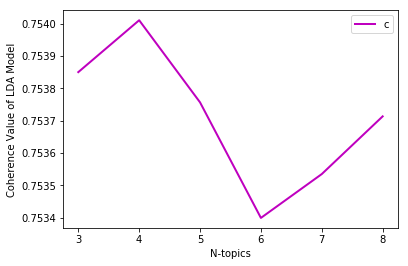

In [71]:
fig = plt.figure()
y = list(optimal_ntopics.mean())
x = [3,4,5,6,7,8]
plt.plot(x,y, 'm', linewidth=2)
plt.xlabel("N-topics")
plt.ylabel('Coherence Value of LDA Model')
plt.legend(("coherence_values"), loc='best')

In [37]:
## Model
import datetime
starttime = datetime.datetime.now()
tweet_lda_topic1 = {}
tweet_lda_score1 = {}
for i in tweet_bow_noloc:
    if len(tweet_bow_noloc[i]) ==0:
        continue
    id2word = corpora.Dictionary([tweet_bow_noloc[i]])
    corpus = [id2word.doc2bow(w) for w in [tweet_bow_noloc[i]]]
    ldamodel4 = gensim.models.ldamodel.LdaModel(corpus, num_topics = 4, id2word=id2word,update_every=1, alpha='auto',passes=20)
    topics = ldamodel4.print_topics()
    
    cm4 = CoherenceModel(model=ldamodel4, texts=[tweet_bow_noloc[i]], dictionary=id2word, coherence='c_v')
    coherence_lda4 = cm4.get_coherence()
    
    tweet_lda_topic1[i] = topics
    tweet_lda_score1[i] = [ldamodel4.log_perplexity(corpus),coherence_lda4]
endtime = datetime.datetime.now()
print (endtime - starttime)

0:06:21.697175


In [38]:
tweet_lda_topic1['206041124']

[(0,
  '0.002*"royal" + 0.002*"unimelb" + 0.002*"university" + 0.002*"closed" + 0.002*"podcast" + 0.002*"lane" + 0.002*"park" + 0.002*"animal" + 0.002*"sport" + 0.002*"zoological"'),
 (1,
  '0.014*"royal" + 0.010*"unimelb" + 0.009*"university" + 0.008*"closed" + 0.007*"animal" + 0.007*"inbound" + 0.007*"lane" + 0.005*"centre" + 0.005*"garden" + 0.005*"park"'),
 (2,
  '0.002*"royal" + 0.002*"unimelb" + 0.002*"university" + 0.002*"inbound" + 0.002*"lane" + 0.002*"closed" + 0.002*"animal" + 0.002*"zoological" + 0.002*"little" + 0.002*"link"'),
 (3,
  '0.002*"royal" + 0.002*"unimelb" + 0.002*"university" + 0.002*"closed" + 0.002*"latest" + 0.002*"lane" + 0.002*"sport" + 0.002*"north" + 0.002*"inbound" + 0.002*"love"')]

In [39]:
tweet_topic_dic = {}    
for i in tweet_lda_topic1:
    topic = []
    for t in tweet_lda_topic1[i]:
        formula = t[1].split()
        for w in formula:
            if w == '+':
                continue
            topic.append(re.sub(r'[^\w]','',w)[4:])
    tweet_topic_dic[i] = topic

In [45]:
## choose the top 5 frequency as final topics for each area
sort_topic = {}
for i in tweet_topic_dic:
    topic_fre = {}
    for w in tweet_topic_dic[i]:
        if nltk.tag.pos_tag([w])[0][1] == 'NN' or  nltk.tag.pos_tag([w])[0][1] == 'JJ' or nltk.tag.pos_tag([w])[0][1] == 'NNS':
            topic_fre[w] = bow_by_loc[i][w]
    sorted_topic_fre = sorted(topic_fre.items(), key = lambda item:item[1], reverse=True)
    sort_topic[i] = sorted_topic_fre[:10]

In [46]:
final_lda_topics = {}
for i in sort_topic:
    topic = []
    for t in sort_topic[i]:
        topic.append(t[0])
    final_lda_topics[i] = topic

In [113]:
len(final_lda_topics)

1908

In [76]:
with open('LDA_tweet_4topics.json', 'w') as f:
    data = json.dump(final_lda_topics, f)

In [77]:
lda_tweet_coherence = []
lda_tweet_perplexity = []
for i in tweet_lda_score1:
    lda_tweet_coherence.append(tweet_lda_score1[i][1])
    lda_tweet_perplexity.append(tweet_lda_score1[i][0])

Text(0, 0.5, 'Count of Areas')

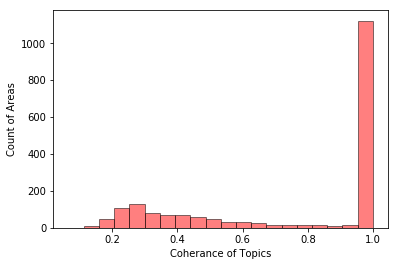

In [78]:
plt.hist(lda_tweet_coherence, bins = 20,facecolor="red", edgecolor="black", alpha=0.5)
plt.xlabel('Coherance of Topics')
plt.ylabel('Count of Areas')

Text(0, 0.5, 'Count of Areas')

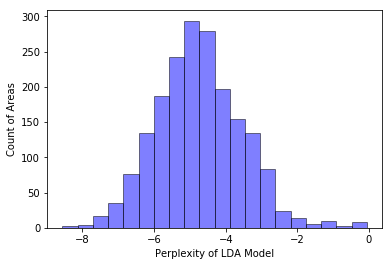

In [79]:
plt.hist(lda_tweet_perplexity, bins = 20,facecolor="blue", edgecolor="black", alpha=0.5)
plt.xlabel('Perplexity of LDA Model')
plt.ylabel('Count of Areas')
## Perplexity is not a good evaluation standard to measure the model. 
##使用gensim包的童鞋注意了，千万不要用log_perplexity()计算的perplexity指标来比较topic数量的好坏！因为这个函数没有对主题数目做归一化，因此不同的topic数目不能直接比较！

In [378]:
lda_score_table = pd.DataFrame()
lda_score_table['sa2_code'] = tweet_lda_score1.keys()
lda_score_table['lda_tweet_coherence'] = lda_tweet_coherence
lda_score_table['lda_tweet_perplexity'] = lda_tweet_perplexity
lda_score_table['topic'] = final_lda_topics.values()

In [81]:
lda_score_table.to_csv('tweet_4topics_lda_table.csv', index = False)

### pDMM

In [574]:
## 构建corpus
for i in range(0,1929):
    f = open('./corpus/test_tweet'+str(i), 'w')
    for j in clean_join_tweet[sa2_id[i]]:
            f.write(j+'\n')
    f.close()

In [50]:
## 读取output
import os
path = "pDMM-master/output_4topics/" #文件夹目录
files= os.listdir(path)

In [51]:
pDMM_topics = {}
pDMM_filter_topics={}
sa2 = list(tweet_bow_noloc.keys())
for i in range(0,1929):
    f = open(path+"/"+'dmmModel'+str(i)+'.topWords', 'r')
    lines = f.readlines()
    dic = {}
    t = []
    for line in lines:
        line = line.strip('\n')
        dic[line[:7]] = line[9:].split()
    pDMM_topics[sa2[i]] = dic
    if len(dic.keys()) == 0:
            continue
    else:
        for j in range(0,4):
            t.append([w for w in dic['Topic '+str(j)]])
    pDMM_filter_topics[sa2[i]] = t

In [249]:
tweet_pdmm = {}
for i in tweet_bow_noloc:
    if len(tweet_bow_noloc[i]) ==0:
        continue
    id2word = corpora.Dictionary([tweet_bow_noloc[i]])
    corpus = [id2word.doc2bow(w) for w in [tweet_bow_noloc[i]]]
    if len(pDMM_topics[i]) <4:
        continue
    pdmm_cm = CoherenceModel(topics=list(pDMM_topics[i].values()),texts=[tweet_bow_noloc[i]],corpus=corpus, dictionary = id2word,coherence='u_mass')
    coherence_pdmm = pdmm_cm.get_coherence()
    
    tweet_pdmm[i] = [coherence_pdmm]

In [55]:
n = 0
for i in pDMM_topics:
    if len(pDMM_topics[i])<5:
        n+=1
n

1929

In [69]:
pdmm_sort_topic = {}
for i in pDMM_filter_topics:
    pdmm_sort_topic[i] = {}
    for j in range(len(pDMM_filter_topics[i])):
        sub_topic = {}
        for w in pDMM_filter_topics[i][j]:
            if nltk.tag.pos_tag([w])[0][1] == 'NN' or  nltk.tag.pos_tag([w])[0][1] == 'JJ' or nltk.tag.pos_tag([w])[0][1] == 'NNS':
                sub_topic[w] = bow_by_loc[i][w]
        pdmm_sort_topic[i][j] = sorted(sub_topic.items(), key = lambda item:item[1], reverse=True)[:4]

In [77]:
## Take out word from (word, frequency)
final_pdmm_topics = {}
for i in pdmm_sort_topic:
    topic = []
    for j in pdmm_sort_topic[i]:
        for t in pdmm_sort_topic[i][j]:
            topic.append(t[0])
    final_pdmm_topics[i] = list(set(topic))

In [84]:
pdmm_sa2 = list(final_pdmm_topics.keys())
pdmm_topic = list(final_pdmm_topics.values())
#pdmm_coherence = [i[0] for i in list(tweet_pdmm.values())]

In [86]:
pdmm_df = pd.DataFrame()
pdmm_df['sa2_code'] = pdmm_sa2
pdmm_df['pdmm_topics'] = pdmm_topic
#pdmm_df['pdmm_coherence'] = pdmm_coherence

In [88]:
pdmm_df.shape

(1542, 2)

In [265]:
pdmm_df.to_csv('pdmm_table.csv')

### Mallet LDA

In [269]:
gensim_ldamallet_topic = {}
ldamallet_score = {}
mallet_path = 'mallet-2.0.8/bin/mallet'
now = 0
for i in tweet_bow_noloc:
    print(now)
    if len(tweet_bow_noloc[i]) ==0:
        continue
    id2word = corpora.Dictionary([tweet_bow_noloc[i]])
    corpus = [id2word.doc2bow(w) for w in [tweet_bow_noloc[i]]]
    
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)
    topics = ldamallet.print_topics(num_words=3)
    
    coherence_mallet_lda = CoherenceModel(model=ldamallet, texts=[tweet_bow_noloc[i]], dictionary=id2word, coherence='c_v')
    coherence_mallet = coherence_mallet_lda.get_coherence()
    
    gensim_ldamallet_topic[i] = topics
    ldamallet_score[i] = [coherence_mallet]
    now += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/anaconda3/lib/python3.7/site-packages/gensim/models/wrappers/ldamallet.py:448: RuntimeWarning: invalid value encountered in true_divide
  topic = topic / topic.sum()  # normalize to probability dist
/anaconda3/lib/python3.7/site-packages/gensim/models/wrappers/ldamallet.py:379: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
658
659
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750


In [313]:
## 提取并整合所有的topics
mallet_topic_dic = {}    
for i in gensim_ldamallet_topic:
    topic = []
    for t in gensim_ldamallet_topic[i]:
        formula = t[1].split()
        for w in formula:
            if w == '+':
                continue
            elif w.startswith('nan'):
                topic.append(re.sub(r'[^\w]','',w)[3:])
            else:
                topic.append(re.sub(r'[^\w]','',w)[4:])
    mallet_topic_dic[i] = topic

In [314]:
mallet_sort_topic = {}
for i in mallet_topic_dic:
    topic_fre = {}
    for w in mallet_topic_dic[i]:
        if nltk.tag.pos_tag([w])[0][1] == 'NN' or  nltk.tag.pos_tag([w])[0][1] == 'JJ' or nltk.tag.pos_tag([w])[0][1] == 'NNS':
            topic_fre[w] = bow_by_loc[i][w]
    sorted_topic_fre = sorted(topic_fre.items(), key = lambda item:item[1], reverse=True)
    mallet_sort_topic[i] = sorted_topic_fre[:5]

In [316]:
final_mallet_topics = {}
for i in mallet_sort_topic:
    topic = []
    for t in mallet_sort_topic[i]:
        topic.append(t[0])
    final_mallet_topics[i] = topic

In [375]:
mallet_sa2 = list(final_mallet_topics.keys())
mallet_top5 = list(final_mallet_topics.values())
mallet_coherence = [i[0] for i in list(ldamallet_score.values())]

In [376]:
mallet_df = pd.DataFrame()
mallet_df['mallet_sa2_code'] = mallet_sa2
mallet_df['mallet_top5_topics'] = mallet_top5
mallet_df['mallet_coherence'] = mallet_coherence

In [326]:
mallet_df.to_csv('mallet_table.csv')

In [327]:
with open('Mallet_tweet_all_topics.json', 'w') as f:
    data = json.dump(gensim_ldamallet_topic, f)

### bi-term

In [151]:
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms
from biterm.cbtm import oBTM
from biterm.btm import oBTM
from biterm.utility import vec_to_biterms, topic_summuary

In [205]:
lower_tweet_bow_noloc = {}
for i in tweet_bow_noloc:
    a = []
    for w in  tweet_bow_noloc[i]:
        a.append(w.lower())
    lower_tweet_bow_noloc[i]= a

In [247]:
starttime = datetime.datetime.now()
biterm_dic = {}
biterm_topics = {}
biterm_coherenceU = {}
null = ''
for i in clean_join_tweet:
    print(i)
    c = 0
    for w in clean_join_tweet[i]:
        if w == null:
            c+= 1
    if c == len(clean_join_tweet[i]):
        continue
    print('\n\n Train Online BTM ..')
    vec = CountVectorizer(stop_words='english')
    X = vec.fit_transform(clean_join_tweet[i]).toarray()
    vocab = np.array(vec.get_feature_names())
    biterms = vec_to_biterms(X)
    btm = oBTM(num_topics=4, V=vocab)
    topics = btm.fit_transform(biterms, iterations= 10)
    print("\n\n Topic coherence ..")
    try:
        biterm_dic[i] = topic_summuary(btm.phi_wz.T, X, vocab, 10)
        biterm_topics[i] = biterm_dic[i]['top_words']
    except:
        continue
    id2word = corpora.Dictionary([lower_tweet_bow_noloc[i]])
    corpus = [id2word.doc2bow(w) for w in [lower_tweet_bow_noloc[i]]]
    a = []
    for j in biterm_dic[i]['top_words']:
        b = []
        for w in j:
            b.append(w)
        a.append(b)
    print(a)
    biterm_cm = CoherenceModel(topics=a,texts=[lower_tweet_bow_noloc[i]],corpus=corpus, dictionary = id2word,coherence='u_mass')
    coherence_biterm = biterm_cm.get_coherence()
    biterm_coherenceU[i] = coherence_biterm
endtime = datetime.datetime.now()
print (endtime - starttime)








  0%|          | 0/10 [00:00<?, ?it/s]

117031331


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  3.79it/s]






 20%|██        | 2/10 [00:00<00:02,  3.66it/s]






 30%|███       | 3/10 [00:00<00:01,  3.64it/s]






 40%|████      | 4/10 [00:01<00:01,  3.67it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.68it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.63it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.63it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.53it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.60it/s]






100%|██████████| 10/10 [00:02<00:00,  3.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-51.46 | Top words= time roast choice spring chicken night range potato free come
Topic 1 | Coherence=-29.45 | Top words= fried lebanese flavor blue spinach chickpea chicken drinking wonderful left
Topic 2 | Coherence=-47.89 | Top words= hotel beer drinking spend great roast crisp floral saturday hoppy
Topic 3 | Coherence=-65.04 | Top words= photo taken vito cafe wale south night cibo poetry author
[['time', 'roast', 'choice', 'spring', 'chicken', 'night', 'range', 'potato', 'free', 'come'], ['fried', 'lebanese', 'flavor', 'blue', 'spinach', 'chickpea', 'chicken', 'drinking', 'wonderful', 'left'], ['hotel', 'beer', 'drinking', 'spend', 'great', 'roast', 'crisp', 'floral', 'saturday', 'hoppy'], ['photo', 'taken', 'vito', 'cafe', 'wale', 'south', 'night', 'cibo', 'poetry', 'author']]
801111140


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:08,  1.02it/s]






 20%|██        | 2/10 [00:01<00:07,  1.04it/s]






 30%|███       | 3/10 [00:02<00:06,  1.04it/s]






 40%|████      | 4/10 [00:03<00:05,  1.04it/s]






 50%|█████     | 5/10 [00:04<00:04,  1.05it/s]






 60%|██████    | 6/10 [00:05<00:03,  1.07it/s]






 70%|███████   | 7/10 [00:06<00:02,  1.03it/s]






 80%|████████  | 8/10 [00:07<00:02,  1.01s/it]






 90%|█████████ | 9/10 [00:08<00:01,  1.05s/it]






100%|██████████| 10/10 [00:09<00:00,  1.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 20.43it/s]



 Topic coherence ..
Topic 0 | Coherence=-146.66 | Top words= data receiving turbo orbiter reconnaissance lunar voyager stereo odyssey maven
Topic 1 | Coherence=-82.73 | Top words= signal strength carrier frequency idle orbiter reconnaissance lunar voyager turbo
Topic 2 | Coherence=-97.33 | Top words= frequency carrier strength turbo signal idle solar parker probe transiting
Topic 3 | Coherence=-114.75 | Top words= strength frequency carrier signal idle advanced space telescope spitzer composition
[['data', 'receiving', 'turbo', 'orbiter', 'reconnaissance', 'lunar', 'voyager', 'stereo', 'odyssey', 'maven'], ['signal', 'strength', 'carrier', 'frequency', 'idle', 'orbiter', 'reconnaissance', 'lunar', 'voyager', 'turbo'], ['frequency', 'carrier', 'strength', 'turbo', 'signal', 'idle', 'solar', 'parker', 'probe', 'transiting'], ['strength', 'frequency', 'carrier', 'signal', 'idle', 'advanced', 'space', 'telescope', 'spitzer', 'composition']]
206041121


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 21.04it/s]






 90%|█████████ | 9/10 [00:00<00:00, 20.67it/s]






100%|██████████| 10/10 [00:00<00:00, 20.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 52.58it/s]



 Topic coherence ..
Topic 0 | Coherence=-1.92 | Top words= time irish quiet beauty spring cherry_blossom blooming peace celebrate woman
Topic 1 | Coherence=31.19 | Top words= dunners_ie nitro green good batchbrew machine watchingbthe whilst love stout
Topic 2 | Coherence=-29.30 | Top words= blue cloud victoria keepvictoriabeautiful cnnweather litter prevention railway award station
Topic 3 | Coherence=2.80 | Top words= traffic closed near left victraffic lane alert work road northbound
[['time', 'irish', 'quiet', 'beauty', 'spring', 'cherry_blossom', 'blooming', 'peace', 'celebrate', 'woman'], ['dunners_ie', 'nitro', 'green', 'good', 'batchbrew', 'machine', 'watchingbthe', 'whilst', 'love', 'stout'], ['blue', 'cloud', 'victoria', 'keepvictoriabeautiful', 'cnnweather', 'litter', 'prevention', 'railway', 'award', 'station'], ['traffic', 'closed', 'near', 'left', 'victraffic', 'lane', 'alert', 'work', 'road', 'northbound']]
126011496


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 52.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=6.05 | Top words= year love spoiled mskimmynico father dilf crew shape brekkie working
Topic 1 | Coherence=13.86 | Top words= location flintwooddisabilityservi favourite friday development hungry catering capture campjs broken
Topic 2 | Coherence=21.30 | Top words= year australian withrepost bike frowning_face thought_balloon illness mental posted ridi
Topic 3 | Coherence=-2.94 | Top words= koala park sanctuary hour honestlymood sleep green_heart home happy father
[['year', 'love', 'spoiled', 'mskimmynico', 'father', 'dilf', 'crew', 'shape', 'brekkie', 'working'], ['location', 'flintwooddisabilityservi', 'favourite', 'friday', 'development', 'hungry', 'catering', 'capture', 'campjs', 'broken'], ['year', 'australian', 'withrepost', 'bike', 'frowning_face', 'thought_balloon', 'illness', 'mental', 'posted', 'ridi'], ['koala', 'park', 'sanctuary', 'hour', 'honestlymood', 'sleep', 'green_heart', 'home', 'happy', 'father']]
111031229


 Train Online 








 10%|█         | 1/10 [00:00<00:05,  1.58it/s]






 20%|██        | 2/10 [00:01<00:05,  1.59it/s]






 30%|███       | 3/10 [00:01<00:04,  1.53it/s]






 40%|████      | 4/10 [00:02<00:03,  1.52it/s]






 50%|█████     | 5/10 [00:03<00:03,  1.52it/s]






 60%|██████    | 6/10 [00:03<00:02,  1.54it/s]






 70%|███████   | 7/10 [00:04<00:01,  1.54it/s]






 80%|████████  | 8/10 [00:05<00:01,  1.56it/s]






 90%|█████████ | 9/10 [00:05<00:00,  1.52it/s]






100%|██████████| 10/10 [00:06<00:00,  1.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.35it/s]



 Topic coherence ..
Topic 0 | Coherence=-63.35 | Top words= year congratulation presented clapping_hands sport uons today recipient great spring
Topic 1 | Coherence=-67.26 | Top words= like foghorn_brewery milkylaneofficial little good night track served sunday final
Topic 2 | Coherence=-71.88 | Top words= newcastlensw newsouthwales nobbys beach nobbysbreakwall nobbyshead newcastlebeach light breakwall people
Topic 3 | Coherence=-22.77 | Top words= sport award trophy uonsportsawards photo camera_with_flash tagging lady album gent
[['year', 'congratulation', 'presented', 'clapping_hands', 'sport', 'uons', 'today', 'recipient', 'great', 'spring'], ['like', 'foghorn_brewery', 'milkylaneofficial', 'little', 'good', 'night', 'track', 'served', 'sunday', 'final'], ['newcastlensw', 'newsouthwales', 'nobbys', 'beach', 'nobbysbreakwall', 'nobbyshead', 'newcastlebeach', 'light', 'breakwall', 'people'], ['sport', 'award', 'trophy', 'uonsportsawards', 'photo', 'camera_with_flash', 'tagging', 'la








 60%|██████    | 6/10 [00:00<00:00, 22.39it/s]






 80%|████████  | 8/10 [00:00<00:00, 21.12it/s]






100%|██████████| 10/10 [00:00<00:00, 21.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 75.30it/s]






100%|██████████| 10/10 [00:00<00:00, 73.92it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= father family_man_girl fathersday darwinnt brown happy fatherdaughter northernterritory darw george
Topic 1 | Coherence=7.62 | Top words= award resort mindilbeachwedding wedding catch ring heart_suit today bride_with_veil_mediumlight_skin_tone man_in_tuxedo_light_skin_tone
Topic 2 | Coherence=-5.51 | Top words= gallery museum garden love link chewie park ntspoodle cutespoodle ntchewie
Topic 3 | Coherence=-31.40 | Top words= beach life mindil best resort time year prepper penfolds mother
[['father', 'family_man_girl', 'fathersday', 'darwinnt', 'brown', 'happy', 'fatherdaughter', 'northernterritory', 'darw', 'george'], ['award', 'resort', 'mindilbeachwedding', 'wedding', 'catch', 'ring', 'heart_suit', 'today', 'bride_with_veil_mediumlight_skin_tone', 'man_in_tuxedo_light_skin_tone'], ['gallery', 'museum', 'garden', 'love', 'link', 'chewie', 'park', 'ntspoodle', 'cutespoodle', 'ntchewie'], ['beach', 'life', 'mindil', 'best', 're








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:03<00:28,  3.17s/it]






 20%|██        | 2/10 [00:06<00:25,  3.19s/it]






 30%|███       | 3/10 [00:09<00:22,  3.22s/it]






 40%|████      | 4/10 [00:13<00:19,  3.33s/it]






 50%|█████     | 5/10 [00:16<00:16,  3.32s/it]






 60%|██████    | 6/10 [00:19<00:13,  3.33s/it]






 70%|███████   | 7/10 [00:23<00:09,  3.30s/it]






 80%|████████  | 8/10 [00:26<00:06,  3.31s/it]






 90%|█████████ | 9/10 [00:29<00:03,  3.28s/it]






100%|██████████| 10/10 [00:32<00:00,  3.27s/it]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-111.96 | Top words= mdtdesign diamond great claw victoria come world time royal ring
Topic 1 | Coherence=-115.68 | Top words= exhibition centre convention victoria great night wharf national south terracotta
Topic 2 | Coherence=-117.64 | Top words= time weekend great victoria happy south convention saturday amazing aada
Topic 3 | Coherence=-77.30 | Top words= lane victoria closed victraffic inbound west gate night left gallery
[['mdtdesign', 'diamond', 'great', 'claw', 'victoria', 'come', 'world', 'time', 'royal', 'ring'], ['exhibition', 'centre', 'convention', 'victoria', 'great', 'night', 'wharf', 'national', 'south', 'terracotta'], ['time', 'weekend', 'great', 'victoria', 'happy', 'south', 'convention', 'saturday', 'amazing', 'aada'], ['lane', 'victoria', 'closed', 'victraffic', 'inbound', 'west', 'gate', 'night', 'left', 'gallery']]
503021038


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  4.84it/s]






 20%|██        | 2/10 [00:00<00:01,  4.88it/s]






 30%|███       | 3/10 [00:00<00:01,  4.80it/s]






 40%|████      | 4/10 [00:00<00:01,  4.82it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.87it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.94it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.79it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.75it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.55it/s]






100%|██████████| 10/10 [00:02<00:00,  4.49it/s]



 Topic coherence ..
Topic 0 | Coherence=0.07 | Top words= exercise good thumbs_up_light_skin_tone sensational green_salad doninates croquette leaf_fluttering_in_wind green love
Topic 1 | Coherence=-5.77 | Top words= heart_suit two_hearts rose food thanks smiling_face_with_hearteyes blue_heart women_with_bunny_ears coffee cherry_blossom
Topic 2 | Coherence=-33.21 | Top words= strength exercise build squat hamstring gluteals youre muscle lower looking
Topic 3 | Coherence=-24.65 | Top words= keepmoving check original doerjatt open kazzs time jamaican takeaway restaurant
[['exercise', 'good', 'thumbs_up_light_skin_tone', 'sensational', 'green_salad', 'doninates', 'croquette', 'leaf_fluttering_in_wind', 'green', 'love'], ['heart_suit', 'two_hearts', 'rose', 'food', 'thanks', 'smiling_face_with_hearteyes', 'blue_heart', 'women_with_bunny_ears', 'coffee', 'cherry_blossom'], ['strength', 'exercise', 'build', 'squat', 'hamstring', 'gluteals', 'youre', 'muscle', 'lower', 'looking'], ['keepmovi








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:01<00:14,  1.61s/it]






 20%|██        | 2/10 [00:03<00:13,  1.66s/it]






 30%|███       | 3/10 [00:04<00:11,  1.63s/it]






 40%|████      | 4/10 [00:06<00:09,  1.59s/it]






 50%|█████     | 5/10 [00:08<00:07,  1.60s/it]






 60%|██████    | 6/10 [00:09<00:06,  1.62s/it]






 70%|███████   | 7/10 [00:11<00:04,  1.62s/it]






 80%|████████  | 8/10 [00:13<00:03,  1.63s/it]






 90%|█████████ | 9/10 [00:14<00:01,  1.59s/it]






100%|██████████| 10/10 [00:16<00:00,  1.58s/it]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-46.82 | Top words= italy caffé spaghetti sparkle red_heart cucina top_arrow face_savoring_food special wine_glass
Topic 1 | Coherence=-58.35 | Top words= artwork artoftheday painting picoftheday abstractart bestoftheday originalart melbourneartist artist contemporaryart
Topic 2 | Coherence=-63.96 | Top words= chocolate burch brownie bpbrownieweek burchandpurchese sweet purchese studio bpcakecabinet cake
Topic 3 | Coherence=-42.19 | Top words= south victraffic closed near lane left street traffic alert victoria
[['italy', 'caffé', 'spaghetti', 'sparkle', 'red_heart', 'cucina', 'top_arrow', 'face_savoring_food', 'special', 'wine_glass'], ['artwork', 'artoftheday', 'painting', 'picoftheday', 'abstractart', 'bestoftheday', 'originalart', 'melbourneartist', 'artist', 'contemporaryart'], ['chocolate', 'burch', 'brownie', 'bpbrownieweek', 'burchandpurchese', 'sweet', 'purchese', 'studio', 'bpcakecabinet', 'cake'], ['south', 'victraffic', 'closed', 'n








 10%|█         | 1/10 [00:00<00:02,  3.75it/s]






 20%|██        | 2/10 [00:00<00:02,  3.77it/s]






 30%|███       | 3/10 [00:00<00:01,  3.75it/s]






 40%|████      | 4/10 [00:01<00:01,  3.66it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.61it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.62it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.60it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.64it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.64it/s]






100%|██████████| 10/10 [00:02<00:00,  3.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 33.97it/s]



 Topic coherence ..
Topic 0 | Coherence=-149.12 | Top words= auto ybaf metar speci team lake covere solution specialised need
Topic 1 | Coherence=-14.72 | Top words= morning market super sweet sparkle cabbage really wurtz exactly sure
Topic 2 | Coherence=-128.69 | Top words= ybaf metar auto sparkie attempt balance early knee naughty regain
Topic 3 | Coherence=17.33 | Top words= today south took convention east queensland thing tattoo hour excruciating
[['auto', 'ybaf', 'metar', 'speci', 'team', 'lake', 'covere', 'solution', 'specialised', 'need'], ['morning', 'market', 'super', 'sweet', 'sparkle', 'cabbage', 'really', 'wurtz', 'exactly', 'sure'], ['ybaf', 'metar', 'auto', 'sparkie', 'attempt', 'balance', 'early', 'knee', 'naughty', 'regain'], ['today', 'south', 'took', 'convention', 'east', 'queensland', 'thing', 'tattoo', 'hour', 'excruciating']]
504011047


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 31.64it/s]






100%|██████████| 10/10 [00:00<00:00, 30.97it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= project light_bulb amazing ashdale right_arrow globe_showing_asiaaustralia follow dont live ownstaytrue
Topic 1 | Coherence=15.27 | Top words= bought afternoon durian conventryvillage went conventry village shopping afraid confucius
Topic 2 | Coherence=29.11 | Top words= zone waiting tired matter truelove long likeforlike instagood waitingtired wont
Topic 3 | Coherence=19.88 | Top words= attree edge smiling_face_with_hearteyes lash western red_heart habibi nephew village coventrymarkets
[['project', 'light_bulb', 'amazing', 'ashdale', 'right_arrow', 'globe_showing_asiaaustralia', 'follow', 'dont', 'live', 'ownstaytrue'], ['bought', 'afternoon', 'durian', 'conventryvillage', 'went', 'conventry', 'village', 'shopping', 'afraid', 'confucius'], ['zone', 'waiting', 'tired', 'matter', 'truelove', 'long', 'likeforlike', 'instagood', 'waitingtired', 'wont'], ['attree', 'edge', 'smiling_face_with_hearteyes', 'lash', 'western', 'red_he








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:01<00:13,  1.51s/it]






 20%|██        | 2/10 [00:03<00:12,  1.50s/it]






 30%|███       | 3/10 [00:04<00:10,  1.52s/it]






 40%|████      | 4/10 [00:06<00:08,  1.50s/it]






 50%|█████     | 5/10 [00:07<00:07,  1.45s/it]






 60%|██████    | 6/10 [00:08<00:05,  1.42s/it]






 70%|███████   | 7/10 [00:10<00:04,  1.40s/it]






 80%|████████  | 8/10 [00:11<00:02,  1.38s/it]






 90%|█████████ | 9/10 [00:12<00:01,  1.36s/it]






100%|██████████| 10/10 [00:14<00:00,  1.39s/it]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 32.57it/s]



 Topic coherence ..
Topic 0 | Coherence=-109.72 | Top words= queensland modern gallery margaret olly week night south great like
Topic 1 | Coherence=-104.82 | Top words= convention exhibition centre south bitter nose lingering mouthful malt bank
Topic 2 | Coherence=-127.00 | Top words= concert south bank queensland time tonight love open year today
Topic 3 | Coherence=-92.35 | Top words= queensland south southeast marine coordinator nature conservancy concert bank midyear
[['queensland', 'modern', 'gallery', 'margaret', 'olly', 'week', 'night', 'south', 'great', 'like'], ['convention', 'exhibition', 'centre', 'south', 'bitter', 'nose', 'lingering', 'mouthful', 'malt', 'bank'], ['concert', 'south', 'bank', 'queensland', 'time', 'tonight', 'love', 'open', 'year', 'today'], ['queensland', 'south', 'southeast', 'marine', 'coordinator', 'nature', 'conservancy', 'concert', 'bank', 'midyear']]
311061336


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 33.73it/s]






100%|██████████| 10/10 [00:00<00:00, 35.54it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= harness worked communal architect area bark magic create living inspiring
Topic 1 | Coherence=31.19 | Top words= friend dari airdrop gambar terus gila start face_with_tears_of_joy mamat sama
Topic 2 | Coherence=6.59 | Top words= youth resident foyer great capturing housing christopherfrederickjones light diversity capture
Topic 3 | Coherence=16.64 | Top words= competition kings_footlong toks support happy putting basketball miraclesday nepal chatting
[['harness', 'worked', 'communal', 'architect', 'area', 'bark', 'magic', 'create', 'living', 'inspiring'], ['friend', 'dari', 'airdrop', 'gambar', 'terus', 'gila', 'start', 'face_with_tears_of_joy', 'mamat', 'sama'], ['youth', 'resident', 'foyer', 'great', 'capturing', 'housing', 'christopherfrederickjones', 'light', 'diversity', 'capture'], ['competition', 'kings_footlong', 'toks', 'support', 'happy', 'putting', 'basketball', 'miraclesday', 'nepal', 'chatting']]
206041122


 Tra








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:54<08:08, 54.30s/it]






 20%|██        | 2/10 [01:42<07:00, 52.51s/it]






 30%|███       | 3/10 [02:38<06:14, 53.52s/it]






 40%|████      | 4/10 [03:26<05:10, 51.73s/it]






 50%|█████     | 5/10 [04:15<04:15, 51.04s/it]






 60%|██████    | 6/10 [05:08<03:27, 51.78s/it]






 70%|███████   | 7/10 [06:01<02:36, 52.07s/it]






 80%|████████  | 8/10 [06:52<01:43, 51.74s/it]






 90%|█████████ | 9/10 [07:41<00:50, 50.72s/it]






100%|██████████| 10/10 [08:31<00:00, 50.64s/it]



 Topic coherence ..
Topic 0 | Coherence=-142.83 | Top words= victoria good morning love red_heart today length sunrise august aest
Topic 1 | Coherence=-159.83 | Top words= victoria like time week red_heart friend love night great photo
Topic 2 | Coherence=-128.55 | Top words= link like click victoria latest apply hiring opening looking manager
Topic 3 | Coherence=-166.83 | Top words= victoria street love today night market week lane beautiful great
[['victoria', 'good', 'morning', 'love', 'red_heart', 'today', 'length', 'sunrise', 'august', 'aest'], ['victoria', 'like', 'time', 'week', 'red_heart', 'friend', 'love', 'night', 'great', 'photo'], ['link', 'like', 'click', 'victoria', 'latest', 'apply', 'hiring', 'opening', 'looking', 'manager'], ['victoria', 'street', 'love', 'today', 'night', 'market', 'week', 'lane', 'beautiful', 'great']]
203021039


 Train Online BTM ..









  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:03,  2.87it/s]






 20%|██        | 2/10 [00:00<00:02,  2.89it/s]






 30%|███       | 3/10 [00:01<00:02,  2.90it/s]






 40%|████      | 4/10 [00:01<00:02,  2.90it/s]






 50%|█████     | 5/10 [00:01<00:01,  2.90it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.91it/s]






 70%|███████   | 7/10 [00:02<00:01,  2.90it/s]






 80%|████████  | 8/10 [00:02<00:00,  2.78it/s]






 90%|█████████ | 9/10 [00:03<00:00,  2.65it/s]






100%|██████████| 10/10 [00:03<00:00,  2.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 57.42it/s]










 Topic coherence ..
Topic 0 | Coherence=-67.81 | Top words= like life great come today book victoria chocolate love woman_fairy_light_skin_tone
Topic 1 | Coherence=-50.44 | Top words= club luke youre rugby_football game camera sunday beautiful football winning
Topic 2 | Coherence=-66.22 | Top words= wearegeelong gocats game standproud work final family weekend like wild
Topic 3 | Coherence=-88.45 | Top words= gmhba stadium work victoria great wearegeelong kardinia park love sunday
[['like', 'life', 'great', 'come', 'today', 'book', 'victoria', 'chocolate', 'love', 'woman_fairy_light_skin_tone'], ['club', 'luke', 'youre', 'rugby_football', 'game', 'camera', 'sunday', 'beautiful', 'football', 'winning'], ['wearegeelong', 'gocats', 'game', 'standproud', 'work', 'final', 'family', 'weekend', 'like', 'wild'], ['gmhba', 'stadium', 'work', 'victoria', 'great', 'wearegeelong', 'kardinia', 'park', 'love', 'sunday']]
302041045


 Train Online BTM ..


100%|██████████| 10/10 [00:00<00:00, 57.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= yesterday realise await colourful didnt finding hidden kind world mountainous
Topic 1 | Coherence=16.64 | Top words= solid weightgaintrip north portion farmersmarket castledine smiling_face_with_hearteyes officially huge bathtub
Topic 2 | Coherence=9.01 | Top words= match brown nicely grass smiling_face_with_halo frontfacing_baby_chick miss kuringgai loudly_crying_face park
Topic 3 | Coherence=28.42 | Top words= highest number life photo nofilter frontfacing_baby_chick make taken face_with_rolling_eyes kangaroo
[['yesterday', 'realise', 'await', 'colourful', 'didnt', 'finding', 'hidden', 'kind', 'world', 'mountainous'], ['solid', 'weightgaintrip', 'north', 'portion', 'farmersmarket', 'castledine', 'smiling_face_with_hearteyes', 'officially', 'huge', 'bathtub'], ['match', 'brown', 'nicely', 'grass', 'smiling_face_with_halo', 'frontfacing_baby_chick', 'miss', 'kuringgai', 'loudly_crying_face', 'park'], ['highest', 'number', 'li








 10%|█         | 1/10 [00:00<00:07,  1.18it/s]






 20%|██        | 2/10 [00:01<00:06,  1.18it/s]






 30%|███       | 3/10 [00:02<00:06,  1.16it/s]






 40%|████      | 4/10 [00:03<00:05,  1.11it/s]






 50%|█████     | 5/10 [00:04<00:04,  1.08it/s]






 60%|██████    | 6/10 [00:05<00:03,  1.06it/s]






 70%|███████   | 7/10 [00:06<00:02,  1.04it/s]






 80%|████████  | 8/10 [00:07<00:01,  1.07it/s]






 90%|█████████ | 9/10 [00:08<00:00,  1.10it/s]






100%|██████████| 10/10 [00:09<00:00,  1.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-95.78 | Top words= reef great barrier cairn fish tropical_fish water_wave island water shrimp
Topic 1 | Coherence=-107.85 | Top words= cairn cocktail queensland good come exotic great life greatbarrierreef world
Topic 2 | Coherence=-113.48 | Top words= cairn great reef barrier time queensland like coral ocean drinking
Topic 3 | Coherence=-101.70 | Top words= cairn queensland adidasrunnersantiago chile garmin_chile park flamingo tiki barlow okole
[['reef', 'great', 'barrier', 'cairn', 'fish', 'tropical_fish', 'water_wave', 'island', 'water', 'shrimp'], ['cairn', 'cocktail', 'queensland', 'good', 'come', 'exotic', 'great', 'life', 'greatbarrierreef', 'world'], ['cairn', 'great', 'reef', 'barrier', 'time', 'queensland', 'like', 'coral', 'ocean', 'drinking'], ['cairn', 'queensland', 'adidasrunnersantiago', 'chile', 'garmin_chile', 'park', 'flamingo', 'tiki', 'barlow', 'okole']]
121041417


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:04,  2.04it/s]






 20%|██        | 2/10 [00:00<00:03,  2.02it/s]






 30%|███       | 3/10 [00:01<00:03,  1.99it/s]






 40%|████      | 4/10 [00:02<00:02,  2.01it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.04it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.04it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.02it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.04it/s]






 90%|█████████ | 9/10 [00:04<00:00,  2.05it/s]






100%|██████████| 10/10 [00:04<00:00,  2.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-54.82 | Top words= north running runner blackmores festival blast playing pavem high pounded
Topic 1 | Coherence=-70.63 | Top words= point northsydney link online like click book tech time milsons
Topic 2 | Coherence=-91.69 | Top words= work luna park north hotel beautiful night great taste online
Topic 3 | Coherence=-82.86 | Top words= wale point south milsons make north beautiful walk bond greatlengths
[['north', 'running', 'runner', 'blackmores', 'festival', 'blast', 'playing', 'pavem', 'high', 'pounded'], ['point', 'northsydney', 'link', 'online', 'like', 'click', 'book', 'tech', 'time', 'milsons'], ['work', 'luna', 'park', 'north', 'hotel', 'beautiful', 'night', 'great', 'taste', 'online'], ['wale', 'point', 'south', 'milsons', 'make', 'north', 'beautiful', 'walk', 'bond', 'greatlengths']]
206071142


 Train Online BTM ..









 10%|█         | 1/10 [00:01<00:10,  1.16s/it]






 20%|██        | 2/10 [00:02<00:09,  1.15s/it]






 30%|███       | 3/10 [00:03<00:08,  1.15s/it]






 40%|████      | 4/10 [00:04<00:06,  1.15s/it]






 50%|█████     | 5/10 [00:05<00:05,  1.15s/it]






 60%|██████    | 6/10 [00:06<00:04,  1.15s/it]






 70%|███████   | 7/10 [00:08<00:03,  1.15s/it]






 80%|████████  | 8/10 [00:09<00:02,  1.14s/it]






 90%|█████████ | 9/10 [00:10<00:01,  1.14s/it]






100%|██████████| 10/10 [00:11<00:00,  1.14s/it]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 120.41it/s]



 Topic coherence ..
Topic 0 | Coherence=-92.84 | Top words= lunch today thank drinking sparkle clapping_hands work amazing self croissant
Topic 1 | Coherence=-82.15 | Top words= today album announcement come drop saturday beautiful heat night great
Topic 2 | Coherence=-51.70 | Top words= drinking night sunday brew red_heart beeroclock cheer smiling_face_with_sunglasses thumbs_up_dark_skin_tone musical_note
Topic 3 | Coherence=-31.09 | Top words= street lane left victraffic closed work instore traffic near alert
[['lunch', 'today', 'thank', 'drinking', 'sparkle', 'clapping_hands', 'work', 'amazing', 'self', 'croissant'], ['today', 'album', 'announcement', 'come', 'drop', 'saturday', 'beautiful', 'heat', 'night', 'great'], ['drinking', 'night', 'sunday', 'brew', 'red_heart', 'beeroclock', 'cheer', 'smiling_face_with_sunglasses', 'thumbs_up_dark_skin_tone', 'musical_note'], ['street', 'lane', 'left', 'victraffic', 'closed', 'work', 'instore', 'traffic', 'near', 'alert']]
114011279


 Tr








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:06,  1.44it/s]






 20%|██        | 2/10 [00:01<00:05,  1.42it/s]






 30%|███       | 3/10 [00:02<00:04,  1.43it/s]






 40%|████      | 4/10 [00:02<00:04,  1.43it/s]






 50%|█████     | 5/10 [00:03<00:03,  1.41it/s]






 60%|██████    | 6/10 [00:04<00:02,  1.40it/s]






 70%|███████   | 7/10 [00:04<00:02,  1.40it/s]






 80%|████████  | 8/10 [00:05<00:01,  1.40it/s]






 90%|█████████ | 9/10 [00:06<00:00,  1.40it/s]






100%|██████████| 10/10 [00:07<00:00,  1.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.85it/s]



 Topic coherence ..
Topic 0 | Coherence=-89.60 | Top words= cricket ground come game showroom white_circle arrived work red_circle studio
Topic 1 | Coherence=-28.70 | Top words= mastacraft merkules complete ring seat entertainment quarter watt music house
Topic 2 | Coherence=-60.53 | Top words= earring store morning thumbs_up_mediumlight_skin_tone winking_face_with_tongue online available girl white_medium_star south
Topic 3 | Coherence=-72.66 | Top words= final grand league night nrltouchpremiership australian best kayo love come
[['cricket', 'ground', 'come', 'game', 'showroom', 'white_circle', 'arrived', 'work', 'red_circle', 'studio'], ['mastacraft', 'merkules', 'complete', 'ring', 'seat', 'entertainment', 'quarter', 'watt', 'music', 'house'], ['earring', 'store', 'morning', 'thumbs_up_mediumlight_skin_tone', 'winking_face_with_tongue', 'online', 'available', 'girl', 'white_medium_star', 'south'], ['final', 'grand', 'league', 'night', 'nrltouchpremiership', 'australian', 'best', 








 20%|██        | 2/10 [00:00<00:00,  9.62it/s]






 30%|███       | 3/10 [00:00<00:00,  9.65it/s]






 40%|████      | 4/10 [00:00<00:00,  9.58it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.57it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.34it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.31it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.37it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.27it/s]






100%|██████████| 10/10 [00:01<00:00,  9.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.06it/s]



 Topic coherence ..
Topic 0 | Coherence=-24.26 | Top words= destination pocket_world ig_landscape southaustralia nationalparkssa dream_spots today strong branding saturday
Topic 1 | Coherence=-11.25 | Top words= positive party_popper party rocket vibe nigeriandj red_heart master_shots charles theoriginofspecies
Topic 2 | Coherence=-50.35 | Top words= instead southaustralia blessed possessive possible read declare latin_cross type looking
Topic 3 | Coherence=-56.85 | Top words= south couple little range posted instead red_heart update amazing oncoming_taxi
[['destination', 'pocket_world', 'ig_landscape', 'southaustralia', 'nationalparkssa', 'dream_spots', 'today', 'strong', 'branding', 'saturday'], ['positive', 'party_popper', 'party', 'rocket', 'vibe', 'nigeriandj', 'red_heart', 'master_shots', 'charles', 'theoriginofspecies'], ['instead', 'southaustralia', 'blessed', 'possessive', 'possible', 'read', 'declare', 'latin_cross', 'type', 'looking'], ['south', 'couple', 'little', 'range'








 20%|██        | 2/10 [00:00<00:00,  8.89it/s]






 30%|███       | 3/10 [00:00<00:00,  8.82it/s]






 40%|████      | 4/10 [00:00<00:00,  8.79it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.72it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.69it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.56it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.57it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.58it/s]






100%|██████████| 10/10 [00:01<00:00,  8.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-57.30 | Top words= park wildlife kangaroo person_swimming feel smiling_face_with_smiling_eyes revolving_hearts community yeptotally good
Topic 1 | Coherence=-47.41 | Top words= sksst mandir temple swaminarayan ghanshyammahraj dailypic ssmandirperth swaminarayanmandir face_with_tears_of_joy sept
Topic 2 | Coherence=-77.70 | Top words= wildlife park koala kangaroo love light_bulb different felt posted today
Topic 3 | Coherence=-56.46 | Top words= wildlife west swan margaret river company chocolate park love kangaroo
[['park', 'wildlife', 'kangaroo', 'person_swimming', 'feel', 'smiling_face_with_smiling_eyes', 'revolving_hearts', 'community', 'yeptotally', 'good'], ['sksst', 'mandir', 'temple', 'swaminarayan', 'ghanshyammahraj', 'dailypic', 'ssmandirperth', 'swaminarayanmandir', 'face_with_tears_of_joy', 'sept'], ['wildlife', 'park', 'koala', 'kangaroo', 'love', 'light_bulb', 'different', 'felt', 'posted', 'today'], ['wildlife', 'west', 'swan', '








 10%|█         | 1/10 [00:00<00:01,  5.93it/s]






 20%|██        | 2/10 [00:00<00:01,  5.90it/s]






 30%|███       | 3/10 [00:00<00:01,  5.93it/s]






 40%|████      | 4/10 [00:00<00:01,  5.80it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.84it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.92it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.00it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.01it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.04it/s]






100%|██████████| 10/10 [00:01<00:00,  6.05it/s]



 Topic coherence ..
Topic 0 | Coherence=-83.83 | Top words= gold coast airport lucius thanks club tool qantas borich early
Topic 1 | Coherence=-64.33 | Top words= beach swell swellsculpturefestival aussie currumbinbeach goldcoast today kangaroo list wildlife
Topic 2 | Coherence=-37.77 | Top words= goldcoast travelgram queensland travel ilovegc wearegoldcoast igdaily instatravel swell sculpture
Topic 3 | Coherence=-66.01 | Top words= sanctuary afternoon wildlife sunday drinking morning koala isnt hello home
[['gold', 'coast', 'airport', 'lucius', 'thanks', 'club', 'tool', 'qantas', 'borich', 'early'], ['beach', 'swell', 'swellsculpturefestival', 'aussie', 'currumbinbeach', 'goldcoast', 'today', 'kangaroo', 'list', 'wildlife'], ['goldcoast', 'travelgram', 'queensland', 'travel', 'ilovegc', 'wearegoldcoast', 'igdaily', 'instatravel', 'swell', 'sculpture'], ['sanctuary', 'afternoon', 'wildlife', 'sunday', 'drinking', 'morning', 'koala', 'isnt', 'hello', 'home']]
309101267


 Train Online








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:03<00:28,  3.12s/it]






 20%|██        | 2/10 [00:06<00:25,  3.13s/it]






 30%|███       | 3/10 [00:09<00:22,  3.18s/it]






 40%|████      | 4/10 [00:13<00:20,  3.35s/it]






 50%|█████     | 5/10 [00:17<00:17,  3.49s/it]






 60%|██████    | 6/10 [00:20<00:13,  3.45s/it]






 70%|███████   | 7/10 [00:23<00:10,  3.34s/it]






 80%|████████  | 8/10 [00:26<00:06,  3.37s/it]






 90%|█████████ | 9/10 [00:30<00:03,  3.29s/it]






100%|██████████| 10/10 [00:33<00:00,  3.25s/it]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-140.91 | Top words= today coast gold music happy album like power great best
Topic 1 | Coherence=-120.52 | Top words= gold iphonography booking time weekend coast life open recently queensland
Topic 2 | Coherence=-46.77 | Top words= gold coast queensland goldcoast classiccars ford customcars chevy carshow holden
Topic 3 | Coherence=-118.68 | Top words= gold coast smiling_face_with_hearteyes destinationgoldcoast blue_heart queensland morning love little music
[['today', 'coast', 'gold', 'music', 'happy', 'album', 'like', 'power', 'great', 'best'], ['gold', 'iphonography', 'booking', 'time', 'weekend', 'coast', 'life', 'open', 'recently', 'queensland'], ['gold', 'coast', 'queensland', 'goldcoast', 'classiccars', 'ford', 'customcars', 'chevy', 'carshow', 'holden'], ['gold', 'coast', 'smiling_face_with_hearteyes', 'destinationgoldcoast', 'blue_heart', 'queensland', 'morning', 'love', 'little', 'music']]
601051027


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:05,  1.64it/s]






 20%|██        | 2/10 [00:01<00:04,  1.60it/s]






 30%|███       | 3/10 [00:01<00:04,  1.57it/s]






 40%|████      | 4/10 [00:02<00:03,  1.54it/s]






 50%|█████     | 5/10 [00:03<00:03,  1.50it/s]






 60%|██████    | 6/10 [00:04<00:02,  1.48it/s]






 70%|███████   | 7/10 [00:04<00:02,  1.46it/s]






 80%|████████  | 8/10 [00:05<00:01,  1.46it/s]






 90%|█████████ | 9/10 [00:06<00:00,  1.45it/s]






100%|██████████| 10/10 [00:06<00:00,  1.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.06it/s]



 Topic coherence ..
Topic 0 | Coherence=-92.88 | Top words= tasmania tasmanian beautiful hotel believe museum thanks grand miss wine
Topic 1 | Coherence=-73.66 | Top words= tasmania garden royal posted photo coffee espresso tasmanian cafe botanical
Topic 2 | Coherence=-89.69 | Top words= tasmania colour salamanca night morning tassie creative good thanks painting
Topic 3 | Coherence=-76.51 | Top words= tasmania factor live taswaterbasketball submit holiday week story australian hotel
[['tasmania', 'tasmanian', 'beautiful', 'hotel', 'believe', 'museum', 'thanks', 'grand', 'miss', 'wine'], ['tasmania', 'garden', 'royal', 'posted', 'photo', 'coffee', 'espresso', 'tasmanian', 'cafe', 'botanical'], ['tasmania', 'colour', 'salamanca', 'night', 'morning', 'tassie', 'creative', 'good', 'thanks', 'painting'], ['tasmania', 'factor', 'live', 'taswaterbasketball', 'submit', 'holiday', 'week', 'story', 'australian', 'hotel']]
309071255


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.22it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.40it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.60it/s]






100%|██████████| 10/10 [00:00<00:00, 13.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.72 | Top words= home treatment completed pest need general beautiful client yoghurt happyfriyay
Topic 1 | Coherence=-13.70 | Top words= property movie flea lease control pest completed treatment bucket cold
Topic 2 | Coherence=-2.97 | Top words= picture awesome service road freight aleks groz kenworth mate cheer
Topic 3 | Coherence=-13.46 | Top words= meal greatdane dog_face shop tiler trade neopolitanmastiff protein pure goodness
[['home', 'treatment', 'completed', 'pest', 'need', 'general', 'beautiful', 'client', 'yoghurt', 'happyfriyay'], ['property', 'movie', 'flea', 'lease', 'control', 'pest', 'completed', 'treatment', 'bucket', 'cold'], ['picture', 'awesome', 'service', 'road', 'freight', 'aleks', 'groz', 'kenworth', 'mate', 'cheer'], ['meal', 'greatdane', 'dog_face', 'shop', 'tiler', 'trade', 'neopolitanmastiff', 'protein', 'pure', 'goodness']]
206051133


 Train Online BTM ..









 10%|█         | 1/10 [00:01<00:10,  1.20s/it]






 20%|██        | 2/10 [00:02<00:09,  1.20s/it]






 30%|███       | 3/10 [00:03<00:08,  1.20s/it]






 40%|████      | 4/10 [00:04<00:07,  1.20s/it]






 50%|█████     | 5/10 [00:06<00:06,  1.20s/it]






 60%|██████    | 6/10 [00:07<00:04,  1.21s/it]






 70%|███████   | 7/10 [00:08<00:03,  1.23s/it]






 80%|████████  | 8/10 [00:09<00:02,  1.23s/it]






 90%|█████████ | 9/10 [00:10<00:01,  1.23s/it]






100%|██████████| 10/10 [00:12<00:00,  1.22s/it]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.00it/s]



 Topic coherence ..
Topic 0 | Coherence=-79.18 | Top words= rain room pavilion jackalope rainroom rainroomaus like stkilda yesterday kilda
Topic 1 | Coherence=-105.88 | Top words= kilda alestars beer stkilda right beach park post good blanket
Topic 2 | Coherence=-104.98 | Top words= like alestars saturday kilda beer time good morning week social
Topic 3 | Coherence=-105.40 | Top words= kilda photography michaelblameyphotography white_heavy_check_mark michael blamey resolution victoria sweatybetty night
[['rain', 'room', 'pavilion', 'jackalope', 'rainroom', 'rainroomaus', 'like', 'stkilda', 'yesterday', 'kilda'], ['kilda', 'alestars', 'beer', 'stkilda', 'right', 'beach', 'park', 'post', 'good', 'blanket'], ['like', 'alestars', 'saturday', 'kilda', 'beer', 'time', 'good', 'morning', 'week', 'social'], ['kilda', 'photography', 'michaelblameyphotography', 'white_heavy_check_mark', 'michael', 'blamey', 'resolution', 'victoria', 'sweatybetty', 'night']]
120031390


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.02it/s]






 30%|███       | 3/10 [00:00<00:00,  7.02it/s]






 40%|████      | 4/10 [00:00<00:00,  6.86it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.92it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.92it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.95it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.88it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.93it/s]






100%|██████████| 10/10 [00:01<00:00,  6.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-79.84 | Top words= drinking lard donut brewing colonial queen damned black drop like
Topic 1 | Coherence=-81.66 | Top words= drinking donut lard stride nice porter facebook week account behemoth
Topic 2 | Coherence=-86.32 | Top words= drinking lard donut beer double neipa microlit pretty karaoke good
Topic 3 | Coherence=-77.72 | Top words= drinking lane lard love apartment donut filled house ok_hand perfect
[['drinking', 'lard', 'donut', 'brewing', 'colonial', 'queen', 'damned', 'black', 'drop', 'like'], ['drinking', 'donut', 'lard', 'stride', 'nice', 'porter', 'facebook', 'week', 'account', 'behemoth'], ['drinking', 'lard', 'donut', 'beer', 'double', 'neipa', 'microlit', 'pretty', 'karaoke', 'good'], ['drinking', 'lane', 'lard', 'love', 'apartment', 'donut', 'filled', 'house', 'ok_hand', 'perfect']]
206041119


 Train Online BTM ..









 10%|█         | 1/10 [00:01<00:11,  1.30s/it]






 20%|██        | 2/10 [00:02<00:10,  1.30s/it]






 30%|███       | 3/10 [00:03<00:09,  1.29s/it]






 40%|████      | 4/10 [00:05<00:07,  1.28s/it]






 50%|█████     | 5/10 [00:06<00:06,  1.29s/it]






 60%|██████    | 6/10 [00:07<00:05,  1.28s/it]






 70%|███████   | 7/10 [00:08<00:03,  1.28s/it]






 80%|████████  | 8/10 [00:10<00:02,  1.28s/it]






 90%|█████████ | 9/10 [00:11<00:01,  1.29s/it]






100%|██████████| 10/10 [00:12<00:00,  1.30s/it]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.14it/s]



 Topic coherence ..
Topic 0 | Coherence=-108.94 | Top words= member garden victoria love good join reserve arena night treasury
Topic 1 | Coherence=-116.34 | Top words= cricket ground night final aami park tonight footy time best
Topic 2 | Coherence=-88.40 | Top words= victraffic closed lane left east street night whitenight marr birrarung
Topic 3 | Coherence=-109.95 | Top words= game aami park night time laver arena final rugby_football stand
[['member', 'garden', 'victoria', 'love', 'good', 'join', 'reserve', 'arena', 'night', 'treasury'], ['cricket', 'ground', 'night', 'final', 'aami', 'park', 'tonight', 'footy', 'time', 'best'], ['victraffic', 'closed', 'lane', 'left', 'east', 'street', 'night', 'whitenight', 'marr', 'birrarung'], ['game', 'aami', 'park', 'night', 'time', 'laver', 'arena', 'final', 'rugby_football', 'stand']]
301031020


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 12.99it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.00it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.97it/s]






100%|██████████| 10/10 [00:00<00:00, 12.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 46.03it/s]



 Topic coherence ..
Topic 0 | Coherence=-4.63 | Top words= home sweet potato roasted_sweet_potato taco inspired bean smart flavoured using
Topic 1 | Coherence=-6.15 | Top words= work home week pneumoni road filter school friend mahlijc girl
Topic 2 | Coherence=-13.81 | Top words= heavy_dollar_sign warm sun_with_face house_with_garden team important impact society good money
Topic 3 | Coherence=-24.68 | Top words= home morning heart_suit loan house monday staffylove girl staffy soooo
[['home', 'sweet', 'potato', 'roasted_sweet_potato', 'taco', 'inspired', 'bean', 'smart', 'flavoured', 'using'], ['work', 'home', 'week', 'pneumoni', 'road', 'filter', 'school', 'friend', 'mahlijc', 'girl'], ['heavy_dollar_sign', 'warm', 'sun_with_face', 'house_with_garden', 'team', 'important', 'impact', 'society', 'good', 'money'], ['home', 'morning', 'heart_suit', 'loan', 'house', 'monday', 'staffylove', 'girl', 'staffy', 'soooo']]
111031222


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 45.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= cheese want newcastlepizza pizza pizzanewcastle harrysgourmetpizza simple according incredible jimmyhopson
Topic 1 | Coherence=12.48 | Top words= today kitty friday laser mwuahaha nonbinary selfie tgif brought brave
Topic 2 | Coherence=1.32 | Top words= night steelcoastcrossfit good rock arran awesome barbell powercoastcup beer beff
Topic 3 | Coherence=-2.55 | Top words= drinking cellarbrations youtube bauhntv netflixanz chromecast smart bigger clearer watch
[['cheese', 'want', 'newcastlepizza', 'pizza', 'pizzanewcastle', 'harrysgourmetpizza', 'simple', 'according', 'incredible', 'jimmyhopson'], ['today', 'kitty', 'friday', 'laser', 'mwuahaha', 'nonbinary', 'selfie', 'tgif', 'brought', 'brave'], ['night', 'steelcoastcrossfit', 'good', 'rock', 'arran', 'awesome', 'barbell', 'powercoastcup', 'beer', 'beff'], ['drinking', 'cellarbrations', 'youtube', 'bauhntv', 'netflixanz', 'chromecast', 'smart', 'bigger', 'clearer', 'watch']]









 10%|█         | 1/10 [00:00<00:01,  4.75it/s]






 20%|██        | 2/10 [00:00<00:01,  4.98it/s]






 30%|███       | 3/10 [00:00<00:01,  5.18it/s]






 40%|████      | 4/10 [00:00<00:01,  5.27it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.37it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.47it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.54it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.58it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.67it/s]






100%|██████████| 10/10 [00:01<00:00,  5.66it/s]



 Topic coherence ..
Topic 0 | Coherence=-45.03 | Top words= titan wheel loader heavy industry everun rough away board victoria
Topic 1 | Coherence=-33.44 | Top words= wintersday victoria seafordpier finish doyouseewhatisee gowiththeflow medium thegentleway storytelling apocalypse
Topic 2 | Coherence=-60.72 | Top words= brewing bank drinking mrbanksbeer mrbanks atthesource ampb drinklocalbeer parfait drink
Topic 3 | Coherence=-75.78 | Top words= vicroads passing congratulation drivetest navdrivingschool attempt time come community beach
[['titan', 'wheel', 'loader', 'heavy', 'industry', 'everun', 'rough', 'away', 'board', 'victoria'], ['wintersday', 'victoria', 'seafordpier', 'finish', 'doyouseewhatisee', 'gowiththeflow', 'medium', 'thegentleway', 'storytelling', 'apocalypse'], ['brewing', 'bank', 'drinking', 'mrbanksbeer', 'mrbanks', 'atthesource', 'ampb', 'drinklocalbeer', 'parfait', 'drink'], ['vicroads', 'passing', 'congratulation', 'drivetest', 'navdrivingschool', 'attempt', 'tim








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:05<00:50,  5.60s/it]






 20%|██        | 2/10 [00:11<00:44,  5.59s/it]






 30%|███       | 3/10 [00:16<00:39,  5.58s/it]






 40%|████      | 4/10 [00:22<00:33,  5.59s/it]






 50%|█████     | 5/10 [00:27<00:27,  5.60s/it]






 60%|██████    | 6/10 [00:33<00:22,  5.59s/it]






 70%|███████   | 7/10 [00:39<00:16,  5.58s/it]






 80%|████████  | 8/10 [00:44<00:11,  5.57s/it]






 90%|█████████ | 9/10 [00:50<00:05,  5.56s/it]






100%|██████████| 10/10 [00:55<00:00,  5.61s/it]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.12it/s]



 Topic coherence ..
Topic 0 | Coherence=-96.70 | Top words= south motivation motivationalquote instaquotes morningmotivation instaquote morninginspiration quoteoftheday work today
Topic 1 | Coherence=-80.83 | Top words= morning good noon acst sunrise length south hundred_points august september
Topic 2 | Coherence=-106.94 | Top words= wind performing live humidity lion weather current factory pressure south
Topic 3 | Coherence=-141.06 | Top words= south love night familyiseverything week amazing birthday today tonight sparkle
[['south', 'motivation', 'motivationalquote', 'instaquotes', 'morningmotivation', 'instaquote', 'morninginspiration', 'quoteoftheday', 'work', 'today'], ['morning', 'good', 'noon', 'acst', 'sunrise', 'length', 'south', 'hundred_points', 'august', 'september'], ['wind', 'performing', 'live', 'humidity', 'lion', 'weather', 'current', 'factory', 'pressure', 'south'], ['south', 'love', 'night', 'familyiseverything', 'week', 'amazing', 'birthday', 'today', 'tonight',








 20%|██        | 2/10 [00:00<00:00,  8.13it/s]






 30%|███       | 3/10 [00:00<00:00,  8.00it/s]






 40%|████      | 4/10 [00:00<00:00,  8.09it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.08it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.11it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.13it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.17it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.22it/s]






100%|██████████| 10/10 [00:01<00:00,  8.25it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.27it/s]



 Topic coherence ..
Topic 0 | Coherence=-28.72 | Top words= today hill want gohardgoknights railway station hour ok_hand_light_skin_tone cold early
Topic 1 | Coherence=-46.28 | Top words= photo hotel strong today core newcastleinterchange interchange pouting_face madhouse newcastlensw
Topic 2 | Coherence=-9.59 | Top words= centre hockey face_with_tears_of_joy installed supplied oncoming_fist_light_skin_tone bigger hockeynsw bear moddieshockey
Topic 3 | Coherence=-40.54 | Top words= fight crew boxing_glove round tuned steelcityboxing rvca thursday japanese_symbol_for_beginner hundred_points
[['today', 'hill', 'want', 'gohardgoknights', 'railway', 'station', 'hour', 'ok_hand_light_skin_tone', 'cold', 'early'], ['photo', 'hotel', 'strong', 'today', 'core', 'newcastleinterchange', 'interchange', 'pouting_face', 'madhouse', 'newcastlensw'], ['centre', 'hockey', 'face_with_tears_of_joy', 'installed', 'supplied', 'oncoming_fist_light_skin_tone', 'bigger', 'hockeynsw', 'bear', 'moddieshockey








 50%|█████     | 5/10 [00:00<00:00, 20.78it/s]






 80%|████████  | 8/10 [00:00<00:00, 20.77it/s]






100%|██████████| 10/10 [00:00<00:00, 20.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-28.26 | Top words= victraffic closed road traffic alert track near lane direction leaf_fluttering_in_wind
Topic 1 | Coherence=19.41 | Top words= good pretty ok_hand_light_skin_tone ampitheatrefalls kurthkilnregionalpark hiking puppy havent toorongofalls lucky
Topic 2 | Coherence=1.42 | Top words= condition mount yang baru kelapa hidden halo namanya gais gading
Topic 3 | Coherence=-3.13 | Top words= average lift today snow mtbawbaw condition excellent report plus prefect
[['victraffic', 'closed', 'road', 'traffic', 'alert', 'track', 'near', 'lane', 'direction', 'leaf_fluttering_in_wind'], ['good', 'pretty', 'ok_hand_light_skin_tone', 'ampitheatrefalls', 'kurthkilnregionalpark', 'hiking', 'puppy', 'havent', 'toorongofalls', 'lucky'], ['condition', 'mount', 'yang', 'baru', 'kelapa', 'hidden', 'halo', 'namanya', 'gais', 'gading'], ['average', 'lift', 'today', 'snow', 'mtbawbaw', 'condition', 'excellent', 'report', 'plus', 'prefect']]
318021490


 








 10%|█         | 1/10 [00:00<00:02,  3.60it/s]






 20%|██        | 2/10 [00:00<00:02,  3.63it/s]






 30%|███       | 3/10 [00:00<00:01,  3.64it/s]






 40%|████      | 4/10 [00:01<00:01,  3.63it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.60it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.61it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.59it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.59it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.60it/s]






100%|██████████| 10/10 [00:02<00:00,  3.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.56it/s]



 Topic coherence ..
Topic 0 | Coherence=-47.42 | Top words= dont today fellow star woman favourite cairn beautiful warm winter
Topic 1 | Coherence=-45.88 | Top words= today exercise thumbs_up year love original direct_hit great want graffiti
Topic 2 | Coherence=-86.84 | Top words= queensland taphouse drinking party_popper sold child time book admission_tickets state
Topic 3 | Coherence=-100.12 | Top words= queensland photo posted halo gamergirl gamer bohemian light time night
[['dont', 'today', 'fellow', 'star', 'woman', 'favourite', 'cairn', 'beautiful', 'warm', 'winter'], ['today', 'exercise', 'thumbs_up', 'year', 'love', 'original', 'direct_hit', 'great', 'want', 'graffiti'], ['queensland', 'taphouse', 'drinking', 'party_popper', 'sold', 'child', 'time', 'book', 'admission_tickets', 'state'], ['queensland', 'photo', 'posted', 'halo', 'gamergirl', 'gamer', 'bohemian', 'light', 'time', 'night']]
111031228


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 12.51it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.51it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.54it/s]






100%|██████████| 10/10 [00:00<00:00, 12.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.08it/s]



 Topic coherence ..
Topic 0 | Coherence=-28.04 | Top words= finish miss merewetherbeach morning place smiling_face_with_hearteyes coffeeart cafe time shopping
Topic 1 | Coherence=-14.10 | Top words= enjoying view friend afternoon lunch pump abandonned crazy early walk
Topic 2 | Coherence=-26.87 | Top words= beach house time today ocean bath freezing bathtub cold_face surf
Topic 3 | Coherence=-29.39 | Top words= mynewcastle novocastrian right surf magnificent world house burwoodbeach sight breasted
[['finish', 'miss', 'merewetherbeach', 'morning', 'place', 'smiling_face_with_hearteyes', 'coffeeart', 'cafe', 'time', 'shopping'], ['enjoying', 'view', 'friend', 'afternoon', 'lunch', 'pump', 'abandonned', 'crazy', 'early', 'walk'], ['beach', 'house', 'time', 'today', 'ocean', 'bath', 'freezing', 'bathtub', 'cold_face', 'surf'], ['mynewcastle', 'novocastrian', 'right', 'surf', 'magnificent', 'world', 'house', 'burwoodbeach', 'sight', 'breasted']]
407011147


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.97it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.83it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.72it/s]






100%|██████████| 10/10 [00:00<00:00, 13.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.12it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.83 | Top words= flower colour wine time tale sweet spring sign emerging tell
Topic 1 | Coherence=-2.94 | Top words= right master_shots nuriss_tag epic_captures variety nowoodnogood chess_pawn especially acoolmove important
Topic 2 | Coherence=-20.94 | Top words= looking wine_glass wine garden today morning deliciou restock face_savoring_food clinking_glasses
Topic 3 | Coherence=-3.82 | Top words= hear know tonight great concentration quiet watch adorable lady group
[['flower', 'colour', 'wine', 'time', 'tale', 'sweet', 'spring', 'sign', 'emerging', 'tell'], ['right', 'master_shots', 'nuriss_tag', 'epic_captures', 'variety', 'nowoodnogood', 'chess_pawn', 'especially', 'acoolmove', 'important'], ['looking', 'wine_glass', 'wine', 'garden', 'today', 'morning', 'deliciou', 'restock', 'face_savoring_food', 'clinking_glasses'], ['hear', 'know', 'tonight', 'great', 'concentration', 'quiet', 'watch', 'adorable', 'lady', 'group']]
211051283


 Train O








 60%|██████    | 6/10 [00:00<00:00, 23.67it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.66it/s]






100%|██████████| 10/10 [00:00<00:00, 23.25it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.99it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.92 | Top words= billygoathillbrasserie cafesofmountevelyn batch fresh cake cabinet butter bread croissant pudding
Topic 1 | Coherence=19.20 | Top words= sundried tomato spaghetti special billygoathillbrasserie tasty face_savoring_food linguini tonight mushroom
Topic 2 | Coherence=-31.76 | Top words= cabinet cake billygoathillbrasserie tart today strawberry goat billy theyre deliciously
Topic 3 | Coherence=6.75 | Top words= alert victraffic traffic mount near road southbound closed lane left
[['billygoathillbrasserie', 'cafesofmountevelyn', 'batch', 'fresh', 'cake', 'cabinet', 'butter', 'bread', 'croissant', 'pudding'], ['sundried', 'tomato', 'spaghetti', 'special', 'billygoathillbrasserie', 'tasty', 'face_savoring_food', 'linguini', 'tonight', 'mushroom'], ['cabinet', 'cake', 'billygoathillbrasserie', 'tart', 'today', 'strawberry', 'goat', 'billy', 'theyre', 'deliciously'], ['alert', 'victraffic', 'traffic', 'mount', 'near', 'road', 'southb








 40%|████      | 4/10 [00:00<00:00, 19.92it/s]






 70%|███████   | 7/10 [00:00<00:00, 20.11it/s]






100%|██████████| 10/10 [00:00<00:00, 20.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.28it/s]



 Topic coherence ..
Topic 0 | Coherence=-33.99 | Top words= victoria doll nesting love actually tiein edithval marple record called
Topic 1 | Coherence=28.99 | Top words= steel stainless milkshake owned reminds school fish love chip foreshore
Topic 2 | Coherence=6.25 | Top words= lane victraffic closed traffic nepean near left alert work northbound
Topic 3 | Coherence=-6.89 | Top words= victoria etsy tony oscar begot grammy bafta emmy award recipient
[['victoria', 'doll', 'nesting', 'love', 'actually', 'tiein', 'edithval', 'marple', 'record', 'called'], ['steel', 'stainless', 'milkshake', 'owned', 'reminds', 'school', 'fish', 'love', 'chip', 'foreshore'], ['lane', 'victraffic', 'closed', 'traffic', 'nepean', 'near', 'left', 'alert', 'work', 'northbound'], ['victoria', 'etsy', 'tony', 'oscar', 'begot', 'grammy', 'bafta', 'emmy', 'award', 'recipient']]
125011584


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 21.22it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.23it/s]






100%|██████████| 10/10 [00:00<00:00, 21.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-66.37 | Top words= humidity wind rain pressure shower current weather temperature intensity light
Topic 1 | Coherence=-80.18 | Top words= current pressure wind weather clear humidity cloud light beat botanic
Topic 2 | Coherence=-63.63 | Top words= humidity weather wind pressure current cloud clear scattered broken temperature
Topic 3 | Coherence=7.35 | Top words= auburnwestpublicschool todaysfuturesound beat stream proud present mosque gallipoli humidity botanic
[['humidity', 'wind', 'rain', 'pressure', 'shower', 'current', 'weather', 'temperature', 'intensity', 'light'], ['current', 'pressure', 'wind', 'weather', 'clear', 'humidity', 'cloud', 'light', 'beat', 'botanic'], ['humidity', 'weather', 'wind', 'pressure', 'current', 'cloud', 'clear', 'scattered', 'broken', 'temperature'], ['auburnwestpublicschool', 'todaysfuturesound', 'beat', 'stream', 'proud', 'present', 'mosque', 'gallipoli', 'humidity', 'botanic']]
121041415


 Train Online BTM .








 10%|█         | 1/10 [00:00<00:02,  4.07it/s]






 20%|██        | 2/10 [00:00<00:01,  4.07it/s]






 30%|███       | 3/10 [00:00<00:01,  4.04it/s]






 40%|████      | 4/10 [00:01<00:01,  3.92it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.93it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.95it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.94it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.91it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.85it/s]






100%|██████████| 10/10 [00:02<00:00,  3.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-75.51 | Top words= beautiful taronga home tarongazoo beach lovely kangaroo walk barrenjoey lighthouse
Topic 1 | Coherence=-63.79 | Top words= taronga harbour view amazing red_heart unique sunday camera_with_flash wearemcvelo enjoying
Topic 2 | Coherence=-63.36 | Top words= taronga today koala client amazing seeaustralia visitnsw newsouthwales sparkle smiling_face_with_hearteyes
Topic 3 | Coherence=-46.95 | Top words= family photography sunday perfect beautiful photo company frank drinking wale
[['beautiful', 'taronga', 'home', 'tarongazoo', 'beach', 'lovely', 'kangaroo', 'walk', 'barrenjoey', 'lighthouse'], ['taronga', 'harbour', 'view', 'amazing', 'red_heart', 'unique', 'sunday', 'camera_with_flash', 'wearemcvelo', 'enjoying'], ['taronga', 'today', 'koala', 'client', 'amazing', 'seeaustralia', 'visitnsw', 'newsouthwales', 'sparkle', 'smiling_face_with_hearteyes'], ['family', 'photography', 'sunday', 'perfect', 'beautiful', 'photo', 'company',








 10%|█         | 1/10 [00:00<00:02,  3.83it/s]






 20%|██        | 2/10 [00:00<00:02,  3.83it/s]






 30%|███       | 3/10 [00:00<00:01,  3.84it/s]






 40%|████      | 4/10 [00:01<00:01,  3.83it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.82it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.81it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.83it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.81it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.79it/s]






100%|██████████| 10/10 [00:02<00:00,  3.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-55.13 | Top words= cavallaro pasticceria filling cannoli ready community fresh centre going mabuhaymagazineofficial
Topic 1 | Coherence=-13.77 | Top words= victraffic lane closed alert traffic near left street work westbound
Topic 2 | Coherence=-49.08 | Top words= gallery opening night haphazard tomorrow parallax encounter peter kayjays drum
Topic 3 | Coherence=-42.69 | Top words= west october barrio huge audience salsa footiscray dose chipsloft latin
[['cavallaro', 'pasticceria', 'filling', 'cannoli', 'ready', 'community', 'fresh', 'centre', 'going', 'mabuhaymagazineofficial'], ['victraffic', 'lane', 'closed', 'alert', 'traffic', 'near', 'left', 'street', 'work', 'westbound'], ['gallery', 'opening', 'night', 'haphazard', 'tomorrow', 'parallax', 'encounter', 'peter', 'kayjays', 'drum'], ['west', 'october', 'barrio', 'huge', 'audience', 'salsa', 'footiscray', 'dose', 'chipsloft', 'latin']]
101031016


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:04,  1.81it/s]






 20%|██        | 2/10 [00:01<00:04,  1.82it/s]






 30%|███       | 3/10 [00:01<00:03,  1.80it/s]






 40%|████      | 4/10 [00:02<00:03,  1.79it/s]






 50%|█████     | 5/10 [00:02<00:02,  1.80it/s]






 60%|██████    | 6/10 [00:03<00:02,  1.81it/s]






 70%|███████   | 7/10 [00:03<00:01,  1.81it/s]






 80%|████████  | 8/10 [00:04<00:01,  1.80it/s]






 90%|█████████ | 9/10 [00:04<00:00,  1.81it/s]






100%|██████████| 10/10 [00:05<00:00,  1.82it/s]



 Topic coherence ..
Topic 0 | Coherence=-101.37 | Top words= snow skier village perisher snowboarder today snowflake camera_with_flash wale mountain
Topic 1 | Coherence=-86.94 | Top words= mountain snowy snowflake winter snow park national perisher view night
Topic 2 | Coherence=-87.31 | Top words= snow perisher skier red_heart snowboarding grinning_face_with_big_eyes skirelaxenjoy mountain resort snowboarder
Topic 3 | Coherence=-94.63 | Top words= snow perisher wale south snowboarding snowboarder snowflake skier mountain time
[['snow', 'skier', 'village', 'perisher', 'snowboarder', 'today', 'snowflake', 'camera_with_flash', 'wale', 'mountain'], ['mountain', 'snowy', 'snowflake', 'winter', 'snow', 'park', 'national', 'perisher', 'view', 'night'], ['snow', 'perisher', 'skier', 'red_heart', 'snowboarding', 'grinning_face_with_big_eyes', 'skirelaxenjoy', 'mountain', 'resort', 'snowboarder'], ['snow', 'perisher', 'wale', 'south', 'snowboarding', 'snowboarder', 'snowflake', 'skier', 'moun








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:11<01:40, 11.20s/it]






 20%|██        | 2/10 [00:22<01:29, 11.16s/it]






 30%|███       | 3/10 [00:33<01:17, 11.12s/it]






 40%|████      | 4/10 [00:44<01:06, 11.15s/it]






 50%|█████     | 5/10 [00:55<00:55, 11.17s/it]






 60%|██████    | 6/10 [01:07<00:44, 11.25s/it]






 70%|███████   | 7/10 [01:18<00:33, 11.15s/it]






 80%|████████  | 8/10 [01:29<00:22, 11.09s/it]






 90%|█████████ | 9/10 [01:39<00:11, 11.02s/it]






100%|██████████| 10/10 [01:50<00:00, 10.97s/it]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-43.44 | Top words= social link medium purple_heart blessed black_heart crystal_ball facebook group wind
Topic 1 | Coherence=-145.30 | Top words= queensland today smiling_face_with_hearteyes red_heart love like street visitbrisbane great good
Topic 2 | Coherence=-93.55 | Top words= queensland good morning sunrise aest noon length today august september
Topic 3 | Coherence=-145.72 | Top words= queensland like latest great opening want dont time click love
[['social', 'link', 'medium', 'purple_heart', 'blessed', 'black_heart', 'crystal_ball', 'facebook', 'group', 'wind'], ['queensland', 'today', 'smiling_face_with_hearteyes', 'red_heart', 'love', 'like', 'street', 'visitbrisbane', 'great', 'good'], ['queensland', 'good', 'morning', 'sunrise', 'aest', 'noon', 'length', 'today', 'august', 'september'], ['queensland', 'like', 'latest', 'great', 'opening', 'want', 'dont', 'time', 'click', 'love']]
206071144


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:07,  1.17it/s]






 20%|██        | 2/10 [00:01<00:06,  1.18it/s]






 30%|███       | 3/10 [00:02<00:05,  1.18it/s]






 40%|████      | 4/10 [00:03<00:05,  1.19it/s]






 50%|█████     | 5/10 [00:04<00:04,  1.18it/s]






 60%|██████    | 6/10 [00:05<00:03,  1.18it/s]






 70%|███████   | 7/10 [00:05<00:02,  1.18it/s]






 80%|████████  | 8/10 [00:06<00:01,  1.19it/s]






 90%|█████████ | 9/10 [00:07<00:00,  1.19it/s]






100%|██████████| 10/10 [00:08<00:00,  1.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-36.31 | Top words= deadlifts deadlift smiling_face_with_sunglasses gymlife today happy week flexed_biceps weight break
Topic 1 | Coherence=-79.19 | Top words= like link apply click work engineer good latest manager opening
Topic 2 | Coherence=-98.46 | Top words= reaio inventorship time today week ready beer team night bathroom
Topic 3 | Coherence=-51.24 | Top words= lane victraffic closed left hotel near street bridge citylink road
[['deadlifts', 'deadlift', 'smiling_face_with_sunglasses', 'gymlife', 'today', 'happy', 'week', 'flexed_biceps', 'weight', 'break'], ['like', 'link', 'apply', 'click', 'work', 'engineer', 'good', 'latest', 'manager', 'opening'], ['reaio', 'inventorship', 'time', 'today', 'week', 'ready', 'beer', 'team', 'night', 'bathroom'], ['lane', 'victraffic', 'closed', 'left', 'hotel', 'near', 'street', 'bridge', 'citylink', 'road']]
204011057


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  3.39it/s]






 20%|██        | 2/10 [00:00<00:02,  3.37it/s]






 30%|███       | 3/10 [00:00<00:02,  3.40it/s]






 40%|████      | 4/10 [00:01<00:01,  3.39it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.39it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.38it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.38it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.38it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.38it/s]






100%|██████████| 10/10 [00:02<00:00,  3.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-82.48 | Top words= darylhunt mansfieldmtbuller mount canon spring canon_photos winter victoria smiling_face_with_hearteyes reflection
Topic 1 | Coherence=-97.68 | Top words= snow winter victoria snowflake darylhunt winterwonderland seussical mmuds mount cold_face
Topic 2 | Coherence=-73.78 | Top words= mount snowflake snowman mtbuller snow skier victoria snowboarder winter resort
Topic 3 | Coherence=-84.97 | Top words= mount snow victoria good mountbuller weather smiling_face_with_smiling_eyes gomilesandkeepsmiles great time
[['darylhunt', 'mansfieldmtbuller', 'mount', 'canon', 'spring', 'canon_photos', 'winter', 'victoria', 'smiling_face_with_hearteyes', 'reflection'], ['snow', 'winter', 'victoria', 'snowflake', 'darylhunt', 'winterwonderland', 'seussical', 'mmuds', 'mount', 'cold_face'], ['mount', 'snowflake', 'snowman', 'mtbuller', 'snow', 'skier', 'victoria', 'snowboarder', 'winter', 'resort'], ['mount', 'snow', 'victoria', 'good', 'mountb








 10%|█         | 1/10 [00:00<00:04,  2.18it/s]






 20%|██        | 2/10 [00:00<00:03,  2.11it/s]






 30%|███       | 3/10 [00:01<00:03,  2.02it/s]






 40%|████      | 4/10 [00:02<00:03,  1.98it/s]






 50%|█████     | 5/10 [00:02<00:02,  1.91it/s]






 60%|██████    | 6/10 [00:03<00:02,  1.90it/s]






 70%|███████   | 7/10 [00:03<00:01,  1.86it/s]






 80%|████████  | 8/10 [00:04<00:01,  1.84it/s]






 90%|█████████ | 9/10 [00:04<00:00,  1.81it/s]






100%|██████████| 10/10 [00:05<00:00,  1.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-66.96 | Top words= resistance cafe ok_hand red_heart tropical_drink cheese happy hour smiling_face_with_hearteyes bacon
Topic 1 | Coherence=-20.78 | Top words= fried burger special jerked police_car_light aioli chicken radio_button spiced jerk
Topic 2 | Coherence=-13.35 | Top words= victraffic closed lane left road alert work traffic near power
Topic 3 | Coherence=-78.33 | Top words= resistance cafe red_heart ok_hand hamburger smiling_face_with_smiling_eyes smiling_face_with_hearteyes double week little
[['resistance', 'cafe', 'ok_hand', 'red_heart', 'tropical_drink', 'cheese', 'happy', 'hour', 'smiling_face_with_hearteyes', 'bacon'], ['fried', 'burger', 'special', 'jerked', 'police_car_light', 'aioli', 'chicken', 'radio_button', 'spiced', 'jerk'], ['victraffic', 'closed', 'lane', 'left', 'road', 'alert', 'work', 'traffic', 'near', 'power'], ['resistance', 'cafe', 'red_heart', 'ok_hand', 'hamburger', 'smiling_face_with_smiling_eyes', 'smiling_








 10%|█         | 1/10 [00:00<00:01,  4.76it/s]






 20%|██        | 2/10 [00:00<00:01,  4.73it/s]






 30%|███       | 3/10 [00:00<00:01,  4.82it/s]






 40%|████      | 4/10 [00:00<00:01,  4.69it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.73it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.81it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.85it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.85it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.87it/s]






100%|██████████| 10/10 [00:02<00:00,  4.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-39.78 | Top words= walker earth smiling_face_with_hearteyes special house general store raising_hands_mediumlight_skin_tone earthwalkerco local
Topic 1 | Coherence=-46.09 | Top words= cafe life body beautiful breakfast fresh nature contact event september
Topic 2 | Coherence=-53.99 | Top words= love face_with_tears_of_joy come beach earth nature green_heart vinyasa pump believe
Topic 3 | Coherence=-39.56 | Top words= coffee free afternoon session smiling_face_with_smiling_eyes hot_beverage earthwalkerco house beach happening
[['walker', 'earth', 'smiling_face_with_hearteyes', 'special', 'house', 'general', 'store', 'raising_hands_mediumlight_skin_tone', 'earthwalkerco', 'local'], ['cafe', 'life', 'body', 'beautiful', 'breakfast', 'fresh', 'nature', 'contact', 'event', 'september'], ['love', 'face_with_tears_of_joy', 'come', 'beach', 'earth', 'nature', 'green_heart', 'vinyasa', 'pump', 'believe'], ['coffee', 'free', 'afternoon', 'session', 'smi








 10%|█         | 1/10 [00:00<00:01,  5.26it/s]






 20%|██        | 2/10 [00:00<00:01,  5.24it/s]






 30%|███       | 3/10 [00:00<00:01,  5.34it/s]






 40%|████      | 4/10 [00:00<00:01,  5.18it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.27it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.34it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.27it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.26it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.21it/s]






100%|██████████| 10/10 [00:01<00:00,  5.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-52.56 | Top words= dress linen style corp jacket shanty rubyyaya cute fabric soft
Topic 1 | Coherence=-41.82 | Top words= blossom spring pure herveybay shanty gypsiestrampsandthieves fashion singlet chic relaxed
Topic 2 | Coherence=-48.93 | Top words= pant summer blue shanty lula life pinafore relaxed spring yonder
Topic 3 | Coherence=-37.37 | Top words= shanty corporation green jungle dress material wrap colour linen shere
[['dress', 'linen', 'style', 'corp', 'jacket', 'shanty', 'rubyyaya', 'cute', 'fabric', 'soft'], ['blossom', 'spring', 'pure', 'herveybay', 'shanty', 'gypsiestrampsandthieves', 'fashion', 'singlet', 'chic', 'relaxed'], ['pant', 'summer', 'blue', 'shanty', 'lula', 'life', 'pinafore', 'relaxed', 'spring', 'yonder'], ['shanty', 'corporation', 'green', 'jungle', 'dress', 'material', 'wrap', 'colour', 'linen', 'shere']]
801051124


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 11.11it/s]






 40%|████      | 4/10 [00:00<00:00, 11.01it/s]






 50%|█████     | 5/10 [00:00<00:00, 10.64it/s]






 70%|███████   | 7/10 [00:00<00:00, 10.80it/s]






 90%|█████████ | 9/10 [00:00<00:00, 10.94it/s]






100%|██████████| 10/10 [00:00<00:00, 10.96it/s]



 Topic coherence ..
Topic 0 | Coherence=12.48 | Top words= honour wreath tonight sacrificed nurse country served remember representing ceremony
Topic 1 | Coherence=-52.08 | Top words= humidity wind pressure weather current clear cloud light rain broken
Topic 2 | Coherence=-46.22 | Top words= australian memorial capital visit territory sikh syria place portrait palestine
Topic 3 | Coherence=-33.00 | Top words= australian world remembering memorial good malaya learn kind keepchasing independence
[['honour', 'wreath', 'tonight', 'sacrificed', 'nurse', 'country', 'served', 'remember', 'representing', 'ceremony'], ['humidity', 'wind', 'pressure', 'weather', 'current', 'clear', 'cloud', 'light', 'rain', 'broken'], ['australian', 'memorial', 'capital', 'visit', 'territory', 'sikh', 'syria', 'place', 'portrait', 'palestine'], ['australian', 'world', 'remembering', 'memorial', 'good', 'malaya', 'learn', 'kind', 'keepchasing', 'independence']]
503021041


 Train Online BTM ..









  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:08<01:15,  8.38s/it]






 20%|██        | 2/10 [00:17<01:07,  8.48s/it]






 30%|███       | 3/10 [00:25<00:59,  8.49s/it]






 40%|████      | 4/10 [00:33<00:49,  8.29s/it]






 50%|█████     | 5/10 [00:40<00:40,  8.05s/it]






 60%|██████    | 6/10 [00:49<00:32,  8.19s/it]






 70%|███████   | 7/10 [00:57<00:24,  8.30s/it]






 80%|████████  | 8/10 [01:06<00:16,  8.35s/it]






 90%|█████████ | 9/10 [01:14<00:08,  8.39s/it]






100%|██████████| 10/10 [01:23<00:00,  8.31s/it]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 49.66it/s]



 Topic coherence ..
Topic 0 | Coherence=-153.81 | Top words= western best trending face_with_tears_of_joy great ready love make friday time
Topic 1 | Coherence=-132.34 | Top words= play later sextoysperth western cockrings ring time today smiling_face_with_hearteyes pert
Topic 2 | Coherence=-146.25 | Top words= western love happy like collection time formal dress week gown
Topic 3 | Coherence=-136.95 | Top words= western like opening today week love engineering good time work
[['western', 'best', 'trending', 'face_with_tears_of_joy', 'great', 'ready', 'love', 'make', 'friday', 'time'], ['play', 'later', 'sextoysperth', 'western', 'cockrings', 'ring', 'time', 'today', 'smiling_face_with_hearteyes', 'pert'], ['western', 'love', 'happy', 'like', 'collection', 'time', 'formal', 'dress', 'week', 'gown'], ['western', 'like', 'opening', 'today', 'week', 'love', 'engineering', 'good', 'time', 'work']]
403041088


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 49.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.31 | Top words= victory hotel sellicks californiaroad like chalkhillviticulture spring bastardo look whitesvalley
Topic 1 | Coherence=11.09 | Top words= wine organising educational fantastic pose shane smokey chatting paul came
Topic 2 | Coherence=23.57 | Top words= wood cabin setting perfect start provided little sunday breakfast morning
Topic 3 | Coherence=24.95 | Top words= highly option cabin tranquillity overnight recommend stay peace victory dinner
[['victory', 'hotel', 'sellicks', 'californiaroad', 'like', 'chalkhillviticulture', 'spring', 'bastardo', 'look', 'whitesvalley'], ['wine', 'organising', 'educational', 'fantastic', 'pose', 'shane', 'smokey', 'chatting', 'paul', 'came'], ['wood', 'cabin', 'setting', 'perfect', 'start', 'provided', 'little', 'sunday', 'breakfast', 'morning'], ['highly', 'option', 'cabin', 'tranquillity', 'overnight', 'recommend', 'stay', 'peace', 'victory', 'dinner']]
305011106


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:08,  1.07it/s]






 20%|██        | 2/10 [00:01<00:07,  1.07it/s]






 30%|███       | 3/10 [00:02<00:06,  1.07it/s]






 40%|████      | 4/10 [00:03<00:05,  1.07it/s]






 50%|█████     | 5/10 [00:04<00:04,  1.07it/s]






 60%|██████    | 6/10 [00:05<00:03,  1.07it/s]






 70%|███████   | 7/10 [00:06<00:02,  1.08it/s]






 80%|████████  | 8/10 [00:07<00:01,  1.09it/s]






 90%|█████████ | 9/10 [00:08<00:00,  1.07it/s]






100%|██████████| 10/10 [00:09<00:00,  1.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-54.11 | Top words= amazing custom ready finished chair fashion night home pocket wing
Topic 1 | Coherence=-124.44 | Top words= valley wharf smith fortitude thetivolibrisbane night performed red_heart sunday pitch
Topic 2 | Coherence=-70.55 | Top words= ekka tomorrow friday fabric going client hope lunch homme today
Topic 3 | Coherence=-110.29 | Top words= night sunday valley fortitude thanks tonight music birthday like weekend
[['amazing', 'custom', 'ready', 'finished', 'chair', 'fashion', 'night', 'home', 'pocket', 'wing'], ['valley', 'wharf', 'smith', 'fortitude', 'thetivolibrisbane', 'night', 'performed', 'red_heart', 'sunday', 'pitch'], ['ekka', 'tomorrow', 'friday', 'fabric', 'going', 'client', 'hope', 'lunch', 'homme', 'today'], ['night', 'sunday', 'valley', 'fortitude', 'thanks', 'tonight', 'music', 'birthday', 'like', 'weekend']]
117031330


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:06,  1.38it/s]






 20%|██        | 2/10 [00:01<00:05,  1.40it/s]






 30%|███       | 3/10 [00:02<00:04,  1.40it/s]






 40%|████      | 4/10 [00:02<00:04,  1.40it/s]






 50%|█████     | 5/10 [00:03<00:03,  1.37it/s]






 60%|██████    | 6/10 [00:04<00:02,  1.37it/s]






 70%|███████   | 7/10 [00:05<00:02,  1.38it/s]






 80%|████████  | 8/10 [00:05<00:01,  1.39it/s]






 90%|█████████ | 9/10 [00:06<00:00,  1.40it/s]






100%|██████████| 10/10 [00:07<00:00,  1.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-63.94 | Top words= richard prue venables sdfa ceramic ground chartreuse pale spoehr exhibition
Topic 1 | Coherence=-77.10 | Top words= ground like long spring turn thanks puratos stock yesterday winter
Topic 2 | Coherence=-81.98 | Top words= ground size time raising_hands_mediumlight_skin_tone personal happy open south wale camera_with_flash
Topic 3 | Coherence=-55.29 | Top words= little park train railway training purple herb ground tree earth
[['richard', 'prue', 'venables', 'sdfa', 'ceramic', 'ground', 'chartreuse', 'pale', 'spoehr', 'exhibition'], ['ground', 'like', 'long', 'spring', 'turn', 'thanks', 'puratos', 'stock', 'yesterday', 'winter'], ['ground', 'size', 'time', 'raising_hands_mediumlight_skin_tone', 'personal', 'happy', 'open', 'south', 'wale', 'camera_with_flash'], ['little', 'park', 'train', 'railway', 'training', 'purple', 'herb', 'ground', 'tree', 'earth']]
111021218


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 11.39it/s]






 40%|████      | 4/10 [00:00<00:00, 11.30it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.31it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.16it/s]






100%|██████████| 10/10 [00:00<00:00, 10.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.41it/s]



 Topic coherence ..
Topic 0 | Coherence=-53.18 | Top words= pacific freeman hazard waterhole earlier nthbnd exercise clear crash reduce
Topic 1 | Coherence=-18.55 | Top words= travel trip blog black_small_square cool live watch viene extra gusta
Topic 2 | Coherence=-60.43 | Top words= caution exercise pacific sthbnd nthbnd reduce playing super thief sorry
Topic 3 | Coherence=-52.62 | Top words= pacific hazard drive earlier freeman past clear waterhole traffic mattress
[['pacific', 'freeman', 'hazard', 'waterhole', 'earlier', 'nthbnd', 'exercise', 'clear', 'crash', 'reduce'], ['travel', 'trip', 'blog', 'black_small_square', 'cool', 'live', 'watch', 'viene', 'extra', 'gusta'], ['caution', 'exercise', 'pacific', 'sthbnd', 'nthbnd', 'reduce', 'playing', 'super', 'thief', 'sorry'], ['pacific', 'hazard', 'drive', 'earlier', 'freeman', 'past', 'clear', 'waterhole', 'traffic', 'mattress']]
111031223


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 23.77it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.67it/s]






100%|██████████| 10/10 [00:00<00:00, 22.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.54 | Top words= game week dead officialstrongman_ head catch moving strongman deadlifts track
Topic 1 | Coherence=-11.81 | Top words= gotchabykarl kenworth repost oncoming_fist need strongmanchallenge thinking_face legend caption camera_with_flash
Topic 2 | Coherence=-13.10 | Top words= john drive renshaw pacific breakdown approaching truck earlier clear past
Topic 3 | Coherence=-10.21 | Top words= coalcitystrongman tonight bigbirdstrongwoman session savi strap building time looking grip
[['game', 'week', 'dead', 'officialstrongman_', 'head', 'catch', 'moving', 'strongman', 'deadlifts', 'track'], ['gotchabykarl', 'kenworth', 'repost', 'oncoming_fist', 'need', 'strongmanchallenge', 'thinking_face', 'legend', 'caption', 'camera_with_flash'], ['john', 'drive', 'renshaw', 'pacific', 'breakdown', 'approaching', 'truck', 'earlier', 'clear', 'past'], ['coalcitystrongman', 'tonight', 'bigbirdstrongwoman', 'session', 'savi', 'strap', 'building', 'tim








 10%|█         | 1/10 [00:00<00:04,  2.14it/s]






 20%|██        | 2/10 [00:00<00:03,  2.15it/s]






 30%|███       | 3/10 [00:01<00:03,  2.15it/s]






 40%|████      | 4/10 [00:01<00:02,  2.15it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.13it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.14it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.12it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.12it/s]






 90%|█████████ | 9/10 [00:04<00:00,  2.13it/s]






100%|██████████| 10/10 [00:04<00:00,  2.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.71it/s]



 Topic coherence ..
Topic 0 | Coherence=-82.31 | Top words= mountain blue world mist national bluemountains park area heritage town
Topic 1 | Coherence=-87.21 | Top words= blue mountain hydro majestic today hotel beautiful nature great rock
Topic 2 | Coherence=-84.29 | Top words= mountain blue tree image sister bluemountains look travel capture bark
Topic 3 | Coherence=-99.20 | Top words= mountain blue cellar weekend snow foot today track south long
[['mountain', 'blue', 'world', 'mist', 'national', 'bluemountains', 'park', 'area', 'heritage', 'town'], ['blue', 'mountain', 'hydro', 'majestic', 'today', 'hotel', 'beautiful', 'nature', 'great', 'rock'], ['mountain', 'blue', 'tree', 'image', 'sister', 'bluemountains', 'look', 'travel', 'capture', 'bark'], ['mountain', 'blue', 'cellar', 'weekend', 'snow', 'foot', 'today', 'track', 'south', 'long']]
207011154


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.39it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.49it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.17it/s]






100%|██████████| 10/10 [00:00<00:00, 14.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 231.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-38.45 | Top words= great course final hole golf member weekend morning stock maned
Topic 1 | Coherence=7.79 | Top words= king yesterday september guest special round today turtle medal member
Topic 2 | Coherence=-12.61 | Top words= green acre kitchen service dominic renovation phone crupi managing director
Topic 3 | Coherence=-24.10 | Top words= congratulation green weekend woman acre matchplay champion yellow thaw pratt
[['great', 'course', 'final', 'hole', 'golf', 'member', 'weekend', 'morning', 'stock', 'maned'], ['king', 'yesterday', 'september', 'guest', 'special', 'round', 'today', 'turtle', 'medal', 'member'], ['green', 'acre', 'kitchen', 'service', 'dominic', 'renovation', 'phone', 'crupi', 'managing', 'director'], ['congratulation', 'green', 'weekend', 'woman', 'acre', 'matchplay', 'champion', 'yellow', 'thaw', 'pratt']]
701041039


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= northern fall whitw s








 10%|█         | 1/10 [00:00<00:02,  3.60it/s]






 20%|██        | 2/10 [00:00<00:02,  3.69it/s]






 30%|███       | 3/10 [00:00<00:01,  3.75it/s]






 40%|████      | 4/10 [00:01<00:01,  3.74it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.76it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.72it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.61it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.63it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.69it/s]






100%|██████████| 10/10 [00:02<00:00,  3.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.26it/s]



 Topic coherence ..
Topic 0 | Coherence=-159.26 | Top words= tree like grow sleeping watching tweet listen growth theyll personal
Topic 1 | Coherence=-138.44 | Top words= thing tweet suggestion intrees good come leaf green envy latest
Topic 2 | Coherence=-169.76 | Top words= tree today sssh sleeping wrong barking thats time productive growing
Topic 3 | Coherence=-146.72 | Top words= branching tomorrow photo weve considered wood believe sleep itll shall
[['tree', 'like', 'grow', 'sleeping', 'watching', 'tweet', 'listen', 'growth', 'theyll', 'personal'], ['thing', 'tweet', 'suggestion', 'intrees', 'good', 'come', 'leaf', 'green', 'envy', 'latest'], ['tree', 'today', 'sssh', 'sleeping', 'wrong', 'barking', 'thats', 'time', 'productive', 'growing'], ['branching', 'tomorrow', 'photo', 'weve', 'considered', 'wood', 'believe', 'sleep', 'itll', 'shall']]
511041290


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  8.04it/s]






 30%|███       | 3/10 [00:00<00:00,  7.83it/s]






 40%|████      | 4/10 [00:00<00:00,  7.75it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.82it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.78it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.88it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.93it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.86it/s]






100%|██████████| 10/10 [00:01<00:00,  7.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-45.36 | Top words= westernaustralia johnnydavidmusic songwriter ozrock western sing vocalist sound volar nuestra
Topic 1 | Coherence=-1.39 | Top words= smiling_face_with_hearteyes holiday like steve bidder top_hat salty clapping_hands auction winning
Topic 2 | Coherence=-30.57 | Top words= western hanging jimblebar repost guardindustrie fallen tree branch corten color
Topic 3 | Coherence=-41.60 | Top words= today click payne club link trip instead state united airport
[['westernaustralia', 'johnnydavidmusic', 'songwriter', 'ozrock', 'western', 'sing', 'vocalist', 'sound', 'volar', 'nuestra'], ['smiling_face_with_hearteyes', 'holiday', 'like', 'steve', 'bidder', 'top_hat', 'salty', 'clapping_hands', 'auction', 'winning'], ['western', 'hanging', 'jimblebar', 'repost', 'guardindustrie', 'fallen', 'tree', 'branch', 'corten', 'color'], ['today', 'click', 'payne', 'club', 'link', 'trip', 'instead', 'state', 'united', 'airport']]
214021380


 Train O








 10%|█         | 1/10 [00:00<00:02,  4.44it/s]






 20%|██        | 2/10 [00:00<00:01,  4.45it/s]






 30%|███       | 3/10 [00:00<00:01,  4.47it/s]






 40%|████      | 4/10 [00:00<00:01,  4.49it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.45it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.37it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.43it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.49it/s]






 90%|█████████ | 9/10 [00:02<00:00,  4.52it/s]






100%|██████████| 10/10 [00:02<00:00,  4.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.49it/s]



 Topic coherence ..
Topic 0 | Coherence=-48.48 | Top words= jesus came come save live didnt christ burger head good
Topic 1 | Coherence=8.51 | Top words= power nepean lane left traffic alert near road southbound closed
Topic 2 | Coherence=-40.62 | Top words= mpbrewery betruetothebeerandthosewhodrinkit today camera morningtontog result weekend visitvictoria launch draught
Topic 3 | Coherence=-36.41 | Top words= world crazy weather flower month right going race grinner clinking_glasses
[['jesus', 'came', 'come', 'save', 'live', 'didnt', 'christ', 'burger', 'head', 'good'], ['power', 'nepean', 'lane', 'left', 'traffic', 'alert', 'near', 'road', 'southbound', 'closed'], ['mpbrewery', 'betruetothebeerandthosewhodrinkit', 'today', 'camera', 'morningtontog', 'result', 'weekend', 'visitvictoria', 'launch', 'draught'], ['world', 'crazy', 'weather', 'flower', 'month', 'right', 'going', 'race', 'grinner', 'clinking_glasses']]
702051067


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 32.99it/s]






100%|██████████| 10/10 [00:00<00:00, 32.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.47it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= fish early huge fishing smallish face_blowing_a_kiss sized beloved barra drinking
Topic 1 | Coherence=-18.69 | Top words= drinking good airport really brewing taste probably pretty reckon voodoo
Topic 2 | Coherence=2.93 | Top words= spring drinking fruit mild gose salad wheat light flavour bodied
Topic 3 | Coherence=-3.71 | Top words= drinking refreshing fragrant lager thursday vegeta fresh company centre raaf
[['fish', 'early', 'huge', 'fishing', 'smallish', 'face_blowing_a_kiss', 'sized', 'beloved', 'barra', 'drinking'], ['drinking', 'good', 'airport', 'really', 'brewing', 'taste', 'probably', 'pretty', 'reckon', 'voodoo'], ['spring', 'drinking', 'fruit', 'mild', 'gose', 'salad', 'wheat', 'light', 'flavour', 'bodied'], ['drinking', 'refreshing', 'fragrant', 'lager', 'thursday', 'vegeta', 'fresh', 'company', 'centre', 'raaf']]
215011392


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 12.25it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.15it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.16it/s]






100%|██████████| 10/10 [00:00<00:00, 12.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.06 | Top words= formosafarm countrylife farmlife formosa veggie nana drinking farm pigletsofinstagram piglet
Topic 1 | Coherence=15.07 | Top words= sweet anni esattamente intorno truppe face_with_rolling_eyes mattina wermacht tedesche alle
Topic 2 | Coherence=-24.43 | Top words= victoria great bound lookout couple winery western melboure interesting view
Topic 3 | Coherence=-34.57 | Top words= victoria ilovefood ilovetocook green creek dinner flower seafood birthday mummas
[['formosafarm', 'countrylife', 'farmlife', 'formosa', 'veggie', 'nana', 'drinking', 'farm', 'pigletsofinstagram', 'piglet'], ['sweet', 'anni', 'esattamente', 'intorno', 'truppe', 'face_with_rolling_eyes', 'mattina', 'wermacht', 'tedesche', 'alle'], ['victoria', 'great', 'bound', 'lookout', 'couple', 'winery', 'western', 'melboure', 'interesting', 'view'], ['victoria', 'ilovefood', 'ilovetocook', 'green', 'creek', 'dinner', 'flower', 'seafood', 'birthday', 'mummas']]
1170








 10%|█         | 1/10 [00:00<00:04,  2.08it/s]






 20%|██        | 2/10 [00:00<00:03,  2.08it/s]






 30%|███       | 3/10 [00:01<00:03,  2.10it/s]






 40%|████      | 4/10 [00:01<00:02,  2.10it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.10it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.12it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.11it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.17it/s]






 90%|█████████ | 9/10 [00:04<00:00,  2.23it/s]






100%|██████████| 10/10 [00:04<00:00,  2.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.30it/s]



 Topic coherence ..
Topic 0 | Coherence=-59.47 | Top words= artmezzanine brutythedog thisweek david good service week wallrelief llibre arribarà
Topic 1 | Coherence=-36.13 | Top words= home smiling_face_with_halo sabasalibastyle bewhoyouare crystal_ball folded_hands_mediumlight_skin_tone red_heart property weekly auction
Topic 2 | Coherence=-74.72 | Top words= exhibition painting neilhicks contemporary water chriskenyon september newwork waterloodesigncentre august
Topic 3 | Coherence=-89.27 | Top words= water chriskenyon exhibition september south wale square green kokomoseagardenseries chriskenyonart
[['artmezzanine', 'brutythedog', 'thisweek', 'david', 'good', 'service', 'week', 'wallrelief', 'llibre', 'arribarà'], ['home', 'smiling_face_with_halo', 'sabasalibastyle', 'bewhoyouare', 'crystal_ball', 'folded_hands_mediumlight_skin_tone', 'red_heart', 'property', 'weekly', 'auction'], ['exhibition', 'painting', 'neilhicks', 'contemporary', 'water', 'chriskenyon', 'september', 'newwor








 40%|████      | 4/10 [00:00<00:00, 15.14it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.18it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.12it/s]






100%|██████████| 10/10 [00:00<00:00, 15.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.29it/s]



 Topic coherence ..
Topic 0 | Coherence=-20.99 | Top words= start abcmyphoto visitshepparton time feel rego club nearly excitement classic
Topic 1 | Coherence=-4.58 | Top words= smiling_face_with_sunglasses cheer thumbs_up_dark_skin_tone red_heart beeroclock clinking_beer_mugs brew drinking independent alert
Topic 2 | Coherence=-1.43 | Top words= visit familyroadtrip trip recalled battle road home anniversary lost marathon
Topic 3 | Coherence=-18.09 | Top words= thanks event news busy close sellout entry time double reef
[['start', 'abcmyphoto', 'visitshepparton', 'time', 'feel', 'rego', 'club', 'nearly', 'excitement', 'classic'], ['smiling_face_with_sunglasses', 'cheer', 'thumbs_up_dark_skin_tone', 'red_heart', 'beeroclock', 'clinking_beer_mugs', 'brew', 'drinking', 'independent', 'alert'], ['visit', 'familyroadtrip', 'trip', 'recalled', 'battle', 'road', 'home', 'anniversary', 'lost', 'marathon'], ['thanks', 'event', 'news', 'busy', 'close', 'sellout', 'entry', 'time', 'double', 'r








 60%|██████    | 6/10 [00:00<00:00, 26.99it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.89it/s]






100%|██████████| 10/10 [00:00<00:00, 26.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.09it/s]



 Topic coherence ..
Topic 0 | Coherence=-50.27 | Top words= koala maru park animal kangaroo traffic victraffic alert north photogenic
Topic 1 | Coherence=-38.29 | Top words= closed victraffic road mccraws lance creek close victoriaaustralia georg edge
Topic 2 | Coherence=-37.09 | Top words= road different victraffic second ware beauti crew remo seen biggest
Topic 3 | Coherence=20.10 | Top words= yellowrobins victorianbirds nest collecting cute easternyellowrobin forrestbirds spiderwebs usually like
[['koala', 'maru', 'park', 'animal', 'kangaroo', 'traffic', 'victraffic', 'alert', 'north', 'photogenic'], ['closed', 'victraffic', 'road', 'mccraws', 'lance', 'creek', 'close', 'victoriaaustralia', 'georg', 'edge'], ['road', 'different', 'victraffic', 'second', 'ware', 'beauti', 'crew', 'remo', 'seen', 'biggest'], ['yellowrobins', 'victorianbirds', 'nest', 'collecting', 'cute', 'easternyellowrobin', 'forrestbirds', 'spiderwebs', 'usually', 'like']]
212051319


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.22it/s]






 30%|███       | 3/10 [00:00<00:00,  7.31it/s]






 40%|████      | 4/10 [00:00<00:00,  7.34it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.22it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.27it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.34it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.26it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.26it/s]






100%|██████████| 10/10 [00:01<00:00,  7.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 108.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-17.18 | Top words= victraffic closed lane left near street traffic alert glen northbound
Topic 1 | Coherence=-49.35 | Top words= humidity current pressure wind weather cloud light rain overcast intensity
Topic 2 | Coherence=31.19 | Top words= shade unreleased love outback heart_suit starstruck swatched think tinted lipp
Topic 3 | Coherence=-65.30 | Top words= weather wind humidity pressure current cloud broken clear scattered club
[['victraffic', 'closed', 'lane', 'left', 'near', 'street', 'traffic', 'alert', 'glen', 'northbound'], ['humidity', 'current', 'pressure', 'wind', 'weather', 'cloud', 'light', 'rain', 'overcast', 'intensity'], ['shade', 'unreleased', 'love', 'outback', 'heart_suit', 'starstruck', 'swatched', 'think', 'tinted', 'lipp'], ['weather', 'wind', 'humidity', 'pressure', 'current', 'cloud', 'broken', 'clear', 'scattered', 'club']]
801111141


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-29.07 | Top words= t








100%|██████████| 10/10 [00:00<00:00, 91.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 95.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=10.40 | Top words= phatpandaurbanasian high today purple taro cream reckon namadginationalpark manyfacedgod love
Topic 1 | Coherence=19.41 | Top words= rock wallaby said hello insisted joey park videoing booroomba snow
Topic 2 | Coherence=4.16 | Top words= range self usual two_hearts today bubbleokill cherry_blossom happymothersday sparkling_heart cotter
Topic 3 | Coherence=-31.15 | Top words= tennent portalog chris rbnhole shortly wallaby high namadginationalpark manyfacedgod love
[['phatpandaurbanasian', 'high', 'today', 'purple', 'taro', 'cream', 'reckon', 'namadginationalpark', 'manyfacedgod', 'love'], ['rock', 'wallaby', 'said', 'hello', 'insisted', 'joey', 'park', 'videoing', 'booroomba', 'snow'], ['range', 'self', 'usual', 'two_hearts', 'today', 'bubbleokill', 'cherry_blossom', 'happymothersday', 'sparkling_heart', 'cotter'], ['tennent', 'portalog', 'chris', 'rbnhole', 'shortly', 'wallaby', 'high', 'namadginationalpark', 'manyfacedgod', 








 10%|█         | 1/10 [00:00<00:01,  5.14it/s]






 20%|██        | 2/10 [00:00<00:01,  5.14it/s]






 30%|███       | 3/10 [00:00<00:01,  5.10it/s]






 40%|████      | 4/10 [00:00<00:01,  5.09it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.03it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.03it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.06it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.07it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.96it/s]






100%|██████████| 10/10 [00:01<00:00,  5.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.13 | Top words= member time congratulation month right envy spring corner winking_face better
Topic 1 | Coherence=-22.89 | Top words= skillathletic flexed_biceps timetable awesome august prize police_car_light kick bring forum
Topic 2 | Coherence=-21.04 | Top words= forumfit teamforum forumfamily welcome forum team waving_hand joining family aquatic
Topic 3 | Coherence=-19.88 | Top words= excited host extremely variety proud annual spin team event clapping_hands
[['member', 'time', 'congratulation', 'month', 'right', 'envy', 'spring', 'corner', 'winking_face', 'better'], ['skillathletic', 'flexed_biceps', 'timetable', 'awesome', 'august', 'prize', 'police_car_light', 'kick', 'bring', 'forum'], ['forumfit', 'teamforum', 'forumfamily', 'welcome', 'forum', 'team', 'waving_hand', 'joining', 'family', 'aquatic'], ['excited', 'host', 'extremely', 'variety', 'proud', 'annual', 'spin', 'team', 'event', 'clapping_hands']]
316011413


 Train Online B








 10%|█         | 1/10 [00:00<00:02,  3.11it/s]






 20%|██        | 2/10 [00:00<00:02,  3.10it/s]






 30%|███       | 3/10 [00:00<00:02,  3.08it/s]






 40%|████      | 4/10 [00:01<00:01,  3.05it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.04it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.06it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.07it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.09it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.11it/s]






100%|██████████| 10/10 [00:03<00:00,  3.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-51.87 | Top words= opportunity website apply added withrepost posted yoga instructor thanks check
Topic 1 | Coherence=-27.50 | Top words= folded_hands_light_skin_tone red_heart yoga weekend yogafit yogi yogapractice instructor sunday buddy
Topic 2 | Coherence=-30.86 | Top words= goal crushed year twice hold crusher turned crushing pull strict
Topic 3 | Coherence=-28.67 | Top words= class crossfit free today book trial session weekday choose bring
[['opportunity', 'website', 'apply', 'added', 'withrepost', 'posted', 'yoga', 'instructor', 'thanks', 'check'], ['folded_hands_light_skin_tone', 'red_heart', 'yoga', 'weekend', 'yogafit', 'yogi', 'yogapractice', 'instructor', 'sunday', 'buddy'], ['goal', 'crushed', 'year', 'twice', 'hold', 'crusher', 'turned', 'crushing', 'pull', 'strict'], ['class', 'crossfit', 'free', 'today', 'book', 'trial', 'session', 'weekday', 'choose', 'bring']]
305011112


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:03,  2.46it/s]






 20%|██        | 2/10 [00:00<00:03,  2.46it/s]






 30%|███       | 3/10 [00:01<00:02,  2.47it/s]






 40%|████      | 4/10 [00:01<00:02,  2.47it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.48it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.50it/s]






 70%|███████   | 7/10 [00:02<00:01,  2.58it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.66it/s]






 90%|█████████ | 9/10 [00:03<00:00,  2.74it/s]






100%|██████████| 10/10 [00:03<00:00,  2.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-85.54 | Top words= vincentmusic great piano room today pianoteacherbrisbane red_heart corellapress avid music
Topic 1 | Coherence=-66.26 | Top words= favourite brisbanemums love class kidsongwriter talent salsa piano teacher evening
Topic 2 | Coherence=-83.57 | Top words= piano vincentmusic pianoteacherbrisbane violin pianoteachersbrisbane drinking music pianolessons queensland band
Topic 3 | Coherence=-62.68 | Top words= west learning single improvisation student piano platform streaming james time
[['vincentmusic', 'great', 'piano', 'room', 'today', 'pianoteacherbrisbane', 'red_heart', 'corellapress', 'avid', 'music'], ['favourite', 'brisbanemums', 'love', 'class', 'kidsongwriter', 'talent', 'salsa', 'piano', 'teacher', 'evening'], ['piano', 'vincentmusic', 'pianoteacherbrisbane', 'violin', 'pianoteachersbrisbane', 'drinking', 'music', 'pianolessons', 'queensland', 'band'], ['west', 'learning', 'single', 'improvisation', 'student', 'piano', 








 10%|█         | 1/10 [00:01<00:13,  1.51s/it]






 20%|██        | 2/10 [00:02<00:11,  1.50s/it]






 30%|███       | 3/10 [00:04<00:10,  1.50s/it]






 40%|████      | 4/10 [00:05<00:08,  1.50s/it]






 50%|█████     | 5/10 [00:07<00:07,  1.49s/it]






 60%|██████    | 6/10 [00:08<00:05,  1.49s/it]






 70%|███████   | 7/10 [00:10<00:04,  1.50s/it]






 80%|████████  | 8/10 [00:11<00:03,  1.50s/it]






 90%|█████████ | 9/10 [00:13<00:01,  1.50s/it]






100%|██████████| 10/10 [00:14<00:00,  1.51s/it]



 Topic coherence ..
Topic 0 | Coherence=-106.52 | Top words= surry hill food breakfast south love drinking wale cafe amazing
Topic 1 | Coherence=-46.07 | Top words= catalogue link ngiinda otishopecarey darrundang gaagal open available work princess
Topic 2 | Coherence=-106.02 | Top words= great week saturday minx tonight brewing drinking love level spring
Topic 3 | Coherence=-120.12 | Top words= hill surry drinking wale south good food work amazing beerfarm
[['surry', 'hill', 'food', 'breakfast', 'south', 'love', 'drinking', 'wale', 'cafe', 'amazing'], ['catalogue', 'link', 'ngiinda', 'otishopecarey', 'darrundang', 'gaagal', 'open', 'available', 'work', 'princess'], ['great', 'week', 'saturday', 'minx', 'tonight', 'brewing', 'drinking', 'love', 'level', 'spring'], ['hill', 'surry', 'drinking', 'wale', 'south', 'good', 'food', 'work', 'amazing', 'beerfarm']]
702011050


 Train Online BTM ..









  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:04<00:38,  4.23s/it]






 20%|██        | 2/10 [00:08<00:33,  4.19s/it]






 30%|███       | 3/10 [00:12<00:28,  4.05s/it]






 40%|████      | 4/10 [00:15<00:23,  3.96s/it]






 50%|█████     | 5/10 [00:19<00:20,  4.01s/it]






 60%|██████    | 6/10 [00:24<00:16,  4.05s/it]






 70%|███████   | 7/10 [00:28<00:12,  4.08s/it]






 80%|████████  | 8/10 [00:32<00:08,  4.14s/it]






 90%|█████████ | 9/10 [00:36<00:04,  4.18s/it]






100%|██████████| 10/10 [00:40<00:00,  4.14s/it]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.66it/s]



 Topic coherence ..
Topic 0 | Coherence=-126.26 | Top words= code like time look discount legging make blue_heart red_heart bikini
Topic 1 | Coherence=-104.48 | Top words= legging drawing size life like today massive tank time green_heart
Topic 2 | Coherence=-107.61 | Top words= discount save love book fashion tour make experience hotel activity
Topic 3 | Coherence=-111.58 | Top words= photo check canvas posted portal great available youre energy home
[['code', 'like', 'time', 'look', 'discount', 'legging', 'make', 'blue_heart', 'red_heart', 'bikini'], ['legging', 'drawing', 'size', 'life', 'like', 'today', 'massive', 'tank', 'time', 'green_heart'], ['discount', 'save', 'love', 'book', 'fashion', 'tour', 'make', 'experience', 'hotel', 'activity'], ['photo', 'check', 'canvas', 'posted', 'portal', 'great', 'available', 'youre', 'energy', 'home']]
121021403


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 23.31it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.81it/s]






100%|██████████| 10/10 [00:00<00:00, 23.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.22it/s]



 Topic coherence ..
Topic 0 | Coherence=-28.99 | Top words= south mount colah wale interchange windybanks breakdown nature pacific earlier
Topic 1 | Coherence=-31.46 | Top words= kuringgai chase pacific truck lane past crash clear dipper hazard
Topic 2 | Coherence=-10.50 | Top words= visitor weve portrait sulphurcrestedcockatoo teampixel traffic direction affected lovely public
Topic 3 | Coherence=-32.55 | Top words= pacific kuringgai mount breakdown closed lane clear crash earlier street
[['south', 'mount', 'colah', 'wale', 'interchange', 'windybanks', 'breakdown', 'nature', 'pacific', 'earlier'], ['kuringgai', 'chase', 'pacific', 'truck', 'lane', 'past', 'crash', 'clear', 'dipper', 'hazard'], ['visitor', 'weve', 'portrait', 'sulphurcrestedcockatoo', 'teampixel', 'traffic', 'direction', 'affected', 'lovely', 'public'], ['pacific', 'kuringgai', 'mount', 'breakdown', 'closed', 'lane', 'clear', 'crash', 'earlier', 'street']]
213021342


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 26.43it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.79it/s]






100%|██████████| 10/10 [00:00<00:00, 25.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.54it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= year career constant medical pyramidscheme scientist scroungi structure true fact
Topic 1 | Coherence=7.62 | Top words= thing springhassprung work thats park peer good goldenwattle different poor
Topic 2 | Coherence=23.57 | Top words= shout fifth clapping_hands touch song latest shui musical_note feng vibe
Topic 3 | Coherence=15.77 | Top words= bird tiny two_hearts love fairywren seeing healthy singing sign woodland
[['year', 'career', 'constant', 'medical', 'pyramidscheme', 'scientist', 'scroungi', 'structure', 'true', 'fact'], ['thing', 'springhassprung', 'work', 'thats', 'park', 'peer', 'good', 'goldenwattle', 'different', 'poor'], ['shout', 'fifth', 'clapping_hands', 'touch', 'song', 'latest', 'shui', 'musical_note', 'feng', 'vibe'], ['bird', 'tiny', 'two_hearts', 'love', 'fairywren', 'seeing', 'healthy', 'singing', 'sign', 'woodland']]
125041491


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 20.76it/s]






 70%|███████   | 7/10 [00:00<00:00, 20.13it/s]






100%|██████████| 10/10 [00:00<00:00, 20.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.95it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= little abled apcprosthetics love green_heart differently perspective shout attitude choose
Topic 1 | Coherence=-11.09 | Top words= rawton avenue offered time today year brick block open number
Topic 2 | Coherence=-5.10 | Top words= auction deal pound purchased result sealed sold year today spring
Topic 3 | Coherence=-20.71 | Top words= client night auction represent coverage privilege vendor great delighted coming
[['little', 'abled', 'apcprosthetics', 'love', 'green_heart', 'differently', 'perspective', 'shout', 'attitude', 'choose'], ['rawton', 'avenue', 'offered', 'time', 'today', 'year', 'brick', 'block', 'open', 'number'], ['auction', 'deal', 'pound', 'purchased', 'result', 'sealed', 'sold', 'year', 'today', 'spring'], ['client', 'night', 'auction', 'represent', 'coverage', 'privilege', 'vendor', 'great', 'delighted', 'coming']]
120011386


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 12.89it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.89it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.90it/s]






100%|██████████| 10/10 [00:00<00:00, 13.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.76 | Top words= ferragosto dock italian festival school photo loupollard face picking singlemotherhood
Topic 1 | Coherence=4.71 | Top words= team fuimos livvis nachi escena parque place ciudad vimos video
Topic 2 | Coherence=-16.57 | Top words= know festival ferragosto scotch tonight sausage mince grated crumbed parmesan
Topic 3 | Coherence=-10.04 | Top words= string phenomenal svoboda concert fabulous belly keto scrambled prawn pork
[['ferragosto', 'dock', 'italian', 'festival', 'school', 'photo', 'loupollard', 'face', 'picking', 'singlemotherhood'], ['team', 'fuimos', 'livvis', 'nachi', 'escena', 'parque', 'place', 'ciudad', 'vimos', 'video'], ['know', 'festival', 'ferragosto', 'scotch', 'tonight', 'sausage', 'mince', 'grated', 'crumbed', 'parmesan'], ['string', 'phenomenal', 'svoboda', 'concert', 'fabulous', 'belly', 'keto', 'scrambled', 'prawn', 'pork']]
117031334


 Train Online BTM ..









 10%|█         | 1/10 [00:01<00:10,  1.15s/it]






 20%|██        | 2/10 [00:02<00:09,  1.16s/it]






 30%|███       | 3/10 [00:03<00:08,  1.17s/it]






 40%|████      | 4/10 [00:04<00:07,  1.18s/it]






 50%|█████     | 5/10 [00:05<00:05,  1.17s/it]






 60%|██████    | 6/10 [00:06<00:04,  1.13s/it]






 70%|███████   | 7/10 [00:07<00:03,  1.11s/it]






 80%|████████  | 8/10 [00:09<00:02,  1.12s/it]






 90%|█████████ | 9/10 [00:10<00:01,  1.14s/it]






100%|██████████| 10/10 [00:11<00:00,  1.14s/it]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 58.33it/s]










 Topic coherence ..
Topic 0 | Coherence=-90.66 | Top words= night love star quiz like seafood great time friday lobster
Topic 1 | Coherence=-106.58 | Top words= university technology photo posted live today come night thumbs_up great
Topic 2 | Coherence=-95.31 | Top words= endorphin endomondo finished null walking museum powerhouse doltone house hair
Topic 3 | Coherence=-78.92 | Top words= wale award studio oyster looking south past came star night
[['night', 'love', 'star', 'quiz', 'like', 'seafood', 'great', 'time', 'friday', 'lobster'], ['university', 'technology', 'photo', 'posted', 'live', 'today', 'come', 'night', 'thumbs_up', 'great'], ['endorphin', 'endomondo', 'finished', 'null', 'walking', 'museum', 'powerhouse', 'doltone', 'house', 'hair'], ['wale', 'award', 'studio', 'oyster', 'looking', 'south', 'past', 'came', 'star', 'night']]
604021085


 Train Online BTM ..


100%|██████████| 10/10 [00:00<00:00, 57.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.84 | Top words= nationalscienceweek today tasmania science couple dieter dietertzuri experience extra make
Topic 1 | Coherence=23.85 | Top words= word reaching neatsjoy people preaching question reach asking today thanks
Topic 2 | Coherence=19.41 | Top words= trophy beautiful blitz nblpreseason bring tassie safely place word ispyaplantshop
Topic 3 | Coherence=20.10 | Top words= session thank final course special marriage planned tonight light model
[['nationalscienceweek', 'today', 'tasmania', 'science', 'couple', 'dieter', 'dietertzuri', 'experience', 'extra', 'make'], ['word', 'reaching', 'neatsjoy', 'people', 'preaching', 'question', 'reach', 'asking', 'today', 'thanks'], ['trophy', 'beautiful', 'blitz', 'nblpreseason', 'bring', 'tassie', 'safely', 'place', 'word', 'ispyaplantshop'], ['session', 'thank', 'final', 'course', 'special', 'marriage', 'planned', 'tonight', 'light', 'model']]
123021436


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  5.63it/s]






 20%|██        | 2/10 [00:00<00:01,  5.71it/s]






 30%|███       | 3/10 [00:00<00:01,  5.57it/s]






 40%|████      | 4/10 [00:00<00:01,  5.61it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.55it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.45it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.40it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.20it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.20it/s]






100%|██████████| 10/10 [00:01<00:00,  5.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 98.36it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= henry georgy_gitonga bash wife loveky boysclub brazen nation happy maureen
Topic 1 | Coherence=-40.54 | Top words= missing sthelenspark share lostdog maltese finddukes shitzu seen woofwoofwednesday selfiesunday
Topic 2 | Coherence=-17.42 | Top words= shihtzu tricoloured colour male look glance finddukes markingsmonday friendly opening
Topic 3 | Coherence=-49.07 | Top words= yellow bird cockatiel lost speck sthelenspark lostbird findfairy covered markingsmonday
[['henry', 'georgy_gitonga', 'bash', 'wife', 'loveky', 'boysclub', 'brazen', 'nation', 'happy', 'maureen'], ['missing', 'sthelenspark', 'share', 'lostdog', 'maltese', 'finddukes', 'shitzu', 'seen', 'woofwoofwednesday', 'selfiesunday'], ['shihtzu', 'tricoloured', 'colour', 'male', 'look', 'glance', 'finddukes', 'markingsmonday', 'friendly', 'opening'], ['yellow', 'bird', 'cockatiel', 'lost', 'speck', 'sthelenspark', 'lostbird', 'findfairy', 'covered', 'markingsmonday']]









 20%|██        | 2/10 [00:00<00:00, 14.70it/s]






 40%|████      | 4/10 [00:00<00:00, 14.49it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.35it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.45it/s]






100%|██████████| 10/10 [00:00<00:00, 14.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=2.08 | Top words= amazing opportunity samoan open birth strong glad embedded culture barber
Topic 1 | Coherence=8.32 | Top words= night jordanabragg tainted icecream jordana karena laboratory frugii friday free_wificore
Topic 2 | Coherence=-37.30 | Top words= degustation tradetrainingcentre merici bridgebenefitdinner drinking chocolate meri lactic finish savoury
Topic 3 | Coherence=-4.16 | Top words= think cafe restaurant professional proud owner expensive favourite great client
[['amazing', 'opportunity', 'samoan', 'open', 'birth', 'strong', 'glad', 'embedded', 'culture', 'barber'], ['night', 'jordanabragg', 'tainted', 'icecream', 'jordana', 'karena', 'laboratory', 'frugii', 'friday', 'free_wificore'], ['degustation', 'tradetrainingcentre', 'merici', 'bridgebenefitdinner', 'drinking', 'chocolate', 'meri', 'lactic', 'finish', 'savoury'], ['think', 'cafe', 'restaurant', 'professional', 'proud', 'owner', 'expensive', 'favourite', 'great', 'client








 10%|█         | 1/10 [00:00<00:07,  1.14it/s]






 20%|██        | 2/10 [00:01<00:07,  1.14it/s]






 30%|███       | 3/10 [00:02<00:06,  1.15it/s]






 40%|████      | 4/10 [00:03<00:05,  1.15it/s]






 50%|█████     | 5/10 [00:04<00:04,  1.15it/s]






 60%|██████    | 6/10 [00:05<00:03,  1.13it/s]






 70%|███████   | 7/10 [00:06<00:02,  1.13it/s]






 80%|████████  | 8/10 [00:07<00:01,  1.14it/s]






 90%|█████████ | 9/10 [00:07<00:00,  1.16it/s]






100%|██████████| 10/10 [00:08<00:00,  1.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-102.93 | Top words= australian spring fair capital crafting territory parliament house japaneseart dont
Topic 1 | Coherence=-115.03 | Top words= australian capital territory good today spring thank studio make happy
Topic 2 | Coherence=-118.63 | Top words= australian capital territory spring morning work make today national winter
Topic 3 | Coherence=-135.60 | Top words= australian capital territory evening キャンベラcanberra canberraaustralia love week time year
[['australian', 'spring', 'fair', 'capital', 'crafting', 'territory', 'parliament', 'house', 'japaneseart', 'dont'], ['australian', 'capital', 'territory', 'good', 'today', 'spring', 'thank', 'studio', 'make', 'happy'], ['australian', 'capital', 'territory', 'spring', 'morning', 'work', 'make', 'today', 'national', 'winter'], ['australian', 'capital', 'territory', 'evening', 'キャンベラcanberra', 'canberraaustralia', 'love', 'week', 'time', 'year']]
115041302


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 11.15it/s]






 40%|████      | 4/10 [00:00<00:00, 11.17it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.31it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.18it/s]






100%|██████████| 10/10 [00:00<00:00, 11.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.50it/s]



 Topic coherence ..
Topic 0 | Coherence=14.60 | Top words= best acre selling block boxhill build dream gable home land
Topic 1 | Coherence=-28.89 | Top words= hill rouse great youre ok_hand_mediumlight_skin_tone holistic grab hydroponics hydroshop issue
Topic 2 | Coherence=-3.36 | Top words= marathon week long training slow passed test capped calf travel
Topic 3 | Coherence=-17.97 | Top words= australian clinking_beer_mugs green happy father brewery colour hotel chose stunning
[['best', 'acre', 'selling', 'block', 'boxhill', 'build', 'dream', 'gable', 'home', 'land'], ['hill', 'rouse', 'great', 'youre', 'ok_hand_mediumlight_skin_tone', 'holistic', 'grab', 'hydroponics', 'hydroshop', 'issue'], ['marathon', 'week', 'long', 'training', 'slow', 'passed', 'test', 'capped', 'calf', 'travel'], ['australian', 'clinking_beer_mugs', 'green', 'happy', 'father', 'brewery', 'colour', 'hotel', 'chose', 'stunning']]
107041147


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.19it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.64it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.87it/s]






100%|██████████| 10/10 [00:00<00:00, 14.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.99 | Top words= bald hill reserve headland miata awesome cruising thehanggliders cruiseday tempted
Topic 1 | Coherence=31.19 | Top words= pelos encantar oportunidades turismo viagens seus vindo dyvi realize mundo
Topic 2 | Coherence=7.62 | Top words= spring park tren royal mini pool hasta trekking figure sini
Topic 3 | Coherence=10.23 | Top words= wildlife park symbio jackolantern farmanimals pleading_face leaf_fluttering_in_wind kawaii shamrock herb
[['bald', 'hill', 'reserve', 'headland', 'miata', 'awesome', 'cruising', 'thehanggliders', 'cruiseday', 'tempted'], ['pelos', 'encantar', 'oportunidades', 'turismo', 'viagens', 'seus', 'vindo', 'dyvi', 'realize', 'mundo'], ['spring', 'park', 'tren', 'royal', 'mini', 'pool', 'hasta', 'trekking', 'figure', 'sini'], ['wildlife', 'park', 'symbio', 'jackolantern', 'farmanimals', 'pleading_face', 'leaf_fluttering_in_wind', 'kawaii', 'shamrock', 'herb']]
306041165


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  3.12it/s]






 20%|██        | 2/10 [00:00<00:02,  3.14it/s]






 30%|███       | 3/10 [00:00<00:02,  3.20it/s]






 40%|████      | 4/10 [00:01<00:01,  3.21it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.24it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.18it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.19it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.20it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.17it/s]






100%|██████████| 10/10 [00:03<00:00,  3.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.45it/s]



 Topic coherence ..
Topic 0 | Coherence=-77.12 | Top words= port great portdouglas exploretnq tropicalnorthqueensland reef dish upsidedown_face amazing_shots street
Topic 1 | Coherence=-59.68 | Top words= beautiful port time night sheraton grand amazing playing giglife wedding
Topic 2 | Coherence=-70.90 | Top words= beach mile port queensland portdouglas australien strand call_me_hand sunrise morning
Topic 3 | Coherence=-63.09 | Top words= windswell kite skull_and_crossbones kitesurfing portdouglas port wind fast foil water
[['port', 'great', 'portdouglas', 'exploretnq', 'tropicalnorthqueensland', 'reef', 'dish', 'upsidedown_face', 'amazing_shots', 'street'], ['beautiful', 'port', 'time', 'night', 'sheraton', 'grand', 'amazing', 'playing', 'giglife', 'wedding'], ['beach', 'mile', 'port', 'queensland', 'portdouglas', 'australien', 'strand', 'call_me_hand', 'sunrise', 'morning'], ['windswell', 'kite', 'skull_and_crossbones', 'kitesurfing', 'portdouglas', 'port', 'wind', 'fast', 'foil',








 40%|████      | 4/10 [00:00<00:00, 13.35it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.27it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.26it/s]






100%|██████████| 10/10 [00:00<00:00, 13.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= cafe carpark smoothie unicorn_face worldgympenrith workout purple_heart wolf_face wolf beloved
Topic 1 | Coherence=-22.68 | Top words= today challenge panther birthday quarterdeck tegans tonight function centre highlight
Topic 2 | Coherence=-16.66 | Top words= wale south night volume vogue modern french range panther label
Topic 3 | Coherence=-28.18 | Top words= panther mighty pantherpride stadium today great seenoevil_monkey meal claw shirt
[['cafe', 'carpark', 'smoothie', 'unicorn_face', 'worldgympenrith', 'workout', 'purple_heart', 'wolf_face', 'wolf', 'beloved'], ['today', 'challenge', 'panther', 'birthday', 'quarterdeck', 'tegans', 'tonight', 'function', 'centre', 'highlight'], ['wale', 'south', 'night', 'volume', 'vogue', 'modern', 'french', 'range', 'panther', 'label'], ['panther', 'mighty', 'pantherpride', 'stadium', 'today', 'great', 'seenoevil_monkey', 'meal', 'claw', 'shirt']]
117031333


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:03,  2.41it/s]






 20%|██        | 2/10 [00:00<00:03,  2.41it/s]






 30%|███       | 3/10 [00:01<00:02,  2.43it/s]






 40%|████      | 4/10 [00:01<00:02,  2.43it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.40it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.32it/s]






 70%|███████   | 7/10 [00:02<00:01,  2.28it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.24it/s]






 90%|█████████ | 9/10 [00:03<00:00,  2.20it/s]






100%|██████████| 10/10 [00:04<00:00,  2.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.87it/s]



 Topic coherence ..
Topic 0 | Coherence=-58.99 | Top words= feel going come long time like appreciation thanks northern little
Topic 1 | Coherence=1.31 | Top words= recovery time physio rehab nomorepain spinal centre neverendingstory sport physiotherapy
Topic 2 | Coherence=-78.25 | Top words= potts point cross king party wale south away birthday camera_with_flash
Topic 3 | Coherence=-45.84 | Top words= project point coffee apartment cafe love goodfood bestoftheday sydneycafe igers
[['feel', 'going', 'come', 'long', 'time', 'like', 'appreciation', 'thanks', 'northern', 'little'], ['recovery', 'time', 'physio', 'rehab', 'nomorepain', 'spinal', 'centre', 'neverendingstory', 'sport', 'physiotherapy'], ['potts', 'point', 'cross', 'king', 'party', 'wale', 'south', 'away', 'birthday', 'camera_with_flash'], ['project', 'point', 'coffee', 'apartment', 'cafe', 'love', 'goodfood', 'bestoftheday', 'sydneycafe', 'igers']]
213041463


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 19.85it/s]






 80%|████████  | 8/10 [00:00<00:00, 20.26it/s]






100%|██████████| 10/10 [00:00<00:00, 20.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.65it/s]



 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= girl serena lunch club lunchdate fishn burger marlin blue team
Topic 1 | Coherence=-0.73 | Top words= celebrating weekend huge congratulation bash spring birthday stburgs store make
Topic 2 | Coherence=22.18 | Top words= fitness qualitytime spending time nice face_blowing_a_kiss evening walk carol winter
Topic 3 | Coherence=-19.34 | Top words= victoria spring needed love approval approve isnt taken celine life
[['girl', 'serena', 'lunch', 'club', 'lunchdate', 'fishn', 'burger', 'marlin', 'blue', 'team'], ['celebrating', 'weekend', 'huge', 'congratulation', 'bash', 'spring', 'birthday', 'stburgs', 'store', 'make'], ['fitness', 'qualitytime', 'spending', 'time', 'nice', 'face_blowing_a_kiss', 'evening', 'walk', 'carol', 'winter'], ['victoria', 'spring', 'needed', 'love', 'approval', 'approve', 'isnt', 'taken', 'celine', 'life']]
304021089


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.27it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.04it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.02it/s]






100%|██████████| 10/10 [00:00<00:00, 14.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.98it/s]



 Topic coherence ..
Topic 0 | Coherence=-64.76 | Top words= koala pine lone sanctuary smiling_face_with_hearteyes kangaroo lonepine family photo cuddle
Topic 1 | Coherence=-5.80 | Top words= becuase hooman cuteness thank wallaby kangaroo food scream best want
Topic 2 | Coherence=18.71 | Top words= happy palm_tree soon sleeping_face airplane seoul emergency weekendmood weekend week
Topic 3 | Coherence=-21.34 | Top words= koala écoute vraiment custom reupholstered togeth rendre travel traveler recoating
[['koala', 'pine', 'lone', 'sanctuary', 'smiling_face_with_hearteyes', 'kangaroo', 'lonepine', 'family', 'photo', 'cuddle'], ['becuase', 'hooman', 'cuteness', 'thank', 'wallaby', 'kangaroo', 'food', 'scream', 'best', 'want'], ['happy', 'palm_tree', 'soon', 'sleeping_face', 'airplane', 'seoul', 'emergency', 'weekendmood', 'weekend', 'week'], ['koala', 'écoute', 'vraiment', 'custom', 'reupholstered', 'togeth', 'rendre', 'travel', 'traveler', 'recoating']]
128011606


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.27it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.46it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.54it/s]






100%|██████████| 10/10 [00:00<00:00, 13.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 18.36it/s]



 Topic coherence ..
Topic 0 | Coherence=5.84 | Top words= today upupcronulla lady chapasses splitasses morn gentleman girl loss chap
Topic 1 | Coherence=-35.64 | Top words= shark watching game park time black_circle blue_circle white_circle madmax hanging
Topic 2 | Coherence=-31.10 | Top words= fromallangles shark weareraiders afternoon park scene nrlsharksraiders time bleedgreen raider
Topic 3 | Coherence=-17.64 | Top words= dog_face dogsofinstagram instagramdogs love dogstagram instadog puppy park shark celebrating
[['today', 'upupcronulla', 'lady', 'chapasses', 'splitasses', 'morn', 'gentleman', 'girl', 'loss', 'chap'], ['shark', 'watching', 'game', 'park', 'time', 'black_circle', 'blue_circle', 'white_circle', 'madmax', 'hanging'], ['fromallangles', 'shark', 'weareraiders', 'afternoon', 'park', 'scene', 'nrlsharksraiders', 'time', 'bleedgreen', 'raider'], ['dog_face', 'dogsofinstagram', 'instagramdogs', 'love', 'dogstagram', 'instadog', 'puppy', 'park', 'shark', 'celebrating']]
3








 40%|████      | 4/10 [00:00<00:00, 18.40it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.59it/s]






 90%|█████████ | 9/10 [00:00<00:00, 19.02it/s]






100%|██████████| 10/10 [00:00<00:00, 19.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.94it/s]



 Topic coherence ..
Topic 0 | Coherence=2.31 | Top words= entrepreneur yummy healthynothealthy chicken tania creating life thanksneighbour fresh leak
Topic 1 | Coherence=-14.69 | Top words= vegancertified vegancosmetics colour botanical love morning heater early makeup sleeping
Topic 2 | Coherence=-22.69 | Top words= ladlow love tania life creating enjoying beauty spend cherry_blossom tulip
Topic 3 | Coherence=-3.36 | Top words= xmas gift year vegan time free stress nearly shopping offer
[['entrepreneur', 'yummy', 'healthynothealthy', 'chicken', 'tania', 'creating', 'life', 'thanksneighbour', 'fresh', 'leak'], ['vegancertified', 'vegancosmetics', 'colour', 'botanical', 'love', 'morning', 'heater', 'early', 'makeup', 'sleeping'], ['ladlow', 'love', 'tania', 'life', 'creating', 'enjoying', 'beauty', 'spend', 'cherry_blossom', 'tulip'], ['xmas', 'gift', 'year', 'vegan', 'time', 'free', 'stress', 'nearly', 'shopping', 'offer']]
210051246


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 19.46it/s]






 60%|██████    | 6/10 [00:00<00:00, 19.09it/s]






 80%|████████  | 8/10 [00:00<00:00, 19.29it/s]






100%|██████████| 10/10 [00:00<00:00, 19.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 33.78it/s]



 Topic coherence ..
Topic 0 | Coherence=0.76 | Top words= bear quarter goal josh kick orangeandblue blue_heart bigjosh bearsinfront orange_heart
Topic 1 | Coherence=-4.96 | Top words= victraffic alert near lane traffic finalsfooty time emergency left road
Topic 2 | Coherence=18.71 | Top words= rock bitter finish fruity nice aroma drinking space castel taste
Topic 3 | Coherence=-7.65 | Top words= semi today final true russ_on_wheelz smiling_face_with_sunglasses buddy oncoming_fist flyfamily thumbs_up
[['bear', 'quarter', 'goal', 'josh', 'kick', 'orangeandblue', 'blue_heart', 'bigjosh', 'bearsinfront', 'orange_heart'], ['victraffic', 'alert', 'near', 'lane', 'traffic', 'finalsfooty', 'time', 'emergency', 'left', 'road'], ['rock', 'bitter', 'finish', 'fruity', 'nice', 'aroma', 'drinking', 'space', 'castel', 'taste'], ['semi', 'today', 'final', 'true', 'russ_on_wheelz', 'smiling_face_with_sunglasses', 'buddy', 'oncoming_fist', 'flyfamily', 'thumbs_up']]
503011032


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 34.81it/s]






100%|██████████| 10/10 [00:00<00:00, 35.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=16.98 | Top words= soulsisters purple_heart beach red_heart eveninsickness two_women_holding_hands sister tourwife courtesy candid
Topic 1 | Coherence=9.97 | Top words= love celebrating marriage proverb wedding thomas party beautiful sending happy
Topic 2 | Coherence=-9.48 | Top words= beach small earn star soothingseas sonicyouthofficial sister shoreline death relaxing
Topic 3 | Coherence=16.64 | Top words= beautiful arrived reserved catch week best friend table cafe local
[['soulsisters', 'purple_heart', 'beach', 'red_heart', 'eveninsickness', 'two_women_holding_hands', 'sister', 'tourwife', 'courtesy', 'candid'], ['love', 'celebrating', 'marriage', 'proverb', 'wedding', 'thomas', 'party', 'beautiful', 'sending', 'happy'], ['beach', 'small', 'earn', 'star', 'soothingseas', 'sonicyouthofficial', 'sister', 'shoreline', 'death', 'relaxing'], ['beautiful', 'arrived', 'reserved', 'catch', 'week', 'best', 'friend', 'table', 'cafe', 'local']]
125011








 10%|█         | 1/10 [00:00<00:06,  1.41it/s]






 20%|██        | 2/10 [00:01<00:05,  1.42it/s]






 30%|███       | 3/10 [00:02<00:04,  1.40it/s]






 40%|████      | 4/10 [00:02<00:04,  1.41it/s]






 50%|█████     | 5/10 [00:03<00:03,  1.42it/s]






 60%|██████    | 6/10 [00:04<00:02,  1.43it/s]






 70%|███████   | 7/10 [00:04<00:02,  1.42it/s]






 80%|████████  | 8/10 [00:05<00:01,  1.42it/s]






 90%|█████████ | 9/10 [00:06<00:00,  1.42it/s]






100%|██████████| 10/10 [00:07<00:00,  1.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-106.02 | Top words= park olympic qampa great quaycentre facebook google blog sydneyolympicpark final
Topic 1 | Coherence=-96.91 | Top words= qudos bank night amazing arena raising_hands_medium_skin_tone olympic great little love
Topic 2 | Coherence=-111.38 | Top words= qudos bank qampa scam arena window park time alert olympic
Topic 3 | Coherence=-112.96 | Top words= qudos bank arena good qampa best olympic dont green_heart stadium
[['park', 'olympic', 'qampa', 'great', 'quaycentre', 'facebook', 'google', 'blog', 'sydneyolympicpark', 'final'], ['qudos', 'bank', 'night', 'amazing', 'arena', 'raising_hands_medium_skin_tone', 'olympic', 'great', 'little', 'love'], ['qudos', 'bank', 'qampa', 'scam', 'arena', 'window', 'park', 'time', 'alert', 'olympic'], ['qudos', 'bank', 'arena', 'good', 'qampa', 'best', 'olympic', 'dont', 'green_heart', 'stadium']]
209021428


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  3.12it/s]






 20%|██        | 2/10 [00:00<00:02,  3.19it/s]






 30%|███       | 3/10 [00:00<00:02,  3.18it/s]






 40%|████      | 4/10 [00:01<00:01,  3.20it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.19it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.20it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.21it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.20it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.22it/s]






100%|██████████| 10/10 [00:03<00:00,  3.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 48.61it/s]



 Topic coherence ..
Topic 0 | Coherence=-65.80 | Top words= drinking oval leicester final interview clinking_beer_mugs post alert victraffic dimasi
Topic 1 | Coherence=-14.76 | Top words= victraffic traffic alert closed near lane left work street george
Topic 2 | Coherence=-55.60 | Top words= drinking kiwi newzealander cubstagram cubsofinstagram final victoria good koala grand
Topic 3 | Coherence=-28.95 | Top words= theprocess powerlifting fitness squat benchpress deadlift health goodlife club good
[['drinking', 'oval', 'leicester', 'final', 'interview', 'clinking_beer_mugs', 'post', 'alert', 'victraffic', 'dimasi'], ['victraffic', 'traffic', 'alert', 'closed', 'near', 'lane', 'left', 'work', 'street', 'george'], ['drinking', 'kiwi', 'newzealander', 'cubstagram', 'cubsofinstagram', 'final', 'victoria', 'good', 'koala', 'grand'], ['theprocess', 'powerlifting', 'fitness', 'squat', 'benchpress', 'deadlift', 'health', 'goodlife', 'club', 'good']]
307021183


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 47.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.94it/s]



 Topic coherence ..
Topic 0 | Coherence=-30.97 | Top words= kenworth queensland smith camera_with_flash photo transport joey mactrans dolly haualge
Topic 1 | Coherence=-17.89 | Top words= queensland cheer kenworth picture joey smith mate awesome sharing great
Topic 2 | Coherence=-23.12 | Top words= joey smith picture kenworth awesome queensland thank sharing mate transport
Topic 3 | Coherence=-0.24 | Top words= great road mountain albeit awesome weekend ideal escape gravel wonderful
[['kenworth', 'queensland', 'smith', 'camera_with_flash', 'photo', 'transport', 'joey', 'mactrans', 'dolly', 'haualge'], ['queensland', 'cheer', 'kenworth', 'picture', 'joey', 'smith', 'mate', 'awesome', 'sharing', 'great'], ['joey', 'smith', 'picture', 'kenworth', 'awesome', 'queensland', 'thank', 'sharing', 'mate', 'transport'], ['great', 'road', 'mountain', 'albeit', 'awesome', 'weekend', 'ideal', 'escape', 'gravel', 'wonderful']]
309071258


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  8.87it/s]






 30%|███       | 3/10 [00:00<00:00,  8.90it/s]






 40%|████      | 4/10 [00:00<00:00,  8.90it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.87it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.86it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.93it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.94it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.88it/s]






100%|██████████| 10/10 [00:01<00:00,  8.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.20it/s]



 Topic coherence ..
Topic 0 | Coherence=-35.65 | Top words= procreate procreateart progressing digitalart digitaldrawing digitalpainting upper kansai karate ipadproart
Topic 1 | Coherence=-27.77 | Top words= pest general treatment client upper beautiful home wonderful rodent property
Topic 2 | Coherence=-54.48 | Top words= pilate coast northern gold photo posted finished pretty queensland mermaid
Topic 3 | Coherence=-51.18 | Top words= pest control client treatment upper affordable commercial valued lease general
[['procreate', 'procreateart', 'progressing', 'digitalart', 'digitaldrawing', 'digitalpainting', 'upper', 'kansai', 'karate', 'ipadproart'], ['pest', 'general', 'treatment', 'client', 'upper', 'beautiful', 'home', 'wonderful', 'rodent', 'property'], ['pilate', 'coast', 'northern', 'gold', 'photo', 'posted', 'finished', 'pretty', 'queensland', 'mermaid'], ['pest', 'control', 'client', 'treatment', 'upper', 'affordable', 'commercial', 'valued', 'lease', 'general']]
123031446










 60%|██████    | 6/10 [00:00<00:00, 22.16it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.12it/s]






100%|██████████| 10/10 [00:00<00:00, 21.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.54it/s]



 Topic coherence ..
Topic 0 | Coherence=-49.97 | Top words= theoilhut morethanoils togetherinspiringamazing tiatheoillady whenonlythebestwilldo teamtia surely pain decision hoarding
Topic 1 | Coherence=12.07 | Top words= great essential parteee using thank class birthday provided today mohitos
Topic 2 | Coherence=-27.56 | Top words= week girl lady message great water mermaid accept changing praying
Topic 3 | Coherence=15.76 | Top words= today market joined hour house left news sound local doesnt
[['theoilhut', 'morethanoils', 'togetherinspiringamazing', 'tiatheoillady', 'whenonlythebestwilldo', 'teamtia', 'surely', 'pain', 'decision', 'hoarding'], ['great', 'essential', 'parteee', 'using', 'thank', 'class', 'birthday', 'provided', 'today', 'mohitos'], ['week', 'girl', 'lady', 'message', 'great', 'water', 'mermaid', 'accept', 'changing', 'praying'], ['today', 'market', 'joined', 'hour', 'house', 'left', 'news', 'sound', 'local', 'doesnt']]
310021278


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 23.02it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.77it/s]






100%|██████████| 10/10 [00:00<00:00, 22.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 127.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 136.92it/s]



 Topic coherence ..
Topic 0 | Coherence=-57.98 | Top words= performed somersetmayoralgalaball memphismovers memphismoovers party green swing room acdc swingragers
Topic 1 | Coherence=7.44 | Top words= queensland anymo selection replacement missed chance like need think wheel
Topic 2 | Coherence=-19.85 | Top words= memphismoovers seethe folk ready rock rossco_c setting singing song swingross
Topic 3 | Coherence=-21.10 | Top words= ilovegc wearegoldcoast igdaily instatravel travelgram travel goldcoast queensland roommemphismoovers performed
[['performed', 'somersetmayoralgalaball', 'memphismovers', 'memphismoovers', 'party', 'green', 'swing', 'room', 'acdc', 'swingragers'], ['queensland', 'anymo', 'selection', 'replacement', 'missed', 'chance', 'like', 'need', 'think', 'wheel'], ['memphismoovers', 'seethe', 'folk', 'ready', 'rock', 'rossco_c', 'setting', 'singing', 'song', 'swingross'], ['ilovegc', 'wearegoldcoast', 'igdaily', 'instatravel', 'travelgram', 'travel', 'goldcoast', 'queens








  0%|          | 0/10 [00:00<?, ?it/s]




 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 10.46it/s]






 30%|███       | 3/10 [00:00<00:00,  9.91it/s]






 40%|████      | 4/10 [00:00<00:00,  9.48it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.50it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.50it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.50it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.34it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.25it/s]






100%|██████████| 10/10 [00:01<00:00,  9.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.68 | Top words= refuge oran park home tomorrow father announce excited babe perfection
Topic 1 | Coherence=-57.86 | Top words= photo club gledswood tash airport hook weather posted couplegoals range
Topic 2 | Coherence=4.71 | Top words= said buried tomb church israel jesus resurrection resurrected wedding port
Topic 3 | Coherence=-49.47 | Top words= hill lounge_entertainment soloist gledswood country hotel club luke gregory_hills_hotel koteras
[['refuge', 'oran', 'park', 'home', 'tomorrow', 'father', 'announce', 'excited', 'babe', 'perfection'], ['photo', 'club', 'gledswood', 'tash', 'airport', 'hook', 'weather', 'posted', 'couplegoals', 'range'], ['said', 'buried', 'tomb', 'church', 'israel', 'jesus', 'resurrection', 'resurrected', 'wedding', 'port'], ['hill', 'lounge_entertainment', 'soloist', 'gledswood', 'country', 'hotel', 'club', 'luke', 'gregory_hills_hotel', 'koteras']]
204031069


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:05,  1.63it/s]






 20%|██        | 2/10 [00:01<00:04,  1.66it/s]






 30%|███       | 3/10 [00:01<00:04,  1.69it/s]






 40%|████      | 4/10 [00:02<00:03,  1.71it/s]






 50%|█████     | 5/10 [00:02<00:02,  1.72it/s]






 60%|██████    | 6/10 [00:03<00:02,  1.69it/s]






 70%|███████   | 7/10 [00:04<00:01,  1.71it/s]






 80%|████████  | 8/10 [00:04<00:01,  1.73it/s]






 90%|█████████ | 9/10 [00:05<00:00,  1.73it/s]






100%|██████████| 10/10 [00:05<00:00,  1.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.82it/s]



 Topic coherence ..
Topic 0 | Coherence=-97.01 | Top words= village victoria drinking plain beer dinner time snow today photo
Topic 1 | Coherence=-95.04 | Top words= snow birthday fall start coffee creek love happy good birthdaytrip
Topic 2 | Coherence=-95.96 | Top words= creek fall red_heart camera_with_flash revansays paw_prints wolf_face drinking snowflake mount
Topic 3 | Coherence=-110.04 | Top words= creek fall snow drinking fallscreek home mount love charlie adaptiveski
[['village', 'victoria', 'drinking', 'plain', 'beer', 'dinner', 'time', 'snow', 'today', 'photo'], ['snow', 'birthday', 'fall', 'start', 'coffee', 'creek', 'love', 'happy', 'good', 'birthdaytrip'], ['creek', 'fall', 'red_heart', 'camera_with_flash', 'revansays', 'paw_prints', 'wolf_face', 'drinking', 'snowflake', 'mount'], ['creek', 'fall', 'snow', 'drinking', 'fallscreek', 'home', 'mount', 'love', 'charlie', 'adaptiveski']]
316021423


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 28.49it/s]






100%|██████████| 10/10 [00:00<00:00, 29.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 11.21it/s]



 Topic coherence ..
Topic 0 | Coherence=22.40 | Top words= improves week core improver coordination glute bala exercise shaper squat
Topic 1 | Coherence=21.54 | Top words= broken extremely physi couple week pneumonia past waving_hand_mediumdark_skin_tone feeling face_blowing_a_kiss
Topic 2 | Coherence=25.65 | Top words= fitness good people clapping_hands dont face_with_tears_of_joy weary_face fitgirl fitgirlcode hate
Topic 3 | Coherence=23.85 | Top words= final tiger east closing steam suzuki team season week queensland
[['improves', 'week', 'core', 'improver', 'coordination', 'glute', 'bala', 'exercise', 'shaper', 'squat'], ['broken', 'extremely', 'physi', 'couple', 'week', 'pneumonia', 'past', 'waving_hand_mediumdark_skin_tone', 'feeling', 'face_blowing_a_kiss'], ['fitness', 'good', 'people', 'clapping_hands', 'dont', 'face_with_tears_of_joy', 'weary_face', 'fitgirl', 'fitgirlcode', 'hate'], ['final', 'tiger', 'east', 'closing', 'steam', 'suzuki', 'team', 'season', 'week', 'queensl








 40%|████      | 4/10 [00:00<00:00, 10.91it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.16it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.02it/s]






100%|██████████| 10/10 [00:00<00:00, 11.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 77.21it/s]






100%|██████████| 10/10 [00:00<00:00, 75.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=3.18 | Top words= parkrun beatyesterday garmin beautiful great yokineparkrun running satday saturday training
Topic 1 | Coherence=-63.42 | Top words= mighty tavern quinn today sunday chip salad chicken potato pudding
Topic 2 | Coherence=-46.46 | Top words= tavern quinn september world bomber congratulation game live zealand mighty
Topic 3 | Coherence=-63.10 | Top words= quinn mighty tavern live tonight today spaghetti garlic bread streaming
[['parkrun', 'beatyesterday', 'garmin', 'beautiful', 'great', 'yokineparkrun', 'running', 'satday', 'saturday', 'training'], ['mighty', 'tavern', 'quinn', 'today', 'sunday', 'chip', 'salad', 'chicken', 'potato', 'pudding'], ['tavern', 'quinn', 'september', 'world', 'bomber', 'congratulation', 'game', 'live', 'zealand', 'mighty'], ['quinn', 'mighty', 'tavern', 'live', 'tonight', 'today', 'spaghetti', 'garlic', 'bread', 'streaming']]
119011359


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=20








 10%|█         | 1/10 [00:00<00:01,  5.82it/s]






 20%|██        | 2/10 [00:00<00:01,  5.80it/s]






 30%|███       | 3/10 [00:00<00:01,  5.63it/s]






 40%|████      | 4/10 [00:00<00:01,  5.67it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.68it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.71it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.70it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.71it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.74it/s]






100%|██████████| 10/10 [00:01<00:00,  5.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.32 | Top words= drinking year family awesome teacher best bakalář blonde outcome paka
Topic 1 | Coherence=-71.41 | Top words= coffee entertainment cirelli roasting centre night right afternoon good today
Topic 2 | Coherence=-27.90 | Top words= thegov rockmusic livemusic band rockchick australianmusic thesuperjesus sarahmcleod loved violetine
Topic 3 | Coherence=-21.19 | Top words= glennlewis time going happened undertone hard really quite provide subtle
[['drinking', 'year', 'family', 'awesome', 'teacher', 'best', 'bakalář', 'blonde', 'outcome', 'paka'], ['coffee', 'entertainment', 'cirelli', 'roasting', 'centre', 'night', 'right', 'afternoon', 'good', 'today'], ['thegov', 'rockmusic', 'livemusic', 'band', 'rockchick', 'australianmusic', 'thesuperjesus', 'sarahmcleod', 'loved', 'violetine'], ['glennlewis', 'time', 'going', 'happened', 'undertone', 'hard', 'really', 'quite', 'provide', 'subtle']]
207021157


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 10.44it/s]






 40%|████      | 4/10 [00:00<00:00, 10.38it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.38it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.51it/s]






100%|██████████| 10/10 [00:00<00:00, 10.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.80it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.69 | Top words= closed lane victraffic left alert traffic near work street council
Topic 1 | Coherence=-23.65 | Top words= jcsuperstar ride superstar right musical theatre gang victoria going final
Topic 2 | Coherence=9.93 | Top words= drinking great notinbeforeswampy canarchy red_heart beeroclock canobliss thumbs_up_dark_skin_tone thursday tinnytime
Topic 3 | Coherence=-39.05 | Top words= near traffic victraffic alert work lane lower thiele riviera power
[['closed', 'lane', 'victraffic', 'left', 'alert', 'traffic', 'near', 'work', 'street', 'council'], ['jcsuperstar', 'ride', 'superstar', 'right', 'musical', 'theatre', 'gang', 'victoria', 'going', 'final'], ['drinking', 'great', 'notinbeforeswampy', 'canarchy', 'red_heart', 'beeroclock', 'canobliss', 'thumbs_up_dark_skin_tone', 'thursday', 'tinnytime'], ['near', 'traffic', 'victraffic', 'alert', 'work', 'lane', 'lower', 'thiele', 'riviera', 'power']]
503021037


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  8.73it/s]






 30%|███       | 3/10 [00:00<00:00,  8.88it/s]






 40%|████      | 4/10 [00:00<00:00,  8.86it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.77it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.77it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.69it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.10it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.88it/s]






100%|██████████| 10/10 [00:01<00:00,  8.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 106.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-44.46 | Top words= park morning king walk nice rain dodging relaxing cruising tamaratrappitt
Topic 1 | Coherence=-72.06 | Top words= park king kingspark botanic botanicgarden garden lalu photo good trip
Topic 2 | Coherence=-62.53 | Top words= king park garden botanic morning fresh breathtaking leaf_fluttering_in_wind westhern western
Topic 3 | Coherence=-67.27 | Top words= garden park botanic king west strayathings travelgram xoemmagoes kingsparkperth view
[['park', 'morning', 'king', 'walk', 'nice', 'rain', 'dodging', 'relaxing', 'cruising', 'tamaratrappitt'], ['park', 'king', 'kingspark', 'botanic', 'botanicgarden', 'garden', 'lalu', 'photo', 'good', 'trip'], ['king', 'park', 'garden', 'botanic', 'morning', 'fresh', 'breathtaking', 'leaf_fluttering_in_wind', 'westhern', 'western'], ['garden', 'park', 'botanic', 'king', 'west', 'strayathings', 'travelgram', 'xoemmagoes', 'kingsparkperth', 'view']]
505031104


 Train Online BTM ..


 Topic coh








 20%|██        | 2/10 [00:00<00:00, 16.95it/s]






 40%|████      | 4/10 [00:00<00:00, 16.77it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.51it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.75it/s]






100%|██████████| 10/10 [00:00<00:00, 16.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 88.53it/s]






100%|██████████| 10/10 [00:00<00:00, 85.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-69.62 | Top words= closed victraffic road drinking beilbys bottle carbed pretty highly flavour
Topic 1 | Coherence=-55.92 | Top words= drinking brewing good hoppy beer north colonial wild golf valley
Topic 2 | Coherence=-45.65 | Top words= drinking hazy brewing triple citra yeah bank good galaxy eater
Topic 3 | Coherence=-70.45 | Top words= road victraffic closed eccles like mount drinking butter south peanut
[['closed', 'victraffic', 'road', 'drinking', 'beilbys', 'bottle', 'carbed', 'pretty', 'highly', 'flavour'], ['drinking', 'brewing', 'good', 'hoppy', 'beer', 'north', 'colonial', 'wild', 'golf', 'valley'], ['drinking', 'hazy', 'brewing', 'triple', 'citra', 'yeah', 'bank', 'good', 'galaxy', 'eater'], ['road', 'victraffic', 'closed', 'eccles', 'like', 'mount', 'drinking', 'butter', 'south', 'peanut']]
304041100


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=6.70 | Top words= queensland arana club league tiger panther west 








 60%|██████    | 6/10 [00:00<00:00, 57.96it/s]






100%|██████████| 10/10 [00:00<00:00, 59.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 52.92it/s]



 Topic coherence ..
Topic 0 | Coherence=-1.05 | Top words= august ballingers repost beast oncoming_fist tough truck hotel somewheremagazine commonwealth
Topic 1 | Coherence=19.41 | Top words= thanks casinogolfclub spectacular poor cause sight ground nightmare staff jackstraubyyy
Topic 2 | Coherence=-10.71 | Top words= repost kenworth gotchabykarl cool haulage delivery_truck trucklove oncoming_fist coastline industrious
Topic 3 | Coherence=15.25 | Top words= weekend looking challenge feature event running runner creatives industrious hotel
[['august', 'ballingers', 'repost', 'beast', 'oncoming_fist', 'tough', 'truck', 'hotel', 'somewheremagazine', 'commonwealth'], ['thanks', 'casinogolfclub', 'spectacular', 'poor', 'cause', 'sight', 'ground', 'nightmare', 'staff', 'jackstraubyyy'], ['repost', 'kenworth', 'gotchabykarl', 'cool', 'haulage', 'delivery_truck', 'trucklove', 'oncoming_fist', 'coastline', 'industrious'], ['weekend', 'looking', 'challenge', 'feature', 'event', 'running', 'run








100%|██████████| 10/10 [00:00<00:00, 48.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 221.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.87 | Top words= repost kenworth gotchabykarl oncoming_fist coastline trucklove cool haulage delivery_truck snap
Topic 1 | Coherence=3.69 | Top words= duck creek countrylife peace findyourpurpose natureforest nonviolenceproject bushcraft bushlife afterthestorm
Topic 2 | Coherence=9.70 | Top words= weekend feature looking event creek challenge runner running workplace celebration
Topic 3 | Coherence=13.86 | Top words= thanks truck cause sight ground nightmare staff spectacular poor casinogolfclub
[['repost', 'kenworth', 'gotchabykarl', 'oncoming_fist', 'coastline', 'trucklove', 'cool', 'haulage', 'delivery_truck', 'snap'], ['duck', 'creek', 'countrylife', 'peace', 'findyourpurpose', 'natureforest', 'nonviolenceproject', 'bushcraft', 'bushlife', 'afterthestorm'], ['weekend', 'feature', 'looking', 'event', 'creek', 'challenge', 'runner', 'running', 'workplace', 'celebration'], ['thanks', 'truck', 'cause', 'sight', 'ground', 'nightmare', 'staff'








 10%|█         | 1/10 [00:00<00:04,  2.25it/s]






 20%|██        | 2/10 [00:00<00:03,  2.25it/s]






 30%|███       | 3/10 [00:01<00:03,  2.24it/s]






 40%|████      | 4/10 [00:01<00:02,  2.23it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.24it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.26it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.31it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.33it/s]






 90%|█████████ | 9/10 [00:03<00:00,  2.35it/s]






100%|██████████| 10/10 [00:04<00:00,  2.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.49it/s]



 Topic coherence ..
Topic 0 | Coherence=-39.25 | Top words= bushdoof psytribe psychedelictrance psyfamily psytrance psicodelico psychedelic twistedsiblings drinking unionhotelbrunswick
Topic 1 | Coherence=-65.95 | Top words= music friend sunday purcell lovely drinking afternoon like light chefstefofmelb
Topic 2 | Coherence=-59.70 | Top words= work street week rmit tonight victraffic closed today morning open
Topic 3 | Coherence=-70.37 | Top words= drinking night fine time come launch brewer skirt dark stout
[['bushdoof', 'psytribe', 'psychedelictrance', 'psyfamily', 'psytrance', 'psicodelico', 'psychedelic', 'twistedsiblings', 'drinking', 'unionhotelbrunswick'], ['music', 'friend', 'sunday', 'purcell', 'lovely', 'drinking', 'afternoon', 'like', 'light', 'chefstefofmelb'], ['work', 'street', 'week', 'rmit', 'tonight', 'victraffic', 'closed', 'today', 'morning', 'open'], ['drinking', 'night', 'fine', 'time', 'come', 'launch', 'brewer', 'skirt', 'dark', 'stout']]
126021500


 Train Onli








 20%|██        | 2/10 [00:00<00:00,  8.50it/s]






 30%|███       | 3/10 [00:00<00:00,  8.41it/s]






 40%|████      | 4/10 [00:00<00:00,  8.50it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.51it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.50it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.51it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.55it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.49it/s]






100%|██████████| 10/10 [00:01<00:00,  8.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.67it/s]



 Topic coherence ..
Topic 0 | Coherence=-46.36 | Top words= spot live listen broadcasting djjam mark going people personification love
Topic 1 | Coherence=-39.43 | Top words= university humped beat great crummiebeats news sydneyisskyblue venture cafe week
Topic 2 | Coherence=-32.96 | Top words= time spot saturday caliburrito perez beto check sunday playing love
Topic 3 | Coherence=-19.24 | Top words= course foodporn foodie student mademoisellesnow weather walk beautiful country sunny
[['spot', 'live', 'listen', 'broadcasting', 'djjam', 'mark', 'going', 'people', 'personification', 'love'], ['university', 'humped', 'beat', 'great', 'crummiebeats', 'news', 'sydneyisskyblue', 'venture', 'cafe', 'week'], ['time', 'spot', 'saturday', 'caliburrito', 'perez', 'beto', 'check', 'sunday', 'playing', 'love'], ['course', 'foodporn', 'foodie', 'student', 'mademoisellesnow', 'weather', 'walk', 'beautiful', 'country', 'sunny']]
102011039


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 12.76it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.82it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.84it/s]






100%|██████████| 10/10 [00:00<00:00, 12.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 183.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-25.31 | Top words= gallery local carly cerf open beautifully centralcoast plaza view crowne
Topic 1 | Coherence=-30.67 | Top words= exhibition sally west beach catalogue lizzie night discover hotel preview
Topic 2 | Coherence=1.39 | Top words= framed beach foot study sallywest recent purchase project becom onshore
Topic 3 | Coherence=-67.35 | Top words= place interesting created discover landmark available contact gallery sarahwaghorn view
[['gallery', 'local', 'carly', 'cerf', 'open', 'beautifully', 'centralcoast', 'plaza', 'view', 'crowne'], ['exhibition', 'sally', 'west', 'beach', 'catalogue', 'lizzie', 'night', 'discover', 'hotel', 'preview'], ['framed', 'beach', 'foot', 'study', 'sallywest', 'recent', 'purchase', 'project', 'becom', 'onshore'], ['place', 'interesting', 'created', 'discover', 'landmark', 'available', 'contact', 'gallery', 'sarahwaghorn', 'view']]
307011175


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=6.








 20%|██        | 2/10 [00:00<00:00, 14.21it/s]






 40%|████      | 4/10 [00:00<00:00, 14.16it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.20it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.24it/s]






100%|██████████| 10/10 [00:00<00:00, 14.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-42.76 | Top words= hubby thumbs_up finally good home tomorrow park cabin thechaseaus rocky
Topic 1 | Coherence=-53.82 | Top words= thumbs_up chequered_flag italiangp soon race party_popper hubby good confetti_ball pool
Topic 2 | Coherence=-54.77 | Top words= thumbs_up vasc tonight cloud_with_rain hugging_face time practice italiangp today interviewau
Topic 3 | Coherence=-41.16 | Top words= hugging_face hell away thumbs_up going thechaseaus start hour hubby crossed_fingers
[['hubby', 'thumbs_up', 'finally', 'good', 'home', 'tomorrow', 'park', 'cabin', 'thechaseaus', 'rocky'], ['thumbs_up', 'chequered_flag', 'italiangp', 'soon', 'race', 'party_popper', 'hubby', 'good', 'confetti_ball', 'pool'], ['thumbs_up', 'vasc', 'tonight', 'cloud_with_rain', 'hugging_face', 'time', 'practice', 'italiangp', 'today', 'interviewau'], ['hugging_face', 'hell', 'away', 'thumbs_up', 'going', 'thechaseaus', 'start', 'hour', 'hubby', 'crossed_fingers']]
110041203


 








 10%|█         | 1/10 [00:00<00:02,  3.79it/s]






 20%|██        | 2/10 [00:00<00:02,  3.75it/s]






 30%|███       | 3/10 [00:00<00:01,  3.78it/s]






 40%|████      | 4/10 [00:01<00:01,  3.78it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.79it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.79it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.81it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.77it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.67it/s]






100%|██████████| 10/10 [00:02<00:00,  3.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-68.83 | Top words= store father love gorgeous great online favourite beautiful summer accessory
Topic 1 | Coherence=-52.73 | Top words= amazing memphismoovers tamworthshow equinecentre music roving buildi actually online south
Topic 2 | Coherence=-50.74 | Top words= love happy delicious jonesandco smiling_face_with_hearteyes themagicpudding tamworthnsw vase dish birthday
Topic 3 | Coherence=-68.69 | Top words= magic tamworthnsw themagicpudding thanks great destinationtamworth face_with_tears_of_joy pudding morning loving
[['store', 'father', 'love', 'gorgeous', 'great', 'online', 'favourite', 'beautiful', 'summer', 'accessory'], ['amazing', 'memphismoovers', 'tamworthshow', 'equinecentre', 'music', 'roving', 'buildi', 'actually', 'online', 'south'], ['love', 'happy', 'delicious', 'jonesandco', 'smiling_face_with_hearteyes', 'themagicpudding', 'tamworthnsw', 'vase', 'dish', 'birthday'], ['magic', 'tamworthnsw', 'themagicpudding', 'thanks', 'gre








 10%|█         | 1/10 [00:00<00:03,  2.70it/s]






 20%|██        | 2/10 [00:00<00:02,  2.72it/s]






 30%|███       | 3/10 [00:01<00:02,  2.74it/s]






 40%|████      | 4/10 [00:01<00:02,  2.76it/s]






 50%|█████     | 5/10 [00:01<00:01,  2.75it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.75it/s]






 70%|███████   | 7/10 [00:02<00:01,  2.74it/s]






 80%|████████  | 8/10 [00:02<00:00,  2.71it/s]






 90%|█████████ | 9/10 [00:03<00:00,  2.68it/s]






100%|██████████| 10/10 [00:03<00:00,  2.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 146.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-67.49 | Top words= online store love today afteryay winter dont landed ready thanks
Topic 1 | Coherence=-51.12 | Top words= loving smiling_face_with_smiling_eyes roll gorgeous tamworthnsw cherry_blossom favourite face_with_tears_of_joy rocking check
Topic 2 | Coherence=-78.15 | Top words= tamworthnsw great themagicpudding wale store father south magic love thanks
Topic 3 | Coherence=-52.96 | Top words= amazing memphismoovers tamworthshow equinecentre music buildi roving actually south clothing
[['online', 'store', 'love', 'today', 'afteryay', 'winter', 'dont', 'landed', 'ready', 'thanks'], ['loving', 'smiling_face_with_smiling_eyes', 'roll', 'gorgeous', 'tamworthnsw', 'cherry_blossom', 'favourite', 'face_with_tears_of_joy', 'rocking', 'check'], ['tamworthnsw', 'great', 'themagicpudding', 'wale', 'store', 'father', 'south', 'magic', 'love', 'thanks'], ['amazing', 'memphismoovers', 'tamworthshow', 'equinecentre', 'music', 'buildi', 'roving', 'ac








 20%|██        | 2/10 [00:00<00:00, 14.99it/s]






 40%|████      | 4/10 [00:00<00:00, 15.16it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.56it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.01it/s]






100%|██████████| 10/10 [00:00<00:00, 16.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 664.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-22.90 | Top words= international plein painting artist_palette painter western link collision sold sell
Topic 1 | Coherence=13.86 | Top words= looking today whats highheeled_shoe bush enjoy walk flower orchid bouquet
Topic 2 | Coherence=31.19 | Top words= youre orange_heart blue_heart sparkling_heart purple_heart green_heart red_heart hotel yellow_heart atrium
Topic 3 | Coherence=-17.50 | Top words= session morning winter cold therapy stop lunch taking suppose justine_orta
[['international', 'plein', 'painting', 'artist_palette', 'painter', 'western', 'link', 'collision', 'sold', 'sell'], ['looking', 'today', 'whats', 'highheeled_shoe', 'bush', 'enjoy', 'walk', 'flower', 'orchid', 'bouquet'], ['youre', 'orange_heart', 'blue_heart', 'sparkling_heart', 'purple_heart', 'green_heart', 'red_heart', 'hotel', 'yellow_heart', 'atrium'], ['session', 'morning', 'winter', 'cold', 'therapy', 'stop', 'lunch', 'taking', 'suppose', 'justine_orta']]
311051324








 10%|█         | 1/10 [00:00<00:02,  3.55it/s]






 20%|██        | 2/10 [00:00<00:02,  3.52it/s]






 30%|███       | 3/10 [00:00<00:01,  3.52it/s]






 40%|████      | 4/10 [00:01<00:01,  3.53it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.55it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.55it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.54it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.49it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.47it/s]






100%|██████████| 10/10 [00:02<00:00,  3.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.04it/s]



 Topic coherence ..
Topic 0 | Coherence=-66.14 | Top words= penthouse hill sparkle west inner time promotional sbs_australia photoshoot onset
Topic 1 | Coherence=-43.55 | Top words= brewing music officialjavas playing iamgtab foodprnshare deliciousfood delicious sodelicious foodphotography
Topic 2 | Coherence=-55.17 | Top words= today afternoon life night south wale theatre factory spent saturday
Topic 3 | Coherence=6.85 | Top words= sssxxx folded_hands_mediumlight_skin_tone crystal_ball sabasalibastyle bewhoyouare smiling_face_with_halo red_heart lipstick kiss_mark hibiscus
[['penthouse', 'hill', 'sparkle', 'west', 'inner', 'time', 'promotional', 'sbs_australia', 'photoshoot', 'onset'], ['brewing', 'music', 'officialjavas', 'playing', 'iamgtab', 'foodprnshare', 'deliciousfood', 'delicious', 'sodelicious', 'foodphotography'], ['today', 'afternoon', 'life', 'night', 'south', 'wale', 'theatre', 'factory', 'spent', 'saturday'], ['sssxxx', 'folded_hands_mediumlight_skin_tone', 'crystal_b








 20%|██        | 2/10 [00:00<00:01,  7.89it/s]






 30%|███       | 3/10 [00:00<00:00,  7.92it/s]






 40%|████      | 4/10 [00:00<00:00,  7.88it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.92it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.92it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.89it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.84it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.87it/s]






100%|██████████| 10/10 [00:01<00:00,  7.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 281.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 40.92it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.88 | Top words= special event theatre parmesan mortadella homemade mousse cream ingredient beaming_face_with_smiling_eyes
Topic 1 | Coherence=-55.41 | Top words= wine time today tonight wale thanks south need weekend friend
Topic 2 | Coherence=-39.61 | Top words= building time looking history father regent theatre gloriously cloud_with_rain sending
Topic 3 | Coherence=-40.41 | Top words= theatre cookie tough town good cardio people believe morning regent
[['special', 'event', 'theatre', 'parmesan', 'mortadella', 'homemade', 'mousse', 'cream', 'ingredient', 'beaming_face_with_smiling_eyes'], ['wine', 'time', 'today', 'tonight', 'wale', 'thanks', 'south', 'need', 'weekend', 'friend'], ['building', 'time', 'looking', 'history', 'father', 'regent', 'theatre', 'gloriously', 'cloud_with_rain', 'sending'], ['theatre', 'cookie', 'tough', 'town', 'good', 'cardio', 'people', 'believe', 'morning', 'regent']]
801031113


 Train Online BTM ..


 Topic c








 90%|█████████ | 9/10 [00:00<00:00, 39.73it/s]






100%|██████████| 10/10 [00:00<00:00, 38.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.89it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.25 | Top words= south road victraffic gippsland north black alert traffic timber david
Topic 1 | Coherence=1.38 | Top words= micro brewery brownstone ampb atthesource drinking worth uber sailor rusty
Topic 2 | Coherence=-6.95 | Top words= closed inbound lane victraffic exit ramp road inheatherton outbound blocked
Topic 3 | Coherence=0.67 | Top words= drinking ampb atthesource hour stout coffee better awesome smell cracking
[['south', 'road', 'victraffic', 'gippsland', 'north', 'black', 'alert', 'traffic', 'timber', 'david'], ['micro', 'brewery', 'brownstone', 'ampb', 'atthesource', 'drinking', 'worth', 'uber', 'sailor', 'rusty'], ['closed', 'inbound', 'lane', 'victraffic', 'exit', 'ramp', 'road', 'inheatherton', 'outbound', 'blocked'], ['drinking', 'ampb', 'atthesource', 'hour', 'stout', 'coffee', 'better', 'awesome', 'smell', 'cracking']]
406011129


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 17.71it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.50it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.48it/s]






100%|██████████| 10/10 [00:00<00:00, 17.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.48 | Top words= item museumsareawesome today amazing worthavisit cedunamuseum cedunalife visit local absolutely
Topic 1 | Coherence=-4.98 | Top words= rural help foll manutenção hoje maintenance trampo photo valeu saturday
Topic 2 | Coherence=-33.75 | Top words= sign photo council weather entrance aerial flashback janetgregor eyrepeninsula checkout
Topic 3 | Coherence=-37.37 | Top words= eyre update west crash highway peninsula drink resident keen woman
[['item', 'museumsareawesome', 'today', 'amazing', 'worthavisit', 'cedunamuseum', 'cedunalife', 'visit', 'local', 'absolutely'], ['rural', 'help', 'foll', 'manutenção', 'hoje', 'maintenance', 'trampo', 'photo', 'valeu', 'saturday'], ['sign', 'photo', 'council', 'weather', 'entrance', 'aerial', 'flashback', 'janetgregor', 'eyrepeninsula', 'checkout'], ['eyre', 'update', 'west', 'crash', 'highway', 'peninsula', 'drink', 'resident', 'keen', 'woman']]
201021011


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  3.68it/s]






 20%|██        | 2/10 [00:00<00:02,  3.64it/s]






 30%|███       | 3/10 [00:00<00:01,  3.53it/s]






 40%|████      | 4/10 [00:01<00:01,  3.48it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.42it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.42it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.39it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.40it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.39it/s]






100%|██████████| 10/10 [00:02<00:00,  3.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 67.13it/s]






100%|██████████| 10/10 [00:00<00:00, 64.16it/s]



 Topic coherence ..
Topic 0 | Coherence=-60.07 | Top words= drinking malt weekend lovely house look love great good lunch
Topic 1 | Coherence=-61.87 | Top words= society roadtrip spring long little road thing produce love beautiful
Topic 2 | Coherence=-65.36 | Top words= night daylesfordwinetours tasting friday wine private vino tour drinking victoria
Topic 3 | Coherence=-54.65 | Top words= red_heart finery howe avail erstwilder saturday paw_prints winter clothing wind_face
[['drinking', 'malt', 'weekend', 'lovely', 'house', 'look', 'love', 'great', 'good', 'lunch'], ['society', 'roadtrip', 'spring', 'long', 'little', 'road', 'thing', 'produce', 'love', 'beautiful'], ['night', 'daylesfordwinetours', 'tasting', 'friday', 'wine', 'private', 'vino', 'tour', 'drinking', 'victoria'], ['red_heart', 'finery', 'howe', 'avail', 'erstwilder', 'saturday', 'paw_prints', 'winter', 'clothing', 'wind_face']]
212021453


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-17.49 | Top wor








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:02,  3.57it/s]






 20%|██        | 2/10 [00:00<00:02,  3.62it/s]






 30%|███       | 3/10 [00:00<00:01,  3.65it/s]






 40%|████      | 4/10 [00:01<00:01,  3.68it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.70it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.69it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.70it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.74it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.74it/s]






100%|██████████| 10/10 [00:02<00:00,  3.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 122.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-53.11 | Top words= crown tasty sunday happy tower good friend special come birthday
Topic 1 | Coherence=-78.29 | Top words= optus stadium crown final time happy eagle long family coffee
Topic 2 | Coherence=-35.84 | Top words= health west coast thanks year blue_heart team yellow_heart open great
Topic 3 | Coherence=-23.88 | Top words= perthlivemusic perthmusic crownperth tonight perthgigguide solo lounge lobby room diamond
[['crown', 'tasty', 'sunday', 'happy', 'tower', 'good', 'friend', 'special', 'come', 'birthday'], ['optus', 'stadium', 'crown', 'final', 'time', 'happy', 'eagle', 'long', 'family', 'coffee'], ['health', 'west', 'coast', 'thanks', 'year', 'blue_heart', 'team', 'yellow_heart', 'open', 'great'], ['perthlivemusic', 'perthmusic', 'crownperth', 'tonight', 'perthgigguide', 'solo', 'lounge', 'lobby', 'room', 'diamond']]
701021025


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=12.48 | Top words= djmangohig thefauves 








 80%|████████  | 8/10 [00:00<00:00, 75.74it/s]






100%|██████████| 10/10 [00:00<00:00, 74.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 94.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=9.42 | Top words= park national globe_showing_americas ntaustralia national_park earth canvas breach reppin flower
Topic 1 | Coherence=19.81 | Top words= daly water lovely junk cafe junkyard dalywaterspub flower town clinking_beer_mugs
Topic 2 | Coherence=15.25 | Top words= minibus camperlife campervan camping campsite fall wild katherinent cuinthent dirt
Topic 3 | Coherence=2.48 | Top words= spring wrong status instead mean update deem northern territory fine
[['park', 'national', 'globe_showing_americas', 'ntaustralia', 'national_park', 'earth', 'canvas', 'breach', 'reppin', 'flower'], ['daly', 'water', 'lovely', 'junk', 'cafe', 'junkyard', 'dalywaterspub', 'flower', 'town', 'clinking_beer_mugs'], ['minibus', 'camperlife', 'campervan', 'camping', 'campsite', 'fall', 'wild', 'katherinent', 'cuinthent', 'dirt'], ['spring', 'wrong', 'status', 'instead', 'mean', 'update', 'deem', 'northern', 'territory', 'fine']]
121021406


 Train Online BTM ..









 30%|███       | 3/10 [00:00<00:00, 25.13it/s]






 60%|██████    | 6/10 [00:00<00:00, 25.16it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.06it/s]






100%|██████████| 10/10 [00:00<00:00, 24.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= playing august colour spring dashing beadle tale bard honey reading
Topic 1 | Coherence=-28.09 | Top words= capital brewing australian climbing drinking territory work discovering nice company
Topic 2 | Coherence=31.19 | Top words= glowing tangerine washed bouquet fruitsalad colombian geisha gesha pradera specialtycoffee
Topic 3 | Coherence=4.68 | Top words= signing event book lovely today abou talk come ready hear
[['playing', 'august', 'colour', 'spring', 'dashing', 'beadle', 'tale', 'bard', 'honey', 'reading'], ['capital', 'brewing', 'australian', 'climbing', 'drinking', 'territory', 'work', 'discovering', 'nice', 'company'], ['glowing', 'tangerine', 'washed', 'bouquet', 'fruitsalad', 'colombian', 'geisha', 'gesha', 'pradera', 'specialtycoffee'], ['signing', 'event', 'book', 'lovely', 'today', 'abou', 'talk', 'come', 'ready', 'hear']]
316031428


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  4.32it/s]






 20%|██        | 2/10 [00:00<00:01,  4.31it/s]






 30%|███       | 3/10 [00:00<00:01,  4.33it/s]






 40%|████      | 4/10 [00:00<00:01,  4.35it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.31it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.32it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.32it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.25it/s]






 90%|█████████ | 9/10 [00:02<00:00,  4.27it/s]






100%|██████████| 10/10 [00:02<00:00,  4.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.49 | Top words= sport amazing raising_hands forward looking absolutely stevemckenna_ rest place season
Topic 1 | Coherence=-71.32 | Top words= beach null endomondo endorphin finished like week running walking weekend
Topic 2 | Coherence=-75.57 | Top words= beach great meditation thank wine going coast queensland tonight listing
Topic 3 | Coherence=-75.93 | Top words= morning great good sunshinecoast queensland triathlon beach grinning_face_with_sweat time breakfast
[['sport', 'amazing', 'raising_hands', 'forward', 'looking', 'absolutely', 'stevemckenna_', 'rest', 'place', 'season'], ['beach', 'null', 'endomondo', 'endorphin', 'finished', 'like', 'week', 'running', 'walking', 'weekend'], ['beach', 'great', 'meditation', 'thank', 'wine', 'going', 'coast', 'queensland', 'tonight', 'listing'], ['morning', 'great', 'good', 'sunshinecoast', 'queensland', 'triathlon', 'beach', 'grinning_face_with_sweat', 'time', 'breakfast']]
315021406


 Train On








 20%|██        | 2/10 [00:00<00:00, 10.19it/s]






 40%|████      | 4/10 [00:00<00:00, 10.22it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.22it/s]






 70%|███████   | 7/10 [00:00<00:00, 10.04it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.98it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.94it/s]






100%|██████████| 10/10 [00:00<00:00,  9.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.09it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.58 | Top words= north nwgmountisa mountisagymnastics mountisa soul great inspirational aboriginal health champ
Topic 1 | Coherence=-35.65 | Top words= miss sparkle friday dfcexperience class flyout airport sherrilillie kylie wife
Topic 2 | Coherence=-33.16 | Top words= mount queensland good red_heart finish ninja dance beautiful reenroling curre
Topic 3 | Coherence=-31.96 | Top words= amazing earthpeople finish exhibition week star believe share people fantastic
[['north', 'nwgmountisa', 'mountisagymnastics', 'mountisa', 'soul', 'great', 'inspirational', 'aboriginal', 'health', 'champ'], ['miss', 'sparkle', 'friday', 'dfcexperience', 'class', 'flyout', 'airport', 'sherrilillie', 'kylie', 'wife'], ['mount', 'queensland', 'good', 'red_heart', 'finish', 'ninja', 'dance', 'beautiful', 'reenroling', 'curre'], ['amazing', 'earthpeople', 'finish', 'exhibition', 'week', 'star', 'believe', 'share', 'people', 'fantastic']]
111031233


 Train Online B








 40%|████      | 4/10 [00:00<00:00, 13.89it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.84it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.83it/s]






100%|██████████| 10/10 [00:00<00:00, 13.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.66it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.96 | Top words= away dont life yehhhh yehhh dull sparkle time thursday kiss_mark
Topic 1 | Coherence=-44.16 | Top words= kiss_mark time looking know light fantastic wednesday saturday good week
Topic 2 | Coherence=-40.97 | Top words= today monday think friend thursday time beautiful loverly breathe week
Topic 3 | Coherence=-27.43 | Top words= today kiss_mark hump cooper look song sing ready elvis mind
[['away', 'dont', 'life', 'yehhhh', 'yehhh', 'dull', 'sparkle', 'time', 'thursday', 'kiss_mark'], ['kiss_mark', 'time', 'looking', 'know', 'light', 'fantastic', 'wednesday', 'saturday', 'good', 'week'], ['today', 'monday', 'think', 'friend', 'thursday', 'time', 'beautiful', 'loverly', 'breathe', 'week'], ['today', 'kiss_mark', 'hump', 'cooper', 'look', 'song', 'sing', 'ready', 'elvis', 'mind']]
208021177


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.46it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.47it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.17it/s]






100%|██████████| 10/10 [00:00<00:00, 14.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=3.47 | Top words= giddy alleyseries brewersrelease great urbanalleybrewery venice night catchup claraleis girlfun
Topic 1 | Coherence=-23.25 | Top words= getting victraffic alert traffic north jersey stall super mint crimplene
Topic 2 | Coherence=-37.14 | Top words= themelbournefair today final lovegoodbreakfast member section race dream spiral_notepad sorento
Topic 3 | Coherence=19.41 | Top words= winner spring grinner smiling_face_with_smiling_eyes right place picking clinking_glasses white_heavy_check_mark party_popper
[['giddy', 'alleyseries', 'brewersrelease', 'great', 'urbanalleybrewery', 'venice', 'night', 'catchup', 'claraleis', 'girlfun'], ['getting', 'victraffic', 'alert', 'traffic', 'north', 'jersey', 'stall', 'super', 'mint', 'crimplene'], ['themelbournefair', 'today', 'final', 'lovegoodbreakfast', 'member', 'section', 'race', 'dream', 'spiral_notepad', 'sorento'], ['winner', 'spring', 'grinner', 'smiling_face_with_smiling_eyes', 'r








 10%|█         | 1/10 [00:00<00:06,  1.38it/s]






 20%|██        | 2/10 [00:01<00:05,  1.38it/s]






 30%|███       | 3/10 [00:02<00:05,  1.38it/s]






 40%|████      | 4/10 [00:02<00:04,  1.38it/s]






 50%|█████     | 5/10 [00:03<00:03,  1.38it/s]






 60%|██████    | 6/10 [00:04<00:02,  1.36it/s]






 70%|███████   | 7/10 [00:05<00:02,  1.37it/s]






 80%|████████  | 8/10 [00:05<00:01,  1.35it/s]






 90%|█████████ | 9/10 [00:06<00:00,  1.35it/s]






100%|██████████| 10/10 [00:07<00:00,  1.36it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.57it/s]



 Topic coherence ..
Topic 0 | Coherence=-115.86 | Top words= terminal domestic international airport time qantas business make lounge great
Topic 1 | Coherence=-107.47 | Top words= airport qantas international lounge terminal airplane class home trip smith
Topic 2 | Coherence=-110.90 | Top words= airport international smith travel flight love departure instagood domestic waiting
Topic 3 | Coherence=-99.08 | Top words= airport airplane year good time smiling_face_with_hearteyes virgin international sun_with_face thank
[['terminal', 'domestic', 'international', 'airport', 'time', 'qantas', 'business', 'make', 'lounge', 'great'], ['airport', 'qantas', 'international', 'lounge', 'terminal', 'airplane', 'class', 'home', 'trip', 'smith'], ['airport', 'international', 'smith', 'travel', 'flight', 'love', 'departure', 'instagood', 'domestic', 'waiting'], ['airport', 'airplane', 'year', 'good', 'time', 'smiling_face_with_hearteyes', 'virgin', 'international', 'sun_with_face', 'thank']]
206061








 20%|██        | 2/10 [00:00<00:00,  9.55it/s]






 30%|███       | 3/10 [00:00<00:00,  9.51it/s]






 40%|████      | 4/10 [00:00<00:00,  9.46it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.43it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.32it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.37it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.38it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.42it/s]






100%|██████████| 10/10 [00:01<00:00,  9.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.10it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.83 | Top words= traffic lane alert left victraffic near closed road work burst
Topic 1 | Coherence=2.65 | Top words= come great avoid early disappointment make classy dress vibe sure
Topic 2 | Coherence=-30.67 | Top words= saturday newmusic djlife mixing reggae mastering music drop instamusic afrowave
Topic 3 | Coherence=-45.11 | Top words= peak house dont like great mysterylcafe saturday weekend jblaunz victoria
[['traffic', 'lane', 'alert', 'left', 'victraffic', 'near', 'closed', 'road', 'work', 'burst'], ['come', 'great', 'avoid', 'early', 'disappointment', 'make', 'classy', 'dress', 'vibe', 'sure'], ['saturday', 'newmusic', 'djlife', 'mixing', 'reggae', 'mastering', 'music', 'drop', 'instamusic', 'afrowave'], ['peak', 'house', 'dont', 'like', 'great', 'mysterylcafe', 'saturday', 'weekend', 'jblaunz', 'victoria']]
122021423


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  8.02it/s]






 30%|███       | 3/10 [00:00<00:00,  8.06it/s]






 40%|████      | 4/10 [00:00<00:00,  7.97it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.01it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.95it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.01it/s]






 80%|████████  | 8/10 [00:01<00:00,  8.04it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.04it/s]






100%|██████████| 10/10 [00:01<00:00,  8.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.40 | Top words= nicolejeansmith like salmon furikake tsukemono thing miso tamagoyaki market grilled
Topic 1 | Coherence=-38.75 | Top words= repost work roughcutstudioaustralia time get_repost great roast working camera_with_flash product
Topic 2 | Coherence=-23.58 | Top words= latest featuring base shoot sing single showgrounds weekend expo lifestyle
Topic 3 | Coherence=-22.47 | Top words= winking_face delicious great quite right make seriously millet date farshun
[['nicolejeansmith', 'like', 'salmon', 'furikake', 'tsukemono', 'thing', 'miso', 'tamagoyaki', 'market', 'grilled'], ['repost', 'work', 'roughcutstudioaustralia', 'time', 'get_repost', 'great', 'roast', 'working', 'camera_with_flash', 'product'], ['latest', 'featuring', 'base', 'shoot', 'sing', 'single', 'showgrounds', 'weekend', 'expo', 'lifestyle'], ['winking_face', 'delicious', 'great', 'quite', 'right', 'make', 'seriously', 'millet', 'date', 'farshun']]
118011339


 Train Onlin








 10%|█         | 1/10 [00:00<00:07,  1.15it/s]






 20%|██        | 2/10 [00:01<00:06,  1.15it/s]






 30%|███       | 3/10 [00:02<00:06,  1.15it/s]






 40%|████      | 4/10 [00:03<00:05,  1.15it/s]






 50%|█████     | 5/10 [00:04<00:04,  1.15it/s]






 60%|██████    | 6/10 [00:05<00:03,  1.15it/s]






 70%|███████   | 7/10 [00:06<00:02,  1.15it/s]






 80%|████████  | 8/10 [00:06<00:01,  1.16it/s]






 90%|█████████ | 9/10 [00:07<00:00,  1.15it/s]






100%|██████████| 10/10 [00:08<00:00,  1.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 66.21it/s]






100%|██████████| 10/10 [00:00<00:00, 66.13it/s]



 Topic coherence ..
Topic 0 | Coherence=-50.95 | Top words= larder meal broth roast lamb chicken slow hour pastured photo
Topic 1 | Coherence=-105.14 | Top words= walk beach coastal collision body time morning sparkle grinning_face south
Topic 2 | Coherence=-85.91 | Top words= beach broth nofilter sweat_droplets ocean blue walk nature larder allnatureshots
Topic 3 | Coherence=-78.62 | Top words= beach life health woman_swimming_mediumlight_skin_tone man_swimming ocean woman_surfing_dark_skin_tone going spring today
[['larder', 'meal', 'broth', 'roast', 'lamb', 'chicken', 'slow', 'hour', 'pastured', 'photo'], ['walk', 'beach', 'coastal', 'collision', 'body', 'time', 'morning', 'sparkle', 'grinning_face', 'south'], ['beach', 'broth', 'nofilter', 'sweat_droplets', 'ocean', 'blue', 'walk', 'nature', 'larder', 'allnatureshots'], ['beach', 'life', 'health', 'woman_swimming_mediumlight_skin_tone', 'man_swimming', 'ocean', 'woman_surfing_dark_skin_tone', 'going', 'spring', 'today']]
11001118








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  4.90it/s]






 20%|██        | 2/10 [00:00<00:01,  4.95it/s]






 30%|███       | 3/10 [00:00<00:01,  4.95it/s]






 40%|████      | 4/10 [00:00<00:01,  4.95it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.99it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.02it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.02it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.02it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.04it/s]






100%|██████████| 10/10 [00:01<00:00,  5.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.73it/s]



 Topic coherence ..
Topic 0 | Coherence=-53.03 | Top words= colour saddleworld style red_heart father hair stylist princess client book
Topic 1 | Coherence=-49.82 | Top words= come week today father stage thank sparkling_heart red_heart wait dont
Topic 2 | Coherence=-50.46 | Top words= colour foil great head flatcoat half night mary morning valley
Topic 3 | Coherence=-38.96 | Top words= cowboy_hat_face muster guitar microphone country visitgympieregion keenasmustered lovely raising_hands_light_skin_tone music
[['colour', 'saddleworld', 'style', 'red_heart', 'father', 'hair', 'stylist', 'princess', 'client', 'book'], ['come', 'week', 'today', 'father', 'stage', 'thank', 'sparkling_heart', 'red_heart', 'wait', 'dont'], ['colour', 'foil', 'great', 'head', 'flatcoat', 'half', 'night', 'mary', 'morning', 'valley'], ['cowboy_hat_face', 'muster', 'guitar', 'microphone', 'country', 'visitgympieregion', 'keenasmustered', 'lovely', 'raising_hands_light_skin_tone', 'music']]
112011237


 Train 








 20%|██        | 2/10 [00:00<00:00,  9.78it/s]






 30%|███       | 3/10 [00:00<00:00,  9.80it/s]






 50%|█████     | 5/10 [00:00<00:00, 10.01it/s]






 70%|███████   | 7/10 [00:00<00:00, 10.14it/s]






 90%|█████████ | 9/10 [00:00<00:00, 10.22it/s]






100%|██████████| 10/10 [00:00<00:00, 10.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.90it/s]



 Topic coherence ..
Topic 0 | Coherence=-30.80 | Top words= south make super driftlab cosmetic excited world happy wale teacher
Topic 1 | Coherence=-30.05 | Top words= sunny beautiful farmhouse available maxi camera_with_flash sarah sparkle byronhinterland spring
Topic 2 | Coherence=-30.24 | Top words= dressage hinterland getting ottb thoroughbred pony dinner redemperor cute chickenshed
Topic 3 | Coherence=-41.35 | Top words= hendrixdavidvanberkel birthday pony happy good leaf party bandit yesterday long
[['south', 'make', 'super', 'driftlab', 'cosmetic', 'excited', 'world', 'happy', 'wale', 'teacher'], ['sunny', 'beautiful', 'farmhouse', 'available', 'maxi', 'camera_with_flash', 'sarah', 'sparkle', 'byronhinterland', 'spring'], ['dressage', 'hinterland', 'getting', 'ottb', 'thoroughbred', 'pony', 'dinner', 'redemperor', 'cute', 'chickenshed'], ['hendrixdavidvanberkel', 'birthday', 'pony', 'happy', 'good', 'leaf', 'party', 'bandit', 'yesterday', 'long']]
404031104


 Train Online BTM








 40%|████      | 4/10 [00:00<00:00, 13.95it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.91it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.92it/s]






100%|██████████| 10/10 [00:00<00:00, 13.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.68it/s]



 Topic coherence ..
Topic 0 | Coherence=-33.54 | Top words= airport airplane cooper face_with_tears_of_joy true english different deep background earthy
Topic 1 | Coherence=-27.81 | Top words= airport dispatch virgin warm rich resin real vintage hoppy malt
Topic 2 | Coherence=10.40 | Top words= catch heading seminar excited work red_heart celebrating partying_face mary maki
Topic 3 | Coherence=-39.65 | Top words= airport beer drinking brewing sweet pizza amber trip artist drawing
[['airport', 'airplane', 'cooper', 'face_with_tears_of_joy', 'true', 'english', 'different', 'deep', 'background', 'earthy'], ['airport', 'dispatch', 'virgin', 'warm', 'rich', 'resin', 'real', 'vintage', 'hoppy', 'malt'], ['catch', 'heading', 'seminar', 'excited', 'work', 'red_heart', 'celebrating', 'partying_face', 'mary', 'maki'], ['airport', 'beer', 'drinking', 'brewing', 'sweet', 'pizza', 'amber', 'trip', 'artist', 'drawing']]
402011026


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.65it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.57it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.43it/s]






100%|██████████| 10/10 [00:00<00:00, 13.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.58 | Top words= album house shoe gawlershow shak youth soon mouse mickey man_cartwheeling
Topic 1 | Coherence=-46.82 | Top words= album chimaira south impossibility reason americanmetal youthshak underthesea dolphin shirt
Topic 2 | Coherence=-35.13 | Top words= ellenore cat_face_with_tears_of_joy woman_cartwheeling cool morning south today livemusic billythorpe support
Topic 3 | Coherence=-28.20 | Top words= today south winter drinking lancer game spectre season sawinterball roadie
[['album', 'house', 'shoe', 'gawlershow', 'shak', 'youth', 'soon', 'mouse', 'mickey', 'man_cartwheeling'], ['album', 'chimaira', 'south', 'impossibility', 'reason', 'americanmetal', 'youthshak', 'underthesea', 'dolphin', 'shirt'], ['ellenore', 'cat_face_with_tears_of_joy', 'woman_cartwheeling', 'cool', 'morning', 'south', 'today', 'livemusic', 'billythorpe', 'support'], ['today', 'south', 'winter', 'drinking', 'lancer', 'game', 'spectre', 'season', 'sawinterball'








 10%|█         | 1/10 [00:00<00:05,  1.60it/s]






 20%|██        | 2/10 [00:01<00:04,  1.62it/s]






 30%|███       | 3/10 [00:01<00:04,  1.65it/s]






 40%|████      | 4/10 [00:02<00:03,  1.67it/s]






 50%|█████     | 5/10 [00:02<00:02,  1.68it/s]






 60%|██████    | 6/10 [00:03<00:02,  1.69it/s]






 70%|███████   | 7/10 [00:04<00:01,  1.64it/s]






 80%|████████  | 8/10 [00:04<00:01,  1.62it/s]






 90%|█████████ | 9/10 [00:05<00:00,  1.60it/s]






100%|██████████| 10/10 [00:06<00:00,  1.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-81.79 | Top words= gallery exhibition upcoming height width canvas available october woodley graham
Topic 1 | Coherence=-39.23 | Top words= paper award opera soirée afternoon park michell australian avocado beautiful
Topic 2 | Coherence=-76.56 | Top words= height width available canvas frame acrylic framed gallery inset september
Topic 3 | Coherence=-64.99 | Top words= height canvas available width helena mcconochie peony mixed medium waterdrops
[['gallery', 'exhibition', 'upcoming', 'height', 'width', 'canvas', 'available', 'october', 'woodley', 'graham'], ['paper', 'award', 'opera', 'soirée', 'afternoon', 'park', 'michell', 'australian', 'avocado', 'beautiful'], ['height', 'width', 'available', 'canvas', 'frame', 'acrylic', 'framed', 'gallery', 'inset', 'september'], ['height', 'canvas', 'available', 'width', 'helena', 'mcconochie', 'peony', 'mixed', 'medium', 'waterdrops']]
316031427


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:07,  1.13it/s]






 20%|██        | 2/10 [00:01<00:07,  1.12it/s]






 30%|███       | 3/10 [00:02<00:06,  1.11it/s]






 40%|████      | 4/10 [00:03<00:05,  1.12it/s]






 50%|█████     | 5/10 [00:04<00:04,  1.11it/s]






 60%|██████    | 6/10 [00:05<00:03,  1.12it/s]






 70%|███████   | 7/10 [00:06<00:02,  1.09it/s]






 80%|████████  | 8/10 [00:07<00:01,  1.11it/s]






 90%|█████████ | 9/10 [00:08<00:00,  1.14it/s]






100%|██████████| 10/10 [00:08<00:00,  1.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-118.57 | Top words= coast today sound queensland good feel free including sunshinecoast preorde
Topic 1 | Coherence=-93.15 | Top words= coast smiling_face_with_hearteyes beach blue_heart palm_tree queensland king posted sunshinecoast perfect
Topic 2 | Coherence=-21.55 | Top words= today cantsleep sound listen android celebrating release designed music musicsl
Topic 3 | Coherence=-83.88 | Top words= coast queensland weekend sunday sparkling_heart beaming_face_with_smiling_eyes happy thanks granddaughter azalyia
[['coast', 'today', 'sound', 'queensland', 'good', 'feel', 'free', 'including', 'sunshinecoast', 'preorde'], ['coast', 'smiling_face_with_hearteyes', 'beach', 'blue_heart', 'palm_tree', 'queensland', 'king', 'posted', 'sunshinecoast', 'perfect'], ['today', 'cantsleep', 'sound', 'listen', 'android', 'celebrating', 'release', 'designed', 'music', 'musicsl'], ['coast', 'queensland', 'weekend', 'sunday', 'sparkling_heart', 'beaming_face_with








 20%|██        | 2/10 [00:00<00:00, 11.46it/s]






 40%|████      | 4/10 [00:00<00:00, 11.38it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.31it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.06it/s]






100%|██████████| 10/10 [00:00<00:00, 10.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= camera_with_flash curious laksa offer place globe_showing_asiaaustralia round_pushpin dapurdahlia youre version
Topic 1 | Coherence=-60.55 | Top words= afllionstigers gabba tonight yoga uncaged physique peak lion food sushi
Topic 2 | Coherence=-54.06 | Top words= gabba club tiger_face stadium game wonderful gaba tonight photo math
Topic 3 | Coherence=-43.19 | Top words= good lion game gaba final footy friend time stadium future
[['camera_with_flash', 'curious', 'laksa', 'offer', 'place', 'globe_showing_asiaaustralia', 'round_pushpin', 'dapurdahlia', 'youre', 'version'], ['afllionstigers', 'gabba', 'tonight', 'yoga', 'uncaged', 'physique', 'peak', 'lion', 'food', 'sushi'], ['gabba', 'club', 'tiger_face', 'stadium', 'game', 'wonderful', 'gaba', 'tonight', 'photo', 'math'], ['good', 'lion', 'game', 'gaba', 'final', 'footy', 'friend', 'time', 'stadium', 'future']]
106011107


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  5.55it/s]






 20%|██        | 2/10 [00:00<00:01,  5.45it/s]






 30%|███       | 3/10 [00:00<00:01,  5.43it/s]






 40%|████      | 4/10 [00:00<00:01,  5.44it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.44it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.48it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.48it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.47it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.51it/s]






100%|██████████| 10/10 [00:01<00:00,  5.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 406.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.91it/s]



 Topic coherence ..
Topic 0 | Coherence=-58.75 | Top words= wine love estate country good golf club tour bloke lunch
Topic 1 | Coherence=-59.83 | Top words= wine valley great lovely tyrrellswines dinner sacredsites course release cherry_blossom
Topic 2 | Coherence=-70.69 | Top words= huntervalley wine great time valley tasting winetasting country wonderful local
Topic 3 | Coherence=-55.20 | Top words= wine valley wine_glass face_with_tears_of_joy mountain country circa sunrise woman_running tasting
[['wine', 'love', 'estate', 'country', 'good', 'golf', 'club', 'tour', 'bloke', 'lunch'], ['wine', 'valley', 'great', 'lovely', 'tyrrellswines', 'dinner', 'sacredsites', 'course', 'release', 'cherry_blossom'], ['huntervalley', 'wine', 'great', 'time', 'valley', 'tasting', 'winetasting', 'country', 'wonderful', 'local'], ['wine', 'valley', 'wine_glass', 'face_with_tears_of_joy', 'mountain', 'country', 'circa', 'sunrise', 'woman_running', 'tasting']]
303011050


 Train Online BTM ..


 Topic








 80%|████████  | 8/10 [00:00<00:00, 34.33it/s]






100%|██████████| 10/10 [00:00<00:00, 34.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.15 | Top words= want cockatooisland island best happy fade wont lgbt life converse
Topic 1 | Coherence=14.56 | Top words= world step adolescence allen directly harbor heritage largest light like
Topic 2 | Coherence=31.19 | Top words= medium musical_score vuelta manos arriba face_with_tears_of_joy danza cintura kuduro danzakuduro
Topic 3 | Coherence=31.19 | Top words= lugar guerra enclavado antiguo cultural artístico astillero escenario este reclusos
[['want', 'cockatooisland', 'island', 'best', 'happy', 'fade', 'wont', 'lgbt', 'life', 'converse'], ['world', 'step', 'adolescence', 'allen', 'directly', 'harbor', 'heritage', 'largest', 'light', 'like'], ['medium', 'musical_score', 'vuelta', 'manos', 'arriba', 'face_with_tears_of_joy', 'danza', 'cintura', 'kuduro', 'danzakuduro'], ['lugar', 'guerra', 'enclavado', 'antiguo', 'cultural', 'artístico', 'astillero', 'escenario', 'este', 'reclusos']]
206041123


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:03,  2.56it/s]






 20%|██        | 2/10 [00:00<00:03,  2.57it/s]






 30%|███       | 3/10 [00:01<00:02,  2.56it/s]






 40%|████      | 4/10 [00:01<00:02,  2.46it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.43it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.40it/s]






 70%|███████   | 7/10 [00:02<00:01,  2.41it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.39it/s]






 90%|█████████ | 9/10 [00:03<00:00,  2.39it/s]






100%|██████████| 10/10 [00:04<00:00,  2.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-49.92 | Top words= night drinking make_repost stephengradymusic repost blaze sour song brett singing
Topic 1 | Coherence=-77.37 | Top words= drinking meat market metropolitan blobfishbeerfest sour festival experience week like
Topic 2 | Coherence=2.10 | Top words= traffic left near street victraffic alert lane westbound closed victoria
Topic 3 | Coherence=-42.35 | Top words= drinking coffee sweet finish flavour nose smooth cheer sour nice
[['night', 'drinking', 'make_repost', 'stephengradymusic', 'repost', 'blaze', 'sour', 'song', 'brett', 'singing'], ['drinking', 'meat', 'market', 'metropolitan', 'blobfishbeerfest', 'sour', 'festival', 'experience', 'week', 'like'], ['traffic', 'left', 'near', 'street', 'victraffic', 'alert', 'lane', 'westbound', 'closed', 'victoria'], ['drinking', 'coffee', 'sweet', 'finish', 'flavour', 'nose', 'smooth', 'cheer', 'sour', 'nice']]
202021029


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 10.18it/s]






 30%|███       | 3/10 [00:00<00:00,  9.90it/s]






 50%|█████     | 5/10 [00:00<00:00, 10.15it/s]






 70%|███████   | 7/10 [00:00<00:00, 10.30it/s]






 90%|█████████ | 9/10 [00:00<00:00, 10.36it/s]






100%|██████████| 10/10 [00:00<00:00, 10.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 308.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= thanks nebb tasting cracker jasperhillwines standouts laughton release fantastic rizza
Topic 1 | Coherence=-51.14 | Top words= vegan victorian mushroom turn vegano testing crueltyfree dessert prop tonight
Topic 2 | Coherence=-39.54 | Top words= vegan vegano veganfoodshare veganfood photoftheday instafood instagood dinner vegetable plantbased
Topic 3 | Coherence=-38.84 | Top words= night lake friday vegan chilli great artizankitchen mexicanfood star victoria
[['thanks', 'nebb', 'tasting', 'cracker', 'jasperhillwines', 'standouts', 'laughton', 'release', 'fantastic', 'rizza'], ['vegan', 'victorian', 'mushroom', 'turn', 'vegano', 'testing', 'crueltyfree', 'dessert', 'prop', 'tonight'], ['vegan', 'vegano', 'veganfoodshare', 'veganfood', 'photoftheday', 'instafood', 'instagood', 'dinner', 'vegetable', 'plantbased'], ['night', 'lake', 'friday', 'vegan', 'chilli', 'great', 'artizankitchen', 'mexicanfood', 'star', 'victoria']]
105011








 10%|█         | 1/10 [00:00<00:04,  2.19it/s]






 20%|██        | 2/10 [00:00<00:03,  2.21it/s]






 30%|███       | 3/10 [00:01<00:03,  2.15it/s]






 40%|████      | 4/10 [00:01<00:02,  2.16it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.13it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.16it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.18it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.18it/s]






 90%|█████████ | 9/10 [00:04<00:00,  2.19it/s]






100%|██████████| 10/10 [00:04<00:00,  2.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.52it/s]



 Topic coherence ..
Topic 0 | Coherence=-13.69 | Top words= drinking independent beeroclock cheer smiling_face_with_sunglasses clinking_beer_mugs thumbs_up_dark_skin_tone red_heart brew saturday
Topic 1 | Coherence=-67.57 | Top words= drinking make salted sign_of_the_horns family today week night double awesome
Topic 2 | Coherence=-23.54 | Top words= nose flavour malty finish bloody super mate fresh citrus drinking
Topic 3 | Coherence=-13.42 | Top words= drinking red_heart thumbs_up_dark_skin_tone cheer smiling_face_with_sunglasses clinking_beer_mugs beeroclock independent brew saturday
[['drinking', 'independent', 'beeroclock', 'cheer', 'smiling_face_with_sunglasses', 'clinking_beer_mugs', 'thumbs_up_dark_skin_tone', 'red_heart', 'brew', 'saturday'], ['drinking', 'make', 'salted', 'sign_of_the_horns', 'family', 'today', 'week', 'night', 'double', 'awesome'], ['nose', 'flavour', 'malty', 'finish', 'bloody', 'super', 'mate', 'fresh', 'citrus', 'drinking'], ['drinking', 'red_heart', 't








 70%|███████   | 7/10 [00:00<00:00, 32.87it/s]






100%|██████████| 10/10 [00:00<00:00, 31.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 54.55it/s]






100%|██████████| 10/10 [00:00<00:00, 56.62it/s]



 Topic coherence ..
Topic 0 | Coherence=9.21 | Top words= snow cloud_with_snow year snowflake snowman different country greece australiansnow south
Topic 1 | Coherence=1.22 | Top words= perryman home family kickarse henry good live thing tone long
Topic 2 | Coherence=-52.09 | Top words= south airport cafe wale runway school science racing reality miniature
Topic 3 | Coherence=11.35 | Top words= look cliche like work nerd_face book open_book start england university
[['snow', 'cloud_with_snow', 'year', 'snowflake', 'snowman', 'different', 'country', 'greece', 'australiansnow', 'south'], ['perryman', 'home', 'family', 'kickarse', 'henry', 'good', 'live', 'thing', 'tone', 'long'], ['south', 'airport', 'cafe', 'wale', 'runway', 'school', 'science', 'racing', 'reality', 'miniature'], ['look', 'cliche', 'like', 'work', 'nerd_face', 'book', 'open_book', 'start', 'england', 'university']]
602021054


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=12.48 | Top words= crocs wate








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  5.82it/s]






 20%|██        | 2/10 [00:00<00:01,  5.60it/s]






 30%|███       | 3/10 [00:00<00:01,  5.30it/s]






 40%|████      | 4/10 [00:00<00:01,  5.15it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.05it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.01it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.00it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.86it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.90it/s]






100%|██████████| 10/10 [00:01<00:00,  5.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 79.23it/s]






100%|██████████| 10/10 [00:00<00:00, 77.00it/s]



 Topic coherence ..
Topic 0 | Coherence=-28.26 | Top words= good coast wonder gold class power check stupid traffic turn
Topic 1 | Coherence=-31.44 | Top words= like look people know massive quantum startup tech sense kinda
Topic 2 | Coherence=-33.76 | Top words= thing dont wait week great cathode good gfci ancient weird
Topic 3 | Coherence=-42.58 | Top words= chapel used hill work piece came tamarix friend quiet perfect
[['good', 'coast', 'wonder', 'gold', 'class', 'power', 'check', 'stupid', 'traffic', 'turn'], ['like', 'look', 'people', 'know', 'massive', 'quantum', 'startup', 'tech', 'sense', 'kinda'], ['thing', 'dont', 'wait', 'week', 'great', 'cathode', 'good', 'gfci', 'ancient', 'weird'], ['chapel', 'used', 'hill', 'work', 'piece', 'came', 'tamarix', 'friend', 'quiet', 'perfect']]
301011002


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.96 | Top words= helicopter unplug unicornsarereal camera_with_flash small shera little people youll dress
Topic 1 | Coher








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:02,  3.42it/s]






 20%|██        | 2/10 [00:00<00:02,  3.48it/s]






 30%|███       | 3/10 [00:00<00:01,  3.53it/s]






 40%|████      | 4/10 [00:01<00:01,  3.48it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.55it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.62it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.68it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.77it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.88it/s]






100%|██████████| 10/10 [00:02<00:00,  3.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 35.62it/s]



 Topic coherence ..
Topic 0 | Coherence=-63.33 | Top words= time love like twin naturopathic town danger point park treatment
Topic 1 | Coherence=-60.86 | Top words= head tweed west amazing sunny pacific tweedheads hope love weekend
Topic 2 | Coherence=-30.23 | Top words= tweed east ready suzuki intrust tiger round exciting today head
Topic 3 | Coherence=-63.17 | Top words= tweed head love street herbal gold coast upstairs carter building
[['time', 'love', 'like', 'twin', 'naturopathic', 'town', 'danger', 'point', 'park', 'treatment'], ['head', 'tweed', 'west', 'amazing', 'sunny', 'pacific', 'tweedheads', 'hope', 'love', 'weekend'], ['tweed', 'east', 'ready', 'suzuki', 'intrust', 'tiger', 'round', 'exciting', 'today', 'head'], ['tweed', 'head', 'love', 'street', 'herbal', 'gold', 'coast', 'upstairs', 'carter', 'building']]
103031070


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 34.72it/s]






100%|██████████| 10/10 [00:00<00:00, 33.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= drink hello restaurant freaking friend daydrinking creek cheer cafe two_hearts
Topic 1 | Coherence=27.90 | Top words= thing apps away best happen motivation snow unexpectedly unexpected suburb
Topic 2 | Coherence=-5.96 | Top words= gallery food snow little dusting subject painting bloc warmer building
Topic 3 | Coherence=-2.37 | Top words= south nephew wale today catch long meet year morning good
[['drink', 'hello', 'restaurant', 'freaking', 'friend', 'daydrinking', 'creek', 'cheer', 'cafe', 'two_hearts'], ['thing', 'apps', 'away', 'best', 'happen', 'motivation', 'snow', 'unexpectedly', 'unexpected', 'suburb'], ['gallery', 'food', 'snow', 'little', 'dusting', 'subject', 'painting', 'bloc', 'warmer', 'building'], ['south', 'nephew', 'wale', 'today', 'catch', 'long', 'meet', 'year', 'morning', 'good']]
305031128


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:06,  1.34it/s]






 20%|██        | 2/10 [00:01<00:06,  1.32it/s]






 30%|███       | 3/10 [00:02<00:05,  1.31it/s]






 40%|████      | 4/10 [00:03<00:04,  1.33it/s]






 50%|█████     | 5/10 [00:03<00:03,  1.37it/s]






 60%|██████    | 6/10 [00:04<00:02,  1.40it/s]






 70%|███████   | 7/10 [00:05<00:02,  1.42it/s]






 80%|████████  | 8/10 [00:05<00:01,  1.44it/s]






 90%|█████████ | 9/10 [00:06<00:00,  1.44it/s]






100%|██████████| 10/10 [00:07<00:00,  1.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.20it/s]



 Topic coherence ..
Topic 0 | Coherence=-82.24 | Top words= ekka ekkanites thanks skylighterfireworks strawberry teamskylighter red_heart yesterday smiling_face_with_smiling_eyes night
Topic 1 | Coherence=-37.42 | Top words= humpday brewhop trags greenbeacon thebeacon thecreek walked wednesday make thedoggie
Topic 2 | Coherence=-97.44 | Top words= ekka love drinking come time week getting sparkle good great
Topic 3 | Coherence=-93.59 | Top words= ekka week afternoon year friday love park fashion ferris_wheel people
[['ekka', 'ekkanites', 'thanks', 'skylighterfireworks', 'strawberry', 'teamskylighter', 'red_heart', 'yesterday', 'smiling_face_with_smiling_eyes', 'night'], ['humpday', 'brewhop', 'trags', 'greenbeacon', 'thebeacon', 'thecreek', 'walked', 'wednesday', 'make', 'thedoggie'], ['ekka', 'love', 'drinking', 'come', 'time', 'week', 'getting', 'sparkle', 'good', 'great'], ['ekka', 'week', 'afternoon', 'year', 'friday', 'love', 'park', 'fashion', 'ferris_wheel', 'people']]
3080515








 60%|██████    | 6/10 [00:00<00:00, 23.51it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.09it/s]






100%|██████████| 10/10 [00:00<00:00, 24.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.42it/s]



 Topic coherence ..
Topic 0 | Coherence=5.34 | Top words= wont tannum makeup pretty want brush selling stock best baby
Topic 1 | Coherence=0.69 | Top words= painting morning today kept lovely make moon nice group partyworkshop
Topic 2 | Coherence=25.76 | Top words= town instead face_with_tears_of_joy face_savoring_food event dress tannum went upcoming today
Topic 3 | Coherence=-22.60 | Top words= sand tannum today youre hope photography natural youngest laughter truly
[['wont', 'tannum', 'makeup', 'pretty', 'want', 'brush', 'selling', 'stock', 'best', 'baby'], ['painting', 'morning', 'today', 'kept', 'lovely', 'make', 'moon', 'nice', 'group', 'partyworkshop'], ['town', 'instead', 'face_with_tears_of_joy', 'face_savoring_food', 'event', 'dress', 'tannum', 'went', 'upcoming', 'today'], ['sand', 'tannum', 'today', 'youre', 'hope', 'photography', 'natural', 'youngest', 'laughter', 'truly']]
201011003


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 20.22it/s]






 80%|████████  | 8/10 [00:00<00:00, 20.31it/s]






100%|██████████| 10/10 [00:00<00:00, 19.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.20it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.46 | Top words= walkies lucky creek hoping like till today forgot reminder breaking
Topic 1 | Coherence=-23.85 | Top words= hill rush monday walkies minigolf mini golf gold adobe tool
Topic 2 | Coherence=22.87 | Top words= tidy garden biannual better marginality greener shin jungle look fluffy
Topic 3 | Coherence=-8.81 | Top words= white walkies tuesday fender swan bush hotrodart blueskies tree outrider
[['walkies', 'lucky', 'creek', 'hoping', 'like', 'till', 'today', 'forgot', 'reminder', 'breaking'], ['hill', 'rush', 'monday', 'walkies', 'minigolf', 'mini', 'golf', 'gold', 'adobe', 'tool'], ['tidy', 'garden', 'biannual', 'better', 'marginality', 'greener', 'shin', 'jungle', 'look', 'fluffy'], ['white', 'walkies', 'tuesday', 'fender', 'swan', 'bush', 'hotrodart', 'blueskies', 'tree', 'outrider']]
208021179


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 12.30it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.48it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.57it/s]






100%|██████████| 10/10 [00:00<00:00, 12.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.28it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.81 | Top words= cnnweather cloud victoria winter colour color spring picoftheday bring tree
Topic 1 | Coherence=-6.02 | Top words= night morning blackandwhite weapon hollywood cinema theater onceuponatime dark movie
Topic 2 | Coherence=2.77 | Top words= thank beaming_face_with_smiling_eyes gratitude emmanuel represe post photography notthats muse truly
Topic 3 | Coherence=-3.87 | Top words= picoftheday time hair beginning keen kiss_mark hairkeen rose winking_face sparkling_heart
[['cnnweather', 'cloud', 'victoria', 'winter', 'colour', 'color', 'spring', 'picoftheday', 'bring', 'tree'], ['night', 'morning', 'blackandwhite', 'weapon', 'hollywood', 'cinema', 'theater', 'onceuponatime', 'dark', 'movie'], ['thank', 'beaming_face_with_smiling_eyes', 'gratitude', 'emmanuel', 'represe', 'post', 'photography', 'notthats', 'muse', 'truly'], ['picoftheday', 'time', 'hair', 'beginning', 'keen', 'kiss_mark', 'hairkeen', 'rose', 'winking_face', 'sparklin








 30%|███       | 3/10 [00:00<00:00,  9.58it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.89it/s]






 70%|███████   | 7/10 [00:00<00:00, 10.41it/s]






 90%|█████████ | 9/10 [00:00<00:00, 10.70it/s]






100%|██████████| 10/10 [00:00<00:00, 10.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 41.75it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= today risk kick edge quality presentation responsibility annette water davison
Topic 1 | Coherence=2.97 | Top words= drinking clinking_beer_mugs stella drinklocal nedstats single ella shipa smiling_face_with_sunglasses humpday
Topic 2 | Coherence=-36.37 | Top words= birthday time good deluxe drinking beer thanks loved celebrate blessing
Topic 3 | Coherence=-6.78 | Top words= thumbs_up_dark_skin_tone drinking red_heart cheer tinnytime smiling_face_with_sunglasses beeroclock snowflake monday new_zealand
[['today', 'risk', 'kick', 'edge', 'quality', 'presentation', 'responsibility', 'annette', 'water', 'davison'], ['drinking', 'clinking_beer_mugs', 'stella', 'drinklocal', 'nedstats', 'single', 'ella', 'shipa', 'smiling_face_with_sunglasses', 'humpday'], ['birthday', 'time', 'good', 'deluxe', 'drinking', 'beer', 'thanks', 'loved', 'celebrate', 'blessing'], ['thumbs_up_dark_skin_tone', 'drinking', 'red_heart', 'cheer', 'tinnytime'








 90%|█████████ | 9/10 [00:00<00:00, 40.71it/s]






100%|██████████| 10/10 [00:00<00:00, 39.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.68it/s]



 Topic coherence ..
Topic 0 | Coherence=24.26 | Top words= incredible grateful sunday talen solid friend church morning love warehouse
Topic 1 | Coherence=8.72 | Top words= group hiking garden enhancing today opportunity intoyou live life creating
Topic 2 | Coherence=31.19 | Top words= northern beach folded_hands revolving_hearts smiling_face_with_halo smiling_face_with_hearteyes harper purple_heart lily hospital
Topic 3 | Coherence=2.12 | Top words= wale south better ok_hand ride thumbs_up bike separation mtnarra acseparation
[['incredible', 'grateful', 'sunday', 'talen', 'solid', 'friend', 'church', 'morning', 'love', 'warehouse'], ['group', 'hiking', 'garden', 'enhancing', 'today', 'opportunity', 'intoyou', 'live', 'life', 'creating'], ['northern', 'beach', 'folded_hands', 'revolving_hearts', 'smiling_face_with_halo', 'smiling_face_with_hearteyes', 'harper', 'purple_heart', 'lily', 'hospital'], ['wale', 'south', 'better', 'ok_hand', 'ride', 'thumbs_up', 'bike', 'separation', 'mtna








 40%|████      | 4/10 [00:00<00:00, 14.32it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.85it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.05it/s]






100%|██████████| 10/10 [00:00<00:00, 12.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.56it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.32 | Top words= regional lake facility football good soccer_ball shopping_cart birth solo plan
Topic 1 | Coherence=8.83 | Top words= drinking lemon bitter beer slightly strong taste smell like south
Topic 2 | Coherence=-0.86 | Top words= client tylashaye_ veggie bean cardiovascula canned_food burgz hamburger looking stroke
Topic 3 | Coherence=-18.67 | Top words= south wale lake hand book officeworks make sure local literacy
[['regional', 'lake', 'facility', 'football', 'good', 'soccer_ball', 'shopping_cart', 'birth', 'solo', 'plan'], ['drinking', 'lemon', 'bitter', 'beer', 'slightly', 'strong', 'taste', 'smell', 'like', 'south'], ['client', 'tylashaye_', 'veggie', 'bean', 'cardiovascula', 'canned_food', 'burgz', 'hamburger', 'looking', 'stroke'], ['south', 'wale', 'lake', 'hand', 'book', 'officeworks', 'make', 'sure', 'local', 'literacy']]
208031185


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 16.70it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.39it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.72it/s]






100%|██████████| 10/10 [00:00<00:00, 17.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 30.38it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.50 | Top words= united iamcarlton navyblues getonup purplehaze savetheoceans night great wait come
Topic 1 | Coherence=9.01 | Top words= good played aircraft tyre late left igvideo hyperlapse huge pattersonriver
Topic 2 | Coherence=-9.89 | Top words= lake victoria carrumbeach cosmetically described tickford couple mate loving loud
Topic 3 | Coherence=0.63 | Top words= open hereandnow home morning eelracedrain race canal morningwalk springtime kananook
[['united', 'iamcarlton', 'navyblues', 'getonup', 'purplehaze', 'savetheoceans', 'night', 'great', 'wait', 'come'], ['good', 'played', 'aircraft', 'tyre', 'late', 'left', 'igvideo', 'hyperlapse', 'huge', 'pattersonriver'], ['lake', 'victoria', 'carrumbeach', 'cosmetically', 'described', 'tickford', 'couple', 'mate', 'loving', 'loud'], ['open', 'hereandnow', 'home', 'morning', 'eelracedrain', 'race', 'canal', 'morningwalk', 'springtime', 'kananook']]
312021349


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 29.50it/s]






100%|██████████| 10/10 [00:00<00:00, 30.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= serenity beautiful lost gooseponds form flame thought purity athlete marath
Topic 1 | Coherence=-1.44 | Top words= jesus came death evil trust darkness save brokenness hidin lost
Topic 2 | Coherence=31.19 | Top words= lookout coffee view like morning mount offer oscar sunrise panoramic
Topic 3 | Coherence=31.19 | Top words= holiday strength workshop junior week condition tuesday school sept commencing
[['serenity', 'beautiful', 'lost', 'gooseponds', 'form', 'flame', 'thought', 'purity', 'athlete', 'marath'], ['jesus', 'came', 'death', 'evil', 'trust', 'darkness', 'save', 'brokenness', 'hidin', 'lost'], ['lookout', 'coffee', 'view', 'like', 'morning', 'mount', 'offer', 'oscar', 'sunrise', 'panoramic'], ['holiday', 'strength', 'workshop', 'junior', 'week', 'condition', 'tuesday', 'school', 'sept', 'commencing']]
211011254


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:04,  2.09it/s]






 20%|██        | 2/10 [00:00<00:03,  2.15it/s]






 30%|███       | 3/10 [00:01<00:03,  2.14it/s]






 40%|████      | 4/10 [00:01<00:02,  2.16it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.29it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.36it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.42it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.48it/s]






 90%|█████████ | 9/10 [00:03<00:00,  2.52it/s]






100%|██████████| 10/10 [00:04<00:00,  2.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.01it/s]



 Topic coherence ..
Topic 0 | Coherence=-75.24 | Top words= link click thermo apply scientific like youre looking latest design
Topic 1 | Coherence=-57.39 | Top words= massage session free woman relaxation september book friday turn mobile
Topic 2 | Coherence=-36.35 | Top words= follow title like time staring stop clock view career atthesource
Topic 3 | Coherence=-80.60 | Top words= thermo like opening scientific manager latest want adventure including hiring
[['link', 'click', 'thermo', 'apply', 'scientific', 'like', 'youre', 'looking', 'latest', 'design'], ['massage', 'session', 'free', 'woman', 'relaxation', 'september', 'book', 'friday', 'turn', 'mobile'], ['follow', 'title', 'like', 'time', 'staring', 'stop', 'clock', 'view', 'career', 'atthesource'], ['thermo', 'like', 'opening', 'scientific', 'manager', 'latest', 'want', 'adventure', 'including', 'hiring']]
701011008


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 44.31it/s]






100%|██████████| 10/10 [00:00<00:00, 41.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.86it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= night washer crochetclan relaxing didnt super banged globalhookup face fiery
Topic 1 | Coherence=20.10 | Top words= acoustic sunny alleycatespresso kick friday coolum beach coast gone link
Topic 2 | Coherence=24.95 | Top words= like annual cleaning wheel literally look melt shed suitcase swankycat
Topic 3 | Coherence=31.19 | Top words= breakfast sweet custard champion room dining heart_suit strawberry strawberrysomethingorother brew
[['night', 'washer', 'crochetclan', 'relaxing', 'didnt', 'super', 'banged', 'globalhookup', 'face', 'fiery'], ['acoustic', 'sunny', 'alleycatespresso', 'kick', 'friday', 'coolum', 'beach', 'coast', 'gone', 'link'], ['like', 'annual', 'cleaning', 'wheel', 'literally', 'look', 'melt', 'shed', 'suitcase', 'swankycat'], ['breakfast', 'sweet', 'custard', 'champion', 'room', 'dining', 'heart_suit', 'strawberry', 'strawberrysomethingorother', 'brew']]
213011337


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 12.76it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.95it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.03it/s]






100%|██████████| 10/10 [00:00<00:00, 12.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 83.65it/s]






100%|██████████| 10/10 [00:00<00:00, 79.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.98 | Top words= left closed alert lane traffic north victraffic near road southbound
Topic 1 | Coherence=-27.29 | Top words= lane victraffic ring western bound closed north right albans left
Topic 2 | Coherence=-36.97 | Top words= skating centre roller rollerblading rollerskating admission free friday rinkhockey game
Topic 3 | Coherence=-17.49 | Top words= victraffic north traffic near alert closed street lane left northbound
[['left', 'closed', 'alert', 'lane', 'traffic', 'north', 'victraffic', 'near', 'road', 'southbound'], ['lane', 'victraffic', 'ring', 'western', 'bound', 'closed', 'north', 'right', 'albans', 'left'], ['skating', 'centre', 'roller', 'rollerblading', 'rollerskating', 'admission', 'free', 'friday', 'rinkhockey', 'game'], ['victraffic', 'north', 'traffic', 'near', 'alert', 'closed', 'street', 'lane', 'left', 'northbound']]
110021192


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= winking








 10%|█         | 1/10 [00:00<00:01,  5.12it/s]






 20%|██        | 2/10 [00:00<00:01,  5.08it/s]






 30%|███       | 3/10 [00:00<00:01,  4.98it/s]






 40%|████      | 4/10 [00:00<00:01,  4.98it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.94it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.80it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.74it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.66it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.55it/s]






100%|██████████| 10/10 [00:02<00:00,  4.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.80it/s]



 Topic coherence ..
Topic 0 | Coherence=-76.52 | Top words= farm queensland tried street little friday wedding thursday beef onion
Topic 1 | Coherence=-54.54 | Top words= culture streetart gallery farm museum queer activist alreadyoccupied need queerslander
Topic 2 | Coherence=-80.32 | Top words= farm queensland happy park photo tomorrow quick booking appointment posted
Topic 3 | Coherence=-25.12 | Top words= love thanks funday sunday family smiling_face_with_hearteyes revolving_hearts chester thing farm
[['farm', 'queensland', 'tried', 'street', 'little', 'friday', 'wedding', 'thursday', 'beef', 'onion'], ['culture', 'streetart', 'gallery', 'farm', 'museum', 'queer', 'activist', 'alreadyoccupied', 'need', 'queerslander'], ['farm', 'queensland', 'happy', 'park', 'photo', 'tomorrow', 'quick', 'booking', 'appointment', 'posted'], ['love', 'thanks', 'funday', 'sunday', 'family', 'smiling_face_with_hearteyes', 'revolving_hearts', 'chester', 'thing', 'farm']]
202021030


 Train Online BTM








 40%|████      | 4/10 [00:00<00:00, 12.67it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.59it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.60it/s]






100%|██████████| 10/10 [00:00<00:00, 12.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.54it/s]



 Topic coherence ..
Topic 0 | Coherence=-28.55 | Top words= saturday stockroom join drink open solo heterotopia check decided east
Topic 1 | Coherence=-34.15 | Top words= house manse family guest good today weather checking sunshiny weve
Topic 2 | Coherence=-41.13 | Top words= outside snow good cold little house guest love carne snowman
Topic 3 | Coherence=-40.92 | Top words= distillery animus sunday victoria august bengal good bengalsofinstagram looked spot
[['saturday', 'stockroom', 'join', 'drink', 'open', 'solo', 'heterotopia', 'check', 'decided', 'east'], ['house', 'manse', 'family', 'guest', 'good', 'today', 'weather', 'checking', 'sunshiny', 'weve'], ['outside', 'snow', 'good', 'cold', 'little', 'house', 'guest', 'love', 'carne', 'snowman'], ['distillery', 'animus', 'sunday', 'victoria', 'august', 'bengal', 'good', 'bengalsofinstagram', 'looked', 'spot']]
316051435


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  9.37it/s]






 30%|███       | 3/10 [00:00<00:00,  9.33it/s]






 40%|████      | 4/10 [00:00<00:00,  9.28it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.24it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.31it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.42it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.29it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.41it/s]






100%|██████████| 10/10 [00:01<00:00,  9.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.18it/s]



 Topic coherence ..
Topic 0 | Coherence=-27.56 | Top words= training noosa awesome vinyasa spring earth teacher embodying prana exploration
Topic 1 | Coherence=-55.03 | Top words= noosa today meditation nature dinner collaboration night river chef morning
Topic 2 | Coherence=-29.96 | Top words= noosa drinking india vegetable korma navrattan mixed yoghurt magic cashew
Topic 3 | Coherence=-65.64 | Top words= choice mortgage posted photo magic india visitnoosa coastal town samosa
[['training', 'noosa', 'awesome', 'vinyasa', 'spring', 'earth', 'teacher', 'embodying', 'prana', 'exploration'], ['noosa', 'today', 'meditation', 'nature', 'dinner', 'collaboration', 'night', 'river', 'chef', 'morning'], ['noosa', 'drinking', 'india', 'vegetable', 'korma', 'navrattan', 'mixed', 'yoghurt', 'magic', 'cashew'], ['choice', 'mortgage', 'posted', 'photo', 'magic', 'india', 'visitnoosa', 'coastal', 'town', 'samosa']]
801061070


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 21.31it/s]






 80%|████████  | 8/10 [00:00<00:00, 21.76it/s]






100%|██████████| 10/10 [00:00<00:00, 21.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=11.38 | Top words= today doughnut donut coming wearenutie looking trying sharing forward thank
Topic 1 | Coherence=-8.32 | Top words= like title staring stop time career clock follow apply view
Topic 2 | Coherence=-15.84 | Top words= like follow hear sound appealing engineer title type opportun view
Topic 3 | Coherence=-30.86 | Top words= saic engineer link principal projectmgmt latest click engineering opening team
[['today', 'doughnut', 'donut', 'coming', 'wearenutie', 'looking', 'trying', 'sharing', 'forward', 'thank'], ['like', 'title', 'staring', 'stop', 'time', 'career', 'clock', 'follow', 'apply', 'view'], ['like', 'follow', 'hear', 'sound', 'appealing', 'engineer', 'title', 'type', 'opportun', 'view'], ['saic', 'engineer', 'link', 'principal', 'projectmgmt', 'latest', 'click', 'engineering', 'opening', 'team']]
125041489


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  5.93it/s]






 20%|██        | 2/10 [00:00<00:01,  5.92it/s]






 30%|███       | 3/10 [00:00<00:01,  5.91it/s]






 40%|████      | 4/10 [00:00<00:01,  5.81it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.87it/s]






 60%|██████    | 6/10 [00:01<00:00,  6.01it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.04it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.21it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.29it/s]






100%|██████████| 10/10 [00:01<00:00,  6.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.52it/s]



 Topic coherence ..
Topic 0 | Coherence=-64.89 | Top words= game stadium bankwest final release today deck corner food night
Topic 1 | Coherence=-60.90 | Top words= stadium bankwest king school photo great amazing free lipstick sabasalibastyle
Topic 2 | Coherence=-60.51 | Top words= game corner yugioh stadium best saturday world bankweststadium bankw sarcophagus
Topic 3 | Coherence=-25.43 | Top words= great lake thanks performing_arts raising_hands parram listen deciduous_tree dadanddaughters couple_with_heart_woman_woman
[['game', 'stadium', 'bankwest', 'final', 'release', 'today', 'deck', 'corner', 'food', 'night'], ['stadium', 'bankwest', 'king', 'school', 'photo', 'great', 'amazing', 'free', 'lipstick', 'sabasalibastyle'], ['game', 'corner', 'yugioh', 'stadium', 'best', 'saturday', 'world', 'bankweststadium', 'bankw', 'sarcophagus'], ['great', 'lake', 'thanks', 'performing_arts', 'raising_hands', 'parram', 'listen', 'deciduous_tree', 'dadanddaughters', 'couple_with_heart_woman_wo








 60%|██████    | 6/10 [00:00<00:00, 24.12it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.10it/s]






100%|██████████| 10/10 [00:00<00:00, 23.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.06it/s]



 Topic coherence ..
Topic 0 | Coherence=-40.54 | Top words= house drinking caesar temple poppy mayo cuca picante pickle cheddar
Topic 1 | Coherence=17.03 | Top words= sensi beer better captain drinking good half hard life looking
Topic 2 | Coherence=2.08 | Top words= queensland year time raising ceremony long lion flag mistake desk
Topic 3 | Coherence=-39.36 | Top words= temple caesar drinking sour valley bubblegum brewing grape brewery raspberry
[['house', 'drinking', 'caesar', 'temple', 'poppy', 'mayo', 'cuca', 'picante', 'pickle', 'cheddar'], ['sensi', 'beer', 'better', 'captain', 'drinking', 'good', 'half', 'hard', 'life', 'looking'], ['queensland', 'year', 'time', 'raising', 'ceremony', 'long', 'lion', 'flag', 'mistake', 'desk'], ['temple', 'caesar', 'drinking', 'sour', 'valley', 'bubblegum', 'brewing', 'grape', 'brewery', 'raspberry']]
211051286


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.94it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.95it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.81it/s]






100%|██████████| 10/10 [00:00<00:00, 13.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 52.79it/s]



 Topic coherence ..
Topic 0 | Coherence=-39.14 | Top words= donna buang snow mount like portalog beneath dream heart dreaming
Topic 1 | Coherence=-53.60 | Top words= range portalog britannia peter test ignore order available azure coming
Topic 2 | Coherence=-9.70 | Top words= revolving_hearts water weekend happy melt gorgeous dragon delicious smell cream
Topic 3 | Coherence=-68.63 | Top words= tony ritchie sota spotter australianmade buang junction alert ilovecandles mitch
[['donna', 'buang', 'snow', 'mount', 'like', 'portalog', 'beneath', 'dream', 'heart', 'dreaming'], ['range', 'portalog', 'britannia', 'peter', 'test', 'ignore', 'order', 'available', 'azure', 'coming'], ['revolving_hearts', 'water', 'weekend', 'happy', 'melt', 'gorgeous', 'dragon', 'delicious', 'smell', 'cream'], ['tony', 'ritchie', 'sota', 'spotter', 'australianmade', 'buang', 'junction', 'alert', 'ilovecandles', 'mitch']]
207031167


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 49.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.62it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= beauty brookeli brunch comp place finding gymnastics victoria cocco latte
Topic 1 | Coherence=2.98 | Top words= closed victraffic traffic left hill road lane elgar alert work
Topic 2 | Coherence=0.08 | Top words= near traffic closed lane power alert road victraffic mont south
Topic 3 | Coherence=3.86 | Top words= hill left southbound alert near power elgar lane victraffic venice
[['beauty', 'brookeli', 'brunch', 'comp', 'place', 'finding', 'gymnastics', 'victoria', 'cocco', 'latte'], ['closed', 'victraffic', 'traffic', 'left', 'hill', 'road', 'lane', 'elgar', 'alert', 'work'], ['near', 'traffic', 'closed', 'lane', 'power', 'alert', 'road', 'victraffic', 'mont', 'south'], ['hill', 'left', 'southbound', 'alert', 'near', 'power', 'elgar', 'lane', 'victraffic', 'venice']]
315031411


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 26.18it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.17it/s]






100%|██████████| 10/10 [00:00<00:00, 25.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.52it/s]



 Topic coherence ..
Topic 0 | Coherence=-45.25 | Top words= unicornsarereal unplug shera dust party soca street dance carnival travel
Topic 1 | Coherence=-36.94 | Top words= unplug shera unicornsarereal according shes pussytails ptilotus farmer striking green
Topic 2 | Coherence=-26.32 | Top words= fella skip unicornsarereal shera searl styling peop finest factory excellence
Topic 3 | Coherence=24.95 | Top words= landscape mulga unending platform vast tree admired experience wildlife started
[['unicornsarereal', 'unplug', 'shera', 'dust', 'party', 'soca', 'street', 'dance', 'carnival', 'travel'], ['unplug', 'shera', 'unicornsarereal', 'according', 'shes', 'pussytails', 'ptilotus', 'farmer', 'striking', 'green'], ['fella', 'skip', 'unicornsarereal', 'shera', 'searl', 'styling', 'peop', 'finest', 'factory', 'excellence'], ['landscape', 'mulga', 'unending', 'platform', 'vast', 'tree', 'admired', 'experience', 'wildlife', 'started']]
101061542


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.35it/s]






 30%|███       | 3/10 [00:00<00:00,  7.43it/s]






 40%|████      | 4/10 [00:00<00:00,  7.43it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.43it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.35it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.21it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.25it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.36it/s]






100%|██████████| 10/10 [00:01<00:00,  7.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 90.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-64.76 | Top words= ridge portalog wade ready australian country judging came victorious trivia
Topic 1 | Coherence=-31.15 | Top words= great glorious road weather celticandirishfestival really morning yazzbar crazy think
Topic 2 | Coherence=-46.56 | Top words= wine class face_with_tears_of_joy today year home judged judge wedding france
Topic 3 | Coherence=-35.70 | Top words= picoftheday photooftheday bestoftheday igdaily south wale igaddict shotoniphone gundarooweddings wedding
[['ridge', 'portalog', 'wade', 'ready', 'australian', 'country', 'judging', 'came', 'victorious', 'trivia'], ['great', 'glorious', 'road', 'weather', 'celticandirishfestival', 'really', 'morning', 'yazzbar', 'crazy', 'think'], ['wine', 'class', 'face_with_tears_of_joy', 'today', 'year', 'home', 'judged', 'judge', 'wedding', 'france'], ['picoftheday', 'photooftheday', 'bestoftheday', 'igdaily', 'south', 'wale', 'igaddict', 'shotoniphone', 'gundarooweddings', 'wedding']]








 10%|█         | 1/10 [00:00<00:00,  9.62it/s]






 20%|██        | 2/10 [00:00<00:00,  9.57it/s]






 30%|███       | 3/10 [00:00<00:00,  9.47it/s]






 40%|████      | 4/10 [00:00<00:00,  9.59it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.49it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.19it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.10it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.90it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.09it/s]






100%|██████████| 10/10 [00:01<00:00,  9.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-53.44 | Top words= blue snow victoria mountain mount morning valley road world right
Topic 1 | Coherence=-75.98 | Top words= wale south blackheathnsw cherry_blossom snow blossom monochrome phaseone phaseonephoto mediumformat
Topic 2 | Coherence=-36.65 | Top words= mountain snowflake winter blue snow degree camping hidden visit snowman
Topic 3 | Coherence=-69.36 | Top words= snow south wale morning moment photo unseen kingdom warped using
[['blue', 'snow', 'victoria', 'mountain', 'mount', 'morning', 'valley', 'road', 'world', 'right'], ['wale', 'south', 'blackheathnsw', 'cherry_blossom', 'snow', 'blossom', 'monochrome', 'phaseone', 'phaseonephoto', 'mediumformat'], ['mountain', 'snowflake', 'winter', 'blue', 'snow', 'degree', 'camping', 'hidden', 'visit', 'snowman'], ['snow', 'south', 'wale', 'morning', 'moment', 'photo', 'unseen', 'kingdom', 'warped', 'using']]
117031329


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:08,  1.05it/s]






 20%|██        | 2/10 [00:01<00:07,  1.07it/s]






 30%|███       | 3/10 [00:02<00:06,  1.09it/s]






 40%|████      | 4/10 [00:03<00:05,  1.10it/s]






 50%|█████     | 5/10 [00:04<00:04,  1.11it/s]






 60%|██████    | 6/10 [00:05<00:03,  1.11it/s]






 70%|███████   | 7/10 [00:06<00:02,  1.12it/s]






 80%|████████  | 8/10 [00:07<00:01,  1.12it/s]






 90%|█████████ | 9/10 [00:08<00:00,  1.12it/s]






100%|██████████| 10/10 [00:08<00:00,  1.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-79.68 | Top words= chocolate week drinking dark wednesday kakawa universal opening growing shaun
Topic 1 | Coherence=-81.65 | Top words= drinking food cloth wale pork thank south alestars party rodenbach
Topic 2 | Coherence=-63.34 | Top words= beloved toni opening exhibition night messiter happy weekend join today
Topic 3 | Coherence=-83.98 | Top words= hotel time love friday body today yellow week night green
[['chocolate', 'week', 'drinking', 'dark', 'wednesday', 'kakawa', 'universal', 'opening', 'growing', 'shaun'], ['drinking', 'food', 'cloth', 'wale', 'pork', 'thank', 'south', 'alestars', 'party', 'rodenbach'], ['beloved', 'toni', 'opening', 'exhibition', 'night', 'messiter', 'happy', 'weekend', 'join', 'today'], ['hotel', 'time', 'love', 'friday', 'body', 'today', 'yellow', 'week', 'night', 'green']]
309101270


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:07,  1.15it/s]






 20%|██        | 2/10 [00:01<00:06,  1.15it/s]






 30%|███       | 3/10 [00:02<00:06,  1.15it/s]






 40%|████      | 4/10 [00:03<00:05,  1.15it/s]






 50%|█████     | 5/10 [00:04<00:04,  1.15it/s]






 60%|██████    | 6/10 [00:05<00:03,  1.15it/s]






 70%|███████   | 7/10 [00:06<00:02,  1.13it/s]






 80%|████████  | 8/10 [00:07<00:01,  1.14it/s]






 90%|█████████ | 9/10 [00:07<00:00,  1.14it/s]






100%|██████████| 10/10 [00:08<00:00,  1.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.11it/s]



 Topic coherence ..
Topic 0 | Coherence=-115.87 | Top words= surfer goldcoast queensland surfersparadise beach happy sunrise gold perfect today
Topic 1 | Coherence=-118.92 | Top words= surfer goldcoast gold surfersparadise queensland coast spot beach red_heart cavill
Topic 2 | Coherence=-107.53 | Top words= surfer surfersparadise goldcoast time friend best winter great red_heart beach
Topic 3 | Coherence=-125.82 | Top words= surfer coast gold goldcoast queensland amazing rhapsody resort great omac
[['surfer', 'goldcoast', 'queensland', 'surfersparadise', 'beach', 'happy', 'sunrise', 'gold', 'perfect', 'today'], ['surfer', 'goldcoast', 'gold', 'surfersparadise', 'queensland', 'coast', 'spot', 'beach', 'red_heart', 'cavill'], ['surfer', 'surfersparadise', 'goldcoast', 'time', 'friend', 'best', 'winter', 'great', 'red_heart', 'beach'], ['surfer', 'coast', 'gold', 'goldcoast', 'queensland', 'amazing', 'rhapsody', 'resort', 'great', 'omac']]
507051187


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 44.54it/s]






100%|██████████| 10/10 [00:00<00:00, 42.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 53.59it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= life morning early privilege galahs pink today water service nation
Topic 1 | Coherence=31.19 | Top words= business supportlocal thank thanks joshua vizualimpact card team winking_face look
Topic 2 | Coherence=24.95 | Top words= youtubevideo week youtube head golf future search website live sunflower
Topic 3 | Coherence=31.19 | Top words= weird cleaning thing port office discover western spring work beef
[['life', 'morning', 'early', 'privilege', 'galahs', 'pink', 'today', 'water', 'service', 'nation'], ['business', 'supportlocal', 'thank', 'thanks', 'joshua', 'vizualimpact', 'card', 'team', 'winking_face', 'look'], ['youtubevideo', 'week', 'youtube', 'head', 'golf', 'future', 'search', 'website', 'live', 'sunflower'], ['weird', 'cleaning', 'thing', 'port', 'office', 'discover', 'western', 'spring', 'work', 'beef']]
127021513


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 53.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.07it/s]



 Topic coherence ..
Topic 0 | Coherence=0.16 | Top words= canley railway shine vale parade know bring vietnamesefood definitely drop
Topic 1 | Coherence=-60.93 | Top words= photo posted thai spice rest carter vietnamesefood heart_suit fusion food
Topic 2 | Coherence=-7.38 | Top words= late canley vale post thai canleyvale macedonian fusion food vietnamesefood
Topic 3 | Coherence=24.95 | Top words= beautiful people definitely enjoyed team fabulous fantastic festival missing heart_suit
[['canley', 'railway', 'shine', 'vale', 'parade', 'know', 'bring', 'vietnamesefood', 'definitely', 'drop'], ['photo', 'posted', 'thai', 'spice', 'rest', 'carter', 'vietnamesefood', 'heart_suit', 'fusion', 'food'], ['late', 'canley', 'vale', 'post', 'thai', 'canleyvale', 'macedonian', 'fusion', 'food', 'vietnamesefood'], ['beautiful', 'people', 'definitely', 'enjoyed', 'team', 'fabulous', 'fantastic', 'festival', 'missing', 'heart_suit']]
128021536


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 23.10it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.26it/s]






100%|██████████| 10/10 [00:00<00:00, 23.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.99it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= mate happy cheer right thing paul birthday drink heavenly hope
Topic 1 | Coherence=24.95 | Top words= stock serum eyenvy lash provides maki thickness fullness length volume
Topic 2 | Coherence=19.81 | Top words= makeup airbrushing maleficent trivia kiss_mark night dress lipstick trivianight raising_hands_light_skin_tone
Topic 3 | Coherence=-1.75 | Top words= drive sega mega genesis release retro respected desert strike megadrive
[['mate', 'happy', 'cheer', 'right', 'thing', 'paul', 'birthday', 'drink', 'heavenly', 'hope'], ['stock', 'serum', 'eyenvy', 'lash', 'provides', 'maki', 'thickness', 'fullness', 'length', 'volume'], ['makeup', 'airbrushing', 'maleficent', 'trivia', 'kiss_mark', 'night', 'dress', 'lipstick', 'trivianight', 'raising_hands_light_skin_tone'], ['drive', 'sega', 'mega', 'genesis', 'release', 'retro', 'respected', 'desert', 'strike', 'megadrive']]
505021090


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.83it/s]






 30%|███       | 3/10 [00:00<00:00,  7.84it/s]






 40%|████      | 4/10 [00:00<00:00,  7.77it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.77it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.80it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.81it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.68it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.68it/s]






100%|██████████| 10/10 [00:01<00:00,  7.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-74.47 | Top words= livealifeyoulove psychicjeanie jeanie psychic enjoy know creativity minded sharing connect
Topic 1 | Coherence=-61.33 | Top words= livealifeyoulove psychicjeanie psychic jeanie flow idea goodvibes positive thinking happy
Topic 2 | Coherence=-72.77 | Top words= livealifeyoulove psychicjeanie psychic jeanie youre good love smiling_face_with_halo feel joyful
Topic 3 | Coherence=-71.88 | Top words= psychicjeanie livealifeyoulove psychic jeanie make youre come psyc difference thank
[['livealifeyoulove', 'psychicjeanie', 'jeanie', 'psychic', 'enjoy', 'know', 'creativity', 'minded', 'sharing', 'connect'], ['livealifeyoulove', 'psychicjeanie', 'psychic', 'jeanie', 'flow', 'idea', 'goodvibes', 'positive', 'thinking', 'happy'], ['livealifeyoulove', 'psychicjeanie', 'psychic', 'jeanie', 'youre', 'good', 'love', 'smiling_face_with_halo', 'feel', 'joyful'], ['psychicjeanie', 'livealifeyoulove', 'psychic', 'jeanie', 'make', 'youre', 'come








 20%|██        | 2/10 [00:00<00:00, 10.94it/s]






 40%|████      | 4/10 [00:00<00:00, 10.92it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.95it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.79it/s]






100%|██████████| 10/10 [00:00<00:00, 10.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.96 | Top words= highest point cathedral range peak time today babyyyy bueno mucho
Topic 1 | Coherence=-18.00 | Top words= wedding family friend today gorgeous love life editing melbournewedding florist
Topic 2 | Coherence=-62.84 | Top words= lake mountain snow david resort brydie lakemountainalpineresort perfect winter snowman
Topic 3 | Coherence=-18.04 | Top words= calmapp calm dailycalm fidaily fionajlindsay freedominfluencer fall victoria snow victraffic
[['highest', 'point', 'cathedral', 'range', 'peak', 'time', 'today', 'babyyyy', 'bueno', 'mucho'], ['wedding', 'family', 'friend', 'today', 'gorgeous', 'love', 'life', 'editing', 'melbournewedding', 'florist'], ['lake', 'mountain', 'snow', 'david', 'resort', 'brydie', 'lakemountainalpineresort', 'perfect', 'winter', 'snowman'], ['calmapp', 'calm', 'dailycalm', 'fidaily', 'fionajlindsay', 'freedominfluencer', 'fall', 'victoria', 'snow', 'victraffic']]
402051055


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  4.98it/s]






 20%|██        | 2/10 [00:00<00:01,  5.05it/s]






 30%|███       | 3/10 [00:00<00:01,  5.07it/s]






 40%|████      | 4/10 [00:00<00:01,  5.08it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.07it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.09it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.09it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.10it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.10it/s]






100%|██████████| 10/10 [00:01<00:00,  5.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=23.57 | Top words= easy growing fast deciduous jackmanii vine cover love hybrid popular
Topic 1 | Coherence=-51.98 | Top words= chiari purple_heart brain hair global purple strong stay flexed_biceps chiariwarrior
Topic 2 | Coherence=-18.05 | Top words= purple_heart brain matter spread help chiarians awareness word crossed_fingers share
Topic 3 | Coherence=-40.64 | Top words= purple hair brain chiari global purple_heart chiariawareness starstruck giraffe waving_hand
[['easy', 'growing', 'fast', 'deciduous', 'jackmanii', 'vine', 'cover', 'love', 'hybrid', 'popular'], ['chiari', 'purple_heart', 'brain', 'hair', 'global', 'purple', 'strong', 'stay', 'flexed_biceps', 'chiariwarrior'], ['purple_heart', 'brain', 'matter', 'spread', 'help', 'chiarians', 'awareness', 'word', 'crossed_fingers', 'share'], ['purple', 'hair', 'brain', 'chiari', 'global', 'purple_heart', 'chiariawareness', 'starstruck', 'giraffe', 'waving_hand']]
309091540


 Train Online BT








 10%|█         | 1/10 [00:00<00:04,  2.17it/s]






 20%|██        | 2/10 [00:00<00:03,  2.15it/s]






 30%|███       | 3/10 [00:01<00:03,  2.16it/s]






 40%|████      | 4/10 [00:01<00:02,  2.16it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.15it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.16it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.16it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.17it/s]






 90%|█████████ | 9/10 [00:04<00:00,  2.16it/s]






100%|██████████| 10/10 [00:04<00:00,  2.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.58it/s]



 Topic coherence ..
Topic 0 | Coherence=-73.64 | Top words= travelqueens lisasqld queensland coast gold mainbeach today goldcoast lion two_hearts
Topic 1 | Coherence=-77.07 | Top words= today music year album released love happy weekend grinning_face_with_sweat throwback
Topic 2 | Coherence=-96.15 | Top words= roost sweet treat love help motivation dream thinking_face monday work
Topic 3 | Coherence=-88.81 | Top words= roost special tomorrow pulled pork cheese custom chicken happy storage
[['travelqueens', 'lisasqld', 'queensland', 'coast', 'gold', 'mainbeach', 'today', 'goldcoast', 'lion', 'two_hearts'], ['today', 'music', 'year', 'album', 'released', 'love', 'happy', 'weekend', 'grinning_face_with_sweat', 'throwback'], ['roost', 'sweet', 'treat', 'love', 'help', 'motivation', 'dream', 'thinking_face', 'monday', 'work'], ['roost', 'special', 'tomorrow', 'pulled', 'pork', 'cheese', 'custom', 'chicken', 'happy', 'storage']]
702011053


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 27.03it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.18it/s]






100%|██████████| 10/10 [00:00<00:00, 26.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.45it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.17 | Top words= west range adventure macdonnell incredible superb helen national ok_hand_mediumlight_skin_tone park
Topic 1 | Coherence=-21.95 | Top words= gorge west macdonnell glen sweat_droplets relieved_face perfect sour spot helen
Topic 2 | Coherence=-31.92 | Top words= view incredible sweat_droplets gorge loop cowboy_hat_face road west outback societally
Topic 3 | Coherence=14.56 | Top words= dingoan bullock dead soak ellery evil hole creature posted photo
[['west', 'range', 'adventure', 'macdonnell', 'incredible', 'superb', 'helen', 'national', 'ok_hand_mediumlight_skin_tone', 'park'], ['gorge', 'west', 'macdonnell', 'glen', 'sweat_droplets', 'relieved_face', 'perfect', 'sour', 'spot', 'helen'], ['view', 'incredible', 'sweat_droplets', 'gorge', 'loop', 'cowboy_hat_face', 'road', 'west', 'outback', 'societally'], ['dingoan', 'bullock', 'dead', 'soak', 'ellery', 'evil', 'hole', 'creature', 'posted', 'photo']]
202021031


 Train Online 








 70%|███████   | 7/10 [00:00<00:00, 30.36it/s]






100%|██████████| 10/10 [00:00<00:00, 30.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= local thanks gorgeous forward looking scored handmade bigtreedistillery gift trying
Topic 1 | Coherence=16.64 | Top words= japanese hangingrockwinery restaurant really date family favourite planet catch night
Topic 2 | Coherence=-30.73 | Top words= hanging rock victoria winery writer star andrew independen karla world
Topic 3 | Coherence=-1.39 | Top words= road charming pete petrol gavin ready night rebecca multiperformance mount
[['local', 'thanks', 'gorgeous', 'forward', 'looking', 'scored', 'handmade', 'bigtreedistillery', 'gift', 'trying'], ['japanese', 'hangingrockwinery', 'restaurant', 'really', 'date', 'family', 'favourite', 'planet', 'catch', 'night'], ['hanging', 'rock', 'victoria', 'winery', 'writer', 'star', 'andrew', 'independen', 'karla', 'world'], ['road', 'charming', 'pete', 'petrol', 'gavin', 'ready', 'night', 'rebecca', 'multiperformance', 'mount']]
207021156


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 11.28it/s]






 40%|████      | 4/10 [00:00<00:00, 11.28it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.16it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.13it/s]






100%|██████████| 10/10 [00:00<00:00, 11.18it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.58it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.94 | Top words= closed victraffic lane right near road great southbound traffic power
Topic 1 | Coherence=-26.00 | Top words= workshop gain publicity free worth beautiful people medium stepping power
Topic 2 | Coherence=-16.37 | Top words= today heide football final grand bullants vafa youth btafc btjfc
Topic 3 | Coherence=-16.51 | Top words= exhibition heide series willnerbrowne demo bettina pottery supply workshop artist
[['closed', 'victraffic', 'lane', 'right', 'near', 'road', 'great', 'southbound', 'traffic', 'power'], ['workshop', 'gain', 'publicity', 'free', 'worth', 'beautiful', 'people', 'medium', 'stepping', 'power'], ['today', 'heide', 'football', 'final', 'grand', 'bullants', 'vafa', 'youth', 'btafc', 'btjfc'], ['exhibition', 'heide', 'series', 'willnerbrowne', 'demo', 'bettina', 'pottery', 'supply', 'workshop', 'artist']]
203021043


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 21.03it/s]






 80%|████████  | 8/10 [00:00<00:00, 21.01it/s]






100%|██████████| 10/10 [00:00<00:00, 20.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.48it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.86 | Top words= yang victraffic closed red_heart park love lane emergency outbound prince
Topic 1 | Coherence=-19.36 | Top words= tree nature theyre victoria smiling_face_with_smiling_eyes hikingadventures better person_running einstein hike
Topic 2 | Coherence=-19.25 | Top words= great victoria airport youyangs taking racing dirtyduathlon dirty outright thanks
Topic 3 | Coherence=6.28 | Top words= today good activity mark cubscouts receive badge wander littlest involved
[['yang', 'victraffic', 'closed', 'red_heart', 'park', 'love', 'lane', 'emergency', 'outbound', 'prince'], ['tree', 'nature', 'theyre', 'victoria', 'smiling_face_with_smiling_eyes', 'hikingadventures', 'better', 'person_running', 'einstein', 'hike'], ['great', 'victoria', 'airport', 'youyangs', 'taking', 'racing', 'dirtyduathlon', 'dirty', 'outright', 'thanks'], ['today', 'good', 'activity', 'mark', 'cubscouts', 'receive', 'badge', 'wander', 'littlest', 'involved']]
1130212








 70%|███████   | 7/10 [00:00<00:00, 30.78it/s]






100%|██████████| 10/10 [00:00<00:00, 30.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 11.82it/s]



 Topic coherence ..
Topic 0 | Coherence=5.69 | Top words= snowflake blue_heart red_heart snowman snowman_without_snow snowy ferris_wheel mountain australian hello
Topic 1 | Coherence=14.56 | Top words= little semi stop photo best wife working family footy spent
Topic 2 | Coherence=21.30 | Top words= time grinning_face_with_sweat horse finally ready river beating_heart brier today blast
Topic 3 | Coherence=24.95 | Top words= djiglobal winter dronestagram dronephotography droneoftheday dronefly drone djimavicair snowymountains state
[['snowflake', 'blue_heart', 'red_heart', 'snowman', 'snowman_without_snow', 'snowy', 'ferris_wheel', 'mountain', 'australian', 'hello'], ['little', 'semi', 'stop', 'photo', 'best', 'wife', 'working', 'family', 'footy', 'spent'], ['time', 'grinning_face_with_sweat', 'horse', 'finally', 'ready', 'river', 'beating_heart', 'brier', 'today', 'blast'], ['djiglobal', 'winter', 'dronestagram', 'dronephotography', 'droneoftheday', 'dronefly', 'drone', 'djimavicair'








 40%|████      | 4/10 [00:00<00:00, 11.66it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.66it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.60it/s]






100%|██████████| 10/10 [00:00<00:00, 11.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 64.26it/s]






100%|██████████| 10/10 [00:00<00:00, 63.34it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.25 | Top words= victoria road tapware amazing victraffic best tree bring clear closed
Topic 1 | Coherence=-20.68 | Top words= reserve make birdsland parkrun parkrunau sure morning music look dont
Topic 2 | Coherence=-42.45 | Top words= billy puffing railway place shot locomotive nokia station year trip
Topic 3 | Coherence=-25.29 | Top words= mashup monday little artist song today selection played love jenkali
[['victoria', 'road', 'tapware', 'amazing', 'victraffic', 'best', 'tree', 'bring', 'clear', 'closed'], ['reserve', 'make', 'birdsland', 'parkrun', 'parkrunau', 'sure', 'morning', 'music', 'look', 'dont'], ['billy', 'puffing', 'railway', 'place', 'shot', 'locomotive', 'nokia', 'station', 'year', 'trip'], ['mashup', 'monday', 'little', 'artist', 'song', 'today', 'selection', 'played', 'love', 'jenkali']]
204031072


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= year produce beautiful birthday blessed f








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.71it/s]






 20%|██        | 2/10 [00:00<00:01,  7.67it/s]






 30%|███       | 3/10 [00:00<00:00,  7.60it/s]






 40%|████      | 4/10 [00:00<00:00,  7.52it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.39it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.43it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.49it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.51it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.49it/s]






100%|██████████| 10/10 [00:01<00:00,  7.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.44it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.26 | Top words= near alert closed traffic left lane victraffic work avenue court
Topic 1 | Coherence=-56.20 | Top words= face_with_tears_of_joy like yesterday watching zagames start time game place sport
Topic 2 | Coherence=-42.83 | Top words= morning monday badgrandpajoke face_with_tears_of_joy daughter time table tape painting paper
Topic 3 | Coherence=-34.39 | Top words= bloody rolling_on_the_floor_laughing thinking_face look little today morning saturday great properly
[['near', 'alert', 'closed', 'traffic', 'left', 'lane', 'victraffic', 'work', 'avenue', 'court'], ['face_with_tears_of_joy', 'like', 'yesterday', 'watching', 'zagames', 'start', 'time', 'game', 'place', 'sport'], ['morning', 'monday', 'badgrandpajoke', 'face_with_tears_of_joy', 'daughter', 'time', 'table', 'tape', 'painting', 'paper'], ['bloody', 'rolling_on_the_floor_laughing', 'thinking_face', 'look', 'little', 'today', 'morning', 'saturday', 'great', 'properly']]
21105








 20%|██        | 2/10 [00:00<00:01,  7.34it/s]






 30%|███       | 3/10 [00:00<00:00,  7.31it/s]






 40%|████      | 4/10 [00:00<00:00,  7.26it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.22it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.25it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.23it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.13it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.13it/s]






100%|██████████| 10/10 [00:01<00:00,  7.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= sunday adam carlin pasti harian tati satu setiap tube yuks
Topic 1 | Coherence=-28.64 | Top words= wedding reception face_with_tears_of_joy poet lane smiling_face_with_hearteyes colour trend little celebration
Topic 2 | Coherence=-40.48 | Top words= beautiful national gorgeous park posted lyrebird morning photo thing enjoying
Topic 3 | Coherence=-34.62 | Top words= victraffic traffic alert near management place lane directing tourist closed
[['sunday', 'adam', 'carlin', 'pasti', 'harian', 'tati', 'satu', 'setiap', 'tube', 'yuks'], ['wedding', 'reception', 'face_with_tears_of_joy', 'poet', 'lane', 'smiling_face_with_hearteyes', 'colour', 'trend', 'little', 'celebration'], ['beautiful', 'national', 'gorgeous', 'park', 'posted', 'lyrebird', 'morning', 'photo', 'thing', 'enjoying'], ['victraffic', 'traffic', 'alert', 'near', 'management', 'place', 'lane', 'directing', 'tourist', 'closed']]
206071143


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  4.36it/s]






 20%|██        | 2/10 [00:00<00:01,  4.34it/s]






 30%|███       | 3/10 [00:00<00:01,  4.34it/s]






 40%|████      | 4/10 [00:00<00:01,  4.31it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.33it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.31it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.29it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.32it/s]






 90%|█████████ | 9/10 [00:02<00:00,  4.29it/s]






100%|██████████| 10/10 [00:02<00:00,  4.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.52it/s]



 Topic coherence ..
Topic 0 | Coherence=-20.07 | Top words= victraffic lane closed near left alert traffic north street felix
Topic 1 | Coherence=-53.74 | Top words= read reading currentlyreading amreading love book oleary edinburghgardens happy rereading
Topic 2 | Coherence=-45.05 | Top words= thanks huntertheschnoodle home summer victoria association member invite cultural longplay
Topic 3 | Coherence=-39.50 | Top words= morning red_heart sound energy walk hotel edinburghgardens youre weekend schnoodle
[['victraffic', 'lane', 'closed', 'near', 'left', 'alert', 'traffic', 'north', 'street', 'felix'], ['read', 'reading', 'currentlyreading', 'amreading', 'love', 'book', 'oleary', 'edinburghgardens', 'happy', 'rereading'], ['thanks', 'huntertheschnoodle', 'home', 'summer', 'victoria', 'association', 'member', 'invite', 'cultural', 'longplay'], ['morning', 'red_heart', 'sound', 'energy', 'walk', 'hotel', 'edinburghgardens', 'youre', 'weekend', 'schnoodle']]
315021405


 Train Online BTM








 40%|████      | 4/10 [00:00<00:00, 12.36it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.04it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.04it/s]






100%|██████████| 10/10 [00:00<00:00, 12.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.29it/s]



 Topic coherence ..
Topic 0 | Coherence=-4.63 | Top words= north exhibition hair aboriginal body health listening loved great nwgmountisa
Topic 1 | Coherence=-24.44 | Top words= tumbling miss kylie aerial sparkle term saturday thank gymnastics ninja
Topic 2 | Coherence=-18.55 | Top words= mount girl queensland luck super good closed beautiful week flexed_biceps
Topic 3 | Coherence=-19.42 | Top words= class today week amazing star online christmas birthday pass sparkle
[['north', 'exhibition', 'hair', 'aboriginal', 'body', 'health', 'listening', 'loved', 'great', 'nwgmountisa'], ['tumbling', 'miss', 'kylie', 'aerial', 'sparkle', 'term', 'saturday', 'thank', 'gymnastics', 'ninja'], ['mount', 'girl', 'queensland', 'luck', 'super', 'good', 'closed', 'beautiful', 'week', 'flexed_biceps'], ['class', 'today', 'week', 'amazing', 'star', 'online', 'christmas', 'birthday', 'pass', 'sparkle']]
117011321


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.23it/s]






 30%|███       | 3/10 [00:00<00:00,  7.20it/s]






 40%|████      | 4/10 [00:00<00:00,  7.18it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.24it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.20it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.20it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.19it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.18it/s]






100%|██████████| 10/10 [00:01<00:00,  7.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.72it/s]



 Topic coherence ..
Topic 0 | Coherence=-22.61 | Top words= based like account executive follow appealing sound title custom pizza
Topic 1 | Coherence=-33.81 | Top words= special weather tonight assistant week atavola food vannella summer umah
Topic 2 | Coherence=-43.50 | Top words= capanno trattoria grill decadence chocolatetart dolce cheese olympus lady olympuscolors
Topic 3 | Coherence=-48.77 | Top words= trattoria capanno sydneyeats mornay grill goodfood seafood special ricotta sicilian
[['based', 'like', 'account', 'executive', 'follow', 'appealing', 'sound', 'title', 'custom', 'pizza'], ['special', 'weather', 'tonight', 'assistant', 'week', 'atavola', 'food', 'vannella', 'summer', 'umah'], ['capanno', 'trattoria', 'grill', 'decadence', 'chocolatetart', 'dolce', 'cheese', 'olympus', 'lady', 'olympuscolors'], ['trattoria', 'capanno', 'sydneyeats', 'mornay', 'grill', 'goodfood', 'seafood', 'special', 'ricotta', 'sicilian']]
208041194


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.65it/s]






 30%|███       | 3/10 [00:00<00:00,  7.71it/s]






 40%|████      | 4/10 [00:00<00:00,  7.71it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.71it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.70it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.74it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.69it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.70it/s]






100%|██████████| 10/10 [00:01<00:00,  7.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.07it/s]



 Topic coherence ..
Topic 0 | Coherence=-23.23 | Top words= victraffic lane closed glen iris high left alert near traffic
Topic 1 | Coherence=-13.17 | Top words= brunch start family perfect happy amazing spring agree sunrise dont
Topic 2 | Coherence=-8.23 | Top words= lovegoodcoffee hot_beverage friday aesthetic cosmetic professional leading korea injection facial
Topic 3 | Coherence=-13.10 | Top words= cabrini interviewed spring listened lombardi executive entrepeneur repost author thankyou
[['victraffic', 'lane', 'closed', 'glen', 'iris', 'high', 'left', 'alert', 'near', 'traffic'], ['brunch', 'start', 'family', 'perfect', 'happy', 'amazing', 'spring', 'agree', 'sunrise', 'dont'], ['lovegoodcoffee', 'hot_beverage', 'friday', 'aesthetic', 'cosmetic', 'professional', 'leading', 'korea', 'injection', 'facial'], ['cabrini', 'interviewed', 'spring', 'listened', 'lombardi', 'executive', 'entrepeneur', 'repost', 'author', 'thankyou']]
101051540


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  8.93it/s]






 30%|███       | 3/10 [00:00<00:00,  8.91it/s]






 40%|████      | 4/10 [00:00<00:00,  8.84it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.82it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.70it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.75it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.83it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.79it/s]






100%|██████████| 10/10 [00:01<00:00,  8.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 41.78it/s]



 Topic coherence ..
Topic 0 | Coherence=-61.87 | Top words= wale south snow gullen grabben snowman year friend best beautiful
Topic 1 | Coherence=-26.89 | Top words= lamb thing going september friend cuddle doctore villa peterfreeman_authorarchitect history
Topic 2 | Coherence=-33.07 | Top words= community south proud time wale spend excite sponsorship queen tomorrow
Topic 3 | Coherence=-19.93 | Top words= southern today inland development regional visit program tammy come creatensw
[['wale', 'south', 'snow', 'gullen', 'grabben', 'snowman', 'year', 'friend', 'best', 'beautiful'], ['lamb', 'thing', 'going', 'september', 'friend', 'cuddle', 'doctore', 'villa', 'peterfreeman_authorarchitect', 'history'], ['community', 'south', 'proud', 'time', 'wale', 'spend', 'excite', 'sponsorship', 'queen', 'tomorrow'], ['southern', 'today', 'inland', 'development', 'regional', 'visit', 'program', 'tammy', 'come', 'creatensw']]
128011529


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 40.69it/s]






100%|██████████| 10/10 [00:00<00:00, 39.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 149.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-27.48 | Top words= sweetest bling spring blossom hibiscus cherry_blossom feeling youve pink possibility
Topic 1 | Coherence=22.87 | Top words= zesty looking citrus tang tangy orangenails orange_heart tangerine youre growing_heart
Topic 2 | Coherence=16.64 | Top words= shes importantly faceted perfection rely classy corporate girl limo limousine
Topic 3 | Coherence=-19.93 | Top words= bling sweetest black_heart shine thing gem_stone course sparkle helping tgif
[['sweetest', 'bling', 'spring', 'blossom', 'hibiscus', 'cherry_blossom', 'feeling', 'youve', 'pink', 'possibility'], ['zesty', 'looking', 'citrus', 'tang', 'tangy', 'orangenails', 'orange_heart', 'tangerine', 'youre', 'growing_heart'], ['shes', 'importantly', 'faceted', 'perfection', 'rely', 'classy', 'corporate', 'girl', 'limo', 'limousine'], ['bling', 'sweetest', 'black_heart', 'shine', 'thing', 'gem_stone', 'course', 'sparkle', 'helping', 'tgif']]
126021497


 Train Online BTM ..


 T








 50%|█████     | 5/10 [00:00<00:00, 44.29it/s]






100%|██████████| 10/10 [00:00<00:00, 43.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 30.54it/s]



 Topic coherence ..
Topic 0 | Coherence=-0.98 | Top words= lookout lincoln harder climb mountain higher wind blow celebrating championship
Topic 1 | Coherence=-12.41 | Top words= monochrome south mediumformat phaseone phaseonephoto fall realmediumformat kinakaya rock overlooking
Topic 2 | Coherence=-18.20 | Top words= fall seeaustralia wentworthfalls newsouthwales bluemountains ig_australia walk charles ig_discover_australia flat
Topic 3 | Coherence=20.10 | Top words= life thanking importantly week reflecting bornday spent celebrating property airbnb
[['lookout', 'lincoln', 'harder', 'climb', 'mountain', 'higher', 'wind', 'blow', 'celebrating', 'championship'], ['monochrome', 'south', 'mediumformat', 'phaseone', 'phaseonephoto', 'fall', 'realmediumformat', 'kinakaya', 'rock', 'overlooking'], ['fall', 'seeaustralia', 'wentworthfalls', 'newsouthwales', 'bluemountains', 'ig_australia', 'walk', 'charles', 'ig_discover_australia', 'flat'], ['life', 'thanking', 'importantly', 'week', 'refl








 70%|███████   | 7/10 [00:00<00:00, 29.44it/s]






100%|██████████| 10/10 [00:00<00:00, 28.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.60 | Top words= check look smiling_face_with_hearteyes waggacaravancentre panther evening repost good glow get_repost
Topic 1 | Coherence=-67.32 | Top words= check aero model outwagga club anzac downunder outwarbirds outaustralian theshack
Topic 2 | Coherence=-77.71 | Top words= check festival outwinton today wagga horse lake view wale south
Topic 3 | Coherence=-68.02 | Top words= check national outshannons wagga great equex season group grand final
[['check', 'look', 'smiling_face_with_hearteyes', 'waggacaravancentre', 'panther', 'evening', 'repost', 'good', 'glow', 'get_repost'], ['check', 'aero', 'model', 'outwagga', 'club', 'anzac', 'downunder', 'outwarbirds', 'outaustralian', 'theshack'], ['check', 'festival', 'outwinton', 'today', 'wagga', 'horse', 'lake', 'view', 'wale', 'south'], ['check', 'national', 'outshannons', 'wagga', 'great', 'equex', 'season', 'group', 'grand', 'final']]
113031271


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 10.92it/s]






 40%|████      | 4/10 [00:00<00:00, 10.89it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.88it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.82it/s]






100%|██████████| 10/10 [00:00<00:00, 10.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.43it/s]



 Topic coherence ..
Topic 0 | Coherence=-80.11 | Top words= check festival club aero anzac outwagga model outwinton wagga beautiful
Topic 1 | Coherence=-92.09 | Top words= check wagga outshannons national wale south group outwarbirds downunder great
Topic 2 | Coherence=15.07 | Top words= good winner right result occy grinner race left smiling_face_with_smiling_eyes four_leaf_clover
Topic 3 | Coherence=-47.08 | Top words= wagga work great today south lovely wale pour home coming
[['check', 'festival', 'club', 'aero', 'anzac', 'outwagga', 'model', 'outwinton', 'wagga', 'beautiful'], ['check', 'wagga', 'outshannons', 'national', 'wale', 'south', 'group', 'outwarbirds', 'downunder', 'great'], ['good', 'winner', 'right', 'result', 'occy', 'grinner', 'race', 'left', 'smiling_face_with_smiling_eyes', 'four_leaf_clover'], ['wagga', 'work', 'great', 'today', 'south', 'lovely', 'wale', 'pour', 'home', 'coming']]
121011400


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.23it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.24it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.15it/s]






100%|██████████| 10/10 [00:00<00:00, 14.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.09it/s]



 Topic coherence ..
Topic 0 | Coherence=-62.52 | Top words= training leonard south wale know love advice best gem_stone hear
Topic 1 | Coherence=-8.66 | Top words= asian atelier week fashion fashionweek crowngroup crownresorts cove lane north
Topic 2 | Coherence=24.95 | Top words= food lanecove soup beef fwend steaming_bowl lunch speciality friend fresh
Topic 3 | Coherence=-9.48 | Top words= nswtrainingawards year drooling_face good important guest photo evening event factor
[['training', 'leonard', 'south', 'wale', 'know', 'love', 'advice', 'best', 'gem_stone', 'hear'], ['asian', 'atelier', 'week', 'fashion', 'fashionweek', 'crowngroup', 'crownresorts', 'cove', 'lane', 'north'], ['food', 'lanecove', 'soup', 'beef', 'fwend', 'steaming_bowl', 'lunch', 'speciality', 'friend', 'fresh'], ['nswtrainingawards', 'year', 'drooling_face', 'good', 'important', 'guest', 'photo', 'evening', 'event', 'factor']]
511031283


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.85it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.90it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.97it/s]






100%|██████████| 10/10 [00:00<00:00, 16.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-54.65 | Top words= today link click club trip payne past moment stop gwalia
Topic 1 | Coherence=-3.46 | Top words= bucket hdgt know dont quit people submit gold apply sunrise
Topic 2 | Coherence=-22.28 | Top words= looking instead including teammate ought latest company baker belt high
Topic 3 | Coherence=-37.07 | Top words= like specialist energy hdgt opening latest hiring read baker advising
[['today', 'link', 'click', 'club', 'trip', 'payne', 'past', 'moment', 'stop', 'gwalia'], ['bucket', 'hdgt', 'know', 'dont', 'quit', 'people', 'submit', 'gold', 'apply', 'sunrise'], ['looking', 'instead', 'including', 'teammate', 'ought', 'latest', 'company', 'baker', 'belt', 'high'], ['like', 'specialist', 'energy', 'hdgt', 'opening', 'latest', 'hiring', 'read', 'baker', 'advising']]
122011419


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:04,  1.83it/s]






 20%|██        | 2/10 [00:01<00:04,  1.81it/s]






 30%|███       | 3/10 [00:01<00:03,  1.83it/s]






 40%|████      | 4/10 [00:02<00:03,  1.81it/s]






 50%|█████     | 5/10 [00:02<00:02,  1.82it/s]






 60%|██████    | 6/10 [00:03<00:02,  1.82it/s]






 70%|███████   | 7/10 [00:03<00:01,  1.82it/s]






 80%|████████  | 8/10 [00:04<00:01,  1.82it/s]






 90%|█████████ | 9/10 [00:04<00:00,  1.82it/s]






100%|██████████| 10/10 [00:05<00:00,  1.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 68.07it/s]






100%|██████████| 10/10 [00:00<00:00, 65.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-87.69 | Top words= beach manlybeach long finally love wonderful time park shelly memory
Topic 1 | Coherence=-78.68 | Top words= ampb drinking coffee ocean keller wale guild deluscious delivery south
Topic 2 | Coherence=-79.74 | Top words= beach sunrise lovemanly fujifilm hair iphone iphonexsmax cloud winter beauty
Topic 3 | Coherence=-100.18 | Top words= memory loving love drinking ampb bysa beautiful beach good home
[['beach', 'manlybeach', 'long', 'finally', 'love', 'wonderful', 'time', 'park', 'shelly', 'memory'], ['ampb', 'drinking', 'coffee', 'ocean', 'keller', 'wale', 'guild', 'deluscious', 'delivery', 'south'], ['beach', 'sunrise', 'lovemanly', 'fujifilm', 'hair', 'iphone', 'iphonexsmax', 'cloud', 'winter', 'beauty'], ['memory', 'loving', 'love', 'drinking', 'ampb', 'bysa', 'beautiful', 'beach', 'good', 'home']]
308011191


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= looking ticking good caught thin








100%|██████████| 10/10 [00:00<00:00, 118.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 29.67it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= youth stand gathered incredible voice powerful repost night united start
Topic 1 | Coherence=19.41 | Top words= alliteration tapestry helloooo forward playing looking tapestrytheconcert tonight bikepark comedy
Topic 2 | Coherence=14.56 | Top words= bikepark cortesía enduro excelente experiencia pistas invitación youth looking aussie
Topic 3 | Coherence=19.41 | Top words= stage aussie comedy onstage support start performer fellow experiencia gathered
[['youth', 'stand', 'gathered', 'incredible', 'voice', 'powerful', 'repost', 'night', 'united', 'start'], ['alliteration', 'tapestry', 'helloooo', 'forward', 'playing', 'looking', 'tapestrytheconcert', 'tonight', 'bikepark', 'comedy'], ['bikepark', 'cortesía', 'enduro', 'excelente', 'experiencia', 'pistas', 'invitación', 'youth', 'looking', 'aussie'], ['stage', 'aussie', 'comedy', 'onstage', 'support', 'start', 'performer', 'fellow', 'experiencia', 'gathered']]
306011140


 Train 








 60%|██████    | 6/10 [00:00<00:00, 29.28it/s]






100%|██████████| 10/10 [00:00<00:00, 29.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.99it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= topdecker cairnsbotanicalgardens conservat travelagentlife hot_beverage soonish obligatory smiling_face_with_sunglasses silkair mountwhitfieldconservationpark
Topic 1 | Coherence=17.33 | Top words= home schooling jalarra glorious week published flight celebrate group great
Topic 2 | Coherence=31.19 | Top words= land reef adfas coming coral furthest island touchdown north passing
Topic 3 | Coherence=-28.48 | Top words= drinking kitchen cairn crafty thinking_face beaming_face_with_smiling_eyes australian cairnsaustralia australianbrushturkey brush
[['topdecker', 'cairnsbotanicalgardens', 'conservat', 'travelagentlife', 'hot_beverage', 'soonish', 'obligatory', 'smiling_face_with_sunglasses', 'silkair', 'mountwhitfieldconservationpark'], ['home', 'schooling', 'jalarra', 'glorious', 'week', 'published', 'flight', 'celebrate', 'group', 'great'], ['land', 'reef', 'adfas', 'coming', 'coral', 'furthest', 'island', 'touchdown', 'north'








 20%|██        | 2/10 [00:00<00:01,  6.97it/s]






 30%|███       | 3/10 [00:00<00:01,  6.97it/s]






 40%|████      | 4/10 [00:00<00:00,  6.84it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.86it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.87it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.90it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.96it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.98it/s]






100%|██████████| 10/10 [00:01<00:00,  7.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.74it/s]



 Topic coherence ..
Topic 0 | Coherence=-35.11 | Top words= repost church sept prayer coming night candle pillar miss dont
Topic 1 | Coherence=-44.13 | Top words= candle local pacific coast central area massive week elegance delight
Topic 2 | Coherence=-42.41 | Top words= candle beautiful black create orange_heart dining silver candlelight texture freshly
Topic 3 | Coherence=-44.03 | Top words= pacific crash repost kangy past angy exercise clear guest earlier
[['repost', 'church', 'sept', 'prayer', 'coming', 'night', 'candle', 'pillar', 'miss', 'dont'], ['candle', 'local', 'pacific', 'coast', 'central', 'area', 'massive', 'week', 'elegance', 'delight'], ['candle', 'beautiful', 'black', 'create', 'orange_heart', 'dining', 'silver', 'candlelight', 'texture', 'freshly'], ['pacific', 'crash', 'repost', 'kangy', 'past', 'angy', 'exercise', 'clear', 'guest', 'earlier']]
128011530


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  9.39it/s]






 30%|███       | 3/10 [00:00<00:00,  9.42it/s]






 40%|████      | 4/10 [00:00<00:00,  9.39it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.43it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.38it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.42it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.42it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.40it/s]






100%|██████████| 10/10 [00:01<00:00,  9.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.51it/s]



 Topic coherence ..
Topic 0 | Coherence=-43.51 | Top words= south wale lady gold rose controller star hotel metro today
Topic 1 | Coherence=-44.10 | Top words= balsa riley surfboard balsawood board solid rail cedar versa watched
Topic 2 | Coherence=-18.62 | Top words= celtic fchwpo brown jaylen want final playing good luck panin
Topic 3 | Coherence=-42.92 | Top words= save style thousand online rescuepuppy furbaby roll certified totally rookie
[['south', 'wale', 'lady', 'gold', 'rose', 'controller', 'star', 'hotel', 'metro', 'today'], ['balsa', 'riley', 'surfboard', 'balsawood', 'board', 'solid', 'rail', 'cedar', 'versa', 'watched'], ['celtic', 'fchwpo', 'brown', 'jaylen', 'want', 'final', 'playing', 'good', 'luck', 'panin'], ['save', 'style', 'thousand', 'online', 'rescuepuppy', 'furbaby', 'roll', 'certified', 'totally', 'rookie']]
206031115


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.49it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.62it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.67it/s]






100%|██████████| 10/10 [00:00<00:00, 13.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.99it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.13 | Top words= university colt unimelb zoustar little load folk finally ready rent
Topic 1 | Coherence=5.55 | Top words= spring filly depending kusal workout book ready avail autumn minute
Topic 2 | Coherence=-4.13 | Top words= traffic left street near alert victraffic closed lane alexander barrista
Topic 3 | Coherence=-18.04 | Top words= white_medium_star looking share star stunning alabama miss starspangledbanner nintendo optical_disk
[['university', 'colt', 'unimelb', 'zoustar', 'little', 'load', 'folk', 'finally', 'ready', 'rent'], ['spring', 'filly', 'depending', 'kusal', 'workout', 'book', 'ready', 'avail', 'autumn', 'minute'], ['traffic', 'left', 'street', 'near', 'alert', 'victraffic', 'closed', 'lane', 'alexander', 'barrista'], ['white_medium_star', 'looking', 'share', 'star', 'stunning', 'alabama', 'miss', 'starspangledbanner', 'nintendo', 'optical_disk']]
105031101


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.87it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.59it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.56it/s]






100%|██████████| 10/10 [00:00<00:00, 13.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.43it/s]



 Topic coherence ..
Topic 0 | Coherence=3.36 | Top words= black black_heart rhinoceros black_flag horn coming great lager underrated dark
Topic 1 | Coherence=-18.81 | Top words= south wale darkale released angry_face_with_horns forward lovin looking smiling_face_with_horns specially
Topic 2 | Coherence=-32.00 | Top words= life pumpkin soup brewery visit wait book admission_tickets south bittered
Topic 3 | Coherence=-14.03 | Top words= burger today grilled melt cheese south_dubbo_tavern weather smiling_face_with_smiling_eyes hamburger bangin
[['black', 'black_heart', 'rhinoceros', 'black_flag', 'horn', 'coming', 'great', 'lager', 'underrated', 'dark'], ['south', 'wale', 'darkale', 'released', 'angry_face_with_horns', 'forward', 'lovin', 'looking', 'smiling_face_with_horns', 'specially'], ['life', 'pumpkin', 'soup', 'brewery', 'visit', 'wait', 'book', 'admission_tickets', 'south', 'bittered'], ['burger', 'today', 'grilled', 'melt', 'cheese', 'south_dubbo_tavern', 'weather', 'smiling_fa








 20%|██        | 2/10 [00:00<00:00,  9.26it/s]






 30%|███       | 3/10 [00:00<00:00,  8.83it/s]






 40%|████      | 4/10 [00:00<00:00,  8.78it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.84it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.96it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.00it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.98it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.97it/s]






100%|██████████| 10/10 [00:01<00:00,  8.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 286.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-27.11 | Top words= life today small love year drinking beaming_face_with_smiling_eyes beer better billabon
Topic 1 | Coherence=-31.54 | Top words= golf dubbogolfclub week home cold pumpkin drought admission_tickets book wait
Topic 2 | Coherence=-11.26 | Top words= melt grilled south_dubbo_tavern burger cheese dubbozoo westernplainszoo smiling_face_with_smiling_eyes beef signature
Topic 3 | Coherence=-33.13 | Top words= south sure wale horn rhinoceros black_heart black_flag black coming really
[['life', 'today', 'small', 'love', 'year', 'drinking', 'beaming_face_with_smiling_eyes', 'beer', 'better', 'billabon'], ['golf', 'dubbogolfclub', 'week', 'home', 'cold', 'pumpkin', 'drought', 'admission_tickets', 'book', 'wait'], ['melt', 'grilled', 'south_dubbo_tavern', 'burger', 'cheese', 'dubbozoo', 'westernplainszoo', 'smiling_face_with_smiling_eyes', 'beef', 'signature'], ['south', 'sure', 'wale', 'horn', 'rhinoceros', 'black_heart', 'black_flag', '








 10%|█         | 1/10 [00:00<00:02,  3.48it/s]






 20%|██        | 2/10 [00:00<00:02,  3.48it/s]






 30%|███       | 3/10 [00:00<00:02,  3.49it/s]






 40%|████      | 4/10 [00:01<00:01,  3.51it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.49it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.48it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.48it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.51it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.51it/s]






100%|██████████| 10/10 [00:02<00:00,  3.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 84.95it/s]






100%|██████████| 10/10 [00:00<00:00, 80.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-90.81 | Top words= airport flight home qantas singapore terminal waiting international time brisbaneairport
Topic 1 | Coherence=-46.16 | Top words= airport missing honey wife sherrilillie red_heart fifo work dfcexperience lovemywife
Topic 2 | Coherence=-101.09 | Top words= airport home domestic good terminal love flight come international virgin
Topic 3 | Coherence=-102.44 | Top words= airport terminal time good domestic photo great beautiful international cool
[['airport', 'flight', 'home', 'qantas', 'singapore', 'terminal', 'waiting', 'international', 'time', 'brisbaneairport'], ['airport', 'missing', 'honey', 'wife', 'sherrilillie', 'red_heart', 'fifo', 'work', 'dfcexperience', 'lovemywife'], ['airport', 'home', 'domestic', 'good', 'terminal', 'love', 'flight', 'come', 'international', 'virgin'], ['airport', 'terminal', 'time', 'good', 'domestic', 'photo', 'great', 'beautiful', 'international', 'cool']]
103021065


 Train Online BTM ..


 T








 80%|████████  | 8/10 [00:00<00:00, 78.18it/s]






100%|██████████| 10/10 [00:00<00:00, 75.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= fairweather artist paint remote moved portrait location tripping fazendo fairytopia
Topic 1 | Coherence=23.01 | Top words= smiling_face_with_hearteyes sweeter people content comi blessed lunch better trig amazing
Topic 2 | Coherence=-17.75 | Top words= ampb drinking tavern angry pale mount yesterday hail dropped temperature
Topic 3 | Coherence=9.53 | Top words= isso horas kenya kkkk fazendo mais mara masi fairytopia duas
[['fairweather', 'artist', 'paint', 'remote', 'moved', 'portrait', 'location', 'tripping', 'fazendo', 'fairytopia'], ['smiling_face_with_hearteyes', 'sweeter', 'people', 'content', 'comi', 'blessed', 'lunch', 'better', 'trig', 'amazing'], ['ampb', 'drinking', 'tavern', 'angry', 'pale', 'mount', 'yesterday', 'hail', 'dropped', 'temperature'], ['isso', 'horas', 'kenya', 'kkkk', 'fazendo', 'mais', 'mara', 'masi', 'fairytopia', 'duas']]
207011153


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:06,  1.42it/s]






 20%|██        | 2/10 [00:01<00:05,  1.43it/s]






 30%|███       | 3/10 [00:02<00:04,  1.43it/s]






 40%|████      | 4/10 [00:02<00:04,  1.44it/s]






 50%|█████     | 5/10 [00:03<00:03,  1.44it/s]






 60%|██████    | 6/10 [00:04<00:02,  1.44it/s]






 70%|███████   | 7/10 [00:04<00:02,  1.45it/s]






 80%|████████  | 8/10 [00:05<00:01,  1.45it/s]






 90%|█████████ | 9/10 [00:06<00:00,  1.45it/s]






100%|██████████| 10/10 [00:06<00:00,  1.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.46 | Top words= victraffic closed traffic street alert left lane near work southbound
Topic 1 | Coherence=-58.74 | Top words= angelas mane hair attraction beauty bridal herb photo colour posted
Topic 2 | Coherence=-50.35 | Top words= herb head foil plus treatment hair colour tint angelas cureplex
Topic 3 | Coherence=-68.78 | Top words= ootd treatment gentle range erstwilder skincare know organic lavender camomile
[['victraffic', 'closed', 'traffic', 'street', 'alert', 'left', 'lane', 'near', 'work', 'southbound'], ['angelas', 'mane', 'hair', 'attraction', 'beauty', 'bridal', 'herb', 'photo', 'colour', 'posted'], ['herb', 'head', 'foil', 'plus', 'treatment', 'hair', 'colour', 'tint', 'angelas', 'cureplex'], ['ootd', 'treatment', 'gentle', 'range', 'erstwilder', 'skincare', 'know', 'organic', 'lavender', 'camomile']]
509011225


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  3.63it/s]






 20%|██        | 2/10 [00:00<00:02,  3.63it/s]






 30%|███       | 3/10 [00:00<00:01,  3.64it/s]






 40%|████      | 4/10 [00:01<00:01,  3.61it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.61it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.62it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.61it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.56it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.54it/s]






100%|██████████| 10/10 [00:02<00:00,  3.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 132.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-60.88 | Top words= planet know love dont great sent incase trust message person
Topic 1 | Coherence=-42.51 | Top words= planet cowboy_hat_face smiling_face_with_sunglasses sign_of_the_horns thinking_face winking_face seenoevil_monkey speaknoevil_monkey hearnoevil_monkey face_screaming_in_fear
Topic 2 | Coherence=-72.82 | Top words= market planet morning western spring weather farmer old_man_mediumdark_skin_tone right watching
Topic 3 | Coherence=-88.06 | Top words= planet make ozwald burneysmountaindog share dream best song red_heart think
[['planet', 'know', 'love', 'dont', 'great', 'sent', 'incase', 'trust', 'message', 'person'], ['planet', 'cowboy_hat_face', 'smiling_face_with_sunglasses', 'sign_of_the_horns', 'thinking_face', 'winking_face', 'seenoevil_monkey', 'speaknoevil_monkey', 'hearnoevil_monkey', 'face_screaming_in_fear'], ['market', 'planet', 'morning', 'western', 'spring', 'weather', 'farmer', 'old_man_mediumdark_skin_tone', 'righ








 10%|█         | 1/10 [00:00<00:01,  8.73it/s]






 20%|██        | 2/10 [00:00<00:00,  8.68it/s]






 30%|███       | 3/10 [00:00<00:00,  8.63it/s]






 40%|████      | 4/10 [00:00<00:00,  8.64it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.68it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.72it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.71it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.70it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.74it/s]






100%|██████████| 10/10 [00:01<00:00,  8.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]










 Topic coherence ..
Topic 0 | Coherence=-62.75 | Top words= farisalievski kmablackbeltsuccesssystem martial kmablackbeltsuccessschools live amazing hard belt great life
Topic 1 | Coherence=-85.48 | Top words= photo sport stateside posted smiling_face_with_sunglasses acai featured bowl life wale
Topic 2 | Coherence=-47.47 | Top words= today come kmablackbeltsuccessschools featured acai kmalifestyle stress bowl call_me_hand wanderlust
Topic 3 | Coherence=-60.09 | Top words= conditioning smart home posted photo reason bike great stall trading
[['farisalievski', 'kmablackbeltsuccesssystem', 'martial', 'kmablackbeltsuccessschools', 'live', 'amazing', 'hard', 'belt', 'great', 'life'], ['photo', 'sport', 'stateside', 'posted', 'smiling_face_with_sunglasses', 'acai', 'featured', 'bowl', 'life', 'wale'], ['today', 'come', 'kmablackbeltsuccessschools', 'featured', 'acai', 'kmalifestyle', 'stress', 'bowl', 'call_me_hand', 'wanderlust'], ['conditioning', 'smart', 'home', 'posted', 'photo', 'reas

 20%|██        | 2/10 [00:00<00:00, 12.11it/s]






 40%|████      | 4/10 [00:00<00:00, 11.97it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.02it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.02it/s]






100%|██████████| 10/10 [00:00<00:00, 12.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.75it/s]



 Topic coherence ..
Topic 0 | Coherence=-53.02 | Top words= good daily work beloved prayer great pastor realm itll scene
Topic 1 | Coherence=-55.79 | Top words= prayer beloved daily lord shall psalm revelation bless ministry serve
Topic 2 | Coherence=-48.60 | Top words= word beloved revelation earth believe thing prayer mercy daily cgmi
Topic 3 | Coherence=-65.58 | Top words= daily prayer ministry beloved wife today woman family pastor igbo
[['good', 'daily', 'work', 'beloved', 'prayer', 'great', 'pastor', 'realm', 'itll', 'scene'], ['prayer', 'beloved', 'daily', 'lord', 'shall', 'psalm', 'revelation', 'bless', 'ministry', 'serve'], ['word', 'beloved', 'revelation', 'earth', 'believe', 'thing', 'prayer', 'mercy', 'daily', 'cgmi'], ['daily', 'prayer', 'ministry', 'beloved', 'wife', 'today', 'woman', 'family', 'pastor', 'igbo']]
205051101


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 28.71it/s]






100%|██████████| 10/10 [00:00<00:00, 29.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]










 Topic coherence ..
Topic 0 | Coherence=-27.34 | Top words= morning sunrise photooftheday winter august pictureoftheday beautiful happy springtime naturelovers
Topic 1 | Coherence=-18.70 | Top words= collings architect pete sketchbook haveagoodweekend waiting sketch smaller brimming fair
Topic 2 | Coherence=17.33 | Top words= victoria kenworth millars credit rowbottom transport drive photo happens mark
Topic 3 | Coherence=7.14 | Top words= victraffic prince highway alert marker pete east truck traffic breakdown
[['morning', 'sunrise', 'photooftheday', 'winter', 'august', 'pictureoftheday', 'beautiful', 'happy', 'springtime', 'naturelovers'], ['collings', 'architect', 'pete', 'sketchbook', 'haveagoodweekend', 'waiting', 'sketch', 'smaller', 'brimming', 'fair'], ['victoria', 'kenworth', 'millars', 'credit', 'rowbottom', 'transport', 'drive', 'photo', 'happens', 'mark'], ['victraffic', 'prince', 'highway', 'alert', 'marker', 'pete', 'east', 'truck', 'traffic', 'breakdown']]
211031266




 10%|█         | 1/10 [00:00<00:01,  6.09it/s]






 20%|██        | 2/10 [00:00<00:01,  6.13it/s]






 30%|███       | 3/10 [00:00<00:01,  6.22it/s]






 40%|████      | 4/10 [00:00<00:00,  6.37it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.37it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.41it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.46it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.55it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.55it/s]






100%|██████████| 10/10 [00:01<00:00,  6.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 104.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 148.37it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.49 | Top words= traffic victraffic closed work lane alert road near left maroondah
Topic 1 | Coherence=-5.01 | Top words= two_hearts shadesofpink arrived invite ticket thanks shadesofpinkau wait drinking beach
Topic 2 | Coherence=-60.66 | Top words= open studio today ready mystudio help anne love drying fired
Topic 3 | Coherence=-29.78 | Top words= mondelēz international manufacturing link latest click apply manager team process
[['traffic', 'victraffic', 'closed', 'work', 'lane', 'alert', 'road', 'near', 'left', 'maroondah'], ['two_hearts', 'shadesofpink', 'arrived', 'invite', 'ticket', 'thanks', 'shadesofpinkau', 'wait', 'drinking', 'beach'], ['open', 'studio', 'today', 'ready', 'mystudio', 'help', 'anne', 'love', 'drying', 'fired'], ['mondelēz', 'international', 'manufacturing', 'link', 'latest', 'click', 'apply', 'manager', 'team', 'process']]
205011076


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=23.57 | Top words= a








  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 59.12it/s]






100%|██████████| 10/10 [00:00<00:00, 57.41it/s]


Topic 3 | Coherence=6.24 | Top words= farm heaven shire woodland picture arid awesome epic journey kenworth
[['woodland', 'temperate', 'maclaughlin', 'river', 'journey', 'near', 'valley', 'arid', 'epic', 'farm'], ['playing', 'snow', 'langenlangenbaker', 'sending', 'kenworth', 'picture', 'thanks', 'awesome', 'farm', 'heaven'], ['alpin', 'rock', 'perisher', 'therockdoesntlie', 'week', 'epic', 'start', 'snowgums', 'king', 'posted'], ['farm', 'heaven', 'shire', 'woodland', 'picture', 'arid', 'awesome', 'epic', 'journey', 'kenworth']]
305031131


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= happy comfy friday frock reference sahhhhhh said size pocket blue_heart
Topic 1 | Coherence=19.41 | Top words= family father present special framed people photo contributed brook station
Topic 2 | Coherence=20.10 | Top words= absolutely collection life print real stunning love dress four_leaf_clover lucky
Topic 3 | Coherence=24.95 | Top words= lung warm afternoon cam








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.25it/s]






 20%|██        | 2/10 [00:00<00:00,  9.21it/s]






 30%|███       | 3/10 [00:00<00:00,  9.06it/s]






 40%|████      | 4/10 [00:00<00:00,  8.98it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.11it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.28it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.40it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.47it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.56it/s]






100%|██████████| 10/10 [00:01<00:00,  9.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.60it/s]



 Topic coherence ..
Topic 0 | Coherence=-27.73 | Top words= like lawful little great believe article magna carta love rebellion
Topic 1 | Coherence=-31.05 | Top words= read legislation time dont people really challenge sentence andrew talk
Topic 2 | Coherence=13.17 | Top words= need china dominate global belt trillion trade somethi initiative road
Topic 3 | Coherence=-32.86 | Top words= little lawful look happy road feeling victraffic traffic soccer police
[['like', 'lawful', 'little', 'great', 'believe', 'article', 'magna', 'carta', 'love', 'rebellion'], ['read', 'legislation', 'time', 'dont', 'people', 'really', 'challenge', 'sentence', 'andrew', 'talk'], ['need', 'china', 'dominate', 'global', 'belt', 'trillion', 'trade', 'somethi', 'initiative', 'road'], ['little', 'lawful', 'look', 'happy', 'road', 'feeling', 'victraffic', 'traffic', 'soccer', 'police']]
203021040


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  6.55it/s]






 30%|███       | 3/10 [00:00<00:01,  6.53it/s]






 40%|████      | 4/10 [00:00<00:00,  6.52it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.47it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.44it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.44it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.44it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.46it/s]






100%|██████████| 10/10 [00:01<00:00,  6.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 25.68it/s]



 Topic coherence ..
Topic 0 | Coherence=-47.02 | Top words= lovebotts hill herne week cafebotticelli fuel start upholstery sunday brekky
Topic 1 | Coherence=-70.26 | Top words= office boxofficecafe special cafe weekend love housemade heavy_multiplication_x west victoria
Topic 2 | Coherence=-74.11 | Top words= cafe office boxofficecafe lovebotts cafebotticelli botticelli weekend order granola hernehill
Topic 3 | Coherence=-2.33 | Top words= closed traffic lane victraffic near alert street height hamlyn left
[['lovebotts', 'hill', 'herne', 'week', 'cafebotticelli', 'fuel', 'start', 'upholstery', 'sunday', 'brekky'], ['office', 'boxofficecafe', 'special', 'cafe', 'weekend', 'love', 'housemade', 'heavy_multiplication_x', 'west', 'victoria'], ['cafe', 'office', 'boxofficecafe', 'lovebotts', 'cafebotticelli', 'botticelli', 'weekend', 'order', 'granola', 'hernehill'], ['closed', 'traffic', 'lane', 'victraffic', 'near', 'alert', 'street', 'height', 'hamlyn', 'left']]
112031251


 Train Onlin








 60%|██████    | 6/10 [00:00<00:00, 24.80it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.38it/s]






100%|██████████| 10/10 [00:00<00:00, 23.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.72it/s]



 Topic coherence ..
Topic 0 | Coherence=-0.72 | Top words= meditation south wale meditate sweat_droplets jainitai yogi surf surfingsiddha element
Topic 1 | Coherence=31.19 | Top words= shanti svasti manjari allow sound vaishnava vachanam peace invite sukta
Topic 2 | Coherence=18.71 | Top words= amazing abound feel sorrow soul suffering reality natural meloncholy sweet
Topic 3 | Coherence=31.19 | Top words= penetration service renovation entry slab extension join potential concealed cold
[['meditation', 'south', 'wale', 'meditate', 'sweat_droplets', 'jainitai', 'yogi', 'surf', 'surfingsiddha', 'element'], ['shanti', 'svasti', 'manjari', 'allow', 'sound', 'vaishnava', 'vachanam', 'peace', 'invite', 'sukta'], ['amazing', 'abound', 'feel', 'sorrow', 'soul', 'suffering', 'reality', 'natural', 'meloncholy', 'sweet'], ['penetration', 'service', 'renovation', 'entry', 'slab', 'extension', 'join', 'potential', 'concealed', 'cold']]
112031252


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.39it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.28it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.32it/s]






100%|██████████| 10/10 [00:00<00:00, 15.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.99 | Top words= love check amazing great live special connected benny music youtube
Topic 1 | Coherence=1.42 | Top words= photo warning abound sadness suffering reality natural sweet thro sorrow
Topic 2 | Coherence=-11.71 | Top words= south wale service meditate element perimeter penetration renovation concealed entry
Topic 3 | Coherence=14.60 | Top words= awareness creativity svadhisthana deeper dharana purification emotional pattern benefit chakra
[['love', 'check', 'amazing', 'great', 'live', 'special', 'connected', 'benny', 'music', 'youtube'], ['photo', 'warning', 'abound', 'sadness', 'suffering', 'reality', 'natural', 'sweet', 'thro', 'sorrow'], ['south', 'wale', 'service', 'meditate', 'element', 'perimeter', 'penetration', 'renovation', 'concealed', 'entry'], ['awareness', 'creativity', 'svadhisthana', 'deeper', 'dharana', 'purification', 'emotional', 'pattern', 'benefit', 'chakra']]
315021407


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  5.52it/s]






 20%|██        | 2/10 [00:00<00:01,  5.64it/s]






 30%|███       | 3/10 [00:00<00:01,  5.74it/s]






 40%|████      | 4/10 [00:00<00:01,  5.80it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.84it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.89it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.86it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.81it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.84it/s]






100%|██████████| 10/10 [00:01<00:00,  5.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.83it/s]



 Topic coherence ..
Topic 0 | Coherence=-20.29 | Top words= like specification rain public area bird casual irrigation opening latest
Topic 1 | Coherence=-52.14 | Top words= lovemywife work sherrilillie hand wifey hustle dfcexperience lovemysherrilyn wegotthis wife
Topic 2 | Coherence=-32.46 | Top words= two_hearts sparkle level girl ready today better nwgmountisa luck casual
Topic 3 | Coherence=-49.10 | Top words= dfcexperience eloise copper work hustle hand eloisecoppermine lovemywife dinner camp
[['like', 'specification', 'rain', 'public', 'area', 'bird', 'casual', 'irrigation', 'opening', 'latest'], ['lovemywife', 'work', 'sherrilillie', 'hand', 'wifey', 'hustle', 'dfcexperience', 'lovemysherrilyn', 'wegotthis', 'wife'], ['two_hearts', 'sparkle', 'level', 'girl', 'ready', 'today', 'better', 'nwgmountisa', 'luck', 'casual'], ['dfcexperience', 'eloise', 'copper', 'work', 'hustle', 'hand', 'eloisecoppermine', 'lovemywife', 'dinner', 'camp']]
115011291


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.72it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.71it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.40it/s]






100%|██████████| 10/10 [00:00<00:00, 14.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-20.30 | Top words= new_zealand bella week terrace sealed market deal sold bottle promo
Topic 1 | Coherence=-14.98 | Top words= hill baulkham william thompson open family realestate home person_taking_bath deciduous_tree
Topic 2 | Coherence=31.19 | Top words= goodfellacoffee living vegan dangerously pizza tomato rolling_on_the_floor_laughing fella fodmap lunch
Topic 3 | Coherence=8.41 | Top words= time new_zealand receive starter limited premium purchase sparkle promo yleoaunz
[['new_zealand', 'bella', 'week', 'terrace', 'sealed', 'market', 'deal', 'sold', 'bottle', 'promo'], ['hill', 'baulkham', 'william', 'thompson', 'open', 'family', 'realestate', 'home', 'person_taking_bath', 'deciduous_tree'], ['goodfellacoffee', 'living', 'vegan', 'dangerously', 'pizza', 'tomato', 'rolling_on_the_floor_laughing', 'fella', 'fodmap', 'lunch'], ['time', 'new_zealand', 'receive', 'starter', 'limited', 'premium', 'purchase', 'sparkle', 'promo', 'yleoaunz']]
40








 10%|█         | 1/10 [00:00<00:01,  5.26it/s]






 20%|██        | 2/10 [00:00<00:01,  5.25it/s]






 30%|███       | 3/10 [00:00<00:01,  5.28it/s]






 40%|████      | 4/10 [00:00<00:01,  5.30it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.34it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.35it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.32it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.34it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.30it/s]






100%|██████████| 10/10 [00:01<00:00,  5.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 36.85it/s]



 Topic coherence ..
Topic 0 | Coherence=-56.83 | Top words= tastesa adelshow pavilion foodland neighbour meet sugarfree dairyfree olivessa miss
Topic 1 | Coherence=-77.66 | Top words= royal adelshow pavilion stand free come dairyfree elliot sugarfree year
Topic 2 | Coherence=-38.15 | Top words= today icecream iceblocks enjoy unique royaladelaideshow royal outside thumbs_up market
Topic 3 | Coherence=-40.22 | Top words= friend seeing showground saturday stall capri beach best flavour flick
[['tastesa', 'adelshow', 'pavilion', 'foodland', 'neighbour', 'meet', 'sugarfree', 'dairyfree', 'olivessa', 'miss'], ['royal', 'adelshow', 'pavilion', 'stand', 'free', 'come', 'dairyfree', 'elliot', 'sugarfree', 'year'], ['today', 'icecream', 'iceblocks', 'enjoy', 'unique', 'royaladelaideshow', 'royal', 'outside', 'thumbs_up', 'market'], ['friend', 'seeing', 'showground', 'saturday', 'stall', 'capri', 'beach', 'best', 'flavour', 'flick']]
126021499


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 35.53it/s]






100%|██████████| 10/10 [00:00<00:00, 34.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.87it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= afternoon sport joeys real schoolboy season saturday clarkes beautiful reserve
Topic 1 | Coherence=31.19 | Top words= girl club weekend grass qualifying fabulous tournament court hosted tennis
Topic 2 | Coherence=31.19 | Top words= pubtrivia prize quiznights quiz game thursday night trivia trivianights bigscreentrivia
Topic 3 | Coherence=31.19 | Top words= read sister happygolfer guess month whats nerd_face ok_hand grinning_squinting_face golf
[['afternoon', 'sport', 'joeys', 'real', 'schoolboy', 'season', 'saturday', 'clarkes', 'beautiful', 'reserve'], ['girl', 'club', 'weekend', 'grass', 'qualifying', 'fabulous', 'tournament', 'court', 'hosted', 'tennis'], ['pubtrivia', 'prize', 'quiznights', 'quiz', 'game', 'thursday', 'night', 'trivia', 'trivianights', 'bigscreentrivia'], ['read', 'sister', 'happygolfer', 'guess', 'month', 'whats', 'nerd_face', 'ok_hand', 'grinning_squinting_face', 'golf']]
119041381


 Train Online BTM .








 60%|██████    | 6/10 [00:00<00:00, 25.92it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.97it/s]






100%|██████████| 10/10 [00:00<00:00, 25.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= lady come relax incallsydney enjoy outcallsydney unwind mouth kiss_mark book
Topic 1 | Coherence=14.56 | Top words= life steve kozhikode kozhikoden international likesforlike mallumovies mallureposts mate rain
Topic 2 | Coherence=9.93 | Top words= coach thank referee taekwondo ktaa know rule atten good seminar
Topic 3 | Coherence=18.71 | Top words= final cosas brazos esta difícil nunca nuevas figur sabemos siempre
[['lady', 'come', 'relax', 'incallsydney', 'enjoy', 'outcallsydney', 'unwind', 'mouth', 'kiss_mark', 'book'], ['life', 'steve', 'kozhikode', 'kozhikoden', 'international', 'likesforlike', 'mallumovies', 'mallureposts', 'mate', 'rain'], ['coach', 'thank', 'referee', 'taekwondo', 'ktaa', 'know', 'rule', 'atten', 'good', 'seminar'], ['final', 'cosas', 'brazos', 'esta', 'difícil', 'nunca', 'nuevas', 'figur', 'sabemos', 'siempre']]
206051128


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  4.93it/s]






 20%|██        | 2/10 [00:00<00:01,  4.95it/s]






 30%|███       | 3/10 [00:00<00:01,  4.88it/s]






 40%|████      | 4/10 [00:00<00:01,  4.81it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.75it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.80it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.84it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.87it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.91it/s]






100%|██████████| 10/10 [00:02<00:00,  4.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.61it/s]



 Topic coherence ..
Topic 0 | Coherence=-51.99 | Top words= peggy wife work bloody space night beautiful park nice feel
Topic 1 | Coherence=-58.47 | Top words= sport park season centre ping_pong make sure happy pink lake
Topic 2 | Coherence=-37.48 | Top words= park lake queen inbound closed lane left near victraffic wife
Topic 3 | Coherence=-37.73 | Top words= national team weekend look today posted raising_hands_medium_skin_tone red_circle untuk black_circle
[['peggy', 'wife', 'work', 'bloody', 'space', 'night', 'beautiful', 'park', 'nice', 'feel'], ['sport', 'park', 'season', 'centre', 'ping_pong', 'make', 'sure', 'happy', 'pink', 'lake'], ['park', 'lake', 'queen', 'inbound', 'closed', 'lane', 'left', 'near', 'victraffic', 'wife'], ['national', 'team', 'weekend', 'look', 'today', 'posted', 'raising_hands_medium_skin_tone', 'red_circle', 'untuk', 'black_circle']]
213031350


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 23.59it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.89it/s]






100%|██████████| 10/10 [00:00<00:00, 23.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 29.80it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= roasted olive stole cherry salad tomato butter plus bonus greek
Topic 1 | Coherence=8.32 | Top words= walnut cake toilet premium excellent paper news clearly start store
Topic 2 | Coherence=-67.48 | Top words= jannascottwriter dailyprose victoria love albumartwork catsofinstagram garfunkel simon albumcover cover
Topic 3 | Coherence=-68.18 | Top words= victoria dailyprose jannascottwriter guilt fiend wing nature hope parade neglect
[['roasted', 'olive', 'stole', 'cherry', 'salad', 'tomato', 'butter', 'plus', 'bonus', 'greek'], ['walnut', 'cake', 'toilet', 'premium', 'excellent', 'paper', 'news', 'clearly', 'start', 'store'], ['jannascottwriter', 'dailyprose', 'victoria', 'love', 'albumartwork', 'catsofinstagram', 'garfunkel', 'simon', 'albumcover', 'cover'], ['victoria', 'dailyprose', 'jannascottwriter', 'guilt', 'fiend', 'wing', 'nature', 'hope', 'parade', 'neglect']]
106021114


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 29.09it/s]






100%|██████████| 10/10 [00:00<00:00, 29.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-5.73 | Top words= thing love huntervalley open newcastleaustralia muscle matter link machinist scary
Topic 1 | Coherence=-5.21 | Top words= amazing food greatblokes stop follow class clock career time title
Topic 2 | Coherence=4.62 | Top words= maitlandmayor night situation sitting mayor thing thinking thinkingalways seraphine solution
Topic 3 | Coherence=4.85 | Top words= beautiful yesterday dennerley shot dennerleyleather dennerleys running drive photo peoplewhen
[['thing', 'love', 'huntervalley', 'open', 'newcastleaustralia', 'muscle', 'matter', 'link', 'machinist', 'scary'], ['amazing', 'food', 'greatblokes', 'stop', 'follow', 'class', 'clock', 'career', 'time', 'title'], ['maitlandmayor', 'night', 'situation', 'sitting', 'mayor', 'thing', 'thinking', 'thinkingalways', 'seraphine', 'solution'], ['beautiful', 'yesterday', 'dennerley', 'shot', 'dennerleyleather', 'dennerleys', 'running', 'drive', 'photo', 'peoplewhen']]
503021042


 Train On








 10%|█         | 1/10 [00:00<00:04,  2.17it/s]






 20%|██        | 2/10 [00:00<00:03,  2.17it/s]






 30%|███       | 3/10 [00:01<00:03,  2.19it/s]






 40%|████      | 4/10 [00:01<00:02,  2.17it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.19it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.19it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.19it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.18it/s]






 90%|█████████ | 9/10 [00:04<00:00,  2.20it/s]






100%|██████████| 10/10 [00:04<00:00,  2.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.23it/s]



 Topic coherence ..
Topic 0 | Coherence=-73.55 | Top words= cherry_blossom cellarbrations spring mobility dont gelato pink choc creamery blossom
Topic 1 | Coherence=-101.06 | Top words= cellarbrations great red_heart photo today happy wine coffee smiling_face_with_hearteyes sharing
Topic 2 | Coherence=-71.77 | Top words= bubble goblet event training squat saturday kettlebell cellarbrations september better
Topic 3 | Coherence=-87.34 | Top words= cellarbrations online instore class kinstretch training wine free exclamation_mark want
[['cherry_blossom', 'cellarbrations', 'spring', 'mobility', 'dont', 'gelato', 'pink', 'choc', 'creamery', 'blossom'], ['cellarbrations', 'great', 'red_heart', 'photo', 'today', 'happy', 'wine', 'coffee', 'smiling_face_with_hearteyes', 'sharing'], ['bubble', 'goblet', 'event', 'training', 'squat', 'saturday', 'kettlebell', 'cellarbrations', 'september', 'better'], ['cellarbrations', 'online', 'instore', 'class', 'kinstretch', 'training', 'wine', 'free', 'ex








 20%|██        | 2/10 [00:00<00:00,  9.12it/s]






 30%|███       | 3/10 [00:00<00:00,  9.05it/s]






 40%|████      | 4/10 [00:00<00:00,  9.01it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.94it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.96it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.93it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.93it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.85it/s]






100%|██████████| 10/10 [00:01<00:00,  8.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 49.07it/s]



 Topic coherence ..
Topic 0 | Coherence=2.52 | Top words= time looking love face_with_symbols_on_mouth double_exclamation_mark double described skull tank lashed
Topic 1 | Coherence=-16.12 | Top words= road traffic near alert victraffic power dizzy place great management
Topic 2 | Coherence=-19.94 | Top words= coast ready weekend season ninguém linda visto motivo tinha tempora
Topic 3 | Coherence=-51.92 | Top words= beach coast surfcoast surf vibe point sport night shot winter
[['time', 'looking', 'love', 'face_with_symbols_on_mouth', 'double_exclamation_mark', 'double', 'described', 'skull', 'tank', 'lashed'], ['road', 'traffic', 'near', 'alert', 'victraffic', 'power', 'dizzy', 'place', 'great', 'management'], ['coast', 'ready', 'weekend', 'season', 'ninguém', 'linda', 'visto', 'motivo', 'tinha', 'tempora'], ['beach', 'coast', 'surfcoast', 'surf', 'vibe', 'point', 'sport', 'night', 'shot', 'winter']]
313021369


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 47.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 181.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 45.09it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.80 | Top words= holiday home beautiful richards nectarine blossom hopefully red_heart coming month
Topic 1 | Coherence=29.11 | Top words= alive stay everybodys dont inside feel coming come good sunny
Topic 2 | Coherence=2.71 | Top words= today enclosure looking start weather built facilit existing cricket project
Topic 3 | Coherence=-18.09 | Top words= home richards holiday predicted foggy reach today start visitor cabo
[['holiday', 'home', 'beautiful', 'richards', 'nectarine', 'blossom', 'hopefully', 'red_heart', 'coming', 'month'], ['alive', 'stay', 'everybodys', 'dont', 'inside', 'feel', 'coming', 'come', 'good', 'sunny'], ['today', 'enclosure', 'looking', 'start', 'weather', 'built', 'facilit', 'existing', 'cricket', 'project'], ['home', 'richards', 'holiday', 'predicted', 'foggy', 'reach', 'today', 'start', 'visitor', 'cabo']]
311061329


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= great bowl_with_








100%|██████████| 10/10 [00:00<00:00, 44.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 68.49it/s]






100%|██████████| 10/10 [00:00<00:00, 66.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=29.52 | Top words= home season game homegame like look grinning_face_with_big_eyes greatdayforit great orange_heart
Topic 1 | Coherence=-6.37 | Top words= meal bear team custom effort tonight maki reward victory celebrate
Topic 2 | Coherence=5.33 | Top words= bear quarter second time half strong halftime head leading remember
Topic 3 | Coherence=4.77 | Top words= blue_heart bearforce final orange_heart come height gobears finalsbound orangeandblue grinning_face_with_big_eyes
[['home', 'season', 'game', 'homegame', 'like', 'look', 'grinning_face_with_big_eyes', 'greatdayforit', 'great', 'orange_heart'], ['meal', 'bear', 'team', 'custom', 'effort', 'tonight', 'maki', 'reward', 'victory', 'celebrate'], ['bear', 'quarter', 'second', 'time', 'half', 'strong', 'halftime', 'head', 'leading', 'remember'], ['blue_heart', 'bearforce', 'final', 'orange_heart', 'come', 'height', 'gobears', 'finalsbound', 'orangeandblue', 'grinning_face_with_big_eyes']]
507








 20%|██        | 2/10 [00:00<00:00, 17.81it/s]






 40%|████      | 4/10 [00:00<00:00, 17.56it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.02it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.11it/s]






100%|██████████| 10/10 [00:00<00:00, 17.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=5.55 | Top words= yellow bird lost face cockatiel selfiesunday crest white wing missing
Topic 1 | Coherence=-18.44 | Top words= gravatt little mount morning breakfast koala looko mtgravattlookout tooheyforest purple_heart
Topic 2 | Coherence=11.35 | Top words= extra night sunday service creative special stellar itemstonight loving sister
Topic 3 | Coherence=15.77 | Top words= rapmusic hiphopmusic hiphop producer rapper artist brisbanemusic attention lyric hiphoprap
[['yellow', 'bird', 'lost', 'face', 'cockatiel', 'selfiesunday', 'crest', 'white', 'wing', 'missing'], ['gravatt', 'little', 'mount', 'morning', 'breakfast', 'koala', 'looko', 'mtgravattlookout', 'tooheyforest', 'purple_heart'], ['extra', 'night', 'sunday', 'service', 'creative', 'special', 'stellar', 'itemstonight', 'loving', 'sister'], ['rapmusic', 'hiphopmusic', 'hiphop', 'producer', 'rapper', 'artist', 'brisbanemusic', 'attention', 'lyric', 'hiphoprap']]
122031429


 Train Online








 10%|█         | 1/10 [00:00<00:04,  2.22it/s]






 20%|██        | 2/10 [00:00<00:03,  2.22it/s]






 30%|███       | 3/10 [00:01<00:03,  2.22it/s]






 40%|████      | 4/10 [00:01<00:02,  2.20it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.21it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.21it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.22it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.20it/s]






 90%|█████████ | 9/10 [00:04<00:00,  2.20it/s]






100%|██████████| 10/10 [00:04<00:00,  2.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.87it/s]



 Topic coherence ..
Topic 0 | Coherence=-56.23 | Top words= cake saturday salted today friday luscious line includes caramel chocolate
Topic 1 | Coherence=-54.69 | Top words= chocolate white biscuit beautiful butter little yumyums visit peanut blondie
Topic 2 | Coherence=-72.93 | Top words= south curl vanilla bath canon sunrise lemon vegan brownie little
Topic 3 | Coherence=-71.08 | Top words= caramel cake coconut salted slice spring friend like choc south
[['cake', 'saturday', 'salted', 'today', 'friday', 'luscious', 'line', 'includes', 'caramel', 'chocolate'], ['chocolate', 'white', 'biscuit', 'beautiful', 'butter', 'little', 'yumyums', 'visit', 'peanut', 'blondie'], ['south', 'curl', 'vanilla', 'bath', 'canon', 'sunrise', 'lemon', 'vegan', 'brownie', 'little'], ['caramel', 'cake', 'coconut', 'salted', 'slice', 'spring', 'friend', 'like', 'choc', 'south']]
213031352


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  9.89it/s]






 30%|███       | 3/10 [00:00<00:00,  9.92it/s]






 40%|████      | 4/10 [00:00<00:00,  9.90it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.91it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.90it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.91it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.81it/s]






100%|██████████| 10/10 [00:01<00:00,  9.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.34 | Top words= deli wine barkley johnson villageeye volleyball footy beach thursdaynight cricket
Topic 1 | Coherence=-16.16 | Top words= victraffic lane closed left traffic alert near street northbound francis
Topic 2 | Coherence=-7.62 | Top words= great today start globe draught drinking malty brewing lager company
Topic 3 | Coherence=-2.26 | Top words= follow melsecret ambience mexican recipe food nice villagecantina friendly rustic
[['deli', 'wine', 'barkley', 'johnson', 'villageeye', 'volleyball', 'footy', 'beach', 'thursdaynight', 'cricket'], ['victraffic', 'lane', 'closed', 'left', 'traffic', 'alert', 'near', 'street', 'northbound', 'francis'], ['great', 'today', 'start', 'globe', 'draught', 'drinking', 'malty', 'brewing', 'lager', 'company'], ['follow', 'melsecret', 'ambience', 'mexican', 'recipe', 'food', 'nice', 'villagecantina', 'friendly', 'rustic']]
118011340


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:03,  2.53it/s]






 20%|██        | 2/10 [00:00<00:03,  2.53it/s]






 30%|███       | 3/10 [00:01<00:02,  2.54it/s]






 40%|████      | 4/10 [00:01<00:02,  2.53it/s]






 50%|█████     | 5/10 [00:01<00:01,  2.52it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.52it/s]






 70%|███████   | 7/10 [00:02<00:01,  2.51it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.52it/s]






 90%|█████████ | 9/10 [00:03<00:00,  2.53it/s]






100%|██████████| 10/10 [00:03<00:00,  2.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 36.20it/s]



 Topic coherence ..
Topic 0 | Coherence=-101.43 | Top words= beach bondibeach life ocean iceberg saturday morning south water_wave music
Topic 1 | Coherence=-66.39 | Top words= beach ocean life woman_swimming_mediumlight_skin_tone man_swimming woman_surfing_dark_skin_tone health pacific photo posted
Topic 2 | Coherence=-71.31 | Top words= walk beach view near beautiful stroll wind coastal little home
Topic 3 | Coherence=-85.22 | Top words= beach iceberg beaming_face_with_smiling_eyes pacific year face_with_tears_of_joy great spring looking lunch
[['beach', 'bondibeach', 'life', 'ocean', 'iceberg', 'saturday', 'morning', 'south', 'water_wave', 'music'], ['beach', 'ocean', 'life', 'woman_swimming_mediumlight_skin_tone', 'man_swimming', 'woman_surfing_dark_skin_tone', 'health', 'pacific', 'photo', 'posted'], ['walk', 'beach', 'view', 'near', 'beautiful', 'stroll', 'wind', 'coastal', 'little', 'home'], ['beach', 'iceberg', 'beaming_face_with_smiling_eyes', 'pacific', 'year', 'face_with_t








 70%|███████   | 7/10 [00:00<00:00, 33.90it/s]






100%|██████████| 10/10 [00:00<00:00, 32.97it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.30it/s]



 Topic coherence ..
Topic 0 | Coherence=3.47 | Top words= away weekend bluemountains djimavicair djiglobal dronephotography chasin dronestagram snow food
Topic 1 | Coherence=-10.18 | Top words= snow came stuck thanks bubbletentaustralia beauty traction memory sony vpano
Topic 2 | Coherence=14.56 | Top words= youre grandparent relaxing favourite spot good kewyahn asunder astro year
Topic 3 | Coherence=-9.89 | Top words= snow canon popped moon mirror like road hoping highway nearly
[['away', 'weekend', 'bluemountains', 'djimavicair', 'djiglobal', 'dronephotography', 'chasin', 'dronestagram', 'snow', 'food'], ['snow', 'came', 'stuck', 'thanks', 'bubbletentaustralia', 'beauty', 'traction', 'memory', 'sony', 'vpano'], ['youre', 'grandparent', 'relaxing', 'favourite', 'spot', 'good', 'kewyahn', 'asunder', 'astro', 'year'], ['snow', 'canon', 'popped', 'moon', 'mirror', 'like', 'road', 'hoping', 'highway', 'nearly']]
301021011


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.25it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.27it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.09it/s]






100%|██████████| 10/10 [00:00<00:00, 15.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.83it/s]



 Topic coherence ..
Topic 0 | Coherence=-30.08 | Top words= studio clogg deciduous_tree getting basic open_book hittung book inspired going
Topic 1 | Coherence=21.30 | Top words= sirromet beerboxsledding speaknoevil_monkey happyberfiecaro hearnoevil_monkey seenoevil_monkey monkey scarlette besties best
Topic 2 | Coherence=-60.61 | Top words= spotti clogg studio theycameforthequotesandstayedfortheart raising_hands thisissome two_hearts sick showedhelped ok_hand
Topic 3 | Coherence=-42.15 | Top words= centre campsite activity drinking sirrometwinery redfest bookmark happysat happybday glass
[['studio', 'clogg', 'deciduous_tree', 'getting', 'basic', 'open_book', 'hittung', 'book', 'inspired', 'going'], ['sirromet', 'beerboxsledding', 'speaknoevil_monkey', 'happyberfiecaro', 'hearnoevil_monkey', 'seenoevil_monkey', 'monkey', 'scarlette', 'besties', 'best'], ['spotti', 'clogg', 'studio', 'theycameforthequotesandstayedfortheart', 'raising_hands', 'thisissome', 'two_hearts', 'sick', 'showed








 40%|████      | 4/10 [00:00<00:00, 16.78it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.81it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.72it/s]






100%|██████████| 10/10 [00:00<00:00, 16.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.70it/s]



 Topic coherence ..
Topic 0 | Coherence=10.67 | Top words= dont health mood allow sunday spoil energy father fitness improve
Topic 1 | Coherence=-7.40 | Top words= work year friend loyalty decided south dedication refer carmen motivated
Topic 2 | Coherence=-3.35 | Top words= class minute sunday themed climb mountain man_mountain_biking demand popular september
Topic 3 | Coherence=-0.60 | Top words= left victraffic lane closed alert road near traffic work outbound
[['dont', 'health', 'mood', 'allow', 'sunday', 'spoil', 'energy', 'father', 'fitness', 'improve'], ['work', 'year', 'friend', 'loyalty', 'decided', 'south', 'dedication', 'refer', 'carmen', 'motivated'], ['class', 'minute', 'sunday', 'themed', 'climb', 'mountain', 'man_mountain_biking', 'demand', 'popular', 'september'], ['left', 'victraffic', 'lane', 'closed', 'alert', 'road', 'near', 'traffic', 'work', 'outbound']]
111011206


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.77it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.84it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.92it/s]






100%|██████████| 10/10 [00:00<00:00, 15.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 43.90it/s]



 Topic coherence ..
Topic 0 | Coherence=4.09 | Top words= pedicure rachraybeauty glycolicpeel salicylicpeel eyebrow mushroom facial microdermabrasion tinting red_heart
Topic 1 | Coherence=-28.73 | Top words= nature green_heart happy sunday red_heart herb making break friday divine
Topic 2 | Coherence=4.09 | Top words= rachel rachraybeauty beauty therapy green_heart colour manipedi blue_heart manicure paraffinwax
Topic 3 | Coherence=-37.24 | Top words= red_heart face_savoring_food happylifehappywife veges pork mixed birthday_cake smiling_face_with_hearteyes ok_hand birthday
[['pedicure', 'rachraybeauty', 'glycolicpeel', 'salicylicpeel', 'eyebrow', 'mushroom', 'facial', 'microdermabrasion', 'tinting', 'red_heart'], ['nature', 'green_heart', 'happy', 'sunday', 'red_heart', 'herb', 'making', 'break', 'friday', 'divine'], ['rachel', 'rachraybeauty', 'beauty', 'therapy', 'green_heart', 'colour', 'manipedi', 'blue_heart', 'manicure', 'paraffinwax'], ['red_heart', 'face_savoring_food', 'happ








 90%|█████████ | 9/10 [00:00<00:00, 42.36it/s]






100%|██████████| 10/10 [00:00<00:00, 40.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.80it/s]



 Topic coherence ..
Topic 0 | Coherence=-66.66 | Top words= international airport fong loong northern territory look went farewell face_with_tears_of_joy
Topic 1 | Coherence=31.19 | Top words= allidoiswin djresqvideomix playwithmusicvideos kangaroo fight boxing vdjb videodj videodjbooking vjing
Topic 2 | Coherence=-76.76 | Top words= airport international hotel mercure resort novotel motorworksimamura qantas club thanks
Topic 3 | Coherence=-44.19 | Top words= northern territory grill cossies poolside accidentally booking left mewburn cancelled
[['international', 'airport', 'fong', 'loong', 'northern', 'territory', 'look', 'went', 'farewell', 'face_with_tears_of_joy'], ['allidoiswin', 'djresqvideomix', 'playwithmusicvideos', 'kangaroo', 'fight', 'boxing', 'vdjb', 'videodj', 'videodjbooking', 'vjing'], ['airport', 'international', 'hotel', 'mercure', 'resort', 'novotel', 'motorworksimamura', 'qantas', 'club', 'thanks'], ['northern', 'territory', 'grill', 'cossies', 'poolside', 'acciden








 20%|██        | 2/10 [00:00<00:00,  9.70it/s]






 40%|████      | 4/10 [00:00<00:00,  9.82it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.86it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.86it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.93it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.93it/s]






100%|██████████| 10/10 [00:01<00:00,  9.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 426.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 45.31it/s]



 Topic coherence ..
Topic 0 | Coherence=-58.09 | Top words= yoga bikram shire tonight flexed_biceps start peach starstruck grinning_face_with_sweat bikramhour
Topic 1 | Coherence=-54.79 | Top words= bikram yoga shire birthday_cake party_popper special birthday grinning_face_with_sweat happy code
Topic 2 | Coherence=-22.72 | Top words= class pilate morning love body half grinning_face_with_sweat oncoming_fist_light_skin_tone second started
Topic 3 | Coherence=-36.90 | Top words= championship asana yoga satoko today party_popper south grinning_face_with_sweat glowing_star national
[['yoga', 'bikram', 'shire', 'tonight', 'flexed_biceps', 'start', 'peach', 'starstruck', 'grinning_face_with_sweat', 'bikramhour'], ['bikram', 'yoga', 'shire', 'birthday_cake', 'party_popper', 'special', 'birthday', 'grinning_face_with_sweat', 'happy', 'code'], ['class', 'pilate', 'morning', 'love', 'body', 'half', 'grinning_face_with_sweat', 'oncoming_fist_light_skin_tone', 'second', 'started'], ['championsh








100%|██████████| 10/10 [00:00<00:00, 44.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 11.92it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= zone sudden basin beer weather sick face_with_tears_of_joy victoria hopped reference
Topic 1 | Coherence=31.19 | Top words= journalist line harm ethical cross story strip troll context clickbait
Topic 2 | Coherence=6.90 | Top words= family dainton brewery photography blanc unlike kiwi sauv skill neipa
Topic 3 | Coherence=27.73 | Top words= sure week biggie brewing neipa easy feral solid imperial juicey
[['zone', 'sudden', 'basin', 'beer', 'weather', 'sick', 'face_with_tears_of_joy', 'victoria', 'hopped', 'reference'], ['journalist', 'line', 'harm', 'ethical', 'cross', 'story', 'strip', 'troll', 'context', 'clickbait'], ['family', 'dainton', 'brewery', 'photography', 'blanc', 'unlike', 'kiwi', 'sauv', 'skill', 'neipa'], ['sure', 'week', 'biggie', 'brewing', 'neipa', 'easy', 'feral', 'solid', 'imperial', 'juicey']]
119031369


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 11.83it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.54it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.32it/s]






 90%|█████████ | 9/10 [00:00<00:00, 10.82it/s]






100%|██████████| 10/10 [00:00<00:00, 11.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=7.81 | Top words= après australie super content retour périple bien dêtre pour très
Topic 1 | Coherence=-21.19 | Top words= park glorioussydney saturday place matin série passé avoir résultat brick
Topic 2 | Coherence=-33.46 | Top words= checkpointcharlie checkpointcharlieeb cafe campos coffee coffeeporn latteart hang takeaway latteartporn
Topic 3 | Coherence=0.26 | Top words= spacies mini thumb mega sega went hand drive great banked
[['après', 'australie', 'super', 'content', 'retour', 'périple', 'bien', 'dêtre', 'pour', 'très'], ['park', 'glorioussydney', 'saturday', 'place', 'matin', 'série', 'passé', 'avoir', 'résultat', 'brick'], ['checkpointcharlie', 'checkpointcharlieeb', 'cafe', 'campos', 'coffee', 'coffeeporn', 'latteart', 'hang', 'takeaway', 'latteartporn'], ['spacies', 'mini', 'thumb', 'mega', 'sega', 'went', 'hand', 'drive', 'great', 'banked']]
210051248


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  3.11it/s]






 20%|██        | 2/10 [00:00<00:02,  3.10it/s]






 30%|███       | 3/10 [00:00<00:02,  3.08it/s]






 40%|████      | 4/10 [00:01<00:01,  3.08it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.08it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.06it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.07it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.06it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.07it/s]






100%|██████████| 10/10 [00:03<00:00,  3.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-90.32 | Top words= airport international qantas trip good soon morning taken red_heart chicago
Topic 1 | Coherence=-109.60 | Top words= airport qantas flight lounge terminal really early victoria travel domestic
Topic 2 | Coherence=-108.70 | Top words= airport time lounge great international weather premium looking today plaza
Topic 3 | Coherence=-88.99 | Top words= flying airplane long airport international heading morning australian plane singapore
[['airport', 'international', 'qantas', 'trip', 'good', 'soon', 'morning', 'taken', 'red_heart', 'chicago'], ['airport', 'qantas', 'flight', 'lounge', 'terminal', 'really', 'early', 'victoria', 'travel', 'domestic'], ['airport', 'time', 'lounge', 'great', 'international', 'weather', 'premium', 'looking', 'today', 'plaza'], ['flying', 'airplane', 'long', 'airport', 'international', 'heading', 'morning', 'australian', 'plane', 'singapore']]
102011032


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  5.92it/s]






 20%|██        | 2/10 [00:00<00:01,  5.92it/s]






 30%|███       | 3/10 [00:00<00:01,  5.86it/s]






 40%|████      | 4/10 [00:00<00:01,  5.80it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.76it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.74it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.77it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.83it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.78it/s]






100%|██████████| 10/10 [00:01<00:00,  5.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.30it/s]



 Topic coherence ..
Topic 0 | Coherence=-4.29 | Top words= time today delivered good ccsportscollege stack badge individual uniform record
Topic 1 | Coherence=-58.17 | Top words= south paper wale charcoal pencil chat conte home came great
Topic 2 | Coherence=-69.67 | Top words= central coast charcoal south paper stadium soft check martial mixed
Topic 3 | Coherence=-45.28 | Top words= great dance regional league tournament good gallery edogawa gold unveil
[['time', 'today', 'delivered', 'good', 'ccsportscollege', 'stack', 'badge', 'individual', 'uniform', 'record'], ['south', 'paper', 'wale', 'charcoal', 'pencil', 'chat', 'conte', 'home', 'came', 'great'], ['central', 'coast', 'charcoal', 'south', 'paper', 'stadium', 'soft', 'check', 'martial', 'mixed'], ['great', 'dance', 'regional', 'league', 'tournament', 'good', 'gallery', 'edogawa', 'gold', 'unveil']]
126021591


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.38it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.57it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.55it/s]






100%|██████████| 10/10 [00:00<00:00, 15.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-8.84 | Top words= saturday woman_dancing_medium_skin_tone disco class beautiful home partying_face two_hearts smiling_face_with_sunglasses zumba
Topic 1 | Coherence=-19.32 | Top words= college tafe restaurant class italian fruit strawberry fungi friands food
Topic 2 | Coherence=14.60 | Top words= busy overgrown contract landcomplaces plant ready team line pruning hedging
Topic 3 | Coherence=-12.95 | Top words= south wale spring vinegar rhubarb flower caramelised cake sun_with_face curd
[['saturday', 'woman_dancing_medium_skin_tone', 'disco', 'class', 'beautiful', 'home', 'partying_face', 'two_hearts', 'smiling_face_with_sunglasses', 'zumba'], ['college', 'tafe', 'restaurant', 'class', 'italian', 'fruit', 'strawberry', 'fungi', 'friands', 'food'], ['busy', 'overgrown', 'contract', 'landcomplaces', 'plant', 'ready', 'team', 'line', 'pruning', 'hedging'], ['south', 'wale', 'spring', 'vinegar', 'rhubarb', 'flower', 'caramelised', 'cake', 'sun_with








 10%|█         | 1/10 [00:00<00:02,  3.93it/s]






 20%|██        | 2/10 [00:00<00:02,  3.91it/s]






 30%|███       | 3/10 [00:00<00:01,  3.88it/s]






 40%|████      | 4/10 [00:01<00:01,  3.86it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.87it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.88it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.89it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.84it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.86it/s]






100%|██████████| 10/10 [00:02<00:00,  3.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 96.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-61.30 | Top words= national_park oreillys rainforest man_cook love thumbs_up team contact walk country
Topic 1 | Coherence=-62.65 | Top words= queensland time tour mountain happy father thing morning called folk
Topic 2 | Coherence=-44.26 | Top words= delicious thanks till late scenicrim national_park food love green_heart serving
Topic 3 | Coherence=-78.38 | Top words= love scenicrim queensland weekend rainforest bushfires binna lodge making believe
[['national_park', 'oreillys', 'rainforest', 'man_cook', 'love', 'thumbs_up', 'team', 'contact', 'walk', 'country'], ['queensland', 'time', 'tour', 'mountain', 'happy', 'father', 'thing', 'morning', 'called', 'folk'], ['delicious', 'thanks', 'till', 'late', 'scenicrim', 'national_park', 'food', 'love', 'green_heart', 'serving'], ['love', 'scenicrim', 'queensland', 'weekend', 'rainforest', 'bushfires', 'binna', 'lodge', 'making', 'believe']]
110021193


 Train Online BTM ..


 Topic coherence ..
To








100%|██████████| 10/10 [00:00<00:00, 103.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.14it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.43 | Top words= winetravels later aiming aluminium bowling caper club colorbond cove cruise
Topic 1 | Coherence=18.31 | Top words= winetravels caper love lovewine salsa hotel scallop tomato club colorbond
Topic 2 | Coherence=-10.18 | Top words= bowling club cove drinking sport human meaning cruise later parkrun
Topic 3 | Coherence=31.19 | Top words= added gate aluminium thanks teejay estatewall soon slat rear colorbond
[['winetravels', 'later', 'aiming', 'aluminium', 'bowling', 'caper', 'club', 'colorbond', 'cove', 'cruise'], ['winetravels', 'caper', 'love', 'lovewine', 'salsa', 'hotel', 'scallop', 'tomato', 'club', 'colorbond'], ['bowling', 'club', 'cove', 'drinking', 'sport', 'human', 'meaning', 'cruise', 'later', 'parkrun'], ['added', 'gate', 'aluminium', 'thanks', 'teejay', 'estatewall', 'soon', 'slat', 'rear', 'colorbond']]
201011002


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.26it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.34it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.29it/s]






100%|██████████| 10/10 [00:00<00:00, 13.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-42.62 | Top words= victoria hole minute morning light early ready good toyworld took
Topic 1 | Coherence=5.07 | Top words= book receipt invited really season club speaker guest cricket north
Topic 2 | Coherence=-36.04 | Top words= walkies spring satdee lake blue morning lakewendouree know look glassie
Topic 3 | Coherence=-24.98 | Top words= taken photo spring weekend style mode tulip shadow scruff biennale
[['victoria', 'hole', 'minute', 'morning', 'light', 'early', 'ready', 'good', 'toyworld', 'took'], ['book', 'receipt', 'invited', 'really', 'season', 'club', 'speaker', 'guest', 'cricket', 'north'], ['walkies', 'spring', 'satdee', 'lake', 'blue', 'morning', 'lakewendouree', 'know', 'look', 'glassie'], ['taken', 'photo', 'spring', 'weekend', 'style', 'mode', 'tulip', 'shadow', 'scruff', 'biennale']]
206041118


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:06,  1.38it/s]






 20%|██        | 2/10 [00:01<00:05,  1.38it/s]






 30%|███       | 3/10 [00:02<00:05,  1.37it/s]






 40%|████      | 4/10 [00:02<00:04,  1.38it/s]






 50%|█████     | 5/10 [00:03<00:03,  1.38it/s]






 60%|██████    | 6/10 [00:04<00:02,  1.37it/s]






 70%|███████   | 7/10 [00:05<00:02,  1.38it/s]






 80%|████████  | 8/10 [00:05<00:01,  1.38it/s]






 90%|█████████ | 9/10 [00:06<00:00,  1.37it/s]






100%|██████████| 10/10 [00:07<00:00,  1.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.61it/s]



 Topic coherence ..
Topic 0 | Coherence=-13.89 | Top words= victraffic lane closed alert traffic left street near work northbound
Topic 1 | Coherence=-97.42 | Top words= cross southern victoria drinking station weather brewery spring repost railway
Topic 2 | Coherence=-68.60 | Top words= game basketball time boomersusa happy friend stadium thanks boomer marvel
Topic 3 | Coherence=-73.73 | Top words= stadium marvel yellow_heart thanksrough raising_hands_medium_skin_tone aflhawkssuns get_repost time repost hawthornfc
[['victraffic', 'lane', 'closed', 'alert', 'traffic', 'left', 'street', 'near', 'work', 'northbound'], ['cross', 'southern', 'victoria', 'drinking', 'station', 'weather', 'brewery', 'spring', 'repost', 'railway'], ['game', 'basketball', 'time', 'boomersusa', 'happy', 'friend', 'stadium', 'thanks', 'boomer', 'marvel'], ['stadium', 'marvel', 'yellow_heart', 'thanksrough', 'raising_hands_medium_skin_tone', 'aflhawkssuns', 'get_repost', 'time', 'repost', 'hawthornfc']]
4040311








 20%|██        | 2/10 [00:00<00:00,  9.50it/s]






 30%|███       | 3/10 [00:00<00:00,  9.52it/s]






 40%|████      | 4/10 [00:00<00:00,  9.53it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.54it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.51it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.44it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.38it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.43it/s]






100%|██████████| 10/10 [00:01<00:00,  9.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.16it/s]



 Topic coherence ..
Topic 0 | Coherence=-25.05 | Top words= larger landscape collection piece canvas figure figurative study cafe drinking
Topic 1 | Coherence=-52.89 | Top words= drinking like mile drum shed edition netball woman felt west
Topic 2 | Coherence=-35.93 | Top words= viva vivaautorepairs vivaauto workshop auto mechanic drinking repair white friday
Topic 3 | Coherence=-11.72 | Top words= withrepost home posted eyre peninsula mrsharrisshop zany_face showing shot dont
[['larger', 'landscape', 'collection', 'piece', 'canvas', 'figure', 'figurative', 'study', 'cafe', 'drinking'], ['drinking', 'like', 'mile', 'drum', 'shed', 'edition', 'netball', 'woman', 'felt', 'west'], ['viva', 'vivaautorepairs', 'vivaauto', 'workshop', 'auto', 'mechanic', 'drinking', 'repair', 'white', 'friday'], ['withrepost', 'home', 'posted', 'eyre', 'peninsula', 'mrsharrisshop', 'zany_face', 'showing', 'shot', 'dont']]
316071548


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 22.04it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.13it/s]






100%|██████████| 10/10 [00:00<00:00, 21.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 76.76it/s]






100%|██████████| 10/10 [00:00<00:00, 71.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= loved theyre red_heart blue_heart orange_heart designing savethedate special client card
Topic 1 | Coherence=15.07 | Top words= home cammer satisfied entirely easierbut auto focus camera playing phone
Topic 2 | Coherence=-40.90 | Top words= amazing memphismoovers bteam nambourshowgrounds sunshinecoastcaravanandoutdoorexpo performed wonderful home thing treat
Topic 3 | Coherence=24.95 | Top words= yummy vibe august food good live music saturday millstreetmarkets_nambour nambo
[['loved', 'theyre', 'red_heart', 'blue_heart', 'orange_heart', 'designing', 'savethedate', 'special', 'client', 'card'], ['home', 'cammer', 'satisfied', 'entirely', 'easierbut', 'auto', 'focus', 'camera', 'playing', 'phone'], ['amazing', 'memphismoovers', 'bteam', 'nambourshowgrounds', 'sunshinecoastcaravanandoutdoorexpo', 'performed', 'wonderful', 'home', 'thing', 'treat'], ['yummy', 'vibe', 'august', 'food', 'good', 'live', 'music', 'saturday', 'millst








 30%|███       | 3/10 [00:00<00:00, 21.39it/s]






 60%|██████    | 6/10 [00:00<00:00, 21.79it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.08it/s]






100%|██████████| 10/10 [00:00<00:00, 22.18it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 127.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-11.71 | Top words= western love ninja sure health streetphotography photography street canon soul
Topic 1 | Coherence=-8.32 | Top words= smiling_face_with_hearteyes hotel laustralie mythique starstruck park elle peace basketball tatay
Topic 2 | Coherence=31.19 | Top words= semana veio final feliz brigar pelo time campeonato vitória marca
Topic 3 | Coherence=13.17 | Top words= father smiling_face_with_smiling_eyes sparkling_heart baby latepost height tower victory gift kirk
[['western', 'love', 'ninja', 'sure', 'health', 'streetphotography', 'photography', 'street', 'canon', 'soul'], ['smiling_face_with_hearteyes', 'hotel', 'laustralie', 'mythique', 'starstruck', 'park', 'elle', 'peace', 'basketball', 'tatay'], ['semana', 'veio', 'final', 'feliz', 'brigar', 'pelo', 'time', 'campeonato', 'vitória', 'marca'], ['father', 'smiling_face_with_smiling_eyes', 'sparkling_heart', 'baby', 'latepost', 'height', 'tower', 'victory', 'gift', 'kirk']]
30304106








 20%|██        | 2/10 [00:00<00:00, 15.03it/s]






 40%|████      | 4/10 [00:00<00:00, 15.23it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.30it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.36it/s]






100%|██████████| 10/10 [00:00<00:00, 15.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.94 | Top words= welldefined aroma expressive burger turkish monthly free special pastrami lightly
Topic 1 | Coherence=-0.94 | Top words= served upstairs beer great battere goujon tender crumbed deep king
Topic 2 | Coherence=-0.88 | Top words= delicious best grenache vegetable pairing super enjoy time recommended mash
Topic 3 | Coherence=9.93 | Top words= looking night festival come style spring septe rose pixie forward
[['welldefined', 'aroma', 'expressive', 'burger', 'turkish', 'monthly', 'free', 'special', 'pastrami', 'lightly'], ['served', 'upstairs', 'beer', 'great', 'battere', 'goujon', 'tender', 'crumbed', 'deep', 'king'], ['delicious', 'best', 'grenache', 'vegetable', 'pairing', 'super', 'enjoy', 'time', 'recommended', 'mash'], ['looking', 'night', 'festival', 'come', 'style', 'spring', 'septe', 'rose', 'pixie', 'forward']]
316061440


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 10.48it/s]






 30%|███       | 3/10 [00:00<00:00,  9.99it/s]






 40%|████      | 4/10 [00:00<00:00,  9.98it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.96it/s]






 70%|███████   | 7/10 [00:00<00:00, 10.10it/s]






 90%|█████████ | 9/10 [00:00<00:00, 10.15it/s]






100%|██████████| 10/10 [00:00<00:00, 10.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-57.23 | Top words= trailrunning north sneakyrun kidsrunclub running thelight little queensland sunshinecoasthinterland sundayrunday
Topic 1 | Coherence=-48.41 | Top words= beautiful sunshinecoasthinterland trailrunning happy runstreak soitbegins sundaybloodylongrunsunday protein sunday coast
Topic 2 | Coherence=-4.85 | Top words= week absolutely place manager tranquil tree meeting cake good park
Topic 3 | Coherence=-6.69 | Top words= travel rápido globe miro tulip queensland días goldcoast excuse nada
[['trailrunning', 'north', 'sneakyrun', 'kidsrunclub', 'running', 'thelight', 'little', 'queensland', 'sunshinecoasthinterland', 'sundayrunday'], ['beautiful', 'sunshinecoasthinterland', 'trailrunning', 'happy', 'runstreak', 'soitbegins', 'sundaybloodylongrunsunday', 'protein', 'sunday', 'coast'], ['week', 'absolutely', 'place', 'manager', 'tranquil', 'tree', 'meeting', 'cake', 'good', 'park'], ['travel', 'rápido', 'globe', 'miro', 'tulip', 'quee








 10%|█         | 1/10 [00:00<00:01,  6.26it/s]






 20%|██        | 2/10 [00:00<00:01,  6.24it/s]






 30%|███       | 3/10 [00:00<00:01,  6.20it/s]






 40%|████      | 4/10 [00:00<00:00,  6.17it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.12it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.16it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.18it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.14it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.17it/s]






100%|██████████| 10/10 [00:01<00:00,  6.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-70.28 | Top words= tasmania park raising_hands_light_skin_tone today artist qvmag_official family friend colour design
Topic 1 | Coherence=-70.88 | Top words= tasmania design year havent supporting wonderful today red_heart beautiful centre
Topic 2 | Coherence=-92.29 | Top words= tasmania photo posted road care whilst extra warning post park
Topic 3 | Coherence=-93.38 | Top words= posted photo tasmania like square happy wish partying_face birthday favourite
[['tasmania', 'park', 'raising_hands_light_skin_tone', 'today', 'artist', 'qvmag_official', 'family', 'friend', 'colour', 'design'], ['tasmania', 'design', 'year', 'havent', 'supporting', 'wonderful', 'today', 'red_heart', 'beautiful', 'centre'], ['tasmania', 'photo', 'posted', 'road', 'care', 'whilst', 'extra', 'warning', 'post', 'park'], ['posted', 'photo', 'tasmania', 'like', 'square', 'happy', 'wish', 'partying_face', 'birthday', 'favourite']]
206021111


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  6.03it/s]






 20%|██        | 2/10 [00:00<00:01,  6.04it/s]






 30%|███       | 3/10 [00:00<00:01,  5.99it/s]






 40%|████      | 4/10 [00:00<00:00,  6.01it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.01it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.97it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.99it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.99it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.03it/s]






100%|██████████| 10/10 [00:01<00:00,  5.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.04it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.56 | Top words= closed victraffic lane near george left alert traffic work inbound
Topic 1 | Coherence=-41.33 | Top words= make like wesley anne night instagram time crazy spending sign_of_the_horns_mediumlight_skin_tone
Topic 2 | Coherence=-34.59 | Top words= time look colour gathering party smashing launch remember elysium love
Topic 3 | Coherence=-23.48 | Top words= thing table welcome night happy come menu savory sized grazing
[['closed', 'victraffic', 'lane', 'near', 'george', 'left', 'alert', 'traffic', 'work', 'inbound'], ['make', 'like', 'wesley', 'anne', 'night', 'instagram', 'time', 'crazy', 'spending', 'sign_of_the_horns_mediumlight_skin_tone'], ['time', 'look', 'colour', 'gathering', 'party', 'smashing', 'launch', 'remember', 'elysium', 'love'], ['thing', 'table', 'welcome', 'night', 'happy', 'come', 'menu', 'savory', 'sized', 'grazing']]
114011272


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  8.92it/s]






 30%|███       | 3/10 [00:00<00:00,  8.89it/s]






 40%|████      | 4/10 [00:00<00:00,  8.82it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.84it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.84it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.85it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.86it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.88it/s]






100%|██████████| 10/10 [00:01<00:00,  8.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.35it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.43 | Top words= valley kangaroo posted lake david luxury weekender photo room drawing
Topic 1 | Coherence=-20.68 | Top words= wale farm south movie_camera vloooog fuimos lugares viaje conocer viajar
Topic 2 | Coherence=-33.64 | Top words= valley home kangaroo rock house time hope golf friend flag_in_hole
Topic 3 | Coherence=-54.45 | Top words= south early wale morning kangaroo river shoalhaven posted season major
[['valley', 'kangaroo', 'posted', 'lake', 'david', 'luxury', 'weekender', 'photo', 'room', 'drawing'], ['wale', 'farm', 'south', 'movie_camera', 'vloooog', 'fuimos', 'lugares', 'viaje', 'conocer', 'viajar'], ['valley', 'home', 'kangaroo', 'rock', 'house', 'time', 'hope', 'golf', 'friend', 'flag_in_hole'], ['south', 'early', 'wale', 'morning', 'kangaroo', 'river', 'shoalhaven', 'posted', 'season', 'major']]
309061246


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 11.84it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.48it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.28it/s]






100%|██████████| 10/10 [00:00<00:00, 11.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.27it/s]



 Topic coherence ..
Topic 0 | Coherence=-23.31 | Top words= diffuser seashell come plaster discover saturday actually shoot play aroma
Topic 1 | Coherence=-6.19 | Top words= available great thumbs_up titleist_anz fashion weeb ntscj manga scarydoll scarydollpc
Topic 2 | Coherence=-30.31 | Top words= code flower long hydrangea friday backhand_index_pointing_right gold coast faded natur
Topic 3 | Coherence=-30.83 | Top words= proud coast gold place sport national woman_cartwheeling today cooking come
[['diffuser', 'seashell', 'come', 'plaster', 'discover', 'saturday', 'actually', 'shoot', 'play', 'aroma'], ['available', 'great', 'thumbs_up', 'titleist_anz', 'fashion', 'weeb', 'ntscj', 'manga', 'scarydoll', 'scarydollpc'], ['code', 'flower', 'long', 'hydrangea', 'friday', 'backhand_index_pointing_right', 'gold', 'coast', 'faded', 'natur'], ['proud', 'coast', 'gold', 'place', 'sport', 'national', 'woman_cartwheeling', 'today', 'cooking', 'come']]
319011495


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 12.23it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.35it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.35it/s]






100%|██████████| 10/10 [00:00<00:00, 12.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 448.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.07 | Top words= little door shed regional help guard touch scenery slightly break
Topic 1 | Coherence=-15.67 | Top words= construction client housing catch award builder great irrigation getting come
Topic 2 | Coherence=-35.02 | Top words= today love recent shoot recently week weve prometieron valdría sólo
Topic 3 | Coherence=-29.65 | Top words= shed spartan construction quality high used complete colour white_heavy_check_mark come
[['little', 'door', 'shed', 'regional', 'help', 'guard', 'touch', 'scenery', 'slightly', 'break'], ['construction', 'client', 'housing', 'catch', 'award', 'builder', 'great', 'irrigation', 'getting', 'come'], ['today', 'love', 'recent', 'shoot', 'recently', 'week', 'weve', 'prometieron', 'valdría', 'sólo'], ['shed', 'spartan', 'construction', 'quality', 'high', 'used', 'complete', 'colour', 'white_heavy_check_mark', 'come']]
109021179


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-9.42 | Top wo








 10%|█         | 1/10 [00:00<00:01,  6.03it/s]






 20%|██        | 2/10 [00:00<00:01,  6.06it/s]






 30%|███       | 3/10 [00:00<00:01,  6.09it/s]






 40%|████      | 4/10 [00:00<00:00,  6.15it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.14it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.13it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.06it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.12it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.05it/s]






100%|██████████| 10/10 [00:01<00:00,  6.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.14it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.85 | Top words= survey clerk wanted entry data like jobhuntershub dont goldcoast movieworld
Topic 1 | Coherence=-38.09 | Top words= weather pest control looking gold treatment property flea ride lease
Topic 2 | Coherence=-63.48 | Top words= world movie wild bros west fall time coast gold spend
Topic 3 | Coherence=-71.60 | Top words= bros movie world gold coast roller_coaster family ride trip good
[['survey', 'clerk', 'wanted', 'entry', 'data', 'like', 'jobhuntershub', 'dont', 'goldcoast', 'movieworld'], ['weather', 'pest', 'control', 'looking', 'gold', 'treatment', 'property', 'flea', 'ride', 'lease'], ['world', 'movie', 'wild', 'bros', 'west', 'fall', 'time', 'coast', 'gold', 'spend'], ['bros', 'movie', 'world', 'gold', 'coast', 'roller_coaster', 'family', 'ride', 'trip', 'good']]
208031186


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  9.07it/s]






 30%|███       | 3/10 [00:00<00:00,  9.05it/s]






 40%|████      | 4/10 [00:00<00:00,  9.00it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.03it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.70it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.66it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.60it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.65it/s]






100%|██████████| 10/10 [00:01<00:00,  8.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.48 | Top words= time spring favourite loving raising_hands thing volleyball september happening trophy
Topic 1 | Coherence=-36.57 | Top words= love kinesiology blue_heart clinic space experienced raising_hands red_heart session year
Topic 2 | Coherence=-46.10 | Top words= friend victoria love know little away beautiful going sure brother
Topic 3 | Coherence=-21.59 | Top words= near kinesiology nepean alert victraffic amazing traffic face_blowing_a_kiss happybirthday balloon
[['time', 'spring', 'favourite', 'loving', 'raising_hands', 'thing', 'volleyball', 'september', 'happening', 'trophy'], ['love', 'kinesiology', 'blue_heart', 'clinic', 'space', 'experienced', 'raising_hands', 'red_heart', 'session', 'year'], ['friend', 'victoria', 'love', 'know', 'little', 'away', 'beautiful', 'going', 'sure', 'brother'], ['near', 'kinesiology', 'nepean', 'alert', 'victraffic', 'amazing', 'traffic', 'face_blowing_a_kiss', 'happybirthday', 'balloon']]
121








 10%|█         | 1/10 [00:00<00:05,  1.52it/s]






 20%|██        | 2/10 [00:01<00:05,  1.52it/s]






 30%|███       | 3/10 [00:01<00:04,  1.52it/s]






 40%|████      | 4/10 [00:02<00:03,  1.53it/s]






 50%|█████     | 5/10 [00:03<00:03,  1.52it/s]






 60%|██████    | 6/10 [00:03<00:02,  1.53it/s]






 70%|███████   | 7/10 [00:04<00:01,  1.53it/s]






 80%|████████  | 8/10 [00:05<00:01,  1.52it/s]






 90%|█████████ | 9/10 [00:05<00:00,  1.52it/s]






100%|██████████| 10/10 [00:06<00:00,  1.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 60.88it/s]






100%|██████████| 10/10 [00:00<00:00, 58.29it/s]



 Topic coherence ..
Topic 0 | Coherence=-75.99 | Top words= stleonards link click latest mastercard hiring opening like work engineering
Topic 1 | Coherence=-90.94 | Top words= apply stleonards like click link mastercard iqvia hiring dont quit
Topic 2 | Coherence=-52.31 | Top words= like follow hear title turn alert open mobile mastercard appealing
Topic 3 | Coherence=-73.99 | Top words= score mastercard like dont link click market management asking product
[['stleonards', 'link', 'click', 'latest', 'mastercard', 'hiring', 'opening', 'like', 'work', 'engineering'], ['apply', 'stleonards', 'like', 'click', 'link', 'mastercard', 'iqvia', 'hiring', 'dont', 'quit'], ['like', 'follow', 'hear', 'title', 'turn', 'alert', 'open', 'mobile', 'mastercard', 'appealing'], ['score', 'mastercard', 'like', 'dont', 'link', 'click', 'market', 'management', 'asking', 'product']]
127031522


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=10.24 | Top words= transport limousine limo hummer








  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 11.54it/s]


Topic 2 | Coherence=9.70 | Top words= travel flew picked today inte road koru hummer informed zealand
Topic 3 | Coherence=9.82 | Top words= play girl site silent visited violation informed overwhelming yesterday story
[['transport', 'limousine', 'limo', 'hummer', 'transfer', 'rental', 'transportation', 'party', 'partybus', 'formal'], ['alana', 'story', 'penned', 'september', 'girl', 'funny', 'moment', 'book', 'blistering', 'headphone'], ['travel', 'flew', 'picked', 'today', 'inte', 'road', 'koru', 'hummer', 'informed', 'zealand'], ['play', 'girl', 'site', 'silent', 'visited', 'violation', 'informed', 'overwhelming', 'yesterday', 'story']]
212041317


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 11.44it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.49it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.45it/s]






100%|██████████| 10/10 [00:00<00:00, 11.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]










 Topic coherence ..
Topic 0 | Coherence=-14.12 | Top words= lane victraffic closed left alert street traffic near northbound right
Topic 1 | Coherence=2.17 | Top words= today birthday peace nickie red_heart cemetery dear dearly face_blowing_a_kiss botanical
Topic 2 | Coherence=4.34 | Top words= four_leaf_clover life dizzy raising_hands red_heart empowerment ferdelgadocoach disruptive dharmaetv shooting_star
Topic 3 | Coherence=12.08 | Top words= party_popper red_heart saigon restaura hugging_face maxim mcambassadoraafamoonnightfestival yumsiiingmhfaustralia heart_with_ribbon violin
[['lane', 'victraffic', 'closed', 'left', 'alert', 'street', 'traffic', 'near', 'northbound', 'right'], ['today', 'birthday', 'peace', 'nickie', 'red_heart', 'cemetery', 'dear', 'dearly', 'face_blowing_a_kiss', 'botanical'], ['four_leaf_clover', 'life', 'dizzy', 'raising_hands', 'red_heart', 'empowerment', 'ferdelgadocoach', 'disruptive', 'dharmaetv', 'shooting_star'], ['party_popper', 'red_heart', 'saigon

 10%|█         | 1/10 [00:00<00:01,  6.14it/s]






 20%|██        | 2/10 [00:00<00:01,  6.17it/s]






 30%|███       | 3/10 [00:00<00:01,  6.13it/s]






 40%|████      | 4/10 [00:00<00:00,  6.09it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.06it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.14it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.09it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.14it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.17it/s]






100%|██████████| 10/10 [00:01<00:00,  6.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.87it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.94 | Top words= night face final today fashion promote lovely expo friend helping
Topic 1 | Coherence=-6.22 | Top words= fetishexpo ozkinkfest champion defending weekend title world axemanotoole stihltimbersportsau mountain
Topic 2 | Coherence=-48.50 | Top words= drinking bodriggy brewing brewery ampb stout atthesource muckamuck coconut sour
Topic 3 | Coherence=-10.60 | Top words= victraffic closed lane left traffic street alert near work southbound
[['night', 'face', 'final', 'today', 'fashion', 'promote', 'lovely', 'expo', 'friend', 'helping'], ['fetishexpo', 'ozkinkfest', 'champion', 'defending', 'weekend', 'title', 'world', 'axemanotoole', 'stihltimbersportsau', 'mountain'], ['drinking', 'bodriggy', 'brewing', 'brewery', 'ampb', 'stout', 'atthesource', 'muckamuck', 'coconut', 'sour'], ['victraffic', 'closed', 'lane', 'left', 'traffic', 'street', 'alert', 'near', 'work', 'southbound']]
116031317


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 21.75it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.82it/s]






100%|██████████| 10/10 [00:00<00:00, 21.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 36.71it/s]



 Topic coherence ..
Topic 0 | Coherence=1.53 | Top words= hair head blonde foil pink virgin baby make fairy floss
Topic 1 | Coherence=-6.08 | Top words= lovely foil blonde mozzarella chop late blondehighlights blondehair french french_fries
Topic 2 | Coherence=-9.99 | Top words= wedding beloved catholic john maronite woozy_face push courage despite dont
Topic 3 | Coherence=12.92 | Top words= mount druitt excited super week tonight resuming venue headspace announce
[['hair', 'head', 'blonde', 'foil', 'pink', 'virgin', 'baby', 'make', 'fairy', 'floss'], ['lovely', 'foil', 'blonde', 'mozzarella', 'chop', 'late', 'blondehighlights', 'blondehair', 'french', 'french_fries'], ['wedding', 'beloved', 'catholic', 'john', 'maronite', 'woozy_face', 'push', 'courage', 'despite', 'dont'], ['mount', 'druitt', 'excited', 'super', 'week', 'tonight', 'resuming', 'venue', 'headspace', 'announce']]
205021084


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 35.68it/s]






100%|██████████| 10/10 [00:00<00:00, 34.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-62.86 | Top words= lake entrance hotel discover night photo model unknown shoot victoria
Topic 1 | Coherence=-79.74 | Top words= landmark created discover interesting place hotel know kkrockchic kkfuntimes itscoldoutside
Topic 2 | Coherence=3.70 | Top words= pleased cooking morning food know client created discover entrance lake
Topic 3 | Coherence=24.95 | Top words= weekendgetaway roulakk lakesentrance kkfuntimes itscoldoutside mydadsrobe kkrockchic snuggled timeout cooking
[['lake', 'entrance', 'hotel', 'discover', 'night', 'photo', 'model', 'unknown', 'shoot', 'victoria'], ['landmark', 'created', 'discover', 'interesting', 'place', 'hotel', 'know', 'kkrockchic', 'kkfuntimes', 'itscoldoutside'], ['pleased', 'cooking', 'morning', 'food', 'know', 'client', 'created', 'discover', 'entrance', 'lake'], ['weekendgetaway', 'roulakk', 'lakesentrance', 'kkfuntimes', 'itscoldoutside', 'mydadsrobe', 'kkrockchic', 'snuggled', 'timeout', 'cooking']]
1250








 10%|█         | 1/10 [00:00<00:02,  4.03it/s]






 20%|██        | 2/10 [00:00<00:02,  3.93it/s]






 30%|███       | 3/10 [00:00<00:01,  3.71it/s]






 40%|████      | 4/10 [00:01<00:01,  3.80it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.86it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.92it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.98it/s]






 80%|████████  | 8/10 [00:02<00:00,  4.03it/s]






 90%|█████████ | 9/10 [00:02<00:00,  4.08it/s]






100%|██████████| 10/10 [00:02<00:00,  4.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=1.42 | Top words= red_heart family sabasalibastyle free sssxxx smiling_face_with_halo crystal_ball scene folded_hands_mediumlight_skin_tone photoshoot
Topic 1 | Coherence=-35.90 | Top words= coming time saturday weekend friday general parramattacafe chocolate_bar nysbpancakes grinning_squinting_face
Topic 2 | Coherence=-78.06 | Top words= south wale time like wait photo follow monolith book red_heart
Topic 3 | Coherence=-61.89 | Top words= link great click apply youre party_popper like specialist ultrasound occy
[['red_heart', 'family', 'sabasalibastyle', 'free', 'sssxxx', 'smiling_face_with_halo', 'crystal_ball', 'scene', 'folded_hands_mediumlight_skin_tone', 'photoshoot'], ['coming', 'time', 'saturday', 'weekend', 'friday', 'general', 'parramattacafe', 'chocolate_bar', 'nysbpancakes', 'grinning_squinting_face'], ['south', 'wale', 'time', 'like', 'wait', 'photo', 'follow', 'monolith', 'book', 'red_heart'], ['link', 'great', 'click', 'apply', '








 10%|█         | 1/10 [00:00<00:01,  5.36it/s]






 20%|██        | 2/10 [00:00<00:01,  5.37it/s]






 30%|███       | 3/10 [00:00<00:01,  5.40it/s]






 40%|████      | 4/10 [00:00<00:01,  5.40it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.44it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.44it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.36it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.35it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.40it/s]






100%|██████████| 10/10 [00:01<00:00,  5.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-33.34 | Top words= enjoying dont weml team touch reviewsyou getthetruththengo tripadvisor night write
Topic 1 | Coherence=-16.31 | Top words= fitness wellbeing theragun dadbod kodiak soberlife neora south wale treatment
Topic 2 | Coherence=-51.16 | Top words= make night friday tonight available zona_kitchen_bar_events wine_glass reservation emusrugbyclub luck
Topic 3 | Coherence=-42.47 | Top words= weml west room motor lodge bookwest bedding tangerine spring round_pushpin
[['enjoying', 'dont', 'weml', 'team', 'touch', 'reviewsyou', 'getthetruththengo', 'tripadvisor', 'night', 'write'], ['fitness', 'wellbeing', 'theragun', 'dadbod', 'kodiak', 'soberlife', 'neora', 'south', 'wale', 'treatment'], ['make', 'night', 'friday', 'tonight', 'available', 'zona_kitchen_bar_events', 'wine_glass', 'reservation', 'emusrugbyclub', 'luck'], ['weml', 'west', 'room', 'motor', 'lodge', 'bookwest', 'bedding', 'tangerine', 'spring', 'round_pushpin']]
103041079


 








 10%|█         | 1/10 [00:00<00:01,  4.86it/s]






 20%|██        | 2/10 [00:00<00:01,  4.87it/s]






 30%|███       | 3/10 [00:00<00:01,  4.77it/s]






 40%|████      | 4/10 [00:00<00:01,  4.79it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.80it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.82it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.79it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.79it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.75it/s]






100%|██████████| 10/10 [00:02<00:00,  4.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 56.18it/s]










 Topic coherence ..
Topic 0 | Coherence=-41.27 | Top words= weml west motor lodge bookwest room tangerine round_pushpin bedding spring
Topic 1 | Coherence=-40.89 | Top words= room congratulation coming foxtelhd weml world game september dont life
Topic 2 | Coherence=-28.01 | Top words= fitness wellbeing theragun south wale dadbod soberlife kodiak neora work
Topic 3 | Coherence=-45.41 | Top words= repost night make_repost smiling_face_with_hearteyes crazy tonight blue robbiemortimermusic spring light
[['weml', 'west', 'motor', 'lodge', 'bookwest', 'room', 'tangerine', 'round_pushpin', 'bedding', 'spring'], ['room', 'congratulation', 'coming', 'foxtelhd', 'weml', 'world', 'game', 'september', 'dont', 'life'], ['fitness', 'wellbeing', 'theragun', 'south', 'wale', 'dadbod', 'soberlife', 'kodiak', 'neora', 'work'], ['repost', 'night', 'make_repost', 'smiling_face_with_hearteyes', 'crazy', 'tonight', 'blue', 'robbiemortimermusic', 'spring', 'light']]
210021233


 Train Online BTM ..


100%|██████████| 10/10 [00:00<00:00, 54.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.25 | Top words= drinking hotel white teddywidder rabbit caesar mosaic icon great garden
Topic 1 | Coherence=1.22 | Top words= tievetara mtmacedon spring colour autumn remnant tree fall introducing collection
Topic 2 | Coherence=-5.91 | Top words= mount victoria mordor straight doom lotr saurons abode whats morning
Topic 3 | Coherence=-9.18 | Top words= mount weather police victraffic poor road closed abcweather cameron drive
[['drinking', 'hotel', 'white', 'teddywidder', 'rabbit', 'caesar', 'mosaic', 'icon', 'great', 'garden'], ['tievetara', 'mtmacedon', 'spring', 'colour', 'autumn', 'remnant', 'tree', 'fall', 'introducing', 'collection'], ['mount', 'victoria', 'mordor', 'straight', 'doom', 'lotr', 'saurons', 'abode', 'whats', 'morning'], ['mount', 'weather', 'police', 'victraffic', 'poor', 'road', 'closed', 'abcweather', 'cameron', 'drive']]
315031410


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 11.15it/s]






 40%|████      | 4/10 [00:00<00:00, 11.00it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.99it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.19it/s]






100%|██████████| 10/10 [00:00<00:00, 11.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 32.37it/s]



 Topic coherence ..
Topic 0 | Coherence=-47.17 | Top words= amazing journey bteam memphismoovers great went birdsvilleraces weather little airport
Topic 1 | Coherence=-33.37 | Top words= today trip payne click club link llegar herb heart_suit mejor
Topic 2 | Coherence=-23.86 | Top words= quite little thanks queensland wont likely late toni home journeywe
Topic 3 | Coherence=-3.96 | Top words= carne sept friday ryder mannix apart fest right week habit
[['amazing', 'journey', 'bteam', 'memphismoovers', 'great', 'went', 'birdsvilleraces', 'weather', 'little', 'airport'], ['today', 'trip', 'payne', 'click', 'club', 'link', 'llegar', 'herb', 'heart_suit', 'mejor'], ['quite', 'little', 'thanks', 'queensland', 'wont', 'likely', 'late', 'toni', 'home', 'journeywe'], ['carne', 'sept', 'friday', 'ryder', 'mannix', 'apart', 'fest', 'right', 'week', 'habit']]
118021567


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 31.16it/s]






100%|██████████| 10/10 [00:00<00:00, 30.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-24.60 | Top words= beach wave surfer surfing sydneymodel wfbb fitness beachgirl beachmodel portrait
Topic 1 | Coherence=-32.64 | Top words= beach runliftmove morning start maroubrabeach beautiful good wednesday lookin noworkfriday
Topic 2 | Coherence=-14.10 | Top words= photo like make model red_circle camera benelli hesitate negotiable photoshoot
Topic 3 | Coherence=13.86 | Top words= aboriginal believed mean grateful office epic possibly pounding legend connect
[['beach', 'wave', 'surfer', 'surfing', 'sydneymodel', 'wfbb', 'fitness', 'beachgirl', 'beachmodel', 'portrait'], ['beach', 'runliftmove', 'morning', 'start', 'maroubrabeach', 'beautiful', 'good', 'wednesday', 'lookin', 'noworkfriday'], ['photo', 'like', 'make', 'model', 'red_circle', 'camera', 'benelli', 'hesitate', 'negotiable', 'photoshoot'], ['aboriginal', 'believed', 'mean', 'grateful', 'office', 'epic', 'possibly', 'pounding', 'legend', 'connect']]
401011002


 Train Online BTM 








 20%|██        | 2/10 [00:00<00:00, 10.10it/s]






 30%|███       | 3/10 [00:00<00:00, 10.03it/s]






 40%|████      | 4/10 [00:00<00:00,  9.87it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.74it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.27it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.23it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.48it/s]






100%|██████████| 10/10 [00:01<00:00,  9.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.71it/s]



 Topic coherence ..
Topic 0 | Coherence=-32.74 | Top words= theoxfordhoteladl oval season thanks pint hundred_points finesse team ok_hand syraychef
Topic 1 | Coherence=-20.32 | Top words= today great swimming hitthepool swimmer later totalbodycadioworkout ifeelamazing food sunday
Topic 2 | Coherence=-41.84 | Top words= south final playing north home love flexed_biceps place reserve west
Topic 3 | Coherence=-49.36 | Top words= drive oval memorial today post morning swim training sidebyside gopies
[['theoxfordhoteladl', 'oval', 'season', 'thanks', 'pint', 'hundred_points', 'finesse', 'team', 'ok_hand', 'syraychef'], ['today', 'great', 'swimming', 'hitthepool', 'swimmer', 'later', 'totalbodycadioworkout', 'ifeelamazing', 'food', 'sunday'], ['south', 'final', 'playing', 'north', 'home', 'love', 'flexed_biceps', 'place', 'reserve', 'west'], ['drive', 'oval', 'memorial', 'today', 'post', 'morning', 'swim', 'training', 'sidebyside', 'gopies']]
213031349


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 26.26it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.61it/s]






100%|██████████| 10/10 [00:00<00:00, 26.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.61it/s]



 Topic coherence ..
Topic 0 | Coherence=-20.62 | Top words= shopping centre highpoint ok_hand starbucks straight shirt score nice business
Topic 1 | Coherence=18.71 | Top words= adventure golfcart river plan sunny crash doesnt driving golf cart
Topic 2 | Coherence=31.19 | Top words= worth bottle makeup hairsty maybebeauty maybejust fact consider salonfresh arent
Topic 3 | Coherence=19.81 | Top words= time enjoy choy mouthwatering noodle maple_leaf peking rainy cold soup
[['shopping', 'centre', 'highpoint', 'ok_hand', 'starbucks', 'straight', 'shirt', 'score', 'nice', 'business'], ['adventure', 'golfcart', 'river', 'plan', 'sunny', 'crash', 'doesnt', 'driving', 'golf', 'cart'], ['worth', 'bottle', 'makeup', 'hairsty', 'maybebeauty', 'maybejust', 'fact', 'consider', 'salonfresh', 'arent'], ['time', 'enjoy', 'choy', 'mouthwatering', 'noodle', 'maple_leaf', 'peking', 'rainy', 'cold', 'soup']]
120021389


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.51it/s]






 30%|███       | 3/10 [00:00<00:00,  7.52it/s]






 40%|████      | 4/10 [00:00<00:00,  7.53it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.50it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.51it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.51it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.52it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.42it/s]






100%|██████████| 10/10 [00:01<00:00,  7.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 25.68it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.04 | Top words= oval proud work restaurant metal recorded red_heart love karavai coming
Topic 1 | Coherence=-65.15 | Top words= oval market smiling_face_with_hearteyes aleague sydneyisskyblue forzasydneyfc doggo girl like week
Topic 2 | Coherence=-48.38 | Top words= great play smiling_face_with_hearteyes bridge anzacbridge blackwattle like serve rice reheat
Topic 3 | Coherence=-45.07 | Top words= circularquay cycling null endomondo newsouthwales circular quay bridge harbour sydneyharbourbridge
[['oval', 'proud', 'work', 'restaurant', 'metal', 'recorded', 'red_heart', 'love', 'karavai', 'coming'], ['oval', 'market', 'smiling_face_with_hearteyes', 'aleague', 'sydneyisskyblue', 'forzasydneyfc', 'doggo', 'girl', 'like', 'week'], ['great', 'play', 'smiling_face_with_hearteyes', 'bridge', 'anzacbridge', 'blackwattle', 'like', 'serve', 'rice', 'reheat'], ['circularquay', 'cycling', 'null', 'endomondo', 'newsouthwales', 'circular', 'quay', 'bridge'








 60%|██████    | 6/10 [00:00<00:00, 25.26it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.62it/s]






100%|██████████| 10/10 [00:00<00:00, 25.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 94.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=10.47 | Top words= western unite lost evil bungers cool twin stumble yello laugh
Topic 1 | Coherence=-29.23 | Top words= park victoria east hakata gensuke white_heavy_check_mark centre leisure aqualife leisurelife
Topic 2 | Coherence=31.19 | Top words= parent leon proud came division smiling_face_with_sunglasses blitz fourth tournament chess
Topic 3 | Coherence=24.95 | Top words= event hakatagensukewa birthday sparkle sunday party_popper sept today promotion repost
[['western', 'unite', 'lost', 'evil', 'bungers', 'cool', 'twin', 'stumble', 'yello', 'laugh'], ['park', 'victoria', 'east', 'hakata', 'gensuke', 'white_heavy_check_mark', 'centre', 'leisure', 'aqualife', 'leisurelife'], ['parent', 'leon', 'proud', 'came', 'division', 'smiling_face_with_sunglasses', 'blitz', 'fourth', 'tournament', 'chess'], ['event', 'hakatagensukewa', 'birthday', 'sparkle', 'sunday', 'party_popper', 'sept', 'today', 'promotion', 'repost']]
310041302


 Train Online 








 20%|██        | 2/10 [00:00<00:00, 15.72it/s]






 40%|████      | 4/10 [00:00<00:00, 15.60it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.55it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.53it/s]






100%|██████████| 10/10 [00:00<00:00, 15.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.94it/s]



 Topic coherence ..
Topic 0 | Coherence=-44.41 | Top words= motorsport race mustang carracingdownunder mustangforthewin supercarschampionship mclaughlin today bend south
Topic 1 | Coherence=-60.36 | Top words= bend thebend supercars tailem vasc thebendmotorsportpark racing drive birdsofinstagram epic
Topic 2 | Coherence=-55.48 | Top words= bend track supercars race supercarsunday motorsport today world facility stopped
Topic 3 | Coherence=-40.20 | Top words= motorsport vasc thebend supercars bend southaustralia park cameraman carnage race
[['motorsport', 'race', 'mustang', 'carracingdownunder', 'mustangforthewin', 'supercarschampionship', 'mclaughlin', 'today', 'bend', 'south'], ['bend', 'thebend', 'supercars', 'tailem', 'vasc', 'thebendmotorsportpark', 'racing', 'drive', 'birdsofinstagram', 'epic'], ['bend', 'track', 'supercars', 'race', 'supercarsunday', 'motorsport', 'today', 'world', 'facility', 'stopped'], ['motorsport', 'vasc', 'thebend', 'supercars', 'bend', 'southaustralia', 








100%|██████████| 10/10 [00:00<00:00, 46.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.51it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= life saturday celebrate chill congratulation engagement filterneeded helping instagoodtired instapic
Topic 1 | Coherence=31.19 | Top words= home semi watch netball time gametime summer happy proud prouddad
Topic 2 | Coherence=19.41 | Top words= hummer party partybus limo limousine corporateevents rental corporate formal athingataplace
Topic 3 | Coherence=24.95 | Top words= discovered shopping furniture joint morning double complet called shot ford
[['life', 'saturday', 'celebrate', 'chill', 'congratulation', 'engagement', 'filterneeded', 'helping', 'instagoodtired', 'instapic'], ['home', 'semi', 'watch', 'netball', 'time', 'gametime', 'summer', 'happy', 'proud', 'prouddad'], ['hummer', 'party', 'partybus', 'limo', 'limousine', 'corporateevents', 'rental', 'corporate', 'formal', 'athingataplace'], ['discovered', 'shopping', 'furniture', 'joint', 'morning', 'double', 'complet', 'called', 'shot', 'ford']]
105011095


 Train Onli








 20%|██        | 2/10 [00:00<00:01,  6.44it/s]






 30%|███       | 3/10 [00:00<00:01,  6.41it/s]






 40%|████      | 4/10 [00:00<00:00,  6.38it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.33it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.31it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.35it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.35it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.29it/s]






100%|██████████| 10/10 [00:01<00:00,  6.32it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-26.21 | Top words= nuevo movie_camera corre party_popper canal speaknoevil_monkey vloooog videoooo work youtube
Topic 1 | Coherence=-41.39 | Top words= wale south need herb road hitchhiker leave life meeting refusing
Topic 2 | Coherence=-56.90 | Top words= cartoonnetwork red_heart newsouthwales blessed redbubble nuevo sticker movie_camera australiasydney beating_heart
Topic 3 | Coherence=-59.19 | Top words= wale south ahora australiasydney trip birthday went winking_face igual veces
[['nuevo', 'movie_camera', 'corre', 'party_popper', 'canal', 'speaknoevil_monkey', 'vloooog', 'videoooo', 'work', 'youtube'], ['wale', 'south', 'need', 'herb', 'road', 'hitchhiker', 'leave', 'life', 'meeting', 'refusing'], ['cartoonnetwork', 'red_heart', 'newsouthwales', 'blessed', 'redbubble', 'nuevo', 'sticker', 'movie_camera', 'australiasydney', 'beating_heart'], ['wale', 'south', 'ahora', 'australiasydney', 'trip', 'birthday', 'went', 'winking_face', 'igual', '








 10%|█         | 1/10 [00:00<00:04,  1.91it/s]






 20%|██        | 2/10 [00:01<00:04,  1.90it/s]






 30%|███       | 3/10 [00:01<00:03,  1.89it/s]






 40%|████      | 4/10 [00:02<00:03,  1.89it/s]






 50%|█████     | 5/10 [00:02<00:02,  1.90it/s]






 60%|██████    | 6/10 [00:03<00:02,  1.90it/s]






 70%|███████   | 7/10 [00:03<00:01,  1.91it/s]






 80%|████████  | 8/10 [00:04<00:01,  1.91it/s]






 90%|█████████ | 9/10 [00:04<00:00,  1.91it/s]






100%|██████████| 10/10 [00:05<00:00,  1.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-82.92 | Top words= exhibition building royal festival time night white museum revolution record
Topic 1 | Coherence=-69.42 | Top words= whitenight reimagined garden carltongardens realm night spiritual white love museum
Topic 2 | Coherence=-56.83 | Top words= great restaurant photography pork story corner street blackandwhite streetphotography ootd
Topic 3 | Coherence=-18.97 | Top words= lane closed victraffic traffic near alert left power street parade
[['exhibition', 'building', 'royal', 'festival', 'time', 'night', 'white', 'museum', 'revolution', 'record'], ['whitenight', 'reimagined', 'garden', 'carltongardens', 'realm', 'night', 'spiritual', 'white', 'love', 'museum'], ['great', 'restaurant', 'photography', 'pork', 'story', 'corner', 'street', 'blackandwhite', 'streetphotography', 'ootd'], ['lane', 'closed', 'victraffic', 'traffic', 'near', 'alert', 'left', 'power', 'street', 'parade']]
309011225


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:04,  1.96it/s]






 20%|██        | 2/10 [00:01<00:04,  1.97it/s]






 30%|███       | 3/10 [00:01<00:03,  1.98it/s]






 40%|████      | 4/10 [00:02<00:03,  1.97it/s]






 50%|█████     | 5/10 [00:02<00:02,  1.98it/s]






 60%|██████    | 6/10 [00:03<00:02,  1.99it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.00it/s]






 80%|████████  | 8/10 [00:04<00:01,  2.00it/s]






 90%|█████████ | 9/10 [00:04<00:00,  2.01it/s]






100%|██████████| 10/10 [00:05<00:00,  2.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.58it/s]



 Topic coherence ..
Topic 0 | Coherence=-91.88 | Top words= burleigh sherrilillie lovemywife free september night look food coffee august
Topic 1 | Coherence=-84.29 | Top words= burleigh create beautiful time goldcoast black head point want thing
Topic 2 | Coherence=-64.66 | Top words= tonight come gate ticket band friday coast september open bbqbazaargc
Topic 3 | Coherence=-82.61 | Top words= burleigh head queensland goldcoast beach thing ocean beautiful burleighheads happy
[['burleigh', 'sherrilillie', 'lovemywife', 'free', 'september', 'night', 'look', 'food', 'coffee', 'august'], ['burleigh', 'create', 'beautiful', 'time', 'goldcoast', 'black', 'head', 'point', 'want', 'thing'], ['tonight', 'come', 'gate', 'ticket', 'band', 'friday', 'coast', 'september', 'open', 'bbqbazaargc'], ['burleigh', 'head', 'queensland', 'goldcoast', 'beach', 'thing', 'ocean', 'beautiful', 'burleighheads', 'happy']]
128011603


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 33.58it/s]






100%|██████████| 10/10 [00:00<00:00, 31.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.64it/s]



 Topic coherence ..
Topic 0 | Coherence=19.81 | Top words= tank paw_prints carlos resort lamb comfort night pulling little away
Topic 1 | Coherence=3.98 | Top words= winter result coming going popcorn getting crowd smiling_face_with_sunglasses spring bigger
Topic 2 | Coherence=-5.10 | Top words= wrap auction market result shire flying stock follow level rise
Topic 3 | Coherence=-1.33 | Top words= garden panitinsyd teahouse camell winter flower hotchocolate hot_beverage snowflake nature
[['tank', 'paw_prints', 'carlos', 'resort', 'lamb', 'comfort', 'night', 'pulling', 'little', 'away'], ['winter', 'result', 'coming', 'going', 'popcorn', 'getting', 'crowd', 'smiling_face_with_sunglasses', 'spring', 'bigger'], ['wrap', 'auction', 'market', 'result', 'shire', 'flying', 'stock', 'follow', 'level', 'rise'], ['garden', 'panitinsyd', 'teahouse', 'camell', 'winter', 'flower', 'hotchocolate', 'hot_beverage', 'snowflake', 'nature']]
203031049


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  9.64it/s]






 30%|███       | 3/10 [00:00<00:00,  9.62it/s]






 40%|████      | 4/10 [00:00<00:00,  9.72it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.74it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.86it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.84it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.89it/s]






100%|██████████| 10/10 [00:01<00:00,  9.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-0.03 | Top words= ride inlet teaching surfcoastshire training airyes airyesinlet instructor safely bike
Topic 1 | Coherence=-48.76 | Top words= grand lookout roadnight angleseapt ocean restaurant great pier seafood someonehasto
Topic 2 | Coherence=-71.38 | Top words= great ocean road greatoceanroad victoria friend aussie fall today familytrip
Topic 3 | Coherence=-68.77 | Top words= aireys victoria inlet great ocean home beautiful happy birthday road
[['ride', 'inlet', 'teaching', 'surfcoastshire', 'training', 'airyes', 'airyesinlet', 'instructor', 'safely', 'bike'], ['grand', 'lookout', 'roadnight', 'angleseapt', 'ocean', 'restaurant', 'great', 'pier', 'seafood', 'someonehasto'], ['great', 'ocean', 'road', 'greatoceanroad', 'victoria', 'friend', 'aussie', 'fall', 'today', 'familytrip'], ['aireys', 'victoria', 'inlet', 'great', 'ocean', 'home', 'beautiful', 'happy', 'birthday', 'road']]
510011262


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  4.87it/s]






 20%|██        | 2/10 [00:00<00:01,  4.91it/s]






 30%|███       | 3/10 [00:00<00:01,  4.94it/s]






 40%|████      | 4/10 [00:00<00:01,  4.94it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.91it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.89it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.89it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.90it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.92it/s]






100%|██████████| 10/10 [00:02<00:00,  4.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.58it/s]



 Topic coherence ..
Topic 0 | Coherence=-37.84 | Top words= clinking_beer_mugs today photography circus icwest going rabble point documentary people
Topic 1 | Coherence=-72.61 | Top words= beach motorworksimamura cable lovebroome visitbroome camera_with_flash visitkimberley town morning cablebeach
Topic 2 | Coherence=-53.10 | Top words= beach top_hat thank round ocean horse like éste vida veces
Topic 3 | Coherence=-42.17 | Top words= moon growing_heart staircase time shes introducing red_heart great feel hatsbyfelicity
[['clinking_beer_mugs', 'today', 'photography', 'circus', 'icwest', 'going', 'rabble', 'point', 'documentary', 'people'], ['beach', 'motorworksimamura', 'cable', 'lovebroome', 'visitbroome', 'camera_with_flash', 'visitkimberley', 'town', 'morning', 'cablebeach'], ['beach', 'top_hat', 'thank', 'round', 'ocean', 'horse', 'like', 'éste', 'vida', 'veces'], ['moon', 'growing_heart', 'staircase', 'time', 'shes', 'introducing', 'red_heart', 'great', 'feel', 'hatsbyfelicity']]








 60%|██████    | 6/10 [00:00<00:00, 28.24it/s]






 90%|█████████ | 9/10 [00:00<00:00, 28.15it/s]






100%|██████████| 10/10 [00:00<00:00, 27.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.47it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.58 | Top words= south island lakefront glutenfree perfection dish aussie youbetcha tater loved
Topic 1 | Coherence=-1.70 | Top words= ready wildtwo restaurant chance spend sage door prize ticket start
Topic 2 | Coherence=14.56 | Top words= aussiephotos coloriaustraliani current role dock reason exciting finish aussieview bought
Topic 3 | Coherence=31.19 | Top words= green deli thai seafood sauce rice cooked curry veggie massaman
[['south', 'island', 'lakefront', 'glutenfree', 'perfection', 'dish', 'aussie', 'youbetcha', 'tater', 'loved'], ['ready', 'wildtwo', 'restaurant', 'chance', 'spend', 'sage', 'door', 'prize', 'ticket', 'start'], ['aussiephotos', 'coloriaustraliani', 'current', 'role', 'dock', 'reason', 'exciting', 'finish', 'aussieview', 'bought'], ['green', 'deli', 'thai', 'seafood', 'sauce', 'rice', 'cooked', 'curry', 'veggie', 'massaman']]
120011385


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 24.14it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.06it/s]






100%|██████████| 10/10 [00:00<00:00, 23.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.94 | Top words= ready best action team harp harmonica luck music final dock
Topic 1 | Coherence=19.81 | Top words= hope player junior forget presentation enjoyed dont return jersey sept
Topic 2 | Coherence=-24.97 | Top words= south wale uniform jimaniclothing best style seek secret thing white
Topic 3 | Coherence=20.10 | Top words= inside gift spring ticket arrival value race voucher smashed sample
[['ready', 'best', 'action', 'team', 'harp', 'harmonica', 'luck', 'music', 'final', 'dock'], ['hope', 'player', 'junior', 'forget', 'presentation', 'enjoyed', 'dont', 'return', 'jersey', 'sept'], ['south', 'wale', 'uniform', 'jimaniclothing', 'best', 'style', 'seek', 'secret', 'thing', 'white'], ['inside', 'gift', 'spring', 'ticket', 'arrival', 'value', 'race', 'voucher', 'smashed', 'sample']]
118011341


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  4.72it/s]






 20%|██        | 2/10 [00:00<00:01,  4.73it/s]






 30%|███       | 3/10 [00:00<00:01,  4.71it/s]






 40%|████      | 4/10 [00:00<00:01,  4.70it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.70it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.68it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.68it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.66it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.67it/s]






100%|██████████| 10/10 [00:02<00:00,  4.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 48.92it/s]



 Topic coherence ..
Topic 0 | Coherence=-58.37 | Top words= south wale amazing really work look hot_pepper metamorphosis junction body
Topic 1 | Coherence=-61.87 | Top words= junction today thats queen thursday dont pasos llévame mould night
Topic 2 | Coherence=-70.81 | Top words= painting original available yelenarevis work check junction progress summer acrylic
Topic 3 | Coherence=-43.26 | Top words= trying like time start kind today best make junction morning
[['south', 'wale', 'amazing', 'really', 'work', 'look', 'hot_pepper', 'metamorphosis', 'junction', 'body'], ['junction', 'today', 'thats', 'queen', 'thursday', 'dont', 'pasos', 'llévame', 'mould', 'night'], ['painting', 'original', 'available', 'yelenarevis', 'work', 'check', 'junction', 'progress', 'summer', 'acrylic'], ['trying', 'like', 'time', 'start', 'kind', 'today', 'best', 'make', 'junction', 'morning']]
205041097


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 48.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= father monkey fashion breakfast brood foodcoonfranklin sparkly trend starting course
Topic 1 | Coherence=-9.87 | Top words= school gippsland business federation congratulation activity tonight tool father kinder
Topic 2 | Coherence=4.85 | Top words= victoria policy circular kyson listening economy doesnt phased fresh proposed
Topic 3 | Coherence=27.03 | Top words= freaking traralg markiplier listening cold catheadset music catears heading walking
[['father', 'monkey', 'fashion', 'breakfast', 'brood', 'foodcoonfranklin', 'sparkly', 'trend', 'starting', 'course'], ['school', 'gippsland', 'business', 'federation', 'congratulation', 'activity', 'tonight', 'tool', 'father', 'kinder'], ['victoria', 'policy', 'circular', 'kyson', 'listening', 'economy', 'doesnt', 'phased', 'fresh', 'proposed'], ['freaking', 'traralg', 'markiplier', 'listening', 'cold', 'catheadset', 'music', 'catears', 'heading', 'walking']]
117011322


 Train Onlin








 10%|█         | 1/10 [00:00<00:01,  5.34it/s]






 20%|██        | 2/10 [00:00<00:01,  5.34it/s]






 30%|███       | 3/10 [00:00<00:01,  5.33it/s]






 40%|████      | 4/10 [00:00<00:01,  5.13it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.21it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.24it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.27it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.28it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.27it/s]






100%|██████████| 10/10 [00:01<00:00,  5.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.26it/s]



 Topic coherence ..
Topic 0 | Coherence=-67.32 | Top words= airport today posted hotel photo travelodge learning dont snap game
Topic 1 | Coherence=-32.08 | Top words= developing people amazing saturday teaching special night keynote snap excited
Topic 2 | Coherence=-50.90 | Top words= south wale principal night sundaygroupcookingeffort award father garlic week shot
Topic 3 | Coherence=1.68 | Top words= meat live latest ultimate podcast popular episode enjoy platform available
[['airport', 'today', 'posted', 'hotel', 'photo', 'travelodge', 'learning', 'dont', 'snap', 'game'], ['developing', 'people', 'amazing', 'saturday', 'teaching', 'special', 'night', 'keynote', 'snap', 'excited'], ['south', 'wale', 'principal', 'night', 'sundaygroupcookingeffort', 'award', 'father', 'garlic', 'week', 'shot'], ['meat', 'live', 'latest', 'ultimate', 'podcast', 'popular', 'episode', 'enjoy', 'platform', 'available']]
309011228


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.13it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.01it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.97it/s]






100%|██████████| 10/10 [00:00<00:00, 14.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-0.37 | Top words= backhand_index_pointing_right_light_skin_tone website year past blogging content tactic based fresh feed
Topic 1 | Coherence=-24.69 | Top words= goldcoast water mermaid people queensland amazing naconvention mushroom happy grinning_face
Topic 2 | Coherence=-21.62 | Top words= index_pointing_up_light_skin_tone backhand_index_pointing_right_light_skin_tone goldcoast mountain story like getting love physical best
Topic 3 | Coherence=-37.90 | Top words= backhand_index_pointing_right_light_skin_tone index_pointing_up_light_skin_tone energy sport relative toolbox tendinopathy took footprint foot
[['backhand_index_pointing_right_light_skin_tone', 'website', 'year', 'past', 'blogging', 'content', 'tactic', 'based', 'fresh', 'feed'], ['goldcoast', 'water', 'mermaid', 'people', 'queensland', 'amazing', 'naconvention', 'mushroom', 'happy', 'grinning_face'], ['index_pointing_up_light_skin_tone', 'backhand_index_pointing_right_light_skin_








 10%|█         | 1/10 [00:00<00:04,  1.97it/s]






 20%|██        | 2/10 [00:01<00:04,  1.96it/s]






 30%|███       | 3/10 [00:01<00:03,  1.95it/s]






 40%|████      | 4/10 [00:02<00:03,  1.95it/s]






 50%|█████     | 5/10 [00:02<00:02,  1.95it/s]






 60%|██████    | 6/10 [00:03<00:02,  1.95it/s]






 70%|███████   | 7/10 [00:03<00:01,  1.95it/s]






 80%|████████  | 8/10 [00:04<00:01,  1.94it/s]






 90%|█████████ | 9/10 [00:04<00:00,  1.92it/s]






100%|██████████| 10/10 [00:05<00:00,  1.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1050.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 112.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-65.65 | Top words= time good woman_facepalming rolling_on_the_floor_laughing year night dog_face father little flushed_face
Topic 1 | Coherence=-78.16 | Top words= love friday victoria afternoon night wine catching great woman_dancing_medium_skin_tone added
Topic 2 | Coherence=-61.71 | Top words= time family life friend face_savoring_food red_heart join walking redemptionseeker heffrey
Topic 3 | Coherence=-52.66 | Top words= venoir anton private interior collection photography love info _aaada_ street
[['time', 'good', 'woman_facepalming', 'rolling_on_the_floor_laughing', 'year', 'night', 'dog_face', 'father', 'little', 'flushed_face'], ['love', 'friday', 'victoria', 'afternoon', 'night', 'wine', 'catching', 'great', 'woman_dancing_medium_skin_tone', 'added'], ['time', 'family', 'life', 'friend', 'face_savoring_food', 'red_heart', 'join', 'walking', 'redemptionseeker', 'heffrey'], ['venoir', 'anton', 'private', 'interior', 'collection', 'photo








 50%|█████     | 5/10 [00:00<00:00, 44.24it/s]






100%|██████████| 10/10 [00:00<00:00, 46.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= world aladha smiling_face muslim eidphoto red_heart eidmubarak eidaladha happy allaroundtheworld
Topic 1 | Coherence=16.64 | Top words= yesterday helping sparringgetting keeping house ready amira world boxing_glove close
Topic 2 | Coherence=27.03 | Top words= shop glove luck boxing today best team golden watching good
Topic 3 | Coherence=11.50 | Top words= class great grow woman_gesturing_ok yearsits man_pouting respectfull running showed raised
[['world', 'aladha', 'smiling_face', 'muslim', 'eidphoto', 'red_heart', 'eidmubarak', 'eidaladha', 'happy', 'allaroundtheworld'], ['yesterday', 'helping', 'sparringgetting', 'keeping', 'house', 'ready', 'amira', 'world', 'boxing_glove', 'close'], ['shop', 'glove', 'luck', 'boxing', 'today', 'best', 'team', 'golden', 'watching', 'good'], ['class', 'great', 'grow', 'woman_gesturing_ok', 'yearsits', 'man_pouting', 'respectfull', 'running', 'showed', 'raised']]
316051434


 Train Online B








 10%|█         | 1/10 [00:00<00:02,  3.08it/s]






 20%|██        | 2/10 [00:00<00:02,  3.10it/s]






 30%|███       | 3/10 [00:00<00:02,  3.12it/s]






 40%|████      | 4/10 [00:01<00:01,  3.12it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.12it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.14it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.06it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.08it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.10it/s]






100%|██████████| 10/10 [00:03<00:00,  3.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-80.20 | Top words= morning runningmumsaustralia noosa week good thanks inspiringtheeveryday night time recovery
Topic 1 | Coherence=-61.40 | Top words= noosa little nature lamb hostel relax today meditation noosariver dish
Topic 2 | Coherence=-86.50 | Top words= noosa head queensland inspiringtheeveryday sunshinecoast thanks koala ricotta time tonight
Topic 3 | Coherence=-88.69 | Top words= noosa queensland beach main village night noosajuicer water_wave morning happy
[['morning', 'runningmumsaustralia', 'noosa', 'week', 'good', 'thanks', 'inspiringtheeveryday', 'night', 'time', 'recovery'], ['noosa', 'little', 'nature', 'lamb', 'hostel', 'relax', 'today', 'meditation', 'noosariver', 'dish'], ['noosa', 'head', 'queensland', 'inspiringtheeveryday', 'sunshinecoast', 'thanks', 'koala', 'ricotta', 'time', 'tonight'], ['noosa', 'queensland', 'beach', 'main', 'village', 'night', 'noosajuicer', 'water_wave', 'morning', 'happy']]
701011002


 Train On








 10%|█         | 1/10 [00:00<00:02,  3.33it/s]






 20%|██        | 2/10 [00:00<00:02,  3.34it/s]






 30%|███       | 3/10 [00:00<00:02,  3.34it/s]






 40%|████      | 4/10 [00:01<00:01,  3.29it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.20it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.15it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.14it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.10it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.12it/s]






100%|██████████| 10/10 [00:03<00:00,  3.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-38.16 | Top words= cutespoodle ntspoodle chewie ntchewie puppy love darwinchewie life waterfront home
Topic 1 | Coherence=-56.05 | Top words= today northern deckchair cinema clapper_board catsofinstagram cat_face_with_wry_smile thats grimacing_face stitch
Topic 2 | Coherence=-67.21 | Top words= northern territory week thank little motivation face_blowing_a_kiss half tropic critter
Topic 3 | Coherence=-31.81 | Top words= make night progress sweater theyre taroko plus time discovered crocodile
[['cutespoodle', 'ntspoodle', 'chewie', 'ntchewie', 'puppy', 'love', 'darwinchewie', 'life', 'waterfront', 'home'], ['today', 'northern', 'deckchair', 'cinema', 'clapper_board', 'catsofinstagram', 'cat_face_with_wry_smile', 'thats', 'grimacing_face', 'stitch'], ['northern', 'territory', 'week', 'thank', 'little', 'motivation', 'face_blowing_a_kiss', 'half', 'tropic', 'critter'], ['make', 'night', 'progress', 'sweater', 'theyre', 'taroko', 'plus', 'time', '








 10%|█         | 1/10 [00:00<00:02,  4.14it/s]






 20%|██        | 2/10 [00:00<00:01,  4.14it/s]






 30%|███       | 3/10 [00:00<00:01,  4.15it/s]






 40%|████      | 4/10 [00:00<00:01,  4.13it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.16it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.18it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.17it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.13it/s]






 90%|█████████ | 9/10 [00:02<00:00,  4.13it/s]






100%|██████████| 10/10 [00:02<00:00,  4.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 61.43it/s]






100%|██████████| 10/10 [00:00<00:00, 57.36it/s]



 Topic coherence ..
Topic 0 | Coherence=-64.33 | Top words= today south great make lunch love authenticallyyounaturally good treat look
Topic 1 | Coherence=-52.49 | Top words= door beer cellar today making zucchini like experience chair cupitt
Topic 2 | Coherence=-58.61 | Top words= posted cheese withrepost angel delicious cupitt sunday like tasting saturday
Topic 3 | Coherence=-55.89 | Top words= spring today cupitts happy dont beach perfect father beautiful cupittswinery
[['today', 'south', 'great', 'make', 'lunch', 'love', 'authenticallyyounaturally', 'good', 'treat', 'look'], ['door', 'beer', 'cellar', 'today', 'making', 'zucchini', 'like', 'experience', 'chair', 'cupitt'], ['posted', 'cheese', 'withrepost', 'angel', 'delicious', 'cupitt', 'sunday', 'like', 'tasting', 'saturday'], ['spring', 'today', 'cupitts', 'happy', 'dont', 'beach', 'perfect', 'father', 'beautiful', 'cupittswinery']]
110011187


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-4.85 | Top words=








  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 35.70it/s]


[['south', 'hadtopullover', 'peopleenjoyinglife', 'snow', 'snowman', 'dashcam', 'howcool', 'carrie', 'wale', 'stuff'], ['open', 'cubatrytest', 'nohate', 'jangankenalnantimenyesal', 'bosku', 'paperojer', 'positivevibes', 'tepi', 'call_me_hand', 'race'], ['snowflake', 'south', 'snow', 'roadtrip', 'valley', 'scenic', 'newsouthwales', 'sunrise', 'sun_with_face', 'stcolumba'], ['site', 'welcome', 'pink', 'sign', 'helitak', 'duty', 'bucket', 'lady', 'carrie', 'jangankenalnantimenyesal']]
117011323


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 35.01it/s]






100%|██████████| 10/10 [00:00<00:00, 34.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.80it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= clubfooty colt subbies scott scorecard result shute shield memo weekend
Topic 1 | Coherence=18.71 | Top words= work rugby_football nextgen fortheloveofrugby blue_heart blue camera_with_flash hundred_points putting cole
Topic 2 | Coherence=13.86 | Top words= grateful bauti saying coffee proud studio_microphone preparando team today otra
Topic 3 | Coherence=24.95 | Top words= united athletic black_circle trophy hensley final white_circle winner grand wale
[['clubfooty', 'colt', 'subbies', 'scott', 'scorecard', 'result', 'shute', 'shield', 'memo', 'weekend'], ['work', 'rugby_football', 'nextgen', 'fortheloveofrugby', 'blue_heart', 'blue', 'camera_with_flash', 'hundred_points', 'putting', 'cole'], ['grateful', 'bauti', 'saying', 'coffee', 'proud', 'studio_microphone', 'preparando', 'team', 'today', 'otra'], ['united', 'athletic', 'black_circle', 'trophy', 'hensley', 'final', 'white_circle', 'winner', 'grand', 'wale']]
309091541










 60%|██████    | 6/10 [00:00<00:00, 23.79it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.24it/s]






100%|██████████| 10/10 [00:00<00:00, 24.18it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 40.82it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= santiagodelestero vida argentina arte instamoment freestyle freedom fluya photo photography
Topic 1 | Coherence=31.19 | Top words= adding broth garlic minced noods firm extra pork ramen right
Topic 2 | Coherence=22.87 | Top words= possa fellow conselho maior syringe test_tube breakfast revolving_hearts good example
Topic 3 | Coherence=8.36 | Top words= runaway vavachi centre screen today sensational song stage community replacing
[['santiagodelestero', 'vida', 'argentina', 'arte', 'instamoment', 'freestyle', 'freedom', 'fluya', 'photo', 'photography'], ['adding', 'broth', 'garlic', 'minced', 'noods', 'firm', 'extra', 'pork', 'ramen', 'right'], ['possa', 'fellow', 'conselho', 'maior', 'syringe', 'test_tube', 'breakfast', 'revolving_hearts', 'good', 'example'], ['runaway', 'vavachi', 'centre', 'screen', 'today', 'sensational', 'song', 'stage', 'community', 'replacing']]
403011056


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 39.76it/s]






100%|██████████| 10/10 [00:00<00:00, 38.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.71it/s]



 Topic coherence ..
Topic 0 | Coherence=27.73 | Top words= chill thanks classy night dinner icecreaminthecar delicious date thai perfect
Topic 1 | Coherence=1.10 | Top words= high school accepted beautiful choice proud secondary tonight red_heart nocooking
Topic 2 | Coherence=6.17 | Top words= yesterday stanfo happy honour loudly_crying_face friday missed fathersday father person_facepalming
Topic 3 | Coherence=17.73 | Top words= girl start finally growing_heart exciting year uniform school ready happy
[['chill', 'thanks', 'classy', 'night', 'dinner', 'icecreaminthecar', 'delicious', 'date', 'thai', 'perfect'], ['high', 'school', 'accepted', 'beautiful', 'choice', 'proud', 'secondary', 'tonight', 'red_heart', 'nocooking'], ['yesterday', 'stanfo', 'happy', 'honour', 'loudly_crying_face', 'friday', 'missed', 'fathersday', 'father', 'person_facepalming'], ['girl', 'start', 'finally', 'growing_heart', 'exciting', 'year', 'uniform', 'school', 'ready', 'happy']]
506031125


 Train Online B








 60%|██████    | 6/10 [00:00<00:00, 21.67it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.93it/s]






100%|██████████| 10/10 [00:00<00:00, 21.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.81it/s]



 Topic coherence ..
Topic 0 | Coherence=-37.75 | Top words= kennel resort cattery luxury boarding prestige charlie standard jasper miss
Topic 1 | Coherence=20.79 | Top words= working beautiful gift know dragonfae receive clarity swell heart blvd
Topic 2 | Coherence=-30.61 | Top words= prestige cattery boarding home stay luxury kennel resort long ready
Topic 3 | Coherence=-45.04 | Top words= prestige boarding kennel luxury resort diesel cattery know bath natural
[['kennel', 'resort', 'cattery', 'luxury', 'boarding', 'prestige', 'charlie', 'standard', 'jasper', 'miss'], ['working', 'beautiful', 'gift', 'know', 'dragonfae', 'receive', 'clarity', 'swell', 'heart', 'blvd'], ['prestige', 'cattery', 'boarding', 'home', 'stay', 'luxury', 'kennel', 'resort', 'long', 'ready'], ['prestige', 'boarding', 'kennel', 'luxury', 'resort', 'diesel', 'cattery', 'know', 'bath', 'natural']]
204021067


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  9.77it/s]






 30%|███       | 3/10 [00:00<00:00,  9.66it/s]






 40%|████      | 4/10 [00:00<00:00,  9.73it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.74it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.58it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.65it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.61it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.57it/s]






100%|██████████| 10/10 [00:01<00:00,  9.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 32.11it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.28 | Top words= brewery today lane bound closed south victraffic southbound cemetery vichighcountry
Topic 1 | Coherence=-21.32 | Top words= rover night saturday netball club football vexrobotics event nationalscienceweek library
Topic 2 | Coherence=-0.91 | Top words= spring heart dogoclock winterfest snowflake dogstats dogbrews canine beeroclock drinki
Topic 3 | Coherence=-11.80 | Top words= smiling_face_with_sunglasses cheer thumbs_up_dark_skin_tone red_heart beeroclock clinking_beer_mugs independent beer tinnytime drinking
[['brewery', 'today', 'lane', 'bound', 'closed', 'south', 'victraffic', 'southbound', 'cemetery', 'vichighcountry'], ['rover', 'night', 'saturday', 'netball', 'club', 'football', 'vexrobotics', 'event', 'nationalscienceweek', 'library'], ['spring', 'heart', 'dogoclock', 'winterfest', 'snowflake', 'dogstats', 'dogbrews', 'canine', 'beeroclock', 'drinki'], ['smiling_face_with_sunglasses', 'cheer', 'thumbs_up_dark_skin_ton








 70%|███████   | 7/10 [00:00<00:00, 31.37it/s]






100%|██████████| 10/10 [00:00<00:00, 30.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 86.99it/s]






100%|██████████| 10/10 [00:00<00:00, 81.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.16 | Top words= park victoria bring crow black morning visit mean blackcrows blackcrowes
Topic 1 | Coherence=31.19 | Top words= girl interested face_blowing_a_kiss sleep clover think dont elton liza want
Topic 2 | Coherence=-9.10 | Top words= victoria park zany_face winking_face_with_tongue power austin austinpowers dogslife marilynmunroe matt
Topic 3 | Coherence=6.24 | Top words= house product thinking_face pine plant come fres gardening smell spring
[['park', 'victoria', 'bring', 'crow', 'black', 'morning', 'visit', 'mean', 'blackcrows', 'blackcrowes'], ['girl', 'interested', 'face_blowing_a_kiss', 'sleep', 'clover', 'think', 'dont', 'elton', 'liza', 'want'], ['victoria', 'park', 'zany_face', 'winking_face_with_tongue', 'power', 'austin', 'austinpowers', 'dogslife', 'marilynmunroe', 'matt'], ['house', 'product', 'thinking_face', 'pine', 'plant', 'come', 'fres', 'gardening', 'smell', 'spring']]
201021012


 Train Online BTM ..


 Topic cohe








 70%|███████   | 7/10 [00:00<00:00, 62.36it/s]






100%|██████████| 10/10 [00:00<00:00, 61.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.67it/s]



 Topic coherence ..
Topic 0 | Coherence=7.79 | Top words= customer golf checking volkswagen shop service came properly historic hotel
Topic 1 | Coherence=19.70 | Top words= people talk nearly month meeting help engag began bellas market
Topic 2 | Coherence=-0.07 | Top words= auto shop rough bday bond bottle_with_popping_cork brother confetti_ball happy need
Topic 3 | Coherence=22.87 | Top words= overhe spent recently chain timing fixing different customer shop lunch
[['customer', 'golf', 'checking', 'volkswagen', 'shop', 'service', 'came', 'properly', 'historic', 'hotel'], ['people', 'talk', 'nearly', 'month', 'meeting', 'help', 'engag', 'began', 'bellas', 'market'], ['auto', 'shop', 'rough', 'bday', 'bond', 'bottle_with_popping_cork', 'brother', 'confetti_ball', 'happy', 'need'], ['overhe', 'spent', 'recently', 'chain', 'timing', 'fixing', 'different', 'customer', 'shop', 'lunch']]
208041195


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  8.64it/s]






 30%|███       | 3/10 [00:00<00:00,  8.39it/s]






 40%|████      | 4/10 [00:00<00:00,  8.50it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.50it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.58it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.59it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.60it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.69it/s]






100%|██████████| 10/10 [00:01<00:00,  8.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.97it/s]



 Topic coherence ..
Topic 0 | Coherence=-54.70 | Top words= central park glow festival time light east winter victoria room
Topic 1 | Coherence=-35.46 | Top words= winter night style mode light shopping festival dinner instagay weekend
Topic 2 | Coherence=-58.02 | Top words= east little today chloè junior victoria coffee primary breakfast valley
Topic 3 | Coherence=-36.42 | Top words= victraffic closed east lane outbound left road blocked alert near
[['central', 'park', 'glow', 'festival', 'time', 'light', 'east', 'winter', 'victoria', 'room'], ['winter', 'night', 'style', 'mode', 'light', 'shopping', 'festival', 'dinner', 'instagay', 'weekend'], ['east', 'little', 'today', 'chloè', 'junior', 'victoria', 'coffee', 'primary', 'breakfast', 'valley'], ['victraffic', 'closed', 'east', 'lane', 'outbound', 'left', 'road', 'blocked', 'alert', 'near']]
316081549


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 16.78it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.82it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.83it/s]






100%|██████████| 10/10 [00:00<00:00, 16.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.19it/s]



 Topic coherence ..
Topic 0 | Coherence=10.11 | Top words= seedling green_heart mindfulness folded_hands_dark_skin_tone mcferrin maurer grady magic artwork scott
Topic 1 | Coherence=-28.35 | Top words= school sunshinecoastarchitects australianarchitecture noosaarchitects noosa beach sun_with_face morning noosaarchitecture loved
Topic 2 | Coherence=31.19 | Top words= cítím dnem každým stopwatch surgery lépefyzička happy bike trophy ride
Topic 3 | Coherence=24.95 | Top words= guest beautiful phenomenal north noosas reigniteretreat shore group food welcome
[['seedling', 'green_heart', 'mindfulness', 'folded_hands_dark_skin_tone', 'mcferrin', 'maurer', 'grady', 'magic', 'artwork', 'scott'], ['school', 'sunshinecoastarchitects', 'australianarchitecture', 'noosaarchitects', 'noosa', 'beach', 'sun_with_face', 'morning', 'noosaarchitecture', 'loved'], ['cítím', 'dnem', 'každým', 'stopwatch', 'surgery', 'lépefyzička', 'happy', 'bike', 'trophy', 'ride'], ['guest', 'beautiful', 'phenomenal', 'n








 60%|██████    | 6/10 [00:00<00:00, 28.05it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.78it/s]






100%|██████████| 10/10 [00:00<00:00, 27.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.84it/s]



 Topic coherence ..
Topic 0 | Coherence=8.72 | Top words= fxnlrehab fxnl weekend ready hand youre functional therapy physio rehab
Topic 1 | Coherence=10.40 | Top words= club iammanutd wearing south t_junior_ shirt different called favourite started
Topic 2 | Coherence=4.85 | Top words= merch needling trevor santa school dominican spent private collision college
Topic 3 | Coherence=-15.05 | Top words= today winking_face fxnlrehab range pick fxnlathlete clinic giving diagnosed refusing
[['fxnlrehab', 'fxnl', 'weekend', 'ready', 'hand', 'youre', 'functional', 'therapy', 'physio', 'rehab'], ['club', 'iammanutd', 'wearing', 'south', 't_junior_', 'shirt', 'different', 'called', 'favourite', 'started'], ['merch', 'needling', 'trevor', 'santa', 'school', 'dominican', 'spent', 'private', 'collision', 'college'], ['today', 'winking_face', 'fxnlrehab', 'range', 'pick', 'fxnlathlete', 'clinic', 'giving', 'diagnosed', 'refusing']]
316071547


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 26.93it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.00it/s]






100%|██████████| 10/10 [00:00<00:00, 26.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 60.90it/s]






100%|██████████| 10/10 [00:00<00:00, 58.74it/s]



 Topic coherence ..
Topic 0 | Coherence=5.15 | Top words= fantastic sunshinecoast localbusiness saturday wednesday local tourism eumundimarkets market evergreen_tree
Topic 1 | Coherence=10.40 | Top words= mtninderry flippingthebird climbinggirls send oceanviews focusing thats squeeze coming leadclimbing
Topic 2 | Coherence=-17.11 | Top words= beautiful relaxing yoga amara folded_hands alpin italy valdaora bolzno market
Topic 3 | Coherence=2.84 | Top words= sunshinecoast mountain railwaycrossing thegingerfactory make look stop listen life memory
[['fantastic', 'sunshinecoast', 'localbusiness', 'saturday', 'wednesday', 'local', 'tourism', 'eumundimarkets', 'market', 'evergreen_tree'], ['mtninderry', 'flippingthebird', 'climbinggirls', 'send', 'oceanviews', 'focusing', 'thats', 'squeeze', 'coming', 'leadclimbing'], ['beautiful', 'relaxing', 'yoga', 'amara', 'folded_hands', 'alpin', 'italy', 'valdaora', 'bolzno', 'market'], ['sunshinecoast', 'mountain', 'railwaycrossing', 'thegingerfacto








  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 59.49it/s]






100%|██████████| 10/10 [00:00<00:00, 59.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 231.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= hard ball intensity bullarabsofinstagram bullarab play guarding squid confirm goleen
Topic 1 | Coherence=27.03 | Top words= flower princess flora australian inspired silverprincess silver lovemybike decoration bike
Topic 2 | Coherence=-1.67 | Top words= north alert traffic victraffic lane closed near left baker goleen
Topic 3 | Coherence=8.32 | Top words= chippery australian baby_mediumlight_skin_tone fish shark seafood middle group confirm ocean
[['hard', 'ball', 'intensity', 'bullarabsofinstagram', 'bullarab', 'play', 'guarding', 'squid', 'confirm', 'goleen'], ['flower', 'princess', 'flora', 'australian', 'inspired', 'silverprincess', 'silver', 'lovemybike', 'decoration', 'bike'], ['north', 'alert', 'traffic', 'victraffic', 'lane', 'closed', 'near', 'left', 'baker', 'goleen'], ['chippery', 'australian', 'baby_mediumlight_skin_tone', 'fish', 'shark', 'seafood', 'middle', 'group', 'confirm', 'ocean']]
509021242


 Train Onlin








 20%|██        | 2/10 [00:00<00:00, 13.75it/s]






 40%|████      | 4/10 [00:00<00:00, 13.96it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.26it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.37it/s]






100%|██████████| 10/10 [00:00<00:00, 14.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.98it/s]



 Topic coherence ..
Topic 0 | Coherence=-0.88 | Top words= breakfast paired lunch dish royalperthgolfclub hyper litte hosted missed opportunity
Topic 1 | Coherence=-47.25 | Top words= south western time know great point ready wine_glass spring week
Topic 2 | Coherence=-42.54 | Top words= neutral_face point friend hate fucking south super great catch meijantywidjaj
Topic 3 | Coherence=-40.13 | Top words= south swan river hotel windsorhotelsouthperth monday wine_glass grimacing_face morning rain
[['breakfast', 'paired', 'lunch', 'dish', 'royalperthgolfclub', 'hyper', 'litte', 'hosted', 'missed', 'opportunity'], ['south', 'western', 'time', 'know', 'great', 'point', 'ready', 'wine_glass', 'spring', 'week'], ['neutral_face', 'point', 'friend', 'hate', 'fucking', 'south', 'super', 'great', 'catch', 'meijantywidjaj'], ['south', 'swan', 'river', 'hotel', 'windsorhotelsouthperth', 'monday', 'wine_glass', 'grimacing_face', 'morning', 'rain']]
208011173


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 27.81it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.92it/s]






100%|██████████| 10/10 [00:00<00:00, 27.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 121.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.36 | Top words= west year recruiting team biggest classic arizona fall college time
Topic 1 | Coherence=-8.97 | Top words= oncoming_fist_mediumdark_skin_tone chicken jerk victoria wing using victor fried seasoning sorted
Topic 2 | Coherence=19.41 | Top words= council tennis nmpak pantai parking bayar bayside excited rolling_on_the_floor_laughing saman
Topic 3 | Coherence=9.52 | Top words= travel taken traveling goldelpavilion golden japan temple kinkakuji kyoto templejapan
[['west', 'year', 'recruiting', 'team', 'biggest', 'classic', 'arizona', 'fall', 'college', 'time'], ['oncoming_fist_mediumdark_skin_tone', 'chicken', 'jerk', 'victoria', 'wing', 'using', 'victor', 'fried', 'seasoning', 'sorted'], ['council', 'tennis', 'nmpak', 'pantai', 'parking', 'bayar', 'bayside', 'excited', 'rolling_on_the_floor_laughing', 'saman'], ['travel', 'taken', 'traveling', 'goldelpavilion', 'golden', 'japan', 'temple', 'kinkakuji', 'kyoto', 'templejapan']]
202








 30%|███       | 3/10 [00:00<00:00, 21.72it/s]






 60%|██████    | 6/10 [00:00<00:00, 22.07it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.11it/s]






100%|██████████| 10/10 [00:00<00:00, 22.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 53.55it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.71 | Top words= great round school habit venue gpschess final zened tonight mindfulness
Topic 1 | Coherence=-7.56 | Top words= method training patty help session important thank mindset player discussing
Topic 2 | Coherence=18.71 | Top words= great japanese purple_heart food attn service authentic lover lunch bento
Topic 3 | Coherence=24.95 | Top words= tiger_face night raising cancer thousand easternsuburbsfc fantastic orange_heart breast growing_heart
[['great', 'round', 'school', 'habit', 'venue', 'gpschess', 'final', 'zened', 'tonight', 'mindfulness'], ['method', 'training', 'patty', 'help', 'session', 'important', 'thank', 'mindset', 'player', 'discussing'], ['great', 'japanese', 'purple_heart', 'food', 'attn', 'service', 'authentic', 'lover', 'lunch', 'bento'], ['tiger_face', 'night', 'raising', 'cancer', 'thousand', 'easternsuburbsfc', 'fantastic', 'orange_heart', 'breast', 'growing_heart']]
122031432


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 52.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.50it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= hummer transportation partybus party formal limousine transport transfer limo rental
Topic 1 | Coherence=31.19 | Top words= beautiful japanese red_heart dessert teatime girlsday chillday mademoisellesnow wagashi weekendvibes
Topic 2 | Coherence=3.18 | Top words= jessica cameron riding group kicking extreme ebrukaracaylimakeup dress makeup miramaregardens
Topic 3 | Coherence=16.35 | Top words= winter cold braved celebrated wedding chilly cameron jessica transportation dessert
[['hummer', 'transportation', 'partybus', 'party', 'formal', 'limousine', 'transport', 'transfer', 'limo', 'rental'], ['beautiful', 'japanese', 'red_heart', 'dessert', 'teatime', 'girlsday', 'chillday', 'mademoisellesnow', 'wagashi', 'weekendvibes'], ['jessica', 'cameron', 'riding', 'group', 'kicking', 'extreme', 'ebrukaracaylimakeup', 'dress', 'makeup', 'miramaregardens'], ['winter', 'cold', 'braved', 'celebrated', 'wedding', 'chilly', 'cameron', 'jessic








 40%|████      | 4/10 [00:00<00:00, 19.39it/s]






 60%|██████    | 6/10 [00:00<00:00, 19.34it/s]






 80%|████████  | 8/10 [00:00<00:00, 19.34it/s]






100%|██████████| 10/10 [00:00<00:00, 19.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.33 | Top words= raider game absolutely canberraweddingfair membership manager shes fantastic denton sadly
Topic 1 | Coherence=-42.01 | Top words= raider fromallangles stadium warming wearecbr bleedgreen today clash jerseyflegg weareraiders
Topic 2 | Coherence=-20.97 | Top words= little today rooster thousand richard required semifinal shoe nrltouchpremiership note
Topic 3 | Coherence=31.19 | Top words= final katrina lead shield drag grand progress fanning valley stadium
[['raider', 'game', 'absolutely', 'canberraweddingfair', 'membership', 'manager', 'shes', 'fantastic', 'denton', 'sadly'], ['raider', 'fromallangles', 'stadium', 'warming', 'wearecbr', 'bleedgreen', 'today', 'clash', 'jerseyflegg', 'weareraiders'], ['little', 'today', 'rooster', 'thousand', 'richard', 'required', 'semifinal', 'shoe', 'nrltouchpremiership', 'note'], ['final', 'katrina', 'lead', 'shield', 'drag', 'grand', 'progress', 'fanning', 'valley', 'stadium']]
103031072










 20%|██        | 2/10 [00:00<00:00, 11.11it/s]






 40%|████      | 4/10 [00:00<00:00, 11.09it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.09it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.02it/s]






100%|██████████| 10/10 [00:00<00:00, 11.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 79.47it/s]






100%|██████████| 10/10 [00:00<00:00, 76.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-52.20 | Top words= wine south wale tonight weekend event people theatre need night
Topic 1 | Coherence=-46.17 | Top words= building theatre wale south takin iconic local year missed opportunity
Topic 2 | Coherence=-48.09 | Top words= theatre regent thanks time today happy town mudgees morning watch
Topic 3 | Coherence=-35.35 | Top words= history building time supporter seeing make architecture today speak help
[['wine', 'south', 'wale', 'tonight', 'weekend', 'event', 'people', 'theatre', 'need', 'night'], ['building', 'theatre', 'wale', 'south', 'takin', 'iconic', 'local', 'year', 'missed', 'opportunity'], ['theatre', 'regent', 'thanks', 'time', 'today', 'happy', 'town', 'mudgees', 'morning', 'watch'], ['history', 'building', 'time', 'supporter', 'seeing', 'make', 'architecture', 'today', 'speak', 'help']]
121031409


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= wonderful year signing wrap weekmonth book th








 20%|██        | 2/10 [00:00<00:00, 14.08it/s]






 40%|████      | 4/10 [00:00<00:00, 13.90it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.87it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.86it/s]






100%|██████████| 10/10 [00:00<00:00, 13.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.91it/s]



 Topic coherence ..
Topic 0 | Coherence=-68.26 | Top words= gravatt upper mount queensland garden family medical centre focus express
Topic 1 | Coherence=6.75 | Top words= good gave friendly cert check thyroid time heal today smiling_face_with_smiling_eyes
Topic 2 | Coherence=-23.37 | Top words= garden thing watching work occupy dolsot dish dinner daddy tired
Topic 3 | Coherence=-4.50 | Top words= game year folded_hands final raising_hands red_heart suncorp season clash putting
[['gravatt', 'upper', 'mount', 'queensland', 'garden', 'family', 'medical', 'centre', 'focus', 'express'], ['good', 'gave', 'friendly', 'cert', 'check', 'thyroid', 'time', 'heal', 'today', 'smiling_face_with_smiling_eyes'], ['garden', 'thing', 'watching', 'work', 'occupy', 'dolsot', 'dish', 'dinner', 'daddy', 'tired'], ['game', 'year', 'folded_hands', 'final', 'raising_hands', 'red_heart', 'suncorp', 'season', 'clash', 'putting']]
209041217


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 38.87it/s]






100%|██████████| 10/10 [00:00<00:00, 38.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.06 | Top words= shopping hotel left closed lane road settlement alert near westbound
Topic 1 | Coherence=0.47 | Top words= flavour charlies birthday_cake heppiest burfdae gelato thank taking sele private
Topic 2 | Coherence=7.28 | Top words= chicken wing pizza brother fifth lord good create place finally
Topic 3 | Coherence=-14.42 | Top words= victraffic lane bound metropolitan ring closed emergency left greensboroughbound good
[['shopping', 'hotel', 'left', 'closed', 'lane', 'road', 'settlement', 'alert', 'near', 'westbound'], ['flavour', 'charlies', 'birthday_cake', 'heppiest', 'burfdae', 'gelato', 'thank', 'taking', 'sele', 'private'], ['chicken', 'wing', 'pizza', 'brother', 'fifth', 'lord', 'good', 'create', 'place', 'finally'], ['victraffic', 'lane', 'bound', 'metropolitan', 'ring', 'closed', 'emergency', 'left', 'greensboroughbound', 'good']]
206011108


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:03,  2.76it/s]






 20%|██        | 2/10 [00:00<00:02,  2.75it/s]






 30%|███       | 3/10 [00:01<00:02,  2.77it/s]






 40%|████      | 4/10 [00:01<00:02,  2.81it/s]






 50%|█████     | 5/10 [00:01<00:01,  2.84it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.84it/s]






 70%|███████   | 7/10 [00:02<00:01,  2.87it/s]






 80%|████████  | 8/10 [00:02<00:00,  2.88it/s]






 90%|█████████ | 9/10 [00:03<00:00,  2.88it/s]






100%|██████████| 10/10 [00:03<00:00,  2.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 109.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-74.32 | Top words= samanthasirianni samantha sirianni victoria thank little booking andrea red_heart food
Topic 1 | Coherence=-57.83 | Top words= hair beauty krisha colour yue_tu_tattoo evan evanclerketattoo clerke happy beautiful
Topic 2 | Coherence=-68.07 | Top words= amyunalometattoo unalome handpoked herb oleary onnie onnieolearytattoo closed lane victraffic
Topic 3 | Coherence=-67.14 | Top words= piece booking great make little thanks book hair contact andrea
[['samanthasirianni', 'samantha', 'sirianni', 'victoria', 'thank', 'little', 'booking', 'andrea', 'red_heart', 'food'], ['hair', 'beauty', 'krisha', 'colour', 'yue_tu_tattoo', 'evan', 'evanclerketattoo', 'clerke', 'happy', 'beautiful'], ['amyunalometattoo', 'unalome', 'handpoked', 'herb', 'oleary', 'onnie', 'onnieolearytattoo', 'closed', 'lane', 'victraffic'], ['piece', 'booking', 'great', 'make', 'little', 'thanks', 'book', 'hair', 'contact', 'andrea']]
505021086


 Train Online BTM








 20%|██        | 2/10 [00:00<00:00, 13.24it/s]






 40%|████      | 4/10 [00:00<00:00, 13.33it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.28it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.33it/s]






100%|██████████| 10/10 [00:00<00:00, 13.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.02it/s]



 Topic coherence ..
Topic 0 | Coherence=5.55 | Top words= photo best blackpanther higher gear callumrulemedia kicking king credit fighter
Topic 1 | Coherence=-15.37 | Top words= lingering nose mouthful malt mild bitter slight finish citrus friday
Topic 2 | Coherence=-17.92 | Top words= thanks nurse ambo kingpin bowling stitch outdoor chermsides tooth entertai
Topic 3 | Coherence=-19.91 | Top words= field_hockey tiger woman commercial semifinal smile winning make happy week
[['photo', 'best', 'blackpanther', 'higher', 'gear', 'callumrulemedia', 'kicking', 'king', 'credit', 'fighter'], ['lingering', 'nose', 'mouthful', 'malt', 'mild', 'bitter', 'slight', 'finish', 'citrus', 'friday'], ['thanks', 'nurse', 'ambo', 'kingpin', 'bowling', 'stitch', 'outdoor', 'chermsides', 'tooth', 'entertai'], ['field_hockey', 'tiger', 'woman', 'commercial', 'semifinal', 'smile', 'winning', 'make', 'happy', 'week']]
126021501


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 20.54it/s]






 80%|████████  | 8/10 [00:00<00:00, 20.51it/s]






100%|██████████| 10/10 [00:00<00:00, 20.32it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 48.90it/s]



 Topic coherence ..
Topic 0 | Coherence=-39.18 | Top words= happybirthdaymum surprise love photo family blackandwhite red_heart match danielsea dump
Topic 1 | Coherence=-28.11 | Top words= celebrate clinking_glasses thank party surprise coming thanks love birthday face_blowing_a_kiss
Topic 2 | Coherence=-9.19 | Top words= bottle_with_popping_cork birthday happybirthday happy gina queen august surprise born origin
Topic 3 | Coherence=-9.26 | Top words= work surprise time smirking_face break smiling_face_with_smiling_eyes cheeky slightly_frowning_face sibling metro
[['happybirthdaymum', 'surprise', 'love', 'photo', 'family', 'blackandwhite', 'red_heart', 'match', 'danielsea', 'dump'], ['celebrate', 'clinking_glasses', 'thank', 'party', 'surprise', 'coming', 'thanks', 'love', 'birthday', 'face_blowing_a_kiss'], ['bottle_with_popping_cork', 'birthday', 'happybirthday', 'happy', 'gina', 'queen', 'august', 'surprise', 'born', 'origin'], ['work', 'surprise', 'time', 'smirking_face', 'break'








100%|██████████| 10/10 [00:00<00:00, 47.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=2.93 | Top words= tonight verve fireplace food friend music cheer body book southaustralia
Topic 1 | Coherence=13.86 | Top words= work available winter metro_gallerys collection check stockroom contact auto electrician
Topic 2 | Coherence=1.20 | Top words= verve work softball australian best blessed vervemarion country extremely flexed_biceps
Topic 3 | Coherence=13.58 | Top words= album therion oakland edition state stateofeuphoria park darkness euphoria anthrax
[['tonight', 'verve', 'fireplace', 'food', 'friend', 'music', 'cheer', 'body', 'book', 'southaustralia'], ['work', 'available', 'winter', 'metro_gallerys', 'collection', 'check', 'stockroom', 'contact', 'auto', 'electrician'], ['verve', 'work', 'softball', 'australian', 'best', 'blessed', 'vervemarion', 'country', 'extremely', 'flexed_biceps'], ['album', 'therion', 'oakland', 'edition', 'state', 'stateofeuphoria', 'park', 'darkness', 'euphoria', 'anthrax']]
305041135


 Train Online BTM








 10%|█         | 1/10 [00:00<00:01,  5.99it/s]






 20%|██        | 2/10 [00:00<00:01,  6.03it/s]






 30%|███       | 3/10 [00:00<00:01,  6.05it/s]






 40%|████      | 4/10 [00:00<00:01,  5.95it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.93it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.92it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.98it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.99it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.00it/s]






100%|██████████| 10/10 [00:01<00:00,  5.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.69it/s]



 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= check dream thanks slow sandwich roasted brekky lover pork bacon
Topic 1 | Coherence=-49.17 | Top words= bronxnation suncorp stadium game great time zone fortnite broncoshack pretty
Topic 2 | Coherence=-25.38 | Top words= dont didnt today piece love enjoy suncor probably cobranded youre
Topic 3 | Coherence=-62.10 | Top words= beer trail friday suncorp stadium tragstop bronxnation official tonight comedy
[['check', 'dream', 'thanks', 'slow', 'sandwich', 'roasted', 'brekky', 'lover', 'pork', 'bacon'], ['bronxnation', 'suncorp', 'stadium', 'game', 'great', 'time', 'zone', 'fortnite', 'broncoshack', 'pretty'], ['dont', 'didnt', 'today', 'piece', 'love', 'enjoy', 'suncor', 'probably', 'cobranded', 'youre'], ['beer', 'trail', 'friday', 'suncorp', 'stadium', 'tragstop', 'bronxnation', 'official', 'tonight', 'comedy']]
213021341


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 22.33it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.43it/s]






100%|██████████| 10/10 [00:00<00:00, 22.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 61.79it/s]






100%|██████████| 10/10 [00:00<00:00, 59.87it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.14 | Top words= birdsofinstagram closed victraffic right lane prince inbound design world trash
Topic 1 | Coherence=-3.47 | Top words= course coffee great final food cafe photo steve time september
Topic 2 | Coherence=5.13 | Top words= beer drinking syrup hopheads hoppy bitter fruity finish colour like
Topic 3 | Coherence=10.80 | Top words= queensland port amazing wilkandowntheaisle perfect celebrating two_hearts pair weekend zone
[['birdsofinstagram', 'closed', 'victraffic', 'right', 'lane', 'prince', 'inbound', 'design', 'world', 'trash'], ['course', 'coffee', 'great', 'final', 'food', 'cafe', 'photo', 'steve', 'time', 'september'], ['beer', 'drinking', 'syrup', 'hopheads', 'hoppy', 'bitter', 'fruity', 'finish', 'colour', 'like'], ['queensland', 'port', 'amazing', 'wilkandowntheaisle', 'perfect', 'celebrating', 'two_hearts', 'pair', 'weekend', 'zone']]
316051438


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=1.74 | Top w








  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 10.74it/s]






 40%|████      | 4/10 [00:00<00:00, 10.77it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.72it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.66it/s]






100%|██████████| 10/10 [00:00<00:00, 10.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 94.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-22.51 | Top words= south group cooking dukkah monkey bread relish range beetroot toast
Topic 1 | Coherence=-63.95 | Top words= south wale chillibeans healthyeating giving time blue friend today available
Topic 2 | Coherence=-55.00 | Top words= south wale food dinner coast chilli like agent partner evening
Topic 3 | Coherence=-32.83 | Top words= love aujourdhui round family blowhole picnic début pendant série super
[['south', 'group', 'cooking', 'dukkah', 'monkey', 'bread', 'relish', 'range', 'beetroot', 'toast'], ['south', 'wale', 'chillibeans', 'healthyeating', 'giving', 'time', 'blue', 'friend', 'today', 'available'], ['south', 'wale', 'food', 'dinner', 'coast', 'chilli', 'like', 'agent', 'partner', 'evening'], ['love', 'aujourdhui', 'round', 'family', 'blowhole', 'picnic', 'début', 'pendant', 'série', 'super']]
309091264


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=18.25 | Top words= mucho felicitaciones bebesita proud l








 70%|███████   | 7/10 [00:00<00:00, 67.92it/s]






100%|██████████| 10/10 [00:00<00:00, 65.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.62it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= circunferencia verde okusu schoolteacher japón artteacher artteachersofig artteachersofinstagram tronco highschoolartteacher
Topic 1 | Coherence=16.64 | Top words= braising slow amazing glenungagourmetmeats chefsofinstagram tonight chefsdayoff kamou birome negra
Topic 2 | Coherence=14.56 | Top words= moon lantern ozasia ozasiafestival getting radelaide ready blessed photo love
Topic 3 | Coherence=24.95 | Top words= yoga mind breathe calm life time schedule outside herb airbnbguest
[['circunferencia', 'verde', 'okusu', 'schoolteacher', 'japón', 'artteacher', 'artteachersofig', 'artteachersofinstagram', 'tronco', 'highschoolartteacher'], ['braising', 'slow', 'amazing', 'glenungagourmetmeats', 'chefsofinstagram', 'tonight', 'chefsdayoff', 'kamou', 'birome', 'negra'], ['moon', 'lantern', 'ozasia', 'ozasiafestival', 'getting', 'radelaide', 'ready', 'blessed', 'photo', 'love'], ['yoga', 'mind', 'breathe', 'calm', 'life', 'time', 's








 60%|██████    | 6/10 [00:00<00:00, 27.26it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.48it/s]






100%|██████████| 10/10 [00:00<00:00, 27.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 36.92it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= dene zayin snin balloon btenw chocolate erkoud farehte jite lyom
Topic 1 | Coherence=-28.64 | Top words= oncoming_automobile bathtub round_pushpin exclamation_mark house_with_garden victoria highland estate auction hammer
Topic 2 | Coherence=-26.47 | Top words= victoria court plymouth exclamation_mark property collision drop rate contract change
Topic 3 | Coherence=0.26 | Top words= central money_bag exclamation_mark night_with_stars street punt round_pushpin summer opposite honey
[['dene', 'zayin', 'snin', 'balloon', 'btenw', 'chocolate', 'erkoud', 'farehte', 'jite', 'lyom'], ['oncoming_automobile', 'bathtub', 'round_pushpin', 'exclamation_mark', 'house_with_garden', 'victoria', 'highland', 'estate', 'auction', 'hammer'], ['victoria', 'court', 'plymouth', 'exclamation_mark', 'property', 'collision', 'drop', 'rate', 'contract', 'change'], ['central', 'money_bag', 'exclamation_mark', 'night_with_stars', 'street', 'punt', 'roun








 80%|████████  | 8/10 [00:00<00:00, 36.96it/s]






100%|██████████| 10/10 [00:00<00:00, 36.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 647.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 54.56it/s]



 Topic coherence ..
Topic 0 | Coherence=-5.27 | Top words= south beach freo yoga thelocalhotel tonight life glasshalfful vinovinyasaperth balance
Topic 1 | Coherence=31.19 | Top words= garden lorna jane thanks goody prepping ready gift vinovinyasa thursday
Topic 2 | Coherence=20.10 | Top words= ballad vinylwrap vinyl thep vinylcommunity vinylrecords vinylcollection arvo australianmusic played
Topic 3 | Coherence=13.58 | Top words= today band dancing dance heart august wayward tear belle freo
[['south', 'beach', 'freo', 'yoga', 'thelocalhotel', 'tonight', 'life', 'glasshalfful', 'vinovinyasaperth', 'balance'], ['garden', 'lorna', 'jane', 'thanks', 'goody', 'prepping', 'ready', 'gift', 'vinovinyasa', 'thursday'], ['ballad', 'vinylwrap', 'vinyl', 'thep', 'vinylcommunity', 'vinylrecords', 'vinylcollection', 'arvo', 'australianmusic', 'played'], ['today', 'band', 'dancing', 'dance', 'heart', 'august', 'wayward', 'tear', 'belle', 'freo']]
115011556


 Train Online BTM ..


 Topic coherence








100%|██████████| 10/10 [00:00<00:00, 51.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 25.51it/s]



 Topic coherence ..
Topic 0 | Coherence=14.39 | Top words= vlblog newborne baptism family love soleil firstchild baby vincentlai little
Topic 1 | Coherence=24.95 | Top words= hopefully wine whisky good evolved thing tasting originally saké baptismphotography
Topic 2 | Coherence=31.19 | Top words= gradually corner getting earlymorning earlier dawn like break feel spring
Topic 3 | Coherence=24.95 | Top words= rental corporate corporateevents formal hummer limo limousine party partybus yeyeyeyeye
[['vlblog', 'newborne', 'baptism', 'family', 'love', 'soleil', 'firstchild', 'baby', 'vincentlai', 'little'], ['hopefully', 'wine', 'whisky', 'good', 'evolved', 'thing', 'tasting', 'originally', 'saké', 'baptismphotography'], ['gradually', 'corner', 'getting', 'earlymorning', 'earlier', 'dawn', 'like', 'break', 'feel', 'spring'], ['rental', 'corporate', 'corporateevents', 'formal', 'hummer', 'limo', 'limousine', 'party', 'partybus', 'yeyeyeyeye']]
119031368


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 25.79it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.85it/s]






100%|██████████| 10/10 [00:00<00:00, 25.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=9.01 | Top words= family jealous time beaming_face_with_smiling_eyes better chuaw face_with_open_mouth face_with_tears_of_joy like pommie
Topic 1 | Coherence=-5.57 | Top words= south beach wale área spring call_me_hand_light_skin_tone skateboard sempre praia escritório
Topic 2 | Coherence=-10.78 | Top words= sodelicious foodporn foodprnshare delicious foodphotography noodle deliciousfood happy roast soup
Topic 3 | Coherence=8.42 | Top words= wale fishcurry dinner special spinach zucchinicurry chefsareka rice south newari
[['family', 'jealous', 'time', 'beaming_face_with_smiling_eyes', 'better', 'chuaw', 'face_with_open_mouth', 'face_with_tears_of_joy', 'like', 'pommie'], ['south', 'beach', 'wale', 'área', 'spring', 'call_me_hand_light_skin_tone', 'skateboard', 'sempre', 'praia', 'escritório'], ['sodelicious', 'foodporn', 'foodprnshare', 'delicious', 'foodphotography', 'noodle', 'deliciousfood', 'happy', 'roast', 'soup'], ['wale', 'fishcurry', '








 10%|█         | 1/10 [00:00<00:04,  2.20it/s]






 20%|██        | 2/10 [00:00<00:03,  2.21it/s]






 30%|███       | 3/10 [00:01<00:03,  2.20it/s]






 40%|████      | 4/10 [00:01<00:02,  2.18it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.19it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.21it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.22it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.23it/s]






 90%|█████████ | 9/10 [00:04<00:00,  2.23it/s]






100%|██████████| 10/10 [00:04<00:00,  2.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.36it/s]



 Topic coherence ..
Topic 0 | Coherence=-30.21 | Top words= keto ketodiet lchf ketogenic ketogenicdiet ketolife lowcarb ketosis fixation brewing
Topic 1 | Coherence=-89.55 | Top words= drinking brewing ground stomping love visit fixation little nice sunday
Topic 2 | Coherence=-18.30 | Top words= drinking red_heart independent thumbs_up_dark_skin_tone clinking_beer_mugs smiling_face_with_sunglasses cheer beeroclock sun_with_face atthesource
Topic 3 | Coherence=-43.36 | Top words= snapscene stonerrock naxatras photogallery yourmatebookings greek socooltheyblewanamp chat september like
[['keto', 'ketodiet', 'lchf', 'ketogenic', 'ketogenicdiet', 'ketolife', 'lowcarb', 'ketosis', 'fixation', 'brewing'], ['drinking', 'brewing', 'ground', 'stomping', 'love', 'visit', 'fixation', 'little', 'nice', 'sunday'], ['drinking', 'red_heart', 'independent', 'thumbs_up_dark_skin_tone', 'clinking_beer_mugs', 'smiling_face_with_sunglasses', 'cheer', 'beeroclock', 'sun_with_face', 'atthesource'], ['snaps








 60%|██████    | 6/10 [00:00<00:00, 25.53it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.70it/s]






100%|██████████| 10/10 [00:00<00:00, 25.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 298.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=21.66 | Top words= grace night sister screening think ease cattitude opening soul amazing
Topic 1 | Coherence=31.19 | Top words= slow beef salad rhonda cooked tasty thank pulled bringing lift
Topic 2 | Coherence=-31.24 | Top words= queensland crazycatlady ailuromaniac shes catsofinstagram cyclonegracie coming cattitude early monday
Topic 3 | Coherence=-14.02 | Top words= queensland good balconyviews wasnt recently assured raised thursday class concern
[['grace', 'night', 'sister', 'screening', 'think', 'ease', 'cattitude', 'opening', 'soul', 'amazing'], ['slow', 'beef', 'salad', 'rhonda', 'cooked', 'tasty', 'thank', 'pulled', 'bringing', 'lift'], ['queensland', 'crazycatlady', 'ailuromaniac', 'shes', 'catsofinstagram', 'cyclonegracie', 'coming', 'cattitude', 'early', 'monday'], ['queensland', 'good', 'balconyviews', 'wasnt', 'recently', 'assured', 'raised', 'thursday', 'class', 'concern']]
204011061


 Train Online BTM ..


 Topic coherence ..









 20%|██        | 2/10 [00:00<00:00, 14.58it/s]






 40%|████      | 4/10 [00:00<00:00, 14.72it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.83it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.84it/s]






100%|██████████| 10/10 [00:00<00:00, 14.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.92 | Top words= darryl camera_with_flash nash exclusive subscribe weekend orange_heart site vibe photoshoot
Topic 1 | Coherence=-43.49 | Top words= beach palm know smiling_face_with_hearteyes thanks morning rock balancing uncle love
Topic 2 | Coherence=-14.27 | Top words= team crazy time spring shazcation park teddy thanks mini house
Topic 3 | Coherence=-40.04 | Top words= palm beach gold coast weekend apartment avenue cheer collective finished
[['darryl', 'camera_with_flash', 'nash', 'exclusive', 'subscribe', 'weekend', 'orange_heart', 'site', 'vibe', 'photoshoot'], ['beach', 'palm', 'know', 'smiling_face_with_hearteyes', 'thanks', 'morning', 'rock', 'balancing', 'uncle', 'love'], ['team', 'crazy', 'time', 'spring', 'shazcation', 'park', 'teddy', 'thanks', 'mini', 'house'], ['palm', 'beach', 'gold', 'coast', 'weekend', 'apartment', 'avenue', 'cheer', 'collective', 'finished']]
206051132


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:03,  2.89it/s]






 20%|██        | 2/10 [00:00<00:02,  2.91it/s]






 30%|███       | 3/10 [00:01<00:02,  2.91it/s]






 40%|████      | 4/10 [00:01<00:02,  2.94it/s]






 50%|█████     | 5/10 [00:01<00:01,  2.94it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.95it/s]






 70%|███████   | 7/10 [00:02<00:01,  2.94it/s]






 80%|████████  | 8/10 [00:02<00:00,  2.95it/s]






 90%|█████████ | 9/10 [00:03<00:00,  2.95it/s]






100%|██████████| 10/10 [00:03<00:00,  2.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 20.31it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.06 | Top words= victraffic closed lane alert traffic south left near park street
Topic 1 | Coherence=-52.66 | Top words= international link mondelēz southmelbourne click opening latest like finance join
Topic 2 | Coherence=-53.25 | Top words= south love special food milka cadbury oreo join teammdlz poultry_leg
Topic 3 | Coherence=-71.48 | Top words= great southmelbourne project south anygivenmonday comment foodporn forget mobile dinner
[['victraffic', 'closed', 'lane', 'alert', 'traffic', 'south', 'left', 'near', 'park', 'street'], ['international', 'link', 'mondelēz', 'southmelbourne', 'click', 'opening', 'latest', 'like', 'finance', 'join'], ['south', 'love', 'special', 'food', 'milka', 'cadbury', 'oreo', 'join', 'teammdlz', 'poultry_leg'], ['great', 'southmelbourne', 'project', 'south', 'anygivenmonday', 'comment', 'foodporn', 'forget', 'mobile', 'dinner']]
119011571


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 20.08it/s]






 70%|███████   | 7/10 [00:00<00:00, 20.02it/s]






 90%|█████████ | 9/10 [00:00<00:00, 19.80it/s]






100%|██████████| 10/10 [00:00<00:00, 19.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 92.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.04 | Top words= gtab little engineorganic social happens search growing organically medium culture
Topic 1 | Coherence=-5.43 | Top words= wale south nasser george sweet party_popper partying_face film final night
Topic 2 | Coherence=-17.75 | Top words= photooftheday tweegram love amazing grinning_face followme hope halal gurls warrior
Topic 3 | Coherence=14.56 | Top words= hype bank flower elegans soon portrait wait echeveria drooling_face plant
[['gtab', 'little', 'engineorganic', 'social', 'happens', 'search', 'growing', 'organically', 'medium', 'culture'], ['wale', 'south', 'nasser', 'george', 'sweet', 'party_popper', 'partying_face', 'film', 'final', 'night'], ['photooftheday', 'tweegram', 'love', 'amazing', 'grinning_face', 'followme', 'hope', 'halal', 'gurls', 'warrior'], ['hype', 'bank', 'flower', 'elegans', 'soon', 'portrait', 'wait', 'echeveria', 'drooling_face', 'plant']]
209041220


 Train Online BTM ..


 Topic coherence ..
Topic








 60%|██████    | 6/10 [00:00<00:00, 52.50it/s]






100%|██████████| 10/10 [00:00<00:00, 52.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= architect baker dower experience spent exploring hour house interesting robinboyd
Topic 1 | Coherence=-5.02 | Top words= bacchus victoria marsh rolling_on_the_floor_laughing caused rain river devastation smiling_face_with_hearteyes video
Topic 2 | Coherence=4.61 | Top words= coffee regularly dutch marsh planted regulated honor theyre tree avenue
Topic 3 | Coherence=18.71 | Top words= wearing shoe right risk photo little climb life bookweek sure
[['architect', 'baker', 'dower', 'experience', 'spent', 'exploring', 'hour', 'house', 'interesting', 'robinboyd'], ['bacchus', 'victoria', 'marsh', 'rolling_on_the_floor_laughing', 'caused', 'rain', 'river', 'devastation', 'smiling_face_with_hearteyes', 'video'], ['coffee', 'regularly', 'dutch', 'marsh', 'planted', 'regulated', 'honor', 'theyre', 'tree', 'avenue'], ['wearing', 'shoe', 'right', 'risk', 'photo', 'little', 'climb', 'life', 'bookweek', 'sure']]
122021420


 Train Online BT








 10%|█         | 1/10 [00:00<00:01,  4.55it/s]






 20%|██        | 2/10 [00:00<00:01,  4.63it/s]






 30%|███       | 3/10 [00:00<00:01,  4.75it/s]






 40%|████      | 4/10 [00:00<00:01,  4.81it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.85it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.90it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.89it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.92it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.94it/s]






100%|██████████| 10/10 [00:02<00:00,  4.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.12it/s]



 Topic coherence ..
Topic 0 | Coherence=-60.45 | Top words= today father time looking happy spring fibeauty_avalon wine work originalartwork
Topic 1 | Coherence=-57.89 | Top words= today south know panel appointment barrenjoey sunflower lighthouse father available
Topic 2 | Coherence=-63.71 | Top words= beach sunday today palm morning nail pure available lovely soapberry
Topic 3 | Coherence=-43.51 | Top words= father secret busy whale time pamper facial relaxation cosmetic massage
[['today', 'father', 'time', 'looking', 'happy', 'spring', 'fibeauty_avalon', 'wine', 'work', 'originalartwork'], ['today', 'south', 'know', 'panel', 'appointment', 'barrenjoey', 'sunflower', 'lighthouse', 'father', 'available'], ['beach', 'sunday', 'today', 'palm', 'morning', 'nail', 'pure', 'available', 'lovely', 'soapberry'], ['father', 'secret', 'busy', 'whale', 'time', 'pamper', 'facial', 'relaxation', 'cosmetic', 'massage']]
316051543


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 38.41it/s]






100%|██████████| 10/10 [00:00<00:00, 37.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.53it/s]



 Topic coherence ..
Topic 0 | Coherence=18.02 | Top words= absolutely soufflé isle heaven peregianbeach plate crab periwinklerestaurant spanner tried
Topic 1 | Coherence=31.19 | Top words= govhack source host open event ready breakfast biggest data southern
Topic 2 | Coherence=13.58 | Top words= peregianbeach villagevibe salted heavenlygelato peregianpantry caramel brulee soft_ice_cream decisionsdecisions creme
Topic 3 | Coherence=10.16 | Top words= local peregian david completely opened allowed beach return morning home
[['absolutely', 'soufflé', 'isle', 'heaven', 'peregianbeach', 'plate', 'crab', 'periwinklerestaurant', 'spanner', 'tried'], ['govhack', 'source', 'host', 'open', 'event', 'ready', 'breakfast', 'biggest', 'data', 'southern'], ['peregianbeach', 'villagevibe', 'salted', 'heavenlygelato', 'peregianpantry', 'caramel', 'brulee', 'soft_ice_cream', 'decisionsdecisions', 'creme'], ['local', 'peregian', 'david', 'completely', 'opened', 'allowed', 'beach', 'return', 'morning', 








 20%|██        | 2/10 [00:00<00:01,  6.55it/s]






 30%|███       | 3/10 [00:00<00:01,  6.44it/s]






 40%|████      | 4/10 [00:00<00:00,  6.48it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.48it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.45it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.44it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.40it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.38it/s]






100%|██████████| 10/10 [00:01<00:00,  6.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 87.93it/s]






100%|██████████| 10/10 [00:00<00:00, 81.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-45.96 | Top words= red_heart today thread morning nice little spring bouquet cherry_blossom flosstube
Topic 1 | Coherence=-52.03 | Top words= week commonthreadedstitcher start begin favorite dont live early floss karla
Topic 2 | Coherence=-44.42 | Top words= red_heart love smiling_face_with_smiling_eyes super darvanaleedesignsstudio finish beautiful repost thread darvanalee
Topic 3 | Coherence=-50.18 | Top words= kingaroybaconfest photo took today block cross turned discoversouthburnett sqcountry love
[['red_heart', 'today', 'thread', 'morning', 'nice', 'little', 'spring', 'bouquet', 'cherry_blossom', 'flosstube'], ['week', 'commonthreadedstitcher', 'start', 'begin', 'favorite', 'dont', 'live', 'early', 'floss', 'karla'], ['red_heart', 'love', 'smiling_face_with_smiling_eyes', 'super', 'darvanaleedesignsstudio', 'finish', 'beautiful', 'repost', 'thread', 'darvanalee'], ['kingaroybaconfest', 'photo', 'took', 'today', 'block', 'cross', 'turned',








 10%|█         | 1/10 [00:00<00:01,  8.14it/s]






 20%|██        | 2/10 [00:00<00:00,  8.11it/s]






 30%|███       | 3/10 [00:00<00:00,  7.95it/s]






 40%|████      | 4/10 [00:00<00:00,  7.59it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.75it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.88it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.94it/s]






 80%|████████  | 8/10 [00:01<00:00,  8.00it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.03it/s]






100%|██████████| 10/10 [00:01<00:00,  8.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.35it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.69 | Top words= wonderful harp provided childcare join musical class harplessons adult group
Topic 1 | Coherence=-17.56 | Top words= music thank clinking_beer_mugs stubbie struggle drink storm lesson goodness holde
Topic 2 | Coherence=-0.94 | Top words= vale pascoe left lane alert near traffic closed victraffic street
Topic 3 | Coherence=-48.59 | Top words= academy inner north performing posted really father happy lesson orchestra
[['wonderful', 'harp', 'provided', 'childcare', 'join', 'musical', 'class', 'harplessons', 'adult', 'group'], ['music', 'thank', 'clinking_beer_mugs', 'stubbie', 'struggle', 'drink', 'storm', 'lesson', 'goodness', 'holde'], ['vale', 'pascoe', 'left', 'lane', 'alert', 'near', 'traffic', 'closed', 'victraffic', 'street'], ['academy', 'inner', 'north', 'performing', 'posted', 'really', 'father', 'happy', 'lesson', 'orchestra']]
212051324


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.30it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.35it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.26it/s]






100%|██████████| 10/10 [00:00<00:00, 13.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.33it/s]



 Topic coherence ..
Topic 0 | Coherence=-46.09 | Top words= mount victoria dinner august archive homecooking homechef magazine secretdesignstudio night
Topic 1 | Coherence=-25.21 | Top words= northbound mount stephenson alert victraffic left traffic power hardner near
Topic 2 | Coherence=-52.99 | Top words= mount painting closed southbound stephenson lane victoria attending service emergency
Topic 3 | Coherence=-20.62 | Top words= victraffic closed mount lane near road traffic left alert ferntree
[['mount', 'victoria', 'dinner', 'august', 'archive', 'homecooking', 'homechef', 'magazine', 'secretdesignstudio', 'night'], ['northbound', 'mount', 'stephenson', 'alert', 'victraffic', 'left', 'traffic', 'power', 'hardner', 'near'], ['mount', 'painting', 'closed', 'southbound', 'stephenson', 'lane', 'victoria', 'attending', 'service', 'emergency'], ['victraffic', 'closed', 'mount', 'lane', 'near', 'road', 'traffic', 'left', 'alert', 'ferntree']]
213011332


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 23.08it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.91it/s]






100%|██████████| 10/10 [00:00<00:00, 22.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.55it/s]



 Topic coherence ..
Topic 0 | Coherence=-27.61 | Top words= martialarts selfdefense graciejiujitsu jiujitsu mitrevskimartialarts mixedmartialarts boxing life people understand
Topic 1 | Coherence=5.55 | Top words= year bonus slow closed special class ring north technique boxingkickboxing
Topic 2 | Coherence=8.55 | Top words= self defense jiujitsu gracie woman exclusive free person_raising_hand_mediumlight_skin_tone seminar brazilian
Topic 3 | Coherence=-32.77 | Top words= congratulation stripe receiving winning morning belt great national today white
[['martialarts', 'selfdefense', 'graciejiujitsu', 'jiujitsu', 'mitrevskimartialarts', 'mixedmartialarts', 'boxing', 'life', 'people', 'understand'], ['year', 'bonus', 'slow', 'closed', 'special', 'class', 'ring', 'north', 'technique', 'boxingkickboxing'], ['self', 'defense', 'jiujitsu', 'gracie', 'woman', 'exclusive', 'free', 'person_raising_hand_mediumlight_skin_tone', 'seminar', 'brazilian'], ['congratulation', 'stripe', 'receiving', '








 20%|██        | 2/10 [00:00<00:01,  7.45it/s]






 30%|███       | 3/10 [00:00<00:00,  7.34it/s]






 40%|████      | 4/10 [00:00<00:00,  7.37it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.36it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.33it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.37it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.34it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.36it/s]






100%|██████████| 10/10 [00:01<00:00,  7.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 88.56it/s]






100%|██████████| 10/10 [00:00<00:00, 84.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-49.27 | Top words= come class sign hydra work conditioning burpees movement valley race
Topic 1 | Coherence=-47.70 | Top words= hailhydra hydrabarbell hydramovement fitness class great night work fitspo instafit
Topic 2 | Coherence=-25.23 | Top words= victraffic lane pond closed citylink left near outbound work traffic
Topic 3 | Coherence=-51.03 | Top words= drinking penny clocktower morning fabulous aged barrel imperial today link
[['come', 'class', 'sign', 'hydra', 'work', 'conditioning', 'burpees', 'movement', 'valley', 'race'], ['hailhydra', 'hydrabarbell', 'hydramovement', 'fitness', 'class', 'great', 'night', 'work', 'fitspo', 'instafit'], ['victraffic', 'lane', 'pond', 'closed', 'citylink', 'left', 'near', 'outbound', 'work', 'traffic'], ['drinking', 'penny', 'clocktower', 'morning', 'fabulous', 'aged', 'barrel', 'imperial', 'today', 'link']]
116021309


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=3.87 | Top words= fl








 10%|█         | 1/10 [00:00<00:00,  9.98it/s]






 20%|██        | 2/10 [00:00<00:00,  9.96it/s]






 40%|████      | 4/10 [00:00<00:00, 10.05it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.87it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.85it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.86it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.90it/s]






100%|██████████| 10/10 [00:00<00:00, 10.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.74it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.81 | Top words= beach beautiful riseup rise bring lift realfriends circle dowell clap
Topic 1 | Coherence=-25.49 | Top words= oldwares dinner tweedhinterland pasta power trainer train charity viking sourdough
Topic 2 | Coherence=-44.41 | Top words= beach oldwares tweedvalley cabaritabeach headland great equal washed stoked grew
Topic 3 | Coherence=-29.07 | Top words= pacific wale south sign_of_the_horns crabbes crash past nthbnd history rocker
[['beach', 'beautiful', 'riseup', 'rise', 'bring', 'lift', 'realfriends', 'circle', 'dowell', 'clap'], ['oldwares', 'dinner', 'tweedhinterland', 'pasta', 'power', 'trainer', 'train', 'charity', 'viking', 'sourdough'], ['beach', 'oldwares', 'tweedvalley', 'cabaritabeach', 'headland', 'great', 'equal', 'washed', 'stoked', 'grew'], ['pacific', 'wale', 'south', 'sign_of_the_horns', 'crabbes', 'crash', 'past', 'nthbnd', 'history', 'rocker']]
210011228


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  6.72it/s]






 30%|███       | 3/10 [00:00<00:01,  6.72it/s]






 40%|████      | 4/10 [00:00<00:00,  6.69it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.67it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.72it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.70it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.71it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.70it/s]






100%|██████████| 10/10 [00:01<00:00,  6.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.53it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.47 | Top words= victraffic closed lane left bound western ring near right green
Topic 1 | Coherence=-48.24 | Top words= beer_mug brewer hoppy brewing malty happy agks malt saturday going
Topic 2 | Coherence=-26.50 | Top words= team final southbound alert grand today court power thor traffic
Topic 3 | Coherence=-32.15 | Top words= brewer beer_mug hoppy tuesday happy malty dispatched packed monday picked
[['victraffic', 'closed', 'lane', 'left', 'bound', 'western', 'ring', 'near', 'right', 'green'], ['beer_mug', 'brewer', 'hoppy', 'brewing', 'malty', 'happy', 'agks', 'malt', 'saturday', 'going'], ['team', 'final', 'southbound', 'alert', 'grand', 'today', 'court', 'power', 'thor', 'traffic'], ['brewer', 'beer_mug', 'hoppy', 'tuesday', 'happy', 'malty', 'dispatched', 'packed', 'monday', 'picked']]
208021427


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  9.41it/s]






 30%|███       | 3/10 [00:00<00:00,  9.29it/s]






 40%|████      | 4/10 [00:00<00:00,  9.34it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.33it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.36it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.40it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.40it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.37it/s]






100%|██████████| 10/10 [00:01<00:00,  9.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 98.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.78 | Top words= footprint paw_prints _pebblina large_orange_diamond small_orange_diamond reversible hexagon harness simonesworld weekend
Topic 1 | Coherence=-4.96 | Top words= east left alert traffic victraffic closed lane near road south
Topic 2 | Coherence=-50.69 | Top words= victoria love east simonesworld kangaroo mate forme market exactly showing
Topic 3 | Coherence=12.48 | Top words= reserve grimacing_face king simonesworld leftfacing_fist peanut sport spray ground scoreboard
[['footprint', 'paw_prints', '_pebblina', 'large_orange_diamond', 'small_orange_diamond', 'reversible', 'hexagon', 'harness', 'simonesworld', 'weekend'], ['east', 'left', 'alert', 'traffic', 'victraffic', 'closed', 'lane', 'near', 'road', 'south'], ['victoria', 'love', 'east', 'simonesworld', 'kangaroo', 'mate', 'forme', 'market', 'exactly', 'showing'], ['reserve', 'grimacing_face', 'king', 'simonesworld', 'leftfacing_fist', 'peanut', 'sport', 'spray', 'ground', 








 30%|███       | 3/10 [00:00<00:00, 26.29it/s]






 60%|██████    | 6/10 [00:00<00:00, 26.51it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.68it/s]






100%|██████████| 10/10 [00:00<00:00, 26.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.80it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.18 | Top words= east alert victraffic road closed traffic near lane left range
Topic 1 | Coherence=-58.58 | Top words= posted photo east bakehouse plarre mochachinos cafe coming friend game
Topic 2 | Coherence=22.87 | Top words= amazingbirds love stare intense stately bird birdlife birdlifeoz birdsofinstagram piedcurrawong
Topic 3 | Coherence=5.48 | Top words= dandenongs beautiful incoming pilfer customer ready steal plate food opportunistic
[['east', 'alert', 'victraffic', 'road', 'closed', 'traffic', 'near', 'lane', 'left', 'range'], ['posted', 'photo', 'east', 'bakehouse', 'plarre', 'mochachinos', 'cafe', 'coming', 'friend', 'game'], ['amazingbirds', 'love', 'stare', 'intense', 'stately', 'bird', 'birdlife', 'birdlifeoz', 'birdsofinstagram', 'piedcurrawong'], ['dandenongs', 'beautiful', 'incoming', 'pilfer', 'customer', 'ready', 'steal', 'plate', 'food', 'opportunistic']]
212041314


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 33.86it/s]






100%|██████████| 10/10 [00:00<00:00, 32.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.99it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.79 | Top words= lane alert near left victraffic traffic closed road power drive
Topic 1 | Coherence=13.86 | Top words= gearing cuties week animal protection australian today official highlight exhibiting
Topic 2 | Coherence=24.95 | Top words= like club keysboroughgolfclub rare lefthanded thing demo shop staff lovely
Topic 3 | Coherence=-33.71 | Top words= closed victraffic lane eastbound green road shopping parkmore centre perry
[['lane', 'alert', 'near', 'left', 'victraffic', 'traffic', 'closed', 'road', 'power', 'drive'], ['gearing', 'cuties', 'week', 'animal', 'protection', 'australian', 'today', 'official', 'highlight', 'exhibiting'], ['like', 'club', 'keysboroughgolfclub', 'rare', 'lefthanded', 'thing', 'demo', 'shop', 'staff', 'lovely'], ['closed', 'victraffic', 'lane', 'eastbound', 'green', 'road', 'shopping', 'parkmore', 'centre', 'perry']]
302031035


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 12.98it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.03it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.03it/s]






100%|██████████| 10/10 [00:00<00:00, 12.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-42.83 | Top words= today zenxavier redberardi music arnatazia tour centre mulbeam surrounded swift
Topic 1 | Coherence=-35.53 | Top words= fleetwood thehughjackman wife band segment quite night today awesome time
Topic 2 | Coherence=-35.05 | Top words= jackman music filmwireless concert world sparkling_heart going thehughjackman hughjackman tour
Topic 3 | Coherence=-25.05 | Top words= entertainment centre inside repost filmwirele rehearsal routine rolling_on_the_floor_laughing ice_skate half
[['today', 'zenxavier', 'redberardi', 'music', 'arnatazia', 'tour', 'centre', 'mulbeam', 'surrounded', 'swift'], ['fleetwood', 'thehughjackman', 'wife', 'band', 'segment', 'quite', 'night', 'today', 'awesome', 'time'], ['jackman', 'music', 'filmwireless', 'concert', 'world', 'sparkling_heart', 'going', 'thehughjackman', 'hughjackman', 'tour'], ['entertainment', 'centre', 'inside', 'repost', 'filmwirele', 'rehearsal', 'routine', 'rolling_on_the_floor_laughi








 10%|█         | 1/10 [00:00<00:01,  5.55it/s]






 20%|██        | 2/10 [00:00<00:01,  5.56it/s]






 30%|███       | 3/10 [00:00<00:01,  5.60it/s]






 40%|████      | 4/10 [00:00<00:01,  5.61it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.62it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.57it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.58it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.61it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.65it/s]






100%|██████████| 10/10 [00:01<00:00,  5.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-57.42 | Top words= kangaroo point cliff techproject_ friday light love night teamed gorgeous
Topic 1 | Coherence=-11.77 | Top words= instagram riverlife man_in_tuxedo_light_skin_tone bride_with_veil_mediumlight_skin_tone sun_with_face clinking_glasses sarahandstu man_dancing_mediumlight_skin_tone bottle_with_popping_cork posted
Topic 2 | Coherence=-38.06 | Top words= event beautiful wedding styling venue gold love tonight storybridgehotel party
Topic 3 | Coherence=-38.07 | Top words= essentialoils xpose photoshootsession studio pineapple chat ready naturalperfume clash ahead
[['kangaroo', 'point', 'cliff', 'techproject_', 'friday', 'light', 'love', 'night', 'teamed', 'gorgeous'], ['instagram', 'riverlife', 'man_in_tuxedo_light_skin_tone', 'bride_with_veil_mediumlight_skin_tone', 'sun_with_face', 'clinking_glasses', 'sarahandstu', 'man_dancing_mediumlight_skin_tone', 'bottle_with_popping_cork', 'posted'], ['event', 'beautiful', 'wedding', 'styl








 20%|██        | 2/10 [00:00<00:00, 11.13it/s]






 40%|████      | 4/10 [00:00<00:00, 11.18it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.19it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.11it/s]






100%|██████████| 10/10 [00:00<00:00, 11.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.91it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= face_with_tears_of_joy client saturday tonight martial loved thumbs_up localhistory cosyns retford
Topic 1 | Coherence=28.42 | Top words= offering seating tree water awning public enclosing outdoor shading building
Topic 2 | Coherence=-2.00 | Top words= market adele viewing beat priority preview launch exclusive blue briar
Topic 3 | Coherence=-32.40 | Top words= south bozo wale girl_mediumlight_skin_tone audrey earring billy boy_mediumlight_skin_tone face_blowing_a_kiss gold
[['face_with_tears_of_joy', 'client', 'saturday', 'tonight', 'martial', 'loved', 'thumbs_up', 'localhistory', 'cosyns', 'retford'], ['offering', 'seating', 'tree', 'water', 'awning', 'public', 'enclosing', 'outdoor', 'shading', 'building'], ['market', 'adele', 'viewing', 'beat', 'priority', 'preview', 'launch', 'exclusive', 'blue', 'briar'], ['south', 'bozo', 'wale', 'girl_mediumlight_skin_tone', 'audrey', 'earring', 'billy', 'boy_mediumlight_skin_tone', 








 40%|████      | 4/10 [00:00<00:00, 13.71it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.78it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.82it/s]






100%|██████████| 10/10 [00:00<00:00, 13.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=10.21 | Top words= awesome morning picture transport groz cheer kachels mate coffs sharing
Topic 1 | Coherence=-16.18 | Top words= congratulation club worker quick willie polecat sport motorsport park round
Topic 2 | Coherence=-37.29 | Top words= motorsport smiling_face_with_hearteyes shoutout look huge night great time park yesterday
Topic 3 | Coherence=-11.85 | Top words= runningheartdc weekend sunday starting driving barrier drive time hang jackgibbbs
[['awesome', 'morning', 'picture', 'transport', 'groz', 'cheer', 'kachels', 'mate', 'coffs', 'sharing'], ['congratulation', 'club', 'worker', 'quick', 'willie', 'polecat', 'sport', 'motorsport', 'park', 'round'], ['motorsport', 'smiling_face_with_hearteyes', 'shoutout', 'look', 'huge', 'night', 'great', 'time', 'park', 'yesterday'], ['runningheartdc', 'weekend', 'sunday', 'starting', 'driving', 'barrier', 'drive', 'time', 'hang', 'jackgibbbs']]
305021117


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:03,  2.93it/s]






 20%|██        | 2/10 [00:00<00:02,  2.96it/s]






 30%|███       | 3/10 [00:01<00:02,  2.98it/s]






 40%|████      | 4/10 [00:01<00:01,  3.02it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.04it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.07it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.08it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.09it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.07it/s]






100%|██████████| 10/10 [00:03<00:00,  3.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-68.91 | Top words= field_hockey tiger woman final season action preliminary went repost premier
Topic 1 | Coherence=-76.69 | Top words= tiger field_hockey final woman semifinal week grand today lost red_heart
Topic 2 | Coherence=-87.56 | Top words= red_heart ready year tiger know getting field_hockey team yummy love
Topic 3 | Coherence=-80.57 | Top words= red_heart face_with_tears_of_joy queensland good like green taste chilli rice curry
[['field_hockey', 'tiger', 'woman', 'final', 'season', 'action', 'preliminary', 'went', 'repost', 'premier'], ['tiger', 'field_hockey', 'final', 'woman', 'semifinal', 'week', 'grand', 'today', 'lost', 'red_heart'], ['red_heart', 'ready', 'year', 'tiger', 'know', 'getting', 'field_hockey', 'team', 'yummy', 'love'], ['red_heart', 'face_with_tears_of_joy', 'queensland', 'good', 'like', 'green', 'taste', 'chilli', 'rice', 'curry']]
117031335


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:06,  1.39it/s]






 20%|██        | 2/10 [00:01<00:05,  1.39it/s]






 30%|███       | 3/10 [00:02<00:05,  1.39it/s]






 40%|████      | 4/10 [00:02<00:04,  1.38it/s]






 50%|█████     | 5/10 [00:03<00:03,  1.39it/s]






 60%|██████    | 6/10 [00:04<00:02,  1.34it/s]






 70%|███████   | 7/10 [00:05<00:02,  1.34it/s]






 80%|████████  | 8/10 [00:05<00:01,  1.35it/s]






 90%|█████████ | 9/10 [00:06<00:00,  1.37it/s]






100%|██████████| 10/10 [00:07<00:00,  1.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-90.07 | Top words= carriageworks left park tasting time central special love boat south
Topic 1 | Coherence=-60.39 | Top words= foodporn vegetarian good throwback today noodle drinking vegetarianrecipes love vegan
Topic 2 | Coherence=-61.07 | Top words= friday alexander coming latest open night technique come carriageworks start
Topic 3 | Coherence=-87.82 | Top words= saturday street today work opening carriageworks sour night week george
[['carriageworks', 'left', 'park', 'tasting', 'time', 'central', 'special', 'love', 'boat', 'south'], ['foodporn', 'vegetarian', 'good', 'throwback', 'today', 'noodle', 'drinking', 'vegetarianrecipes', 'love', 'vegan'], ['friday', 'alexander', 'coming', 'latest', 'open', 'night', 'technique', 'come', 'carriageworks', 'start'], ['saturday', 'street', 'today', 'work', 'opening', 'carriageworks', 'sour', 'night', 'week', 'george']]
117021327


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  3.55it/s]






 20%|██        | 2/10 [00:00<00:02,  3.63it/s]






 30%|███       | 3/10 [00:00<00:01,  3.67it/s]






 40%|████      | 4/10 [00:01<00:01,  3.72it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.76it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.77it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.79it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.82it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.82it/s]






100%|██████████| 10/10 [00:02<00:00,  3.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 229.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 110.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=0.95 | Top words= folded_hands_mediumlight_skin_tone hibiscus crystal_ball smiling_face_with_halo red_heart lipstick bewhoyouare sssxxx sabasalibastyle kiss_mark
Topic 1 | Coherence=-61.60 | Top words= club bowling drinking sweet love lovely park australianmusic livemusic concreteblonde
Topic 2 | Coherence=-44.16 | Top words= town thanks friendsfromwork coffee light brighter flavour madeofmany muranga smiling_face_with_hearteyes
Topic 3 | Coherence=-50.96 | Top words= drinking space multidimensional urban exhibition night piece pale distance brewery
[['folded_hands_mediumlight_skin_tone', 'hibiscus', 'crystal_ball', 'smiling_face_with_halo', 'red_heart', 'lipstick', 'bewhoyouare', 'sssxxx', 'sabasalibastyle', 'kiss_mark'], ['club', 'bowling', 'drinking', 'sweet', 'love', 'lovely', 'park', 'australianmusic', 'livemusic', 'concreteblonde'], ['town', 'thanks', 'friendsfromwork', 'coffee', 'light', 'brighter', 'flavour', 'madeofmany', 'muranga', 's








 20%|██        | 2/10 [00:00<00:00, 19.45it/s]






 50%|█████     | 5/10 [00:00<00:00, 19.72it/s]






 80%|████████  | 8/10 [00:00<00:00, 19.99it/s]






100%|██████████| 10/10 [00:00<00:00, 20.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.04it/s]



 Topic coherence ..
Topic 0 | Coherence=6.28 | Top words= hoyts cinema partying_face birthday blac hannahs hannahbanana party mynanigirl playtime
Topic 1 | Coherence=13.17 | Top words= thank face_with_tears_of_joy ulit handa monthsary month potato dumayo face_blowing_a_kiss corner
Topic 2 | Coherence=-9.86 | Top words= abcmyphoto stock seeaustralia ausgeo ilovesydney instagram mynikonlife orangesportsaustralia thumbs_up shoe
Topic 3 | Coherence=19.41 | Top words= time weekend biyahengedztranghero ausome pampangasbes worklifelandibalance long weary_face single blue_heart
[['hoyts', 'cinema', 'partying_face', 'birthday', 'blac', 'hannahs', 'hannahbanana', 'party', 'mynanigirl', 'playtime'], ['thank', 'face_with_tears_of_joy', 'ulit', 'handa', 'monthsary', 'month', 'potato', 'dumayo', 'face_blowing_a_kiss', 'corner'], ['abcmyphoto', 'stock', 'seeaustralia', 'ausgeo', 'ilovesydney', 'instagram', 'mynikonlife', 'orangesportsaustralia', 'thumbs_up', 'shoe'], ['time', 'weekend', 'biyahenged








 60%|██████    | 6/10 [00:00<00:00, 21.81it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.82it/s]






100%|██████████| 10/10 [00:00<00:00, 21.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.15it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.03 | Top words= swan valley cuddly best wish arvo farmsnuggles fuzzy cute heart_suit
Topic 1 | Coherence=-6.24 | Top words= little photo proud smiling_face arrival face_blowing_a_kiss luggage naughty nibble tiemekanagroodownsport
Topic 2 | Coherence=14.08 | Top words= great time spend boarder supa livingthedream weekend long lunch sneakybeer
Topic 3 | Coherence=12.48 | Top words= home peacock valeataveley smiling_cat_face_with_hearteyes morning cityofswan saturday base aveleyvale catsofinstagram
[['swan', 'valley', 'cuddly', 'best', 'wish', 'arvo', 'farmsnuggles', 'fuzzy', 'cute', 'heart_suit'], ['little', 'photo', 'proud', 'smiling_face', 'arrival', 'face_blowing_a_kiss', 'luggage', 'naughty', 'nibble', 'tiemekanagroodownsport'], ['great', 'time', 'spend', 'boarder', 'supa', 'livingthedream', 'weekend', 'long', 'lunch', 'sneakybeer'], ['home', 'peacock', 'valeataveley', 'smiling_cat_face_with_hearteyes', 'morning', 'cityofswan', 'saturday',








 60%|██████    | 6/10 [00:00<00:00, 27.46it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.19it/s]






100%|██████████| 10/10 [00:00<00:00, 26.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 43.79it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.56 | Top words= monfri curious café open caravan week whats mushroom ahead monday
Topic 1 | Coherence=-23.55 | Top words= caravan thepullenvalehall curious ground tomorrow coffee open whats week weekend
Topic 2 | Coherence=-11.64 | Top words= monfri open purple_heart machine friday table popping play tomorrow bubble
Topic 3 | Coherence=8.32 | Top words= ekka public wednesday including film raising_hands_mediumlight_skin_tone seedling small hot_beverage teagan
[['monfri', 'curious', 'café', 'open', 'caravan', 'week', 'whats', 'mushroom', 'ahead', 'monday'], ['caravan', 'thepullenvalehall', 'curious', 'ground', 'tomorrow', 'coffee', 'open', 'whats', 'week', 'weekend'], ['monfri', 'open', 'purple_heart', 'machine', 'friday', 'table', 'popping', 'play', 'tomorrow', 'bubble'], ['ekka', 'public', 'wednesday', 'including', 'film', 'raising_hands_mediumlight_skin_tone', 'seedling', 'small', 'hot_beverage', 'teagan']]
119021362


 Train Online BTM .








 90%|█████████ | 9/10 [00:00<00:00, 42.54it/s]






100%|██████████| 10/10 [00:00<00:00, 40.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=4.56 | Top words= speech colouring week competition pathology writing_hand crayon prize swing entry
Topic 1 | Coherence=24.95 | Top words= music heart musical_note sacred sacredhearts guitar chad real tonight rockabilly
Topic 2 | Coherence=-17.16 | Top words= posted photo leap physiotherapy wellness limp photography focus pack father
Topic 3 | Coherence=24.95 | Top words= entr adventure runway airline china land year missed overshot plane
[['speech', 'colouring', 'week', 'competition', 'pathology', 'writing_hand', 'crayon', 'prize', 'swing', 'entry'], ['music', 'heart', 'musical_note', 'sacred', 'sacredhearts', 'guitar', 'chad', 'real', 'tonight', 'rockabilly'], ['posted', 'photo', 'leap', 'physiotherapy', 'wellness', 'limp', 'photography', 'focus', 'pack', 'father'], ['entr', 'adventure', 'runway', 'airline', 'china', 'land', 'year', 'missed', 'overshot', 'plane']]
205011079


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 11.29it/s]






 40%|████      | 4/10 [00:00<00:00, 11.35it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.31it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.31it/s]






100%|██████████| 10/10 [00:00<00:00, 11.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 275.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.93 | Top words= bundle grade preseason high music quality start bravo haha dont
Topic 1 | Coherence=-28.60 | Top words= club today game pony awesome love check stock weve zone
Topic 2 | Coherence=-15.56 | Top words= time past glove like work delivery_truck drive expected arranged truck
Topic 3 | Coherence=-40.06 | Top words= time couple edge season tape year ready weight reduction cricket
[['bundle', 'grade', 'preseason', 'high', 'music', 'quality', 'start', 'bravo', 'haha', 'dont'], ['club', 'today', 'game', 'pony', 'awesome', 'love', 'check', 'stock', 'weve', 'zone'], ['time', 'past', 'glove', 'like', 'work', 'delivery_truck', 'drive', 'expected', 'arranged', 'truck'], ['time', 'couple', 'edge', 'season', 'tape', 'year', 'ready', 'weight', 'reduction', 'cricket']]
108021159


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= yummmy dogsoysters oyster bush castrated beachhouseprovidore black blackandwhite bri








 10%|█         | 1/10 [00:00<00:01,  7.96it/s]






 20%|██        | 2/10 [00:00<00:01,  7.83it/s]






 30%|███       | 3/10 [00:00<00:00,  7.94it/s]






 40%|████      | 4/10 [00:00<00:00,  8.04it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.09it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.04it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.00it/s]






 80%|████████  | 8/10 [00:01<00:00,  8.01it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.05it/s]






100%|██████████| 10/10 [00:01<00:00,  8.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-40.79 | Top words= sept aada expo overnight valvoline comp enter long tweet really
Topic 1 | Coherence=-31.10 | Top words= alfred round chronicle time saturday common told question book drunk
Topic 2 | Coherence=-6.23 | Top words= year panel deloittes culligan host gender andrea diversity dealership happy
Topic 3 | Coherence=-33.50 | Top words= aada auto dealer dont miss high convention love industry disruption
[['sept', 'aada', 'expo', 'overnight', 'valvoline', 'comp', 'enter', 'long', 'tweet', 'really'], ['alfred', 'round', 'chronicle', 'time', 'saturday', 'common', 'told', 'question', 'book', 'drunk'], ['year', 'panel', 'deloittes', 'culligan', 'host', 'gender', 'andrea', 'diversity', 'dealership', 'happy'], ['aada', 'auto', 'dealer', 'dont', 'miss', 'high', 'convention', 'love', 'industry', 'disruption']]
208011169


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  4.37it/s]






 20%|██        | 2/10 [00:00<00:01,  4.39it/s]






 30%|███       | 3/10 [00:00<00:01,  4.35it/s]






 40%|████      | 4/10 [00:00<00:01,  4.36it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.38it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.34it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.35it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.35it/s]






 90%|█████████ | 9/10 [00:02<00:00,  4.34it/s]






100%|██████████| 10/10 [00:02<00:00,  4.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-42.80 | Top words= victraffic stmartincafe lovegoodcoffee lane closed sunday near traffic alert red_heart
Topic 1 | Coherence=-74.41 | Top words= bathing house beach park picoftheday cnnweather artist_palette casitas ciudad colores
Topic 2 | Coherence=-63.47 | Top words= bathing beach brightonbeach brightonbathingboxes brightonbeachboxes water_wave grateful happy palm_tree hot_beverage
Topic 3 | Coherence=-78.51 | Top words= half beach marathon bathing come thank purple_heart cold sports_medal victoria
[['victraffic', 'stmartincafe', 'lovegoodcoffee', 'lane', 'closed', 'sunday', 'near', 'traffic', 'alert', 'red_heart'], ['bathing', 'house', 'beach', 'park', 'picoftheday', 'cnnweather', 'artist_palette', 'casitas', 'ciudad', 'colores'], ['bathing', 'beach', 'brightonbeach', 'brightonbathingboxes', 'brightonbeachboxes', 'water_wave', 'grateful', 'happy', 'palm_tree', 'hot_beverage'], ['half', 'beach', 'marathon', 'bathing', 'come', 'thank', 'pur








 10%|█         | 1/10 [00:00<00:01,  4.58it/s]






 20%|██        | 2/10 [00:00<00:01,  4.61it/s]






 30%|███       | 3/10 [00:00<00:01,  4.65it/s]






 40%|████      | 4/10 [00:00<00:01,  4.64it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.64it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.66it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.64it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.64it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.68it/s]






100%|██████████| 10/10 [00:02<00:00,  4.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.31it/s]



 Topic coherence ..
Topic 0 | Coherence=-81.95 | Top words= click link hiring apply like customerservice specialist workshop want lead
Topic 1 | Coherence=-35.51 | Top words= like follow title career view stop time clock staring sound
Topic 2 | Coherence=-66.76 | Top words= apply latest opening link hiring click engineer work lead baker
Topic 3 | Coherence=-62.65 | Top words= click link score baker company youre hiring apply looking luck
[['click', 'link', 'hiring', 'apply', 'like', 'customerservice', 'specialist', 'workshop', 'want', 'lead'], ['like', 'follow', 'title', 'career', 'view', 'stop', 'time', 'clock', 'staring', 'sound'], ['apply', 'latest', 'opening', 'link', 'hiring', 'click', 'engineer', 'work', 'lead', 'baker'], ['click', 'link', 'score', 'baker', 'company', 'youre', 'hiring', 'apply', 'looking', 'luck']]
206061135


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 25.77it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.85it/s]






100%|██████████| 10/10 [00:00<00:00, 25.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 25.87it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.24 | Top words= street high direction talk sneak west craving inbound managed delay
Topic 1 | Coherence=-0.02 | Top words= victraffic closed lane alert near road traffic work left outbound
Topic 2 | Coherence=13.58 | Top words= mastanilabel gorgeous recently store summer launch hanging home attended mich
Topic 3 | Coherence=20.10 | Top words= movie_camera film_projector marniehaddad ok_hand light ritzy studio lovetohave recommend coinlaundrycafe
[['street', 'high', 'direction', 'talk', 'sneak', 'west', 'craving', 'inbound', 'managed', 'delay'], ['victraffic', 'closed', 'lane', 'alert', 'near', 'road', 'traffic', 'work', 'left', 'outbound'], ['mastanilabel', 'gorgeous', 'recently', 'store', 'summer', 'launch', 'hanging', 'home', 'attended', 'mich'], ['movie_camera', 'film_projector', 'marniehaddad', 'ok_hand', 'light', 'ritzy', 'studio', 'lovetohave', 'recommend', 'coinlaundrycafe']]
207021159


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 25.32it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.57it/s]






100%|██████████| 10/10 [00:00<00:00, 25.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.18it/s]



 Topic coherence ..
Topic 0 | Coherence=-17.70 | Top words= victraffic closed lane left near alert traffic foote fitzsimons porter
Topic 1 | Coherence=3.57 | Top words= woman empowered skill jiujitsu gracie time saving selfdefense life good
Topic 2 | Coherence=-4.45 | Top words= garden market scene inspired lane road progressed ploughing planting park
Topic 3 | Coherence=10.80 | Top words= walk trail look aiming instead morning weat think come defining
[['victraffic', 'closed', 'lane', 'left', 'near', 'alert', 'traffic', 'foote', 'fitzsimons', 'porter'], ['woman', 'empowered', 'skill', 'jiujitsu', 'gracie', 'time', 'saving', 'selfdefense', 'life', 'good'], ['garden', 'market', 'scene', 'inspired', 'lane', 'road', 'progressed', 'ploughing', 'planting', 'park'], ['walk', 'trail', 'look', 'aiming', 'instead', 'morning', 'weat', 'think', 'come', 'defining']]
801051053


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  6.13it/s]






 30%|███       | 3/10 [00:00<00:01,  6.10it/s]






 40%|████      | 4/10 [00:00<00:00,  6.09it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.07it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.09it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.07it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.03it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.08it/s]






100%|██████████| 10/10 [00:01<00:00,  6.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 169.25it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.94 | Top words= night best business theatre centre proud photo visit tonight wonderful
Topic 1 | Coherence=-71.74 | Top words= trending capital region east pacific credit asia saturday left think
Topic 2 | Coherence=-20.30 | Top words= retail like afternoon monster premium availability leasingselling space limited capitol
Topic 3 | Coherence=12.01 | Top words= hotel room favourite whats thing basic woman_tipping_hand_light_skin_tone dressing babe kind
[['night', 'best', 'business', 'theatre', 'centre', 'proud', 'photo', 'visit', 'tonight', 'wonderful'], ['trending', 'capital', 'region', 'east', 'pacific', 'credit', 'asia', 'saturday', 'left', 'think'], ['retail', 'like', 'afternoon', 'monster', 'premium', 'availability', 'leasingselling', 'space', 'limited', 'capitol'], ['hotel', 'room', 'favourite', 'whats', 'thing', 'basic', 'woman_tipping_hand_light_skin_tone', 'dressing', 'babe', 'kind']]
601051030


 Train Online BTM ..


 Topic cohere








 20%|██        | 2/10 [00:00<00:00, 12.37it/s]






 40%|████      | 4/10 [00:00<00:00, 12.36it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.40it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.54it/s]






100%|██████████| 10/10 [00:00<00:00, 12.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 45.28it/s]



 Topic coherence ..
Topic 0 | Coherence=-5.43 | Top words= make skin theglenshopping telephone boto care deserves older better actual
Topic 1 | Coherence=-15.85 | Top words= closed victraffic near lane glen traffic left alert eastbound avenue
Topic 2 | Coherence=-18.86 | Top words= glen central reserve round_pushpin ramen survive signature bowl shujinko cold_face
Topic 3 | Coherence=-38.03 | Top words= glen posted photo elephant forward yesterday good class start looking
[['make', 'skin', 'theglenshopping', 'telephone', 'boto', 'care', 'deserves', 'older', 'better', 'actual'], ['closed', 'victraffic', 'near', 'lane', 'glen', 'traffic', 'left', 'alert', 'eastbound', 'avenue'], ['glen', 'central', 'reserve', 'round_pushpin', 'ramen', 'survive', 'signature', 'bowl', 'shujinko', 'cold_face'], ['glen', 'posted', 'photo', 'elephant', 'forward', 'yesterday', 'good', 'class', 'start', 'looking']]
210011227


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 45.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 33.04it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= order baby skull email info online lunch amazingfood bestie lazylunch
Topic 1 | Coherence=-22.42 | Top words= lane victraffic west right outbound airport blocked closed left zappone
Topic 2 | Coherence=-16.71 | Top words= closed airport victraffic west lane left english outbound inbound near
Topic 3 | Coherence=24.95 | Top words= night zappone place gold hyatt magic medal melbou military_medal nplvic
[['order', 'baby', 'skull', 'email', 'info', 'online', 'lunch', 'amazingfood', 'bestie', 'lazylunch'], ['lane', 'victraffic', 'west', 'right', 'outbound', 'airport', 'blocked', 'closed', 'left', 'zappone'], ['closed', 'airport', 'victraffic', 'west', 'lane', 'left', 'english', 'outbound', 'inbound', 'near'], ['night', 'zappone', 'place', 'gold', 'hyatt', 'magic', 'medal', 'melbou', 'military_medal', 'nplvic']]
121031410


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 32.72it/s]






100%|██████████| 10/10 [00:00<00:00, 32.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.16it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= ives review friend meeting book today thanks came loved seeing
Topic 1 | Coherence=-0.86 | Top words= available original drawing year counting james love musical_score painting frozen
Topic 2 | Coherence=-27.84 | Top words= lost home ragdoll reunited caramela findcaramela train pastel followed worship
Topic 3 | Coherence=19.81 | Top words= great hslkuringgai sunday jesus pointtojesus bunch golf club focused people
[['ives', 'review', 'friend', 'meeting', 'book', 'today', 'thanks', 'came', 'loved', 'seeing'], ['available', 'original', 'drawing', 'year', 'counting', 'james', 'love', 'musical_score', 'painting', 'frozen'], ['lost', 'home', 'ragdoll', 'reunited', 'caramela', 'findcaramela', 'train', 'pastel', 'followed', 'worship'], ['great', 'hslkuringgai', 'sunday', 'jesus', 'pointtojesus', 'bunch', 'golf', 'club', 'focused', 'people']]
110031198


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 32.64it/s]






100%|██████████| 10/10 [00:00<00:00, 31.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 109.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.02 | Top words= bitter flavour stone aftertaste passionfruit sharp active green paint earth
Topic 1 | Coherence=-13.40 | Top words= drinking bitter flavour lager slightly strong taste burnt quite silent
Topic 2 | Coherence=8.57 | Top words= smiling_face_with_smiling_eyes love nail today thank black_heart crystal mattenails myaesthetic nailart
Topic 3 | Coherence=24.95 | Top words= work michalak shot sinclairsuhood super talented richard master amazing gotchabykarl
[['bitter', 'flavour', 'stone', 'aftertaste', 'passionfruit', 'sharp', 'active', 'green', 'paint', 'earth'], ['drinking', 'bitter', 'flavour', 'lager', 'slightly', 'strong', 'taste', 'burnt', 'quite', 'silent'], ['smiling_face_with_smiling_eyes', 'love', 'nail', 'today', 'thank', 'black_heart', 'crystal', 'mattenails', 'myaesthetic', 'nailart'], ['work', 'michalak', 'shot', 'sinclairsuhood', 'super', 'talented', 'richard', 'master', 'amazing', 'gotchabykarl']]
318021467


 Train On








 30%|███       | 3/10 [00:00<00:00, 26.29it/s]






 60%|██████    | 6/10 [00:00<00:00, 27.14it/s]






100%|██████████| 10/10 [00:00<00:00, 28.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.66it/s]



 Topic coherence ..
Topic 0 | Coherence=11.14 | Top words= conversati time humpday fixed night driving road destinationnsw sconensw south
Topic 1 | Coherence=22.40 | Top words= snowflake night awesome beaming_face_with_smiling_eyes camping snow polblue ground snowman list
Topic 2 | Coherence=31.19 | Top words= chemo away cancer teaching weekend life green_heart plant altering loved
Topic 3 | Coherence=-15.53 | Top words= dronefly droneoftheday drone sheep dronephotography djimavicair djiglobal dronestagram stallion parade
[['conversati', 'time', 'humpday', 'fixed', 'night', 'driving', 'road', 'destinationnsw', 'sconensw', 'south'], ['snowflake', 'night', 'awesome', 'beaming_face_with_smiling_eyes', 'camping', 'snow', 'polblue', 'ground', 'snowman', 'list'], ['chemo', 'away', 'cancer', 'teaching', 'weekend', 'life', 'green_heart', 'plant', 'altering', 'loved'], ['dronefly', 'droneoftheday', 'drone', 'sheep', 'dronephotography', 'djimavicair', 'djiglobal', 'dronestagram', 'stallion', '








 40%|████      | 4/10 [00:00<00:00, 19.37it/s]






 70%|███████   | 7/10 [00:00<00:00, 19.60it/s]






 90%|█████████ | 9/10 [00:00<00:00, 19.64it/s]






100%|██████████| 10/10 [00:00<00:00, 19.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.68it/s]



 Topic coherence ..
Topic 0 | Coherence=-1.86 | Top words= thanks super year bowdensown stuck pretty free purchase safe hassle
Topic 1 | Coherence=2.48 | Top words= mtbuninyong snow yellow blue snowman snowflake robin greeted easternyellowrobin eastern
Topic 2 | Coherence=-7.11 | Top words= getting shed little serviced today weather ready girl cracker testing
Topic 3 | Coherence=-3.14 | Top words= come desoza park like lilfin clock hold work red_heart running
[['thanks', 'super', 'year', 'bowdensown', 'stuck', 'pretty', 'free', 'purchase', 'safe', 'hassle'], ['mtbuninyong', 'snow', 'yellow', 'blue', 'snowman', 'snowflake', 'robin', 'greeted', 'easternyellowrobin', 'eastern'], ['getting', 'shed', 'little', 'serviced', 'today', 'weather', 'ready', 'girl', 'cracker', 'testing'], ['come', 'desoza', 'park', 'like', 'lilfin', 'clock', 'hold', 'work', 'red_heart', 'running']]
401071024


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.92it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.17it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.51it/s]






100%|██████████| 10/10 [00:00<00:00, 16.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.47it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= team fashion create starstruck parade look came beautiful incredible amazing
Topic 1 | Coherence=-28.52 | Top words= raising_hands yoga flow winestate magazine finalist painting pleased avoid selected
Topic 2 | Coherence=-6.36 | Top words= red_heart raising_hands stunning size lumierbybariano love perfect little number sparkling_heart
Topic 3 | Coherence=8.84 | Top words= hour gown arrival backless super store baby sexy available glitter
[['team', 'fashion', 'create', 'starstruck', 'parade', 'look', 'came', 'beautiful', 'incredible', 'amazing'], ['raising_hands', 'yoga', 'flow', 'winestate', 'magazine', 'finalist', 'painting', 'pleased', 'avoid', 'selected'], ['red_heart', 'raising_hands', 'stunning', 'size', 'lumierbybariano', 'love', 'perfect', 'little', 'number', 'sparkling_heart'], ['hour', 'gown', 'arrival', 'backless', 'super', 'store', 'baby', 'sexy', 'available', 'glitter']]
202021028


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.30it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.93it/s]






100%|██████████| 10/10 [00:00<00:00, 13.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.47it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.22 | Top words= victoria celebrating eidcelebration eidmubarak mubarak repair book thanks telephone_receiver spring
Topic 1 | Coherence=-30.63 | Top words= beautiful great snow lookout alexander morning sambar creature sorry shushing_face
Topic 2 | Coherence=-13.18 | Top words= forward looking november shane return live dont special performance trio
Topic 3 | Coherence=26.80 | Top words= square round_pushpin cave soon bedroom beautiful backya large meter coming
[['victoria', 'celebrating', 'eidcelebration', 'eidmubarak', 'mubarak', 'repair', 'book', 'thanks', 'telephone_receiver', 'spring'], ['beautiful', 'great', 'snow', 'lookout', 'alexander', 'morning', 'sambar', 'creature', 'sorry', 'shushing_face'], ['forward', 'looking', 'november', 'shane', 'return', 'live', 'dont', 'special', 'performance', 'trio'], ['square', 'round_pushpin', 'cave', 'soon', 'bedroom', 'beautiful', 'backya', 'large', 'meter', 'coming']]
125011582


 Train Online BT








 20%|██        | 2/10 [00:00<00:00,  8.27it/s]






 30%|███       | 3/10 [00:00<00:00,  8.29it/s]






 40%|████      | 4/10 [00:00<00:00,  8.33it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.43it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.28it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.33it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.36it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.39it/s]






100%|██████████| 10/10 [00:01<00:00,  8.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 155.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-38.06 | Top words= time garden installation ronnie riley botanic osullivan number table today
Topic 1 | Coherence=-86.67 | Top words= blossom cherry festival cherry_blossom cherryblossom season cherryblossomfestival beautiful japanese world
Topic 2 | Coherence=-61.65 | Top words= cherry blossom sign cherry_blossom bloom start sake festival episode featuring
Topic 3 | Coherence=-87.32 | Top words= garden botanic cherry blossom cherry_blossom cherryblossoms spring festival sakura make
[['time', 'garden', 'installation', 'ronnie', 'riley', 'botanic', 'osullivan', 'number', 'table', 'today'], ['blossom', 'cherry', 'festival', 'cherry_blossom', 'cherryblossom', 'season', 'cherryblossomfestival', 'beautiful', 'japanese', 'world'], ['cherry', 'blossom', 'sign', 'cherry_blossom', 'bloom', 'start', 'sake', 'festival', 'episode', 'featuring'], ['garden', 'botanic', 'cherry', 'blossom', 'cherry_blossom', 'cherryblossoms', 'spring', 'festival', 'sakura', 








 40%|████      | 4/10 [00:00<00:00, 37.57it/s]






100%|██████████| 10/10 [00:00<00:00, 41.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 42.28it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.25 | Top words= night iamhappyandgrateful river inthisideoftheworld downunder odonoghuesemuplains party friday great rocking
Topic 1 | Coherence=19.41 | Top words= lost unfortunately grand gave extra time today final bampb koyomi
Topic 2 | Coherence=31.19 | Top words= aint year little human jeez kidding birthday anymore world happy
Topic 3 | Coherence=14.56 | Top words= moodnation mobile playing osmo sundaymorning sunishiding behindthebranches beautifulday radlife wanderlust
[['night', 'iamhappyandgrateful', 'river', 'inthisideoftheworld', 'downunder', 'odonoghuesemuplains', 'party', 'friday', 'great', 'rocking'], ['lost', 'unfortunately', 'grand', 'gave', 'extra', 'time', 'today', 'final', 'bampb', 'koyomi'], ['aint', 'year', 'little', 'human', 'jeez', 'kidding', 'birthday', 'anymore', 'world', 'happy'], ['moodnation', 'mobile', 'playing', 'osmo', 'sundaymorning', 'sunishiding', 'behindthebranches', 'beautifulday', 'radlife', 'wanderlust']]








 90%|█████████ | 9/10 [00:00<00:00, 41.37it/s]






100%|██████████| 10/10 [00:00<00:00, 38.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]










 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= youre drink live music invited night open friday food sept
Topic 1 | Coherence=31.19 | Top words= abençoe tudo falou está esse quem embaixo deus cara contigo
Topic 2 | Coherence=-22.34 | Top words= terrace raymond south wale photo took afternoon posted time june
Topic 3 | Coherence=5.13 | Top words= scottys moviedate raymond terrace thelionking family movie mariscooper cinema negative
[['youre', 'drink', 'live', 'music', 'invited', 'night', 'open', 'friday', 'food', 'sept'], ['abençoe', 'tudo', 'falou', 'está', 'esse', 'quem', 'embaixo', 'deus', 'cara', 'contigo'], ['terrace', 'raymond', 'south', 'wale', 'photo', 'took', 'afternoon', 'posted', 'time', 'june'], ['scottys', 'moviedate', 'raymond', 'terrace', 'thelionking', 'family', 'movie', 'mariscooper', 'cinema', 'negative']]
117021328


 Train Online BTM ..


 20%|██        | 2/10 [00:00<00:00, 11.22it/s]






 40%|████      | 4/10 [00:00<00:00, 11.27it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.08it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.12it/s]






100%|██████████| 10/10 [00:00<00:00, 11.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 25.32it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.30 | Top words= friend bringing thanks thesocietyinc patience landed store brass bath link
Topic 1 | Coherence=-25.49 | Top words= hook white pith right society sibella court classic tasting lafayette
Topic 2 | Coherence=15.65 | Top words= drawer knob cupboard brass pull door used perfectly petite whelk
Topic 3 | Coherence=-25.13 | Top words= railway like society thesocietyinc garden waiting late train lady listening
[['friend', 'bringing', 'thanks', 'thesocietyinc', 'patience', 'landed', 'store', 'brass', 'bath', 'link'], ['hook', 'white', 'pith', 'right', 'society', 'sibella', 'court', 'classic', 'tasting', 'lafayette'], ['drawer', 'knob', 'cupboard', 'brass', 'pull', 'door', 'used', 'perfectly', 'petite', 'whelk'], ['railway', 'like', 'society', 'thesocietyinc', 'garden', 'waiting', 'late', 'train', 'lady', 'listening']]
504031066


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 24.23it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.48it/s]






100%|██████████| 10/10 [00:00<00:00, 24.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 268.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= photo face_with_hand_over_mouth came mean smiling_face_with_halo bomb biartches time middle_finger_mediumlight_skin_tone winking_face_with_tongue
Topic 1 | Coherence=31.19 | Top words= ordernimisis beef misis tigasin brisket extra tripe rice karekare order
Topic 2 | Coherence=24.95 | Top words= near green authentic night thailand curry fantastic thai long leftover
Topic 3 | Coherence=13.86 | Top words= good chicken king coffee tamaratrappitt sunday right damn morning followed
[['photo', 'face_with_hand_over_mouth', 'came', 'mean', 'smiling_face_with_halo', 'bomb', 'biartches', 'time', 'middle_finger_mediumlight_skin_tone', 'winking_face_with_tongue'], ['ordernimisis', 'beef', 'misis', 'tigasin', 'brisket', 'extra', 'tripe', 'rice', 'karekare', 'order'], ['near', 'green', 'authentic', 'night', 'thailand', 'curry', 'fantastic', 'thai', 'long', 'leftover'], ['good', 'chicken', 'king', 'coffee', 'tamaratrappitt', 'sunday', 'right








 20%|██        | 2/10 [00:00<00:00, 14.40it/s]






 40%|████      | 4/10 [00:00<00:00, 14.48it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.53it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.48it/s]






100%|██████████| 10/10 [00:00<00:00, 14.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 40.92it/s]



 Topic coherence ..
Topic 0 | Coherence=-44.64 | Top words= endomondo null endorphin finished walking designed parent telecaster spaceship childhood
Topic 1 | Coherence=-26.75 | Top words= paul standard guitar gibsonguitars gibsonusa gibsonguitar gibsonlespaul factory week good
Topic 2 | Coherence=10.47 | Top words= guitargasm year folded_hands_mediumlight_skin_tone chihuahua oncoming_fist beaming_face_with_smiling_eyes boxing_glove brings face fearless
Topic 3 | Coherence=-16.17 | Top words= used fender proud model shop guitar excellent introduce strat reissue
[['endomondo', 'null', 'endorphin', 'finished', 'walking', 'designed', 'parent', 'telecaster', 'spaceship', 'childhood'], ['paul', 'standard', 'guitar', 'gibsonguitars', 'gibsonusa', 'gibsonguitar', 'gibsonlespaul', 'factory', 'week', 'good'], ['guitargasm', 'year', 'folded_hands_mediumlight_skin_tone', 'chihuahua', 'oncoming_fist', 'beaming_face_with_smiling_eyes', 'boxing_glove', 'brings', 'face', 'fearless'], ['used', 'fend








 90%|█████████ | 9/10 [00:00<00:00, 40.12it/s]






100%|██████████| 10/10 [00:00<00:00, 38.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.13 | Top words= like doesnt legit suspend friend asking question pretty happens parliament
Topic 1 | Coherence=-20.35 | Top words= like make yeah thats person scam basic sound hate biggest
Topic 2 | Coherence=8.32 | Top words= good minute brain join haha useless realised send space tweet
Topic 3 | Coherence=9.52 | Top words= like accepted wrong write dont happen know swift talk think
[['like', 'doesnt', 'legit', 'suspend', 'friend', 'asking', 'question', 'pretty', 'happens', 'parliament'], ['like', 'make', 'yeah', 'thats', 'person', 'scam', 'basic', 'sound', 'hate', 'biggest'], ['good', 'minute', 'brain', 'join', 'haha', 'useless', 'realised', 'send', 'space', 'tweet'], ['like', 'accepted', 'wrong', 'write', 'dont', 'happen', 'know', 'swift', 'talk', 'think']]
304041102


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 10.44it/s]






 40%|████      | 4/10 [00:00<00:00, 10.40it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.52it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.56it/s]






100%|██████████| 10/10 [00:00<00:00, 10.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 97.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-50.19 | Top words= coottha mount know beautiful view photo blessed dashing_away lookout really
Topic 1 | Coherence=-36.24 | Top words= mtcoottha garden grimacing_face frontfacing_baby_chick journeytogainweight mtchootha botancial sneak studio probablyfired
Topic 2 | Coherence=-1.13 | Top words= garden botanic friend fami hibiscus lately leaf_fluttering_in_wind great enjoying tulip
Topic 3 | Coherence=-68.19 | Top words= coottha lookout time camera_with_flash garden thing sunday memory work year
[['coottha', 'mount', 'know', 'beautiful', 'view', 'photo', 'blessed', 'dashing_away', 'lookout', 'really'], ['mtcoottha', 'garden', 'grimacing_face', 'frontfacing_baby_chick', 'journeytogainweight', 'mtchootha', 'botancial', 'sneak', 'studio', 'probablyfired'], ['garden', 'botanic', 'friend', 'fami', 'hibiscus', 'lately', 'leaf_fluttering_in_wind', 'great', 'enjoying', 'tulip'], ['coottha', 'lookout', 'time', 'camera_with_flash', 'garden', 'thing', 'su








 20%|██        | 2/10 [00:00<00:00, 15.50it/s]






 40%|████      | 4/10 [00:00<00:00, 15.62it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.84it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.97it/s]






100%|██████████| 10/10 [00:00<00:00, 16.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.36 | Top words= managing crupi kitchen phone renovation bathroom dominic director service radish
Topic 1 | Coherence=-40.60 | Top words= north blossom victoria northbound spring round azalea enjoy colour pure
Topic 2 | Coherence=-18.62 | Top words= near lane north left alert traffic closed victraffic avenue street
Topic 3 | Coherence=-19.12 | Top words= victraffic closed lane left alert traffic north work near southbound
[['managing', 'crupi', 'kitchen', 'phone', 'renovation', 'bathroom', 'dominic', 'director', 'service', 'radish'], ['north', 'blossom', 'victoria', 'northbound', 'spring', 'round', 'azalea', 'enjoy', 'colour', 'pure'], ['near', 'lane', 'north', 'left', 'alert', 'traffic', 'closed', 'victraffic', 'avenue', 'street'], ['victraffic', 'closed', 'lane', 'left', 'alert', 'traffic', 'north', 'work', 'near', 'southbound']]
121011398


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  3.55it/s]






 20%|██        | 2/10 [00:00<00:02,  3.58it/s]






 30%|███       | 3/10 [00:00<00:01,  3.60it/s]






 40%|████      | 4/10 [00:01<00:01,  3.57it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.55it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.49it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.47it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.50it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.50it/s]






100%|██████████| 10/10 [00:02<00:00,  3.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-27.82 | Top words= home female mionie white petite tortie adopt competition good japan
Topic 1 | Coherence=-59.20 | Top words= japan festival japanese session thanks matsuri attend fantastic matsuo consulgeneral
Topic 2 | Coherence=-57.71 | Top words= japanese south night wale event iconic stage hour picture beach
Topic 3 | Coherence=-59.21 | Top words= matsuri festival japan mayor gail party_popper staff hashtag wonderful balloon
[['home', 'female', 'mionie', 'white', 'petite', 'tortie', 'adopt', 'competition', 'good', 'japan'], ['japan', 'festival', 'japanese', 'session', 'thanks', 'matsuri', 'attend', 'fantastic', 'matsuo', 'consulgeneral'], ['japanese', 'south', 'night', 'wale', 'event', 'iconic', 'stage', 'hour', 'picture', 'beach'], ['matsuri', 'festival', 'japan', 'mayor', 'gail', 'party_popper', 'staff', 'hashtag', 'wonderful', 'balloon']]
309011227


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:03,  2.52it/s]






 20%|██        | 2/10 [00:00<00:03,  2.52it/s]






 30%|███       | 3/10 [00:01<00:02,  2.51it/s]






 40%|████      | 4/10 [00:01<00:02,  2.52it/s]






 50%|█████     | 5/10 [00:01<00:01,  2.53it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.53it/s]






 70%|███████   | 7/10 [00:02<00:01,  2.55it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.53it/s]






 90%|█████████ | 9/10 [00:03<00:00,  2.53it/s]






100%|██████████| 10/10 [00:03<00:00,  2.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 63.98it/s]






100%|██████████| 10/10 [00:00<00:00, 61.72it/s]










 Topic coherence ..
Topic 0 | Coherence=-71.11 | Top words= queensland pink flamingo heart amazing kenneth red_heart photo great beach
Topic 1 | Coherence=-85.71 | Top words= gold coast beach birthday morning amazing goldcoast star best dude
Topic 2 | Coherence=-62.23 | Top words= love happy gold forever coast wedding ready face_blowing_a_kiss gaysby night
Topic 3 | Coherence=-84.86 | Top words= gold coast exhibition convention centre good night destgc surf club
[['queensland', 'pink', 'flamingo', 'heart', 'amazing', 'kenneth', 'red_heart', 'photo', 'great', 'beach'], ['gold', 'coast', 'beach', 'birthday', 'morning', 'amazing', 'goldcoast', 'star', 'best', 'dude'], ['love', 'happy', 'gold', 'forever', 'coast', 'wedding', 'ready', 'face_blowing_a_kiss', 'gaysby', 'night'], ['gold', 'coast', 'exhibition', 'convention', 'centre', 'good', 'night', 'destgc', 'surf', 'club']]
118011344


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= hill tuesday deter fa

  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.81it/s]






100%|██████████| 10/10 [00:00<00:00, 46.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.63it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= mrben important modern wifi making dontknowurborn duty wate sure sweet
Topic 1 | Coherence=19.41 | Top words= month year heading whod chambery hope greg thunk lemon know
Topic 2 | Coherence=12.48 | Top words= shower suffer morning like victoria tree rain degree horizontal ramp
Topic 3 | Coherence=6.70 | Top words= sweet water creek loudly_crying_face love brownorred onion order come cycling
[['mrben', 'important', 'modern', 'wifi', 'making', 'dontknowurborn', 'duty', 'wate', 'sure', 'sweet'], ['month', 'year', 'heading', 'whod', 'chambery', 'hope', 'greg', 'thunk', 'lemon', 'know'], ['shower', 'suffer', 'morning', 'like', 'victoria', 'tree', 'rain', 'degree', 'horizontal', 'ramp'], ['sweet', 'water', 'creek', 'loudly_crying_face', 'love', 'brownorred', 'onion', 'order', 'come', 'cycling']]
401051019


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 34.24it/s]






100%|██████████| 10/10 [00:00<00:00, 33.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.11 | Top words= fettle fineandfettle fine ritual sunday staff baking okonomiyaki duck shredded
Topic 1 | Coherence=-33.75 | Top words= fine fineandfettle fettle shredded duck bowl kingfish poke bacon breaky
Topic 2 | Coherence=-14.03 | Top words= little bang brewing company drinking good sour fresh white tasting
Topic 3 | Coherence=21.71 | Top words= today wombok beef calling wagu trying salad follow know shredded
[['fettle', 'fineandfettle', 'fine', 'ritual', 'sunday', 'staff', 'baking', 'okonomiyaki', 'duck', 'shredded'], ['fine', 'fineandfettle', 'fettle', 'shredded', 'duck', 'bowl', 'kingfish', 'poke', 'bacon', 'breaky'], ['little', 'bang', 'brewing', 'company', 'drinking', 'good', 'sour', 'fresh', 'white', 'tasting'], ['today', 'wombok', 'beef', 'calling', 'wagu', 'trying', 'salad', 'follow', 'know', 'shredded']]
206041124


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  5.42it/s]






 20%|██        | 2/10 [00:00<00:01,  5.44it/s]






 30%|███       | 3/10 [00:00<00:01,  5.33it/s]






 40%|████      | 4/10 [00:00<00:01,  5.41it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.40it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.44it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.53it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.57it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.56it/s]






100%|██████████| 10/10 [00:01<00:00,  5.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 18.17it/s]



 Topic coherence ..
Topic 0 | Coherence=-33.42 | Top words= sport physio closed victraffic inbound lane north sportsphysio unimelb meet
Topic 1 | Coherence=-34.25 | Top words= little today mummy love best club current capt univ tomorrow
Topic 2 | Coherence=-38.83 | Top words= podcast link listen latest winter unimelb hear thedwordpodcast student afterpay
Topic 3 | Coherence=-61.04 | Top words= royal university unimelb campus garden hospital zoological hanging unimelbopenday south
[['sport', 'physio', 'closed', 'victraffic', 'inbound', 'lane', 'north', 'sportsphysio', 'unimelb', 'meet'], ['little', 'today', 'mummy', 'love', 'best', 'club', 'current', 'capt', 'univ', 'tomorrow'], ['podcast', 'link', 'listen', 'latest', 'winter', 'unimelb', 'hear', 'thedwordpodcast', 'student', 'afterpay'], ['royal', 'university', 'unimelb', 'campus', 'garden', 'hospital', 'zoological', 'hanging', 'unimelbopenday', 'south']]
120031394


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 17.94it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.81it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.68it/s]






100%|██████████| 10/10 [00:00<00:00, 17.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.78it/s]



 Topic coherence ..
Topic 0 | Coherence=-46.14 | Top words= hill beer clinking_beer_mugs drink dulwichillvillagefair prawn fried_shrimp dullwich village naomitoo
Topic 1 | Coherence=14.56 | Top words= great vibe night butcher choker black_heart outfit orangehair orange_heart sunsetorange
Topic 2 | Coherence=-40.29 | Top words= hill camera_with_flash photography sorry birthday face_blowing_a_kiss late mero dullwich stay_hanxom
Topic 3 | Coherence=-3.75 | Top words= two_hearts girl_medium_skin_tone naomitoo factory mamaandmiri cute come nice omgheeeemiriboo play
[['hill', 'beer', 'clinking_beer_mugs', 'drink', 'dulwichillvillagefair', 'prawn', 'fried_shrimp', 'dullwich', 'village', 'naomitoo'], ['great', 'vibe', 'night', 'butcher', 'choker', 'black_heart', 'outfit', 'orangehair', 'orange_heart', 'sunsetorange'], ['hill', 'camera_with_flash', 'photography', 'sorry', 'birthday', 'face_blowing_a_kiss', 'late', 'mero', 'dullwich', 'stay_hanxom'], ['two_hearts', 'girl_medium_skin_tone', 'na








 60%|██████    | 6/10 [00:00<00:00, 21.67it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.61it/s]






100%|██████████| 10/10 [00:00<00:00, 21.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.47it/s]



 Topic coherence ..
Topic 0 | Coherence=2.35 | Top words= smiling_face_with_hearteyes face_blowing_a_kiss baby infinity thank smiling_face_with_smiling_eyes single celebration restaurant youve
Topic 1 | Coherence=-29.92 | Top words= seeaustralia master_shots awesome_earthpix seesouthaustralia epic_captures nuriss_tag celebrate theyre bunch couple
Topic 2 | Coherence=4.67 | Top words= halloween garden dont light clown creepy prop assemble solar playground
Topic 3 | Coherence=18.71 | Top words= hotel countdown offical costume begun prep begin officially soon halfway
[['smiling_face_with_hearteyes', 'face_blowing_a_kiss', 'baby', 'infinity', 'thank', 'smiling_face_with_smiling_eyes', 'single', 'celebration', 'restaurant', 'youve'], ['seeaustralia', 'master_shots', 'awesome_earthpix', 'seesouthaustralia', 'epic_captures', 'nuriss_tag', 'celebrate', 'theyre', 'bunch', 'couple'], ['halloween', 'garden', 'dont', 'light', 'clown', 'creepy', 'prop', 'assemble', 'solar', 'playground'], ['hotel








 60%|██████    | 6/10 [00:00<00:00, 21.20it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.05it/s]






100%|██████████| 10/10 [00:00<00:00, 20.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= cafelighting reality sonymobile mobile_phone dark capture capt camera bring snapseedapp
Topic 1 | Coherence=-19.94 | Top words= yoga happy time special kundaliniyogacentralcoast south skin pain red_heart tattoo
Topic 2 | Coherence=-40.39 | Top words= woywoy aussie photooftheday visitnsw community seafood beach spiritual beautiful fisherman
Topic 3 | Coherence=-3.57 | Top words= absolutely extension eyelash gorgeous regular bestandless threading clie eyebrow final
[['cafelighting', 'reality', 'sonymobile', 'mobile_phone', 'dark', 'capture', 'capt', 'camera', 'bring', 'snapseedapp'], ['yoga', 'happy', 'time', 'special', 'kundaliniyogacentralcoast', 'south', 'skin', 'pain', 'red_heart', 'tattoo'], ['woywoy', 'aussie', 'photooftheday', 'visitnsw', 'community', 'seafood', 'beach', 'spiritual', 'beautiful', 'fisherman'], ['absolutely', 'extension', 'eyelash', 'gorgeous', 'regular', 'bestandless', 'threading', 'clie', 'eyebrow', 'fi








 10%|█         | 1/10 [00:00<00:02,  3.95it/s]






 20%|██        | 2/10 [00:00<00:02,  3.99it/s]






 30%|███       | 3/10 [00:00<00:01,  3.98it/s]






 40%|████      | 4/10 [00:01<00:01,  3.96it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.98it/s]






 60%|██████    | 6/10 [00:01<00:01,  4.00it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.02it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.01it/s]






 90%|█████████ | 9/10 [00:02<00:00,  4.01it/s]






100%|██████████| 10/10 [00:02<00:00,  4.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.77it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.27 | Top words= week dont term class book hurry filling commencing quickly favourite
Topic 1 | Coherence=-51.16 | Top words= brand good night better amazing today baked look like story
Topic 2 | Coherence=-52.12 | Top words= blue_heart best like black_heart beach come congratulation miss term lyrical
Topic 3 | Coherence=-45.70 | Top words= green_heart strawberry happy fresh fruit soon woman_shrugging exciting week seedling
[['week', 'dont', 'term', 'class', 'book', 'hurry', 'filling', 'commencing', 'quickly', 'favourite'], ['brand', 'good', 'night', 'better', 'amazing', 'today', 'baked', 'look', 'like', 'story'], ['blue_heart', 'best', 'like', 'black_heart', 'beach', 'come', 'congratulation', 'miss', 'term', 'lyrical'], ['green_heart', 'strawberry', 'happy', 'fresh', 'fruit', 'soon', 'woman_shrugging', 'exciting', 'week', 'seedling']]
507041178


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 22.55it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.57it/s]






100%|██████████| 10/10 [00:00<00:00, 22.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.90it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.14 | Top words= click maintenance alumina reliability work want opening engineering latest link
Topic 1 | Coherence=24.95 | Top words= based ayahechatrahjogja community trah_jogja trahjogja trahjogjateng presented busts_in_silhouette indonesian good
Topic 2 | Coherence=0.22 | Top words= finance river swan dont supervisorsenior business quit submit audit auditor
Topic 3 | Coherence=24.95 | Top words= gardencityperth lactose smiling_face_with_smiling_eyes perfect pastry ok_hand_light_skin_tone two_hearts hot_beverage heart_suit free
[['click', 'maintenance', 'alumina', 'reliability', 'work', 'want', 'opening', 'engineering', 'latest', 'link'], ['based', 'ayahechatrahjogja', 'community', 'trah_jogja', 'trahjogja', 'trahjogjateng', 'presented', 'busts_in_silhouette', 'indonesian', 'good'], ['finance', 'river', 'swan', 'dont', 'supervisorsenior', 'business', 'quit', 'submit', 'audit', 'auditor'], ['gardencityperth', 'lactose', 'smiling_face_with








 40%|████      | 4/10 [00:00<00:00, 15.74it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.76it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.74it/s]






100%|██████████| 10/10 [00:00<00:00, 15.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 401.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 55.94it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.41 | Top words= race campfire pinner thing milkyway view accountant sunday spending thanks
Topic 1 | Coherence=-7.27 | Top words= landcamp geology taxonomy ecology ridge qtfnaroona camp east universe look
Topic 2 | Coherence=11.71 | Top words= great owner long bike meet saddle bunch shop vale hidden
Topic 3 | Coherence=-38.70 | Top words= hidden vale adventure park publicis_australia away tree sjmurp room exec
[['race', 'campfire', 'pinner', 'thing', 'milkyway', 'view', 'accountant', 'sunday', 'spending', 'thanks'], ['landcamp', 'geology', 'taxonomy', 'ecology', 'ridge', 'qtfnaroona', 'camp', 'east', 'universe', 'look'], ['great', 'owner', 'long', 'bike', 'meet', 'saddle', 'bunch', 'shop', 'vale', 'hidden'], ['hidden', 'vale', 'adventure', 'park', 'publicis_australia', 'away', 'tree', 'sjmurp', 'room', 'exec']]
406021138


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=5.07 | Top words= posted photo keppel fall ther possible








100%|██████████| 10/10 [00:00<00:00, 51.36it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.38it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= awesome truck livestock owner jimmy sent transport maydan video carselling
Topic 1 | Coherence=18.71 | Top words= morganpark slick banger barney bikelife fifo trackday trackbike kawasaki hotel
Topic 2 | Coherence=8.21 | Top words= yard photography moon night nightphotography streetphotography clear longexposure time hanging
Topic 3 | Coherence=-51.87 | Top words= sdiea house work tafe queensland beaming_face_with_smiling_eyes best mate thumbs_up room
[['awesome', 'truck', 'livestock', 'owner', 'jimmy', 'sent', 'transport', 'maydan', 'video', 'carselling'], ['morganpark', 'slick', 'banger', 'barney', 'bikelife', 'fifo', 'trackday', 'trackbike', 'kawasaki', 'hotel'], ['yard', 'photography', 'moon', 'night', 'nightphotography', 'streetphotography', 'clear', 'longexposure', 'time', 'hanging'], ['sdiea', 'house', 'work', 'tafe', 'queensland', 'beaming_face_with_smiling_eyes', 'best', 'mate', 'thumbs_up', 'room']]
112011239


 Trai








 40%|████      | 4/10 [00:00<00:00, 13.27it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.27it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.19it/s]






100%|██████████| 10/10 [00:00<00:00, 13.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.36 | Top words= lingerie shot beach collection getting black_heart wear oceanlife brunswickheads summahtaylor
Topic 1 | Coherence=-52.71 | Top words= brunswickheads head seachange service pearlbay crash gulgan truck friday bridge
Topic 2 | Coherence=-30.74 | Top words= sunrise brunswickheads oceanlife farnorthcoast haze bushfires skater saturdhaze staysafe mondhaze
Topic 3 | Coherence=-49.76 | Top words= brunswickheads goldenhour artofthesea silhouette photo sunrise head oceanlife posted meeting
[['lingerie', 'shot', 'beach', 'collection', 'getting', 'black_heart', 'wear', 'oceanlife', 'brunswickheads', 'summahtaylor'], ['brunswickheads', 'head', 'seachange', 'service', 'pearlbay', 'crash', 'gulgan', 'truck', 'friday', 'bridge'], ['sunrise', 'brunswickheads', 'oceanlife', 'farnorthcoast', 'haze', 'bushfires', 'skater', 'saturdhaze', 'staysafe', 'mondhaze'], ['brunswickheads', 'goldenhour', 'artofthesea', 'silhouette', 'photo', 'sunrise', 'h








 10%|█         | 1/10 [00:00<00:02,  3.30it/s]






 20%|██        | 2/10 [00:00<00:02,  3.31it/s]






 30%|███       | 3/10 [00:00<00:02,  3.32it/s]






 40%|████      | 4/10 [00:01<00:01,  3.32it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.31it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.32it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.32it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.32it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.34it/s]






100%|██████████| 10/10 [00:03<00:00,  3.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 108.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-73.78 | Top words= drinking park australien favourite world south wale tasty coffee like
Topic 1 | Coherence=-80.86 | Top words= drinking frozen cave nice beer fruity ripasso brewery freesample hope
Topic 2 | Coherence=-89.38 | Top words= drinking frozen night time freesample today thanks cave malty youami_gbtflou
Topic 3 | Coherence=-62.19 | Top words= posted photo bord fetty clinic colour night great spring look
[['drinking', 'park', 'australien', 'favourite', 'world', 'south', 'wale', 'tasty', 'coffee', 'like'], ['drinking', 'frozen', 'cave', 'nice', 'beer', 'fruity', 'ripasso', 'brewery', 'freesample', 'hope'], ['drinking', 'frozen', 'night', 'time', 'freesample', 'today', 'thanks', 'cave', 'malty', 'youami_gbtflou'], ['posted', 'photo', 'bord', 'fetty', 'clinic', 'colour', 'night', 'great', 'spring', 'look']]
209031210


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= artsbridge artsbridge_hps thank share 








 20%|██        | 2/10 [00:00<00:00, 10.60it/s]






 40%|████      | 4/10 [00:00<00:00, 10.59it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.60it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.48it/s]






100%|██████████| 10/10 [00:00<00:00, 10.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.60it/s]



 Topic coherence ..
Topic 0 | Coherence=-41.07 | Top words= lunch dinner cricketer tonight roast dessert sunday available burgersofperth seafood
Topic 1 | Coherence=-36.65 | Top words= installed suite toilet bacon tonight burger spag friday buffet salmon
Topic 2 | Coherence=-28.55 | Top words= menu customer pint finished night staff stock chef cray dish
Topic 3 | Coherence=-43.67 | Top words= come cricketer seafood crayfish crab chili today chip special burger
[['lunch', 'dinner', 'cricketer', 'tonight', 'roast', 'dessert', 'sunday', 'available', 'burgersofperth', 'seafood'], ['installed', 'suite', 'toilet', 'bacon', 'tonight', 'burger', 'spag', 'friday', 'buffet', 'salmon'], ['menu', 'customer', 'pint', 'finished', 'night', 'staff', 'stock', 'chef', 'cray', 'dish'], ['come', 'cricketer', 'seafood', 'crayfish', 'crab', 'chili', 'today', 'chip', 'special', 'burger']]
211041271


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 26.18it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.28it/s]






100%|██████████| 10/10 [00:00<00:00, 25.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.19it/s]



 Topic coherence ..
Topic 0 | Coherence=2.77 | Top words= paving terrymbright rabtightsons concreting rabright ninejoannastreet victoria fast wish worth
Topic 1 | Coherence=13.86 | Top words= feat boxing_glove training tripletake cage thought dianne train great whats
Topic 2 | Coherence=-10.80 | Top words= lane victraffic closed near alert traffic left southbound street power
Topic 3 | Coherence=31.19 | Top words= loved cheese hokkaidoau flavour trying tart drooling_face different exploring boxhillcentral
[['paving', 'terrymbright', 'rabtightsons', 'concreting', 'rabright', 'ninejoannastreet', 'victoria', 'fast', 'wish', 'worth'], ['feat', 'boxing_glove', 'training', 'tripletake', 'cage', 'thought', 'dianne', 'train', 'great', 'whats'], ['lane', 'victraffic', 'closed', 'near', 'alert', 'traffic', 'left', 'southbound', 'street', 'power'], ['loved', 'cheese', 'hokkaidoau', 'flavour', 'trying', 'tart', 'drooling_face', 'different', 'exploring', 'boxhillcentral']]
101051539


 Train Onli








 40%|████      | 4/10 [00:00<00:00, 16.00it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.96it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.90it/s]






100%|██████████| 10/10 [00:00<00:00, 15.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.67it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.51 | Top words= south beautiful wale flower year jumped people xavier tree spring
Topic 1 | Coherence=3.47 | Top words= community snow excite tomorrow sponsorship spend gearing campaign lilac reaching
Topic 2 | Coherence=8.32 | Top words= book southern year villa latest history peterfreeman_authorarchitect friend doctore claire
Topic 3 | Coherence=7.44 | Top words= today creatensw need travel safe experience drive snow snowflake stay
[['south', 'beautiful', 'wale', 'flower', 'year', 'jumped', 'people', 'xavier', 'tree', 'spring'], ['community', 'snow', 'excite', 'tomorrow', 'sponsorship', 'spend', 'gearing', 'campaign', 'lilac', 'reaching'], ['book', 'southern', 'year', 'villa', 'latest', 'history', 'peterfreeman_authorarchitect', 'friend', 'doctore', 'claire'], ['today', 'creatensw', 'need', 'travel', 'safe', 'experience', 'drive', 'snow', 'snowflake', 'stay']]
212031301


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 36.08it/s]






100%|██████████| 10/10 [00:00<00:00, 35.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 32.67it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.53 | Top words= year birthday weekend flown lead went belated face_with_tears_of_joy film filth
Topic 1 | Coherence=6.53 | Top words= wait lovely trampolene mayor fruity stargazing flavourtown till today film
Topic 2 | Coherence=-3.99 | Top words= victraffic closed lane near berwickcranbourne southbound traffic alert road morison
Topic 3 | Coherence=-10.14 | Top words= east present birthday victoria print today huge love excited courier
[['year', 'birthday', 'weekend', 'flown', 'lead', 'went', 'belated', 'face_with_tears_of_joy', 'film', 'filth'], ['wait', 'lovely', 'trampolene', 'mayor', 'fruity', 'stargazing', 'flavourtown', 'till', 'today', 'film'], ['victraffic', 'closed', 'lane', 'near', 'berwickcranbourne', 'southbound', 'traffic', 'alert', 'road', 'morison'], ['east', 'present', 'birthday', 'victoria', 'print', 'today', 'huge', 'love', 'excited', 'courier']]
309081262


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 31.57it/s]






100%|██████████| 10/10 [00:00<00:00, 30.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.69it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= loving swing outdoorliving weather raising_hands warmer walking roxy roxyneedssunnies smiling_face_with_sunglasses
Topic 1 | Coherence=-14.54 | Top words= today cute photographer master lake photography goldcoastphotographer lazy shoot photo
Topic 2 | Coherence=-40.33 | Top words= lake queensland varsity newborn suit work coming love said share
Topic 3 | Coherence=-25.66 | Top words= varsity lake wrong station bridge goldcoastsunset installed manhattan mural queen
[['loving', 'swing', 'outdoorliving', 'weather', 'raising_hands', 'warmer', 'walking', 'roxy', 'roxyneedssunnies', 'smiling_face_with_sunglasses'], ['today', 'cute', 'photographer', 'master', 'lake', 'photography', 'goldcoastphotographer', 'lazy', 'shoot', 'photo'], ['lake', 'queensland', 'varsity', 'newborn', 'suit', 'work', 'coming', 'love', 'said', 'share'], ['varsity', 'lake', 'wrong', 'station', 'bridge', 'goldcoastsunset', 'installed', 'manhattan', 'mural', 'q








 20%|██        | 2/10 [00:00<00:00,  9.54it/s]






 30%|███       | 3/10 [00:00<00:00,  9.54it/s]






 40%|████      | 4/10 [00:00<00:00,  9.55it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.49it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.43it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.51it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.46it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.26it/s]






100%|██████████| 10/10 [00:01<00:00,  9.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.80it/s]



 Topic coherence ..
Topic 0 | Coherence=-48.48 | Top words= lounge_entertainment soloist hotel cute resort sunday little rydges wedding club
Topic 1 | Coherence=-52.85 | Top words= night fair vintage birthday rydges looking ethans indoors loved stage
Topic 2 | Coherence=-20.93 | Top words= club catholic dress silk handsewn size condition genuine awesome metal
Topic 3 | Coherence=-46.12 | Top words= sunday going fair vintage stall dress condition mint selling post
[['lounge_entertainment', 'soloist', 'hotel', 'cute', 'resort', 'sunday', 'little', 'rydges', 'wedding', 'club'], ['night', 'fair', 'vintage', 'birthday', 'rydges', 'looking', 'ethans', 'indoors', 'loved', 'stage'], ['club', 'catholic', 'dress', 'silk', 'handsewn', 'size', 'condition', 'genuine', 'awesome', 'metal'], ['sunday', 'going', 'fair', 'vintage', 'stall', 'dress', 'condition', 'mint', 'selling', 'post']]
505011077


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  6.78it/s]






 30%|███       | 3/10 [00:00<00:01,  6.83it/s]






 40%|████      | 4/10 [00:00<00:00,  6.82it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.77it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.82it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.84it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.84it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.91it/s]






100%|██████████| 10/10 [00:01<00:00,  6.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.61it/s]



 Topic coherence ..
Topic 0 | Coherence=-49.65 | Top words= market lakesidejoondalup join heading great september centre weekend myers court
Topic 1 | Coherence=-32.00 | Top words= two_hearts look product love week baby today sparkle soon gorgeous
Topic 2 | Coherence=-40.72 | Top words= space book available stall fast launch market dont going little
Topic 3 | Coherence=-57.64 | Top words= accessory local sparkle market business today small showcase creatives special
[['market', 'lakesidejoondalup', 'join', 'heading', 'great', 'september', 'centre', 'weekend', 'myers', 'court'], ['two_hearts', 'look', 'product', 'love', 'week', 'baby', 'today', 'sparkle', 'soon', 'gorgeous'], ['space', 'book', 'available', 'stall', 'fast', 'launch', 'market', 'dont', 'going', 'little'], ['accessory', 'local', 'sparkle', 'market', 'business', 'today', 'small', 'showcase', 'creatives', 'special']]
120011384


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 19.38it/s]






 60%|██████    | 6/10 [00:00<00:00, 19.44it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.98it/s]






100%|██████████| 10/10 [00:00<00:00, 19.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 25.31it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.95 | Top words= fortnightly oily meet betties teamotso themandatorypandoraselfie brought hurrah breaky winter
Topic 1 | Coherence=18.71 | Top words= person program mccl robot embedded situ week human friendship capstone
Topic 2 | Coherence=31.19 | Top words= world shank nice braised swedish famous lamb meatball inexpensive ikea
Topic 3 | Coherence=-13.65 | Top words= thanks steakhouse outback division rose rhodesnsw receiving peter newsouthwales grant
[['fortnightly', 'oily', 'meet', 'betties', 'teamotso', 'themandatorypandoraselfie', 'brought', 'hurrah', 'breaky', 'winter'], ['person', 'program', 'mccl', 'robot', 'embedded', 'situ', 'week', 'human', 'friendship', 'capstone'], ['world', 'shank', 'nice', 'braised', 'swedish', 'famous', 'lamb', 'meatball', 'inexpensive', 'ikea'], ['thanks', 'steakhouse', 'outback', 'division', 'rose', 'rhodesnsw', 'receiving', 'peter', 'newsouthwales', 'grant']]
305031119


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 24.75it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.02it/s]






100%|██████████| 10/10 [00:00<00:00, 24.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.77it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.84 | Top words= humpday tragitional brewhop thecreek started trags wednesday breakfastcreekhotel bevs stea
Topic 1 | Coherence=-26.65 | Top words= saturday started thecreek breakfastcreekhotel smiling_face_with_sunglasses start horse_face horizontaldrillingbrisbane boring beer_mug
Topic 2 | Coherence=2.48 | Top words= open border friend insta happy smile happen soon season starting
Topic 3 | Coherence=16.64 | Top words= coffee chooseyourmentality green_heart half going work evergreen_tree ekka mentality coffeeshop
[['humpday', 'tragitional', 'brewhop', 'thecreek', 'started', 'trags', 'wednesday', 'breakfastcreekhotel', 'bevs', 'stea'], ['saturday', 'started', 'thecreek', 'breakfastcreekhotel', 'smiling_face_with_sunglasses', 'start', 'horse_face', 'horizontaldrillingbrisbane', 'boring', 'beer_mug'], ['open', 'border', 'friend', 'insta', 'happy', 'smile', 'happen', 'soon', 'season', 'starting'], ['coffee', 'chooseyourmentality', 'green_heart








 40%|████      | 4/10 [00:00<00:00, 13.50it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.44it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.44it/s]






100%|██████████| 10/10 [00:00<00:00, 13.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.66it/s]



 Topic coherence ..
Topic 0 | Coherence=-36.69 | Top words= beach grass road alert traffic victraffic balcombe saturday investmentadvisor melbournerealestate
Topic 1 | Coherence=-28.57 | Top words= beach rolling_on_the_floor_laughing little shank meat_on_bone raffle right lamb rite meat
Topic 2 | Coherence=-49.72 | Top words= beach rolling_on_the_floor_laughing weekend kick_scooter face happy victoria international dashing_away today
Topic 3 | Coherence=-35.24 | Top words= beach smoker winx marley rolling_on_the_floor_laughing corn oven bread birding salad
[['beach', 'grass', 'road', 'alert', 'traffic', 'victraffic', 'balcombe', 'saturday', 'investmentadvisor', 'melbournerealestate'], ['beach', 'rolling_on_the_floor_laughing', 'little', 'shank', 'meat_on_bone', 'raffle', 'right', 'lamb', 'rite', 'meat'], ['beach', 'rolling_on_the_floor_laughing', 'weekend', 'kick_scooter', 'face', 'happy', 'victoria', 'international', 'dashing_away', 'today'], ['beach', 'smoker', 'winx', 'marley', 'r








 60%|██████    | 6/10 [00:00<00:00, 21.67it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.65it/s]






100%|██████████| 10/10 [00:00<00:00, 21.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.71it/s]



 Topic coherence ..
Topic 0 | Coherence=-37.49 | Top words= water biggera town harbour coverups bathing dress suit beach swimwear
Topic 1 | Coherence=-38.36 | Top words= black milkshake harbour town smiling_face_with_sunglasses gold coast brewery drinking matrix
Topic 2 | Coherence=16.64 | Top words= afternoon sunlight relaxing playing outfy designer morning snugglin brand spent
Topic 3 | Coherence=-0.84 | Top words= snoopdogg music dance preezy chrisbrownofficial turnmeon trun chrisbrown love support
[['water', 'biggera', 'town', 'harbour', 'coverups', 'bathing', 'dress', 'suit', 'beach', 'swimwear'], ['black', 'milkshake', 'harbour', 'town', 'smiling_face_with_sunglasses', 'gold', 'coast', 'brewery', 'drinking', 'matrix'], ['afternoon', 'sunlight', 'relaxing', 'playing', 'outfy', 'designer', 'morning', 'snugglin', 'brand', 'spent'], ['snoopdogg', 'music', 'dance', 'preezy', 'chrisbrownofficial', 'turnmeon', 'trun', 'chrisbrown', 'love', 'support']]
505031255


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 26.74it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.06it/s]






100%|██████████| 10/10 [00:00<00:00, 26.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 117.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-17.04 | Top words= photography workshop glamour shoot boutique jones location model swan beachbabe
Topic 1 | Coherence=-0.84 | Top words= image canon shadow range dynamic area seen detailed darker leah
Topic 2 | Coherence=8.36 | Top words= light available botanical park visit create different effect manipulating fine
Topic 3 | Coherence=-29.01 | Top words= hyrom photographics model jones boutique image hairmakeup published magazine captured
[['photography', 'workshop', 'glamour', 'shoot', 'boutique', 'jones', 'location', 'model', 'swan', 'beachbabe'], ['image', 'canon', 'shadow', 'range', 'dynamic', 'area', 'seen', 'detailed', 'darker', 'leah'], ['light', 'available', 'botanical', 'park', 'visit', 'create', 'different', 'effect', 'manipulating', 'fine'], ['hyrom', 'photographics', 'model', 'jones', 'boutique', 'image', 'hairmakeup', 'published', 'magazine', 'captured']]
507051186


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence








 10%|█         | 1/10 [00:00<00:01,  8.57it/s]






 20%|██        | 2/10 [00:00<00:00,  8.53it/s]






 30%|███       | 3/10 [00:00<00:00,  8.57it/s]






 40%|████      | 4/10 [00:00<00:00,  8.58it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.57it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.59it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.59it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.60it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.60it/s]






100%|██████████| 10/10 [00:01<00:00,  8.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.50it/s]



 Topic coherence ..
Topic 0 | Coherence=-22.97 | Top words= crostini prawn fennel nduja today macadamia dish byron local cyclone
Topic 1 | Coherence=-39.58 | Top words= delicious dish byron morning local feeling yesterday gill dusty change
Topic 2 | Coherence=-34.37 | Top words= farm byron tooraloo accommodation stay holiday best thanks pacific south
Topic 3 | Coherence=7.62 | Top words= taking tree frequency silence scan rewiring crevice curly_loop dizzy tune
[['crostini', 'prawn', 'fennel', 'nduja', 'today', 'macadamia', 'dish', 'byron', 'local', 'cyclone'], ['delicious', 'dish', 'byron', 'morning', 'local', 'feeling', 'yesterday', 'gill', 'dusty', 'change'], ['farm', 'byron', 'tooraloo', 'accommodation', 'stay', 'holiday', 'best', 'thanks', 'pacific', 'south'], ['taking', 'tree', 'frequency', 'silence', 'scan', 'rewiring', 'crevice', 'curly_loop', 'dizzy', 'tune']]
309041241


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 27.44it/s]






 90%|█████████ | 9/10 [00:00<00:00, 28.01it/s]






100%|██████████| 10/10 [00:00<00:00, 27.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.14it/s]



 Topic coherence ..
Topic 0 | Coherence=24.26 | Top words= stop work backpacker harder hard rate reception trip travel desk
Topic 1 | Coherence=-22.94 | Top words= county teamcounty countycustommadesaddles custom black_heart heart_with_ribbon fall countyperfection perfection twin
Topic 2 | Coherence=31.19 | Top words= talented general scene final video fersselfies busy shooting release date
Topic 3 | Coherence=8.83 | Top words= road national walk gold naturalbridge nature trip outskirt park coast
[['stop', 'work', 'backpacker', 'harder', 'hard', 'rate', 'reception', 'trip', 'travel', 'desk'], ['county', 'teamcounty', 'countycustommadesaddles', 'custom', 'black_heart', 'heart_with_ribbon', 'fall', 'countyperfection', 'perfection', 'twin'], ['talented', 'general', 'scene', 'final', 'video', 'fersselfies', 'busy', 'shooting', 'release', 'date'], ['road', 'national', 'walk', 'gold', 'naturalbridge', 'nature', 'trip', 'outskirt', 'park', 'coast']]
119041375


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 25.71it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.72it/s]






100%|██████████| 10/10 [00:00<00:00, 25.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.70it/s]



 Topic coherence ..
Topic 0 | Coherence=-1.33 | Top words= favourite mission away week good round simplyevents challenge running bridie
Topic 1 | Coherence=-5.78 | Top words= hurstvillemassage carltonmassage mobile_phone_with_arrow netball woman tonight playing final group grand
Topic 2 | Coherence=-14.08 | Top words= orange_heart dogsofinstagram time catsofinstagram girlfriend overly bersyukur hadrat upgraded august
Topic 3 | Coherence=0.52 | Top words= game orange_heart video spoil fathersday play aussie fiction pokémon know
[['favourite', 'mission', 'away', 'week', 'good', 'round', 'simplyevents', 'challenge', 'running', 'bridie'], ['hurstvillemassage', 'carltonmassage', 'mobile_phone_with_arrow', 'netball', 'woman', 'tonight', 'playing', 'final', 'group', 'grand'], ['orange_heart', 'dogsofinstagram', 'time', 'catsofinstagram', 'girlfriend', 'overly', 'bersyukur', 'hadrat', 'upgraded', 'august'], ['game', 'orange_heart', 'video', 'spoil', 'fathersday', 'play', 'aussie', 'fiction',








 60%|██████    | 6/10 [00:00<00:00, 24.35it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.33it/s]






100%|██████████| 10/10 [00:00<00:00, 24.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.24it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.24 | Top words= exercise dont love cooky soon longe major training military reporting
Topic 1 | Coherence=8.72 | Top words= dogsofinstagram beagle beach green_heart nofilter macmasters blue_heart okistraightenedthehorizonsalittle purple_heart orange_heart
Topic 2 | Coherence=-25.57 | Top words= earth travelphotography traveller travelblogger smiling_face_with_hearteyes place formation travelawesome patience miss
Topic 3 | Coherence=15.07 | Top words= prettybeachhouse italianfood grilled truffle quail risotto black char tasmanian thing
[['exercise', 'dont', 'love', 'cooky', 'soon', 'longe', 'major', 'training', 'military', 'reporting'], ['dogsofinstagram', 'beagle', 'beach', 'green_heart', 'nofilter', 'macmasters', 'blue_heart', 'okistraightenedthehorizonsalittle', 'purple_heart', 'orange_heart'], ['earth', 'travelphotography', 'traveller', 'travelblogger', 'smiling_face_with_hearteyes', 'place', 'formation', 'travelawesome', 'patience', 'mi








 40%|████      | 4/10 [00:00<00:00, 15.31it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.49it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.09it/s]






100%|██████████| 10/10 [00:00<00:00, 15.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 86.52it/s]






100%|██████████| 10/10 [00:00<00:00, 79.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.70 | Top words= beautiful baroontokondalilla trailrunning sunshinecoasthinterland love dirt month thing clapper_board build
Topic 1 | Coherence=-18.73 | Top words= better stay dont beautiful alive sparkle brand camera_with_flash chat spend
Topic 2 | Coherence=18.71 | Top words= lunch room check father thedirtroadhome talented face_with_tears_of_joy ok_hand going straight
Topic 3 | Coherence=16.64 | Top words= garage jointed installing lining easycraftpanels rafter raising_hands step exposed using
[['beautiful', 'baroontokondalilla', 'trailrunning', 'sunshinecoasthinterland', 'love', 'dirt', 'month', 'thing', 'clapper_board', 'build'], ['better', 'stay', 'dont', 'beautiful', 'alive', 'sparkle', 'brand', 'camera_with_flash', 'chat', 'spend'], ['lunch', 'room', 'check', 'father', 'thedirtroadhome', 'talented', 'face_with_tears_of_joy', 'ok_hand', 'going', 'straight'], ['garage', 'jointed', 'installing', 'lining', 'easycraftpanels', 'rafter', '








 20%|██        | 2/10 [00:00<00:00, 11.74it/s]






 40%|████      | 4/10 [00:00<00:00, 11.81it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.91it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.89it/s]






100%|██████████| 10/10 [00:00<00:00, 11.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-39.49 | Top words= ahmedabad gujarat india victoria weekend ailleurs allgoodscents sheth rajiv partnership
Topic 1 | Coherence=-25.47 | Top words= final season domestic grand team tonight competition week woman huge
Topic 2 | Coherence=-17.16 | Top words= sewerage farm foreshore left fishing port western treatment basketball season
Topic 3 | Coherence=-28.23 | Top words= india time ahmedabad created trip funded seen series team gujarat
[['ahmedabad', 'gujarat', 'india', 'victoria', 'weekend', 'ailleurs', 'allgoodscents', 'sheth', 'rajiv', 'partnership'], ['final', 'season', 'domestic', 'grand', 'team', 'tonight', 'competition', 'week', 'woman', 'huge'], ['sewerage', 'farm', 'foreshore', 'left', 'fishing', 'port', 'western', 'treatment', 'basketball', 'season'], ['india', 'time', 'ahmedabad', 'created', 'trip', 'funded', 'seen', 'series', 'team', 'gujarat']]
317011456


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  6.15it/s]






 20%|██        | 2/10 [00:00<00:01,  6.17it/s]






 30%|███       | 3/10 [00:00<00:01,  6.16it/s]






 40%|████      | 4/10 [00:00<00:00,  6.12it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.12it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.14it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.15it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.14it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.15it/s]






100%|██████████| 10/10 [00:01<00:00,  6.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 113.36it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-44.59 | Top words= drinking queensland nice cool brewing volcanic flavour bunch fruit allll
Topic 1 | Coherence=-55.91 | Top words= drinking come father morning smiling_face_with_hearteyes great bitter fruity sweet hint
Topic 2 | Coherence=-53.97 | Top words= topchoicetriviashow cubehotel familiar face returned great meet time today apartment
Topic 3 | Coherence=-31.24 | Top words= night great woman business trivia trivianight qcwa ready the_cube_hotel fundraiser
[['drinking', 'queensland', 'nice', 'cool', 'brewing', 'volcanic', 'flavour', 'bunch', 'fruit', 'allll'], ['drinking', 'come', 'father', 'morning', 'smiling_face_with_hearteyes', 'great', 'bitter', 'fruity', 'sweet', 'hint'], ['topchoicetriviashow', 'cubehotel', 'familiar', 'face', 'returned', 'great', 'meet', 'time', 'today', 'apartment'], ['night', 'great', 'woman', 'business', 'trivia', 'trivianight', 'qcwa', 'ready', 'the_cube_hotel', 'fundraiser']]
509021241


 Train Online BTM .








 60%|██████    | 6/10 [00:00<00:00, 52.37it/s]






100%|██████████| 10/10 [00:00<00:00, 53.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.01it/s]



 Topic coherence ..
Topic 0 | Coherence=21.49 | Top words= mtwellingtonexplorer spectacular trip mountain thanks lovely funday sunday kunanyi mount
Topic 1 | Coherence=-8.01 | Top words= mount shelter observation tassie half spends building tasmanian favourite shro
Topic 2 | Coherence=27.03 | Top words= wont spontaneous face_with_tears_of_joy thanks hope hurt popularity ricky ride skyrocketing
Topic 3 | Coherence=4.92 | Top words= mount tangled content link stream song sparkle call_me_hand_medium_skin_tone brand relieved_face
[['mtwellingtonexplorer', 'spectacular', 'trip', 'mountain', 'thanks', 'lovely', 'funday', 'sunday', 'kunanyi', 'mount'], ['mount', 'shelter', 'observation', 'tassie', 'half', 'spends', 'building', 'tasmanian', 'favourite', 'shro'], ['wont', 'spontaneous', 'face_with_tears_of_joy', 'thanks', 'hope', 'hurt', 'popularity', 'ricky', 'ride', 'skyrocketing'], ['mount', 'tangled', 'content', 'link', 'stream', 'song', 'sparkle', 'call_me_hand_medium_skin_tone', 'brand'








 40%|████      | 4/10 [00:00<00:00, 15.77it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.83it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.82it/s]






100%|██████████| 10/10 [00:00<00:00, 15.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.33it/s]



 Topic coherence ..
Topic 0 | Coherence=-20.65 | Top words= hair human chart sammi color curled possibility straig styling limitless
Topic 1 | Coherence=-23.99 | Top words= castle tower hill train gold deciduous_tree listing oncoming_automobile road cinema
Topic 2 | Coherence=-3.81 | Top words= theatre joining tail summit style recruiting pony medium medicine lifestyle
Topic 3 | Coherence=-11.32 | Top words= remy human virgin castle silk natural offer look hair topper
[['hair', 'human', 'chart', 'sammi', 'color', 'curled', 'possibility', 'straig', 'styling', 'limitless'], ['castle', 'tower', 'hill', 'train', 'gold', 'deciduous_tree', 'listing', 'oncoming_automobile', 'road', 'cinema'], ['theatre', 'joining', 'tail', 'summit', 'style', 'recruiting', 'pony', 'medium', 'medicine', 'lifestyle'], ['remy', 'human', 'virgin', 'castle', 'silk', 'natural', 'offer', 'look', 'hair', 'topper']]
316021418


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 33.43it/s]






100%|██████████| 10/10 [00:00<00:00, 32.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.59it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.58 | Top words= light point beach glorious swim donned season wetsuit morning coast
Topic 1 | Coherence=-27.36 | Top words= great reminder check heartwarming coast point cold sand refreshing posted
Topic 2 | Coherence=24.95 | Top words= athlete triathlon mattko premier coach smiling_face_with_sunglasses thanks legendary white_medium_star concerned
Topic 3 | Coherence=19.81 | Top words= water hotel lunch cheer togetherhappy gang clinking_glasses bottle_with_popping_cork beer_mug long
[['light', 'point', 'beach', 'glorious', 'swim', 'donned', 'season', 'wetsuit', 'morning', 'coast'], ['great', 'reminder', 'check', 'heartwarming', 'coast', 'point', 'cold', 'sand', 'refreshing', 'posted'], ['athlete', 'triathlon', 'mattko', 'premier', 'coach', 'smiling_face_with_sunglasses', 'thanks', 'legendary', 'white_medium_star', 'concerned'], ['water', 'hotel', 'lunch', 'cheer', 'togetherhappy', 'gang', 'clinking_glasses', 'bottle_with_popping_cork', 'bee








100%|██████████| 10/10 [00:00<00:00, 46.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 186.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=12.59 | Top words= forget mushroom breakfast frittata coffee today tehe spring bacon onion
Topic 1 | Coherence=17.21 | Top words= butter today garlic course cheeky sautéed breakfast mushroom forget dont
Topic 2 | Coherence=30.50 | Top words= little ricky away bobby brother came king mitche park australien
Topic 3 | Coherence=11.21 | Top words= love family night chicken fave corn soup like shop mmmm
[['forget', 'mushroom', 'breakfast', 'frittata', 'coffee', 'today', 'tehe', 'spring', 'bacon', 'onion'], ['butter', 'today', 'garlic', 'course', 'cheeky', 'sautéed', 'breakfast', 'mushroom', 'forget', 'dont'], ['little', 'ricky', 'away', 'bobby', 'brother', 'came', 'king', 'mitche', 'park', 'australien'], ['love', 'family', 'night', 'chicken', 'fave', 'corn', 'soup', 'like', 'shop', 'mmmm']]
407011146


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= august okay sparkling_heart south early steamranger free ground pol








 30%|███       | 3/10 [00:00<00:00, 25.52it/s]






 60%|██████    | 6/10 [00:00<00:00, 25.22it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.87it/s]






100%|██████████| 10/10 [00:00<00:00, 24.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 30.79it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= making music working recently break broth daytime took headed needed
Topic 1 | Coherence=-18.66 | Top words= honey online store camillawithlove canvas hows drumeoshed drumeoofficial pressie drumeo
Topic 2 | Coherence=-17.08 | Top words= honey wish fiona beautiful print echucamoama best spring colour loving
Topic 3 | Coherence=14.96 | Top words= shirt ontheroadagain incidentally think epitome tomorrow clapping_hands start love hereandnow
[['making', 'music', 'working', 'recently', 'break', 'broth', 'daytime', 'took', 'headed', 'needed'], ['honey', 'online', 'store', 'camillawithlove', 'canvas', 'hows', 'drumeoshed', 'drumeoofficial', 'pressie', 'drumeo'], ['honey', 'wish', 'fiona', 'beautiful', 'print', 'echucamoama', 'best', 'spring', 'colour', 'loving'], ['shirt', 'ontheroadagain', 'incidentally', 'think', 'epitome', 'tomorrow', 'clapping_hands', 'start', 'love', 'hereandnow']]
305021114


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 29.54it/s]






100%|██████████| 10/10 [00:00<00:00, 29.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 77.77it/s]






100%|██████████| 10/10 [00:00<00:00, 71.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=16.16 | Top words= acostar valetta jugar mirada dice pienso cerraron calles quiere good
Topic 1 | Coherence=-23.04 | Top words= realestate ljhookeravnu avnu lovewhatyoudo year stephanies celebrating clinking_glasses oxfo beautiful
Topic 2 | Coherence=-33.40 | Top words= ljhookeravnu bulimbafoodandwinefestival realestate thumbs_up food festival sold oncoming_fist_light_skin_tone ljhooker_ milliondollarlisting
Topic 3 | Coherence=0.63 | Top words= biggiggity valetta livemusic confusión contra cual puntillas dirección vida cada
[['acostar', 'valetta', 'jugar', 'mirada', 'dice', 'pienso', 'cerraron', 'calles', 'quiere', 'good'], ['realestate', 'ljhookeravnu', 'avnu', 'lovewhatyoudo', 'year', 'stephanies', 'celebrating', 'clinking_glasses', 'oxfo', 'beautiful'], ['ljhookeravnu', 'bulimbafoodandwinefestival', 'realestate', 'thumbs_up', 'food', 'festival', 'sold', 'oncoming_fist_light_skin_tone', 'ljhooker_', 'milliondollarlisting'], ['biggiggity', 'v








 20%|██        | 2/10 [00:00<00:00, 14.40it/s]






 40%|████      | 4/10 [00:00<00:00, 14.68it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.01it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.31it/s]






100%|██████████| 10/10 [00:00<00:00, 15.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]










 Topic coherence ..
Topic 0 | Coherence=-21.78 | Top words= weekend theshed league club indigenous devil nice play brewhop tragic
Topic 1 | Coherence=-35.59 | Top words= camera_with_flash nudgeebeach sunrise dh_hphotography queensland thinking walk probably rescue camera
Topic 2 | Coherence=-29.62 | Top words= itsgoodtobehome saturday deryckhowarth familytime face_with_tears_of_joy wasnt beach nudgeebeach dh_hphotography sunrise
Topic 3 | Coherence=21.49 | Top words= told good beautifu best sarah jennsworld translation winking_face_with_tongue happy yeah
[['weekend', 'theshed', 'league', 'club', 'indigenous', 'devil', 'nice', 'play', 'brewhop', 'tragic'], ['camera_with_flash', 'nudgeebeach', 'sunrise', 'dh_hphotography', 'queensland', 'thinking', 'walk', 'probably', 'rescue', 'camera'], ['itsgoodtobehome', 'saturday', 'deryckhowarth', 'familytime', 'face_with_tears_of_joy', 'wasnt', 'beach', 'nudgeebeach', 'dh_hphotography', 'sunrise'], ['told', 'good', 'beautifu', 'best', 'sarah', '

 10%|█         | 1/10 [00:00<00:01,  6.01it/s]






 20%|██        | 2/10 [00:00<00:01,  6.03it/s]






 30%|███       | 3/10 [00:00<00:01,  6.07it/s]






 40%|████      | 4/10 [00:00<00:00,  6.09it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.09it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.08it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.05it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.04it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.05it/s]






100%|██████████| 10/10 [00:01<00:00,  6.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.40it/s]



 Topic coherence ..
Topic 0 | Coherence=-54.70 | Top words= player auto carplayandroid medium digital apple soundgarageqld stinger dash hyundai
Topic 1 | Coherence=-64.19 | Top words= lake north face_savoring_food better soundgarageqld caitlynamberrr installation folded_hands triple ikea
Topic 2 | Coherence=-45.24 | Top words= north lake club golf resort client nissan absolute final grou
Topic 3 | Coherence=-56.81 | Top words= digital medium audio auto carplayandroid apple upgrade player toyota soundgarageqld
[['player', 'auto', 'carplayandroid', 'medium', 'digital', 'apple', 'soundgarageqld', 'stinger', 'dash', 'hyundai'], ['lake', 'north', 'face_savoring_food', 'better', 'soundgarageqld', 'caitlynamberrr', 'installation', 'folded_hands', 'triple', 'ikea'], ['north', 'lake', 'club', 'golf', 'resort', 'client', 'nissan', 'absolute', 'final', 'grou'], ['digital', 'medium', 'audio', 'auto', 'carplayandroid', 'apple', 'upgrade', 'player', 'toyota', 'soundgarageqld']]
116011304


 Train 








 40%|████      | 4/10 [00:00<00:00, 12.21it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.11it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.03it/s]






100%|██████████| 10/10 [00:00<00:00, 11.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 49.96it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.32 | Top words= parrot lost scaly missing breasted lorikeet findsheldon westernsydney seen jellybellyfriday
Topic 1 | Coherence=-41.35 | Top words= lorikeet breasted scaly missing lost parrot seen westernsydney findsheldon photo
Topic 2 | Coherence=-34.32 | Top words= breasted missing markingsmonday haloring head lost lorikeet parrot scaly start
Topic 3 | Coherence=-24.10 | Top words= wale south showground mobile_phone_with_arrow youre selfie blue focused house living
[['parrot', 'lost', 'scaly', 'missing', 'breasted', 'lorikeet', 'findsheldon', 'westernsydney', 'seen', 'jellybellyfriday'], ['lorikeet', 'breasted', 'scaly', 'missing', 'lost', 'parrot', 'seen', 'westernsydney', 'findsheldon', 'photo'], ['breasted', 'missing', 'markingsmonday', 'haloring', 'head', 'lost', 'lorikeet', 'parrot', 'scaly', 'start'], ['wale', 'south', 'showground', 'mobile_phone_with_arrow', 'youre', 'selfie', 'blue', 'focused', 'house', 'living']]
301011006


 Tr








100%|██████████| 10/10 [00:00<00:00, 53.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 4506.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.43it/s]



 Topic coherence ..
Topic 0 | Coherence=29.11 | Top words= able spend nature grateful paw_prints gorgeous red_heart smiling_face_with_smiling_eyes family time
Topic 1 | Coherence=3.98 | Top words= sunday dont outing focus giving know kite cold choose good
Topic 2 | Coherence=24.95 | Top words= greater want mean muscle thing different fitness strength people gorgeous
Topic 3 | Coherence=24.95 | Top words= snack creation grinning_face_with_big_eyes greatest possibly biscuit quite heavy_check_mark butter wanted
[['able', 'spend', 'nature', 'grateful', 'paw_prints', 'gorgeous', 'red_heart', 'smiling_face_with_smiling_eyes', 'family', 'time'], ['sunday', 'dont', 'outing', 'focus', 'giving', 'know', 'kite', 'cold', 'choose', 'good'], ['greater', 'want', 'mean', 'muscle', 'thing', 'different', 'fitness', 'strength', 'people', 'gorgeous'], ['snack', 'creation', 'grinning_face_with_big_eyes', 'greatest', 'possibly', 'biscuit', 'quite', 'heavy_check_mark', 'butter', 'wanted']]
511041288


 Tra








 40%|████      | 4/10 [00:00<00:00, 15.42it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.42it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.40it/s]






100%|██████████| 10/10 [00:00<00:00, 15.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 29.13it/s]



 Topic coherence ..
Topic 0 | Coherence=-63.66 | Top words= university queensland lucia rugby_football station lake pain seeking danishaus collaboration
Topic 1 | Coherence=-25.95 | Top words= south purpose general building battery ready tesla uniofqld commun supporting
Topic 2 | Coherence=-3.65 | Top words= lucia filter editor perfect surpasses boleh dengan photo nofilter kali
Topic 3 | Coherence=-34.12 | Top words= engineering university queensland magnesium alloy material advanced building campus lucia
[['university', 'queensland', 'lucia', 'rugby_football', 'station', 'lake', 'pain', 'seeking', 'danishaus', 'collaboration'], ['south', 'purpose', 'general', 'building', 'battery', 'ready', 'tesla', 'uniofqld', 'commun', 'supporting'], ['lucia', 'filter', 'editor', 'perfect', 'surpasses', 'boleh', 'dengan', 'photo', 'nofilter', 'kali'], ['engineering', 'university', 'queensland', 'magnesium', 'alloy', 'material', 'advanced', 'building', 'campus', 'lucia']]
402051050


 Train Online 








 70%|███████   | 7/10 [00:00<00:00, 28.75it/s]






100%|██████████| 10/10 [00:00<00:00, 29.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.07it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.07 | Top words= photography digitalphotography bird shot general image love moon best creativity
Topic 1 | Coherence=-49.53 | Top words= photographer southaustralianphotography southaustralia artist bird birdphotography newhollandhoneyeater photography noisyminor housesparrow
Topic 2 | Coherence=-46.15 | Top words= artist abstractart abstractpainting creativity painting creative artistsoninstagram landscape artwork year
Topic 3 | Coherence=24.95 | Top words= essential celestial_aromatics time amanda talented fantastic making blend roller creativity
[['photography', 'digitalphotography', 'bird', 'shot', 'general', 'image', 'love', 'moon', 'best', 'creativity'], ['photographer', 'southaustralianphotography', 'southaustralia', 'artist', 'bird', 'birdphotography', 'newhollandhoneyeater', 'photography', 'noisyminor', 'housesparrow'], ['artist', 'abstractart', 'abstractpainting', 'creativity', 'painting', 'creative', 'artistsoninstagram', 'landsc








 60%|██████    | 6/10 [00:00<00:00, 26.64it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.59it/s]






100%|██████████| 10/10 [00:00<00:00, 26.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.56it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.32 | Top words= south wale seven hill snap chat join posted video toongbbie
Topic 1 | Coherence=14.56 | Top words= zizi unleash enquiry shallow_pan_of_food excited cream spinach facilitated cooking people
Topic 2 | Coherence=-2.08 | Top words= happy know seeing heart thank cute toddler smile lovely patient
Topic 3 | Coherence=12.48 | Top words= massive deal profession season bouquet special spring offering happy team
[['south', 'wale', 'seven', 'hill', 'snap', 'chat', 'join', 'posted', 'video', 'toongbbie'], ['zizi', 'unleash', 'enquiry', 'shallow_pan_of_food', 'excited', 'cream', 'spinach', 'facilitated', 'cooking', 'people'], ['happy', 'know', 'seeing', 'heart', 'thank', 'cute', 'toddler', 'smile', 'lovely', 'patient'], ['massive', 'deal', 'profession', 'season', 'bouquet', 'special', 'spring', 'offering', 'happy', 'team']]
801011002


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 23.90it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.93it/s]






100%|██████████| 10/10 [00:00<00:00, 23.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 157.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-43.63 | Top words= australian sunday capital territory smiling_face_with_hearteyes legend genuine livemusic football meet
Topic 1 | Coherence=-46.58 | Top words= morning justwalkit activatemyday heartfoundationwalking walk austr shape cold pretty early
Topic 2 | Coherence=-17.17 | Top words= spring foodish_canberra foodish hugging_face dont said rode bonked drank clobbered
Topic 3 | Coherence=-55.17 | Top words= capital australian territory walk morning activatemyday photo blossom justwalkit headlining
[['australian', 'sunday', 'capital', 'territory', 'smiling_face_with_hearteyes', 'legend', 'genuine', 'livemusic', 'football', 'meet'], ['morning', 'justwalkit', 'activatemyday', 'heartfoundationwalking', 'walk', 'austr', 'shape', 'cold', 'pretty', 'early'], ['spring', 'foodish_canberra', 'foodish', 'hugging_face', 'dont', 'said', 'rode', 'bonked', 'drank', 'clobbered'], ['capital', 'australian', 'territory', 'walk', 'morning', 'activatemyday', 








 30%|███       | 3/10 [00:00<00:00, 23.69it/s]






 60%|██████    | 6/10 [00:00<00:00, 24.14it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.52it/s]






100%|██████████| 10/10 [00:00<00:00, 24.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.99it/s]



 Topic coherence ..
Topic 0 | Coherence=-44.94 | Top words= wine galafrey chardonnay block tractor spring planting vine dept cost
Topic 1 | Coherence=-23.47 | Top words= week great wine galafrey seoul nayun selling nayunkimyj promotion riesling
Topic 2 | Coherence=3.87 | Top words= barker cabernet franc state tourism play local little voiceofthesouth article
Topic 3 | Coherence=-17.43 | Top words= wine galafrey meter right olive wetland surrounded virgin bush view
[['wine', 'galafrey', 'chardonnay', 'block', 'tractor', 'spring', 'planting', 'vine', 'dept', 'cost'], ['week', 'great', 'wine', 'galafrey', 'seoul', 'nayun', 'selling', 'nayunkimyj', 'promotion', 'riesling'], ['barker', 'cabernet', 'franc', 'state', 'tourism', 'play', 'local', 'little', 'voiceofthesouth', 'article'], ['wine', 'galafrey', 'meter', 'right', 'olive', 'wetland', 'surrounded', 'virgin', 'bush', 'view']]
212011292


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 17.75it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.73it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.62it/s]






100%|██████████| 10/10 [00:00<00:00, 17.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 29.47it/s]



 Topic coherence ..
Topic 0 | Coherence=2.48 | Top words= ok_hand_mediumlight_skin_tone furniture speaker_high_volume trying cute sorry decide matt smiling_face_with_hearteyes handle
Topic 1 | Coherence=0.17 | Top words= realismtattoo blackandgreytattoo skulltattoo skull tattoo grimreapertattoo reaper grim latepost friend
Topic 2 | Coherence=0.59 | Top words= tattoo mandalatattoo mandala sternum sternumtattoo cutetattoo feminimtattoo girlstattoo today tumbuh
Topic 3 | Coherence=-15.59 | Top words= victraffic alert traffic near vicroads congratulation spring attempt lane parade
[['ok_hand_mediumlight_skin_tone', 'furniture', 'speaker_high_volume', 'trying', 'cute', 'sorry', 'decide', 'matt', 'smiling_face_with_hearteyes', 'handle'], ['realismtattoo', 'blackandgreytattoo', 'skulltattoo', 'skull', 'tattoo', 'grimreapertattoo', 'reaper', 'grim', 'latepost', 'friend'], ['tattoo', 'mandalatattoo', 'mandala', 'sternum', 'sternumtattoo', 'cutetattoo', 'feminimtattoo', 'girlstattoo', 'today',








 60%|██████    | 6/10 [00:00<00:00, 29.33it/s]






 90%|█████████ | 9/10 [00:00<00:00, 29.30it/s]






100%|██████████| 10/10 [00:00<00:00, 28.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.34it/s]



 Topic coherence ..
Topic 0 | Coherence=14.61 | Top words= dice angel roll game_die trophyboys devil actrophyboys andrewchristian startthedayright coffee
Topic 1 | Coherence=13.17 | Top words= white_medium_star blue listing subsurfacescuba image friend underneath water_wave camera_with_flash great
Topic 2 | Coherence=31.19 | Top words= book wine house wine_glass glass main meal night date saturday
Topic 3 | Coherence=-14.87 | Top words= trophy actrophyboys andrewchristian food heartbeat lover morning musical_note skipping breakfast
[['dice', 'angel', 'roll', 'game_die', 'trophyboys', 'devil', 'actrophyboys', 'andrewchristian', 'startthedayright', 'coffee'], ['white_medium_star', 'blue', 'listing', 'subsurfacescuba', 'image', 'friend', 'underneath', 'water_wave', 'camera_with_flash', 'great'], ['book', 'wine', 'house', 'wine_glass', 'glass', 'main', 'meal', 'night', 'date', 'saturday'], ['trophy', 'actrophyboys', 'andrewchristian', 'food', 'heartbeat', 'lover', 'morning', 'musical_not








 20%|██        | 2/10 [00:00<00:01,  7.31it/s]






 30%|███       | 3/10 [00:00<00:00,  7.31it/s]






 40%|████      | 4/10 [00:00<00:00,  7.16it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.06it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.10it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.02it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.99it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.15it/s]






100%|██████████| 10/10 [00:01<00:00,  7.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.59it/s]



 Topic coherence ..
Topic 0 | Coherence=-60.65 | Top words= esquire red_hair woman_mediumlight_skin_tone woman_medium_skin_tone woman_light_skin_tone woman_mediumdark_skin_tone time christie trouble double
Topic 1 | Coherence=-32.70 | Top words= woman_light_skin_tone western red_hair woman_mediumlight_skin_tone woman_medium_skin_tone esquire woman woman_mediumdark_skin_tone woman_dark_skin_tone desire
Topic 2 | Coherence=-9.77 | Top words= view blue work saying tall aussie surrounded condolence second resting
Topic 3 | Coherence=-28.06 | Top words= esquire woman woman_mediumlight_skin_tone woman_medium_skin_tone western red_hair woman_light_skin_tone woman_mediumdark_skin_tone visit woman_dark_skin_tone
[['esquire', 'red_hair', 'woman_mediumlight_skin_tone', 'woman_medium_skin_tone', 'woman_light_skin_tone', 'woman_mediumdark_skin_tone', 'time', 'christie', 'trouble', 'double'], ['woman_light_skin_tone', 'western', 'red_hair', 'woman_mediumlight_skin_tone', 'woman_medium_skin_tone', 








 60%|██████    | 6/10 [00:00<00:00, 24.53it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.73it/s]






100%|██████████| 10/10 [00:00<00:00, 24.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.41it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.66 | Top words= beer cheer lukis homebrew porter barrel fridge drawing shit double
Topic 1 | Coherence=0.00 | Top words= beer light piney nice case centennial chinook cscascade love taste
Topic 2 | Coherence=11.67 | Top words= sorry bridge right eastershore taken west east mate water left
Topic 3 | Coherence=-33.04 | Top words= fridge lukis beer best good shared brew great week mate
[['beer', 'cheer', 'lukis', 'homebrew', 'porter', 'barrel', 'fridge', 'drawing', 'shit', 'double'], ['beer', 'light', 'piney', 'nice', 'case', 'centennial', 'chinook', 'cscascade', 'love', 'taste'], ['sorry', 'bridge', 'right', 'eastershore', 'taken', 'west', 'east', 'mate', 'water', 'left'], ['fridge', 'lukis', 'beer', 'best', 'good', 'shared', 'brew', 'great', 'week', 'mate']]
503011031


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 16.35it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.34it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.29it/s]






100%|██████████| 10/10 [00:00<00:00, 16.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.64it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= music yeah love range ready round ground inceiling great speak
Topic 1 | Coherence=-16.65 | Top words= listen gtfridayz today christie thinking styl book going option opening
Topic 2 | Coherence=-7.61 | Top words= showground difficult point gold vintage excited riesling direc performing_arts lyric
Topic 3 | Coherence=-12.53 | Top words= odowd christie hair randhell high_voltage sneak styling swipe look peak
[['music', 'yeah', 'love', 'range', 'ready', 'round', 'ground', 'inceiling', 'great', 'speak'], ['listen', 'gtfridayz', 'today', 'christie', 'thinking', 'styl', 'book', 'going', 'option', 'opening'], ['showground', 'difficult', 'point', 'gold', 'vintage', 'excited', 'riesling', 'direc', 'performing_arts', 'lyric'], ['odowd', 'christie', 'hair', 'randhell', 'high_voltage', 'sneak', 'styling', 'swipe', 'look', 'peak']]
112011243


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 19.37it/s]






 60%|██████    | 6/10 [00:00<00:00, 19.21it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.37it/s]






100%|██████████| 10/10 [00:00<00:00, 18.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 714.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 855.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 861.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.95 | Top words= love known time freedom deep pure mrdanga bhaktiyoga best recieved
Topic 1 | Coherence=-0.43 | Top words= hiking minyonfalls nacional recorriendo nigthcapnationalpark bosque parque pluvial year inspiration
Topic 2 | Coherence=-0.76 | Top words= castle crystal walk hinterland offer relax quietly crash people byron
Topic 3 | Coherence=-9.77 | Top words= stone byronbay crystal looking cabbage chinese rose restores relat dairy
[['love', 'known', 'time', 'freedom', 'deep', 'pure', 'mrdanga', 'bhaktiyoga', 'best', 'recieved'], ['hiking', 'minyonfalls', 'nacional', 'recorriendo', 'nigthcapnationalpark', 'bosque', 'parque', 'pluvial', 'year', 'inspiration'], ['castle', 'crystal', 'walk', 'hinterland', 'offer', 'relax', 'quietly', 'crash', 'people', 'byron'], ['stone', 'byronbay', 'crystal', 'looking', 'cabbage', 'chinese', 'rose', 'restores', 'relat', 'dairy']]
128021609


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coheren








 20%|██        | 2/10 [00:00<00:00, 16.51it/s]






 40%|████      | 4/10 [00:00<00:00, 16.41it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.20it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.08it/s]






100%|██████████| 10/10 [00:00<00:00, 15.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.92it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.41 | Top words= drinking crack terrible spicy soproni slight recipe really drinki euro
Topic 1 | Coherence=-52.73 | Top words= drinking thumbs_up hoppy nice bitter strong brewing sweet great better
Topic 2 | Coherence=-43.60 | Top words= drinking little roasty hint flavour sweet chocolate vanilla coffee nice
Topic 3 | Coherence=-23.81 | Top words= drinking flavour nice tannin quad mortagne cuvée wine underneath following
[['drinking', 'crack', 'terrible', 'spicy', 'soproni', 'slight', 'recipe', 'really', 'drinki', 'euro'], ['drinking', 'thumbs_up', 'hoppy', 'nice', 'bitter', 'strong', 'brewing', 'sweet', 'great', 'better'], ['drinking', 'little', 'roasty', 'hint', 'flavour', 'sweet', 'chocolate', 'vanilla', 'coffee', 'nice'], ['drinking', 'flavour', 'nice', 'tannin', 'quad', 'mortagne', 'cuvée', 'wine', 'underneath', 'following']]
115011558


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  6.84it/s]






 30%|███       | 3/10 [00:00<00:01,  6.95it/s]






 40%|████      | 4/10 [00:00<00:00,  6.95it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.01it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.08it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.19it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.20it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.25it/s]






100%|██████████| 10/10 [00:01<00:00,  7.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 32.31it/s]



 Topic coherence ..
Topic 0 | Coherence=-53.89 | Top words= malteseshitzu findjunior lost missing look hillsdistrict bushwalking weekend near help
Topic 1 | Coherence=-20.28 | Top words= auction result deal sold oncoming_automobile sealed person_taking_bath deciduous_tree award client
Topic 2 | Coherence=-67.34 | Top words= markingsmonday lost missing malteseshitzu white little junior feature sock unique
Topic 3 | Coherence=-59.85 | Top words= missing tabby findleia lost lostcat whitecaramel caramel white selfiesunday jellybellyfriday
[['malteseshitzu', 'findjunior', 'lost', 'missing', 'look', 'hillsdistrict', 'bushwalking', 'weekend', 'near', 'help'], ['auction', 'result', 'deal', 'sold', 'oncoming_automobile', 'sealed', 'person_taking_bath', 'deciduous_tree', 'award', 'client'], ['markingsmonday', 'lost', 'missing', 'malteseshitzu', 'white', 'little', 'junior', 'feature', 'sock', 'unique'], ['missing', 'tabby', 'findleia', 'lost', 'lostcat', 'whitecaramel', 'caramel', 'white', 'sel








 80%|████████  | 8/10 [00:00<00:00, 31.93it/s]






100%|██████████| 10/10 [00:00<00:00, 31.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 66.35it/s]






100%|██████████| 10/10 [00:00<00:00, 64.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= clark symons truck tribute morning picked repost bruzecustomtrucks justloveblack mauiwiththeview
Topic 1 | Coherence=-15.55 | Top words= smiling_face_with_hearteyes good park brewboys drinking time smiling_face_with_smiling_eyes burger bring thought
Topic 2 | Coherence=-2.04 | Top words= construction code citc industry training centre freshstart learningnewstufftoday finalday daytwo
Topic 3 | Coherence=31.19 | Top words= hundred_points finesse chicken delivering drooling_face mumma bear chilifordays combination goody
[['clark', 'symons', 'truck', 'tribute', 'morning', 'picked', 'repost', 'bruzecustomtrucks', 'justloveblack', 'mauiwiththeview'], ['smiling_face_with_hearteyes', 'good', 'park', 'brewboys', 'drinking', 'time', 'smiling_face_with_smiling_eyes', 'burger', 'bring', 'thought'], ['construction', 'code', 'citc', 'industry', 'training', 'centre', 'freshstart', 'learningnewstufftoday', 'finalday', 'daytwo'], ['hundred_po








 30%|███       | 3/10 [00:00<00:00, 23.88it/s]






 60%|██████    | 6/10 [00:00<00:00, 23.77it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.68it/s]






100%|██████████| 10/10 [00:00<00:00, 23.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.55it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= yang pujuk suka cepat hariz senang rayyan rasanya paling memang
Topic 1 | Coherence=24.95 | Top words= thing sleep stop face_with_hand_over_mouth inject trying learning syringe autoinject repeat
Topic 2 | Coherence=-2.67 | Top words= today little red_hair wrinkle injecting prevention woman_mediumlight_skin_tone woman_light_skin_tone start patient
Topic 3 | Coherence=-0.43 | Top words= shoulder aesthetic kaminski tessakaminski personal medical tessa woman_raising_hand_mediumlight_skin_tone follow today
[['yang', 'pujuk', 'suka', 'cepat', 'hariz', 'senang', 'rayyan', 'rasanya', 'paling', 'memang'], ['thing', 'sleep', 'stop', 'face_with_hand_over_mouth', 'inject', 'trying', 'learning', 'syringe', 'autoinject', 'repeat'], ['today', 'little', 'red_hair', 'wrinkle', 'injecting', 'prevention', 'woman_mediumlight_skin_tone', 'woman_light_skin_tone', 'start', 'patient'], ['shoulder', 'aesthetic', 'kaminski', 'tessakaminski', 'personal








 60%|██████    | 6/10 [00:00<00:00, 24.38it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.71it/s]






100%|██████████| 10/10 [00:00<00:00, 24.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 38.92it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= lamb datetime spitshack snack sauce garlic face_savoring_food coleslaw chip aoili
Topic 1 | Coherence=-28.67 | Top words= year airport mount rollout face_screaming_in_fear thanks start kitchen father cafe
Topic 2 | Coherence=12.48 | Top words= soon ussherthetravellingdinosaur peekaboo movie featuring krystel stephen imachild ikea horror
Topic 3 | Coherence=2.93 | Top words= good afternoon morning youre amazing happy great going lovely saturday
[['lamb', 'datetime', 'spitshack', 'snack', 'sauce', 'garlic', 'face_savoring_food', 'coleslaw', 'chip', 'aoili'], ['year', 'airport', 'mount', 'rollout', 'face_screaming_in_fear', 'thanks', 'start', 'kitchen', 'father', 'cafe'], ['soon', 'ussherthetravellingdinosaur', 'peekaboo', 'movie', 'featuring', 'krystel', 'stephen', 'imachild', 'ikea', 'horror'], ['good', 'afternoon', 'morning', 'youre', 'amazing', 'happy', 'great', 'going', 'lovely', 'saturday']]
319021503


 Train Online BTM .








 80%|████████  | 8/10 [00:00<00:00, 37.56it/s]






100%|██████████| 10/10 [00:00<00:00, 36.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.29it/s]



 Topic coherence ..
Topic 0 | Coherence=17.04 | Top words= workshop artist statement attended biographyprofile great writing today little kindys
Topic 1 | Coherence=13.17 | Top words= local august dedicated publication book sandie like photograher kelpy read
Topic 2 | Coherence=-32.77 | Top words= exhibition gallery school recap combined opening week lederhose officially quick
Topic 3 | Coherence=-16.48 | Top words= state qldartteachers little today recap school roadtrip highly hot_beverage came
[['workshop', 'artist', 'statement', 'attended', 'biographyprofile', 'great', 'writing', 'today', 'little', 'kindys'], ['local', 'august', 'dedicated', 'publication', 'book', 'sandie', 'like', 'photograher', 'kelpy', 'read'], ['exhibition', 'gallery', 'school', 'recap', 'combined', 'opening', 'week', 'lederhose', 'officially', 'quick'], ['state', 'qldartteachers', 'little', 'today', 'recap', 'school', 'roadtrip', 'highly', 'hot_beverage', 'came']]
125031479


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.27it/s]






 30%|███       | 3/10 [00:00<00:00,  7.23it/s]






 40%|████      | 4/10 [00:00<00:00,  7.23it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.17it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.17it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.18it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.11it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.11it/s]






100%|██████████| 10/10 [00:01<00:00,  7.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.41it/s]



 Topic coherence ..
Topic 0 | Coherence=-68.25 | Top words= need earth amazon rainforest post coverage repost lung withrepost jeffbezos
Topic 1 | Coherence=-37.80 | Top words= amazon rainforest burning world deciduous_tree frowning_face sunrise_over_mountains prayforamazonia wildfire broken_heart
Topic 2 | Coherence=-80.31 | Top words= amazon rainforest repost burning think posted south oxygen photo largest
Topic 3 | Coherence=-62.01 | Top words= rainforest amazon earth people good save burning sad_but_relieved_face action rate
[['need', 'earth', 'amazon', 'rainforest', 'post', 'coverage', 'repost', 'lung', 'withrepost', 'jeffbezos'], ['amazon', 'rainforest', 'burning', 'world', 'deciduous_tree', 'frowning_face', 'sunrise_over_mountains', 'prayforamazonia', 'wildfire', 'broken_heart'], ['amazon', 'rainforest', 'repost', 'burning', 'think', 'posted', 'south', 'oxygen', 'photo', 'largest'], ['rainforest', 'amazon', 'earth', 'people', 'good', 'save', 'burning', 'sad_but_relieved_face', 








 20%|██        | 2/10 [00:00<00:00,  8.30it/s]






 30%|███       | 3/10 [00:00<00:00,  8.28it/s]






 40%|████      | 4/10 [00:00<00:00,  8.16it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.09it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.73it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.67it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.48it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.40it/s]






100%|██████████| 10/10 [00:01<00:00,  7.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-58.94 | Top words= drinking half temple glass stone tangerine express craftdglass stomper stompstats
Topic 1 | Coherence=-67.11 | Top words= drinking craftdglass odinsdaybrews ok_hand altar half bank work good brewing
Topic 2 | Coherence=-69.07 | Top words= drinking temple fixiefanboy fixation glass half brewing colonial kronosdayfixies newbrewthursday
Topic 3 | Coherence=-63.83 | Top words= drinking heathen hammer kronosdaybrews craftdglass sign_of_the_horns monster yakima new_zealand squid
[['drinking', 'half', 'temple', 'glass', 'stone', 'tangerine', 'express', 'craftdglass', 'stomper', 'stompstats'], ['drinking', 'craftdglass', 'odinsdaybrews', 'ok_hand', 'altar', 'half', 'bank', 'work', 'good', 'brewing'], ['drinking', 'temple', 'fixiefanboy', 'fixation', 'glass', 'half', 'brewing', 'colonial', 'kronosdayfixies', 'newbrewthursday'], ['drinking', 'heathen', 'hammer', 'kronosdaybrews', 'craftdglass', 'sign_of_the_horns', 'monster', 'yakima'








 10%|█         | 1/10 [00:00<00:01,  6.13it/s]






 20%|██        | 2/10 [00:00<00:01,  6.23it/s]






 30%|███       | 3/10 [00:00<00:01,  6.22it/s]






 40%|████      | 4/10 [00:00<00:00,  6.29it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.33it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.18it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.16it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.13it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.15it/s]






100%|██████████| 10/10 [00:01<00:00,  6.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.66it/s]



 Topic coherence ..
Topic 0 | Coherence=-45.45 | Top words= backhand_index_pointing_right today dental hour travel start earlier late extended right
Topic 1 | Coherence=-75.72 | Top words= idental ilovecoonabarabran tooth available today visit online book surgery thank
Topic 2 | Coherence=-60.34 | Top words= idental ilovecoonabarabran dentist warrumbungles proud happy rain localdentist observatory spring
Topic 3 | Coherence=-57.04 | Top words= idental ilovecoonabarabran september local shop today poster website download learn
[['backhand_index_pointing_right', 'today', 'dental', 'hour', 'travel', 'start', 'earlier', 'late', 'extended', 'right'], ['idental', 'ilovecoonabarabran', 'tooth', 'available', 'today', 'visit', 'online', 'book', 'surgery', 'thank'], ['idental', 'ilovecoonabarabran', 'dentist', 'warrumbungles', 'proud', 'happy', 'rain', 'localdentist', 'observatory', 'spring'], ['idental', 'ilovecoonabarabran', 'september', 'local', 'shop', 'today', 'poster', 'website', 'downlo








 20%|██        | 2/10 [00:00<00:00,  8.37it/s]






 30%|███       | 3/10 [00:00<00:00,  8.47it/s]






 40%|████      | 4/10 [00:00<00:00,  8.31it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.39it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.35it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.35it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.14it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.15it/s]






100%|██████████| 10/10 [00:01<00:00,  7.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 131.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 20001.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.24 | Top words= issue going head eatyourweeds flower seed dandelion grazing shepherd sign
Topic 1 | Coherence=-43.32 | Top words= year machine thought middle firefox ibis red_heart flight lentil tart
Topic 2 | Coherence=-28.72 | Top words= looking japan airplane south concept selamat love time kasih lebaran
Topic 3 | Coherence=-26.34 | Top words= people reinstall including long update help home check time macbook
[['issue', 'going', 'head', 'eatyourweeds', 'flower', 'seed', 'dandelion', 'grazing', 'shepherd', 'sign'], ['year', 'machine', 'thought', 'middle', 'firefox', 'ibis', 'red_heart', 'flight', 'lentil', 'tart'], ['looking', 'japan', 'airplane', 'south', 'concept', 'selamat', 'love', 'time', 'kasih', 'lebaran'], ['people', 'reinstall', 'including', 'long', 'update', 'help', 'home', 'check', 'time', 'macbook']]
506031130


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= landing specialist career precommi








 20%|██        | 2/10 [00:00<00:00, 14.05it/s]






 40%|████      | 4/10 [00:00<00:00, 13.64it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.53it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.52it/s]






100%|██████████| 10/10 [00:00<00:00, 13.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 33.17it/s]



 Topic coherence ..
Topic 0 | Coherence=-53.83 | Top words= park wildlife featherdale meet wait girl baby koala kangaroo trying
Topic 1 | Coherence=-3.58 | Top words= public verandah centre neighbourhood morning kapag warm rhythm architecture humanist
Topic 2 | Coherence=-19.63 | Top words= abcmyphoto mynikonlife ilovesydney camerahouse ausgeo seeaustralia ausphotomag instagram napa running
Topic 3 | Coherence=-27.96 | Top words= park featherdale wildlife seedney face_with_tears_of_joy leaf_fluttering_in_wind cute herb deserved landdownunder
[['park', 'wildlife', 'featherdale', 'meet', 'wait', 'girl', 'baby', 'koala', 'kangaroo', 'trying'], ['public', 'verandah', 'centre', 'neighbourhood', 'morning', 'kapag', 'warm', 'rhythm', 'architecture', 'humanist'], ['abcmyphoto', 'mynikonlife', 'ilovesydney', 'camerahouse', 'ausgeo', 'seeaustralia', 'ausphotomag', 'instagram', 'napa', 'running'], ['park', 'featherdale', 'wildlife', 'seedney', 'face_with_tears_of_joy', 'leaf_fluttering_in_wind'








 70%|███████   | 7/10 [00:00<00:00, 30.63it/s]






100%|██████████| 10/10 [00:00<00:00, 30.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 54.20it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= nature west colourfuldawn victoria beautiful red_heart zeroeffects flexed_biceps drinking dessert
Topic 1 | Coherence=31.19 | Top words= şans varsın asla biçmem daha fiyat kadar onuruma tanısın tükürülecek
Topic 2 | Coherence=31.19 | Top words= altınkum video didim didimmedya didimx olsun drone bayramımız webillon kutlu
Topic 3 | Coherence=-19.41 | Top words= victraffic closed south gippsland lane road open citybound southbound northbound
[['nature', 'west', 'colourfuldawn', 'victoria', 'beautiful', 'red_heart', 'zeroeffects', 'flexed_biceps', 'drinking', 'dessert'], ['şans', 'varsın', 'asla', 'biçmem', 'daha', 'fiyat', 'kadar', 'onuruma', 'tanısın', 'tükürülecek'], ['altınkum', 'video', 'didim', 'didimmedya', 'didimx', 'olsun', 'drone', 'bayramımız', 'webillon', 'kutlu'], ['victraffic', 'closed', 'south', 'gippsland', 'lane', 'road', 'open', 'citybound', 'southbound', 'northbound']]
401021003


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 51.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-1.81 | Top words= golf highercombe club supreme gorge gorgewi gravityenduro_sa hanging heading worth
Topic 1 | Coherence=31.19 | Top words= worth thank knee hanging gorgewi red_heart face_with_tears_of_joy jack stain shit
Topic 2 | Coherence=20.79 | Top words= didnt craziest rode race stack preparation today tomorrowand trail heading
Topic 3 | Coherence=-16.79 | Top words= park gorge wildlife smiling_face_with_hearteyes respect paying beautiful creature cute excited
[['golf', 'highercombe', 'club', 'supreme', 'gorge', 'gorgewi', 'gravityenduro_sa', 'hanging', 'heading', 'worth'], ['worth', 'thank', 'knee', 'hanging', 'gorgewi', 'red_heart', 'face_with_tears_of_joy', 'jack', 'stain', 'shit'], ['didnt', 'craziest', 'rode', 'race', 'stack', 'preparation', 'today', 'tomorrowand', 'trail', 'heading'], ['park', 'gorge', 'wildlife', 'smiling_face_with_hearteyes', 'respect', 'paying', 'beautiful', 'creature', 'cute', 'excited']]
302031038


 Train Onl








 10%|█         | 1/10 [00:00<00:01,  5.46it/s]






 20%|██        | 2/10 [00:00<00:01,  5.46it/s]






 30%|███       | 3/10 [00:00<00:01,  5.42it/s]






 40%|████      | 4/10 [00:00<00:01,  5.41it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.23it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.28it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.35it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.40it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.40it/s]






100%|██████████| 10/10 [00:01<00:00,  5.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.07it/s]



 Topic coherence ..
Topic 0 | Coherence=-49.07 | Top words= arrived style freyalingerie panachelingerieaustralia instore online available black pretty fancy
Topic 1 | Coherence=-69.07 | Top words= exerciser time exercise tone tuesday fashion live wednesday floral flower
Topic 2 | Coherence=-59.71 | Top words= available arrived style gorgeous panachelingerieaustralia instore fantasie_lingerie colour dazur cote
Topic 3 | Coherence=-50.97 | Top words= exerciser minute exercise tune thursday wake walk monday fitness routine
[['arrived', 'style', 'freyalingerie', 'panachelingerieaustralia', 'instore', 'online', 'available', 'black', 'pretty', 'fancy'], ['exerciser', 'time', 'exercise', 'tone', 'tuesday', 'fashion', 'live', 'wednesday', 'floral', 'flower'], ['available', 'arrived', 'style', 'gorgeous', 'panachelingerieaustralia', 'instore', 'fantasie_lingerie', 'colour', 'dazur', 'cote'], ['exerciser', 'minute', 'exercise', 'tune', 'thursday', 'wake', 'walk', 'monday', 'fitness', 'routine'








 40%|████      | 4/10 [00:00<00:00, 12.89it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.29it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.83it/s]






100%|██████████| 10/10 [00:00<00:00, 14.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 19.68it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.95 | Top words= float floatperth floatcockburn spring tank life floatrockingham centre happy green_heart
Topic 1 | Coherence=-39.94 | Top words= magnesium time love need float thats beautiful studio backhand_index_pointing_right top_hat
Topic 2 | Coherence=-8.26 | Top words= cabin unitedbypeople float purple_heart retroround round scarf foreverfreo guernsey beanie
Topic 3 | Coherence=-36.58 | Top words= float father gift today minute best love available happy open
[['float', 'floatperth', 'floatcockburn', 'spring', 'tank', 'life', 'floatrockingham', 'centre', 'happy', 'green_heart'], ['magnesium', 'time', 'love', 'need', 'float', 'thats', 'beautiful', 'studio', 'backhand_index_pointing_right', 'top_hat'], ['cabin', 'unitedbypeople', 'float', 'purple_heart', 'retroround', 'round', 'scarf', 'foreverfreo', 'guernsey', 'beanie'], ['float', 'father', 'gift', 'today', 'minute', 'best', 'love', 'available', 'happy', 'open']]
310041304


 Train Onl








 50%|█████     | 5/10 [00:00<00:00, 19.45it/s]






 70%|███████   | 7/10 [00:00<00:00, 19.45it/s]






 90%|█████████ | 9/10 [00:00<00:00, 19.28it/s]






100%|██████████| 10/10 [00:00<00:00, 19.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 65.34it/s]






100%|██████████| 10/10 [00:00<00:00, 64.12it/s]



 Topic coherence ..
Topic 0 | Coherence=10.47 | Top words= lake trouble cassette sleeping_face sleeping sleep blind roller channel helping
Topic 1 | Coherence=8.72 | Top words= blessing click link monitoring springfieldcentral apply hiring leader segment solution
Topic 2 | Coherence=23.57 | Top words= recent print good absorb work netball table really improved brisbanerealestate
Topic 3 | Coherence=-10.96 | Top words= today flourwatersalt bread sourdough lotus thanks awareness coffee cupcake raise
[['lake', 'trouble', 'cassette', 'sleeping_face', 'sleeping', 'sleep', 'blind', 'roller', 'channel', 'helping'], ['blessing', 'click', 'link', 'monitoring', 'springfieldcentral', 'apply', 'hiring', 'leader', 'segment', 'solution'], ['recent', 'print', 'good', 'absorb', 'work', 'netball', 'table', 'really', 'improved', 'brisbanerealestate'], ['today', 'flourwatersalt', 'bread', 'sourdough', 'lotus', 'thanks', 'awareness', 'coffee', 'cupcake', 'raise']]
304031093


 Train Online BTM ..


 Top








  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.46it/s]






 40%|████      | 4/10 [00:00<00:00, 12.50it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.50it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.48it/s]






100%|██████████| 10/10 [00:00<00:00, 12.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.69it/s]



 Topic coherence ..
Topic 0 | Coherence=-8.28 | Top words= victraffic traffic alert near work closed lane street left high
Topic 1 | Coherence=0.41 | Top words= coffee soaker drinking breakfast cuban project paw_prints brewing morning edge
Topic 2 | Coherence=18.25 | Top words= eagle aroma sessionable powerful perfectly pale artist_palette generously alembic hopped
Topic 3 | Coherence=-16.83 | Top words= haired long black lost missing blackcat trix time stay happy
[['victraffic', 'traffic', 'alert', 'near', 'work', 'closed', 'lane', 'street', 'left', 'high'], ['coffee', 'soaker', 'drinking', 'breakfast', 'cuban', 'project', 'paw_prints', 'brewing', 'morning', 'edge'], ['eagle', 'aroma', 'sessionable', 'powerful', 'perfectly', 'pale', 'artist_palette', 'generously', 'alembic', 'hopped'], ['haired', 'long', 'black', 'lost', 'missing', 'blackcat', 'trix', 'time', 'stay', 'happy']]
124011454


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.51it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.50it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.55it/s]






100%|██████████| 10/10 [00:00<00:00, 14.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-55.30 | Top words= wale blue mountain south community theatre sing shine conducting choir
Topic 1 | Coherence=-61.71 | Top words= south wale afternoon winter spring visitor tonight super hawkesbury saturday
Topic 2 | Coherence=-42.47 | Top words= photo wale south lettu frites tree frank kookaburra musso steak
Topic 3 | Coherence=-44.06 | Top words= resort athingataplace rafter nice kitty trying rain south house_with_garden wale
[['wale', 'blue', 'mountain', 'south', 'community', 'theatre', 'sing', 'shine', 'conducting', 'choir'], ['south', 'wale', 'afternoon', 'winter', 'spring', 'visitor', 'tonight', 'super', 'hawkesbury', 'saturday'], ['photo', 'wale', 'south', 'lettu', 'frites', 'tree', 'frank', 'kookaburra', 'musso', 'steak'], ['resort', 'athingataplace', 'rafter', 'nice', 'kitty', 'trying', 'rain', 'south', 'house_with_garden', 'wale']]
401021008


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 11.30it/s]






 40%|████      | 4/10 [00:00<00:00, 11.46it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.57it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.56it/s]






100%|██████████| 10/10 [00:00<00:00, 11.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 384.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 18.74it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.62 | Top words= winter depression glass love brass stand pretty come little edge
Topic 1 | Coherence=-19.83 | Top words= beautiful retro design little thats treasure sitting long waiting decor
Topic 2 | Coherence=0.18 | Top words= later item finding difficult lose vehicle prepared going hole great
Topic 3 | Coherence=-11.44 | Top words= dont office vintage today youve shown self crown queen care
[['winter', 'depression', 'glass', 'love', 'brass', 'stand', 'pretty', 'come', 'little', 'edge'], ['beautiful', 'retro', 'design', 'little', 'thats', 'treasure', 'sitting', 'long', 'waiting', 'decor'], ['later', 'item', 'finding', 'difficult', 'lose', 'vehicle', 'prepared', 'going', 'hole', 'great'], ['dont', 'office', 'vintage', 'today', 'youve', 'shown', 'self', 'crown', 'queen', 'care']]
511031278


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=9.70 | Top words= western sunday alliswellsunday victory superpit sparkling_heart smil








 40%|████      | 4/10 [00:00<00:00, 18.64it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.57it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.74it/s]






100%|██████████| 10/10 [00:00<00:00, 18.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 152.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.90 | Top words= balloon enjoy gazzard carlin paul business purchased john mazda cheryl
Topic 1 | Coherence=-46.38 | Top words= gambier mount night blanchgreg blue oclock limestonecoastpantry beautiful existence limestonecoas
Topic 2 | Coherence=-25.49 | Top words= congratulation beautiful gambier dual triton vtil luxu seater travel honda
Topic 3 | Coherence=-14.10 | Top words= thumbs_up_light_skin_tone campg congratulation delivery took thanks carlin automobile party_popper gazzard
[['balloon', 'enjoy', 'gazzard', 'carlin', 'paul', 'business', 'purchased', 'john', 'mazda', 'cheryl'], ['gambier', 'mount', 'night', 'blanchgreg', 'blue', 'oclock', 'limestonecoastpantry', 'beautiful', 'existence', 'limestonecoas'], ['congratulation', 'beautiful', 'gambier', 'dual', 'triton', 'vtil', 'luxu', 'seater', 'travel', 'honda'], ['thumbs_up_light_skin_tone', 'campg', 'congratulation', 'delivery', 'took', 'thanks', 'carlin', 'automobile', 'party_popper', 








 30%|███       | 3/10 [00:00<00:00, 26.95it/s]






 60%|██████    | 6/10 [00:00<00:00, 27.32it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.39it/s]






100%|██████████| 10/10 [00:00<00:00, 27.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.16it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= herveybay whalewatching whale fraserisland watching humpbackwhales tasmanventure highlight frasercoast experience
Topic 1 | Coherence=-51.93 | Top words= drinking windmill park caravan strong pale valley mate taste little
Topic 2 | Coherence=-20.82 | Top words= mate drinking good brewing hervey macca tasting caravan donnie windmill
Topic 3 | Coherence=21.30 | Top words= good yogurt chutney flat rice curry mango sensational goat tunisian
[['herveybay', 'whalewatching', 'whale', 'fraserisland', 'watching', 'humpbackwhales', 'tasmanventure', 'highlight', 'frasercoast', 'experience'], ['drinking', 'windmill', 'park', 'caravan', 'strong', 'pale', 'valley', 'mate', 'taste', 'little'], ['mate', 'drinking', 'good', 'brewing', 'hervey', 'macca', 'tasting', 'caravan', 'donnie', 'windmill'], ['good', 'yogurt', 'chutney', 'flat', 'rice', 'curry', 'mango', 'sensational', 'goat', 'tunisian']]
102011028


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 36.24it/s]






100%|██████████| 10/10 [00:00<00:00, 35.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 41.63it/s]



 Topic coherence ..
Topic 0 | Coherence=-22.97 | Top words= beautiful wale south beach carnival place ribbon flew stage keirablaikie
Topic 1 | Coherence=28.42 | Top words= aaliyah book week girl open_book time original parading fabulous proud
Topic 2 | Coherence=27.73 | Top words= wind condition mean howling house glorious freezing easterly today beach
Topic 3 | Coherence=-15.46 | Top words= beach wale south public cool preferred pretty time learning table
[['beautiful', 'wale', 'south', 'beach', 'carnival', 'place', 'ribbon', 'flew', 'stage', 'keirablaikie'], ['aaliyah', 'book', 'week', 'girl', 'open_book', 'time', 'original', 'parading', 'fabulous', 'proud'], ['wind', 'condition', 'mean', 'howling', 'house', 'glorious', 'freezing', 'easterly', 'today', 'beach'], ['beach', 'wale', 'south', 'public', 'cool', 'preferred', 'pretty', 'time', 'learning', 'table']]
301031018


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 39.92it/s]






100%|██████████| 10/10 [00:00<00:00, 38.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.48it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.94 | Top words= cannon minnippi garage hill parkalnds bedroom bathroom bounce bounceinc lunatic
Topic 1 | Coherence=5.07 | Top words= customer bathroom using blacktapware stylish happy completed phoenixtapware yellow historical
Topic 2 | Coherence=-38.98 | Top words= luxury terraced oversized east property home bedroom blacktapware bathroom historical
Topic 3 | Coherence=24.95 | Top words= area corner little makeover need space outdoor patio practical play
[['cannon', 'minnippi', 'garage', 'hill', 'parkalnds', 'bedroom', 'bathroom', 'bounce', 'bounceinc', 'lunatic'], ['customer', 'bathroom', 'using', 'blacktapware', 'stylish', 'happy', 'completed', 'phoenixtapware', 'yellow', 'historical'], ['luxury', 'terraced', 'oversized', 'east', 'property', 'home', 'bedroom', 'blacktapware', 'bathroom', 'historical'], ['area', 'corner', 'little', 'makeover', 'need', 'space', 'outdoor', 'patio', 'practical', 'play']]
114021287


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 17.28it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.33it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.36it/s]






100%|██████████| 10/10 [00:00<00:00, 17.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 80.50it/s]






100%|██████████| 10/10 [00:00<00:00, 76.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.58 | Top words= range near phaseone phaseonephoto phaseonexf wale south golf friend sunday
Topic 1 | Coherence=18.71 | Top words= cheese green_heart nowthatsacupoftea blue_heart colour mixnmatch home black_heart smiling_face_with_hearteyes heart_with_ribbon
Topic 2 | Coherence=-10.79 | Top words= moss vale grantwriting workshop theaterette wingecarribee shire tomorrow come contemporary
Topic 3 | Coherence=0.34 | Top words= cafe kiss_mark nice growing time beaming_face_with_smiling_eyes hot_beverage relieved_face thats family
[['range', 'near', 'phaseone', 'phaseonephoto', 'phaseonexf', 'wale', 'south', 'golf', 'friend', 'sunday'], ['cheese', 'green_heart', 'nowthatsacupoftea', 'blue_heart', 'colour', 'mixnmatch', 'home', 'black_heart', 'smiling_face_with_hearteyes', 'heart_with_ribbon'], ['moss', 'vale', 'grantwriting', 'workshop', 'theaterette', 'wingecarribee', 'shire', 'tomorrow', 'come', 'contemporary'], ['cafe', 'kiss_mark', 'nice', 'g








 10%|█         | 1/10 [00:00<00:01,  5.54it/s]






 20%|██        | 2/10 [00:00<00:01,  5.35it/s]






 30%|███       | 3/10 [00:00<00:01,  5.36it/s]






 40%|████      | 4/10 [00:00<00:01,  5.40it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.42it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.44it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.44it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.47it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.47it/s]






100%|██████████| 10/10 [00:01<00:00,  5.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 40.43it/s]



 Topic coherence ..
Topic 0 | Coherence=-37.33 | Top words= sure blacksmith shop tomorrow pulling looking forge week beautiful busy
Topic 1 | Coherence=-51.10 | Top words= getting love right making time weekend affair blacksmithing year ok_hand
Topic 2 | Coherence=-56.32 | Top words= using steel time today forging restore springtime right garden restoration
Topic 3 | Coherence=-53.72 | Top words= wildesmeadow beautiful forging thumbs_up smiling_face_with_smiling_eyes today hand look vintage anvil
[['sure', 'blacksmith', 'shop', 'tomorrow', 'pulling', 'looking', 'forge', 'week', 'beautiful', 'busy'], ['getting', 'love', 'right', 'making', 'time', 'weekend', 'affair', 'blacksmithing', 'year', 'ok_hand'], ['using', 'steel', 'time', 'today', 'forging', 'restore', 'springtime', 'right', 'garden', 'restoration'], ['wildesmeadow', 'beautiful', 'forging', 'thumbs_up', 'smiling_face_with_smiling_eyes', 'today', 'hand', 'look', 'vintage', 'anvil']]
309031235


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 38.66it/s]






100%|██████████| 10/10 [00:00<00:00, 37.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.23it/s]



 Topic coherence ..
Topic 0 | Coherence=7.62 | Top words= make pleasure really gunner great human interviewing glam like flew
Topic 1 | Coherence=29.52 | Top words= _ebonyjewel_ camera_with_flash face_without_mouth dizzy_face mood dead gorgeous seangenders sophiemakeupartistry wednesday
Topic 2 | Coherence=-0.46 | Top words= coast gold mosque thanks glamorous profession chelseeb seangenders sophiemakeupartistry swear
Topic 3 | Coherence=29.11 | Top words= cute getting carpet hqgc hq_gc treatment today long work bring
[['make', 'pleasure', 'really', 'gunner', 'great', 'human', 'interviewing', 'glam', 'like', 'flew'], ['_ebonyjewel_', 'camera_with_flash', 'face_without_mouth', 'dizzy_face', 'mood', 'dead', 'gorgeous', 'seangenders', 'sophiemakeupartistry', 'wednesday'], ['coast', 'gold', 'mosque', 'thanks', 'glamorous', 'profession', 'chelseeb', 'seangenders', 'sophiemakeupartistry', 'swear'], ['cute', 'getting', 'carpet', 'hqgc', 'hq_gc', 'treatment', 'today', 'long', 'work', 'bring']








 40%|████      | 4/10 [00:00<00:00, 14.12it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.10it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.03it/s]






100%|██████████| 10/10 [00:00<00:00, 13.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 54.09it/s]






100%|██████████| 10/10 [00:00<00:00, 54.48it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.99 | Top words= today wale south video scouting central mark_firth_training raising bike coast
Topic 1 | Coherence=24.95 | Top words= ride advent trailshare wicked going filling fast overnighted plan spot
Topic 2 | Coherence=31.19 | Top words= flip course challenge create vaguely twist july turn sketch entry
Topic 3 | Coherence=-45.86 | Top words= pacific spark breakdown clear earlier sthbnd crash truck service centre
[['today', 'wale', 'south', 'video', 'scouting', 'central', 'mark_firth_training', 'raising', 'bike', 'coast'], ['ride', 'advent', 'trailshare', 'wicked', 'going', 'filling', 'fast', 'overnighted', 'plan', 'spot'], ['flip', 'course', 'challenge', 'create', 'vaguely', 'twist', 'july', 'turn', 'sketch', 'entry'], ['pacific', 'spark', 'breakdown', 'clear', 'earlier', 'sthbnd', 'crash', 'truck', 'service', 'centre']]
507051191


 Train Online BTM ..









  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.89it/s]



 Topic coherence ..
Topic 0 | Coherence=21.30 | Top words= western cold beach beachbreak harbour hurryupsummer sun_behind_cloud imissbali winter secret
Topic 1 | Coherence=26.75 | Top words= huskysmile dogsifinstagram huskylover huskykelpie husky loui happyboy happy redtie sock
Topic 2 | Coherence=13.86 | Top words= baby abcperth vintagephotos view changed king kingsparkperth park perthwa revolving_hearts
Topic 3 | Coherence=17.85 | Top words= husky huskyoftheday huskyx huskyxkelpie happy lazy playtime carrot dontplaywithyourfood dog_face
[['western', 'cold', 'beach', 'beachbreak', 'harbour', 'hurryupsummer', 'sun_behind_cloud', 'imissbali', 'winter', 'secret'], ['huskysmile', 'dogsifinstagram', 'huskylover', 'huskykelpie', 'husky', 'loui', 'happyboy', 'happy', 'redtie', 'sock'], ['baby', 'abcperth', 'vintagephotos', 'view', 'changed', 'king', 'kingsparkperth', 'park', 'perthwa', 'revolving_hearts'], ['husky', 'huskyoftheday', 'huskyx', 'huskyxkelpie', 'happy', 'lazy', 'playtime', 'c








 40%|████      | 4/10 [00:00<00:00, 13.71it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.62it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.55it/s]






100%|██████████| 10/10 [00:00<00:00, 13.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 94.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.86 | Top words= eliza mount near closed traffic alert lane left nepean victraffic
Topic 1 | Coherence=-15.20 | Top words= went walk legend wedding yesterday link hoverboard inventor light_bulb thumbs_up_light_skin_tone
Topic 2 | Coherence=-22.43 | Top words= party love dont forget open father little boardgames serve saturday
Topic 3 | Coherence=-58.51 | Top words= mount victoria family eliza topping midweekspecial potandparma mteliza football little
[['eliza', 'mount', 'near', 'closed', 'traffic', 'alert', 'lane', 'left', 'nepean', 'victraffic'], ['went', 'walk', 'legend', 'wedding', 'yesterday', 'link', 'hoverboard', 'inventor', 'light_bulb', 'thumbs_up_light_skin_tone'], ['party', 'love', 'dont', 'forget', 'open', 'father', 'little', 'boardgames', 'serve', 'saturday'], ['mount', 'victoria', 'family', 'eliza', 'topping', 'midweekspecial', 'potandparma', 'mteliza', 'football', 'little']]
314011386


 Train Online BTM ..


 Topic coherence ..








100%|██████████| 10/10 [00:00<00:00, 124.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 230.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=3.47 | Top words= wisuda switch gold football folded_hands_medium_skin_tone energy eidmubaraktoall eidmubarakcake eidmubarak double_curly_loop
Topic 1 | Coherence=20.10 | Top words= ability principle opposit penetration play football soccer soccer_ball service computer
Topic 2 | Coherence=3.99 | Top words= japan crescent_moon happy switch mubarak double_curly_loop cyclone crossed_flags curly_loop restroom
Topic 3 | Coherence=12.48 | Top words= wisuda putri menuju energy nirmala gold eidmubaraktoall eidmubarakcake prilaga cyclone
[['wisuda', 'switch', 'gold', 'football', 'folded_hands_medium_skin_tone', 'energy', 'eidmubaraktoall', 'eidmubarakcake', 'eidmubarak', 'double_curly_loop'], ['ability', 'principle', 'opposit', 'penetration', 'play', 'football', 'soccer', 'soccer_ball', 'service', 'computer'], ['japan', 'crescent_moon', 'happy', 'switch', 'mubarak', 'double_curly_loop', 'cyclone', 'crossed_flags', 'curly_loop', 'restroom'], ['wisuda', '








 10%|█         | 1/10 [00:00<00:01,  7.23it/s]






 20%|██        | 2/10 [00:00<00:01,  7.33it/s]






 30%|███       | 3/10 [00:00<00:00,  7.35it/s]






 40%|████      | 4/10 [00:00<00:00,  7.42it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.37it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.44it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.49it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.55it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.63it/s]






100%|██████████| 10/10 [00:01<00:00,  7.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.02it/s]



 Topic coherence ..
Topic 0 | Coherence=-63.12 | Top words= north burleigh best lookout thanks water_wave thisisqueensland destinationgoldcoast morning queensland
Topic 1 | Coherence=-20.00 | Top words= night memory winter army kamakaze league coast gold nail final
Topic 2 | Coherence=8.54 | Top words= music friend happysaturday black_heart clinking_beer_mugs highheeled_shoe davidbowie weekend weekendvibes musical_note
Topic 3 | Coherence=-56.90 | Top words= burleigh north beach morning sunrise today goldcoast beautiful dont start
[['north', 'burleigh', 'best', 'lookout', 'thanks', 'water_wave', 'thisisqueensland', 'destinationgoldcoast', 'morning', 'queensland'], ['night', 'memory', 'winter', 'army', 'kamakaze', 'league', 'coast', 'gold', 'nail', 'final'], ['music', 'friend', 'happysaturday', 'black_heart', 'clinking_beer_mugs', 'highheeled_shoe', 'davidbowie', 'weekend', 'weekendvibes', 'musical_note'], ['burleigh', 'north', 'beach', 'morning', 'sunrise', 'today', 'goldcoast', 'bea








 40%|████      | 4/10 [00:00<00:00, 13.88it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.81it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.77it/s]






100%|██████████| 10/10 [00:00<00:00, 13.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 55.25it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.74 | Top words= afl_barkly final grand like live photo youll year wreck taken
Topic 1 | Coherence=-26.47 | Top words= marble devil love driving little tout champ suite australie attiré
Topic 2 | Coherence=-46.35 | Top words= territory northern tennant creek roadhouse instead donde diablo lindo two_hearts
Topic 3 | Coherence=19.81 | Top words= spring renner wind clean cozy surprise photogenic campsite working nice
[['afl_barkly', 'final', 'grand', 'like', 'live', 'photo', 'youll', 'year', 'wreck', 'taken'], ['marble', 'devil', 'love', 'driving', 'little', 'tout', 'champ', 'suite', 'australie', 'attiré'], ['territory', 'northern', 'tennant', 'creek', 'roadhouse', 'instead', 'donde', 'diablo', 'lindo', 'two_hearts'], ['spring', 'renner', 'wind', 'clean', 'cozy', 'surprise', 'photogenic', 'campsite', 'working', 'nice']]
212031308


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 52.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 35.83it/s]



 Topic coherence ..
Topic 0 | Coherence=5.55 | Top words= learning timelapse jetty instavideo wonderful hyperlapse little lovely pier pony
Topic 1 | Coherence=-18.49 | Top words= moonlit sanctuary conservation wildlife park road club people nice great
Topic 2 | Coherence=-5.72 | Top words= longexposure_world longexposure lazyshutters work rider picoftheday love seaside helping happy
Topic 3 | Coherence=13.86 | Top words= work caring wonderful vulnerable gumnut friend moonlitsanctuary endang chrisainscough high
[['learning', 'timelapse', 'jetty', 'instavideo', 'wonderful', 'hyperlapse', 'little', 'lovely', 'pier', 'pony'], ['moonlit', 'sanctuary', 'conservation', 'wildlife', 'park', 'road', 'club', 'people', 'nice', 'great'], ['longexposure_world', 'longexposure', 'lazyshutters', 'work', 'rider', 'picoftheday', 'love', 'seaside', 'helping', 'happy'], ['work', 'caring', 'wonderful', 'vulnerable', 'gumnut', 'friend', 'moonlitsanctuary', 'endang', 'chrisainscough', 'high']]
404031109


 








 80%|████████  | 8/10 [00:00<00:00, 35.99it/s]






100%|██████████| 10/10 [00:00<00:00, 35.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 116.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-11.22 | Top words= awesome_earthpix seeaustralia seesouthaustralia epic_captures nuriss_tag master_shots west ember bonnet think
Topic 1 | Coherence=13.86 | Top words= manage tonight beachlife beachthis family impacted impressive lucky raised recent
Topic 2 | Coherence=-50.00 | Top words= beach today west went running beachrun bodyisburning mylegsareburning morning fungiofinstagram
Topic 3 | Coherence=-33.94 | Top words= iwillberunningagain today running beachday ended beachrun spring beach wonderlust word
[['awesome_earthpix', 'seeaustralia', 'seesouthaustralia', 'epic_captures', 'nuriss_tag', 'master_shots', 'west', 'ember', 'bonnet', 'think'], ['manage', 'tonight', 'beachlife', 'beachthis', 'family', 'impacted', 'impressive', 'lucky', 'raised', 'recent'], ['beach', 'today', 'west', 'went', 'running', 'beachrun', 'bodyisburning', 'mylegsareburning', 'morning', 'fungiofinstagram'], ['iwillberunningagain', 'today', 'running', 'beachday', 'ende








 30%|███       | 3/10 [00:00<00:00, 21.15it/s]






 60%|██████    | 6/10 [00:00<00:00, 20.99it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.01it/s]






100%|██████████| 10/10 [00:00<00:00, 20.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.92it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.94 | Top words= hotel eatons hill royal atau budaya ekka festival hari libur
Topic 1 | Coherence=-11.21 | Top words= ekka royal soft_ice_cream ear_of_corn loveyoubrisbane heart_suit horse tractor ekkaing away
Topic 2 | Coherence=23.57 | Top words= ultimate brian xmen selling kitch party fluro thank scott ticket
Topic 3 | Coherence=-34.32 | Top words= ekka royal firework carousel_horse ekkanites night ferris_wheel amazing queensland sunday
[['hotel', 'eatons', 'hill', 'royal', 'atau', 'budaya', 'ekka', 'festival', 'hari', 'libur'], ['ekka', 'royal', 'soft_ice_cream', 'ear_of_corn', 'loveyoubrisbane', 'heart_suit', 'horse', 'tractor', 'ekkaing', 'away'], ['ultimate', 'brian', 'xmen', 'selling', 'kitch', 'party', 'fluro', 'thank', 'scott', 'ticket'], ['ekka', 'royal', 'firework', 'carousel_horse', 'ekkanites', 'night', 'ferris_wheel', 'amazing', 'queensland', 'sunday']]
318021483


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 28.85it/s]






 90%|█████████ | 9/10 [00:00<00:00, 28.42it/s]






100%|██████████| 10/10 [00:00<00:00, 27.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.05it/s]



 Topic coherence ..
Topic 0 | Coherence=-11.53 | Top words= koala magnetic island freien habe große gesehen face_screaming_in_fear einfach baby
Topic 1 | Coherence=-11.10 | Top words= magnetic island beach palm_tree call_me_hand_light_skin_tone topless drive wheel life cocktail
Topic 2 | Coherence=31.19 | Top words= sun_with_face sunny wishing ireland rainy weary_face warm eoxoz round_pushpin cloudy
Topic 3 | Coherence=-27.35 | Top words= face_with_tears_of_joy island magnetic cutest absolutely finger rock fishing_pole reducecarbonfootprint red_heart
[['koala', 'magnetic', 'island', 'freien', 'habe', 'große', 'gesehen', 'face_screaming_in_fear', 'einfach', 'baby'], ['magnetic', 'island', 'beach', 'palm_tree', 'call_me_hand_light_skin_tone', 'topless', 'drive', 'wheel', 'life', 'cocktail'], ['sun_with_face', 'sunny', 'wishing', 'ireland', 'rainy', 'weary_face', 'warm', 'eoxoz', 'round_pushpin', 'cloudy'], ['face_with_tears_of_joy', 'island', 'magnetic', 'cutest', 'absolutely', 'finger








 20%|██        | 2/10 [00:00<00:01,  6.94it/s]






 30%|███       | 3/10 [00:00<00:01,  6.97it/s]






 40%|████      | 4/10 [00:00<00:00,  6.93it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.94it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.92it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.93it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.95it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.97it/s]






100%|██████████| 10/10 [00:01<00:00,  6.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 240.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 205.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 18220.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-62.17 | Top words= adventure cairn tour today cairnsquads thisisqueensland package exploretnq family lovely
Topic 1 | Coherence=-29.48 | Top words= rainforestationnaturepark wildlifepark koala rainforest nature rocky rainforestation kangaroo park beaming_face_with_smiling_eyes
Topic 2 | Coherence=-43.79 | Top words= cairn cairnsquads adventure tour thisisqueensland riding exploretnq afternoon quad morning
Topic 3 | Coherence=-45.85 | Top words= tour cairnsquads adventure cairn thisisqueensland bike morning afternoon exploretnq quad
[['adventure', 'cairn', 'tour', 'today', 'cairnsquads', 'thisisqueensland', 'package', 'exploretnq', 'family', 'lovely'], ['rainforestationnaturepark', 'wildlifepark', 'koala', 'rainforest', 'nature', 'rocky', 'rainforestation', 'kangaroo', 'park', 'beaming_face_with_smiling_eyes'], ['cairn', 'cairnsquads', 'adventure', 'tour', 'thisisqueensland', 'riding', 'exploretnq', 'afternoon', 'quad', 'morning'], ['tour', 'ca








 30%|███       | 3/10 [00:00<00:00, 22.53it/s]






 60%|██████    | 6/10 [00:00<00:00, 22.78it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.96it/s]






100%|██████████| 10/10 [00:00<00:00, 23.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.32 | Top words= tallawong station metro float current cracker pretty serve burgerpointofficial soft
Topic 1 | Coherence=31.19 | Top words= spaghetti joyofeating dinnerwithcollegues poultry_leg purple_heart happytummy cravingssatisfied filodessert cocktail_glass foodcoma
Topic 2 | Coherence=31.19 | Top words= thinking_face mind starstruck brilliant sharing bondingmoments laughter simplejoy idea dinnerout
Topic 3 | Coherence=16.16 | Top words= friend lunch come lifelongfriends hour sincekindy dear family barely visit
[['tallawong', 'station', 'metro', 'float', 'current', 'cracker', 'pretty', 'serve', 'burgerpointofficial', 'soft'], ['spaghetti', 'joyofeating', 'dinnerwithcollegues', 'poultry_leg', 'purple_heart', 'happytummy', 'cravingssatisfied', 'filodessert', 'cocktail_glass', 'foodcoma'], ['thinking_face', 'mind', 'starstruck', 'brilliant', 'sharing', 'bondingmoments', 'laughter', 'simplejoy', 'idea', 'dinnerout'], ['friend', 'lunch', 'co








 10%|█         | 1/10 [00:00<00:02,  3.45it/s]






 20%|██        | 2/10 [00:00<00:02,  3.43it/s]






 30%|███       | 3/10 [00:00<00:02,  3.41it/s]






 40%|████      | 4/10 [00:01<00:01,  3.41it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.40it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.35it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.38it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.38it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.38it/s]






100%|██████████| 10/10 [00:02<00:00,  3.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-35.84 | Top words= antenna high traffic victraffic closed alert near lane stock receiving
Topic 1 | Coherence=-65.47 | Top words= skybus stadium caseydemons today radio final come caseyfc communication south
Topic 2 | Coherence=-65.44 | Top words= work radio good holiday dolphin august week match time beach
Topic 3 | Coherence=-61.90 | Top words= caseyfc caseydemons skybus stadium tomorrow class natural_light_photo_ weekly reminder camera_with_flash
[['antenna', 'high', 'traffic', 'victraffic', 'closed', 'alert', 'near', 'lane', 'stock', 'receiving'], ['skybus', 'stadium', 'caseydemons', 'today', 'radio', 'final', 'come', 'caseyfc', 'communication', 'south'], ['work', 'radio', 'good', 'holiday', 'dolphin', 'august', 'week', 'match', 'time', 'beach'], ['caseyfc', 'caseydemons', 'skybus', 'stadium', 'tomorrow', 'class', 'natural_light_photo_', 'weekly', 'reminder', 'camera_with_flash']]
117031332


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:04,  2.08it/s]






 20%|██        | 2/10 [00:00<00:03,  2.09it/s]






 30%|███       | 3/10 [00:01<00:03,  2.10it/s]






 40%|████      | 4/10 [00:01<00:02,  2.10it/s]






 50%|█████     | 5/10 [00:02<00:02,  2.10it/s]






 60%|██████    | 6/10 [00:02<00:01,  2.10it/s]






 70%|███████   | 7/10 [00:03<00:01,  2.10it/s]






 80%|████████  | 8/10 [00:03<00:00,  2.10it/s]






 90%|█████████ | 9/10 [00:04<00:00,  2.10it/s]






100%|██████████| 10/10 [00:04<00:00,  2.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.73it/s]



 Topic coherence ..
Topic 0 | Coherence=-94.62 | Top words= wale university park rest south memorial love town hotel musical_note
Topic 1 | Coherence=-69.75 | Top words= university september food book welcome sydney_uni wale south great pleasure
Topic 2 | Coherence=-61.48 | Top words= saturday night rain come weekend thing life bird congratulation getting
Topic 3 | Coherence=-43.76 | Top words= south wale face_savoring_food bomb tomato return situation morning triple reli
[['wale', 'university', 'park', 'rest', 'south', 'memorial', 'love', 'town', 'hotel', 'musical_note'], ['university', 'september', 'food', 'book', 'welcome', 'sydney_uni', 'wale', 'south', 'great', 'pleasure'], ['saturday', 'night', 'rain', 'come', 'weekend', 'thing', 'life', 'bird', 'congratulation', 'getting'], ['south', 'wale', 'face_savoring_food', 'bomb', 'tomato', 'return', 'situation', 'morning', 'triple', 'reli']]
214011372


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 24.83it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.17it/s]






100%|██████████| 10/10 [00:00<00:00, 25.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.88it/s]



 Topic coherence ..
Topic 0 | Coherence=14.60 | Top words= huge heath night friday congrats year named victorian golf victoria
Topic 1 | Coherence=-29.37 | Top words= victraffic closed lane southbound frankstondandenong alert traffic left blocked road
Topic 2 | Coherence=18.71 | Top words= visitfrankston offer term performing_arts microphone message check info man_dancing programme
Topic 3 | Coherence=13.86 | Top words= multigrain tuna music performingarts sirena smiling_face_with_hearteyes spinach theatre bustermurphy breakfast
[['huge', 'heath', 'night', 'friday', 'congrats', 'year', 'named', 'victorian', 'golf', 'victoria'], ['victraffic', 'closed', 'lane', 'southbound', 'frankstondandenong', 'alert', 'traffic', 'left', 'blocked', 'road'], ['visitfrankston', 'offer', 'term', 'performing_arts', 'microphone', 'message', 'check', 'info', 'man_dancing', 'programme'], ['multigrain', 'tuna', 'music', 'performingarts', 'sirena', 'smiling_face_with_hearteyes', 'spinach', 'theatre', 'buste








 60%|██████    | 6/10 [00:00<00:00, 21.61it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.29it/s]






100%|██████████| 10/10 [00:00<00:00, 21.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 59.65it/s]






100%|██████████| 10/10 [00:00<00:00, 58.33it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.00 | Top words= drinking sunrise learnleadsucceed episode sausage smell rolling_on_the_floor_laughing prince station nespresso
Topic 1 | Coherence=8.88 | Top words= good number lovely make thumbs_up drop nice clapping_hands chewy malty
Topic 2 | Coherence=5.26 | Top words= great south wale time achievement clay roar blessed kateng lovemyjob
Topic 3 | Coherence=14.37 | Top words= lovely fruity intense like expecting quite nicely lingers centre tangy
[['drinking', 'sunrise', 'learnleadsucceed', 'episode', 'sausage', 'smell', 'rolling_on_the_floor_laughing', 'prince', 'station', 'nespresso'], ['good', 'number', 'lovely', 'make', 'thumbs_up', 'drop', 'nice', 'clapping_hands', 'chewy', 'malty'], ['great', 'south', 'wale', 'time', 'achievement', 'clay', 'roar', 'blessed', 'kateng', 'lovemyjob'], ['lovely', 'fruity', 'intense', 'like', 'expecting', 'quite', 'nicely', 'lingers', 'centre', 'tangy']]
306021147


 Train Online BTM ..


 Topic coherenc








  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 10.14it/s]






 30%|███       | 3/10 [00:00<00:00, 10.03it/s]






 40%|████      | 4/10 [00:00<00:00, 10.01it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.86it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.92it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.83it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.07it/s]






100%|██████████| 10/10 [00:01<00:00,  9.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 29.97it/s]



 Topic coherence ..
Topic 0 | Coherence=-87.98 | Top words= airport west today international home indonesia domestic arilasso musical_note vocalist
Topic 1 | Coherence=-7.03 | Top words= qantas airplane magnet loudspeaker today building_construction factory firecracker mountain chain
Topic 2 | Coherence=-78.07 | Top words= airport international time flight western lounge morning today departure qantas
Topic 3 | Coherence=-71.63 | Top words= airport international plane departure lounge airplane_departure zealand transit collect west
[['airport', 'west', 'today', 'international', 'home', 'indonesia', 'domestic', 'arilasso', 'musical_note', 'vocalist'], ['qantas', 'airplane', 'magnet', 'loudspeaker', 'today', 'building_construction', 'factory', 'firecracker', 'mountain', 'chain'], ['airport', 'international', 'time', 'flight', 'western', 'lounge', 'morning', 'today', 'departure', 'qantas'], ['airport', 'international', 'plane', 'departure', 'lounge', 'airplane_departure', 'zealand', 'tr








 60%|██████    | 6/10 [00:00<00:00, 29.80it/s]






100%|██████████| 10/10 [00:00<00:00, 29.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=18.02 | Top words= royalnationalpark majestic wayfinder daily drive trailhead beauty botanicalexplorer greeted work
Topic 1 | Coherence=-20.61 | Top words= royal national park morning greeted kitchen window little hello fella
Topic 2 | Coherence=-16.96 | Top words= head outstanding jibbon combination panasonic_au mount sigmaphotoaustralia rowing technique today
Topic 3 | Coherence=-33.73 | Top words= accepting walk gold blazing moment come park royal national sunday
[['royalnationalpark', 'majestic', 'wayfinder', 'daily', 'drive', 'trailhead', 'beauty', 'botanicalexplorer', 'greeted', 'work'], ['royal', 'national', 'park', 'morning', 'greeted', 'kitchen', 'window', 'little', 'hello', 'fella'], ['head', 'outstanding', 'jibbon', 'combination', 'panasonic_au', 'mount', 'sigmaphotoaustralia', 'rowing', 'technique', 'today'], ['accepting', 'walk', 'gold', 'blazing', 'moment', 'come', 'park', 'royal', 'national', 'sunday']]
213021343


 Train Online 








 10%|█         | 1/10 [00:00<00:01,  5.97it/s]






 20%|██        | 2/10 [00:00<00:01,  5.95it/s]






 30%|███       | 3/10 [00:00<00:01,  5.95it/s]






 40%|████      | 4/10 [00:00<00:01,  5.95it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.97it/s]






 60%|██████    | 6/10 [00:01<00:00,  6.00it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.96it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.96it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.99it/s]






100%|██████████| 10/10 [00:01<00:00,  5.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.28it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.60 | Top words= victraffic closed lane left north near alert traffic gate west
Topic 1 | Coherence=-22.59 | Top words= saturday class round mtbuller season welcome north birthday snap celebrating
Topic 2 | Coherence=-14.49 | Top words= junior international altonabadminton australian soccer_ball soccer rocket fund vardar badminton
Topic 3 | Coherence=-23.31 | Top words= club announce announcement ansc north absolutely elite snowflake cloud_with_snow snow
[['victraffic', 'closed', 'lane', 'left', 'north', 'near', 'alert', 'traffic', 'gate', 'west'], ['saturday', 'class', 'round', 'mtbuller', 'season', 'welcome', 'north', 'birthday', 'snap', 'celebrating'], ['junior', 'international', 'altonabadminton', 'australian', 'soccer_ball', 'soccer', 'rocket', 'fund', 'vardar', 'badminton'], ['club', 'announce', 'announcement', 'ansc', 'north', 'absolutely', 'elite', 'snowflake', 'cloud_with_snow', 'snow']]
316031425


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 21.08it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.09it/s]






100%|██████████| 10/10 [00:00<00:00, 20.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 18.43it/s]



 Topic coherence ..
Topic 0 | Coherence=-38.65 | Top words= coolum beach sunshinecoast coolumbeach surf sugar fork_and_knife_with_plate mandarinas farmeggs cranberry
Topic 1 | Coherence=-15.36 | Top words= coolum nature hardest color season climbinggirls climbing climb getting swipe
Topic 2 | Coherence=-22.57 | Top words= coolum park mount national mtcoolum camel hump happy sunrise loving
Topic 3 | Coherence=-30.09 | Top words= coolum ready team beach shot athlete integratedmma coastal_combat_mma gold tonight
[['coolum', 'beach', 'sunshinecoast', 'coolumbeach', 'surf', 'sugar', 'fork_and_knife_with_plate', 'mandarinas', 'farmeggs', 'cranberry'], ['coolum', 'nature', 'hardest', 'color', 'season', 'climbinggirls', 'climbing', 'climb', 'getting', 'swipe'], ['coolum', 'park', 'mount', 'national', 'mtcoolum', 'camel', 'hump', 'happy', 'sunrise', 'loving'], ['coolum', 'ready', 'team', 'beach', 'shot', 'athlete', 'integratedmma', 'coastal_combat_mma', 'gold', 'tonight']]
506021118


 Train 








 40%|████      | 4/10 [00:00<00:00, 18.26it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.26it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.27it/s]






100%|██████████| 10/10 [00:00<00:00, 18.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 69.38it/s]






100%|██████████| 10/10 [00:00<00:00, 68.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= home moreing street quality swan oncoming_automobile saturda bathtub residence river
Topic 1 | Coherence=-14.03 | Top words= smiling_face_with_hearteyes raising_hands_light_skin_tone bestie red_heart food week change bank sparkling_heart call_me_hand_light_skin_tone
Topic 2 | Coherence=14.56 | Top words= link coming open vote battle punk band monday dont final
Topic 3 | Coherence=9.22 | Top words= bank red_heart jack bestie strawberry tiger soju tropical_drink tiger_face smiling_face_with_hearteyes
[['home', 'moreing', 'street', 'quality', 'swan', 'oncoming_automobile', 'saturda', 'bathtub', 'residence', 'river'], ['smiling_face_with_hearteyes', 'raising_hands_light_skin_tone', 'bestie', 'red_heart', 'food', 'week', 'change', 'bank', 'sparkling_heart', 'call_me_hand_light_skin_tone'], ['link', 'coming', 'open', 'vote', 'battle', 'punk', 'band', 'monday', 'dont', 'final'], ['bank', 'red_heart', 'jack', 'bestie', 'strawberry', 








 30%|███       | 3/10 [00:00<00:00, 22.53it/s]






 60%|██████    | 6/10 [00:00<00:00, 22.46it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.17it/s]






100%|██████████| 10/10 [00:00<00:00, 21.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= week talk health event woman western serv lady district hosted
Topic 1 | Coherence=-18.85 | Top words= international station space sparkle thewzrd mage crystal_ball soyuz repositioning face_with_tears_of_joy
Topic 2 | Coherence=15.07 | Top words= good netballers today eliminationfinal footballer grade luck mdfl mdna designed
Topic 3 | Coherence=-5.25 | Top words= going space play milky_way huge hulick ticket globe_showing_europeafrica career highlight
[['week', 'talk', 'health', 'event', 'woman', 'western', 'serv', 'lady', 'district', 'hosted'], ['international', 'station', 'space', 'sparkle', 'thewzrd', 'mage', 'crystal_ball', 'soyuz', 'repositioning', 'face_with_tears_of_joy'], ['good', 'netballers', 'today', 'eliminationfinal', 'footballer', 'grade', 'luck', 'mdfl', 'mdna', 'designed'], ['going', 'space', 'play', 'milky_way', 'huge', 'hulick', 'ticket', 'globe_showing_europeafrica', 'career', 'highlight']]
506051138


 Tra








 10%|█         | 1/10 [00:00<00:01,  5.49it/s]






 20%|██        | 2/10 [00:00<00:01,  5.40it/s]






 30%|███       | 3/10 [00:00<00:01,  5.44it/s]






 40%|████      | 4/10 [00:00<00:01,  5.52it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.56it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.64it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.67it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.67it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.65it/s]






100%|██████████| 10/10 [00:01<00:00,  5.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 192.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.89 | Top words= semi private training group class need accountability bullshit classe warehouse
Topic 1 | Coherence=-35.91 | Top words= trainer accountable commercial make away membership throw warehouse intensity camp
Topic 2 | Coherence=-35.53 | Top words= exercise believe stronger improve life regular quality excuse family weight
Topic 3 | Coherence=-57.89 | Top words= humidity wind weather pressure current clear cloud shower rain scattered
[['semi', 'private', 'training', 'group', 'class', 'need', 'accountability', 'bullshit', 'classe', 'warehouse'], ['trainer', 'accountable', 'commercial', 'make', 'away', 'membership', 'throw', 'warehouse', 'intensity', 'camp'], ['exercise', 'believe', 'stronger', 'improve', 'life', 'regular', 'quality', 'excuse', 'family', 'weight'], ['humidity', 'wind', 'weather', 'pressure', 'current', 'clear', 'cloud', 'shower', 'rain', 'scattered']]
311041321


 Train Online BTM ..


 Topic coherence ..
Topic 0 | 








 10%|█         | 1/10 [00:00<00:01,  8.49it/s]






 20%|██        | 2/10 [00:00<00:00,  8.59it/s]






 30%|███       | 3/10 [00:00<00:00,  8.67it/s]






 40%|████      | 4/10 [00:00<00:00,  8.71it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.60it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.38it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.03it/s]






 80%|████████  | 8/10 [00:00<00:00,  7.86it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.98it/s]






100%|██████████| 10/10 [00:01<00:00,  7.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 149.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-47.08 | Top words= rock surf beach ohsorte four_leaf_clover woman_surfing point gold coast two_hearts
Topic 1 | Coherence=-46.38 | Top words= snapper rock water_wave kiss beautiful amazing babe globe_showing_asiaaustralia koala temo
Topic 2 | Coherence=-27.04 | Top words= coffee goldcoast head beach zone hundred_points tomokokan today stop sound
Topic 3 | Coherence=-65.53 | Top words= beach goldcoast hotel pink queensland cooly morning desert_island place europe
[['rock', 'surf', 'beach', 'ohsorte', 'four_leaf_clover', 'woman_surfing', 'point', 'gold', 'coast', 'two_hearts'], ['snapper', 'rock', 'water_wave', 'kiss', 'beautiful', 'amazing', 'babe', 'globe_showing_asiaaustralia', 'koala', 'temo'], ['coffee', 'goldcoast', 'head', 'beach', 'zone', 'hundred_points', 'tomokokan', 'today', 'stop', 'sound'], ['beach', 'goldcoast', 'hotel', 'pink', 'queensland', 'cooly', 'morning', 'desert_island', 'place', 'europe']]
304041103


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 37.49it/s]






 90%|█████████ | 9/10 [00:00<00:00, 38.43it/s]






100%|██████████| 10/10 [00:00<00:00, 38.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 65.77it/s]






100%|██████████| 10/10 [00:00<00:00, 64.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.87 | Top words= island longboard mowing lawn surfing lager drinking nice heavy hefeweizen
Topic 1 | Coherence=-7.18 | Top words= south monday mondayitis plumber python ohhh night monty money hustle
Topic 2 | Coherence=15.25 | Top words= beautiful friyay loooovvvee like outdoors happy make bonus circus coffee
Topic 3 | Coherence=-23.81 | Top words= nice drinking south beer good context hitting like felt father
[['island', 'longboard', 'mowing', 'lawn', 'surfing', 'lager', 'drinking', 'nice', 'heavy', 'hefeweizen'], ['south', 'monday', 'mondayitis', 'plumber', 'python', 'ohhh', 'night', 'monty', 'money', 'hustle'], ['beautiful', 'friyay', 'loooovvvee', 'like', 'outdoors', 'happy', 'make', 'bonus', 'circus', 'coffee'], ['nice', 'drinking', 'south', 'beer', 'good', 'context', 'hitting', 'like', 'felt', 'father']]
215031404


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= wild snowflake cheer clinking_beer_mugs 








 20%|██        | 2/10 [00:00<00:00, 16.13it/s]






 40%|████      | 4/10 [00:00<00:00, 16.10it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.19it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.58it/s]






100%|██████████| 10/10 [00:00<00:00, 15.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 41.71it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.95 | Top words= stilllifepainting fauvism watercolor tombow tombowdualbrushpens drawing painting stilllife nude oclock
Topic 1 | Coherence=-16.28 | Top words= rainforest cableway skyrail trip beautiful wedding making holidayall visiting rolled
Topic 2 | Coherence=-24.70 | Top words= queensland cairn beach like great vibe trinity monday hearing round_pushpin
Topic 3 | Coherence=-5.23 | Top words= stilllife nude pencildrawing sketch drawing prismacolor pose prismacolorpencils pencil lifedrawing
[['stilllifepainting', 'fauvism', 'watercolor', 'tombow', 'tombowdualbrushpens', 'drawing', 'painting', 'stilllife', 'nude', 'oclock'], ['rainforest', 'cableway', 'skyrail', 'trip', 'beautiful', 'wedding', 'making', 'holidayall', 'visiting', 'rolled'], ['queensland', 'cairn', 'beach', 'like', 'great', 'vibe', 'trinity', 'monday', 'hearing', 'round_pushpin'], ['stilllife', 'nude', 'pencildrawing', 'sketch', 'drawing', 'prismacolor', 'pose', 'prismacolor








 90%|█████████ | 9/10 [00:00<00:00, 40.79it/s]






100%|██████████| 10/10 [00:00<00:00, 39.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 91.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-13.79 | Top words= western quick lovely trip winter school whale post beach drink
Topic 1 | Coherence=-12.65 | Top words= hotel western weekly smiling_face_with_hearteyes morning meeting ambience awesome rendezvous ocean
Topic 2 | Coherence=10.62 | Top words= red_heart thanks game_die grotto sobre tenho digo sorte pergunta jogo
Topic 3 | Coherence=-40.19 | Top words= playground beach scarbrough beautiful perthdesign western interiordesign perthisok design hugo
[['western', 'quick', 'lovely', 'trip', 'winter', 'school', 'whale', 'post', 'beach', 'drink'], ['hotel', 'western', 'weekly', 'smiling_face_with_hearteyes', 'morning', 'meeting', 'ambience', 'awesome', 'rendezvous', 'ocean'], ['red_heart', 'thanks', 'game_die', 'grotto', 'sobre', 'tenho', 'digo', 'sorte', 'pergunta', 'jogo'], ['playground', 'beach', 'scarbrough', 'beautiful', 'perthdesign', 'western', 'interiordesign', 'perthisok', 'design', 'hugo']]
405021119


 Train Online BTM ..


 








 10%|█         | 1/10 [00:00<00:00,  9.40it/s]






 20%|██        | 2/10 [00:00<00:00,  9.42it/s]






 30%|███       | 3/10 [00:00<00:00,  9.48it/s]






 40%|████      | 4/10 [00:00<00:00,  9.51it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.49it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.54it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.60it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.62it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.58it/s]






100%|██████████| 10/10 [00:01<00:00,  9.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 29.72it/s]



 Topic coherence ..
Topic 0 | Coherence=-45.32 | Top words= inside salvage stall vintage market open work dining stuff daily
Topic 1 | Coherence=-31.27 | Top words= stall salvage market vintage inside open daily kahlo frida cushion
Topic 2 | Coherence=-40.85 | Top words= vintage stall step converse salvage material reading course pong chrome
Topic 3 | Coherence=3.44 | Top words= park alert traffic lane left near closed victraffic thompson southbound
[['inside', 'salvage', 'stall', 'vintage', 'market', 'open', 'work', 'dining', 'stuff', 'daily'], ['stall', 'salvage', 'market', 'vintage', 'inside', 'open', 'daily', 'kahlo', 'frida', 'cushion'], ['vintage', 'stall', 'step', 'converse', 'salvage', 'material', 'reading', 'course', 'pong', 'chrome'], ['park', 'alert', 'traffic', 'lane', 'left', 'near', 'closed', 'victraffic', 'thompson', 'southbound']]
113031270


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 29.08it/s]






 90%|█████████ | 9/10 [00:00<00:00, 28.94it/s]






100%|██████████| 10/10 [00:00<00:00, 28.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.01it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= left tipster right four_leaf_clover result party_popper occy clinking_glasses race winner
Topic 1 | Coherence=-30.12 | Top words= wagga waggawagga fathersday wale work south tast great coming home
Topic 2 | Coherence=-9.35 | Top words= drinking crow brewery thirsty industry bracelet piece routinely gift customise
Topic 3 | Coherence=0.24 | Top words= beautiful lovely wagga grinning_squinting_face today really gorgeous walk gratitude morning
[['left', 'tipster', 'right', 'four_leaf_clover', 'result', 'party_popper', 'occy', 'clinking_glasses', 'race', 'winner'], ['wagga', 'waggawagga', 'fathersday', 'wale', 'work', 'south', 'tast', 'great', 'coming', 'home'], ['drinking', 'crow', 'brewery', 'thirsty', 'industry', 'bracelet', 'piece', 'routinely', 'gift', 'customise'], ['beautiful', 'lovely', 'wagga', 'grinning_squinting_face', 'today', 'really', 'gorgeous', 'walk', 'gratitude', 'morning']]
211051276


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  6.89it/s]






 30%|███       | 3/10 [00:00<00:01,  6.88it/s]






 40%|████      | 4/10 [00:00<00:00,  6.90it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.88it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.92it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.89it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.89it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.84it/s]






100%|██████████| 10/10 [00:01<00:00,  6.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 45.52it/s]



 Topic coherence ..
Topic 0 | Coherence=-81.07 | Top words= wine gate steel valley looking block chocolaterie yarravalley victoria tomorrow
Topic 1 | Coherence=-73.58 | Top words= glen valley sunday hotel grand creamery today chocolaterie market door
Topic 2 | Coherence=-43.95 | Top words= victoria exhibition yarravalley bottling night shortcake bennbennett birthday birthday_cake gabby
Topic 3 | Coherence=-83.32 | Top words= victoria valley morning farmlyf night chocolaterie father spring perfect person_running_mediumlight_skin_tone
[['wine', 'gate', 'steel', 'valley', 'looking', 'block', 'chocolaterie', 'yarravalley', 'victoria', 'tomorrow'], ['glen', 'valley', 'sunday', 'hotel', 'grand', 'creamery', 'today', 'chocolaterie', 'market', 'door'], ['victoria', 'exhibition', 'yarravalley', 'bottling', 'night', 'shortcake', 'bennbennett', 'birthday', 'birthday_cake', 'gabby'], ['victoria', 'valley', 'morning', 'farmlyf', 'night', 'chocolaterie', 'father', 'spring', 'perfect', 'person_runn








100%|██████████| 10/10 [00:00<00:00, 44.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.36it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= headphone radio bouquet breakfastpointspringfair broadcasting live look microphone afternoon tulip
Topic 1 | Coherence=24.95 | Top words= brand support coming club privilege local sponsored talent sport debut
Topic 2 | Coherence=31.19 | Top words= wonderful cake greg fratelli folded_hands italian family night thanks ok_hand
Topic 3 | Coherence=24.26 | Top words= gourmet burger tonight happy ending drooling_face bessie delicious red_heart grab
[['headphone', 'radio', 'bouquet', 'breakfastpointspringfair', 'broadcasting', 'live', 'look', 'microphone', 'afternoon', 'tulip'], ['brand', 'support', 'coming', 'club', 'privilege', 'local', 'sponsored', 'talent', 'sport', 'debut'], ['wonderful', 'cake', 'greg', 'fratelli', 'folded_hands', 'italian', 'family', 'night', 'thanks', 'ok_hand'], ['gourmet', 'burger', 'tonight', 'happy', 'ending', 'drooling_face', 'bessie', 'delicious', 'red_heart', 'grab']]
316011416


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 47.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 129.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=6.93 | Top words= language fren lightning minor university netball noelstauruasupercoach premier sunshinecoastlightning suncorpsupernetball
Topic 1 | Coherence=24.95 | Top words= amazing student camera_with_flash week captured simano_norbert photo joey kangaroo sitting
Topic 2 | Coherence=8.72 | Top words= queensland sippy excuse qualified lord newmood broken exactly cause strength
Topic 3 | Coherence=20.10 | Top words= year sweet japanese food little delish soooo parent good asian
[['language', 'fren', 'lightning', 'minor', 'university', 'netball', 'noelstauruasupercoach', 'premier', 'sunshinecoastlightning', 'suncorpsupernetball'], ['amazing', 'student', 'camera_with_flash', 'week', 'captured', 'simano_norbert', 'photo', 'joey', 'kangaroo', 'sitting'], ['queensland', 'sippy', 'excuse', 'qualified', 'lord', 'newmood', 'broken', 'exactly', 'cause', 'strength'], ['year', 'sweet', 'japanese', 'food', 'little', 'delish', 'soooo', 'parent', 'good',








 20%|██        | 2/10 [00:00<00:00, 11.09it/s]






 40%|████      | 4/10 [00:00<00:00, 11.03it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.98it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.95it/s]






100%|██████████| 10/10 [00:00<00:00, 10.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.48it/s]



 Topic coherence ..
Topic 0 | Coherence=-39.56 | Top words= time great effort oceangrove head sunday start victoria st_marys_fnc thats
Topic 1 | Coherence=-25.18 | Top words= today sunrise start track want like feel purpose love know
Topic 2 | Coherence=-54.30 | Top words= barwonheadsyoga free head like beach barwonheads foodwaste rachael hely know
Topic 3 | Coherence=-29.75 | Top words= red_heart smiling_face_with_sunglasses ocean thumbs_up victoria base tranquility sun_with_face endlesssummah morning
[['time', 'great', 'effort', 'oceangrove', 'head', 'sunday', 'start', 'victoria', 'st_marys_fnc', 'thats'], ['today', 'sunrise', 'start', 'track', 'want', 'like', 'feel', 'purpose', 'love', 'know'], ['barwonheadsyoga', 'free', 'head', 'like', 'beach', 'barwonheads', 'foodwaste', 'rachael', 'hely', 'know'], ['red_heart', 'smiling_face_with_sunglasses', 'ocean', 'thumbs_up', 'victoria', 'base', 'tranquility', 'sun_with_face', 'endlesssummah', 'morning']]
109031182


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 36.37it/s]






100%|██████████| 10/10 [00:00<00:00, 35.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.98it/s]



 Topic coherence ..
Topic 0 | Coherence=-33.42 | Top words= doitindeni countryliving deni visitdeni edwardriver river edwardrivercouncil boardwalk riverwalk speedboat
Topic 1 | Coherence=20.10 | Top words= denil indoors crappy course maggiebeer storm caravanlife spagbolfromscratch company belly
Topic 2 | Coherence=-7.04 | Top words= taller knocked lower sparkle stand relaxing work lovecaravanlife park cooker
Topic 3 | Coherence=-36.39 | Top words= countryliving deni visitdeni doitindeni lagoon watettowerart watertower mural camscale waringgardens
[['doitindeni', 'countryliving', 'deni', 'visitdeni', 'edwardriver', 'river', 'edwardrivercouncil', 'boardwalk', 'riverwalk', 'speedboat'], ['denil', 'indoors', 'crappy', 'course', 'maggiebeer', 'storm', 'caravanlife', 'spagbolfromscratch', 'company', 'belly'], ['taller', 'knocked', 'lower', 'sparkle', 'stand', 'relaxing', 'work', 'lovecaravanlife', 'park', 'cooker'], ['countryliving', 'deni', 'visitdeni', 'doitindeni', 'lagoon', 'watettower








 60%|██████    | 6/10 [00:00<00:00, 24.16it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.20it/s]






100%|██████████| 10/10 [00:00<00:00, 23.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.81it/s]



 Topic coherence ..
Topic 0 | Coherence=-43.14 | Top words= doitindeni countryliving deni visitdeni edwardriver river lagoon edwardrivercouncil mural watertower
Topic 1 | Coherence=-31.02 | Top words= edwardrivercouncil countryliving destinationnsw visitnsw tourismnsw highway road dusk birdseyeview lensball
Topic 2 | Coherence=-41.24 | Top words= deni check creek estuarycreek triptych river caravanlife storm maggiebeer shearer
Topic 3 | Coherence=-9.12 | Top words= stand knocked sparkle lower taller park relaxing foot lovecaravanlife cooker
[['doitindeni', 'countryliving', 'deni', 'visitdeni', 'edwardriver', 'river', 'lagoon', 'edwardrivercouncil', 'mural', 'watertower'], ['edwardrivercouncil', 'countryliving', 'destinationnsw', 'visitnsw', 'tourismnsw', 'highway', 'road', 'dusk', 'birdseyeview', 'lensball'], ['deni', 'check', 'creek', 'estuarycreek', 'triptych', 'river', 'caravanlife', 'storm', 'maggiebeer', 'shearer'], ['stand', 'knocked', 'sparkle', 'lower', 'taller', 'park', 'rel








 80%|████████  | 8/10 [00:00<00:00, 38.08it/s]






100%|██████████| 10/10 [00:00<00:00, 36.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.56it/s]



 Topic coherence ..
Topic 0 | Coherence=7.65 | Top words= holiday clove happy bank follower repost duo_entertainers nerd_face offjacket south
Topic 1 | Coherence=-32.70 | Top words= west club league macdaddy macdaddy_duo melty asingerslife cabaret chocolaterslcarpet thinking
Topic 2 | Coherence=-33.57 | Top words= league west club lounge_entertainment trio_entertainers trio duo_entertainers johnny jonny_g_trio cover_band
Topic 3 | Coherence=31.19 | Top words= high national schoolboy westfields congratulation final kirwa sport state fantastic
[['holiday', 'clove', 'happy', 'bank', 'follower', 'repost', 'duo_entertainers', 'nerd_face', 'offjacket', 'south'], ['west', 'club', 'league', 'macdaddy', 'macdaddy_duo', 'melty', 'asingerslife', 'cabaret', 'chocolaterslcarpet', 'thinking'], ['league', 'west', 'club', 'lounge_entertainment', 'trio_entertainers', 'trio', 'duo_entertainers', 'johnny', 'jonny_g_trio', 'cover_band'], ['high', 'national', 'schoolboy', 'westfields', 'congratulation', 








 40%|████      | 4/10 [00:00<00:00, 16.80it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.25it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.45it/s]






100%|██████████| 10/10 [00:00<00:00, 16.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.24it/s]



 Topic coherence ..
Topic 0 | Coherence=-76.31 | Top words= ginger tabby lost findcharlie missing october whiskerwednesday selfiesunday economic indicator
Topic 1 | Coherence=-5.31 | Top words= gilland real estate beach clapping_hands_light_skin_tone peregian saved people gratitude town
Topic 2 | Coherence=-61.31 | Top words= lost findcharlie missing help gingertabby october tabby gingercatappreciationday ginger octob
Topic 3 | Coherence=-42.46 | Top words= ginger findcharlie lost tabby white markingsmonday marble marking distinct chinbeard
[['ginger', 'tabby', 'lost', 'findcharlie', 'missing', 'october', 'whiskerwednesday', 'selfiesunday', 'economic', 'indicator'], ['gilland', 'real', 'estate', 'beach', 'clapping_hands_light_skin_tone', 'peregian', 'saved', 'people', 'gratitude', 'town'], ['lost', 'findcharlie', 'missing', 'help', 'gingertabby', 'october', 'tabby', 'gingercatappreciationday', 'ginger', 'octob'], ['ginger', 'findcharlie', 'lost', 'tabby', 'white', 'markingsmonday', '








 80%|████████  | 8/10 [00:00<00:00, 31.30it/s]






100%|██████████| 10/10 [00:00<00:00, 31.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 2157.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.27 | Top words= heart home happy healthy smoothie drink sunday mango health love
Topic 1 | Coherence=31.19 | Top words= youve shoot like minute photo politician face doesnmt know attention
Topic 2 | Coherence=19.81 | Top words= victraffic main alert place power management street work bridge traffic
Topic 3 | Coherence=-18.83 | Top words= team love visitmelbourne artistscolony montsalvat visitvictoria join fast sign_of_the_horns_medium_skin_tone hour
[['heart', 'home', 'happy', 'healthy', 'smoothie', 'drink', 'sunday', 'mango', 'health', 'love'], ['youve', 'shoot', 'like', 'minute', 'photo', 'politician', 'face', 'doesnmt', 'know', 'attention'], ['victraffic', 'main', 'alert', 'place', 'power', 'management', 'street', 'work', 'bridge', 'traffic'], ['team', 'love', 'visitmelbourne', 'artistscolony', 'montsalvat', 'visitvictoria', 'join', 'fast', 'sign_of_the_horns_medium_skin_tone', 'hour']]
507011153


 Train Online BTM ..


 Topic coherence 








 20%|██        | 2/10 [00:00<00:00, 11.13it/s]






 40%|████      | 4/10 [00:00<00:00, 11.39it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.56it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.71it/s]






100%|██████████| 10/10 [00:00<00:00, 11.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 63.01it/s]






100%|██████████| 10/10 [00:00<00:00, 61.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-33.22 | Top words= morning afternoon make late beach tonight need book pamelasgarden spot
Topic 1 | Coherence=-12.65 | Top words= year quintrex progress work bird great spring casting fabrication marin
Topic 2 | Coherence=-3.17 | Top words= pamelasgarden need cycling chocolate_bar coffee ride man_biking start lifebehindbars croissant
Topic 3 | Coherence=-11.97 | Top words= like cute drinking sunday good crisp sesh post pilsner smoothie
[['morning', 'afternoon', 'make', 'late', 'beach', 'tonight', 'need', 'book', 'pamelasgarden', 'spot'], ['year', 'quintrex', 'progress', 'work', 'bird', 'great', 'spring', 'casting', 'fabrication', 'marin'], ['pamelasgarden', 'need', 'cycling', 'chocolate_bar', 'coffee', 'ride', 'man_biking', 'start', 'lifebehindbars', 'croissant'], ['like', 'cute', 'drinking', 'sunday', 'good', 'crisp', 'sesh', 'post', 'pilsner', 'smoothie']]
128021535


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top








 80%|████████  | 8/10 [00:00<00:00, 71.78it/s]






100%|██████████| 10/10 [00:00<00:00, 68.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.62it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= atmosphere face painted masquerade folk festival mask creates creative emerging
Topic 1 | Coherence=24.95 | Top words= yellow_heart sneaky peek session shot loved boudoir weekend vivianvalmont two_hearts
Topic 2 | Coherence=31.19 | Top words= macleayanus pumping butterfly wing emerging newly taking swallowtail macleays graphium
Topic 3 | Coherence=0.14 | Top words= instatravel ilovegc wearegoldcoast igdaily travelgram travel goldcoast queensland moon full_moon
[['atmosphere', 'face', 'painted', 'masquerade', 'folk', 'festival', 'mask', 'creates', 'creative', 'emerging'], ['yellow_heart', 'sneaky', 'peek', 'session', 'shot', 'loved', 'boudoir', 'weekend', 'vivianvalmont', 'two_hearts'], ['macleayanus', 'pumping', 'butterfly', 'wing', 'emerging', 'newly', 'taking', 'swallowtail', 'macleays', 'graphium'], ['instatravel', 'ilovegc', 'wearegoldcoast', 'igdaily', 'travelgram', 'travel', 'goldcoast', 'queensland', 'moon', 'full_moon








 40%|████      | 4/10 [00:00<00:00, 19.20it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.85it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.82it/s]






100%|██████████| 10/10 [00:00<00:00, 18.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-37.82 | Top words= park conservation morialta clelandwildlifepark awesome_earthpix nuriss_tag seeaustralia seesouthaustralia master_shots epic_captures
Topic 1 | Coherence=7.96 | Top words= weekend shed demolition hill workout working igotthis demolitionranch kang ohyeah
Topic 2 | Coherence=-17.71 | Top words= southaustralia artist photographer southaustralianphotography bird bluewren smiling_face catch come action
Topic 3 | Coherence=0.29 | Top words= hand lofty koala incredibly family casual looked smiling_face_with_hearteyes clela raised
[['park', 'conservation', 'morialta', 'clelandwildlifepark', 'awesome_earthpix', 'nuriss_tag', 'seeaustralia', 'seesouthaustralia', 'master_shots', 'epic_captures'], ['weekend', 'shed', 'demolition', 'hill', 'workout', 'working', 'igotthis', 'demolitionranch', 'kang', 'ohyeah'], ['southaustralia', 'artist', 'photographer', 'southaustralianphotography', 'bird', 'bluewren', 'smiling_face', 'catch', 'come', 'a








 10%|█         | 1/10 [00:00<00:01,  5.89it/s]






 20%|██        | 2/10 [00:00<00:01,  5.93it/s]






 30%|███       | 3/10 [00:00<00:01,  5.95it/s]






 40%|████      | 4/10 [00:00<00:01,  5.88it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.92it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.94it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.99it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.01it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.01it/s]






100%|██████████| 10/10 [00:01<00:00,  5.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 45.64it/s]



 Topic coherence ..
Topic 0 | Coherence=0.63 | Top words= raise money spring freshair victoria pinchingflowers walkies cherry_blossom evening sprung
Topic 1 | Coherence=-8.89 | Top words= father happy time look hero life yoga need friend best
Topic 2 | Coherence=-14.28 | Top words= victraffic lane closed traffic alert left near street work darebin
Topic 3 | Coherence=6.41 | Top words= available red_heart thursday pizza beeroclock tinnytime money brew drinking thumbs_up_dark_skin_tone
[['raise', 'money', 'spring', 'freshair', 'victoria', 'pinchingflowers', 'walkies', 'cherry_blossom', 'evening', 'sprung'], ['father', 'happy', 'time', 'look', 'hero', 'life', 'yoga', 'need', 'friend', 'best'], ['victraffic', 'lane', 'closed', 'traffic', 'alert', 'left', 'near', 'street', 'work', 'darebin'], ['available', 'red_heart', 'thursday', 'pizza', 'beeroclock', 'tinnytime', 'money', 'brew', 'drinking', 'thumbs_up_dark_skin_tone']]
210041241


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 44.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.67it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= traffic left alert lane near northbound road diveny victraffic concrete
Topic 1 | Coherence=19.41 | Top words= premier sight minor best step bring comprehensive home harping ghost
Topic 2 | Coherence=31.19 | Top words= youre looking smiling_face_with_sunglasses rooster nearly year happy good father bloke
Topic 3 | Coherence=14.56 | Top words= dieayshadie vixzilla dead grand congratulation thehardcorebitch final skull trophy ghost
[['traffic', 'left', 'alert', 'lane', 'near', 'northbound', 'road', 'diveny', 'victraffic', 'concrete'], ['premier', 'sight', 'minor', 'best', 'step', 'bring', 'comprehensive', 'home', 'harping', 'ghost'], ['youre', 'looking', 'smiling_face_with_sunglasses', 'rooster', 'nearly', 'year', 'happy', 'good', 'father', 'bloke'], ['dieayshadie', 'vixzilla', 'dead', 'grand', 'congratulation', 'thehardcorebitch', 'final', 'skull', 'trophy', 'ghost']]
213051466


 Train Online BTM ..









 30%|███       | 3/10 [00:00<00:00, 10.03it/s]






 50%|█████     | 5/10 [00:00<00:00, 10.44it/s]






 70%|███████   | 7/10 [00:00<00:00, 10.83it/s]






 90%|█████████ | 9/10 [00:00<00:00, 11.15it/s]






100%|██████████| 10/10 [00:00<00:00, 11.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 4456.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.35it/s]



 Topic coherence ..
Topic 0 | Coherence=-69.03 | Top words= drinking project patron black brewing support base place claude talent
Topic 1 | Coherence=-68.73 | Top words= drinking brewing dark molly rose galaxy deed house citra double
Topic 2 | Coherence=-48.40 | Top words= drinking lime project lemon patron ramen cocktail concept culinary stone
Topic 3 | Coherence=-73.85 | Top words= drinking coffee milk stone double coconut pale sour studiolife valley
[['drinking', 'project', 'patron', 'black', 'brewing', 'support', 'base', 'place', 'claude', 'talent'], ['drinking', 'brewing', 'dark', 'molly', 'rose', 'galaxy', 'deed', 'house', 'citra', 'double'], ['drinking', 'lime', 'project', 'lemon', 'patron', 'ramen', 'cocktail', 'concept', 'culinary', 'stone'], ['drinking', 'coffee', 'milk', 'stone', 'double', 'coconut', 'pale', 'sour', 'studiolife', 'valley']]
507011259


 Train Online BTM ..


 Topic coherence ..
208031193


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.23it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.08it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.07it/s]






100%|██████████| 10/10 [00:00<00:00, 13.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 30.59it/s]



 Topic coherence ..
Topic 0 | Coherence=-27.22 | Top words= raising_hands_light_skin_tone warehouse course kinesiology beach paddleboarding desert_island lifestyle core mastery
Topic 1 | Coherence=-16.39 | Top words= lane victraffic closed traffic alert left near westbound road boundary
Topic 2 | Coherence=-10.16 | Top words= meridian harmony emotional kinesiology likely silver talented road medallist thank
Topic 3 | Coherence=31.19 | Top words= great scotty cameron mark clapper_board club golf catching playing woodland
[['raising_hands_light_skin_tone', 'warehouse', 'course', 'kinesiology', 'beach', 'paddleboarding', 'desert_island', 'lifestyle', 'core', 'mastery'], ['lane', 'victraffic', 'closed', 'traffic', 'alert', 'left', 'near', 'westbound', 'road', 'boundary'], ['meridian', 'harmony', 'emotional', 'kinesiology', 'likely', 'silver', 'talented', 'road', 'medallist', 'thank'], ['great', 'scotty', 'cameron', 'mark', 'clapper_board', 'club', 'golf', 'catching', 'playing', 'woodland








 80%|████████  | 8/10 [00:00<00:00, 30.85it/s]






100%|██████████| 10/10 [00:00<00:00, 30.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-35.72 | Top words= kurri south wale park cycling cyclist competed state championship road
Topic 1 | Coherence=-27.14 | Top words= thomos repair property maintenance simioncode victim deluge posted video girl
Topic 2 | Coherence=-49.77 | Top words= kurri rotary simioncode golf club hair time hard park father
Topic 3 | Coherence=21.30 | Top words= life today wish prosperity celebrate long birthday_cake bisiibidapoobe party_popper two_hearts
[['kurri', 'south', 'wale', 'park', 'cycling', 'cyclist', 'competed', 'state', 'championship', 'road'], ['thomos', 'repair', 'property', 'maintenance', 'simioncode', 'victim', 'deluge', 'posted', 'video', 'girl'], ['kurri', 'rotary', 'simioncode', 'golf', 'club', 'hair', 'time', 'hard', 'park', 'father'], ['life', 'today', 'wish', 'prosperity', 'celebrate', 'long', 'birthday_cake', 'bisiibidapoobe', 'party_popper', 'two_hearts']]
206051129


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 11.31it/s]






 40%|████      | 4/10 [00:00<00:00, 11.31it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.28it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.29it/s]






100%|██████████| 10/10 [00:00<00:00, 11.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.05 | Top words= beach picoftheday reflection kilda today nature inner fore sunny jean
Topic 1 | Coherence=-45.03 | Top words= vinylcollection hissandcracklerecords vinylrecords vinylclub vinylart classicalbums vinyl victoria cocoloco youami
Topic 2 | Coherence=10.40 | Top words= loudly_crying_face vibe monday morning zany_face leftfacing_fist_medium_skin_tone flushed_face flexed_biceps_medium_skin_tone feeling face_screaming_in_fear
Topic 3 | Coherence=-28.75 | Top words= good investmentadvisor girl saturday buyersadvocate melbournerealestate inspection today dogsofinstagram shadow
[['beach', 'picoftheday', 'reflection', 'kilda', 'today', 'nature', 'inner', 'fore', 'sunny', 'jean'], ['vinylcollection', 'hissandcracklerecords', 'vinylrecords', 'vinylclub', 'vinylart', 'classicalbums', 'vinyl', 'victoria', 'cocoloco', 'youami'], ['loudly_crying_face', 'vibe', 'monday', 'morning', 'zany_face', 'leftfacing_fist_medium_skin_tone', 'flushed_face'








 10%|█         | 1/10 [00:00<00:01,  5.94it/s]






 20%|██        | 2/10 [00:00<00:01,  5.81it/s]






 30%|███       | 3/10 [00:00<00:01,  5.79it/s]






 40%|████      | 4/10 [00:00<00:01,  5.79it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.79it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.81it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.77it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.73it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.81it/s]






100%|██████████| 10/10 [00:01<00:00,  5.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 78.51it/s]






100%|██████████| 10/10 [00:00<00:00, 74.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-50.85 | Top words= port look pier making coming spring weekly kyperseyewear hurry colourful
Topic 1 | Coherence=-56.02 | Top words= book party class cooking product life looking princess wearing skill
Topic 2 | Coherence=-23.71 | Top words= holiday program countdown till bitsy itsy chef begin cooking book
Topic 3 | Coherence=-47.21 | Top words= drinking red_heart hotel pier cheer coming prince alfred local thursday
[['port', 'look', 'pier', 'making', 'coming', 'spring', 'weekly', 'kyperseyewear', 'hurry', 'colourful'], ['book', 'party', 'class', 'cooking', 'product', 'life', 'looking', 'princess', 'wearing', 'skill'], ['holiday', 'program', 'countdown', 'till', 'bitsy', 'itsy', 'chef', 'begin', 'cooking', 'book'], ['drinking', 'red_heart', 'hotel', 'pier', 'cheer', 'coming', 'prince', 'alfred', 'local', 'thursday']]
212021454


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-14.23 | Top words= closed victraffic outbound endeavo








 20%|██        | 2/10 [00:00<00:00, 11.34it/s]






 40%|████      | 4/10 [00:00<00:00, 11.45it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.55it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.56it/s]






100%|██████████| 10/10 [00:00<00:00, 11.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 52.54it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.46 | Top words= allegra morning hospital carnival looking year thanks forward cherry_blossom better
Topic 1 | Coherence=-17.90 | Top words= wale thumbs_up south smiling_face_with_smiling_eyes clapping_hands flyover ritz music feinstein volunteer
Topic 2 | Coherence=-1.49 | Top words= horse race party_popper right picking winner white_heavy_check_mark smiling_face_with_smiling_eyes left clinking_glasses
Topic 3 | Coherence=-5.56 | Top words= race thats occy amazing backhand_index_pointing_left backhand_index_pointing_right promise sept free four_leaf_clover
[['allegra', 'morning', 'hospital', 'carnival', 'looking', 'year', 'thanks', 'forward', 'cherry_blossom', 'better'], ['wale', 'thumbs_up', 'south', 'smiling_face_with_smiling_eyes', 'clapping_hands', 'flyover', 'ritz', 'music', 'feinstein', 'volunteer'], ['horse', 'race', 'party_popper', 'right', 'picking', 'winner', 'white_heavy_check_mark', 'smiling_face_with_smiling_eyes', 'left', 'cli








100%|██████████| 10/10 [00:00<00:00, 51.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.84it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= mark volunteer crew time giving thanks help interactive mangion needed
Topic 1 | Coherence=-4.63 | Top words= metrotruckwash metro truck lucky blue_heart repost need washing fine thumbs_up_mediumlight_skin_tone
Topic 2 | Coherence=22.87 | Top words= angela manager life bike meet charity heavy_check_mark project star rti_corp
Topic 3 | Coherence=-11.73 | Top words= wash repost metro metrotruckwash kenworth truck skyroad mind mindyourownmusiness early
[['mark', 'volunteer', 'crew', 'time', 'giving', 'thanks', 'help', 'interactive', 'mangion', 'needed'], ['metrotruckwash', 'metro', 'truck', 'lucky', 'blue_heart', 'repost', 'need', 'washing', 'fine', 'thumbs_up_mediumlight_skin_tone'], ['angela', 'manager', 'life', 'bike', 'meet', 'charity', 'heavy_check_mark', 'project', 'star', 'rti_corp'], ['wash', 'repost', 'metro', 'metrotruckwash', 'kenworth', 'truck', 'skyroad', 'mind', 'mindyourownmusiness', 'early']]
503011030


 Train O








 60%|██████    | 6/10 [00:00<00:00, 28.09it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.88it/s]






100%|██████████| 10/10 [00:00<00:00, 27.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 97.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-8.50 | Top words= beach inspirat thank humbled yule intake legend manages damn cold
Topic 1 | Coherence=-36.45 | Top words= western beach winter park collection agowildflowers walk morning bold smiling_face_with_hearteyes
Topic 2 | Coherence=-24.75 | Top words= beach fish clancys odyssea beer clinking_beer_mugs people deserves cold buon
Topic 3 | Coherence=-32.31 | Top words= forget dont madisontt beach western sunday forum sorted celebration surf
[['beach', 'inspirat', 'thank', 'humbled', 'yule', 'intake', 'legend', 'manages', 'damn', 'cold'], ['western', 'beach', 'winter', 'park', 'collection', 'agowildflowers', 'walk', 'morning', 'bold', 'smiling_face_with_hearteyes'], ['beach', 'fish', 'clancys', 'odyssea', 'beer', 'clinking_beer_mugs', 'people', 'deserves', 'cold', 'buon'], ['forget', 'dont', 'madisontt', 'beach', 'western', 'sunday', 'forum', 'sorted', 'celebration', 'surf']]
308041528


 Train Online BTM ..


 Topic coherence ..
Topic 0








100%|██████████| 10/10 [00:00<00:00, 100.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 77.25it/s]






100%|██████████| 10/10 [00:00<00:00, 73.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=25.65 | Top words= child priya family traumatising locking million nade govt spent australian
Topic 1 | Coherence=25.65 | Top words= want priya bilo birthday girl growing_heart home nades hometobilo tomorrow
Topic 2 | Coherence=8.32 | Top words= want home australian bilo birthday brilliant brook child chivells family
Topic 3 | Coherence=31.19 | Top words= added fest spotify song single sensational chivells playlist brilliant brook
[['child', 'priya', 'family', 'traumatising', 'locking', 'million', 'nade', 'govt', 'spent', 'australian'], ['want', 'priya', 'bilo', 'birthday', 'girl', 'growing_heart', 'home', 'nades', 'hometobilo', 'tomorrow'], ['want', 'home', 'australian', 'bilo', 'birthday', 'brilliant', 'brook', 'child', 'chivells', 'family'], ['added', 'fest', 'spotify', 'song', 'single', 'sensational', 'chivells', 'playlist', 'brilliant', 'brook']]
507041177


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= 








 10%|█         | 1/10 [00:00<00:01,  4.77it/s]






 20%|██        | 2/10 [00:00<00:01,  4.72it/s]






 30%|███       | 3/10 [00:00<00:01,  4.60it/s]






 40%|████      | 4/10 [00:00<00:01,  4.61it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.66it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.73it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.75it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.74it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.72it/s]






100%|██████████| 10/10 [00:02<00:00,  4.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 78.03it/s]






100%|██████████| 10/10 [00:00<00:00, 75.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-48.55 | Top words= aroma palate drinking time beer pale nice finn cheer easy
Topic 1 | Coherence=-55.74 | Top words= drinking hint great pine sour beer tobacco plum note sweet
Topic 2 | Coherence=-57.27 | Top words= drinking sour beer easy nice pineapple note aroma tart pine
Topic 3 | Coherence=-60.02 | Top words= delicious session drinking tasting beer lane victraffic closed cheer away
[['aroma', 'palate', 'drinking', 'time', 'beer', 'pale', 'nice', 'finn', 'cheer', 'easy'], ['drinking', 'hint', 'great', 'pine', 'sour', 'beer', 'tobacco', 'plum', 'note', 'sweet'], ['drinking', 'sour', 'beer', 'easy', 'nice', 'pineapple', 'note', 'aroma', 'tart', 'pine'], ['delicious', 'session', 'drinking', 'tasting', 'beer', 'lane', 'victraffic', 'closed', 'cheer', 'away']]
505021089


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= right_arrow pretty played hamersleypublicgolfcourse good time swiping sunday friend fake
Topi








 10%|█         | 1/10 [00:00<00:00,  9.49it/s]






 20%|██        | 2/10 [00:00<00:00,  9.48it/s]






 30%|███       | 3/10 [00:00<00:00,  9.53it/s]






 40%|████      | 4/10 [00:00<00:00,  9.54it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.36it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.40it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.40it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.39it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.41it/s]






100%|██████████| 10/10 [00:01<00:00,  9.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 81.88it/s]






100%|██████████| 10/10 [00:00<00:00, 76.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.62 | Top words= sanctuary gorgeous building hidden difficult spot seedling leaf_fluttering_in_wind beautiful hard
Topic 1 | Coherence=-46.76 | Top words= school preparatory junior week today night hayden orpheum palace picture
Topic 2 | Coherence=-8.90 | Top words= point stop breezy great puzzletrailsaustralia reposted playground time thumbs_up sunday
Topic 3 | Coherence=-28.21 | Top words= pottery photography forward juxtapose looking artnerd contrast appropriation flexed_biceps_mediumlight_skin_tone need
[['sanctuary', 'gorgeous', 'building', 'hidden', 'difficult', 'spot', 'seedling', 'leaf_fluttering_in_wind', 'beautiful', 'hard'], ['school', 'preparatory', 'junior', 'week', 'today', 'night', 'hayden', 'orpheum', 'palace', 'picture'], ['point', 'stop', 'breezy', 'great', 'puzzletrailsaustralia', 'reposted', 'playground', 'time', 'thumbs_up', 'sunday'], ['pottery', 'photography', 'forward', 'juxtapose', 'looking', 'artnerd', 'contrast', 'a








 20%|██        | 2/10 [00:00<00:00, 11.07it/s]






 40%|████      | 4/10 [00:00<00:00, 11.37it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.55it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.77it/s]






100%|██████████| 10/10 [00:00<00:00, 11.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.94it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.69 | Top words= live brewing performing shed concern heavymetal aussiemetal progressivemetal massix aussierock
Topic 1 | Coherence=-39.18 | Top words= familyiseverything club striker soccer western drinking parklife golden time stout
Topic 2 | Coherence=-42.73 | Top words= performing thrashmetal requiem brewing shed aussiemetal live concern earth dark
Topic 3 | Coherence=-32.26 | Top words= concern shed aussiemetal brewing live adelaidemetal heavymetal performing alium massix
[['live', 'brewing', 'performing', 'shed', 'concern', 'heavymetal', 'aussiemetal', 'progressivemetal', 'massix', 'aussierock'], ['familyiseverything', 'club', 'striker', 'soccer', 'western', 'drinking', 'parklife', 'golden', 'time', 'stout'], ['performing', 'thrashmetal', 'requiem', 'brewing', 'shed', 'aussiemetal', 'live', 'concern', 'earth', 'dark'], ['concern', 'shed', 'aussiemetal', 'brewing', 'live', 'adelaidemetal', 'heavymetal', 'performing', 'alium', 'massix']]








 60%|██████    | 6/10 [00:00<00:00, 25.84it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.13it/s]






100%|██████████| 10/10 [00:00<00:00, 25.18it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 70.56it/s]






100%|██████████| 10/10 [00:00<00:00, 66.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-47.04 | Top words= lost shih findpandy colouring look distinct markingsmonday valley selfiesunday north
Topic 1 | Coherence=10.40 | Top words= appreciation sacrifice lou_lar journey morning morrison hero guiding great reflect
Topic 2 | Coherence=-81.08 | Top words= north shih lost valley woofwoofwednesday tongueouttuesday jellybellyfriday giant lovely went
Topic 3 | Coherence=1.79 | Top words= warm poppyveronica deadlifts post morning selfie smashed queensland proving mattmcleodd
[['lost', 'shih', 'findpandy', 'colouring', 'look', 'distinct', 'markingsmonday', 'valley', 'selfiesunday', 'north'], ['appreciation', 'sacrifice', 'lou_lar', 'journey', 'morning', 'morrison', 'hero', 'guiding', 'great', 'reflect'], ['north', 'shih', 'lost', 'valley', 'woofwoofwednesday', 'tongueouttuesday', 'jellybellyfriday', 'giant', 'lovely', 'went'], ['warm', 'poppyveronica', 'deadlifts', 'post', 'morning', 'selfie', 'smashed', 'queensland', 'proving', 'mattmcleo








 20%|██        | 2/10 [00:00<00:00, 13.32it/s]






 40%|████      | 4/10 [00:00<00:00, 13.28it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.33it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.09it/s]






100%|██████████| 10/10 [00:00<00:00, 13.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 65.56it/s]






100%|██████████| 10/10 [00:00<00:00, 64.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-25.28 | Top words= little july actor filmdirectors screenwriter throwback screenwriting river studio come
Topic 1 | Coherence=4.43 | Top words= driving wedding foodporn pizza tonight peak teamgassd food perfect instafood
Topic 2 | Coherence=9.29 | Top words= class puppy tonight interaction nice drop good arlo polite puppyclass
Topic 3 | Coherence=-43.48 | Top words= stolen irish missing setter findtara lost white markingsmonday locket chest
[['little', 'july', 'actor', 'filmdirectors', 'screenwriter', 'throwback', 'screenwriting', 'river', 'studio', 'come'], ['driving', 'wedding', 'foodporn', 'pizza', 'tonight', 'peak', 'teamgassd', 'food', 'perfect', 'instafood'], ['class', 'puppy', 'tonight', 'interaction', 'nice', 'drop', 'good', 'arlo', 'polite', 'puppyclass'], ['stolen', 'irish', 'missing', 'setter', 'findtara', 'lost', 'white', 'markingsmonday', 'locket', 'chest']]
318021481


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherenc








100%|██████████| 10/10 [00:00<00:00, 151.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.42it/s]



 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= trolleyporn today annual baked birthday bonnosports celebration convenience dessert drowning
Topic 1 | Coherence=9.70 | Top words= trolleyporn store jonesphoto convenience drowning face_with_tears_of_joy annual baked birthday bonnosports
Topic 2 | Coherence=24.95 | Top words= action annual shot serbian performance bonnosports folkloric festival today drowning
Topic 3 | Coherence=31.19 | Top words= family face_blowing_a_kiss thanks baked birthday lunch celebration great dessert face_with_tears_of_joy
[['trolleyporn', 'today', 'annual', 'baked', 'birthday', 'bonnosports', 'celebration', 'convenience', 'dessert', 'drowning'], ['trolleyporn', 'store', 'jonesphoto', 'convenience', 'drowning', 'face_with_tears_of_joy', 'annual', 'baked', 'birthday', 'bonnosports'], ['action', 'annual', 'shot', 'serbian', 'performance', 'bonnosports', 'folkloric', 'festival', 'today', 'drowning'], ['family', 'face_blowing_a_kiss', 'thanks', 'baked', 








 40%|████      | 4/10 [00:00<00:00, 16.31it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.33it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.17it/s]






100%|██████████| 10/10 [00:00<00:00, 16.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 533.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.92it/s]



 Topic coherence ..
Topic 0 | Coherence=-35.84 | Top words= princehotel headline party_popper night friday bathroom grinning_face_with_smiling_eyes love home keen
Topic 1 | Coherence=13.86 | Top words= rose victoriast listening meat_on_bone medium mentioned hotel mowing nuclear episode
Topic 2 | Coherence=-34.91 | Top words= home preparing life smiling_face_with_hearteyes red_heart love canon make instatag whywelovesummer
Topic 3 | Coherence=-13.99 | Top words= mean time follow home range weekend umbrella_with_rain_drops spring dashing_away cloud_with_rain
[['princehotel', 'headline', 'party_popper', 'night', 'friday', 'bathroom', 'grinning_face_with_smiling_eyes', 'love', 'home', 'keen'], ['rose', 'victoriast', 'listening', 'meat_on_bone', 'medium', 'mentioned', 'hotel', 'mowing', 'nuclear', 'episode'], ['home', 'preparing', 'life', 'smiling_face_with_hearteyes', 'red_heart', 'love', 'canon', 'make', 'instatag', 'whywelovesummer'], ['mean', 'time', 'follow', 'home', 'range', 'weeken








 40%|████      | 4/10 [00:00<00:00, 13.93it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.02it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.98it/s]






100%|██████████| 10/10 [00:00<00:00, 13.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.15it/s]



 Topic coherence ..
Topic 0 | Coherence=20.79 | Top words= legend swimming movie_camera thanks morning microphone emma filming love superstar
Topic 1 | Coherence=-2.00 | Top words= room like refused stormed maybe single settle rose town night
Topic 2 | Coherence=20.79 | Top words= start discovery standard sport space meet sure crashtestteddies required helmet
Topic 3 | Coherence=-17.15 | Top words= arielsfigtree lunch victory_hand burgerme vsco amateurphotohraphy shotoniphone magic finer flipper
[['legend', 'swimming', 'movie_camera', 'thanks', 'morning', 'microphone', 'emma', 'filming', 'love', 'superstar'], ['room', 'like', 'refused', 'stormed', 'maybe', 'single', 'settle', 'rose', 'town', 'night'], ['start', 'discovery', 'standard', 'sport', 'space', 'meet', 'sure', 'crashtestteddies', 'required', 'helmet'], ['arielsfigtree', 'lunch', 'victory_hand', 'burgerme', 'vsco', 'amateurphotohraphy', 'shotoniphone', 'magic', 'finer', 'flipper']]
205041096


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.01it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.04it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.01it/s]






100%|██████████| 10/10 [00:00<00:00, 14.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=9.29 | Top words= feeling sorry stream nauseous septicsam getting septiceyesam headache started early
Topic 1 | Coherence=-50.74 | Top words= catsofinstagram ahaha cause cute sleepykitty curi sentient_typewriter thanks silvertabby ranger
Topic 2 | Coherence=-38.53 | Top words= sentient_typewriter butt gippsland wedding aviator ahaha ball shut lunarcat open
Topic 3 | Coherence=-46.18 | Top words= victoria ahaha gamer worldofwarcraft twitchstreamer twitch catears bonchatonboutique derp aviator
[['feeling', 'sorry', 'stream', 'nauseous', 'septicsam', 'getting', 'septiceyesam', 'headache', 'started', 'early'], ['catsofinstagram', 'ahaha', 'cause', 'cute', 'sleepykitty', 'curi', 'sentient_typewriter', 'thanks', 'silvertabby', 'ranger'], ['sentient_typewriter', 'butt', 'gippsland', 'wedding', 'aviator', 'ahaha', 'ball', 'shut', 'lunarcat', 'open'], ['victoria', 'ahaha', 'gamer', 'worldofwarcraft', 'twitchstreamer', 'twitch', 'catears', 'bonchatonbout








 20%|██        | 2/10 [00:00<00:00, 11.19it/s]






 40%|████      | 4/10 [00:00<00:00, 11.31it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.33it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.50it/s]






100%|██████████| 10/10 [00:00<00:00, 11.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-53.56 | Top words= findsilver cinnamon pied cockatiel lost bird missing identifier large markingsmonday
Topic 1 | Coherence=13.17 | Top words= feel coming really thing meeting highheeled_shoe friday amazing venue fashionably
Topic 2 | Coherence=19.41 | Top words= force fashion weve joined slow sunny friendly love coast escape
Topic 3 | Coherence=5.26 | Top words= world aussie application getting designer selling shed strawberryfieldsforever food manager
[['findsilver', 'cinnamon', 'pied', 'cockatiel', 'lost', 'bird', 'missing', 'identifier', 'large', 'markingsmonday'], ['feel', 'coming', 'really', 'thing', 'meeting', 'highheeled_shoe', 'friday', 'amazing', 'venue', 'fashionably'], ['force', 'fashion', 'weve', 'joined', 'slow', 'sunny', 'friendly', 'love', 'coast', 'escape'], ['world', 'aussie', 'application', 'getting', 'designer', 'selling', 'shed', 'strawberryfieldsforever', 'food', 'manager']]
403011057


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:02,  4.41it/s]






 20%|██        | 2/10 [00:00<00:01,  4.41it/s]






 30%|███       | 3/10 [00:00<00:01,  4.37it/s]






 40%|████      | 4/10 [00:00<00:01,  4.41it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.42it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.43it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.42it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.39it/s]






 90%|█████████ | 9/10 [00:02<00:00,  4.37it/s]






100%|██████████| 10/10 [00:02<00:00,  4.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.66it/s]



 Topic coherence ..
Topic 0 | Coherence=-76.68 | Top words= drinking sparkle beachhouse great south suburban training astill life thanks
Topic 1 | Coherence=14.60 | Top words= taking tellis globe_showing_asiaaustralia ready nici airplane_departure nick rest beach_with_umbrella holiday
Topic 2 | Coherence=-61.88 | Top words= drinking beachhouse sparkle highend optimummodsvapes pale gutiseries gutiseriesmod optimummods corner
Topic 3 | Coherence=-60.72 | Top words= beach doommetal doom south ocean nature photography check triptych beachvolleyball
[['drinking', 'sparkle', 'beachhouse', 'great', 'south', 'suburban', 'training', 'astill', 'life', 'thanks'], ['taking', 'tellis', 'globe_showing_asiaaustralia', 'ready', 'nici', 'airplane_departure', 'nick', 'rest', 'beach_with_umbrella', 'holiday'], ['drinking', 'beachhouse', 'sparkle', 'highend', 'optimummodsvapes', 'pale', 'gutiseries', 'gutiseriesmod', 'optimummods', 'corner'], ['beach', 'doommetal', 'doom', 'south', 'ocean', 'nature', 'p








 40%|████      | 4/10 [00:00<00:00, 12.78it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.88it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.93it/s]






100%|██████████| 10/10 [00:00<00:00, 13.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.36it/s]



 Topic coherence ..
Topic 0 | Coherence=-48.36 | Top words= getting blue mountain spring year hospital amazing came fall favourite
Topic 1 | Coherence=-28.04 | Top words= trip walk head went weekend bluemountains dinner cave red_heart return
Topic 2 | Coherence=-45.01 | Top words= blue mountain park national sister fall vive haces bien pero
Topic 3 | Coherence=-23.06 | Top words= mountain blue abstract image photographic dreated capture tree bark beautiful
[['getting', 'blue', 'mountain', 'spring', 'year', 'hospital', 'amazing', 'came', 'fall', 'favourite'], ['trip', 'walk', 'head', 'went', 'weekend', 'bluemountains', 'dinner', 'cave', 'red_heart', 'return'], ['blue', 'mountain', 'park', 'national', 'sister', 'fall', 'vive', 'haces', 'bien', 'pero'], ['mountain', 'blue', 'abstract', 'image', 'photographic', 'dreated', 'capture', 'tree', 'bark', 'beautiful']]
311031312


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 16.18it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.23it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.37it/s]






100%|██████████| 10/10 [00:00<00:00, 16.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.60it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.62 | Top words= matt guitar fender player loving strat yamaha classical experienced beginner
Topic 1 | Coherence=-10.65 | Top words= guitar time super special oncoming_fist sign_of_the_horns angry_face weepin grimacing_face ragged
Topic 2 | Coherence=-27.03 | Top words= music digital piano digitalpiano keyboard linkinbio yamaha electronicpiano electricpiano year
Topic 3 | Coherence=-47.84 | Top words= brown plain queensland ok_hand red_heart display home pair girl pearl
[['matt', 'guitar', 'fender', 'player', 'loving', 'strat', 'yamaha', 'classical', 'experienced', 'beginner'], ['guitar', 'time', 'super', 'special', 'oncoming_fist', 'sign_of_the_horns', 'angry_face', 'weepin', 'grimacing_face', 'ragged'], ['music', 'digital', 'piano', 'digitalpiano', 'keyboard', 'linkinbio', 'yamaha', 'electronicpiano', 'electricpiano', 'year'], ['brown', 'plain', 'queensland', 'ok_hand', 'red_heart', 'display', 'home', 'pair', 'girl', 'pearl']]
313051378










 60%|██████    | 6/10 [00:00<00:00, 27.70it/s]






 90%|█████████ | 9/10 [00:00<00:00, 28.16it/s]






100%|██████████| 10/10 [00:00<00:00, 27.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.35it/s]



 Topic coherence ..
Topic 0 | Coherence=8.36 | Top words= capture chase trying turned storm benjpphotography night moon lightning beautiful
Topic 1 | Coherence=17.26 | Top words= gorgeous saturday beautiful home coming opening colour sending happy afternoon
Topic 2 | Coherence=2.89 | Top words= wreck hmqs gayundah wing vessel cormorant atop scuttled woody point
Topic 3 | Coherence=-7.35 | Top words= amazing bossbeautybusiness samara kabana blanc sauv sunday favourite cheese morning
[['capture', 'chase', 'trying', 'turned', 'storm', 'benjpphotography', 'night', 'moon', 'lightning', 'beautiful'], ['gorgeous', 'saturday', 'beautiful', 'home', 'coming', 'opening', 'colour', 'sending', 'happy', 'afternoon'], ['wreck', 'hmqs', 'gayundah', 'wing', 'vessel', 'cormorant', 'atop', 'scuttled', 'woody', 'point'], ['amazing', 'bossbeautybusiness', 'samara', 'kabana', 'blanc', 'sauv', 'sunday', 'favourite', 'cheese', 'morning']]
313051379


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 20.85it/s]






 70%|███████   | 7/10 [00:00<00:00, 20.53it/s]






 90%|█████████ | 9/10 [00:00<00:00, 20.32it/s]






100%|██████████| 10/10 [00:00<00:00, 20.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.44it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.77 | Top words= shiivacosplayofficial isobella red_heart queensland white face pretty think people matter
Topic 1 | Coherence=11.84 | Top words= meet beaming_face_with_smiling_eyes heart_suit mitch reminder chance want expo wedding like
Topic 2 | Coherence=-2.08 | Top words= year adventure dengan time morning sparkleballoons sparkle smashinggoals parkrun dikaitkan
Topic 3 | Coherence=14.42 | Top words= beach bevvy excuse beaming_face_with_smiling_eyes today wonderful beer_mug wine_glass sunday great
[['shiivacosplayofficial', 'isobella', 'red_heart', 'queensland', 'white', 'face', 'pretty', 'think', 'people', 'matter'], ['meet', 'beaming_face_with_smiling_eyes', 'heart_suit', 'mitch', 'reminder', 'chance', 'want', 'expo', 'wedding', 'like'], ['year', 'adventure', 'dengan', 'time', 'morning', 'sparkleballoons', 'sparkle', 'smashinggoals', 'parkrun', 'dikaitkan'], ['beach', 'bevvy', 'excuse', 'beaming_face_with_smiling_eyes', 'today', 'wonderf








 80%|████████  | 8/10 [00:00<00:00, 33.70it/s]






100%|██████████| 10/10 [00:00<00:00, 32.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=16.88 | Top words= year austra near flight scenic took lake western boat smiling_face_with_hearteyes
Topic 1 | Coherence=31.19 | Top words= ekspresi masyaallah senin beautifulview beautifulsand beautifulbeach bandycreek hari whitesand hugging_face
Topic 2 | Coherence=-31.22 | Top words= totalwellnessesperance organicskincare naturalskincare martan blog western drhaushkaaustralia organic naturalbeauty naturalcosmetics
Topic 3 | Coherence=11.16 | Top words= western inlet hour westernaustralia didnt camping walcott bliss state tomorrow
[['year', 'austra', 'near', 'flight', 'scenic', 'took', 'lake', 'western', 'boat', 'smiling_face_with_hearteyes'], ['ekspresi', 'masyaallah', 'senin', 'beautifulview', 'beautifulsand', 'beautifulbeach', 'bandycreek', 'hari', 'whitesand', 'hugging_face'], ['totalwellnessesperance', 'organicskincare', 'naturalskincare', 'martan', 'blog', 'western', 'drhaushkaaustralia', 'organic', 'naturalbeauty', 'naturalcosmetics'],








 10%|█         | 1/10 [00:00<00:02,  3.67it/s]






 20%|██        | 2/10 [00:00<00:02,  3.70it/s]






 30%|███       | 3/10 [00:00<00:01,  3.68it/s]






 40%|████      | 4/10 [00:01<00:01,  3.66it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.66it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.65it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.69it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.70it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.69it/s]






100%|██████████| 10/10 [00:02<00:00,  3.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 93.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-73.11 | Top words= road ocean great closed malaysia middle traffic port happy work
Topic 1 | Coherence=-61.72 | Top words= incredible oval brewing colonial drinking port tiger_face gotiges west awareness
Topic 2 | Coherence=-31.14 | Top words= port victraffic lane closed west gate left inbound outbound near
Topic 3 | Coherence=-54.91 | Top words= north final port oval today vflvflw game vflw rugby_football red_heart
[['road', 'ocean', 'great', 'closed', 'malaysia', 'middle', 'traffic', 'port', 'happy', 'work'], ['incredible', 'oval', 'brewing', 'colonial', 'drinking', 'port', 'tiger_face', 'gotiges', 'west', 'awareness'], ['port', 'victraffic', 'lane', 'closed', 'west', 'gate', 'left', 'inbound', 'outbound', 'near'], ['north', 'final', 'port', 'oval', 'today', 'vflvflw', 'game', 'vflw', 'rugby_football', 'red_heart']]
507041181


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= holiday hanging brunch date neigh








 20%|██        | 2/10 [00:00<00:00, 18.35it/s]






 40%|████      | 4/10 [00:00<00:00, 18.36it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.26it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.21it/s]






100%|██████████| 10/10 [00:00<00:00, 18.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.55it/s]



 Topic coherence ..
Topic 0 | Coherence=-50.58 | Top words= hill broken wale south walk heritage grant original modeling marge
Topic 1 | Coherence=-58.28 | Top words= festival heel broken hill brokenheelfestival fabulous photo barryhallo brokenhill meet
Topic 2 | Coherence=-76.08 | Top words= palace hotel brokenheelfestival broken hill brokenhillnsw night till highheeled_shoe queen
Topic 3 | Coherence=-46.35 | Top words= brokenheelfestival broken hill look amazing vonni sparkling_heart lady tiny sight
[['hill', 'broken', 'wale', 'south', 'walk', 'heritage', 'grant', 'original', 'modeling', 'marge'], ['festival', 'heel', 'broken', 'hill', 'brokenheelfestival', 'fabulous', 'photo', 'barryhallo', 'brokenhill', 'meet'], ['palace', 'hotel', 'brokenheelfestival', 'broken', 'hill', 'brokenhillnsw', 'night', 'till', 'highheeled_shoe', 'queen'], ['brokenheelfestival', 'broken', 'hill', 'look', 'amazing', 'vonni', 'sparkling_heart', 'lady', 'tiny', 'sight']]
105021098


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.61it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.64it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.76it/s]






100%|██████████| 10/10 [00:00<00:00, 14.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 35.12it/s]



 Topic coherence ..
Topic 0 | Coherence=-42.39 | Top words= hotel palace brokenheelfestival listen waving_hand kiss_mark want youre makeup going
Topic 1 | Coherence=-69.77 | Top words= broken hill today brokenheelfestival festival heel went drive brokenhillnsw beautiful
Topic 2 | Coherence=-72.21 | Top words= hill brokenheelfestival broken palace hotel look vonni morning seeing sight
Topic 3 | Coherence=-63.53 | Top words= hill broken south wale tour post rolling_on_the_floor_laughing walk heritage modeling
[['hotel', 'palace', 'brokenheelfestival', 'listen', 'waving_hand', 'kiss_mark', 'want', 'youre', 'makeup', 'going'], ['broken', 'hill', 'today', 'brokenheelfestival', 'festival', 'heel', 'went', 'drive', 'brokenhillnsw', 'beautiful'], ['hill', 'brokenheelfestival', 'broken', 'palace', 'hotel', 'look', 'vonni', 'morning', 'seeing', 'sight'], ['hill', 'broken', 'south', 'wale', 'tour', 'post', 'rolling_on_the_floor_laughing', 'walk', 'heritage', 'modeling']]
124051470


 Train Onli








 80%|████████  | 8/10 [00:00<00:00, 34.10it/s]






100%|██████████| 10/10 [00:00<00:00, 32.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.52it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.15 | Top words= clerk survey wanted wale entry data like south gage north
Topic 1 | Coherence=-10.95 | Top words= estate real nepean district event open australian clair ready reliable
Topic 2 | Coherence=1.22 | Top words= latest internship opening tonight ipas hoppy footy couple start strong
Topic 3 | Coherence=13.86 | Top words= david meet computer local repair richards servi richos brochure thing
[['clerk', 'survey', 'wanted', 'wale', 'entry', 'data', 'like', 'south', 'gage', 'north'], ['estate', 'real', 'nepean', 'district', 'event', 'open', 'australian', 'clair', 'ready', 'reliable'], ['latest', 'internship', 'opening', 'tonight', 'ipas', 'hoppy', 'footy', 'couple', 'start', 'strong'], ['david', 'meet', 'computer', 'local', 'repair', 'richards', 'servi', 'richos', 'brochure', 'thing']]
109011175


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 46.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 96.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=9.05 | Top words= wheel loader perfect time appeal load powerful reviewing stacking according
Topic 1 | Coherence=7.44 | Top words= love happy smile little sweet fabulous rest stop passerby watching
Topic 2 | Coherence=-2.26 | Top words= machinery byrne john friend getting petrol thank submarine supposed hold
Topic 3 | Coherence=-15.72 | Top words= luke heavy titan machinery industry wheel loader strength pictured ordering
[['wheel', 'loader', 'perfect', 'time', 'appeal', 'load', 'powerful', 'reviewing', 'stacking', 'according'], ['love', 'happy', 'smile', 'little', 'sweet', 'fabulous', 'rest', 'stop', 'passerby', 'watching'], ['machinery', 'byrne', 'john', 'friend', 'getting', 'petrol', 'thank', 'submarine', 'supposed', 'hold'], ['luke', 'heavy', 'titan', 'machinery', 'industry', 'wheel', 'loader', 'strength', 'pictured', 'ordering']]
313031370


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= largest spoken m








 70%|███████   | 7/10 [00:00<00:00, 65.95it/s]






100%|██████████| 10/10 [00:00<00:00, 65.18it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 280.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=12.83 | Top words= megagame sewing sewingproject sydneymegagame costume game mega crown steel woman_dancing
Topic 1 | Coherence=19.41 | Top words= studio spoken bank word night youve turtleneck robbing garden game
Topic 2 | Coherence=31.19 | Top words= zelda south cutie dog_face near patootie pomeriancrosschihuaua snooze park adorable
Topic 3 | Coherence=24.95 | Top words= beautiful gorgeous vignette candy treat garden tasty filled deciduous_tree zelda
[['megagame', 'sewing', 'sewingproject', 'sydneymegagame', 'costume', 'game', 'mega', 'crown', 'steel', 'woman_dancing'], ['studio', 'spoken', 'bank', 'word', 'night', 'youve', 'turtleneck', 'robbing', 'garden', 'game'], ['zelda', 'south', 'cutie', 'dog_face', 'near', 'patootie', 'pomeriancrosschihuaua', 'snooze', 'park', 'adorable'], ['beautiful', 'gorgeous', 'vignette', 'candy', 'treat', 'garden', 'tasty', 'filled', 'deciduous_tree', 'zelda']]
702011047


 Train Online BTM ..


 Topic coherence








 10%|█         | 1/10 [00:00<00:02,  3.32it/s]






 20%|██        | 2/10 [00:00<00:02,  3.28it/s]






 30%|███       | 3/10 [00:00<00:02,  3.24it/s]






 40%|████      | 4/10 [00:01<00:01,  3.21it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.23it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.26it/s]






 70%|███████   | 7/10 [00:02<00:00,  3.29it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.30it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.28it/s]






100%|██████████| 10/10 [00:03<00:00,  3.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 83.48it/s]






100%|██████████| 10/10 [00:00<00:00, 78.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 263.82it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.66 | Top words= feature album love look boleh brownswood label sunny musician boundary
Topic 1 | Coherence=-32.04 | Top words= rumah orang kena yang juga nampak tahan bukan jangan tanah
Topic 2 | Coherence=-61.33 | Top words= spring cowboy_hat_face thumbs_up centre ochre today click conference amsant payne
Topic 3 | Coherence=-61.49 | Top words= outback alicesprings spring cowboy_hat_face tour central happy dropped place desert_mob
[['feature', 'album', 'love', 'look', 'boleh', 'brownswood', 'label', 'sunny', 'musician', 'boundary'], ['rumah', 'orang', 'kena', 'yang', 'juga', 'nampak', 'tahan', 'bukan', 'jangan', 'tanah'], ['spring', 'cowboy_hat_face', 'thumbs_up', 'centre', 'ochre', 'today', 'click', 'conference', 'amsant', 'payne'], ['outback', 'alicesprings', 'spring', 'cowboy_hat_face', 'tour', 'central', 'happy', 'dropped', 'place', 'desert_mob']]
702011054


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=4.68 | Top wor








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 161.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 694.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]


Topic 1 | Coherence=15.25 | Top words= henry sketch benjamin doerjatt original attire wedding surprise thank missed
Topic 2 | Coherence=-0.98 | Top words= western crumpet frenchtoast happybirthdaytome workshop benjamin birthday birthdayfun catered doerjatt
Topic 3 | Coherence=10.80 | Top words= birthday thank surprise birthdayfun little western happybirthdaytome workshop doerjatt benjamin
[['workshop', 'vegan', 'catered', 'missed', 'happybirthdaytome', 'benjamin', 'birthday', 'birthdayfun', 'crumpet', 'doerjatt'], ['henry', 'sketch', 'benjamin', 'doerjatt', 'original', 'attire', 'wedding', 'surprise', 'thank', 'missed'], ['western', 'crumpet', 'frenchtoast', 'happybirthdaytome', 'workshop', 'benjamin', 'birthday', 'birthdayfun', 'catered', 'doerjatt'], ['birthday', 'thank', 'surprise', 'birthdayfun', 'little', 'western', 'happybirthdaytome', 'workshop', 'doerjatt', 'benjamin']]
103021067


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= left tell goin








 20%|██        | 2/10 [00:00<00:00, 12.87it/s]






 40%|████      | 4/10 [00:00<00:00, 12.99it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.10it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.18it/s]






100%|██████████| 10/10 [00:00<00:00, 13.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 11.50it/s]



 Topic coherence ..
Topic 0 | Coherence=0.69 | Top words= amazing lower paper month smiling_face_with_sunglasses smiling_face_with_smiling_eyes sickness broken_heart good school
Topic 1 | Coherence=-14.05 | Top words= amazing morning bushwalk tree fungi lichen identify bracket neon unusual
Topic 2 | Coherence=-32.19 | Top words= garden mountain tomah botanic mount photo blue posted artistinresidence mycelium
Topic 3 | Coherence=-21.52 | Top words= blue mount backhand_index_pointing_right_medium_skin_tone nanopod mean biennial mapping wphysarum mycelium upcoming
[['amazing', 'lower', 'paper', 'month', 'smiling_face_with_sunglasses', 'smiling_face_with_smiling_eyes', 'sickness', 'broken_heart', 'good', 'school'], ['amazing', 'morning', 'bushwalk', 'tree', 'fungi', 'lichen', 'identify', 'bracket', 'neon', 'unusual'], ['garden', 'mountain', 'tomah', 'botanic', 'mount', 'photo', 'blue', 'posted', 'artistinresidence', 'mycelium'], ['blue', 'mount', 'backhand_index_pointing_right_medium_ski








 40%|████      | 4/10 [00:00<00:00, 11.44it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.38it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.38it/s]






100%|██████████| 10/10 [00:00<00:00, 11.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.16it/s]



 Topic coherence ..
Topic 0 | Coherence=-42.86 | Top words= directhairandbeauty amazing sydneysalon hair ikoo monday love work lift drying
Topic 1 | Coherence=-28.26 | Top words= purchase repost affinage deal august wahl contact clipper available receive
Topic 2 | Coherence=-3.30 | Top words= halo extension angel apply coming soon order easy hair thicker
Topic 3 | Coherence=1.90 | Top words= free vegan natural produced hommus preservative family based busine glutenfree
[['directhairandbeauty', 'amazing', 'sydneysalon', 'hair', 'ikoo', 'monday', 'love', 'work', 'lift', 'drying'], ['purchase', 'repost', 'affinage', 'deal', 'august', 'wahl', 'contact', 'clipper', 'available', 'receive'], ['halo', 'extension', 'angel', 'apply', 'coming', 'soon', 'order', 'easy', 'hair', 'thicker'], ['free', 'vegan', 'natural', 'produced', 'hommus', 'preservative', 'family', 'based', 'busine', 'glutenfree']]
101041022
307021179


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 20.77it/s]






 70%|███████   | 7/10 [00:00<00:00, 20.30it/s]






100%|██████████| 10/10 [00:00<00:00, 20.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.94it/s]



 Topic coherence ..
Topic 0 | Coherence=-48.86 | Top words= visited memphismoovers town celebrating cannabis free crowsnestqld crowsnest friday cooyarqld
Topic 1 | Coherence=15.00 | Top words= alert repost amazing product bloomsthechemistballina smiling_face_with_hearteyes green_heart double_exclamation_mark starstruck stock
Topic 2 | Coherence=24.95 | Top words= emeraude_hampton cream sour sensational blueberry rhubarb panna bloody cotta cake
Topic 3 | Coherence=-27.60 | Top words= pioneerhotelkulpi great memphismoovers feelgood community classic thanks cheese brulee wisteria
[['visited', 'memphismoovers', 'town', 'celebrating', 'cannabis', 'free', 'crowsnestqld', 'crowsnest', 'friday', 'cooyarqld'], ['alert', 'repost', 'amazing', 'product', 'bloomsthechemistballina', 'smiling_face_with_hearteyes', 'green_heart', 'double_exclamation_mark', 'starstruck', 'stock'], ['emeraude_hampton', 'cream', 'sour', 'sensational', 'blueberry', 'rhubarb', 'panna', 'bloody', 'cotta', 'cake'], ['pione








 40%|████      | 4/10 [00:00<00:00, 13.79it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.75it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.63it/s]






100%|██████████| 10/10 [00:00<00:00, 13.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-49.02 | Top words= bicycle hummockhill camera_with_flash barngarlacountry gulf concerning water crime town prevention
Topic 1 | Coherence=-49.95 | Top words= southaustralianphotography barngarlacountry camera_with_flash bicycle spencergulf wetland man_biking sunrise hummockhill telstrahill
Topic 2 | Coherence=-51.57 | Top words= camera_with_flash club barngarlacountry freeshipping abcdepahorse pony trophy wandererssoccerclub trail network
Topic 3 | Coherence=-34.75 | Top words= eyrepeninsula southaustralia spencergulf smile whyallashow princeza smiling_face_with_smiling_eyes horse league horselovers
[['bicycle', 'hummockhill', 'camera_with_flash', 'barngarlacountry', 'gulf', 'concerning', 'water', 'crime', 'town', 'prevention'], ['southaustralianphotography', 'barngarlacountry', 'camera_with_flash', 'bicycle', 'spencergulf', 'wetland', 'man_biking', 'sunrise', 'hummockhill', 'telstrahill'], ['camera_with_flash', 'club', 'barngarlacountry', 'fr








 20%|██        | 2/10 [00:00<00:00, 11.28it/s]






 40%|████      | 4/10 [00:00<00:00, 11.30it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.20it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.20it/s]






100%|██████████| 10/10 [00:00<00:00, 11.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 48.83it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.15 | Top words= indoor september mini join market rebel sport boutique located erinafair
Topic 1 | Coherence=-26.12 | Top words= today granddaughterlove red_heart grandparentingrocks thanks solid session beautiful portiasitting eternalweekend
Topic 2 | Coherence=-2.37 | Top words= time sun_with_face loverly today free sunflower coach mark simply green
Topic 3 | Coherence=-20.70 | Top words= central coast school looking accounting ccstorm wale south dark fair
[['indoor', 'september', 'mini', 'join', 'market', 'rebel', 'sport', 'boutique', 'located', 'erinafair'], ['today', 'granddaughterlove', 'red_heart', 'grandparentingrocks', 'thanks', 'solid', 'session', 'beautiful', 'portiasitting', 'eternalweekend'], ['time', 'sun_with_face', 'loverly', 'today', 'free', 'sunflower', 'coach', 'mark', 'simply', 'green'], ['central', 'coast', 'school', 'looking', 'accounting', 'ccstorm', 'wale', 'south', 'dark', 'fair']]
214021384


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 46.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.17it/s]



 Topic coherence ..
Topic 0 | Coherence=4.35 | Top words= lane traffic nepean left avenue closed westbound near alert water
Topic 1 | Coherence=31.19 | Top words= iamcarlton alexs navyblues united great birthday family celebrate dinner purplehaze
Topic 2 | Coherence=-5.68 | Top words= victraffic alert closed road point nepean traffic northbound lane southbound
Topic 3 | Coherence=12.05 | Top words= calendar time final prelim september sunday happening trophy rugby_football round_pushpin
[['lane', 'traffic', 'nepean', 'left', 'avenue', 'closed', 'westbound', 'near', 'alert', 'water'], ['iamcarlton', 'alexs', 'navyblues', 'united', 'great', 'birthday', 'family', 'celebrate', 'dinner', 'purplehaze'], ['victraffic', 'alert', 'closed', 'road', 'point', 'nepean', 'traffic', 'northbound', 'lane', 'southbound'], ['calendar', 'time', 'final', 'prelim', 'september', 'sunday', 'happening', 'trophy', 'rugby_football', 'round_pushpin']]
122031431


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  8.08it/s]






 30%|███       | 3/10 [00:00<00:00,  8.03it/s]






 40%|████      | 4/10 [00:00<00:00,  7.97it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.98it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.95it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.94it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.92it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.91it/s]






100%|██████████| 10/10 [00:01<00:00,  7.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 75.95it/s]






100%|██████████| 10/10 [00:00<00:00, 73.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-51.36 | Top words= morning beach pool collaroybeach better monday coming henry luckily sushi
Topic 1 | Coherence=-15.96 | Top words= rice chip vegemite cake tamari love home making tomorrow tofu
Topic 2 | Coherence=-48.71 | Top words= morning long reef spring good headland sunrise start luck print
Topic 3 | Coherence=-36.23 | Top words= available thursday friday intomum group greg hiking book friend barber
[['morning', 'beach', 'pool', 'collaroybeach', 'better', 'monday', 'coming', 'henry', 'luckily', 'sushi'], ['rice', 'chip', 'vegemite', 'cake', 'tamari', 'love', 'home', 'making', 'tomorrow', 'tofu'], ['morning', 'long', 'reef', 'spring', 'good', 'headland', 'sunrise', 'start', 'luck', 'print'], ['available', 'thursday', 'friday', 'intomum', 'group', 'greg', 'hiking', 'book', 'friend', 'barber']]
109021177


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= weather state hxxsmu mountain sheep airport united tr








 50%|█████     | 5/10 [00:00<00:00, 49.20it/s]






100%|██████████| 10/10 [00:00<00:00, 53.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.82it/s]



 Topic coherence ..
Topic 0 | Coherence=5.64 | Top words= crimson lost belly selfiesunday parrot conure east gift finished endorphin
Topic 1 | Coherence=20.10 | Top words= baby red_heart beauty blanket gift hand handmade pram dont listen
Topic 2 | Coherence=-53.37 | Top words= endomondo running null finished endorphin workout peptalk using began east
Topic 3 | Coherence=13.58 | Top words= vibe tweeter sunday work blessed good muna centre swimming dont
[['crimson', 'lost', 'belly', 'selfiesunday', 'parrot', 'conure', 'east', 'gift', 'finished', 'endorphin'], ['baby', 'red_heart', 'beauty', 'blanket', 'gift', 'hand', 'handmade', 'pram', 'dont', 'listen'], ['endomondo', 'running', 'null', 'finished', 'endorphin', 'workout', 'peptalk', 'using', 'began', 'east'], ['vibe', 'tweeter', 'sunday', 'work', 'blessed', 'good', 'muna', 'centre', 'swimming', 'dont']]
111031227


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 19.69it/s]






 60%|██████    | 6/10 [00:00<00:00, 19.77it/s]






 90%|█████████ | 9/10 [00:00<00:00, 19.94it/s]






100%|██████████| 10/10 [00:00<00:00, 19.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.14it/s]



 Topic coherence ..
Topic 0 | Coherence=-1.67 | Top words= live facebook collision year reque pregnant played sunday sure night
Topic 1 | Coherence=-15.08 | Top words= church longriderscmc thegrainerychurch saturday grainery father morning great rivercafe_ fathersday
Topic 2 | Coherence=-20.62 | Top words= little inka breakfast brusselsgriffon inkstagram inkagram great enjoying catching important
Topic 3 | Coherence=-16.36 | Top words= night bike bloke best friend check talking grea invite stuff
[['live', 'facebook', 'collision', 'year', 'reque', 'pregnant', 'played', 'sunday', 'sure', 'night'], ['church', 'longriderscmc', 'thegrainerychurch', 'saturday', 'grainery', 'father', 'morning', 'great', 'rivercafe_', 'fathersday'], ['little', 'inka', 'breakfast', 'brusselsgriffon', 'inkstagram', 'inkagram', 'great', 'enjoying', 'catching', 'important'], ['night', 'bike', 'bloke', 'best', 'friend', 'check', 'talking', 'grea', 'invite', 'stuff']]
317011447


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 22.94it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.21it/s]






100%|██████████| 10/10 [00:00<00:00, 22.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 55.01it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.57 | Top words= theowlfit fitness selfie goal fitspo motivation workout mumlife boxing gain
Topic 1 | Coherence=-32.99 | Top words= theowlfit goal fitness core fitmum health motivation funfit workout lifestyle
Topic 2 | Coherence=-29.98 | Top words= hard fitness theowlfit pilate fitnessaddict team happening morning monday working
Topic 3 | Coherence=-22.41 | Top words= womenshealth theowlfit fitness smiling_face_with_sunglasses finisher squat goal slowmo plyometrics plyo
[['theowlfit', 'fitness', 'selfie', 'goal', 'fitspo', 'motivation', 'workout', 'mumlife', 'boxing', 'gain'], ['theowlfit', 'goal', 'fitness', 'core', 'fitmum', 'health', 'motivation', 'funfit', 'workout', 'lifestyle'], ['hard', 'fitness', 'theowlfit', 'pilate', 'fitnessaddict', 'team', 'happening', 'morning', 'monday', 'working'], ['womenshealth', 'theowlfit', 'fitness', 'smiling_face_with_sunglasses', 'finisher', 'squat', 'goal', 'slowmo', 'plyometrics', 'plyo']]
112031550








100%|██████████| 10/10 [00:00<00:00, 52.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 66.99it/s]






100%|██████████| 10/10 [00:00<00:00, 66.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-11.32 | Top words= point banora grandma didjeribone tappaware great school blue time primary
Topic 1 | Coherence=-8.03 | Top words= joyce lillie family love banora point style life lovemysherrilyn lunch
Topic 2 | Coherence=-8.08 | Top words= point banora pacific head crash caution exercise emergency attending service
Topic 3 | Coherence=10.60 | Top words= thanks banora poin theresa good bonus catching friend filling didjeribone
[['point', 'banora', 'grandma', 'didjeribone', 'tappaware', 'great', 'school', 'blue', 'time', 'primary'], ['joyce', 'lillie', 'family', 'love', 'banora', 'point', 'style', 'life', 'lovemysherrilyn', 'lunch'], ['point', 'banora', 'pacific', 'head', 'crash', 'caution', 'exercise', 'emergency', 'attending', 'service'], ['thanks', 'banora', 'poin', 'theresa', 'good', 'bonus', 'catching', 'friend', 'filling', 'didjeribone']]
801041040


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-19.03 | Top words= gymli








 40%|████      | 4/10 [00:00<00:00, 31.58it/s]






 80%|████████  | 8/10 [00:00<00:00, 31.33it/s]






100%|██████████| 10/10 [00:00<00:00, 31.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 76.71it/s]






100%|██████████| 10/10 [00:00<00:00, 72.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=30.50 | Top words= educator alternative raft putting wood stain swinging rafter tinyhome build
Topic 1 | Coherence=30.50 | Top words= looking shape house taking home time tiny like build cladding
Topic 2 | Coherence=19.81 | Top words= garden finished stone treat herb starting hold look belltent flower
Topic 3 | Coherence=17.33 | Top words= history flood alarmis recorded white drought cycle climate love face_with_tears_of_joy
[['educator', 'alternative', 'raft', 'putting', 'wood', 'stain', 'swinging', 'rafter', 'tinyhome', 'build'], ['looking', 'shape', 'house', 'taking', 'home', 'time', 'tiny', 'like', 'build', 'cladding'], ['garden', 'finished', 'stone', 'treat', 'herb', 'starting', 'hold', 'look', 'belltent', 'flower'], ['history', 'flood', 'alarmis', 'recorded', 'white', 'drought', 'cycle', 'climate', 'love', 'face_with_tears_of_joy']]
102021056


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=0.27 | Top words= hope local hon








 50%|█████     | 5/10 [00:00<00:00, 49.46it/s]






100%|██████████| 10/10 [00:00<00:00, 50.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.88it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= guardian love best chosen couple deci genuinely heart_with_ribbon know angel
Topic 1 | Coherence=26.75 | Top words= donate dokta pngs bandage independence initiative bush stall celebra crepe
Topic 2 | Coherence=12.48 | Top words= saturdayits indulge good mode prep pure celebration independence friend papua_new_guinea
Topic 3 | Coherence=16.64 | Top words= furphy beer football carnival soccer club drinking recommended macfromwaybacks wasnt
[['guardian', 'love', 'best', 'chosen', 'couple', 'deci', 'genuinely', 'heart_with_ribbon', 'know', 'angel'], ['donate', 'dokta', 'pngs', 'bandage', 'independence', 'initiative', 'bush', 'stall', 'celebra', 'crepe'], ['saturdayits', 'indulge', 'good', 'mode', 'prep', 'pure', 'celebration', 'independence', 'friend', 'papua_new_guinea'], ['furphy', 'beer', 'football', 'carnival', 'soccer', 'club', 'drinking', 'recommended', 'macfromwaybacks', 'wasnt']]
105031102


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 34.12it/s]






100%|██████████| 10/10 [00:00<00:00, 33.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.87it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.33 | Top words= dubbozoo westernplainszoo tree happy repostmyfujifilm fujifilm billabon blab iphonemax baobab
Topic 1 | Coherence=-14.79 | Top words= golf drought dubbogolfclub western plain favourite sure easily pretty adorable
Topic 2 | Coherence=28.42 | Top words= tablet aliv home head week like getting boarding thank cough
Topic 3 | Coherence=8.78 | Top words= howler mate round shot start dubbogolfclub suspicious nates golf meat
[['dubbozoo', 'westernplainszoo', 'tree', 'happy', 'repostmyfujifilm', 'fujifilm', 'billabon', 'blab', 'iphonemax', 'baobab'], ['golf', 'drought', 'dubbogolfclub', 'western', 'plain', 'favourite', 'sure', 'easily', 'pretty', 'adorable'], ['tablet', 'aliv', 'home', 'head', 'week', 'like', 'getting', 'boarding', 'thank', 'cough'], ['howler', 'mate', 'round', 'shot', 'start', 'dubbogolfclub', 'suspicious', 'nates', 'golf', 'meat']]
112021249


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 17.64it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.89it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.07it/s]






100%|██████████| 10/10 [00:00<00:00, 18.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.30it/s]



 Topic coherence ..
Topic 0 | Coherence=19.43 | Top words= absolutely lightly shishaq brain donkey raced wale lick today length
Topic 1 | Coherence=-12.63 | Top words= life better monday progress chance right alternative body healthy laundry
Topic 2 | Coherence=-7.91 | Top words= click eatery fantasian come snake rest campus place australiansnakes university
Topic 3 | Coherence=-31.57 | Top words= south wale happy mountain herb life mean check seedling byron
[['absolutely', 'lightly', 'shishaq', 'brain', 'donkey', 'raced', 'wale', 'lick', 'today', 'length'], ['life', 'better', 'monday', 'progress', 'chance', 'right', 'alternative', 'body', 'healthy', 'laundry'], ['click', 'eatery', 'fantasian', 'come', 'snake', 'rest', 'campus', 'place', 'australiansnakes', 'university'], ['south', 'wale', 'happy', 'mountain', 'herb', 'life', 'mean', 'check', 'seedling', 'byron']]
118021568


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  6.24it/s]






 30%|███       | 3/10 [00:00<00:01,  6.23it/s]






 40%|████      | 4/10 [00:00<00:00,  6.27it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.10it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.12it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.17it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.17it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.22it/s]






100%|██████████| 10/10 [00:01<00:00,  6.25it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.25it/s]



 Topic coherence ..
Topic 0 | Coherence=-56.86 | Top words= saturday weekend person_biking time morning mccyclery trophy race heffron great
Topic 1 | Coherence=-53.51 | Top words= heffron person_biking folk sunday morning team great think time dont
Topic 2 | Coherence=-15.98 | Top words= certeza sout indo melhor tenho onde ainda voltarei estou store
Topic 3 | Coherence=-44.69 | Top words= today time lucky youre good start spend super blessed friend
[['saturday', 'weekend', 'person_biking', 'time', 'morning', 'mccyclery', 'trophy', 'race', 'heffron', 'great'], ['heffron', 'person_biking', 'folk', 'sunday', 'morning', 'team', 'great', 'think', 'time', 'dont'], ['certeza', 'sout', 'indo', 'melhor', 'tenho', 'onde', 'ainda', 'voltarei', 'estou', 'store'], ['today', 'time', 'lucky', 'youre', 'good', 'start', 'spend', 'super', 'blessed', 'friend']]
118021350


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.00it/s]






 30%|███       | 3/10 [00:00<00:01,  6.89it/s]






 40%|████      | 4/10 [00:00<00:00,  6.75it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.74it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.74it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.82it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.84it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.91it/s]






100%|██████████| 10/10 [00:01<00:00,  6.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.20it/s]



 Topic coherence ..
Topic 0 | Coherence=-26.41 | Top words= golf love special beautiful pork father volej crispy motorka teda
Topic 1 | Coherence=17.84 | Top words= sunflower hump blossom cherry_blossom seasonal change byewinter support spring baby
Topic 2 | Coherence=-5.60 | Top words= classic dish south authentic cuisine menu east strive asian malaysian
Topic 3 | Coherence=-66.33 | Top words= perouse south wale morning little beach laperouse persilin asian remember
[['golf', 'love', 'special', 'beautiful', 'pork', 'father', 'volej', 'crispy', 'motorka', 'teda'], ['sunflower', 'hump', 'blossom', 'cherry_blossom', 'seasonal', 'change', 'byewinter', 'support', 'spring', 'baby'], ['classic', 'dish', 'south', 'authentic', 'cuisine', 'menu', 'east', 'strive', 'asian', 'malaysian'], ['perouse', 'south', 'wale', 'morning', 'little', 'beach', 'laperouse', 'persilin', 'asian', 'remember']]
319021505


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.11it/s]






 30%|███       | 3/10 [00:00<00:00,  7.10it/s]






 40%|████      | 4/10 [00:00<00:00,  7.14it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.06it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.99it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.04it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.06it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.08it/s]






100%|██████████| 10/10 [00:01<00:00,  7.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.18it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.74 | Top words= thread bouquet cherry_blossom spring thing work little early stitching quilt
Topic 1 | Coherence=-59.86 | Top words= commonthreadedstitcher week love today favorite block usual busy dont oldest
Topic 2 | Coherence=-54.02 | Top words= red_heart smiling_face_with_smiling_eyes repost morning love coffee flosstube thread tutorial darvanalee
Topic 3 | Coherence=-35.94 | Top words= kingaroybaconfest youtube bacon come piggy turned discoversouthburnett loving finish finally
[['thread', 'bouquet', 'cherry_blossom', 'spring', 'thing', 'work', 'little', 'early', 'stitching', 'quilt'], ['commonthreadedstitcher', 'week', 'love', 'today', 'favorite', 'block', 'usual', 'busy', 'dont', 'oldest'], ['red_heart', 'smiling_face_with_smiling_eyes', 'repost', 'morning', 'love', 'coffee', 'flosstube', 'thread', 'tutorial', 'darvanalee'], ['kingaroybaconfest', 'youtube', 'bacon', 'come', 'piggy', 'turned', 'discoversouthburnett', 'loving', 'finish








 60%|██████    | 6/10 [00:00<00:00, 26.80it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.18it/s]






100%|██████████| 10/10 [00:00<00:00, 26.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.89 | Top words= farleylaserlabaustralia machine plasma hypertherm come cncfiberlaser magician marvel installed raycusfiberlaser
Topic 1 | Coherence=-11.71 | Top words= victraffic lane closed western bound ring west altonabound left near
Topic 2 | Coherence=-30.66 | Top words= niece unclenieceselfie unclesgorgeousgirls uncle unclecuddles selfie beautiful selfies love woman
Topic 3 | Coherence=6.85 | Top words= alert inbound reserve power phoebegrace traffic lane right closed work
[['farleylaserlabaustralia', 'machine', 'plasma', 'hypertherm', 'come', 'cncfiberlaser', 'magician', 'marvel', 'installed', 'raycusfiberlaser'], ['victraffic', 'lane', 'closed', 'western', 'bound', 'ring', 'west', 'altonabound', 'left', 'near'], ['niece', 'unclenieceselfie', 'unclesgorgeousgirls', 'uncle', 'unclecuddles', 'selfie', 'beautiful', 'selfies', 'love', 'woman'], ['alert', 'inbound', 'reserve', 'power', 'phoebegrace', 'traffic', 'lane', 'right', 'closed', 








 10%|█         | 1/10 [00:00<00:01,  5.88it/s]






 20%|██        | 2/10 [00:00<00:01,  5.86it/s]






 30%|███       | 3/10 [00:00<00:01,  5.86it/s]






 40%|████      | 4/10 [00:00<00:01,  5.85it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.84it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.82it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.81it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.82it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.84it/s]






100%|██████████| 10/10 [00:01<00:00,  5.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 38.51it/s]



 Topic coherence ..
Topic 0 | Coherence=-83.13 | Top words= east road victoria bialik college crossing light today visit wore
Topic 1 | Coherence=2.01 | Top words= management excited held yoga getting relaxation bliss hour leaf_fluttering_in_wind total
Topic 2 | Coherence=18.71 | Top words= night bodypump face body tomorrow class clapping_hands_mediumlight_skin_tone realise lesmills excited
Topic 3 | Coherence=-26.19 | Top words= victraffic traffic near alert lane closed left party_popper yoga barker
[['east', 'road', 'victoria', 'bialik', 'college', 'crossing', 'light', 'today', 'visit', 'wore'], ['management', 'excited', 'held', 'yoga', 'getting', 'relaxation', 'bliss', 'hour', 'leaf_fluttering_in_wind', 'total'], ['night', 'bodypump', 'face', 'body', 'tomorrow', 'class', 'clapping_hands_mediumlight_skin_tone', 'realise', 'lesmills', 'excited'], ['victraffic', 'traffic', 'near', 'alert', 'lane', 'closed', 'left', 'party_popper', 'yoga', 'barker']]
212011287


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 37.50it/s]






100%|██████████| 10/10 [00:00<00:00, 36.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.35it/s]



 Topic coherence ..
Topic 0 | Coherence=-20.45 | Top words= prince lane victraffic closed inbound right traffic emergency alert mcmullen
Topic 1 | Coherence=25.65 | Top words= revision reading complete intensive daydr study note taking begin flawed
Topic 2 | Coherence=-14.52 | Top words= victraffic alert work book loveozya daydre reading chillin brekky review
Topic 3 | Coherence=-15.81 | Top words= winter final event august coming festival book communityradio cityofcasey caseyradio
[['prince', 'lane', 'victraffic', 'closed', 'inbound', 'right', 'traffic', 'emergency', 'alert', 'mcmullen'], ['revision', 'reading', 'complete', 'intensive', 'daydr', 'study', 'note', 'taking', 'begin', 'flawed'], ['victraffic', 'alert', 'work', 'book', 'loveozya', 'daydre', 'reading', 'chillin', 'brekky', 'review'], ['winter', 'final', 'event', 'august', 'coming', 'festival', 'book', 'communityradio', 'cityofcasey', 'caseyradio']]
213041356


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 23.03it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.15it/s]






100%|██████████| 10/10 [00:00<00:00, 22.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.58it/s]



 Topic coherence ..
Topic 0 | Coherence=-24.12 | Top words= soccer soccer_ball today passed vicroads test thank extra practice congratulation
Topic 1 | Coherence=-18.76 | Top words= life select challenge image martial united_states prepping tomor saturday morning
Topic 2 | Coherence=6.24 | Top words= shit year feeling spring considering dinner effort especially evening road
Topic 3 | Coherence=2.20 | Top words= royal tattooing wait boot crazy break scho victraffic little ronaldo
[['soccer', 'soccer_ball', 'today', 'passed', 'vicroads', 'test', 'thank', 'extra', 'practice', 'congratulation'], ['life', 'select', 'challenge', 'image', 'martial', 'united_states', 'prepping', 'tomor', 'saturday', 'morning'], ['shit', 'year', 'feeling', 'spring', 'considering', 'dinner', 'effort', 'especially', 'evening', 'road'], ['royal', 'tattooing', 'wait', 'boot', 'crazy', 'break', 'scho', 'victraffic', 'little', 'ronaldo']]
121041416


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  6.66it/s]






 30%|███       | 3/10 [00:00<00:01,  6.69it/s]






 40%|████      | 4/10 [00:00<00:00,  6.61it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.67it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.69it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.70it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.72it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.74it/s]






100%|██████████| 10/10 [00:01<00:00,  6.71it/s]



 Topic coherence ..
Topic 0 | Coherence=-56.84 | Top words= south wale vietnamese happy canteen closing view neutral time week
Topic 1 | Coherence=-65.31 | Top words= neutralbay neutral birthday south yummy year lunch wale daddyslittlegirl baby
Topic 2 | Coherence=-67.50 | Top words= wale south neutral dont drinking tonight action like chilli roll
Topic 3 | Coherence=-24.61 | Top words= noodle chicken face_savoring_food soup lunch neutralbay weather delicious today vegan
[['south', 'wale', 'vietnamese', 'happy', 'canteen', 'closing', 'view', 'neutral', 'time', 'week'], ['neutralbay', 'neutral', 'birthday', 'south', 'yummy', 'year', 'lunch', 'wale', 'daddyslittlegirl', 'baby'], ['wale', 'south', 'neutral', 'dont', 'drinking', 'tonight', 'action', 'like', 'chilli', 'roll'], ['noodle', 'chicken', 'face_savoring_food', 'soup', 'lunch', 'neutralbay', 'weather', 'delicious', 'today', 'vegan']]
121011402


 Train Online BTM ..









  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:03<00:28,  3.20s/it]






 20%|██        | 2/10 [00:06<00:25,  3.18s/it]






 30%|███       | 3/10 [00:09<00:22,  3.19s/it]






 40%|████      | 4/10 [00:12<00:19,  3.19s/it]






 50%|█████     | 5/10 [00:15<00:15,  3.18s/it]






 60%|██████    | 6/10 [00:19<00:12,  3.19s/it]






 70%|███████   | 7/10 [00:22<00:09,  3.17s/it]






 80%|████████  | 8/10 [00:25<00:06,  3.18s/it]






 90%|█████████ | 9/10 [00:28<00:03,  3.18s/it]






100%|██████████| 10/10 [00:31<00:00,  3.22s/it]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.19it/s]



 Topic coherence ..
Topic 0 | Coherence=-123.69 | Top words= stigmabase aboriginal māori indigenous national people zealand lgbti health australian
Topic 1 | Coherence=-136.24 | Top words= stigmabase māori aboriginal australian zealand group indigenous school lgbti land
Topic 2 | Coherence=-132.28 | Top words= stigmabase māori zealand aboriginal indigenous right australian report lead maori
Topic 3 | Coherence=-129.94 | Top words= stigmabase māori aboriginal health zealand people lgbti australian award community
[['stigmabase', 'aboriginal', 'māori', 'indigenous', 'national', 'people', 'zealand', 'lgbti', 'health', 'australian'], ['stigmabase', 'māori', 'aboriginal', 'australian', 'zealand', 'group', 'indigenous', 'school', 'lgbti', 'land'], ['stigmabase', 'māori', 'zealand', 'aboriginal', 'indigenous', 'right', 'australian', 'report', 'lead', 'maori'], ['stigmabase', 'māori', 'aboriginal', 'health', 'zealand', 'people', 'lgbti', 'australian', 'award', 'community']]
314011387


 Trai








 80%|████████  | 8/10 [00:00<00:00, 37.72it/s]






100%|██████████| 10/10 [00:00<00:00, 36.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 184.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.68it/s]



 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= soul daguilar herb loudly friday like racingclub fromwhereiride gabbylennon roadslikethese
Topic 1 | Coherence=-3.20 | Top words= goldcoast travelgram travel queensland igdaily ilovegc instatravel wearegoldcoast habit looking
Topic 2 | Coherence=14.56 | Top words= absolute stocked injinji inspiration jumping legend goattrackmadness goat huge col_chandler
Topic 3 | Coherence=31.19 | Top words= seedling parksandrec nationalpark palm_tree sheaf_of_rice tanabata_tree nature music park sunnysaturday
[['soul', 'daguilar', 'herb', 'loudly', 'friday', 'like', 'racingclub', 'fromwhereiride', 'gabbylennon', 'roadslikethese'], ['goldcoast', 'travelgram', 'travel', 'queensland', 'igdaily', 'ilovegc', 'instatravel', 'wearegoldcoast', 'habit', 'looking'], ['absolute', 'stocked', 'injinji', 'inspiration', 'jumping', 'legend', 'goattrackmadness', 'goat', 'huge', 'col_chandler'], ['seedling', 'parksandrec', 'nationalpark', 'palm_tree', 'sheaf_








 60%|██████    | 6/10 [00:00<00:00, 26.60it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.52it/s]






100%|██████████| 10/10 [00:00<00:00, 25.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.97it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= friend street neighbour maggietesskeys tell close sooo breaky good bloody
Topic 1 | Coherence=-36.07 | Top words= concert parenting term piano brisbanemums pianoteacherbrisbane vincentmusic musical_keyboard mood stage
Topic 2 | Coherence=0.27 | Top words= night thejunkbar photo kitchen latest visited launch look single stage
Topic 3 | Coherence=20.10 | Top words= jackkeldridge haired marist finneldridge father scruffy breakfast college supporting oldest
[['friend', 'street', 'neighbour', 'maggietesskeys', 'tell', 'close', 'sooo', 'breaky', 'good', 'bloody'], ['concert', 'parenting', 'term', 'piano', 'brisbanemums', 'pianoteacherbrisbane', 'vincentmusic', 'musical_keyboard', 'mood', 'stage'], ['night', 'thejunkbar', 'photo', 'kitchen', 'latest', 'visited', 'launch', 'look', 'single', 'stage'], ['jackkeldridge', 'haired', 'marist', 'finneldridge', 'father', 'scruffy', 'breakfast', 'college', 'supporting', 'oldest']]
318011463










 50%|█████     | 5/10 [00:00<00:00, 24.14it/s]






 80%|████████  | 8/10 [00:00<00:00, 23.89it/s]






100%|██████████| 10/10 [00:00<00:00, 23.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 56.49it/s]






100%|██████████| 10/10 [00:00<00:00, 56.19it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= birthday wish winning life covered offer street_king dear happy grace
Topic 1 | Coherence=-9.98 | Top words= recreating moment famous history worldtheartre good charterstowers hot_beverage heritage range
Topic 2 | Coherence=-7.95 | Top words= charterstowers good lunch friend thanks tour joining sol_wiener goodbye journey
Topic 3 | Coherence=-15.24 | Top words= charterstowers memphismoovers visitcharterstowers memphismovers historical sight taking electropunk kant listen
[['birthday', 'wish', 'winning', 'life', 'covered', 'offer', 'street_king', 'dear', 'happy', 'grace'], ['recreating', 'moment', 'famous', 'history', 'worldtheartre', 'good', 'charterstowers', 'hot_beverage', 'heritage', 'range'], ['charterstowers', 'good', 'lunch', 'friend', 'thanks', 'tour', 'joining', 'sol_wiener', 'goodbye', 'journey'], ['charterstowers', 'memphismoovers', 'visitcharterstowers', 'memphismovers', 'historical', 'sight', 'taking', 'electropunk








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  4.54it/s]






 20%|██        | 2/10 [00:00<00:01,  4.68it/s]






 30%|███       | 3/10 [00:00<00:01,  4.80it/s]






 40%|████      | 4/10 [00:00<00:01,  4.79it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.83it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.85it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.91it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.96it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.06it/s]






100%|██████████| 10/10 [00:01<00:00,  5.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.25it/s]



 Topic coherence ..
Topic 0 | Coherence=-62.59 | Top words= lash two_hearts ahead booking book week happy head beautiful babe
Topic 1 | Coherence=-64.40 | Top words= booking two_hearts week head lash babe happy online volume sparkle
Topic 2 | Coherence=-57.47 | Top words= lash infill time hundred_points grinning_face_with_smiling_eyes extension sunday shopping client retention
Topic 3 | Coherence=-50.85 | Top words= lash volume tray mink booking faux two_hearts russian crown babe
[['lash', 'two_hearts', 'ahead', 'booking', 'book', 'week', 'happy', 'head', 'beautiful', 'babe'], ['booking', 'two_hearts', 'week', 'head', 'lash', 'babe', 'happy', 'online', 'volume', 'sparkle'], ['lash', 'infill', 'time', 'hundred_points', 'grinning_face_with_smiling_eyes', 'extension', 'sunday', 'shopping', 'client', 'retention'], ['lash', 'volume', 'tray', 'mink', 'booking', 'faux', 'two_hearts', 'russian', 'crown', 'babe']]
310031286


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 35.89it/s]






100%|██████████| 10/10 [00:00<00:00, 34.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 42.48it/s]



 Topic coherence ..
Topic 0 | Coherence=15.08 | Top words= horizontaldrillingbrisbane drilling boring round week water crossing thumbs_up_light_skin_tone small smiling_face_with_sunglasses
Topic 1 | Coherence=20.79 | Top words= year incoming review queensland noisecancelling sleep kickstarter kokoon finally felt
Topic 2 | Coherence=11.09 | Top words= countryhousegifts fantastic country preparing playdate picnic owns fantas meet client
Topic 3 | Coherence=-9.99 | Top words= little world like spot enduring nerima morning holidaying feel room
[['horizontaldrillingbrisbane', 'drilling', 'boring', 'round', 'week', 'water', 'crossing', 'thumbs_up_light_skin_tone', 'small', 'smiling_face_with_sunglasses'], ['year', 'incoming', 'review', 'queensland', 'noisecancelling', 'sleep', 'kickstarter', 'kokoon', 'finally', 'felt'], ['countryhousegifts', 'fantastic', 'country', 'preparing', 'playdate', 'picnic', 'owns', 'fantas', 'meet', 'client'], ['little', 'world', 'like', 'spot', 'enduring', 'neri








 90%|█████████ | 9/10 [00:00<00:00, 40.82it/s]






100%|██████████| 10/10 [00:00<00:00, 39.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 18.27it/s]



 Topic coherence ..
Topic 0 | Coherence=28.59 | Top words= industry working house packed victorianbuildinga body member closely great forum
Topic 1 | Coherence=18.94 | Top words= forum action consulting craig fantastic today hear impo specialist salter
Topic 2 | Coherence=19.34 | Top words= member delwp water environment today land grateful department planning forum
Topic 3 | Coherence=-9.42 | Top words= victraffic road alert traffic jells gully ferntree lane right closed
[['industry', 'working', 'house', 'packed', 'victorianbuildinga', 'body', 'member', 'closely', 'great', 'forum'], ['forum', 'action', 'consulting', 'craig', 'fantastic', 'today', 'hear', 'impo', 'specialist', 'salter'], ['member', 'delwp', 'water', 'environment', 'today', 'land', 'grateful', 'department', 'planning', 'forum'], ['victraffic', 'road', 'alert', 'traffic', 'jells', 'gully', 'ferntree', 'lane', 'right', 'closed']]
114021289


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 18.05it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.04it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.96it/s]






100%|██████████| 10/10 [00:00<00:00, 18.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 86.01it/s]






100%|██████████| 10/10 [00:00<00:00, 83.83it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-56.42 | Top words= wale south fashionshow fitting exeterfashion newmuse thedame served mass john
Topic 1 | Coherence=-18.55 | Top words= park girl support trail heatherduffyy look mercy renovated bundanoonhotel recently
Topic 2 | Coherence=23.85 | Top words= mrsweare friend kashmir exoticspices saffron direct grocer village time available
Topic 3 | Coherence=-54.15 | Top words= wale south ashcombepark bicycle olde audax audaxoz inflower gettingready exetergarden
[['wale', 'south', 'fashionshow', 'fitting', 'exeterfashion', 'newmuse', 'thedame', 'served', 'mass', 'john'], ['park', 'girl', 'support', 'trail', 'heatherduffyy', 'look', 'mercy', 'renovated', 'bundanoonhotel', 'recently'], ['mrsweare', 'friend', 'kashmir', 'exoticspices', 'saffron', 'direct', 'grocer', 'village', 'time', 'available'], ['wale', 'south', 'ashcombepark', 'bicycle', 'olde', 'audax', 'audaxoz', 'inflower', 'gettingready', 'exetergarden']]
402051052


 Train Online BTM ..








 50%|█████     | 5/10 [00:00<00:00, 44.95it/s]






100%|██████████| 10/10 [00:00<00:00, 44.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 35.14it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= sunday coffee lovegoodcoffee nomadicoffee family house hot_beverage nomadi thank proud
Topic 1 | Coherence=14.56 | Top words= away hamburger nationalcheeseburgerday managed studio kate hope happy hand today
Topic 2 | Coherence=20.10 | Top words= world huriana maori suicide wiki coincides prevention poster kittycorns cider
Topic 3 | Coherence=14.56 | Top words= refreshment disappointed look fine perfect quickly read iwantabellyrubtoo excited rollercoasterofemotions
[['sunday', 'coffee', 'lovegoodcoffee', 'nomadicoffee', 'family', 'house', 'hot_beverage', 'nomadi', 'thank', 'proud'], ['away', 'hamburger', 'nationalcheeseburgerday', 'managed', 'studio', 'kate', 'hope', 'happy', 'hand', 'today'], ['world', 'huriana', 'maori', 'suicide', 'wiki', 'coincides', 'prevention', 'poster', 'kittycorns', 'cider'], ['refreshment', 'disappointed', 'look', 'fine', 'perfect', 'quickly', 'read', 'iwantabellyrubtoo', 'excited', 'rollercoasterofe








 80%|████████  | 8/10 [00:00<00:00, 34.67it/s]






100%|██████████| 10/10 [00:00<00:00, 33.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.05it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= otherother marriage yogi authorised chief balwinder celebrant man_in_tuxedo santokh bride_with_veil
Topic 1 | Coherence=31.19 | Top words= sydneycafes cute sparkling_heart heart_with_arrow sydneybrunch rosey pink foodporn hollandaise cafebelladee
Topic 2 | Coherence=-5.94 | Top words= sans souci beach localsummer south wale straya summer sharing special
Topic 3 | Coherence=8.32 | Top words= working busy waving_hand_mediumlight_skin_tone super great happy yall waitin monday lazy
[['otherother', 'marriage', 'yogi', 'authorised', 'chief', 'balwinder', 'celebrant', 'man_in_tuxedo', 'santokh', 'bride_with_veil'], ['sydneycafes', 'cute', 'sparkling_heart', 'heart_with_arrow', 'sydneybrunch', 'rosey', 'pink', 'foodporn', 'hollandaise', 'cafebelladee'], ['sans', 'souci', 'beach', 'localsummer', 'south', 'wale', 'straya', 'summer', 'sharing', 'special'], ['working', 'busy', 'waving_hand_mediumlight_skin_tone', 'super', 'great', 'happy








 40%|████      | 4/10 [00:00<00:00, 12.04it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.04it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.03it/s]






100%|██████████| 10/10 [00:00<00:00, 11.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.97it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.71 | Top words= friend breakfast movie_camera saturday celebrate party_popper visit anniversary want pant
Topic 1 | Coherence=-56.41 | Top words= badjokes dadjokes imhereallweektrytheveal thedontforgettravelgroup travel adventure amazing beanbag fascinating visually
Topic 2 | Coherence=-12.07 | Top words= greece dreamt aboard repost clear water sailing youre ready view
Topic 3 | Coherence=-14.74 | Top words= minute enjoy camera greek came trip trail bloody turtle time
[['friend', 'breakfast', 'movie_camera', 'saturday', 'celebrate', 'party_popper', 'visit', 'anniversary', 'want', 'pant'], ['badjokes', 'dadjokes', 'imhereallweektrytheveal', 'thedontforgettravelgroup', 'travel', 'adventure', 'amazing', 'beanbag', 'fascinating', 'visually'], ['greece', 'dreamt', 'aboard', 'repost', 'clear', 'water', 'sailing', 'youre', 'ready', 'view'], ['minute', 'enjoy', 'camera', 'greek', 'came', 'trip', 'trail', 'bloody', 'turtle', 'time']]
302031037


 Tr








 40%|████      | 4/10 [00:00<00:00, 14.52it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.35it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.45it/s]






100%|██████████| 10/10 [00:00<00:00, 14.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 106.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-58.75 | Top words= northshore street hamiltonlife best need smiling_face_with_hearteyes eatstreet red_heart make office
Topic 1 | Coherence=-18.50 | Top words= thank rqgolf royal required filter afternoon winterinqueensland delicious queensla welcome
Topic 2 | Coherence=-40.72 | Top words= hamiltonlife eatstreet morning good filter sunrise friday balconyviews life reach
Topic 3 | Coherence=-33.90 | Top words= purchased travelled carbuyers online food raising_hands_medium_skin_tone great queensland golf club
[['northshore', 'street', 'hamiltonlife', 'best', 'need', 'smiling_face_with_hearteyes', 'eatstreet', 'red_heart', 'make', 'office'], ['thank', 'rqgolf', 'royal', 'required', 'filter', 'afternoon', 'winterinqueensland', 'delicious', 'queensla', 'welcome'], ['hamiltonlife', 'eatstreet', 'morning', 'good', 'filter', 'sunrise', 'friday', 'balconyviews', 'life', 'reach'], ['purchased', 'travelled', 'carbuyers', 'online', 'food', 'raising_hands_








 30%|███       | 3/10 [00:00<00:00, 27.21it/s]






 60%|██████    | 6/10 [00:00<00:00, 26.97it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.09it/s]






100%|██████████| 10/10 [00:00<00:00, 26.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.03it/s]



 Topic coherence ..
Topic 0 | Coherence=-56.79 | Top words= south wale phaseone phaseonephoto silo bring danika sexworkers vickie smiling_face_with_hearteyes
Topic 1 | Coherence=-12.32 | Top words= street urabba reserve crap parliament chair negative supposedly speaker vocational
Topic 2 | Coherence=-14.84 | Top words= brothel legalbrothel world sexworker service today fancy landcare corporategovernance eleemosynary
Topic 3 | Coherence=-14.06 | Top words= admission_tickets book visit weekend party_popper allotment building enormous team kiss_mark
[['south', 'wale', 'phaseone', 'phaseonephoto', 'silo', 'bring', 'danika', 'sexworkers', 'vickie', 'smiling_face_with_hearteyes'], ['street', 'urabba', 'reserve', 'crap', 'parliament', 'chair', 'negative', 'supposedly', 'speaker', 'vocational'], ['brothel', 'legalbrothel', 'world', 'sexworker', 'service', 'today', 'fancy', 'landcare', 'corporategovernance', 'eleemosynary'], ['admission_tickets', 'book', 'visit', 'weekend', 'party_popper', 'a








 20%|██        | 2/10 [00:00<00:01,  6.98it/s]






 30%|███       | 3/10 [00:00<00:01,  6.97it/s]






 40%|████      | 4/10 [00:00<00:00,  6.96it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.92it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.90it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.87it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.81it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.85it/s]






100%|██████████| 10/10 [00:01<00:00,  6.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 11.74it/s]



 Topic coherence ..
Topic 0 | Coherence=-73.51 | Top words= house today running thisbitchwillberippedandfit iwillberunningagain fivekshereicome masternine amazing teeshirts nightrunning
Topic 1 | Coherence=-50.06 | Top words= house morning chilly chicken dessert nomnomnom bigfacts bigshowers fascia ultimate
Topic 2 | Coherence=-79.31 | Top words= house fitness thisbitchwillberippedandfit today proactive food stretching bear workingout sleep
Topic 3 | Coherence=-55.69 | Top words= today wellbeing food proactive fitness rice week time house getting
[['house', 'today', 'running', 'thisbitchwillberippedandfit', 'iwillberunningagain', 'fivekshereicome', 'masternine', 'amazing', 'teeshirts', 'nightrunning'], ['house', 'morning', 'chilly', 'chicken', 'dessert', 'nomnomnom', 'bigfacts', 'bigshowers', 'fascia', 'ultimate'], ['house', 'fitness', 'thisbitchwillberippedandfit', 'today', 'proactive', 'food', 'stretching', 'bear', 'workingout', 'sleep'], ['today', 'wellbeing', 'food', 'proactive',








 30%|███       | 3/10 [00:00<00:00, 11.15it/s]






 50%|█████     | 5/10 [00:00<00:00, 11.09it/s]






 70%|███████   | 7/10 [00:00<00:00, 11.07it/s]






 90%|█████████ | 9/10 [00:00<00:00, 11.05it/s]






100%|██████████| 10/10 [00:00<00:00, 10.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.00it/s]



 Topic coherence ..
Topic 0 | Coherence=4.58 | Top words= today royal course clapper_board globe_showing_americas club clubhouse staff unbelievable magnifying_glass_tilted_right
Topic 1 | Coherence=5.35 | Top words= alert victraffic near left lane closed traffic beach power work
Topic 2 | Coherence=-19.34 | Top words= progress woozy_face thinking_face face_with_monocle begin stain fabria deadwood today graphite
Topic 3 | Coherence=-25.87 | Top words= progress cherry_blossom blossom cherry graphite smiling_face_with_smiling_eyes chinagraph petal fabriano coming
[['today', 'royal', 'course', 'clapper_board', 'globe_showing_americas', 'club', 'clubhouse', 'staff', 'unbelievable', 'magnifying_glass_tilted_right'], ['alert', 'victraffic', 'near', 'left', 'lane', 'closed', 'traffic', 'beach', 'power', 'work'], ['progress', 'woozy_face', 'thinking_face', 'face_with_monocle', 'begin', 'stain', 'fabria', 'deadwood', 'today', 'graphite'], ['progress', 'cherry_blossom', 'blossom', 'cherry', 'gr








 40%|████      | 4/10 [00:00<00:00, 14.80it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.94it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.46it/s]






100%|██████████| 10/10 [00:00<00:00, 14.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 565.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.29it/s]



 Topic coherence ..
Topic 0 | Coherence=-0.95 | Top words= repost mount stretch road detour recognise quick people panarama great
Topic 1 | Coherence=-8.42 | Top words= dane sending picture funeral ballingers thank batavia strength stock bought
Topic 2 | Coherence=-3.81 | Top words= engineering evnerd enginerd electrical brought face_with_tears_of_joy snap soup codral garlic
Topic 3 | Coherence=8.32 | Top words= year coming finally pink getting absolutely spring week cherry_blossom weather
[['repost', 'mount', 'stretch', 'road', 'detour', 'recognise', 'quick', 'people', 'panarama', 'great'], ['dane', 'sending', 'picture', 'funeral', 'ballingers', 'thank', 'batavia', 'strength', 'stock', 'bought'], ['engineering', 'evnerd', 'enginerd', 'electrical', 'brought', 'face_with_tears_of_joy', 'snap', 'soup', 'codral', 'garlic'], ['year', 'coming', 'finally', 'pink', 'getting', 'absolutely', 'spring', 'week', 'cherry_blossom', 'weather']]
405021118


 Train Online BTM ..


 Topic coherence ..








 40%|████      | 4/10 [00:00<00:00, 16.98it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.00it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.79it/s]






100%|██████████| 10/10 [00:00<00:00, 16.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.55it/s]



 Topic coherence ..
Topic 0 | Coherence=3.27 | Top words= zigizaga southbound soccer shouldbegood repair nepean melbourneknights humecity gojo footballvic
Topic 1 | Coherence=22.87 | Top words= brekky snob benny crumpet rosti cheesy face_with_tongue lazysunday potato yummy
Topic 2 | Coherence=-5.29 | Top words= victraffic lane nepean closed alert traffic near highway left westbound
Topic 3 | Coherence=-21.56 | Top words= health massage myotherapy remedial monday motivation inspiration mondayhealth humanbody mondaymood
[['zigizaga', 'southbound', 'soccer', 'shouldbegood', 'repair', 'nepean', 'melbourneknights', 'humecity', 'gojo', 'footballvic'], ['brekky', 'snob', 'benny', 'crumpet', 'rosti', 'cheesy', 'face_with_tongue', 'lazysunday', 'potato', 'yummy'], ['victraffic', 'lane', 'nepean', 'closed', 'alert', 'traffic', 'near', 'highway', 'left', 'westbound'], ['health', 'massage', 'myotherapy', 'remedial', 'monday', 'motivation', 'inspiration', 'mondayhealth', 'humanbody', 'mondaymood'








 40%|████      | 4/10 [00:00<00:00, 12.63it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.79it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.97it/s]






100%|██████████| 10/10 [00:00<00:00, 13.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.96it/s]



 Topic coherence ..
Topic 0 | Coherence=-42.59 | Top words= south power traffic alert lane closed lindon thought_balloon night sharonorval
Topic 1 | Coherence=15.77 | Top words= favourite kiss_mark drdee_official footage dental filmed shooting vogue movie_camera camera_with_flash
Topic 2 | Coherence=-20.89 | Top words= victraffic lane closed left alert near traffic street work whitehorse
Topic 3 | Coherence=-25.62 | Top words= eastern north victraffic outbound lane traffic closed alert delay left
[['south', 'power', 'traffic', 'alert', 'lane', 'closed', 'lindon', 'thought_balloon', 'night', 'sharonorval'], ['favourite', 'kiss_mark', 'drdee_official', 'footage', 'dental', 'filmed', 'shooting', 'vogue', 'movie_camera', 'camera_with_flash'], ['victraffic', 'lane', 'closed', 'left', 'alert', 'near', 'traffic', 'street', 'work', 'whitehorse'], ['eastern', 'north', 'victraffic', 'outbound', 'lane', 'traffic', 'closed', 'alert', 'delay', 'left']]
209041434


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 22.74it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.64it/s]






100%|██████████| 10/10 [00:00<00:00, 22.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 29.87it/s]



 Topic coherence ..
Topic 0 | Coherence=15.47 | Top words= thumbs_up menu avocado generation woman_dancing_mediumlight_skin_tone today winking_face_with_tongue high_voltage start bruschetta
Topic 1 | Coherence=14.56 | Top words= man_genie triple stack rainy puffin pancake muffin mickys wont man_cook
Topic 2 | Coherence=-18.55 | Top words= father strength support growing_heart nofilter angel flower rain man_dancing trophy
Topic 3 | Coherence=-7.05 | Top words= looking hot_beverage rounder required lamb polenta slow cooked salad cheesy
[['thumbs_up', 'menu', 'avocado', 'generation', 'woman_dancing_mediumlight_skin_tone', 'today', 'winking_face_with_tongue', 'high_voltage', 'start', 'bruschetta'], ['man_genie', 'triple', 'stack', 'rainy', 'puffin', 'pancake', 'muffin', 'mickys', 'wont', 'man_cook'], ['father', 'strength', 'support', 'growing_heart', 'nofilter', 'angel', 'flower', 'rain', 'man_dancing', 'trophy'], ['looking', 'hot_beverage', 'rounder', 'required', 'lamb', 'polenta', 'slo








 60%|██████    | 6/10 [00:00<00:00, 28.61it/s]






 90%|█████████ | 9/10 [00:00<00:00, 28.56it/s]






100%|██████████| 10/10 [00:00<00:00, 27.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.24it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.51 | Top words= parade book thursday hjcfisher school bookparadeday season spring cold hoppe
Topic 1 | Coherence=-14.22 | Top words= second today partying_face taudis season newcarfeels shopping need soccer soccer_ball
Topic 2 | Coherence=3.70 | Top words= fishergang haydenjoshuacharliefc hjcfisher good night sleeping_face dream halfthaiaussie fisherfamily sweet
Topic 3 | Coherence=13.21 | Top words= crossing hopper near barber closed victraffic drive right heath inbound
[['parade', 'book', 'thursday', 'hjcfisher', 'school', 'bookparadeday', 'season', 'spring', 'cold', 'hoppe'], ['second', 'today', 'partying_face', 'taudis', 'season', 'newcarfeels', 'shopping', 'need', 'soccer', 'soccer_ball'], ['fishergang', 'haydenjoshuacharliefc', 'hjcfisher', 'good', 'night', 'sleeping_face', 'dream', 'halfthaiaussie', 'fisherfamily', 'sweet'], ['crossing', 'hopper', 'near', 'barber', 'closed', 'victraffic', 'drive', 'right', 'heath', 'inbound']]
213031








 20%|██        | 2/10 [00:00<00:00,  8.15it/s]






 30%|███       | 3/10 [00:00<00:00,  8.05it/s]






 40%|████      | 4/10 [00:00<00:00,  8.07it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.10it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.09it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.12it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.08it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.85it/s]






100%|██████████| 10/10 [00:01<00:00,  7.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.23it/s]



 Topic coherence ..
Topic 0 | Coherence=-8.08 | Top words= injury podcast wollin monitoring prevention athlete management nice cover tuned
Topic 1 | Coherence=-10.87 | Top words= closed lane victraffic work alert near left traffic street outbound
Topic 2 | Coherence=-12.76 | Top words= masterclass landscape womenartists commission studiotoday watercolour mendiguchia dynamic stay stage
Topic 3 | Coherence=-43.51 | Top words= darnley road victraffic enda king closed lane left evans melon
[['injury', 'podcast', 'wollin', 'monitoring', 'prevention', 'athlete', 'management', 'nice', 'cover', 'tuned'], ['closed', 'lane', 'victraffic', 'work', 'alert', 'near', 'left', 'traffic', 'street', 'outbound'], ['masterclass', 'landscape', 'womenartists', 'commission', 'studiotoday', 'watercolour', 'mendiguchia', 'dynamic', 'stay', 'stage'], ['darnley', 'road', 'victraffic', 'enda', 'king', 'closed', 'lane', 'left', 'evans', 'melon']]
302021031


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.08it/s]






 30%|███       | 3/10 [00:00<00:00,  7.05it/s]






 40%|████      | 4/10 [00:00<00:00,  7.06it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.06it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.09it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.10it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.14it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.19it/s]






100%|██████████| 10/10 [00:01<00:00,  7.18it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.08it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.08 | Top words= field_hockey finished tiger saturday park season friend red_heart beautiful freecall
Topic 1 | Coherence=-63.10 | Top words= ellemodelle elle cycling endorphin endomondo null face believe kate moss
Topic 2 | Coherence=-46.05 | Top words= denture thing afraid picture digital smiling_face_with_hearteyes fall red_heart assistant izzy_rickards
Topic 3 | Coherence=-8.07 | Top words= bitter lingering mild nose mouthful slight lemon tart fruit passion
[['field_hockey', 'finished', 'tiger', 'saturday', 'park', 'season', 'friend', 'red_heart', 'beautiful', 'freecall'], ['ellemodelle', 'elle', 'cycling', 'endorphin', 'endomondo', 'null', 'face', 'believe', 'kate', 'moss'], ['denture', 'thing', 'afraid', 'picture', 'digital', 'smiling_face_with_hearteyes', 'fall', 'red_heart', 'assistant', 'izzy_rickards'], ['bitter', 'lingering', 'mild', 'nose', 'mouthful', 'slight', 'lemon', 'tart', 'fruit', 'passion']]
127021512


 Train Online BTM 








 70%|███████   | 7/10 [00:00<00:00, 30.65it/s]






100%|██████████| 10/10 [00:00<00:00, 30.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.16it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.64 | Top words= waitheranjehia pritchard mount thursday friday saturday eleven_oclock backhand_index_pointing_right telephone hundred_points
Topic 1 | Coherence=-59.17 | Top words= posted photo west mount pritchard kiss_mark ball drop mountiesclub sunday
Topic 2 | Coherence=-0.47 | Top words= life today need wheel home huma gorgeas reminder kill time
Topic 3 | Coherence=-8.30 | Top words= mountie alcohol awaiting entry responsible course service pick pizza pizzalovers
[['waitheranjehia', 'pritchard', 'mount', 'thursday', 'friday', 'saturday', 'eleven_oclock', 'backhand_index_pointing_right', 'telephone', 'hundred_points'], ['posted', 'photo', 'west', 'mount', 'pritchard', 'kiss_mark', 'ball', 'drop', 'mountiesclub', 'sunday'], ['life', 'today', 'need', 'wheel', 'home', 'huma', 'gorgeas', 'reminder', 'kill', 'time'], ['mountie', 'alcohol', 'awaiting', 'entry', 'responsible', 'course', 'service', 'pick', 'pizza', 'pizzalovers']]
207011150


 








 40%|████      | 4/10 [00:00<00:00, 18.59it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.71it/s]






 80%|████████  | 8/10 [00:00<00:00, 19.03it/s]






100%|██████████| 10/10 [00:00<00:00, 19.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.56it/s]



 Topic coherence ..
Topic 0 | Coherence=-5.34 | Top words= lane high road closed work alert left glen northbound near
Topic 1 | Coherence=-4.56 | Top words= closed street alert victraffic traffic left lane iris near glen
Topic 2 | Coherence=-9.01 | Top words= near traffic left victraffic street madeline alert closed lane southbound
Topic 3 | Coherence=-9.06 | Top words= near victraffic lane traffic left glen alert work iris closed
[['lane', 'high', 'road', 'closed', 'work', 'alert', 'left', 'glen', 'northbound', 'near'], ['closed', 'street', 'alert', 'victraffic', 'traffic', 'left', 'lane', 'iris', 'near', 'glen'], ['near', 'traffic', 'left', 'victraffic', 'street', 'madeline', 'alert', 'closed', 'lane', 'southbound'], ['near', 'victraffic', 'lane', 'traffic', 'left', 'glen', 'alert', 'work', 'iris', 'closed']]
206041120


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.71it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.75it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.84it/s]






100%|██████████| 10/10 [00:00<00:00, 15.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.28it/s]



 Topic coherence ..
Topic 0 | Coherence=-50.91 | Top words= racing victoria club happy season amazing weekend massive showgrounds carnival
Topic 1 | Coherence=-42.76 | Top words= great award today club victoria racing wonderful rasofvic annual tonight
Topic 2 | Coherence=14.60 | Top words= closed victraffic traffic work alert left northbound near lane parade
Topic 3 | Coherence=-25.85 | Top words= spring racing bytredallas corner carnival happy tell beauty race horse
[['racing', 'victoria', 'club', 'happy', 'season', 'amazing', 'weekend', 'massive', 'showgrounds', 'carnival'], ['great', 'award', 'today', 'club', 'victoria', 'racing', 'wonderful', 'rasofvic', 'annual', 'tonight'], ['closed', 'victraffic', 'traffic', 'work', 'alert', 'left', 'northbound', 'near', 'lane', 'parade'], ['spring', 'racing', 'bytredallas', 'corner', 'carnival', 'happy', 'tell', 'beauty', 'race', 'horse']]
211051278


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.22it/s]






 30%|███       | 3/10 [00:00<00:00,  7.22it/s]






 40%|████      | 4/10 [00:00<00:00,  7.23it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.22it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.20it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.11it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.94it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.90it/s]






100%|██████████| 10/10 [00:01<00:00,  6.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.76it/s]



 Topic coherence ..
Topic 0 | Coherence=-62.90 | Top words= yarravalley beer detour drinking taphouse stone friend tasting wine valley
Topic 1 | Coherence=-60.67 | Top words= domaine winery chandon drinking cider cloud spring neipa springblossoms hereford
Topic 2 | Coherence=8.36 | Top words= fish poachedpear treacletart barramundi lunch whitewine fillet chardonnay chatpotatos sport
Topic 3 | Coherence=-1.72 | Top words= victraffic near alert traffic maroondah closed left lane power street
[['yarravalley', 'beer', 'detour', 'drinking', 'taphouse', 'stone', 'friend', 'tasting', 'wine', 'valley'], ['domaine', 'winery', 'chandon', 'drinking', 'cider', 'cloud', 'spring', 'neipa', 'springblossoms', 'hereford'], ['fish', 'poachedpear', 'treacletart', 'barramundi', 'lunch', 'whitewine', 'fillet', 'chardonnay', 'chatpotatos', 'sport'], ['victraffic', 'near', 'alert', 'traffic', 'maroondah', 'closed', 'left', 'lane', 'power', 'street']]
305011111


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.78it/s]






 30%|███       | 3/10 [00:00<00:00,  7.86it/s]






 40%|████      | 4/10 [00:00<00:00,  7.93it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.02it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.01it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.04it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.97it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.00it/s]






100%|██████████| 10/10 [00:01<00:00,  8.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 71.22it/s]






100%|██████████| 10/10 [00:00<00:00, 70.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-54.48 | Top words= night jazz terrace wedding styling beautiful event hotel grand candle
Topic 1 | Coherence=-20.63 | Top words= love arch jennifer hung florals ceremony styling sharing stylin mxm_couture
Topic 2 | Coherence=-49.40 | Top words= holiday beautiful express hill central styling backdrop red_heart wedding sweet
Topic 3 | Coherence=31.19 | Top words= spiritual energy review psychic tripadvisor twin medium clairvoyant glowing_star featherz
[['night', 'jazz', 'terrace', 'wedding', 'styling', 'beautiful', 'event', 'hotel', 'grand', 'candle'], ['love', 'arch', 'jennifer', 'hung', 'florals', 'ceremony', 'styling', 'sharing', 'stylin', 'mxm_couture'], ['holiday', 'beautiful', 'express', 'hill', 'central', 'styling', 'backdrop', 'red_heart', 'wedding', 'sweet'], ['spiritual', 'energy', 'review', 'psychic', 'tripadvisor', 'twin', 'medium', 'clairvoyant', 'glowing_star', 'featherz']]
212031305


 Train Online BTM ..


 Topic coherence ..
Top








 30%|███       | 3/10 [00:00<00:00, 28.53it/s]






 70%|███████   | 7/10 [00:00<00:00, 29.60it/s]






100%|██████████| 10/10 [00:00<00:00, 31.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 25.16it/s]



 Topic coherence ..
Topic 0 | Coherence=13.21 | Top words= trail park sram hurt level dont type butt brake steepness
Topic 1 | Coherence=17.03 | Top words= absor sponge fearless year leaf_fluttering_in_wind like little cherry_blossom half turned
Topic 2 | Coherence=26.80 | Top words= quiet wonderful online weve catering little busy event lately bunch
Topic 3 | Coherence=31.19 | Top words= happy sporting jersey llama present happily cactus shes birthday sock
[['trail', 'park', 'sram', 'hurt', 'level', 'dont', 'type', 'butt', 'brake', 'steepness'], ['absor', 'sponge', 'fearless', 'year', 'leaf_fluttering_in_wind', 'like', 'little', 'cherry_blossom', 'half', 'turned'], ['quiet', 'wonderful', 'online', 'weve', 'catering', 'little', 'busy', 'event', 'lately', 'bunch'], ['happy', 'sporting', 'jersey', 'llama', 'present', 'happily', 'cactus', 'shes', 'birthday', 'sock']]
209011201


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 24.99it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.89it/s]






100%|██████████| 10/10 [00:00<00:00, 24.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 267.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-11.36 | Top words= near lane left victraffic alert traffic closed street northbound southbound
Topic 1 | Coherence=-11.82 | Top words= closed victraffic road work emergency east burke pole power replacement
Topic 2 | Coherence=11.09 | Top words= yielding stitch besidetheseaside committed cross crossstitchersofinstagram effective help love man_scientist_light_skin_tone
Topic 3 | Coherence=31.19 | Top words= pork peasy woman_cook winner weeknightdinner fromaneaglemontkitchen fried dinner rice night
[['near', 'lane', 'left', 'victraffic', 'alert', 'traffic', 'closed', 'street', 'northbound', 'southbound'], ['closed', 'victraffic', 'road', 'work', 'emergency', 'east', 'burke', 'pole', 'power', 'replacement'], ['yielding', 'stitch', 'besidetheseaside', 'committed', 'cross', 'crossstitchersofinstagram', 'effective', 'help', 'love', 'man_scientist_light_skin_tone'], ['pork', 'peasy', 'woman_cook', 'winner', 'weeknightdinner', 'fromaneaglemontkitchen'








 30%|███       | 3/10 [00:00<00:00, 22.34it/s]






 60%|██████    | 6/10 [00:00<00:00, 22.09it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.37it/s]






100%|██████████| 10/10 [00:00<00:00, 22.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 63.26it/s]






100%|██████████| 10/10 [00:00<00:00, 61.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.59 | Top words= dabawenyos daretobevintage friend freccia sparkling_heart rose davao dearest charityevent kiss_mark
Topic 1 | Coherence=-10.26 | Top words= ampb atthesource drinking barrel boatrocker room leaky sneak juicy beautiful
Topic 2 | Coherence=16.57 | Top words= happy birthday party_popper measure surprise bouquet pulled party two_hearts birthday_cake
Topic 3 | Coherence=3.98 | Top words= available birthday amazing amykatemaree boatrockerbrewery cocktail company food friend worxtoolsaus
[['dabawenyos', 'daretobevintage', 'friend', 'freccia', 'sparkling_heart', 'rose', 'davao', 'dearest', 'charityevent', 'kiss_mark'], ['ampb', 'atthesource', 'drinking', 'barrel', 'boatrocker', 'room', 'leaky', 'sneak', 'juicy', 'beautiful'], ['happy', 'birthday', 'party_popper', 'measure', 'surprise', 'bouquet', 'pulled', 'party', 'two_hearts', 'birthday_cake'], ['available', 'birthday', 'amazing', 'amykatemaree', 'boatrockerbrewery', 'cocktail', 'co








 40%|████      | 4/10 [00:00<00:00, 36.68it/s]






 80%|████████  | 8/10 [00:00<00:00, 36.33it/s]






100%|██████████| 10/10 [00:00<00:00, 36.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.66it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.29 | Top words= traffic left alert closed power road work victraffic inbound view
Topic 1 | Coherence=-3.75 | Top words= near lane victraffic closed alert outbound traffic road work andrew
Topic 2 | Coherence=-35.13 | Top words= football club team read home game topic awkward aust talking
Topic 3 | Coherence=-4.56 | Top words= training paul thanks ground perfect recovery session sport sarah tonight
[['traffic', 'left', 'alert', 'closed', 'power', 'road', 'work', 'victraffic', 'inbound', 'view'], ['near', 'lane', 'victraffic', 'closed', 'alert', 'outbound', 'traffic', 'road', 'work', 'andrew'], ['football', 'club', 'team', 'read', 'home', 'game', 'topic', 'awkward', 'aust', 'talking'], ['training', 'paul', 'thanks', 'ground', 'perfect', 'recovery', 'session', 'sport', 'sarah', 'tonight']]
405041124


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 40.23it/s]






100%|██████████| 10/10 [00:00<00:00, 40.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.00it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= fitness aquí fitosaenz cacho collision pagando promesa estoy red_heart fitnessaddict
Topic 1 | Coherence=12.95 | Top words= spadays blog winking_face bloggeru smiling_face_with_smiling_eyes victory_hand loccitanespa beautifulhotels hamam spaday
Topic 2 | Coherence=24.95 | Top words= news wrestling stoked entertainment hourly launch site info announce updated
Topic 3 | Coherence=12.95 | Top words= style hotel spaday hamam beautifulhotels loccitanespa smiling_face_with_smiling_eyes victory_hand winking_face bloggeru
[['fitness', 'aquí', 'fitosaenz', 'cacho', 'collision', 'pagando', 'promesa', 'estoy', 'red_heart', 'fitnessaddict'], ['spadays', 'blog', 'winking_face', 'bloggeru', 'smiling_face_with_smiling_eyes', 'victory_hand', 'loccitanespa', 'beautifulhotels', 'hamam', 'spaday'], ['news', 'wrestling', 'stoked', 'entertainment', 'hourly', 'launch', 'site', 'info', 'announce', 'updated'], ['style', 'hotel', 'spaday', 'hamam', '








 40%|████      | 4/10 [00:00<00:00, 15.88it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.82it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.91it/s]






100%|██████████| 10/10 [00:00<00:00, 15.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 231.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.88 | Top words= auction september spring today sealed deal sold acre deciduous_tree proud
Topic 1 | Coherence=-5.75 | Top words= hampson lumby team valuable support brings experience welcome powell studio
Topic 2 | Coherence=6.28 | Top words= school platinum country sponsor estate real proud primary fair today
Topic 3 | Coherence=-12.58 | Top words= south acre deciduous_tree newlisting gallaghers road selling listing australiagram solitary
[['auction', 'september', 'spring', 'today', 'sealed', 'deal', 'sold', 'acre', 'deciduous_tree', 'proud'], ['hampson', 'lumby', 'team', 'valuable', 'support', 'brings', 'experience', 'welcome', 'powell', 'studio'], ['school', 'platinum', 'country', 'sponsor', 'estate', 'real', 'proud', 'primary', 'fair', 'today'], ['south', 'acre', 'deciduous_tree', 'newlisting', 'gallaghers', 'road', 'selling', 'listing', 'australiagram', 'solitary']]
205041098


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Cohere








 30%|███       | 3/10 [00:00<00:00, 21.09it/s]






 60%|██████    | 6/10 [00:00<00:00, 21.26it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.57it/s]






100%|██████████| 10/10 [00:00<00:00, 21.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.79it/s]



 Topic coherence ..
Topic 0 | Coherence=1.22 | Top words= tree aveo hill youre best dream graduate inspiration life mate
Topic 1 | Coherence=-9.46 | Top words= victraffic closed lane left glen high alert street traffic near
Topic 2 | Coherence=-10.84 | Top words= near citybound closed frank northbound alert water catsofinstagram lane left
Topic 3 | Coherence=-9.98 | Top words= glen left traffic lane near alert victraffic road inbound closed
[['tree', 'aveo', 'hill', 'youre', 'best', 'dream', 'graduate', 'inspiration', 'life', 'mate'], ['victraffic', 'closed', 'lane', 'left', 'glen', 'high', 'alert', 'street', 'traffic', 'near'], ['near', 'citybound', 'closed', 'frank', 'northbound', 'alert', 'water', 'catsofinstagram', 'lane', 'left'], ['glen', 'left', 'traffic', 'lane', 'near', 'alert', 'victraffic', 'road', 'inbound', 'closed']]
309081261


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  6.75it/s]






 30%|███       | 3/10 [00:00<00:01,  6.72it/s]






 40%|████      | 4/10 [00:00<00:00,  6.70it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.67it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.64it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.62it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.66it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.71it/s]






100%|██████████| 10/10 [00:01<00:00,  6.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 32.13it/s]



 Topic coherence ..
Topic 0 | Coherence=-53.38 | Top words= bond queensland night dont parent university walked black_heart dfcexperience week
Topic 1 | Coherence=-55.17 | Top words= coast gold dfcexperience lovemywife queensland wife work red_heart sherrilillie lovemysherrilyn
Topic 2 | Coherence=-48.63 | Top words= lunch left thought queensland centre town stand estam balsamic stop
Topic 3 | Coherence=-56.91 | Top words= lovemywife dfcexperience home time queensland food sherrilillie coffee cbus super
[['bond', 'queensland', 'night', 'dont', 'parent', 'university', 'walked', 'black_heart', 'dfcexperience', 'week'], ['coast', 'gold', 'dfcexperience', 'lovemywife', 'queensland', 'wife', 'work', 'red_heart', 'sherrilillie', 'lovemysherrilyn'], ['lunch', 'left', 'thought', 'queensland', 'centre', 'town', 'stand', 'estam', 'balsamic', 'stop'], ['lovemywife', 'dfcexperience', 'home', 'time', 'queensland', 'food', 'sherrilillie', 'coffee', 'cbus', 'super']]
123021443


 Train Online BTM .








 70%|███████   | 7/10 [00:00<00:00, 31.00it/s]






100%|██████████| 10/10 [00:00<00:00, 30.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.37it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.55 | Top words= love mamaspolysoulfood time definitely visiting donut valmont hear mobile open
Topic 1 | Coherence=-23.33 | Top words= hiring valmont link sydneyaustralia sydneyvlogger hangsoovlogs till grow green leaf
Topic 2 | Coherence=-31.74 | Top words= hangsoovlogs nepalivlogger south wale sydneyaustralia mintonsw ghar ethic performance mero
Topic 3 | Coherence=19.81 | Top words= morning good visit custo cooking family mintomarketplace breakfast coffee awesome
[['love', 'mamaspolysoulfood', 'time', 'definitely', 'visiting', 'donut', 'valmont', 'hear', 'mobile', 'open'], ['hiring', 'valmont', 'link', 'sydneyaustralia', 'sydneyvlogger', 'hangsoovlogs', 'till', 'grow', 'green', 'leaf'], ['hangsoovlogs', 'nepalivlogger', 'south', 'wale', 'sydneyaustralia', 'mintonsw', 'ghar', 'ethic', 'performance', 'mero'], ['morning', 'good', 'visit', 'custo', 'cooking', 'family', 'mintomarketplace', 'breakfast', 'coffee', 'awesome']]
208021178


 Train








 20%|██        | 2/10 [00:00<00:00,  9.21it/s]






 30%|███       | 3/10 [00:00<00:00,  9.21it/s]






 40%|████      | 4/10 [00:00<00:00,  9.14it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.13it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.15it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.12it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.09it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.04it/s]






100%|██████████| 10/10 [00:01<00:00,  9.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 185.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 61.95it/s]



 Topic coherence ..
Topic 0 | Coherence=-8.88 | Top words= xtrain morning minute know messenger application dont best tubbr telegram
Topic 1 | Coherence=-25.67 | Top words= kaoscustombikes kaos custom bike myparlee silca titaniumspokes build paint parleecycles
Topic 2 | Coherence=-42.09 | Top words= happy lovegoodcoffee love hope happiness birthday forth_brother cafe hot_beverage postride
Topic 3 | Coherence=-44.74 | Top words= white_medium_star week training happy birthday congratulation team photo client scott
[['xtrain', 'morning', 'minute', 'know', 'messenger', 'application', 'dont', 'best', 'tubbr', 'telegram'], ['kaoscustombikes', 'kaos', 'custom', 'bike', 'myparlee', 'silca', 'titaniumspokes', 'build', 'paint', 'parleecycles'], ['happy', 'lovegoodcoffee', 'love', 'hope', 'happiness', 'birthday', 'forth_brother', 'cafe', 'hot_beverage', 'postride'], ['white_medium_star', 'week', 'training', 'happy', 'birthday', 'congratulation', 'team', 'photo', 'client', 'scott']]
217041477











100%|██████████| 10/10 [00:00<00:00, 59.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 53.03it/s]



 Topic coherence ..
Topic 0 | Coherence=22.87 | Top words= right blocked eastbound north closed boundary lane victraffic east school
Topic 1 | Coherence=27.73 | Top words= shoot memory merrimu_receptions beautiful lane trip thursday throw story check
Topic 2 | Coherence=20.10 | Top words= martial_arts_uniform running_shoe billed_cap camera_with_flash daniel ring artist_palette tshirt happy paul
Topic 3 | Coherence=24.95 | Top words= honestly food love expect menu oasis_restaurant_bakery read shopping customer seal
[['right', 'blocked', 'eastbound', 'north', 'closed', 'boundary', 'lane', 'victraffic', 'east', 'school'], ['shoot', 'memory', 'merrimu_receptions', 'beautiful', 'lane', 'trip', 'thursday', 'throw', 'story', 'check'], ['martial_arts_uniform', 'running_shoe', 'billed_cap', 'camera_with_flash', 'daniel', 'ring', 'artist_palette', 'tshirt', 'happy', 'paul'], ['honestly', 'food', 'love', 'expect', 'menu', 'oasis_restaurant_bakery', 'read', 'shopping', 'customer', 'seal']]
20303








100%|██████████| 10/10 [00:00<00:00, 51.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.49it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= winery oneday afternoon function estate dangerous centre chainsaw drinking class
Topic 1 | Coherence=16.45 | Top words= today grow love faith reason seei early sunrise photograph want
Topic 2 | Coherence=28.99 | Top words= bicycle week warmer greener classroom gorats skoollyf today snowflake teacherlyf
Topic 3 | Coherence=24.95 | Top words= saying spring maisie going queen foresh rear kitten trying victoria
[['winery', 'oneday', 'afternoon', 'function', 'estate', 'dangerous', 'centre', 'chainsaw', 'drinking', 'class'], ['today', 'grow', 'love', 'faith', 'reason', 'seei', 'early', 'sunrise', 'photograph', 'want'], ['bicycle', 'week', 'warmer', 'greener', 'classroom', 'gorats', 'skoollyf', 'today', 'snowflake', 'teacherlyf'], ['saying', 'spring', 'maisie', 'going', 'queen', 'foresh', 'rear', 'kitten', 'trying', 'victoria']]
211011251


 Train Online BTM ..









 30%|███       | 3/10 [00:00<00:00,  9.88it/s]






 50%|█████     | 5/10 [00:00<00:00, 10.37it/s]






 70%|███████   | 7/10 [00:00<00:00, 10.49it/s]






 90%|█████████ | 9/10 [00:00<00:00, 10.88it/s]






100%|██████████| 10/10 [00:00<00:00, 11.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 380.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.36it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.34 | Top words= night friday yoga yogi mysan saturday pure kate join jenny
Topic 1 | Coherence=-16.22 | Top words= mountain alert near traffic victraffic closed left lane class free
Topic 2 | Coherence=-21.91 | Top words= final thursday hatter winner grand hare division premier highteaqueens throwback
Topic 3 | Coherence=-13.25 | Top words= green_heart kate folded_hands taking order info need know week doterra
[['night', 'friday', 'yoga', 'yogi', 'mysan', 'saturday', 'pure', 'kate', 'join', 'jenny'], ['mountain', 'alert', 'near', 'traffic', 'victraffic', 'closed', 'left', 'lane', 'class', 'free'], ['final', 'thursday', 'hatter', 'winner', 'grand', 'hare', 'division', 'premier', 'highteaqueens', 'throwback'], ['green_heart', 'kate', 'folded_hands', 'taking', 'order', 'info', 'need', 'know', 'week', 'doterra']]
126021590


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= winking_face_with_tongue week took prin








 20%|██        | 2/10 [00:00<00:00,  9.34it/s]






 30%|███       | 3/10 [00:00<00:00,  9.35it/s]






 40%|████      | 4/10 [00:00<00:00,  9.39it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.44it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.40it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.44it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.48it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.54it/s]






100%|██████████| 10/10 [00:01<00:00,  9.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.28it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.69 | Top words= hill left alert station traffic near southbound lane south service
Topic 1 | Coherence=24.95 | Top words= final quarter goal kicking week rugby_football flexed_biceps_medium_skin_tone clapping_hands_medium_skin_tone come yellow_heart
Topic 2 | Coherence=-36.36 | Top words= hill left lane square federation victraffic alert near closed traffic
Topic 3 | Coherence=-8.47 | Top words= victraffic lane closed traffic alert near street hill station left
[['hill', 'left', 'alert', 'station', 'traffic', 'near', 'southbound', 'lane', 'south', 'service'], ['final', 'quarter', 'goal', 'kicking', 'week', 'rugby_football', 'flexed_biceps_medium_skin_tone', 'clapping_hands_medium_skin_tone', 'come', 'yellow_heart'], ['hill', 'left', 'lane', 'square', 'federation', 'victraffic', 'alert', 'near', 'closed', 'traffic'], ['victraffic', 'lane', 'closed', 'traffic', 'alert', 'near', 'street', 'hill', 'station', 'left']]
503021040


 Train Online B








 40%|████      | 4/10 [00:00<00:00, 15.30it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.58it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.68it/s]






100%|██████████| 10/10 [00:00<00:00, 15.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.95it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.94 | Top words= club blue thanks awesome venue fabulous meet music doerjatts charles
Topic 1 | Coherence=-6.02 | Top words= cirquest clip boudoir kiss_mark beauty lash lashextensions light_bulb look clash
Topic 2 | Coherence=-40.80 | Top words= room august producer calling thursday tomorrow night josh_ellis_ band okin
Topic 3 | Coherence=-15.38 | Top words= knutsford open north street time wasnt embarrassing harveynorman limit passthrough
[['club', 'blue', 'thanks', 'awesome', 'venue', 'fabulous', 'meet', 'music', 'doerjatts', 'charles'], ['cirquest', 'clip', 'boudoir', 'kiss_mark', 'beauty', 'lash', 'lashextensions', 'light_bulb', 'look', 'clash'], ['room', 'august', 'producer', 'calling', 'thursday', 'tomorrow', 'night', 'josh_ellis_', 'band', 'okin'], ['knutsford', 'open', 'north', 'street', 'time', 'wasnt', 'embarrassing', 'harveynorman', 'limit', 'passthrough']]
212021293


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 17.93it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.14it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.27it/s]






100%|██████████| 10/10 [00:00<00:00, 18.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.33it/s]



 Topic coherence ..
Topic 0 | Coherence=-17.28 | Top words= renau red_heart professional collection stock eating sneak sleep caters clarke
Topic 1 | Coherence=-1.67 | Top words= music destiny island liquid board shoot soon coming recess studiosession
Topic 2 | Coherence=-4.11 | Top words= collection today human hair addition carrie exquisite exclusive exceptional european
Topic 3 | Coherence=21.30 | Top words= time burrito ear_of_corn looking sun_with_face sunday taco tacosmelb market smiling_face_with_hearteyes
[['renau', 'red_heart', 'professional', 'collection', 'stock', 'eating', 'sneak', 'sleep', 'caters', 'clarke'], ['music', 'destiny', 'island', 'liquid', 'board', 'shoot', 'soon', 'coming', 'recess', 'studiosession'], ['collection', 'today', 'human', 'hair', 'addition', 'carrie', 'exquisite', 'exclusive', 'exceptional', 'european'], ['time', 'burrito', 'ear_of_corn', 'looking', 'sun_with_face', 'sunday', 'taco', 'tacosmelb', 'market', 'smiling_face_with_hearteyes']]
405011111









 40%|████      | 4/10 [00:00<00:00, 13.37it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.39it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.32it/s]






100%|██████████| 10/10 [00:00<00:00, 13.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 165.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-46.56 | Top words= barossa delluva todayonmtlehmo wine hotmunch zippy spice palate pepper divine
Topic 1 | Coherence=-38.78 | Top words= wine barossa delluva variety staff group celebrating spain birthday tour
Topic 2 | Coherence=-9.67 | Top words= delluva barossa absolute dark colour deep heap gorgeous sirah mass
Topic 3 | Coherence=-24.00 | Top words= wine gourmet pizza till delluva enjoy noon grea great later
[['barossa', 'delluva', 'todayonmtlehmo', 'wine', 'hotmunch', 'zippy', 'spice', 'palate', 'pepper', 'divine'], ['wine', 'barossa', 'delluva', 'variety', 'staff', 'group', 'celebrating', 'spain', 'birthday', 'tour'], ['delluva', 'barossa', 'absolute', 'dark', 'colour', 'deep', 'heap', 'gorgeous', 'sirah', 'mass'], ['wine', 'gourmet', 'pizza', 'till', 'delluva', 'enjoy', 'noon', 'grea', 'great', 'later']]
104021090


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=1.05 | Top words= wetland walk blackandwhite carlsagan clap








 10%|█         | 1/10 [00:00<00:00,  9.30it/s]






 20%|██        | 2/10 [00:00<00:00,  9.36it/s]






 30%|███       | 3/10 [00:00<00:00,  9.39it/s]






 40%|████      | 4/10 [00:00<00:00,  9.44it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.50it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.48it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.53it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.45it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.50it/s]






100%|██████████| 10/10 [00:01<00:00,  9.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 95.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-54.64 | Top words= inkchronicles_baldivis chronicle ani_comper_tattoos smalltattoos anicompertattoos meaningfultattoo collective forearmtattoo colle inkchroniclescollective
Topic 1 | Coherence=-42.06 | Top words= business today home local inkchronicles_baldivis week tape gemma mean beauty
Topic 2 | Coherence=-27.78 | Top words= centre recreation visited best outstandin think secret core raising_hands dont
Topic 3 | Coherence=-36.17 | Top words= lovely good morning tattoo year going week settled today western
[['inkchronicles_baldivis', 'chronicle', 'ani_comper_tattoos', 'smalltattoos', 'anicompertattoos', 'meaningfultattoo', 'collective', 'forearmtattoo', 'colle', 'inkchroniclescollective'], ['business', 'today', 'home', 'local', 'inkchronicles_baldivis', 'week', 'tape', 'gemma', 'mean', 'beauty'], ['centre', 'recreation', 'visited', 'best', 'outstandin', 'think', 'secret', 'core', 'raising_hands', 'dont'], ['lovely', 'good', 'morning', 'tatto








100%|██████████| 10/10 [00:00<00:00, 135.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.81it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= owner real beauty congratulation estate integrity kingl party_popper acre sold
Topic 1 | Coherence=8.32 | Top words= yesterday market agent beauty condition congratulation defined estate frosty integ
Topic 2 | Coherence=24.95 | Top words= west agent tough condition defined road pratts willingness market yesterday
Topic 3 | Coherence=11.78 | Top words= yesterday little snow scrape frosty integ agent beauty condition congratulation
[['owner', 'real', 'beauty', 'congratulation', 'estate', 'integrity', 'kingl', 'party_popper', 'acre', 'sold'], ['yesterday', 'market', 'agent', 'beauty', 'condition', 'congratulation', 'defined', 'estate', 'frosty', 'integ'], ['west', 'agent', 'tough', 'condition', 'defined', 'road', 'pratts', 'willingness', 'market', 'yesterday'], ['yesterday', 'little', 'snow', 'scrape', 'frosty', 'integ', 'agent', 'beauty', 'condition', 'congratulation']]
212041311


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  9.58it/s]






 30%|███       | 3/10 [00:00<00:00,  9.47it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.70it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.85it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.79it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.80it/s]






100%|██████████| 10/10 [00:01<00:00,  9.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.61it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= small victoria pant experience perfect beach commencing pool baby fashion
Topic 1 | Coherence=-11.58 | Top words= victraffic southbound left south closed lane alert traffic near frankstondandenong
Topic 2 | Coherence=-49.82 | Top words= camera_with_flash bust_in_silhouette owner meet tunedinternational monster smiling_face_with_hearteyes engine clean posted
Topic 3 | Coherence=-20.91 | Top words= lane closed victraffic traffic alert left near street work stud
[['small', 'victoria', 'pant', 'experience', 'perfect', 'beach', 'commencing', 'pool', 'baby', 'fashion'], ['victraffic', 'southbound', 'left', 'south', 'closed', 'lane', 'alert', 'traffic', 'near', 'frankstondandenong'], ['camera_with_flash', 'bust_in_silhouette', 'owner', 'meet', 'tunedinternational', 'monster', 'smiling_face_with_hearteyes', 'engine', 'clean', 'posted'], ['lane', 'closed', 'victraffic', 'traffic', 'alert', 'left', 'near', 'street', 'work', 'stud']]
21








 40%|████      | 4/10 [00:00<00:00, 15.50it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.59it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.74it/s]






100%|██████████| 10/10 [00:00<00:00, 15.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 296.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 57.77it/s]



 Topic coherence ..
Topic 0 | Coherence=0.26 | Top words= good september saturday life communication friday breakthrough language workshop roughbot
Topic 1 | Coherence=-34.87 | Top words= victraffic alert traffic gully lane ferntree southbound victoria park work
Topic 2 | Coherence=-54.56 | Top words= lane victraffic closed inbound road near left hotel village green
Topic 3 | Coherence=13.00 | Top words= mazenod rough science zoomed today roughbot scienceweek student team tech
[['good', 'september', 'saturday', 'life', 'communication', 'friday', 'breakthrough', 'language', 'workshop', 'roughbot'], ['victraffic', 'alert', 'traffic', 'gully', 'lane', 'ferntree', 'southbound', 'victoria', 'park', 'work'], ['lane', 'victraffic', 'closed', 'inbound', 'road', 'near', 'left', 'hotel', 'village', 'green'], ['mazenod', 'rough', 'science', 'zoomed', 'today', 'roughbot', 'scienceweek', 'student', 'team', 'tech']]
601031020


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=20.10 |








100%|██████████| 10/10 [00:00<00:00, 54.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 60.73it/s]






100%|██████████| 10/10 [00:00<00:00, 60.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=0.26 | Top words= yean prison failure thought nail victoria negative build best early
Topic 1 | Coherence=18.71 | Top words= quote twice wrote friend person scammed howtoshootdownaquote best management northbound
Topic 2 | Coherence=-2.22 | Top words= alert traffic near victraffic road outbound lane left closed direction
Topic 3 | Coherence=13.86 | Top words= golf growling happy father golfbaby golfdad course frog toboggan park
[['yean', 'prison', 'failure', 'thought', 'nail', 'victoria', 'negative', 'build', 'best', 'early'], ['quote', 'twice', 'wrote', 'friend', 'person', 'scammed', 'howtoshootdownaquote', 'best', 'management', 'northbound'], ['alert', 'traffic', 'near', 'victraffic', 'road', 'outbound', 'lane', 'left', 'closed', 'direction'], ['golf', 'growling', 'happy', 'father', 'golfbaby', 'golfdad', 'course', 'frog', 'toboggan', 'park']]
212041309


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= season








100%|██████████| 10/10 [00:00<00:00, 123.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.29it/s]



 Topic coherence ..
Topic 0 | Coherence=13.17 | Top words= song post instead viewfromthesounddesk earlier deem experiencecharleville today charlevi busy
Topic 1 | Coherence=6.93 | Top words= link trip today click club payne duck family experiencecharleville evening
Topic 2 | Coherence=24.95 | Top words= amazing thanks evening night park crowd star huge tourist click
Topic 3 | Coherence=24.95 | Top words= work cross love duck safely gully standstill traffic family club
[['song', 'post', 'instead', 'viewfromthesounddesk', 'earlier', 'deem', 'experiencecharleville', 'today', 'charlevi', 'busy'], ['link', 'trip', 'today', 'click', 'club', 'payne', 'duck', 'family', 'experiencecharleville', 'evening'], ['amazing', 'thanks', 'evening', 'night', 'park', 'crowd', 'star', 'huge', 'tourist', 'click'], ['work', 'cross', 'love', 'duck', 'safely', 'gully', 'standstill', 'traffic', 'family', 'club']]
604011077


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 39.00it/s]






100%|██████████| 10/10 [00:00<00:00, 38.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.89it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= plasma best thing blood centre cross donor week life saving
Topic 1 | Coherence=24.47 | Top words= reflex test little fast small light grantwellsphoto fernglade photography nature
Topic 2 | Coherence=-21.49 | Top words= tasmania light nature photography fernglade winter grantwellsphoto canonaustralia fern fluid
Topic 3 | Coherence=-31.77 | Top words= grantwellsphoto nature photography tasmania light diamond water liquid blossom sprung
[['plasma', 'best', 'thing', 'blood', 'centre', 'cross', 'donor', 'week', 'life', 'saving'], ['reflex', 'test', 'little', 'fast', 'small', 'light', 'grantwellsphoto', 'fernglade', 'photography', 'nature'], ['tasmania', 'light', 'nature', 'photography', 'fernglade', 'winter', 'grantwellsphoto', 'canonaustralia', 'fern', 'fluid'], ['grantwellsphoto', 'nature', 'photography', 'tasmania', 'light', 'diamond', 'water', 'liquid', 'blossom', 'sprung']]
309071252


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 26.15it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.93it/s]






100%|██████████| 10/10 [00:00<00:00, 25.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 167.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-5.23 | Top words= wonderful client home general treatment pest rodent bedroom family deluxe
Topic 1 | Coherence=27.73 | Top words= dream folded_hands life red_heart came true experience happy face_with_hand_over_mouth thanks
Topic 2 | Coherence=-3.66 | Top words= park coast gold holiday night archie tuesday reckons sausage thumbs_up
Topic 3 | Coherence=13.86 | Top words= saturday punching listingagent cove open oyster goldcoast gatedcommunity promenade realestate
[['wonderful', 'client', 'home', 'general', 'treatment', 'pest', 'rodent', 'bedroom', 'family', 'deluxe'], ['dream', 'folded_hands', 'life', 'red_heart', 'came', 'true', 'experience', 'happy', 'face_with_hand_over_mouth', 'thanks'], ['park', 'coast', 'gold', 'holiday', 'night', 'archie', 'tuesday', 'reckons', 'sausage', 'thumbs_up'], ['saturday', 'punching', 'listingagent', 'cove', 'open', 'oyster', 'goldcoast', 'gatedcommunity', 'promenade', 'realestate']]
318021472


 Train Online B








 50%|█████     | 5/10 [00:00<00:00, 39.43it/s]






 90%|█████████ | 9/10 [00:00<00:00, 39.22it/s]






100%|██████████| 10/10 [00:00<00:00, 36.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.82it/s]



 Topic coherence ..
Topic 0 | Coherence=3.18 | Top words= night south wale matchabingsoo injeolmibingsoo matcha shavedmilkice littlekorea dessert bingsoo
Topic 1 | Coherence=30.50 | Top words= cooking breakfastpastacoffee know hot_beverage mean order really didnt dessert spaghetti
Topic 2 | Coherence=20.10 | Top words= limo rental birthday transportation transport transfer limousine hummer time hanami
Topic 3 | Coherence=31.19 | Top words= roller_coaster choice laughed laugh heart roller like scream screamed coaster
[['night', 'south', 'wale', 'matchabingsoo', 'injeolmibingsoo', 'matcha', 'shavedmilkice', 'littlekorea', 'dessert', 'bingsoo'], ['cooking', 'breakfastpastacoffee', 'know', 'hot_beverage', 'mean', 'order', 'really', 'didnt', 'dessert', 'spaghetti'], ['limo', 'rental', 'birthday', 'transportation', 'transport', 'transfer', 'limousine', 'hummer', 'time', 'hanami'], ['roller_coaster', 'choice', 'laughed', 'laugh', 'heart', 'roller', 'like', 'scream', 'screamed', 'coaster']]









 20%|██        | 2/10 [00:00<00:01,  7.79it/s]






 30%|███       | 3/10 [00:00<00:00,  7.75it/s]






 40%|████      | 4/10 [00:00<00:00,  7.67it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.64it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.58it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.58it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.50it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.42it/s]






100%|██████████| 10/10 [00:01<00:00,  7.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.06 | Top words= today radio black_heart moment speaker_high_volume radiothon number alien_monster joystick red_heart
Topic 1 | Coherence=-53.87 | Top words= east pouring brew bonezmelbourne wine time kitten beauty drinking come
Topic 2 | Coherence=-30.57 | Top words= father idea gift year thats fella sunday single whisky smoother
Topic 3 | Coherence=-20.11 | Top words= triple morning know come want salo gorgeous baby think chard
[['today', 'radio', 'black_heart', 'moment', 'speaker_high_volume', 'radiothon', 'number', 'alien_monster', 'joystick', 'red_heart'], ['east', 'pouring', 'brew', 'bonezmelbourne', 'wine', 'time', 'kitten', 'beauty', 'drinking', 'come'], ['father', 'idea', 'gift', 'year', 'thats', 'fella', 'sunday', 'single', 'whisky', 'smoother'], ['triple', 'morning', 'know', 'come', 'want', 'salo', 'gorgeous', 'baby', 'think', 'chard']]
211021262


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 10.78it/s]






 40%|████      | 4/10 [00:00<00:00, 10.86it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.91it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.99it/s]






100%|██████████| 10/10 [00:00<00:00, 11.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 384.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.08it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.86 | Top words= victraffic closed alert traffic ringwoodwarrandyte lane near left road avenue
Topic 1 | Coherence=3.42 | Top words= potter man_dancing_dark_skin_tone flexed_biceps_mediumdark_skin_tone thegitup size sivasamoa good tothelefttotheleft envogue reception
Topic 2 | Coherence=0.46 | Top words= camping getting sun_with_face time summer holiday closer grinning_face_with_big_eyes style start
Topic 3 | Coherence=-45.71 | Top words= moon cafe cocoa thumbs_up love like chilliscramble menu moroccanspicedfritters alldaybreakfast
[['victraffic', 'closed', 'alert', 'traffic', 'ringwoodwarrandyte', 'lane', 'near', 'left', 'road', 'avenue'], ['potter', 'man_dancing_dark_skin_tone', 'flexed_biceps_mediumdark_skin_tone', 'thegitup', 'size', 'sivasamoa', 'good', 'tothelefttotheleft', 'envogue', 'reception'], ['camping', 'getting', 'sun_with_face', 'time', 'summer', 'holiday', 'closer', 'grinning_face_with_big_eyes', 'style', 'start'], ['moon', 'c








 20%|██        | 2/10 [00:00<00:00,  8.06it/s]






 30%|███       | 3/10 [00:00<00:00,  8.16it/s]






 40%|████      | 4/10 [00:00<00:00,  8.18it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.24it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.29it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.22it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.21it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.17it/s]






100%|██████████| 10/10 [00:01<00:00,  8.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.90it/s]



 Topic coherence ..
Topic 0 | Coherence=1.83 | Top words= thats year window range designer experience investing family duette trust
Topic 1 | Coherence=-54.34 | Top words= shotoniphone amateurphotohraphy vsco borderlinepersonalitydisorder fairy sparkle photography south park blossom
Topic 2 | Coherence=-52.89 | Top words= like today vsco shotoniphone cherry_blossom mixing lost time sparkle haze
Topic 3 | Coherence=-32.64 | Top words= studio today muscle american americanmusclecarclub mainstreetstudios smiling_face_with_sunglasses towradgibeachhotal victory_hand towradgibeachhotel
[['thats', 'year', 'window', 'range', 'designer', 'experience', 'investing', 'family', 'duette', 'trust'], ['shotoniphone', 'amateurphotohraphy', 'vsco', 'borderlinepersonalitydisorder', 'fairy', 'sparkle', 'photography', 'south', 'park', 'blossom'], ['like', 'today', 'vsco', 'shotoniphone', 'cherry_blossom', 'mixing', 'lost', 'time', 'sparkle', 'haze'], ['studio', 'today', 'muscle', 'american', 'americanmus








 40%|████      | 4/10 [00:00<00:00, 14.83it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.93it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.95it/s]






100%|██████████| 10/10 [00:00<00:00, 14.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.66it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= tree local resident herb business plant wickingbeds craig cherie park
Topic 1 | Coherence=-3.47 | Top words= place melsecret management blackshaws evening maybe trust like victori lake
Topic 2 | Coherence=-16.30 | Top words= water traffic victraffic street near alert reed closed work left
Topic 3 | Coherence=-40.99 | Top words= victraffic lane gate closed west left outbound inbound alert road
[['tree', 'local', 'resident', 'herb', 'business', 'plant', 'wickingbeds', 'craig', 'cherie', 'park'], ['place', 'melsecret', 'management', 'blackshaws', 'evening', 'maybe', 'trust', 'like', 'victori', 'lake'], ['water', 'traffic', 'victraffic', 'street', 'near', 'alert', 'reed', 'closed', 'work', 'left'], ['victraffic', 'lane', 'gate', 'closed', 'west', 'left', 'outbound', 'inbound', 'alert', 'road']]
309071251


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 16.66it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.89it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.93it/s]






100%|██████████| 10/10 [00:00<00:00, 16.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.05it/s]



 Topic coherence ..
Topic 0 | Coherence=-25.69 | Top words= dreamworld thumbs_up upsidedown_face ride loved lung screamed braved twice proud
Topic 1 | Coherence=-1.53 | Top words= home able decided shit training hahaha havent work cunt scheduled
Topic 2 | Coherence=-17.64 | Top words= pest treatment client rodent home completed general beautiful wonderful need
Topic 3 | Coherence=-25.07 | Top words= dreamworld investment property water lease general july tapestry holy throwback
[['dreamworld', 'thumbs_up', 'upsidedown_face', 'ride', 'loved', 'lung', 'screamed', 'braved', 'twice', 'proud'], ['home', 'able', 'decided', 'shit', 'training', 'hahaha', 'havent', 'work', 'cunt', 'scheduled'], ['pest', 'treatment', 'client', 'rodent', 'home', 'completed', 'general', 'beautiful', 'wonderful', 'need'], ['dreamworld', 'investment', 'property', 'water', 'lease', 'general', 'july', 'tapestry', 'holy', 'throwback']]
211031450


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.86it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.86it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.77it/s]






100%|██████████| 10/10 [00:00<00:00, 14.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 18.56it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.35 | Top words= charlieschocolatebouquets burst water pipe cause question_mark toilet pressure noisy leaky
Topic 1 | Coherence=-38.48 | Top words= gift bouquet spring good special lover ferrero chocolate father love
Topic 2 | Coherence=-7.91 | Top words= milk belgium perfect business know body vanilla nougat wash sparkling
Topic 3 | Coherence=-9.60 | Top words= alert near traffic victraffic left lane closed avenue work concreting
[['charlieschocolatebouquets', 'burst', 'water', 'pipe', 'cause', 'question_mark', 'toilet', 'pressure', 'noisy', 'leaky'], ['gift', 'bouquet', 'spring', 'good', 'special', 'lover', 'ferrero', 'chocolate', 'father', 'love'], ['milk', 'belgium', 'perfect', 'business', 'know', 'body', 'vanilla', 'nougat', 'wash', 'sparkling'], ['alert', 'near', 'traffic', 'victraffic', 'left', 'lane', 'closed', 'avenue', 'work', 'concreting']]
502011023


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 18.07it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.02it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.22it/s]






100%|██████████| 10/10 [00:00<00:00, 18.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 38.09it/s]



 Topic coherence ..
Topic 0 | Coherence=-24.92 | Top words= bench work today whats texture hmmm bowl_with_spoon artist_palette paste batch
Topic 1 | Coherence=-31.19 | Top words= today whats honeybee bush walk character know snail lady_beetle butterfly
Topic 2 | Coherence=-31.89 | Top words= today whats woman_shrugging resin sanding block ocean themed range fantastic
Topic 3 | Coherence=-10.82 | Top words= garden whats hmmm happening bouquet cabbage think playing turn eating
[['bench', 'work', 'today', 'whats', 'texture', 'hmmm', 'bowl_with_spoon', 'artist_palette', 'paste', 'batch'], ['today', 'whats', 'honeybee', 'bush', 'walk', 'character', 'know', 'snail', 'lady_beetle', 'butterfly'], ['today', 'whats', 'woman_shrugging', 'resin', 'sanding', 'block', 'ocean', 'themed', 'range', 'fantastic'], ['garden', 'whats', 'hmmm', 'happening', 'bouquet', 'cabbage', 'think', 'playing', 'turn', 'eating']]
204011058


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 37.53it/s]






100%|██████████| 10/10 [00:00<00:00, 36.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.02it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= adele fresh picking patch morning table guest global early veggie
Topic 1 | Coherence=5.78 | Top words= victraffic bound traffic alert freeway south coach road area rest
Topic 2 | Coherence=8.32 | Top words= tahbilk celebrating camp successful cafe weve easter evening face_blowing_a_kiss family
Topic 3 | Coherence=-23.66 | Top words= harvest billis mustering burst upton sheep betwe graze global fresh
[['adele', 'fresh', 'picking', 'patch', 'morning', 'table', 'guest', 'global', 'early', 'veggie'], ['victraffic', 'bound', 'traffic', 'alert', 'freeway', 'south', 'coach', 'road', 'area', 'rest'], ['tahbilk', 'celebrating', 'camp', 'successful', 'cafe', 'weve', 'easter', 'evening', 'face_blowing_a_kiss', 'family'], ['harvest', 'billis', 'mustering', 'burst', 'upton', 'sheep', 'betwe', 'graze', 'global', 'fresh']]
511041285


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 32.57it/s]






100%|██████████| 10/10 [00:00<00:00, 32.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.12it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= yoga wednesday near moved garden head foreshore sail gang chat
Topic 1 | Coherence=7.62 | Top words= look free happy entry later geraldton_triclub triathlon like sport multi
Topic 2 | Coherence=15.77 | Top words= successful parkrun marina line number crossed great event location weather
Topic 3 | Coherence=13.17 | Top words= western session rehabilitation health power thursday group working central west
[['yoga', 'wednesday', 'near', 'moved', 'garden', 'head', 'foreshore', 'sail', 'gang', 'chat'], ['look', 'free', 'happy', 'entry', 'later', 'geraldton_triclub', 'triathlon', 'like', 'sport', 'multi'], ['successful', 'parkrun', 'marina', 'line', 'number', 'crossed', 'great', 'event', 'location', 'weather'], ['western', 'session', 'rehabilitation', 'health', 'power', 'thursday', 'group', 'working', 'central', 'west']]
601031014


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 27.91it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.41it/s]






100%|██████████| 10/10 [00:00<00:00, 27.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.65it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= reflective ryoji visit stood candice breitzs queen portrait madonna ikedas
Topic 1 | Coherence=31.19 | Top words= north return desert culinary fortified east stop coast dish final
Topic 2 | Coherence=-23.97 | Top words= museum mona mightie including interior juxtaposed enter eclectic digital matrix
Topic 3 | Coherence=-20.03 | Top words= mona museum judge cucumber squidink source dinner chair restaurant proven
[['reflective', 'ryoji', 'visit', 'stood', 'candice', 'breitzs', 'queen', 'portrait', 'madonna', 'ikedas'], ['north', 'return', 'desert', 'culinary', 'fortified', 'east', 'stop', 'coast', 'dish', 'final'], ['museum', 'mona', 'mightie', 'including', 'interior', 'juxtaposed', 'enter', 'eclectic', 'digital', 'matrix'], ['mona', 'museum', 'judge', 'cucumber', 'squidink', 'source', 'dinner', 'chair', 'restaurant', 'proven']]
212021297


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 31.42it/s]






100%|██████████| 10/10 [00:00<00:00, 30.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  6.43it/s]



 Topic coherence ..
Topic 0 | Coherence=-24.71 | Top words= victraffic lane closed left near inbound south gippsland northbound road
Topic 1 | Coherence=13.17 | Top words= today dont halfday podcast running start launch know profitable podcasting
Topic 2 | Coherence=19.41 | Top words= question_mark person answer ballislife face_with_open_mouth shoutout correct teaching emergency fish
Topic 3 | Coherence=20.10 | Top words= impact bigger desire changemakers triumphtuesday easy make world trading frontline
[['victraffic', 'lane', 'closed', 'left', 'near', 'inbound', 'south', 'gippsland', 'northbound', 'road'], ['today', 'dont', 'halfday', 'podcast', 'running', 'start', 'launch', 'know', 'profitable', 'podcasting'], ['question_mark', 'person', 'answer', 'ballislife', 'face_with_open_mouth', 'shoutout', 'correct', 'teaching', 'emergency', 'fish'], ['impact', 'bigger', 'desire', 'changemakers', 'triumphtuesday', 'easy', 'make', 'world', 'trading', 'frontline']]
503011035


 Train Online BT








 20%|██        | 2/10 [00:00<00:01,  6.33it/s]






 30%|███       | 3/10 [00:00<00:01,  6.30it/s]






 40%|████      | 4/10 [00:00<00:00,  6.31it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.27it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.24it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.22it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.22it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.23it/s]






100%|██████████| 10/10 [00:01<00:00,  6.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.02it/s]



 Topic coherence ..
Topic 0 | Coherence=-58.88 | Top words= week perthtan life love weekend perthspraytan makeuplife beautiful makeupartist ride
Topic 1 | Coherence=-19.81 | Top words= beautiful best dinner stunning ready given weeken gluten begun oncoming_fist
Topic 2 | Coherence=-37.50 | Top words= today perthspraytan perthtan beauty weekend night sunlessturning perthgirl perthbeauty concert
Topic 3 | Coherence=-63.27 | Top words= boat blue house bila nice prince_light_skin_tone pleasure bymrhomestaging malaysia blueboathouse
[['week', 'perthtan', 'life', 'love', 'weekend', 'perthspraytan', 'makeuplife', 'beautiful', 'makeupartist', 'ride'], ['beautiful', 'best', 'dinner', 'stunning', 'ready', 'given', 'weeken', 'gluten', 'begun', 'oncoming_fist'], ['today', 'perthspraytan', 'perthtan', 'beauty', 'weekend', 'night', 'sunlessturning', 'perthgirl', 'perthbeauty', 'concert'], ['boat', 'blue', 'house', 'bila', 'nice', 'prince_light_skin_tone', 'pleasure', 'bymrhomestaging', 'malaysia',








 80%|████████  | 8/10 [00:00<00:00, 36.50it/s]






100%|██████████| 10/10 [00:00<00:00, 36.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.14it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.96 | Top words= pada single moray maskeliya fall frame gartmore igers instagramers love
Topic 1 | Coherence=-10.50 | Top words= affordable fabric workmanship gear quality held sleep heart fingertip wont
Topic 2 | Coherence=1.42 | Top words= wingrave caste comic canttouchthis gave lost child genius orchid season
Topic 3 | Coherence=31.19 | Top words= left gippsland north south closed traffic thompson victraffic near lane
[['pada', 'single', 'moray', 'maskeliya', 'fall', 'frame', 'gartmore', 'igers', 'instagramers', 'love'], ['affordable', 'fabric', 'workmanship', 'gear', 'quality', 'held', 'sleep', 'heart', 'fingertip', 'wont'], ['wingrave', 'caste', 'comic', 'canttouchthis', 'gave', 'lost', 'child', 'genius', 'orchid', 'season'], ['left', 'gippsland', 'north', 'south', 'closed', 'traffic', 'thompson', 'victraffic', 'near', 'lane']]
107041150


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 12.09it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.16it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.13it/s]






100%|██████████| 10/10 [00:00<00:00, 12.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 396.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 844.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.90 | Top words= south wale cross today beach software automate activation crossedlegs dodgy
Topic 1 | Coherence=-50.09 | Top words= wale south resonate time restore sunday nerd funday morning getting
Topic 2 | Coherence=-25.85 | Top words= peace softpastels tranquility tree visualart feeling painting stream ocean blue_heart
Topic 3 | Coherence=-23.43 | Top words= life health wealth cell connection blue_heart library little like line
[['south', 'wale', 'cross', 'today', 'beach', 'software', 'automate', 'activation', 'crossedlegs', 'dodgy'], ['wale', 'south', 'resonate', 'time', 'restore', 'sunday', 'nerd', 'funday', 'morning', 'getting'], ['peace', 'softpastels', 'tranquility', 'tree', 'visualart', 'feeling', 'painting', 'stream', 'ocean', 'blue_heart'], ['life', 'health', 'wealth', 'cell', 'connection', 'blue_heart', 'library', 'little', 'like', 'line']]
601031016


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top 








 20%|██        | 2/10 [00:00<00:00, 10.42it/s]






 40%|████      | 4/10 [00:00<00:00, 10.44it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.52it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.50it/s]






 90%|█████████ | 9/10 [00:00<00:00, 10.24it/s]






100%|██████████| 10/10 [00:00<00:00, 10.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-43.87 | Top words= south_africa bunnychow saturday desert series ocean canvas spinifex like desertlover
Topic 1 | Coherence=31.19 | Top words= balancethai cream puff curry eating evening delicious spent coconut chilly
Topic 2 | Coherence=-26.61 | Top words= creative happy south force time hair motorcycle occasion despite motorbike
Topic 3 | Coherence=-32.51 | Top words= african time class drawing life join artist_palette south popup bunnychow
[['south_africa', 'bunnychow', 'saturday', 'desert', 'series', 'ocean', 'canvas', 'spinifex', 'like', 'desertlover'], ['balancethai', 'cream', 'puff', 'curry', 'eating', 'evening', 'delicious', 'spent', 'coconut', 'chilly'], ['creative', 'happy', 'south', 'force', 'time', 'hair', 'motorcycle', 'occasion', 'despite', 'motorbike'], ['african', 'time', 'class', 'drawing', 'life', 'join', 'artist_palette', 'south', 'popup', 'bunnychow']]
208031191


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 10.62it/s]






 40%|████      | 4/10 [00:00<00:00, 10.60it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.60it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.79it/s]






100%|██████████| 10/10 [00:00<00:00, 10.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 40.83it/s]



 Topic coherence ..
Topic 0 | Coherence=-24.85 | Top words= balance artist love drinking direction bignell good wonderful expect surprise
Topic 1 | Coherence=-49.60 | Top words= congratulation passing navdrivingschool drivetest vicroads attempt arrived today making need
Topic 2 | Coherence=-11.97 | Top words= drinking thirst quencher palate frawley haze spud yeast lovely lemony
Topic 3 | Coherence=0.90 | Top words= victraffic road lane traffic closed left work alert near northbound
[['balance', 'artist', 'love', 'drinking', 'direction', 'bignell', 'good', 'wonderful', 'expect', 'surprise'], ['congratulation', 'passing', 'navdrivingschool', 'drivetest', 'vicroads', 'attempt', 'arrived', 'today', 'making', 'need'], ['drinking', 'thirst', 'quencher', 'palate', 'frawley', 'haze', 'spud', 'yeast', 'lovely', 'lemony'], ['victraffic', 'road', 'lane', 'traffic', 'closed', 'left', 'work', 'alert', 'near', 'northbound']]
124041467


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 39.48it/s]






100%|██████████| 10/10 [00:00<00:00, 38.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.80it/s]



 Topic coherence ..
Topic 0 | Coherence=15.94 | Top words= farleylaserlabaustralia friendly extraction installing dustfume unit budget lasercutting dinner south
Topic 1 | Coherence=8.72 | Top words= think world knew exact little hair going pink colour rinse
Topic 2 | Coherence=0.96 | Top words= acre person_taking_bath nutwood newlisting lane listing deciduous_tree oncoming_automobile crépe face_with_tears_of_joy
Topic 3 | Coherence=31.19 | Top words= pizzalover formed pizza pizzatime food teamgassd foodporn foodie gassd instafood
[['farleylaserlabaustralia', 'friendly', 'extraction', 'installing', 'dustfume', 'unit', 'budget', 'lasercutting', 'dinner', 'south'], ['think', 'world', 'knew', 'exact', 'little', 'hair', 'going', 'pink', 'colour', 'rinse'], ['acre', 'person_taking_bath', 'nutwood', 'newlisting', 'lane', 'listing', 'deciduous_tree', 'oncoming_automobile', 'crépe', 'face_with_tears_of_joy'], ['pizzalover', 'formed', 'pizza', 'pizzatime', 'food', 'teamgassd', 'foodporn', 'foo








 20%|██        | 2/10 [00:00<00:01,  7.76it/s]






 30%|███       | 3/10 [00:00<00:00,  7.71it/s]






 40%|████      | 4/10 [00:00<00:00,  7.70it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.73it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.71it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.71it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.75it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.75it/s]






100%|██████████| 10/10 [00:01<00:00,  7.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 30.42it/s]



 Topic coherence ..
Topic 0 | Coherence=-28.13 | Top words= action great raising_hands_mediumlight_skin_tone collision football final good shot year accsport
Topic 1 | Coherence=-11.73 | Top words= trying ireland super like youre happened know zany_face busy rolling_on_the_floor_laughing
Topic 2 | Coherence=-42.47 | Top words= little smiling_face_with_smiling_eyes year alert police_car_light workshop two_hearts gorgeous family besk
Topic 3 | Coherence=-36.59 | Top words= happy watching morning amazing share father today hand news good
[['action', 'great', 'raising_hands_mediumlight_skin_tone', 'collision', 'football', 'final', 'good', 'shot', 'year', 'accsport'], ['trying', 'ireland', 'super', 'like', 'youre', 'happened', 'know', 'zany_face', 'busy', 'rolling_on_the_floor_laughing'], ['little', 'smiling_face_with_smiling_eyes', 'year', 'alert', 'police_car_light', 'workshop', 'two_hearts', 'gorgeous', 'family', 'besk'], ['happy', 'watching', 'morning', 'amazing', 'share', 'father', '








 70%|███████   | 7/10 [00:00<00:00, 29.44it/s]






100%|██████████| 10/10 [00:00<00:00, 29.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.04it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.69 | Top words= traffic alert victraffic james near street left eastbound water year
Topic 1 | Coherence=-30.12 | Top words= lane closed north victraffic outbound right road outeastlink ramp left
Topic 2 | Coherence=8.72 | Top words= state volleyball acting mario kartd theatre film comingsoon blacknwhite actress
Topic 3 | Coherence=-26.73 | Top words= victraffic closed inbound near lane road water alert stud work
[['traffic', 'alert', 'victraffic', 'james', 'near', 'street', 'left', 'eastbound', 'water', 'year'], ['lane', 'closed', 'north', 'victraffic', 'outbound', 'right', 'road', 'outeastlink', 'ramp', 'left'], ['state', 'volleyball', 'acting', 'mario', 'kartd', 'theatre', 'film', 'comingsoon', 'blacknwhite', 'actress'], ['victraffic', 'closed', 'inbound', 'near', 'lane', 'road', 'water', 'alert', 'stud', 'work']]
702011046


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.09it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.23it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.24it/s]






100%|██████████| 10/10 [00:00<00:00, 13.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.46it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.67 | Top words= tour outback happy cowboy_hat_face tune top_arrow susanne guiding energy help
Topic 1 | Coherence=-10.41 | Top words= feature album look year label close petersons brownswood giles boundary
Topic 2 | Coherence=14.56 | Top words= highway talk september seed redtailed lasseters global friday flying eucalyptus
Topic 3 | Coherence=-29.30 | Top words= live spring community outback tour grand commentator studio music crew
[['tour', 'outback', 'happy', 'cowboy_hat_face', 'tune', 'top_arrow', 'susanne', 'guiding', 'energy', 'help'], ['feature', 'album', 'look', 'year', 'label', 'close', 'petersons', 'brownswood', 'giles', 'boundary'], ['highway', 'talk', 'september', 'seed', 'redtailed', 'lasseters', 'global', 'friday', 'flying', 'eucalyptus'], ['live', 'spring', 'community', 'outback', 'tour', 'grand', 'commentator', 'studio', 'music', 'crew']]
101021011


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 19.09it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.97it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.10it/s]






100%|██████████| 10/10 [00:00<00:00, 18.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.41it/s]



 Topic coherence ..
Topic 0 | Coherence=-17.11 | Top words= bestie today oneof make happy pear project climate dimension sorted
Topic 1 | Coherence=-22.24 | Top words= meditation available nofilter holiday goodtobehome googongdam south happy chakras charity
Topic 2 | Coherence=-13.29 | Top words= igersaustralia australie austràlia igersaustralie londonbridge instagramers block fence family rurallife
Topic 3 | Coherence=-36.61 | Top words= wale south spring lovely smiling_face_with_hearteyes face_with_tears_of_joy took snow warm grandchild
[['bestie', 'today', 'oneof', 'make', 'happy', 'pear', 'project', 'climate', 'dimension', 'sorted'], ['meditation', 'available', 'nofilter', 'holiday', 'goodtobehome', 'googongdam', 'south', 'happy', 'chakras', 'charity'], ['igersaustralia', 'australie', 'austràlia', 'igersaustralie', 'londonbridge', 'instagramers', 'block', 'fence', 'family', 'rurallife'], ['wale', 'south', 'spring', 'lovely', 'smiling_face_with_hearteyes', 'face_with_tears_of_joy'








 60%|██████    | 6/10 [00:00<00:00, 23.14it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.98it/s]






100%|██████████| 10/10 [00:00<00:00, 22.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.65it/s]



 Topic coherence ..
Topic 0 | Coherence=3.24 | Top words= flexed_biceps_mediumlight_skin_tone bench angry postcomp super left session thelifeofamillennialexecutive weight baby
Topic 1 | Coherence=-25.02 | Top words= roaster coffee figuring busted week level skillful roasted espresso laugh
Topic 2 | Coherence=18.25 | Top words= humanas creía eran esculturas estas pienso pequeña genial maquilladas bien
Topic 3 | Coherence=-24.40 | Top words= zany_face peach deload thelifeofamillennialexecutive pretty squat deadlifts thank counted count
[['flexed_biceps_mediumlight_skin_tone', 'bench', 'angry', 'postcomp', 'super', 'left', 'session', 'thelifeofamillennialexecutive', 'weight', 'baby'], ['roaster', 'coffee', 'figuring', 'busted', 'week', 'level', 'skillful', 'roasted', 'espresso', 'laugh'], ['humanas', 'creía', 'eran', 'esculturas', 'estas', 'pienso', 'pequeña', 'genial', 'maquilladas', 'bien'], ['zany_face', 'peach', 'deload', 'thelifeofamillennialexecutive', 'pretty', 'squat', 'deadlift








 70%|███████   | 7/10 [00:00<00:00, 30.51it/s]






100%|██████████| 10/10 [00:00<00:00, 30.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 5251.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 43.12it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= happy man_light_skin_tone party_popper balloon wrapped_gift wine_glass birthday_cake bottle_with_popping_cork clinking_beer_mugs clinking_glasses
Topic 1 | Coherence=-1.54 | Top words= today market visiting office raineandhorneoakbank sunny adelaidemtbclub junior hotti hitt
Topic 2 | Coherence=31.19 | Top words= leek garlic almond fennel leaf coconut maximilianssa celery vego veganfood
Topic 3 | Coherence=16.16 | Top words= face_with_tears_of_joy thanks hugging_face video squeak signature staxx nearly tuned lost
[['happy', 'man_light_skin_tone', 'party_popper', 'balloon', 'wrapped_gift', 'wine_glass', 'birthday_cake', 'bottle_with_popping_cork', 'clinking_beer_mugs', 'clinking_glasses'], ['today', 'market', 'visiting', 'office', 'raineandhorneoakbank', 'sunny', 'adelaidemtbclub', 'junior', 'hotti', 'hitt'], ['leek', 'garlic', 'almond', 'fennel', 'leaf', 'coconut', 'maximilianssa', 'celery', 'vego', 'veganfood'], ['face_with_t








 90%|█████████ | 9/10 [00:00<00:00, 42.05it/s]






100%|██████████| 10/10 [00:00<00:00, 40.18it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.35it/s]



 Topic coherence ..
Topic 0 | Coherence=2.08 | Top words= step little blue_heart clever walking ok_hand_mediumlight_skin_tone nailingit smiling_face_with_hearteyes socute proud
Topic 1 | Coherence=16.28 | Top words= smiling_face_with_hearteyes dude woolcock cleverboy park skateboard skateboardingisfun lovehim blue_heart clever
Topic 2 | Coherence=9.17 | Top words= hope church sunday jesu healing happened soul came meeting amazing
Topic 3 | Coherence=31.19 | Top words= know song love violin whats hearing heard genuinely really favourite
[['step', 'little', 'blue_heart', 'clever', 'walking', 'ok_hand_mediumlight_skin_tone', 'nailingit', 'smiling_face_with_hearteyes', 'socute', 'proud'], ['smiling_face_with_hearteyes', 'dude', 'woolcock', 'cleverboy', 'park', 'skateboard', 'skateboardingisfun', 'lovehim', 'blue_heart', 'clever'], ['hope', 'church', 'sunday', 'jesu', 'healing', 'happened', 'soul', 'came', 'meeting', 'amazing'], ['know', 'song', 'love', 'violin', 'whats', 'hearing', 'hear








 40%|████      | 4/10 [00:00<00:00, 13.28it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.31it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.13it/s]






100%|██████████| 10/10 [00:00<00:00, 13.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]










 Topic coherence ..
Topic 0 | Coherence=-36.74 | Top words= sewerage farm tank today water tasting great event licence test
Topic 1 | Coherence=-32.93 | Top words= time water sport youre traffic alert near queen eastbound power
Topic 2 | Coherence=16.16 | Top words= open range kangaroo deer camel rhinoceros water_buffalo giraffe gorilla hippopotamus
Topic 3 | Coherence=-30.03 | Top words= victraffic shadowfaxwinery shadowfaxwines shadowfax wine traffic alert gate boom youre
[['sewerage', 'farm', 'tank', 'today', 'water', 'tasting', 'great', 'event', 'licence', 'test'], ['time', 'water', 'sport', 'youre', 'traffic', 'alert', 'near', 'queen', 'eastbound', 'power'], ['open', 'range', 'kangaroo', 'deer', 'camel', 'rhinoceros', 'water_buffalo', 'giraffe', 'gorilla', 'hippopotamus'], ['victraffic', 'shadowfaxwinery', 'shadowfaxwines', 'shadowfax', 'wine', 'traffic', 'alert', 'gate', 'boom', 'youre']]
312021346


 Train Online BTM ..


 20%|██        | 2/10 [00:00<00:00, 11.61it/s]






 40%|████      | 4/10 [00:00<00:00, 11.62it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.61it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.46it/s]






100%|██████████| 10/10 [00:00<00:00, 11.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 124.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-24.65 | Top words= jesus paul encourages admission_tickets miss sold visit party_popper christ coffee
Topic 1 | Coherence=-45.14 | Top words= morning queensland nice visit photo beach preaching night humanity answer
Topic 2 | Coherence=-26.50 | Top words= good friend dont team book know invaluable feel qualifying damn
Topic 3 | Coherence=-26.93 | Top words= swipe right_arrow awesome work tatts tattooidea tattoo love colour mackaycelebrant
[['jesus', 'paul', 'encourages', 'admission_tickets', 'miss', 'sold', 'visit', 'party_popper', 'christ', 'coffee'], ['morning', 'queensland', 'nice', 'visit', 'photo', 'beach', 'preaching', 'night', 'humanity', 'answer'], ['good', 'friend', 'dont', 'team', 'book', 'know', 'invaluable', 'feel', 'qualifying', 'damn'], ['swipe', 'right_arrow', 'awesome', 'work', 'tatts', 'tattooidea', 'tattoo', 'love', 'colour', 'mackaycelebrant']]
308011190
103021069


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Cohere








 30%|███       | 3/10 [00:00<00:00, 29.14it/s]






 60%|██████    | 6/10 [00:00<00:00, 29.06it/s]






 90%|█████████ | 9/10 [00:00<00:00, 29.32it/s]






100%|██████████| 10/10 [00:00<00:00, 28.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 30.35it/s]



 Topic coherence ..
Topic 0 | Coherence=-17.75 | Top words= vision weekend church life building home offering strong foundation whilst
Topic 1 | Coherence=-27.57 | Top words= tuesday church tried maybe night perfecttuesday gallery regional available embroidery
Topic 2 | Coherence=6.05 | Top words= night service giving amazing meal jump vine sunshiny tonight livinintheblessing
Topic 3 | Coherence=7.62 | Top words= wine closing future thursday muse grape tulloch close share august
[['vision', 'weekend', 'church', 'life', 'building', 'home', 'offering', 'strong', 'foundation', 'whilst'], ['tuesday', 'church', 'tried', 'maybe', 'night', 'perfecttuesday', 'gallery', 'regional', 'available', 'embroidery'], ['night', 'service', 'giving', 'amazing', 'meal', 'jump', 'vine', 'sunshiny', 'tonight', 'livinintheblessing'], ['wine', 'closing', 'future', 'thursday', 'muse', 'grape', 'tulloch', 'close', 'share', 'august']]
111011208


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 29.80it/s]






100%|██████████| 10/10 [00:00<00:00, 29.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.03it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= hotel team crown slowly training royal ride drink bike beer
Topic 1 | Coherence=-6.16 | Top words= wale south disappointed dvinedolly dvinedance severely cowboy chap complete assless
Topic 2 | Coherence=-26.50 | Top words= central club going league south home wale photography live link
Topic 3 | Coherence=18.71 | Top words= red_heart zany_face meateverywhere meat_on_bone meat woozy_face feed feast father crazy
[['hotel', 'team', 'crown', 'slowly', 'training', 'royal', 'ride', 'drink', 'bike', 'beer'], ['wale', 'south', 'disappointed', 'dvinedolly', 'dvinedance', 'severely', 'cowboy', 'chap', 'complete', 'assless'], ['central', 'club', 'going', 'league', 'south', 'home', 'wale', 'photography', 'live', 'link'], ['red_heart', 'zany_face', 'meateverywhere', 'meat_on_bone', 'meat', 'woozy_face', 'feed', 'feast', 'father', 'crazy']]
319031512


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.99it/s]






 30%|███       | 3/10 [00:00<00:00,  7.97it/s]






 40%|████      | 4/10 [00:00<00:00,  7.96it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.89it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.90it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.88it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.63it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.73it/s]






100%|██████████| 10/10 [00:01<00:00,  7.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 52.69it/s]



 Topic coherence ..
Topic 0 | Coherence=-44.44 | Top words= colour cowboy_hat_face foil train hair boot clothing everyday different store
Topic 1 | Coherence=-42.58 | Top words= colour thurs red_heart available morning face_blowing_a_kiss going flatcoat miss phone
Topic 2 | Coherence=-39.88 | Top words= style red_heart yesterday hair sick water lake belt shirt mint
Topic 3 | Coherence=-35.78 | Top words= father great book necktie boot horse_face gift officially idea country
[['colour', 'cowboy_hat_face', 'foil', 'train', 'hair', 'boot', 'clothing', 'everyday', 'different', 'store'], ['colour', 'thurs', 'red_heart', 'available', 'morning', 'face_blowing_a_kiss', 'going', 'flatcoat', 'miss', 'phone'], ['style', 'red_heart', 'yesterday', 'hair', 'sick', 'water', 'lake', 'belt', 'shirt', 'mint'], ['father', 'great', 'book', 'necktie', 'boot', 'horse_face', 'gift', 'officially', 'idea', 'country']]
507021164


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 50.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.62it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.53 | Top words= east canon western photo instagood photography instagram photooftheday freo shot
Topic 1 | Coherence=-17.68 | Top words= photo george posted kodi eastfremantleyachtclub best ikat loveinperth happyplace sumbanese
Topic 2 | Coherence=-1.48 | Top words= cancellation galafrey wine dinner left august wednesday seat sumbanese forsale
Topic 3 | Coherence=18.71 | Top words= wher house forsale openhouse rooftop sold homeopen postie sweetwater dress
[['east', 'canon', 'western', 'photo', 'instagood', 'photography', 'instagram', 'photooftheday', 'freo', 'shot'], ['photo', 'george', 'posted', 'kodi', 'eastfremantleyachtclub', 'best', 'ikat', 'loveinperth', 'happyplace', 'sumbanese'], ['cancellation', 'galafrey', 'wine', 'dinner', 'left', 'august', 'wednesday', 'seat', 'sumbanese', 'forsale'], ['wher', 'house', 'forsale', 'openhouse', 'rooftop', 'sold', 'homeopen', 'postie', 'sweetwater', 'dress']]
213051363


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  9.51it/s]






 30%|███       | 3/10 [00:00<00:00,  9.56it/s]






 40%|████      | 4/10 [00:00<00:00,  9.45it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.36it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.35it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.16it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.14it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.27it/s]






100%|██████████| 10/10 [00:01<00:00,  9.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.60it/s]



 Topic coherence ..
Topic 0 | Coherence=-45.23 | Top words= lane closed victraffic north prince left bound ring right inbound
Topic 1 | Coherence=-45.65 | Top words= victraffic inbound prince closed north lane kororoit right left middle
Topic 2 | Coherence=-38.11 | Top words= north closed lane victraffic boundary left westbound alert road traffic
Topic 3 | Coherence=-29.85 | Top words= victraffic lane closed traffic alert north near dohertys road left
[['lane', 'closed', 'victraffic', 'north', 'prince', 'left', 'bound', 'ring', 'right', 'inbound'], ['victraffic', 'inbound', 'prince', 'closed', 'north', 'lane', 'kororoit', 'right', 'left', 'middle'], ['north', 'closed', 'lane', 'victraffic', 'boundary', 'left', 'westbound', 'alert', 'road', 'traffic'], ['victraffic', 'lane', 'closed', 'traffic', 'alert', 'north', 'near', 'dohertys', 'road', 'left']]
310011271


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.62it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.72it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.78it/s]






100%|██████████| 10/10 [00:00<00:00, 15.83it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.71it/s]



 Topic coherence ..
Topic 0 | Coherence=26.34 | Top words= tiger_face easternsuburbsfc game footballfamily football tiger soccer_ball final orange_heart tonight
Topic 1 | Coherence=31.19 | Top words= face decade better kisser climate gorram coal hoax stay outa
Topic 2 | Coherence=-31.67 | Top words= someday come soon queen youre boris learning friendship tech training
Topic 3 | Coherence=0.22 | Top words= experience notice queen honestl heaven parliament stand good boris soon
[['tiger_face', 'easternsuburbsfc', 'game', 'footballfamily', 'football', 'tiger', 'soccer_ball', 'final', 'orange_heart', 'tonight'], ['face', 'decade', 'better', 'kisser', 'climate', 'gorram', 'coal', 'hoax', 'stay', 'outa'], ['someday', 'come', 'soon', 'queen', 'youre', 'boris', 'learning', 'friendship', 'tech', 'training'], ['experience', 'notice', 'queen', 'honestl', 'heaven', 'parliament', 'stand', 'good', 'boris', 'soon']]
118011347


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 19.44it/s]






 60%|██████    | 6/10 [00:00<00:00, 19.43it/s]






 80%|████████  | 8/10 [00:00<00:00, 19.30it/s]






100%|██████████| 10/10 [00:00<00:00, 19.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 64.61it/s]






100%|██████████| 10/10 [00:00<00:00, 64.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-35.06 | Top words= synagogue amazing emanuel today series afterthought film september thank helped
Topic 1 | Coherence=-16.25 | Top words= beautiful spring beef best emanuel suzanna step enjoying helia weather
Topic 2 | Coherence=-27.88 | Top words= emanuel synagogue hear finkel scientist chief alan emanuelsynagogue tishabav inspirational
Topic 3 | Coherence=-31.98 | Top words= emanuel morning sunday synagogue thanks launch gorgeous two_hearts future francescahung
[['synagogue', 'amazing', 'emanuel', 'today', 'series', 'afterthought', 'film', 'september', 'thank', 'helped'], ['beautiful', 'spring', 'beef', 'best', 'emanuel', 'suzanna', 'step', 'enjoying', 'helia', 'weather'], ['emanuel', 'synagogue', 'hear', 'finkel', 'scientist', 'chief', 'alan', 'emanuelsynagogue', 'tishabav', 'inspirational'], ['emanuel', 'morning', 'sunday', 'synagogue', 'thanks', 'launch', 'gorgeous', 'two_hearts', 'future', 'francescahung']]
314021389


 Train Online BTM








 70%|███████   | 7/10 [00:00<00:00, 67.32it/s]






100%|██████████| 10/10 [00:00<00:00, 65.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.25it/s]



 Topic coherence ..
Topic 0 | Coherence=-4.97 | Top words= wale south zany_face smiling_face_with_hearteyes available bring brothel danika dinner econo
Topic 1 | Coherence=-8.28 | Top words= phaseone phaseonephoto unlimited club entertainment econo minute lodge lipstick lesdivasrevue
Topic 2 | Coherence=-11.95 | Top words= world service brothel sexworker legalbrothel fooooooood zany_face entertainment minute lodge
Topic 3 | Coherence=0.50 | Top words= admission_tickets visit book party_popper tonight lipstick lesdivasrevue kiss_mark minute miss
[['wale', 'south', 'zany_face', 'smiling_face_with_hearteyes', 'available', 'bring', 'brothel', 'danika', 'dinner', 'econo'], ['phaseone', 'phaseonephoto', 'unlimited', 'club', 'entertainment', 'econo', 'minute', 'lodge', 'lipstick', 'lesdivasrevue'], ['world', 'service', 'brothel', 'sexworker', 'legalbrothel', 'fooooooood', 'zany_face', 'entertainment', 'minute', 'lodge'], ['admission_tickets', 'visit', 'book', 'party_popper', 'tonight', 'lip








 60%|██████    | 6/10 [00:00<00:00, 25.73it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.90it/s]






100%|██████████| 10/10 [00:00<00:00, 25.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.64it/s]



 Topic coherence ..
Topic 0 | Coherence=3.55 | Top words= saunders road selling person_taking_bath listing newlisting oncoming_automobile deciduous_tree acre small
Topic 1 | Coherence=13.86 | Top words= resume email pretty position pitt repeat fabric parttime client seek
Topic 2 | Coherence=6.97 | Top words= acre deciduous_tree year sold land block vacant change hand sealed
Topic 3 | Coherence=12.83 | Top words= chad penny walk social winx jacko right shot bene group
[['saunders', 'road', 'selling', 'person_taking_bath', 'listing', 'newlisting', 'oncoming_automobile', 'deciduous_tree', 'acre', 'small'], ['resume', 'email', 'pretty', 'position', 'pitt', 'repeat', 'fabric', 'parttime', 'client', 'seek'], ['acre', 'deciduous_tree', 'year', 'sold', 'land', 'block', 'vacant', 'change', 'hand', 'sealed'], ['chad', 'penny', 'walk', 'social', 'winx', 'jacko', 'right', 'shot', 'bene', 'group']]
309091263


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 17.62it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.58it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.68it/s]






100%|██████████| 10/10 [00:00<00:00, 17.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.55it/s]



 Topic coherence ..
Topic 0 | Coherence=4.85 | Top words= road florescer recolhi sunflower improviso musical_note canto repost desapego fiquei
Topic 1 | Coherence=21.49 | Top words= night nature sheaf_of_rice people like inspiration tonight easy sunrise folded_hands_mediumlight_skin_tone
Topic 2 | Coherence=31.19 | Top words= activity workshop chinese craft dancing week henna singer ukrainian taste
Topic 3 | Coherence=-23.23 | Top words= make clinically clinicallyprovenent proven road took cherry_blossom choice space hattiesburg
[['road', 'florescer', 'recolhi', 'sunflower', 'improviso', 'musical_note', 'canto', 'repost', 'desapego', 'fiquei'], ['night', 'nature', 'sheaf_of_rice', 'people', 'like', 'inspiration', 'tonight', 'easy', 'sunrise', 'folded_hands_mediumlight_skin_tone'], ['activity', 'workshop', 'chinese', 'craft', 'dancing', 'week', 'henna', 'singer', 'ukrainian', 'taste'], ['make', 'clinically', 'clinicallyprovenent', 'proven', 'road', 'took', 'cherry_blossom', 'choice', 








 60%|██████    | 6/10 [00:00<00:00, 23.99it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.01it/s]






100%|██████████| 10/10 [00:00<00:00, 23.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 54.92it/s]






100%|██████████| 10/10 [00:00<00:00, 54.57it/s]



 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= busseltonjetty beauty trophy call_me_hand_mediumlight_skin_tone finish winter line race kahele series
Topic 1 | Coherence=-3.24 | Top words= park beach jetty tengok tulip check charcos bitanic resort chicken
Topic 2 | Coherence=-0.18 | Top words= good yarn nice join trying parkrun cheeky colour crochet surprise
Topic 3 | Coherence=-29.87 | Top words= jetty southwestwa cape tastethesouthtours seaside pressure seafood pier camera giving
[['busseltonjetty', 'beauty', 'trophy', 'call_me_hand_mediumlight_skin_tone', 'finish', 'winter', 'line', 'race', 'kahele', 'series'], ['park', 'beach', 'jetty', 'tengok', 'tulip', 'check', 'charcos', 'bitanic', 'resort', 'chicken'], ['good', 'yarn', 'nice', 'join', 'trying', 'parkrun', 'cheeky', 'colour', 'crochet', 'surprise'], ['jetty', 'southwestwa', 'cape', 'tastethesouthtours', 'seaside', 'pressure', 'seafood', 'pier', 'camera', 'giving']]
310031284


 Train Online BTM ..









  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 59.41it/s]






100%|██████████| 10/10 [00:00<00:00, 58.27it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= work lack busy lately photo flexed_biceps consistency mean sleeping_face result
Topic 1 | Coherence=-0.86 | Top words= member jennifer joann racing brett chairman general jockey manager minister
Topic 2 | Coherence=-10.00 | Top words= club turf rothman congrats ride star gary nice ready itcracing
Topic 3 | Coherence=10.04 | Top words= horse_racing club wrap winter up_arrow turf raising_hands camera_with_flash thats itcracing
[['work', 'lack', 'busy', 'lately', 'photo', 'flexed_biceps', 'consistency', 'mean', 'sleeping_face', 'result'], ['member', 'jennifer', 'joann', 'racing', 'brett', 'chairman', 'general', 'jockey', 'manager', 'minister'], ['club', 'turf', 'rothman', 'congrats', 'ride', 'star', 'gary', 'nice', 'ready', 'itcracing'], ['horse_racing', 'club', 'wrap', 'winter', 'up_arrow', 'turf', 'raising_hands', 'camera_with_flash', 'thats', 'itcracing']]
201031013


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coher








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.87it/s]






 20%|██        | 2/10 [00:00<00:01,  7.87it/s]






 30%|███       | 3/10 [00:00<00:00,  7.91it/s]






 40%|████      | 4/10 [00:00<00:00,  7.90it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.88it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.84it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.81it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.84it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.88it/s]






100%|██████████| 10/10 [00:01<00:00,  7.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 30.87it/s]



 Topic coherence ..
Topic 0 | Coherence=4.71 | Top words= weekend gtgt ltlt going shop till awaits ahead adventure sept
Topic 1 | Coherence=-7.63 | Top words= entrance spoon shortcake tiramisu birthday_cake wine_glass shaved_ice familylovedsomuch south wale
Topic 2 | Coherence=-20.05 | Top words= father gift hot_beverage kamuke offer coast ukulele stall tomorrow beautiful
Topic 3 | Coherence=-39.33 | Top words= entrance wale south green_heart leaf_fluttering_in_wind tmgarden random four_leaf_clover evergreen_tree town
[['weekend', 'gtgt', 'ltlt', 'going', 'shop', 'till', 'awaits', 'ahead', 'adventure', 'sept'], ['entrance', 'spoon', 'shortcake', 'tiramisu', 'birthday_cake', 'wine_glass', 'shaved_ice', 'familylovedsomuch', 'south', 'wale'], ['father', 'gift', 'hot_beverage', 'kamuke', 'offer', 'coast', 'ukulele', 'stall', 'tomorrow', 'beautiful'], ['entrance', 'wale', 'south', 'green_heart', 'leaf_fluttering_in_wind', 'tmgarden', 'random', 'four_leaf_clover', 'evergreen_tree', 'town']








 70%|███████   | 7/10 [00:00<00:00, 29.09it/s]






100%|██████████| 10/10 [00:00<00:00, 28.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.17it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.83 | Top words= express menu change aged daily lunch member cheese blend wine
Topic 1 | Coherence=16.64 | Top words= youll technique granulation goldcoast fini finally final face_savoring_food mastered exciting
Topic 2 | Coherence=5.88 | Top words= weekend little husk colour easel flower welcome favorite life spring
Topic 3 | Coherence=19.46 | Top words= pure sweetly crushed sold husk flavour creamy smell sugar following
[['express', 'menu', 'change', 'aged', 'daily', 'lunch', 'member', 'cheese', 'blend', 'wine'], ['youll', 'technique', 'granulation', 'goldcoast', 'fini', 'finally', 'final', 'face_savoring_food', 'mastered', 'exciting'], ['weekend', 'little', 'husk', 'colour', 'easel', 'flower', 'welcome', 'favorite', 'life', 'spring'], ['pure', 'sweetly', 'crushed', 'sold', 'husk', 'flavour', 'creamy', 'smell', 'sugar', 'following']]
801061064


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 25.94it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.89it/s]






100%|██████████| 10/10 [00:00<00:00, 25.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 81.24it/s]






100%|██████████| 10/10 [00:00<00:00, 76.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.29 | Top words= bilkgallery repost come near spot class hang master opened people
Topic 1 | Coherence=-9.41 | Top words= repost snowflake cold_face rugby_football get_repost flexed_biceps_medium_skin_tone snowman giant baby freeze
Topic 2 | Coherence=-7.03 | Top words= bilkgallery opening better jussie sister steel thanks enamel class engraving
Topic 3 | Coherence=15.76 | Top words= exhibition neckpiece earring pendant pair coming titled obvs bracelet soon
[['bilkgallery', 'repost', 'come', 'near', 'spot', 'class', 'hang', 'master', 'opened', 'people'], ['repost', 'snowflake', 'cold_face', 'rugby_football', 'get_repost', 'flexed_biceps_medium_skin_tone', 'snowman', 'giant', 'baby', 'freeze'], ['bilkgallery', 'opening', 'better', 'jussie', 'sister', 'steel', 'thanks', 'enamel', 'class', 'engraving'], ['exhibition', 'neckpiece', 'earring', 'pendant', 'pair', 'coming', 'titled', 'obvs', 'bracelet', 'soon']]
305021113


 Train Online BTM ..


 T








 40%|████      | 4/10 [00:00<00:00, 31.47it/s]






 70%|███████   | 7/10 [00:00<00:00, 30.63it/s]






100%|██████████| 10/10 [00:00<00:00, 30.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 135.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.51 | Top words= railway sydneytrainschallenge metro west north northern change line growth population
Topic 1 | Coherence=-29.23 | Top words= swim eppingaquaticcentre iloveswimming earlywintersmorning metre aquatic centre nanny school guest
Topic 2 | Coherence=-2.26 | Top words= south wale launch skincare irynaskin natural iryna nutrimetics product great
Topic 3 | Coherence=31.19 | Top words= whale immobili solo sono questi pochi perché ogni secondo rimanevamo
[['railway', 'sydneytrainschallenge', 'metro', 'west', 'north', 'northern', 'change', 'line', 'growth', 'population'], ['swim', 'eppingaquaticcentre', 'iloveswimming', 'earlywintersmorning', 'metre', 'aquatic', 'centre', 'nanny', 'school', 'guest'], ['south', 'wale', 'launch', 'skincare', 'irynaskin', 'natural', 'iryna', 'nutrimetics', 'product', 'great'], ['whale', 'immobili', 'solo', 'sono', 'questi', 'pochi', 'perché', 'ogni', 'secondo', 'rimanevamo']]
318021479


 Train Online BTM








 50%|█████     | 5/10 [00:00<00:00, 40.24it/s]






 90%|█████████ | 9/10 [00:00<00:00, 39.82it/s]






100%|██████████| 10/10 [00:00<00:00, 39.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.63it/s]



 Topic coherence ..
Topic 0 | Coherence=0.04 | Top words= beeroclock independent humpday hcbt nedstats drinklocal possepack bling hazybling smiling_face_with_sunglasses
Topic 1 | Coherence=20.45 | Top words= tinnytime red_heart snowflake drinking night clinking_beer_mugs snowman_without_snow thumbs_up_dark_skin_tone bigmouthtins beeroclock
Topic 2 | Coherence=19.41 | Top words= spring looking seeing away colour forward isnt nature place ardmona_primary_school
Topic 3 | Coherence=3.18 | Top words= launch today woodland special logox weather degree current confor celsius
[['beeroclock', 'independent', 'humpday', 'hcbt', 'nedstats', 'drinklocal', 'possepack', 'bling', 'hazybling', 'smiling_face_with_sunglasses'], ['tinnytime', 'red_heart', 'snowflake', 'drinking', 'night', 'clinking_beer_mugs', 'snowman_without_snow', 'thumbs_up_dark_skin_tone', 'bigmouthtins', 'beeroclock'], ['spring', 'looking', 'seeing', 'away', 'colour', 'forward', 'isnt', 'nature', 'place', 'ardmona_primary_school'








 40%|████      | 4/10 [00:00<00:00, 17.38it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.48it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.42it/s]






100%|██████████| 10/10 [00:00<00:00, 17.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 109.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=3.47 | Top words= sold zero strawberrysmoothie starstruck standard slurp really quite proper plus
Topic 1 | Coherence=-40.74 | Top words= alcoa like link collision james dollar_banknote buyer youre house superintendent
Topic 2 | Coherence=22.55 | Top words= circle oncoming_automobile theatre sneak listed study dining western bathtub house
Topic 3 | Coherence=-26.17 | Top words= apply alcoa supervisor like look quit submit supplychain dont latest
[['sold', 'zero', 'strawberrysmoothie', 'starstruck', 'standard', 'slurp', 'really', 'quite', 'proper', 'plus'], ['alcoa', 'like', 'link', 'collision', 'james', 'dollar_banknote', 'buyer', 'youre', 'house', 'superintendent'], ['circle', 'oncoming_automobile', 'theatre', 'sneak', 'listed', 'study', 'dining', 'western', 'bathtub', 'house'], ['apply', 'alcoa', 'supervisor', 'like', 'look', 'quit', 'submit', 'supplychain', 'dont', 'latest']]
310031292


 Train Online BTM ..


 Topic coherence ..
Topic 0 | C








 50%|█████     | 5/10 [00:00<00:00, 43.15it/s]






100%|██████████| 10/10 [00:00<00:00, 42.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.26it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.98 | Top words= catch king fighter awesome beast firefighter stuff thank thanks popping
Topic 1 | Coherence=18.02 | Top words= student love assessing great trade lady workplace dowhatyoulove thanks masseuse
Topic 2 | Coherence=0.05 | Top words= forward king looking awesome world catch champ defence today title
Topic 3 | Coherence=-3.43 | Top words= manlyaustralia australiamanly australiasydney sydneyaustralia bus_stop manlysydney vertical_traffic_light street stop_sign stop
[['catch', 'king', 'fighter', 'awesome', 'beast', 'firefighter', 'stuff', 'thank', 'thanks', 'popping'], ['student', 'love', 'assessing', 'great', 'trade', 'lady', 'workplace', 'dowhatyoulove', 'thanks', 'masseuse'], ['forward', 'king', 'looking', 'awesome', 'world', 'catch', 'champ', 'defence', 'today', 'title'], ['manlyaustralia', 'australiamanly', 'australiasydney', 'sydneyaustralia', 'bus_stop', 'manlysydney', 'vertical_traffic_light', 'street', 'stop_sign', 'stop']]








 60%|██████    | 6/10 [00:00<00:00, 24.07it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.84it/s]






100%|██████████| 10/10 [00:00<00:00, 23.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.87it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.32 | Top words= sunday september lorians prismatic final performance play night today getting
Topic 1 | Coherence=7.44 | Top words= year school shield hockey presenting middle hospital victorious champion captain
Topic 2 | Coherence=-20.98 | Top words= time juniorrugby nikon stadium sportsphotography today running tracking trend included
Topic 3 | Coherence=-14.22 | Top words= season great thing university youngest instant rugululee father evalyn game
[['sunday', 'september', 'lorians', 'prismatic', 'final', 'performance', 'play', 'night', 'today', 'getting'], ['year', 'school', 'shield', 'hockey', 'presenting', 'middle', 'hospital', 'victorious', 'champion', 'captain'], ['time', 'juniorrugby', 'nikon', 'stadium', 'sportsphotography', 'today', 'running', 'tracking', 'trend', 'included'], ['season', 'great', 'thing', 'university', 'youngest', 'instant', 'rugululee', 'father', 'evalyn', 'game']]
216021411


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 28.26it/s]






 90%|█████████ | 9/10 [00:00<00:00, 28.63it/s]






100%|██████████| 10/10 [00:00<00:00, 27.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 83.44it/s]






100%|██████████| 10/10 [00:00<00:00, 80.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-5.10 | Top words= thumbs_up_dark_skin_tone clinking_beer_mugs smiling_face_with_sunglasses red_heart drinking independent cheer hoppy father dangerzone
Topic 1 | Coherence=31.19 | Top words= whats station weather block customisable efficiency fully going help know
Topic 2 | Coherence=-4.39 | Top words= cheer red_heart drinking smiling_face_with_sunglasses beeroclock tinnytime independent thumbs_up_dark_skin_tone clinking_beer_mugs busy
Topic 3 | Coherence=10.99 | Top words= seeaustralia visitwandervictoria visitthemurray visitsuncountry strawberry like spring little feeling today
[['thumbs_up_dark_skin_tone', 'clinking_beer_mugs', 'smiling_face_with_sunglasses', 'red_heart', 'drinking', 'independent', 'cheer', 'hoppy', 'father', 'dangerzone'], ['whats', 'station', 'weather', 'block', 'customisable', 'efficiency', 'fully', 'going', 'help', 'know'], ['cheer', 'red_heart', 'drinking', 'smiling_face_with_sunglasses', 'beeroclock', 'tinnytime', 'in








 80%|████████  | 8/10 [00:00<00:00, 72.57it/s]






100%|██████████| 10/10 [00:00<00:00, 69.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 78.58it/s]






100%|██████████| 10/10 [00:00<00:00, 77.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 546.00it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.64 | Top words= sharing freshly organic come calvary hospital winking_face visiting valley lenah
Topic 1 | Coherence=5.55 | Top words= number bank nice round notice didnt winking_face therell hopefully november
Topic 2 | Coherence=14.60 | Top words= received batch ready sticker baked week come organic freshly befor
Topic 3 | Coherence=20.10 | Top words= anchoroftheday connecticut hitch northcascades used tree yesterday quickly running data
[['sharing', 'freshly', 'organic', 'come', 'calvary', 'hospital', 'winking_face', 'visiting', 'valley', 'lenah'], ['number', 'bank', 'nice', 'round', 'notice', 'didnt', 'winking_face', 'therell', 'hopefully', 'november'], ['received', 'batch', 'ready', 'sticker', 'baked', 'week', 'come', 'organic', 'freshly', 'befor'], ['anchoroftheday', 'connecticut', 'hitch', 'northcascades', 'used', 'tree', 'yesterday', 'quickly', 'running', 'data']]
317011446


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coher








  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 11.45it/s]






 40%|████      | 4/10 [00:00<00:00, 11.30it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.05it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.95it/s]






100%|██████████| 10/10 [00:00<00:00, 10.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.68it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.66 | Top words= men_wrestling women_wrestling martial_arts_uniform boxing_glove night oncoming_fist nopainnogain pain gain startnow
Topic 1 | Coherence=-18.42 | Top words= drinking little oncoming_fist come receive welcome session starting level skill
Topic 2 | Coherence=-32.34 | Top words= integratedmma team athlete week ready nacho longest aunty groom super
Topic 3 | Coherence=13.68 | Top words= training growing_heart shaped ribbon banquet pink perfume sweet discontinued love
[['men_wrestling', 'women_wrestling', 'martial_arts_uniform', 'boxing_glove', 'night', 'oncoming_fist', 'nopainnogain', 'pain', 'gain', 'startnow'], ['drinking', 'little', 'oncoming_fist', 'come', 'receive', 'welcome', 'session', 'starting', 'level', 'skill'], ['integratedmma', 'team', 'athlete', 'week', 'ready', 'nacho', 'longest', 'aunty', 'groom', 'super'], ['training', 'growing_heart', 'shaped', 'ribbon', 'banquet', 'pink', 'perfume', 'sweet', 'discontinued', 'lo








 20%|██        | 2/10 [00:00<00:00,  9.53it/s]






 30%|███       | 3/10 [00:00<00:00,  9.56it/s]






 40%|████      | 4/10 [00:00<00:00,  9.60it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.62it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.69it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.75it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.84it/s]






100%|██████████| 10/10 [00:01<00:00,  9.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 755.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.28it/s]



 Topic coherence ..
Topic 0 | Coherence=-55.47 | Top words= lumachromastudios instadaily dailygram igdaily tasmania beautiful thanks lake pump portraiture
Topic 1 | Coherence=-11.20 | Top words= tasmania lake magic pure spending sparkle wish winter winking_face monday
Topic 2 | Coherence=-39.91 | Top words= tasmania photo wine amazing used doom left look band bandmerch
Topic 3 | Coherence=6.46 | Top words= complete time tour tourtimes lifesgood merkules merkulesaustralianewzealand kryple evilebenezer omac
[['lumachromastudios', 'instadaily', 'dailygram', 'igdaily', 'tasmania', 'beautiful', 'thanks', 'lake', 'pump', 'portraiture'], ['tasmania', 'lake', 'magic', 'pure', 'spending', 'sparkle', 'wish', 'winter', 'winking_face', 'monday'], ['tasmania', 'photo', 'wine', 'amazing', 'used', 'doom', 'left', 'look', 'band', 'bandmerch'], ['complete', 'time', 'tour', 'tourtimes', 'lifesgood', 'merkules', 'merkulesaustralianewzealand', 'kryple', 'evilebenezer', 'omac']]
318021473


 Train Online








 70%|███████   | 7/10 [00:00<00:00, 34.50it/s]






100%|██████████| 10/10 [00:00<00:00, 33.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.16it/s]



 Topic coherence ..
Topic 0 | Coherence=17.33 | Top words= parkrun woman_raising_hand oyyy oyyyy man_raising_hand aussie australian time citizenship ceremony
Topic 1 | Coherence=24.95 | Top words= hundred_points japanese_symbol_for_beginner supplied built finish gloss ichiban_imports installe matte smiling_face_with_hearteyes
Topic 2 | Coherence=31.19 | Top words= dengan yang oleh empat mata dipersatukan focus rumahan sebuah kuliah
Topic 3 | Coherence=8.32 | Top words= pond candy hill help legend flagroot packet place quaker rockfordfosgateau
[['parkrun', 'woman_raising_hand', 'oyyy', 'oyyyy', 'man_raising_hand', 'aussie', 'australian', 'time', 'citizenship', 'ceremony'], ['hundred_points', 'japanese_symbol_for_beginner', 'supplied', 'built', 'finish', 'gloss', 'ichiban_imports', 'installe', 'matte', 'smiling_face_with_hearteyes'], ['dengan', 'yang', 'oleh', 'empat', 'mata', 'dipersatukan', 'focus', 'rumahan', 'sebuah', 'kuliah'], ['pond', 'candy', 'hill', 'help', 'legend', 'flagroot








 60%|██████    | 6/10 [00:00<00:00, 27.38it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.45it/s]






100%|██████████| 10/10 [00:00<00:00, 26.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 52.91it/s]



 Topic coherence ..
Topic 0 | Coherence=19.46 | Top words= love hero singer song happy turned ordinary teller adventuresstory example
Topic 1 | Coherence=-6.37 | Top words= lane smiling_face_with_hearteyes happy closed red_heart starstruck thumbs_up flexed_biceps fathersday aama
Topic 2 | Coherence=24.95 | Top words= hard local school partner develop victo focus inquiry industry birthday
Topic 3 | Coherence=24.95 | Top words= seafoodsoverload signature chinabarbuffetepping china buffet pacific seafood dinnerwitharvinanne asian automaton
[['love', 'hero', 'singer', 'song', 'happy', 'turned', 'ordinary', 'teller', 'adventuresstory', 'example'], ['lane', 'smiling_face_with_hearteyes', 'happy', 'closed', 'red_heart', 'starstruck', 'thumbs_up', 'flexed_biceps', 'fathersday', 'aama'], ['hard', 'local', 'school', 'partner', 'develop', 'victo', 'focus', 'inquiry', 'industry', 'birthday'], ['seafoodsoverload', 'signature', 'chinabarbuffetepping', 'china', 'buffet', 'pacific', 'seafood', 'dinn








100%|██████████| 10/10 [00:00<00:00, 50.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.52it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= wonderful striker gorilla essential shoot item solar daughter waiting braised
Topic 1 | Coherence=16.35 | Top words= injera deli better resource centre migrant friday tasmania week mall
Topic 2 | Coherence=21.30 | Top words= shiraz best winner riversdale estate dessert multiple sweet riesling trophy
Topic 3 | Coherence=14.56 | Top words= little straight jazmine jazmines haidee lisa miss modelling girl myer
[['wonderful', 'striker', 'gorilla', 'essential', 'shoot', 'item', 'solar', 'daughter', 'waiting', 'braised'], ['injera', 'deli', 'better', 'resource', 'centre', 'migrant', 'friday', 'tasmania', 'week', 'mall'], ['shiraz', 'best', 'winner', 'riversdale', 'estate', 'dessert', 'multiple', 'sweet', 'riesling', 'trophy'], ['little', 'straight', 'jazmine', 'jazmines', 'haidee', 'lisa', 'miss', 'modelling', 'girl', 'myer']]
310011273


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 19.31it/s]






 60%|██████    | 6/10 [00:00<00:00, 19.39it/s]






 90%|█████████ | 9/10 [00:00<00:00, 19.80it/s]






100%|██████████| 10/10 [00:00<00:00, 19.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.57it/s]



 Topic coherence ..
Topic 0 | Coherence=-41.04 | Top words= lake saeedmoghaddam montego saturday brisbanerealestate going opportunity knock hammer onsite
Topic 1 | Coherence=-14.14 | Top words= week primarystem primarystemchat offthisplanet stjohnsanglicancollege science scienceweek student solar prep
Topic 2 | Coherence=-50.41 | Top words= saeedmoghaddam forestlakerealestate lake brisbanerealestate richlandsrealestate auction congratulation seller montego buyer
Topic 3 | Coherence=9.70 | Top words= work seedling anglican australiannatives beforeandafter best college creativity deciduous_tree ditch
[['lake', 'saeedmoghaddam', 'montego', 'saturday', 'brisbanerealestate', 'going', 'opportunity', 'knock', 'hammer', 'onsite'], ['week', 'primarystem', 'primarystemchat', 'offthisplanet', 'stjohnsanglicancollege', 'science', 'scienceweek', 'student', 'solar', 'prep'], ['saeedmoghaddam', 'forestlakerealestate', 'lake', 'brisbanerealestate', 'richlandsrealestate', 'auction', 'congratulation',








 70%|███████   | 7/10 [00:00<00:00, 30.43it/s]






100%|██████████| 10/10 [00:00<00:00, 30.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.45it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= rental formal transport transfer hummer limo limousine party partybus youll
Topic 1 | Coherence=-39.45 | Top words= lost missing ragdoll findblingbling share reward jellybellyfriday sylvaniawaters limousine limo
Topic 2 | Coherence=6.53 | Top words= markingsmonday cheek cream dark face point findblingbling ragdoll missing lost
Topic 3 | Coherence=20.10 | Top words= nostopparty wedding bless unstoppable night whoopwhoop smilingfaces lastnight centre shopping
[['rental', 'formal', 'transport', 'transfer', 'hummer', 'limo', 'limousine', 'party', 'partybus', 'youll'], ['lost', 'missing', 'ragdoll', 'findblingbling', 'share', 'reward', 'jellybellyfriday', 'sylvaniawaters', 'limousine', 'limo'], ['markingsmonday', 'cheek', 'cream', 'dark', 'face', 'point', 'findblingbling', 'ragdoll', 'missing', 'lost'], ['nostopparty', 'wedding', 'bless', 'unstoppable', 'night', 'whoopwhoop', 'smilingfaces', 'lastnight', 'centre', 'shopping']]
109








 70%|███████   | 7/10 [00:00<00:00, 30.47it/s]






100%|██████████| 10/10 [00:00<00:00, 30.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.40it/s]



 Topic coherence ..
Topic 0 | Coherence=0.10 | Top words= folded_hands blessed gateway sunday african choir youre victory_hand invited inspired
Topic 1 | Coherence=21.30 | Top words= red_heart smiling_face_with_sunglasses beeroclock independent clinking_beer_mugs humpdaytins drinking needed oneofthosedays cheer
Topic 2 | Coherence=0.69 | Top words= folded_hands partying_face party_popper coming service series seen help grandson great
Topic 3 | Coherence=10.21 | Top words= today step water congratulation taking people significant baptised post coach
[['folded_hands', 'blessed', 'gateway', 'sunday', 'african', 'choir', 'youre', 'victory_hand', 'invited', 'inspired'], ['red_heart', 'smiling_face_with_sunglasses', 'beeroclock', 'independent', 'clinking_beer_mugs', 'humpdaytins', 'drinking', 'needed', 'oneofthosedays', 'cheer'], ['folded_hands', 'partying_face', 'party_popper', 'coming', 'service', 'series', 'seen', 'help', 'grandson', 'great'], ['today', 'step', 'water', 'congratulation'








 40%|████      | 4/10 [00:00<00:00, 13.34it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.14it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.96it/s]






100%|██████████| 10/10 [00:00<00:00, 12.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 29.17it/s]



 Topic coherence ..
Topic 0 | Coherence=-22.66 | Top words= regional king today beach session cool exciting music powerful industry
Topic 1 | Coherence=5.43 | Top words= right open fantastic grimley violin thumbs_up_mediumlight_skin_tone photo club power ireland
Topic 2 | Coherence=-15.54 | Top words= beach great vibe catch smoke went breakky mushroom friend morning
Topic 3 | Coherence=-21.85 | Top words= beach daily project photo home beautiful deck bulcock esplanade fish
[['regional', 'king', 'today', 'beach', 'session', 'cool', 'exciting', 'music', 'powerful', 'industry'], ['right', 'open', 'fantastic', 'grimley', 'violin', 'thumbs_up_mediumlight_skin_tone', 'photo', 'club', 'power', 'ireland'], ['beach', 'great', 'vibe', 'catch', 'smoke', 'went', 'breakky', 'mushroom', 'friend', 'morning'], ['beach', 'daily', 'project', 'photo', 'home', 'beautiful', 'deck', 'bulcock', 'esplanade', 'fish']]
506011110


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 27.94it/s]






 90%|█████████ | 9/10 [00:00<00:00, 28.39it/s]






100%|██████████| 10/10 [00:00<00:00, 27.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.24it/s]



 Topic coherence ..
Topic 0 | Coherence=0.26 | Top words= spectacle available fashion place order shade spectacles_and_more follow time pretty
Topic 1 | Coherence=24.95 | Top words= awesome rose true sealed premium sample half quartz finish protectguard
Topic 2 | Coherence=16.16 | Top words= sealer product outperform environmentally company sealing based friendly australian make
Topic 3 | Coherence=27.73 | Top words= year surface business cost good graffiti pouting_face private protecting state
[['spectacle', 'available', 'fashion', 'place', 'order', 'shade', 'spectacles_and_more', 'follow', 'time', 'pretty'], ['awesome', 'rose', 'true', 'sealed', 'premium', 'sample', 'half', 'quartz', 'finish', 'protectguard'], ['sealer', 'product', 'outperform', 'environmentally', 'company', 'sealing', 'based', 'friendly', 'australian', 'make'], ['year', 'surface', 'business', 'cost', 'good', 'graffiti', 'pouting_face', 'private', 'protecting', 'state']]
107031136


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 37.05it/s]






100%|██████████| 10/10 [00:00<00:00, 37.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 48.82it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= heavy_check_mark frame steel house paint fully fixed truecore rendered coat
Topic 1 | Coherence=21.30 | Top words= park draw green round morning team finishing soccer junior final
Topic 2 | Coherence=12.41 | Top words= property south park roasteroldfart making wale reckons spit valley home
Topic 3 | Coherence=9.70 | Top words= bushwalk bushwalkthegong today hill cool spring cloverhill clover creek peaceful
[['heavy_check_mark', 'frame', 'steel', 'house', 'paint', 'fully', 'fixed', 'truecore', 'rendered', 'coat'], ['park', 'draw', 'green', 'round', 'morning', 'team', 'finishing', 'soccer', 'junior', 'final'], ['property', 'south', 'park', 'roasteroldfart', 'making', 'wale', 'reckons', 'spit', 'valley', 'home'], ['bushwalk', 'bushwalkthegong', 'today', 'hill', 'cool', 'spring', 'cloverhill', 'clover', 'creek', 'peaceful']]
209041224


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 47.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 43.53it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= victraffic lane traffic heavy near delay collision inbound alert good
Topic 1 | Coherence=3.66 | Top words= especially amazing aquarian unique aust line dream darweedian draweedian quote
Topic 2 | Coherence=20.10 | Top words= acre better permit need subdivision fact potential whats cake victoria
Topic 3 | Coherence=31.19 | Top words= yilin thank inspired mianyang reci sichuan china sour sweet recent
[['victraffic', 'lane', 'traffic', 'heavy', 'near', 'delay', 'collision', 'inbound', 'alert', 'good'], ['especially', 'amazing', 'aquarian', 'unique', 'aust', 'line', 'dream', 'darweedian', 'draweedian', 'quote'], ['acre', 'better', 'permit', 'need', 'subdivision', 'fact', 'potential', 'whats', 'cake', 'victoria'], ['yilin', 'thank', 'inspired', 'mianyang', 'reci', 'sichuan', 'china', 'sour', 'sweet', 'recent']]
402021030


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 42.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 102.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 182.99it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= event light ahead victo recent aware work today delivered counting
Topic 1 | Coherence=24.95 | Top words= ruth wedding goodvibesonly man_in_tuxedo november bernard south bride_with_veil ring care
Topic 2 | Coherence=31.19 | Top words= xrays surgeon clinic fracture getting middle outpatient puggle puggleanduggle seeing
Topic 3 | Coherence=-22.69 | Top words= mcewin hospital vale lyell join office rehab lovely drill adel
[['event', 'light', 'ahead', 'victo', 'recent', 'aware', 'work', 'today', 'delivered', 'counting'], ['ruth', 'wedding', 'goodvibesonly', 'man_in_tuxedo', 'november', 'bernard', 'south', 'bride_with_veil', 'ring', 'care'], ['xrays', 'surgeon', 'clinic', 'fracture', 'getting', 'middle', 'outpatient', 'puggle', 'puggleanduggle', 'seeing'], ['mcewin', 'hospital', 'vale', 'lyell', 'join', 'office', 'rehab', 'lovely', 'drill', 'adel']]
202021026


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 |








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.11it/s]






 20%|██        | 2/10 [00:00<00:00,  8.22it/s]






 30%|███       | 3/10 [00:00<00:00,  8.30it/s]






 40%|████      | 4/10 [00:00<00:00,  8.37it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.43it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.47it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.47it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.39it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.41it/s]






100%|██████████| 10/10 [00:01<00:00,  8.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 141.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= bosch face_with_tears_of_joy bgttttttt berjalan belajar sudah juga bisa dengan alhamdulillah
Topic 1 | Coherence=-31.66 | Top words= today morning drinking hill notting road effort experience brown renver
Topic 2 | Coherence=-20.67 | Top words= closed victraffic lane traffic left alert near power work prince
Topic 3 | Coherence=-11.19 | Top words= today herb green_heart mama teaching victoria strawberry avocado leafy_green kiwi_fruit
[['bosch', 'face_with_tears_of_joy', 'bgttttttt', 'berjalan', 'belajar', 'sudah', 'juga', 'bisa', 'dengan', 'alhamdulillah'], ['today', 'morning', 'drinking', 'hill', 'notting', 'road', 'effort', 'experience', 'brown', 'renver'], ['closed', 'victraffic', 'lane', 'traffic', 'left', 'alert', 'near', 'power', 'work', 'prince'], ['today', 'herb', 'green_heart', 'mama', 'teaching', 'victoria', 'strawberry', 'avocado', 'leafy_green', 'kiwi_fruit']]
602011036


 Train Online BTM ..


 Topic coherence ..








 30%|███       | 3/10 [00:00<00:00, 23.45it/s]






 60%|██████    | 6/10 [00:00<00:00, 23.60it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.66it/s]






100%|██████████| 10/10 [00:00<00:00, 23.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 82.26it/s]






100%|██████████| 10/10 [00:00<00:00, 80.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.64 | Top words= vanilla mosaic pizza splice connoisseurgrade icecream infused creamery lipsmacking premium
Topic 1 | Coherence=-26.83 | Top words= atomicvapours atomic vapour arrival subohm tank vaporesso eliquids soon starter
Topic 2 | Coherence=3.29 | Top words= mosaic pizza served stack mick brenni choosing private thanks today
Topic 3 | Coherence=24.95 | Top words= welcome house florida spinning grab listen beachside summer vape vibe
[['vanilla', 'mosaic', 'pizza', 'splice', 'connoisseurgrade', 'icecream', 'infused', 'creamery', 'lipsmacking', 'premium'], ['atomicvapours', 'atomic', 'vapour', 'arrival', 'subohm', 'tank', 'vaporesso', 'eliquids', 'soon', 'starter'], ['mosaic', 'pizza', 'served', 'stack', 'mick', 'brenni', 'choosing', 'private', 'thanks', 'today'], ['welcome', 'house', 'florida', 'spinning', 'grab', 'listen', 'beachside', 'summer', 'vape', 'vibe']]
405011114


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence








 20%|██        | 2/10 [00:00<00:00, 16.59it/s]






 40%|████      | 4/10 [00:00<00:00, 16.62it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.75it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.81it/s]






100%|██████████| 10/10 [00:00<00:00, 16.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 38.88it/s]



 Topic coherence ..
Topic 0 | Coherence=-23.12 | Top words= lutheran peter time great swinging bomb beastmode beast wasnt club
Topic 1 | Coherence=-24.54 | Top words= beautiful styling wedding hillstone whynotboarding weloveboarding boarder splcboarding bellablooms florals
Topic 2 | Coherence=-15.90 | Top words= golf holiday indooroopillygolfclub second partying_face play dedicatedglutenfree couple cosmetica season
Topic 3 | Coherence=-9.41 | Top words= beautiful event shared thebellab blue tender friday boothall camera_with_flash florist
[['lutheran', 'peter', 'time', 'great', 'swinging', 'bomb', 'beastmode', 'beast', 'wasnt', 'club'], ['beautiful', 'styling', 'wedding', 'hillstone', 'whynotboarding', 'weloveboarding', 'boarder', 'splcboarding', 'bellablooms', 'florals'], ['golf', 'holiday', 'indooroopillygolfclub', 'second', 'partying_face', 'play', 'dedicatedglutenfree', 'couple', 'cosmetica', 'season'], ['beautiful', 'event', 'shared', 'thebellab', 'blue', 'tender', 'friday', 'bo








 80%|████████  | 8/10 [00:00<00:00, 39.12it/s]






100%|██████████| 10/10 [00:00<00:00, 38.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 67.86it/s]






100%|██████████| 10/10 [00:00<00:00, 63.25it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=6.12 | Top words= absolutely stunning slicker today treatment updated rarely progress night needing
Topic 1 | Coherence=-13.33 | Top words= fitness flexed_biceps_light_skin_tone igymtaree weightlossjourney progress igym confidence weightlosss wednesday red_heart
Topic 2 | Coherence=6.64 | Top words= wale south smiling_face_with_sunglasses store quoteoftheday sunday sweet drive home today
Topic 3 | Coherence=-3.03 | Top words= week workout igym year wedding progress couple pleasure weightlosss performing
[['absolutely', 'stunning', 'slicker', 'today', 'treatment', 'updated', 'rarely', 'progress', 'night', 'needing'], ['fitness', 'flexed_biceps_light_skin_tone', 'igymtaree', 'weightlossjourney', 'progress', 'igym', 'confidence', 'weightlosss', 'wednesday', 'red_heart'], ['wale', 'south', 'smiling_face_with_sunglasses', 'store', 'quoteoftheday', 'sunday', 'sweet', 'drive', 'home', 'today'], ['week', 'workout', 'igym', 'year', 'wedding', 'progress'








 30%|███       | 3/10 [00:00<00:00, 25.67it/s]






 60%|██████    | 6/10 [00:00<00:00, 25.53it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.66it/s]






100%|██████████| 10/10 [00:00<00:00, 25.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 65.63it/s]






100%|██████████| 10/10 [00:00<00:00, 63.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.47 | Top words= restocked health expo working ensure donkey soap milk tote hard
Topic 1 | Coherence=-19.30 | Top words= diffuser reed fabulous going chanel decal gorgeous gold rise copy
Topic 2 | Coherence=-19.95 | Top words= fabulous natural diffuser organic champagne fabulousscentsvintage dupe soycandles packaged cute
Topic 3 | Coherence=0.69 | Top words= work quick youtube check know fabulouzzz night perfect pillow pulled
[['restocked', 'health', 'expo', 'working', 'ensure', 'donkey', 'soap', 'milk', 'tote', 'hard'], ['diffuser', 'reed', 'fabulous', 'going', 'chanel', 'decal', 'gorgeous', 'gold', 'rise', 'copy'], ['fabulous', 'natural', 'diffuser', 'organic', 'champagne', 'fabulousscentsvintage', 'dupe', 'soycandles', 'packaged', 'cute'], ['work', 'quick', 'youtube', 'check', 'know', 'fabulouzzz', 'night', 'perfect', 'pillow', 'pulled']]
106021117


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= wrapped_g








100%|██████████| 10/10 [00:00<00:00, 115.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.24it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= daytex dream wearing goddess fetishgoddesssamantha fetishcon shot haualge friday faux
Topic 1 | Coherence=6.24 | Top words= haualge kenworth maranoa reposted faux goddess friday fetishgoddesssamantha fetishcon work
Topic 2 | Coherence=20.10 | Top words= beautiful traditional invited friday hindu honour ceremony witnessing chose client
Topic 3 | Coherence=31.19 | Top words= industrial build chose wallpaper client vibe urban concrete teamed faux
[['daytex', 'dream', 'wearing', 'goddess', 'fetishgoddesssamantha', 'fetishcon', 'shot', 'haualge', 'friday', 'faux'], ['haualge', 'kenworth', 'maranoa', 'reposted', 'faux', 'goddess', 'friday', 'fetishgoddesssamantha', 'fetishcon', 'work'], ['beautiful', 'traditional', 'invited', 'friday', 'hindu', 'honour', 'ceremony', 'witnessing', 'chose', 'client'], ['industrial', 'build', 'chose', 'wallpaper', 'client', 'vibe', 'urban', 'concrete', 'teamed', 'faux']]
305031126


 Train Online BTM 








 40%|████      | 4/10 [00:00<00:00, 14.11it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.05it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.95it/s]






100%|██████████| 10/10 [00:00<00:00, 13.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.21it/s]



 Topic coherence ..
Topic 0 | Coherence=-74.81 | Top words= hospital woman royal rbwh aampe hard currently convalescing good condren
Topic 1 | Coherence=-6.15 | Top words= blasting energy ttcstrength making week ginger_lifting book weve memo michael
Topic 2 | Coherence=-23.44 | Top words= great year today song dance ready awesome showcase chat ttcstrength
Topic 3 | Coherence=-22.63 | Top words= park victoria yellow_heart complex golf green_heart aandbgothitched season bouquet bride_with_veil_mediumlight_skin_tone
[['hospital', 'woman', 'royal', 'rbwh', 'aampe', 'hard', 'currently', 'convalescing', 'good', 'condren'], ['blasting', 'energy', 'ttcstrength', 'making', 'week', 'ginger_lifting', 'book', 'weve', 'memo', 'michael'], ['great', 'year', 'today', 'song', 'dance', 'ready', 'awesome', 'showcase', 'chat', 'ttcstrength'], ['park', 'victoria', 'yellow_heart', 'complex', 'golf', 'green_heart', 'aandbgothitched', 'season', 'bouquet', 'bride_with_veil_mediumlight_skin_tone']]
120031391









 60%|██████    | 6/10 [00:00<00:00, 24.10it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.15it/s]






100%|██████████| 10/10 [00:00<00:00, 23.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 96.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-0.82 | Top words= sydneyeats cremé brûlée lategram house hotel foodporn asiandesserts dessert wagyu
Topic 1 | Coherence=-38.19 | Top words= posted photo blossom grooming peanutbutter love strawberry look brunch therustyrabbit
Topic 2 | Coherence=-8.74 | Top words= quartet wale codex south friday night original performs tutor friend
Topic 3 | Coherence=5.05 | Top words= yellow_heart live post comment online musical_note musical_keyboard headphone microphone tune
[['sydneyeats', 'cremé', 'brûlée', 'lategram', 'house', 'hotel', 'foodporn', 'asiandesserts', 'dessert', 'wagyu'], ['posted', 'photo', 'blossom', 'grooming', 'peanutbutter', 'love', 'strawberry', 'look', 'brunch', 'therustyrabbit'], ['quartet', 'wale', 'codex', 'south', 'friday', 'night', 'original', 'performs', 'tutor', 'friend'], ['yellow_heart', 'live', 'post', 'comment', 'online', 'musical_note', 'musical_keyboard', 'headphone', 'microphone', 'tune']]
110011188


 Train Online BTM .








 10%|█         | 1/10 [00:00<00:02,  3.79it/s]






 20%|██        | 2/10 [00:00<00:02,  3.78it/s]






 30%|███       | 3/10 [00:00<00:01,  3.77it/s]






 40%|████      | 4/10 [00:01<00:01,  3.77it/s]






 50%|█████     | 5/10 [00:01<00:01,  3.76it/s]






 60%|██████    | 6/10 [00:01<00:01,  3.72it/s]






 70%|███████   | 7/10 [00:01<00:00,  3.72it/s]






 80%|████████  | 8/10 [00:02<00:00,  3.70it/s]






 90%|█████████ | 9/10 [00:02<00:00,  3.74it/s]






100%|██████████| 10/10 [00:02<00:00,  3.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.82it/s]



 Topic coherence ..
Topic 0 | Coherence=-63.47 | Top words= night great time lighthouse ready moon friday make tonight amazing
Topic 1 | Coherence=-76.49 | Top words= south love wale motorcycle tonight best year sure program going
Topic 2 | Coherence=-63.92 | Top words= year athlete award clapping_hands north love woman_dancing smiling_face_with_hearteyes beach south
Topic 3 | Coherence=-49.31 | Top words= restaurant night thai jasmine rice beautiful rental face_with_tears_of_joy hummer limo
[['night', 'great', 'time', 'lighthouse', 'ready', 'moon', 'friday', 'make', 'tonight', 'amazing'], ['south', 'love', 'wale', 'motorcycle', 'tonight', 'best', 'year', 'sure', 'program', 'going'], ['year', 'athlete', 'award', 'clapping_hands', 'north', 'love', 'woman_dancing', 'smiling_face_with_hearteyes', 'beach', 'south'], ['restaurant', 'night', 'thai', 'jasmine', 'rice', 'beautiful', 'rental', 'face_with_tears_of_joy', 'hummer', 'limo']]
505021096


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 26.79it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.61it/s]






100%|██████████| 10/10 [00:00<00:00, 25.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 88.20it/s]






100%|██████████| 10/10 [00:00<00:00, 82.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-13.26 | Top words= shinethroughdiscovery aths man_running_light_skin_tone great challenge woman_running work hard lavalla night
Topic 1 | Coherence=-25.15 | Top words= woman_running man_running_light_skin_tone carnival lavalla aths shinethroughdiscovery think sport centre survey
Topic 2 | Coherence=20.79 | Top words= kitchen breaking real soon open takeaway news check restaurant kazzs
Topic 3 | Coherence=31.19 | Top words= custom prince_light_skin_tone display drool bymrhomestaging built envy total stunning crown
[['shinethroughdiscovery', 'aths', 'man_running_light_skin_tone', 'great', 'challenge', 'woman_running', 'work', 'hard', 'lavalla', 'night'], ['woman_running', 'man_running_light_skin_tone', 'carnival', 'lavalla', 'aths', 'shinethroughdiscovery', 'think', 'sport', 'centre', 'survey'], ['kitchen', 'breaking', 'real', 'soon', 'open', 'takeaway', 'news', 'check', 'restaurant', 'kazzs'], ['custom', 'prince_light_skin_tone', 'display', 'dr








100%|██████████| 10/10 [00:00<00:00, 99.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.54it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= look sport club glen great work amazing williampjkitely walk complete
Topic 1 | Coherence=-7.91 | Top words= yellow flower john great golden glen gang fuzzy floret work
Topic 2 | Coherence=15.77 | Top words= flower wattle national floret springtime fuzzy spring little bottled bloom
Topic 3 | Coherence=16.99 | Top words= yellow winter aussie blooming today golden national flower wattle wildflower
[['look', 'sport', 'club', 'glen', 'great', 'work', 'amazing', 'williampjkitely', 'walk', 'complete'], ['yellow', 'flower', 'john', 'great', 'golden', 'glen', 'gang', 'fuzzy', 'floret', 'work'], ['flower', 'wattle', 'national', 'floret', 'springtime', 'fuzzy', 'spring', 'little', 'bottled', 'bloom'], ['yellow', 'winter', 'aussie', 'blooming', 'today', 'golden', 'national', 'flower', 'wattle', 'wildflower']]
208011170


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 17.60it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.70it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.81it/s]






100%|██████████| 10/10 [00:00<00:00, 17.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 124.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 366.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=12.88 | Top words= sugar shaker salt support happy lemon friend watch lump problem
Topic 1 | Coherence=-37.82 | Top words= east victoria weberkettle bbqlife cooking time lottieespresso awrblevy postrun man_running
Topic 2 | Coherence=-34.89 | Top words= victoria east hand rhodesianridgeback saroo coming russia primo crowd feed
Topic 3 | Coherence=20.79 | Top words= alert victraffic centre road east traffic nepean closed near work
[['sugar', 'shaker', 'salt', 'support', 'happy', 'lemon', 'friend', 'watch', 'lump', 'problem'], ['east', 'victoria', 'weberkettle', 'bbqlife', 'cooking', 'time', 'lottieespresso', 'awrblevy', 'postrun', 'man_running'], ['victoria', 'east', 'hand', 'rhodesianridgeback', 'saroo', 'coming', 'russia', 'primo', 'crowd', 'feed'], ['alert', 'victraffic', 'centre', 'road', 'east', 'traffic', 'nepean', 'closed', 'near', 'work']]
109021178


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= gripp








 80%|████████  | 8/10 [00:00<00:00, 76.42it/s]






100%|██████████| 10/10 [00:00<00:00, 75.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 293.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 75.63it/s]



 Topic coherence ..
Topic 0 | Coherence=3.47 | Top words= world galerie justanotherdayinwa italy italien igersitalia heavy_minus_sign grateful globe_showing_europeafrica glass
Topic 1 | Coherence=31.19 | Top words= amalfiküste reisen italien philosophie philosophy galerist galerie fotografie vernissage kunst
Topic 2 | Coherence=15.25 | Top words= perthlife perthtodo coming sun_with_face summer westernaustralia perthisok seeaustralia world backyard
Topic 3 | Coherence=24.95 | Top words= italy igersitalia heavy_minus_sign volgoitalia globe_showing_europeafrica bellissima camera sparkle small_blue_diamond costiera
[['world', 'galerie', 'justanotherdayinwa', 'italy', 'italien', 'igersitalia', 'heavy_minus_sign', 'grateful', 'globe_showing_europeafrica', 'glass'], ['amalfiküste', 'reisen', 'italien', 'philosophie', 'philosophy', 'galerist', 'galerie', 'fotografie', 'vernissage', 'kunst'], ['perthlife', 'perthtodo', 'coming', 'sun_with_face', 'summer', 'westernaustralia', 'perthisok', 'see








100%|██████████| 10/10 [00:00<00:00, 69.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 75.20it/s]






100%|██████████| 10/10 [00:00<00:00, 73.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= disco nursery wheel home remember today rhyme rode round wonderful
Topic 1 | Coherence=31.19 | Top words= coffee thumbs_up winking_face_with_tongue pantryonpudman portuguese favourite sneaky spot tart hot_beverage
Topic 2 | Coherence=24.95 | Top words= wonderful stud associated breeder catching commercial forward looking sheep breakout
Topic 3 | Coherence=15.25 | Top words= overhead cirrus whiteclouds white blue bluesky cloud future good happyme
[['disco', 'nursery', 'wheel', 'home', 'remember', 'today', 'rhyme', 'rode', 'round', 'wonderful'], ['coffee', 'thumbs_up', 'winking_face_with_tongue', 'pantryonpudman', 'portuguese', 'favourite', 'sneaky', 'spot', 'tart', 'hot_beverage'], ['wonderful', 'stud', 'associated', 'breeder', 'catching', 'commercial', 'forward', 'looking', 'sheep', 'breakout'], ['overhead', 'cirrus', 'whiteclouds', 'white', 'blue', 'bluesky', 'cloud', 'future', 'good', 'happyme']]
210021235


 Train Online B








100%|██████████| 10/10 [00:00<00:00, 135.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 137.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 111.49it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= open hungry granataspemulwuy good heart_suit winking_face breakfast come corn crispy
Topic 1 | Coherence=9.70 | Top words= open hungry wale thing dinner south life granatas kita sila
Topic 2 | Coherence=26.34 | Top words= grimacing_face hand breakfast come corn crispy ear_of_corn favourite fritter bacon
Topic 3 | Coherence=16.64 | Top words= granatas thing breakfast dinner winking_face heart_suit good granataspemulwuy come corn
[['open', 'hungry', 'granataspemulwuy', 'good', 'heart_suit', 'winking_face', 'breakfast', 'come', 'corn', 'crispy'], ['open', 'hungry', 'wale', 'thing', 'dinner', 'south', 'life', 'granatas', 'kita', 'sila'], ['grimacing_face', 'hand', 'breakfast', 'come', 'corn', 'crispy', 'ear_of_corn', 'favourite', 'fritter', 'bacon'], ['granatas', 'thing', 'breakfast', 'dinner', 'winking_face', 'heart_suit', 'good', 'granataspemulwuy', 'come', 'corn']]
701031032


 Train Online BTM ..


 Topic coherence ..
Topic 0








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 99.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]


Topic 2 | Coherence=29.81 | Top words= water_wave shine camera_with_flash canon diamond gem_stone ring rough making archive
Topic 3 | Coherence=14.56 | Top words= father kiamascheapest auction unit typo finale south sold bargain clan
[['water_wave', 'kiamascheapest', 'auction', 'aussie', 'bargain', 'beach', 'beachside', 'camera_with_flash', 'canon', 'clan'], ['visitnsw', 'aussie', 'beach', 'photooftheday', 'rough', 'water_wave', 'gem_stone', 'auction', 'bargain', 'beachside'], ['water_wave', 'shine', 'camera_with_flash', 'canon', 'diamond', 'gem_stone', 'ring', 'rough', 'making', 'archive'], ['father', 'kiamascheapest', 'auction', 'unit', 'typo', 'finale', 'south', 'sold', 'bargain', 'clan']]
203021037


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= alongside orphan amazing fantastic shiraz archivewinebar selection bank club netball
Topic 1 | Coherence=31.19 | Top words= pensive_face break throwbackthursday hot_beverage madness sheilainvictoria midw








 40%|████      | 4/10 [00:00<00:00, 32.98it/s]






 80%|████████  | 8/10 [00:00<00:00, 32.91it/s]






100%|██████████| 10/10 [00:00<00:00, 32.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 43.68it/s]



 Topic coherence ..
Topic 0 | Coherence=-5.42 | Top words= victraffic alert near traffic left lane road thompson closed utility
Topic 1 | Coherence=24.95 | Top words= airplane austrália aviao visão blessed cima fazof francoosores obradedeus religion
Topic 2 | Coherence=8.36 | Top words= world represented netball samoa ariana congrats geelonggrammar luamanu student canola
Topic 3 | Coherence=12.76 | Top words= place power reserve management bashill claiming spot final thompson st_marys_fnc
[['victraffic', 'alert', 'near', 'traffic', 'left', 'lane', 'road', 'thompson', 'closed', 'utility'], ['airplane', 'austrália', 'aviao', 'visão', 'blessed', 'cima', 'fazof', 'francoosores', 'obradedeus', 'religion'], ['world', 'represented', 'netball', 'samoa', 'ariana', 'congrats', 'geelonggrammar', 'luamanu', 'student', 'canola'], ['place', 'power', 'reserve', 'management', 'bashill', 'claiming', 'spot', 'final', 'thompson', 'st_marys_fnc']]
304041101


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 42.22it/s]






100%|██████████| 10/10 [00:00<00:00, 40.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.37it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= live minor premier brltv defending final looking wynnummanlyseagulls preliminary advance
Topic 1 | Coherence=-0.01 | Top words= great time group netherl local medium germany park mission diverse
Topic 2 | Coherence=5.06 | Top words= maltese enjoying park beautiful winter maltesecross maltesepuppy morning sunny pawsome
Topic 3 | Coherence=-0.35 | Top words= beer good local excellent enjoying vibrantforest thewoods_bar paddle school special
[['live', 'minor', 'premier', 'brltv', 'defending', 'final', 'looking', 'wynnummanlyseagulls', 'preliminary', 'advance'], ['great', 'time', 'group', 'netherl', 'local', 'medium', 'germany', 'park', 'mission', 'diverse'], ['maltese', 'enjoying', 'park', 'beautiful', 'winter', 'maltesecross', 'maltesepuppy', 'morning', 'sunny', 'pawsome'], ['beer', 'good', 'local', 'excellent', 'enjoying', 'vibrantforest', 'thewoods_bar', 'paddle', 'school', 'special']]
302041044


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 26.00it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.11it/s]






100%|██████████| 10/10 [00:00<00:00, 25.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.87it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.36 | Top words= class sasha circuit thursday today activation band functional focus transabdominal
Topic 1 | Coherence=2.28 | Top words= folded_hands workout jetty bootcamptraining health view make club oncoming_fist today
Topic 2 | Coherence=26.34 | Top words= supersetting strengthen heavy support bone throw wrist extensor ulna radius
Topic 3 | Coherence=31.19 | Top words= ticket tour saturday film night cinema free event adventure away
[['class', 'sasha', 'circuit', 'thursday', 'today', 'activation', 'band', 'functional', 'focus', 'transabdominal'], ['folded_hands', 'workout', 'jetty', 'bootcamptraining', 'health', 'view', 'make', 'club', 'oncoming_fist', 'today'], ['supersetting', 'strengthen', 'heavy', 'support', 'bone', 'throw', 'wrist', 'extensor', 'ulna', 'radius'], ['ticket', 'tour', 'saturday', 'film', 'night', 'cinema', 'free', 'event', 'adventure', 'away']]
603011067


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 24.48it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.28it/s]






100%|██████████| 10/10 [00:00<00:00, 23.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 79.85it/s]






100%|██████████| 10/10 [00:00<00:00, 76.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-32.03 | Top words= tasmania shofuen bonsai heritage repotting visit directly come book divert
Topic 1 | Coherence=-27.36 | Top words= bonsai year tasmania given collective splendid spring cherry styled erupted
Topic 2 | Coherence=-2.85 | Top words= bureau meteorology courageous decision disregard warning morning sunday susanwallacecelebrant grazier
Topic 3 | Coherence=13.39 | Top words= membuka green street sebelum pulang tasmania meet faizi dahulunya bermastautin
[['tasmania', 'shofuen', 'bonsai', 'heritage', 'repotting', 'visit', 'directly', 'come', 'book', 'divert'], ['bonsai', 'year', 'tasmania', 'given', 'collective', 'splendid', 'spring', 'cherry', 'styled', 'erupted'], ['bureau', 'meteorology', 'courageous', 'decision', 'disregard', 'warning', 'morning', 'sunday', 'susanwallacecelebrant', 'grazier'], ['membuka', 'green', 'street', 'sebelum', 'pulang', 'tasmania', 'meet', 'faizi', 'dahulunya', 'bermastautin']]
506071146


 Train Online B








 60%|██████    | 6/10 [00:00<00:00, 57.17it/s]






100%|██████████| 10/10 [00:00<00:00, 57.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 67.41it/s]






100%|██████████| 10/10 [00:00<00:00, 66.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= victoria recreation grand wolf ladietag final wolf_face manywolvesonepack reserve upthewolves
Topic 1 | Coherence=20.10 | Top words= degree current temperature track catan weather celsius clear place visit
Topic 2 | Coherence=23.50 | Top words= appeared super kangaroo food play_button pokémon fight effective sharan kangaskhan
Topic 3 | Coherence=9.01 | Top words= management company lane hxtripchecked lunch howler outside park fauna farm
[['victoria', 'recreation', 'grand', 'wolf', 'ladietag', 'final', 'wolf_face', 'manywolvesonepack', 'reserve', 'upthewolves'], ['degree', 'current', 'temperature', 'track', 'catan', 'weather', 'celsius', 'clear', 'place', 'visit'], ['appeared', 'super', 'kangaroo', 'food', 'play_button', 'pokémon', 'fight', 'effective', 'sharan', 'kangaskhan'], ['management', 'company', 'lane', 'hxtripchecked', 'lunch', 'howler', 'outside', 'park', 'fauna', 'farm']]
127011597


 Train Online BTM ..


 Topic co








 70%|███████   | 7/10 [00:00<00:00, 68.43it/s]






100%|██████████| 10/10 [00:00<00:00, 68.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 480.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.86it/s]



 Topic coherence ..
Topic 0 | Coherence=8.66 | Top words= adventureaaron upset unknown beach bird sunsetupset sunrise frog final flurry
Topic 1 | Coherence=31.19 | Top words= loin halloumi forget flurry tomato toasted lountza cucumber pita pork
Topic 2 | Coherence=11.60 | Top words= beach mono monochrome blackandwhite bnw_captures bnwphotography time monochromatic important driveway
Topic 3 | Coherence=24.95 | Top words= ground lead grand grade noosa noosadolphins final reserve dolphin coast
[['adventureaaron', 'upset', 'unknown', 'beach', 'bird', 'sunsetupset', 'sunrise', 'frog', 'final', 'flurry'], ['loin', 'halloumi', 'forget', 'flurry', 'tomato', 'toasted', 'lountza', 'cucumber', 'pita', 'pork'], ['beach', 'mono', 'monochrome', 'blackandwhite', 'bnw_captures', 'bnwphotography', 'time', 'monochromatic', 'important', 'driveway'], ['ground', 'lead', 'grand', 'grade', 'noosa', 'noosadolphins', 'final', 'reserve', 'dolphin', 'coast']]
507011163


 Train Online BTM ..


 Topic coherenc








 20%|██        | 2/10 [00:00<00:01,  7.66it/s]






 30%|███       | 3/10 [00:00<00:00,  7.51it/s]






 40%|████      | 4/10 [00:00<00:00,  7.36it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.25it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.19it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.18it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.15it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.21it/s]






100%|██████████| 10/10 [00:01<00:00,  7.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.24it/s]



 Topic coherence ..
Topic 0 | Coherence=-49.24 | Top words= night field_hockey league tiger club queensland drink service police sports_medal
Topic 1 | Coherence=-62.32 | Top words= tiger field_hockey team congratulation final leader league woman member selected
Topic 2 | Coherence=-49.01 | Top words= tiger field_hockey ready support saturday woman grand final east semifinal
Topic 3 | Coherence=-50.13 | Top words= tiger field_hockey east sponsor proud repost adina_watches father carinaleagues weekend
[['night', 'field_hockey', 'league', 'tiger', 'club', 'queensland', 'drink', 'service', 'police', 'sports_medal'], ['tiger', 'field_hockey', 'team', 'congratulation', 'final', 'leader', 'league', 'woman', 'member', 'selected'], ['tiger', 'field_hockey', 'ready', 'support', 'saturday', 'woman', 'grand', 'final', 'east', 'semifinal'], ['tiger', 'field_hockey', 'east', 'sponsor', 'proud', 'repost', 'adina_watches', 'father', 'carinaleagues', 'weekend']]
119011572


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 27.54it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.83it/s]






100%|██████████| 10/10 [00:00<00:00, 26.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 119.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=9.70 | Top words= year golden overnight outsid imprisons schoollibrary nibble newbookalert family dividing
Topic 1 | Coherence=2.77 | Top words= special great girl world load david ring teenage life adventure
Topic 2 | Coherence=31.19 | Top words= hardwood australian select satin commercial pack base spotted finish floor
Topic 3 | Coherence=24.95 | Top words= combination acai love flavour strawberry bowl smoothie coconut chestnut refreshing
[['year', 'golden', 'overnight', 'outsid', 'imprisons', 'schoollibrary', 'nibble', 'newbookalert', 'family', 'dividing'], ['special', 'great', 'girl', 'world', 'load', 'david', 'ring', 'teenage', 'life', 'adventure'], ['hardwood', 'australian', 'select', 'satin', 'commercial', 'pack', 'base', 'spotted', 'finish', 'floor'], ['combination', 'acai', 'love', 'flavour', 'strawberry', 'bowl', 'smoothie', 'coconut', 'chestnut', 'refreshing']]
102011033


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherenc








 30%|███       | 3/10 [00:00<00:00, 27.94it/s]






 60%|██████    | 6/10 [00:00<00:00, 27.75it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.68it/s]






100%|██████████| 10/10 [00:00<00:00, 27.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.88it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= liveband cancer half forkcancer mekkomarket_adl force music palms_up_together partyband emptied
Topic 1 | Coherence=24.95 | Top words= teks anagard_stcl visualjalanan cross_mark artist stencilart street_relish streetvisual foto adamgeeksout
Topic 2 | Coherence=31.19 | Top words= dizzy bitch learning fucking feeling fabulous energy sparkling_heart tahliawonderland camera
Topic 3 | Coherence=14.56 | Top words= premiership thats receiving cover come party_popper clapping_hands oval norwichcityfc survivalpack
[['liveband', 'cancer', 'half', 'forkcancer', 'mekkomarket_adl', 'force', 'music', 'palms_up_together', 'partyband', 'emptied'], ['teks', 'anagard_stcl', 'visualjalanan', 'cross_mark', 'artist', 'stencilart', 'street_relish', 'streetvisual', 'foto', 'adamgeeksout'], ['dizzy', 'bitch', 'learning', 'fucking', 'feeling', 'fabulous', 'energy', 'sparkling_heart', 'tahliawonderland', 'camera'], ['premiership', 'thats', 'receiving'








 60%|██████    | 6/10 [00:00<00:00, 24.85it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.05it/s]






100%|██████████| 10/10 [00:00<00:00, 24.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.61it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= sala alguns atrás olhando mulher minha casa mais disse estonteante
Topic 1 | Coherence=-40.81 | Top words= beach place blue_heart wanderlust henleybeach life enjoy really cold blue
Topic 2 | Coherence=-47.04 | Top words= beach south tart swedish patisserie square suegellmannart photo smcardlephotography photography
Topic 3 | Coherence=5.55 | Top words= finally summer littleshoohenley beachview delighted clearly dotheshoo raising_hands_mediumlight_skin_tone expressionless_face face_with_rolling_eyes
[['sala', 'alguns', 'atrás', 'olhando', 'mulher', 'minha', 'casa', 'mais', 'disse', 'estonteante'], ['beach', 'place', 'blue_heart', 'wanderlust', 'henleybeach', 'life', 'enjoy', 'really', 'cold', 'blue'], ['beach', 'south', 'tart', 'swedish', 'patisserie', 'square', 'suegellmannart', 'photo', 'smcardlephotography', 'photography'], ['finally', 'summer', 'littleshoohenley', 'beachview', 'delighted', 'clearly', 'dotheshoo', 'raising_








 70%|███████   | 7/10 [00:00<00:00, 30.22it/s]






100%|██████████| 10/10 [00:00<00:00, 29.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 25.77it/s]



 Topic coherence ..
Topic 0 | Coherence=5.47 | Top words= near victraffic main lower road alert left lane traffic work
Topic 1 | Coherence=-15.46 | Top words= extra francisco making book sure plus leave rolling_on_the_floor_laughing congratulation yesterday
Topic 2 | Coherence=16.64 | Top words= basecamp nvisiontalent ok_hand_light_skin_tone recruitment currently tech salesforce youtube seven week
Topic 3 | Coherence=13.02 | Top words= close burmese choc jellybellyfriday lost lostcat point alert lane left
[['near', 'victraffic', 'main', 'lower', 'road', 'alert', 'left', 'lane', 'traffic', 'work'], ['extra', 'francisco', 'making', 'book', 'sure', 'plus', 'leave', 'rolling_on_the_floor_laughing', 'congratulation', 'yesterday'], ['basecamp', 'nvisiontalent', 'ok_hand_light_skin_tone', 'recruitment', 'currently', 'tech', 'salesforce', 'youtube', 'seven', 'week'], ['close', 'burmese', 'choc', 'jellybellyfriday', 'lost', 'lostcat', 'point', 'alert', 'lane', 'left']]
601051031


 Train Onli








 60%|██████    | 6/10 [00:00<00:00, 25.60it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.70it/s]






100%|██████████| 10/10 [00:00<00:00, 25.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 105.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 519.32it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-25.78 | Top words= tasmania island neck bruny lookout photo posted national park million
Topic 1 | Coherence=-13.13 | Top words= rogerx tourtimes tattoosbycolin omac goodtimes kryple point wrest merkules complete
Topic 2 | Coherence=20.10 | Top words= tarotcards card layer tattooist tattooabycolin oracle cardslinger tarot sweet reading
Topic 3 | Coherence=-1.35 | Top words= sandy reclinkaustralia medium musician pumakings raise dusting sunday tasmania school
[['tasmania', 'island', 'neck', 'bruny', 'lookout', 'photo', 'posted', 'national', 'park', 'million'], ['rogerx', 'tourtimes', 'tattoosbycolin', 'omac', 'goodtimes', 'kryple', 'point', 'wrest', 'merkules', 'complete'], ['tarotcards', 'card', 'layer', 'tattooist', 'tattooabycolin', 'oracle', 'cardslinger', 'tarot', 'sweet', 'reading'], ['sandy', 'reclinkaustralia', 'medium', 'musician', 'pumakings', 'raise', 'dusting', 'sunday', 'tasmania', 'school']]
310021280


 Train Online BTM ..


 Top








 10%|█         | 1/10 [00:00<00:02,  4.49it/s]






 20%|██        | 2/10 [00:00<00:01,  4.61it/s]






 30%|███       | 3/10 [00:00<00:01,  4.76it/s]






 40%|████      | 4/10 [00:00<00:01,  4.80it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.88it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.94it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.99it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.02it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.02it/s]






100%|██████████| 10/10 [00:02<00:00,  4.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-62.26 | Top words= purple_heart bridge south brain help waving_hand giraffe awareness chiarians share
Topic 1 | Coherence=-75.90 | Top words= brain purple_heart chiari chiarians help bridge matter south chiarisux chiaristrong
Topic 2 | Coherence=-18.79 | Top words= matter chiarians spread purple_heart help brain awareness word share post
Topic 3 | Coherence=-51.11 | Top words= like meme today think south chiari bridge downcast_face_with_sweat brain finally
[['purple_heart', 'bridge', 'south', 'brain', 'help', 'waving_hand', 'giraffe', 'awareness', 'chiarians', 'share'], ['brain', 'purple_heart', 'chiari', 'chiarians', 'help', 'bridge', 'matter', 'south', 'chiarisux', 'chiaristrong'], ['matter', 'chiarians', 'spread', 'purple_heart', 'help', 'brain', 'awareness', 'word', 'share', 'post'], ['like', 'meme', 'today', 'think', 'south', 'chiari', 'bridge', 'downcast_face_with_sweat', 'brain', 'finally']]
407031166


 Train Online BTM ..









 10%|█         | 1/10 [00:00<00:01,  4.79it/s]






 20%|██        | 2/10 [00:00<00:01,  4.81it/s]






 30%|███       | 3/10 [00:00<00:01,  4.82it/s]






 40%|████      | 4/10 [00:00<00:01,  4.84it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.82it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.82it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.80it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.85it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.83it/s]






100%|██████████| 10/10 [00:02<00:00,  4.83it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.95it/s]



 Topic coherence ..
Topic 0 | Coherence=-65.63 | Top words= south zany_face bridge rolling_on_the_floor_laughing twin loudly_crying_face today beaming_face_with_smiling_eyes headache head
Topic 1 | Coherence=-22.16 | Top words= purple_heart brain chiarians help matter spread awareness share word post
Topic 2 | Coherence=-69.30 | Top words= purple_heart chiari make month picsart awareness brain mona ripple today
Topic 3 | Coherence=-72.68 | Top words= brain purple_heart downcast_face_with_sweat south like bridge matter chiari whatta help
[['south', 'zany_face', 'bridge', 'rolling_on_the_floor_laughing', 'twin', 'loudly_crying_face', 'today', 'beaming_face_with_smiling_eyes', 'headache', 'head'], ['purple_heart', 'brain', 'chiarians', 'help', 'matter', 'spread', 'awareness', 'share', 'word', 'post'], ['purple_heart', 'chiari', 'make', 'month', 'picsart', 'awareness', 'brain', 'mona', 'ripple', 'today'], ['brain', 'purple_heart', 'downcast_face_with_sweat', 'south', 'like', 'bridge', 'm








 50%|█████     | 5/10 [00:00<00:00, 22.48it/s]






 80%|████████  | 8/10 [00:00<00:00, 22.49it/s]






100%|██████████| 10/10 [00:00<00:00, 22.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.16it/s]



 Topic coherence ..
Topic 0 | Coherence=0.86 | Top words= eagle bird deciduous_tree sparkling_heart red_heart mineral healthylifestyle outdoor folded_hands regular
Topic 1 | Coherence=16.47 | Top words= white_medium_star green_heart raising_hands party_popper thumbs_up iloveperth perthgirl perthlifestyleblogger face_savoring_food goodmates
Topic 2 | Coherence=-15.12 | Top words= nature naturesparadise_mundaring red_heart healthy health vegan kangaroo smoothy paradis green
Topic 3 | Coherence=11.50 | Top words= flower cherry_blossom friend celebrating thats rolling_on_the_floor_laughing today receiving right beautiful
[['eagle', 'bird', 'deciduous_tree', 'sparkling_heart', 'red_heart', 'mineral', 'healthylifestyle', 'outdoor', 'folded_hands', 'regular'], ['white_medium_star', 'green_heart', 'raising_hands', 'party_popper', 'thumbs_up', 'iloveperth', 'perthgirl', 'perthlifestyleblogger', 'face_savoring_food', 'goodmates'], ['nature', 'naturesparadise_mundaring', 'red_heart', 'healthy',








 60%|██████    | 6/10 [00:00<00:00, 23.15it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.01it/s]






100%|██████████| 10/10 [00:00<00:00, 22.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 186.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=9.59 | Top words= myway cafe coffeefreak noon sunday goodcompany late cappuccino nice happy
Topic 1 | Coherence=-3.41 | Top words= blue_heart kahlyn centre penfolds magi tasting wine whatmoretoaskfor friend wanderlust
Topic 2 | Coherence=-17.90 | Top words= ruth school tuck good portrait aussiexmas copy upside theyre know
Topic 3 | Coherence=8.83 | Top words= south grangea beauti successor tasted significant time park daypossibly wine
[['myway', 'cafe', 'coffeefreak', 'noon', 'sunday', 'goodcompany', 'late', 'cappuccino', 'nice', 'happy'], ['blue_heart', 'kahlyn', 'centre', 'penfolds', 'magi', 'tasting', 'wine', 'whatmoretoaskfor', 'friend', 'wanderlust'], ['ruth', 'school', 'tuck', 'good', 'portrait', 'aussiexmas', 'copy', 'upside', 'theyre', 'know'], ['south', 'grangea', 'beauti', 'successor', 'tasted', 'significant', 'time', 'park', 'daypossibly', 'wine']]
506061142


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-20.80 | To








 20%|██        | 2/10 [00:00<00:00, 14.60it/s]






 40%|████      | 4/10 [00:00<00:00, 14.73it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.77it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.91it/s]






100%|██████████| 10/10 [00:00<00:00, 14.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.93it/s]



 Topic coherence ..
Topic 0 | Coherence=-38.80 | Top words= western love happiness healthy truth happy live life vegan skincare
Topic 1 | Coherence=-40.34 | Top words= happiness energy healthy change fizz western vegan arbonnefizzsticks bayswat survival
Topic 2 | Coherence=18.71 | Top words= awesome honeycomb worm toadstool treat honey honeybee sweet cake sugaroverload
Topic 3 | Coherence=-46.06 | Top words= vegan western change stuck healthyfood happiness lifegoals behappy choose yourlife
[['western', 'love', 'happiness', 'healthy', 'truth', 'happy', 'live', 'life', 'vegan', 'skincare'], ['happiness', 'energy', 'healthy', 'change', 'fizz', 'western', 'vegan', 'arbonnefizzsticks', 'bayswat', 'survival'], ['awesome', 'honeycomb', 'worm', 'toadstool', 'treat', 'honey', 'honeybee', 'sweet', 'cake', 'sugaroverload'], ['vegan', 'western', 'change', 'stuck', 'healthyfood', 'happiness', 'lifegoals', 'behappy', 'choose', 'yourlife']]
504031062


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 36.77it/s]






100%|██████████| 10/10 [00:00<00:00, 35.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 76.02it/s]






100%|██████████| 10/10 [00:00<00:00, 73.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=10.40 | Top words= western installed vanity unit basin ministop mixer kangaroo red_heart friday
Topic 1 | Coherence=-34.20 | Top words= follow like theglamboss sparkle great naturalremedies beautyhacks estate wine beauty
Topic 2 | Coherence=-11.66 | Top words= sparkle theglamboss perthartists inspired bridetobe shower bridalshower station bridal customized
Topic 3 | Coherence=2.24 | Top words= sparkle face mask remedy soften baking exfoliate banish coconut skin
[['western', 'installed', 'vanity', 'unit', 'basin', 'ministop', 'mixer', 'kangaroo', 'red_heart', 'friday'], ['follow', 'like', 'theglamboss', 'sparkle', 'great', 'naturalremedies', 'beautyhacks', 'estate', 'wine', 'beauty'], ['sparkle', 'theglamboss', 'perthartists', 'inspired', 'bridetobe', 'shower', 'bridalshower', 'station', 'bridal', 'customized'], ['sparkle', 'face', 'mask', 'remedy', 'soften', 'baking', 'exfoliate', 'banish', 'coconut', 'skin']]
209041436


 Train Online BTM ..










 90%|█████████ | 9/10 [00:00<00:00, 83.06it/s]






100%|██████████| 10/10 [00:00<00:00, 80.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.54it/s]



 Topic coherence ..
Topic 0 | Coherence=9.01 | Top words= night azrael_inc school original fella high state clowning come investor
Topic 1 | Coherence=-11.93 | Top words= night great bracken ridge special dinner smiling_face_with_hearteyes friday bracken_ridge_tavern today
Topic 2 | Coherence=-3.44 | Top words= ridge bracken track state checking azrael_inc school great original mcdonalds
Topic 3 | Coherence=21.49 | Top words= like clowning winking_face_with_tongue promotion friday floor come join tonight client
[['night', 'azrael_inc', 'school', 'original', 'fella', 'high', 'state', 'clowning', 'come', 'investor'], ['night', 'great', 'bracken', 'ridge', 'special', 'dinner', 'smiling_face_with_hearteyes', 'friday', 'bracken_ridge_tavern', 'today'], ['ridge', 'bracken', 'track', 'state', 'checking', 'azrael_inc', 'school', 'great', 'original', 'mcdonalds'], ['like', 'clowning', 'winking_face_with_tongue', 'promotion', 'friday', 'floor', 'come', 'join', 'tonight', 'client']]
307011177










 40%|████      | 4/10 [00:00<00:00, 16.37it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.38it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.26it/s]






100%|██████████| 10/10 [00:00<00:00, 16.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.36it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.66 | Top words= little good today night yesterday downcast_face_with_sweat trerethernfarm catchup tumour squeamish
Topic 1 | Coherence=-3.47 | Top words= main face_savoring_food cornish lamb puree ok_hand_medium_skin_tone oreo oyster perfectly rest
Topic 2 | Coherence=8.20 | Top words= song controversial alliance intelligence nigga pleaze present shoot southern sunday
Topic 3 | Coherence=3.64 | Top words= drive district court service prior sunday romacourt cookie saddle general
[['little', 'good', 'today', 'night', 'yesterday', 'downcast_face_with_sweat', 'trerethernfarm', 'catchup', 'tumour', 'squeamish'], ['main', 'face_savoring_food', 'cornish', 'lamb', 'puree', 'ok_hand_medium_skin_tone', 'oreo', 'oyster', 'perfectly', 'rest'], ['song', 'controversial', 'alliance', 'intelligence', 'nigga', 'pleaze', 'present', 'shoot', 'southern', 'sunday'], ['drive', 'district', 'court', 'service', 'prior', 'sunday', 'romacourt', 'cookie', 'saddle', 'g








 60%|██████    | 6/10 [00:00<00:00, 26.70it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.92it/s]






100%|██████████| 10/10 [00:00<00:00, 26.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 165.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 164.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.01 | Top words= coffee hot_beverage zoolander stopwatch apple bout centre check derek drinking
Topic 1 | Coherence=-4.63 | Top words= victoria nofilter afternoon afternoonlight late cafe brewhouse bear_face east showery
Topic 2 | Coherence=4.92 | Top words= closed lane victraffic near main inbound maroondah emergency repair westbound
Topic 3 | Coherence=8.15 | Top words= today help easternhealthfoundation shadesofpinkau lunch breas pink fundraise shade attended
[['coffee', 'hot_beverage', 'zoolander', 'stopwatch', 'apple', 'bout', 'centre', 'check', 'derek', 'drinking'], ['victoria', 'nofilter', 'afternoon', 'afternoonlight', 'late', 'cafe', 'brewhouse', 'bear_face', 'east', 'showery'], ['closed', 'lane', 'victraffic', 'near', 'main', 'inbound', 'maroondah', 'emergency', 'repair', 'westbound'], ['today', 'help', 'easternhealthfoundation', 'shadesofpinkau', 'lunch', 'breas', 'pink', 'fundraise', 'shade', 'attended']]
407031159


 Train Online








100%|██████████| 10/10 [00:00<00:00, 126.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 49.29it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= tarot reading availa edward glen sunday park king september longhorn
Topic 1 | Coherence=9.87 | Top words= steall scotlandhighlands scotland route ring great mountain tarot coffsharbour glen
Topic 2 | Coherence=15.25 | Top words= coffsharbour awesome gleninnes friend coffsharbourbanana husband holiday amazing cancercouncil availa
Topic 3 | Coherence=7.73 | Top words= rally adventure adventurebound gleninnes mysteryboxrally cancercouncil newsouthwales mountain portalog activation
[['tarot', 'reading', 'availa', 'edward', 'glen', 'sunday', 'park', 'king', 'september', 'longhorn'], ['steall', 'scotlandhighlands', 'scotland', 'route', 'ring', 'great', 'mountain', 'tarot', 'coffsharbour', 'glen'], ['coffsharbour', 'awesome', 'gleninnes', 'friend', 'coffsharbourbanana', 'husband', 'holiday', 'amazing', 'cancercouncil', 'availa'], ['rally', 'adventure', 'adventurebound', 'gleninnes', 'mysteryboxrally', 'cancercouncil', 'newsouthwale








100%|██████████| 10/10 [00:00<00:00, 49.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 99.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= kruglicious road bent birthday champagne champagnecharlie happy krug lvmh andrew
Topic 1 | Coherence=13.86 | Top words= lapetitemortwine september spring springtime filtering winecult gearmodel getoutside bentroadwine thing
Topic 2 | Coherence=25.65 | Top words= eating living peril insists napkin vicky tends dinner chop sitting
Topic 3 | Coherence=23.57 | Top words= winery fabulous photo celebrating dylan taken sarala living wedding better
[['kruglicious', 'road', 'bent', 'birthday', 'champagne', 'champagnecharlie', 'happy', 'krug', 'lvmh', 'andrew'], ['lapetitemortwine', 'september', 'spring', 'springtime', 'filtering', 'winecult', 'gearmodel', 'getoutside', 'bentroadwine', 'thing'], ['eating', 'living', 'peril', 'insists', 'napkin', 'vicky', 'tends', 'dinner', 'chop', 'sitting'], ['winery', 'fabulous', 'photo', 'celebrating', 'dylan', 'taken', 'sarala', 'living', 'wedding', 'better']]
319011498


 Train Online BTM ..


 Top








 20%|██        | 2/10 [00:00<00:00, 10.59it/s]






 40%|████      | 4/10 [00:00<00:00, 10.46it/s]






 50%|█████     | 5/10 [00:00<00:00, 10.21it/s]






 70%|███████   | 7/10 [00:00<00:00, 10.33it/s]






 90%|█████████ | 9/10 [00:00<00:00, 10.43it/s]






100%|██████████| 10/10 [00:00<00:00, 10.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.67it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.87 | Top words= unsw look time thing eating week court scenery breakfast saja
Topic 1 | Coherence=-21.67 | Top words= ubisoft cool cosplay cosplaying experience gameplay today pretty ubixp damn
Topic 2 | Coherence=-29.45 | Top words= unsw term shared mind master elective year student bachelor warm
Topic 3 | Coherence=-24.46 | Top words= family unsw health newfurbaby centennial welcome ellie olddogsneedlovetoo park smiling_face_with_hearteyes
[['unsw', 'look', 'time', 'thing', 'eating', 'week', 'court', 'scenery', 'breakfast', 'saja'], ['ubisoft', 'cool', 'cosplay', 'cosplaying', 'experience', 'gameplay', 'today', 'pretty', 'ubixp', 'damn'], ['unsw', 'term', 'shared', 'mind', 'master', 'elective', 'year', 'student', 'bachelor', 'warm'], ['family', 'unsw', 'health', 'newfurbaby', 'centennial', 'welcome', 'ellie', 'olddogsneedlovetoo', 'park', 'smiling_face_with_hearteyes']]
121031407


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 22.39it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.32it/s]






100%|██████████| 10/10 [00:00<00:00, 22.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.74it/s]



 Topic coherence ..
Topic 0 | Coherence=-28.58 | Top words= jordan plastic clean recycled green year step impact longterm looking
Topic 1 | Coherence=-12.05 | Top words= green natural jordan beautiful pink blue colour clean heart bristle
Topic 2 | Coherence=-24.89 | Top words= baby cole available time world knew local mumsy offically rock
Topic 3 | Coherence=-19.87 | Top words= available toothbrush cole design award baby jordan step woolworth jordansteps
[['jordan', 'plastic', 'clean', 'recycled', 'green', 'year', 'step', 'impact', 'longterm', 'looking'], ['green', 'natural', 'jordan', 'beautiful', 'pink', 'blue', 'colour', 'clean', 'heart', 'bristle'], ['baby', 'cole', 'available', 'time', 'world', 'knew', 'local', 'mumsy', 'offically', 'rock'], ['available', 'toothbrush', 'cole', 'design', 'award', 'baby', 'jordan', 'step', 'woolworth', 'jordansteps']]
404021101


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.71it/s]






 30%|███       | 3/10 [00:00<00:00,  7.70it/s]






 40%|████      | 4/10 [00:00<00:00,  7.62it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.51it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.57it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.56it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.55it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.44it/s]






100%|██████████| 10/10 [00:01<00:00,  7.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 61.96it/s]






100%|██████████| 10/10 [00:00<00:00, 61.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-54.02 | Top words= drinking pirate life port brewing road pale west ferry iipa
Topic 1 | Coherence=-42.01 | Top words= malt time drinking good morning rodda doinggoodfeelsgood plantbased doingtherightthing emily
Topic 2 | Coherence=-65.93 | Top words= purchase inspired link port bookmark candle drinking available southaustralia river
Topic 3 | Coherence=-42.54 | Top words= good today malt southaustralia portrenewal station vanishingpoint dark railway masterclass
[['drinking', 'pirate', 'life', 'port', 'brewing', 'road', 'pale', 'west', 'ferry', 'iipa'], ['malt', 'time', 'drinking', 'good', 'morning', 'rodda', 'doinggoodfeelsgood', 'plantbased', 'doingtherightthing', 'emily'], ['purchase', 'inspired', 'link', 'port', 'bookmark', 'candle', 'drinking', 'available', 'southaustralia', 'river'], ['good', 'today', 'malt', 'southaustralia', 'portrenewal', 'station', 'vanishingpoint', 'dark', 'railway', 'masterclass']]
506031131


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 67.68it/s]






100%|██████████| 10/10 [00:00<00:00, 66.83it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 30.29it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= like weekend beautiful best fireball thesheeppen taste smirking_face spent dedicated
Topic 1 | Coherence=19.81 | Top words= night stand aria artist winner award update joining triplej lineup
Topic 2 | Coherence=29.11 | Top words= chemistry today known metal specific investigate student capacity calorimetry heat
Topic 3 | Coherence=18.02 | Top words= year time completed dedicated major project student metalwork awesome news
[['like', 'weekend', 'beautiful', 'best', 'fireball', 'thesheeppen', 'taste', 'smirking_face', 'spent', 'dedicated'], ['night', 'stand', 'aria', 'artist', 'winner', 'award', 'update', 'joining', 'triplej', 'lineup'], ['chemistry', 'today', 'known', 'metal', 'specific', 'investigate', 'student', 'capacity', 'calorimetry', 'heat'], ['year', 'time', 'completed', 'dedicated', 'major', 'project', 'student', 'metalwork', 'awesome', 'news']]
702011045


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 29.86it/s]






100%|██████████| 10/10 [00:00<00:00, 29.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 33.93it/s]



 Topic coherence ..
Topic 0 | Coherence=-11.46 | Top words= spring project slide singersongwriter customer desertdivas range protect fascinating musician
Topic 1 | Coherence=18.71 | Top words= territory surface temp dont cold_face winter fine numbingly weather fooled
Topic 2 | Coherence=31.19 | Top words= called kangaroo proportion eating reached disorder suffer kangarexia epidemic million
Topic 3 | Coherence=19.81 | Top words= ellery creek seedling truly magazine hole place recent significant meaning
[['spring', 'project', 'slide', 'singersongwriter', 'customer', 'desertdivas', 'range', 'protect', 'fascinating', 'musician'], ['territory', 'surface', 'temp', 'dont', 'cold_face', 'winter', 'fine', 'numbingly', 'weather', 'fooled'], ['called', 'kangaroo', 'proportion', 'eating', 'reached', 'disorder', 'suffer', 'kangarexia', 'epidemic', 'million'], ['ellery', 'creek', 'seedling', 'truly', 'magazine', 'hole', 'place', 'recent', 'significant', 'meaning']]
206031113


 Train Online BTM ..








 80%|████████  | 8/10 [00:00<00:00, 32.98it/s]






100%|██████████| 10/10 [00:00<00:00, 32.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 232.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 81.33it/s]






100%|██████████| 10/10 [00:00<00:00, 76.58it/s]



 Topic coherence ..
Topic 0 | Coherence=18.02 | Top words= leonard morning madame raising_hands right special croque attending cloudy somedays
Topic 1 | Coherence=-1.35 | Top words= vale womeninsport woman greatest thewomensgame courtesy victoria sport photo time
Topic 2 | Coherence=-6.39 | Top words= lostcat lost white ascotvale black selfiesunday niska_robotics_icecream state future opening
Topic 3 | Coherence=-12.73 | Top words= vale victraffic closed lane traffic alert near left road inbound
[['leonard', 'morning', 'madame', 'raising_hands', 'right', 'special', 'croque', 'attending', 'cloudy', 'somedays'], ['vale', 'womeninsport', 'woman', 'greatest', 'thewomensgame', 'courtesy', 'victoria', 'sport', 'photo', 'time'], ['lostcat', 'lost', 'white', 'ascotvale', 'black', 'selfiesunday', 'niska_robotics_icecream', 'state', 'future', 'opening'], ['vale', 'victraffic', 'closed', 'lane', 'traffic', 'alert', 'near', 'left', 'road', 'inbound']]
127031524


 Train Online BTM ..


 Topic co








  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.71it/s]

Topic 1 | Coherence=24.95 | Top words= ridg right lightning fence time beautiful night soaking slightly_smiling_face need
Topic 2 | Coherence=-28.48 | Top words= think timberlake opal justin love follow xxxx remember beauty livestream
Topic 3 | Coherence=7.62 | Top words= admit sleepy company make want assure fence livestream lightning large
[['facebook', 'friday', 'winking_face', 'reveal', 'assure', 'beautiful', 'livestream', 'lightning', 'large', 'kicking'], ['ridg', 'right', 'lightning', 'fence', 'time', 'beautiful', 'night', 'soaking', 'slightly_smiling_face', 'need'], ['think', 'timberlake', 'opal', 'justin', 'love', 'follow', 'xxxx', 'remember', 'beauty', 'livestream'], ['admit', 'sleepy', 'company', 'make', 'want', 'assure', 'fence', 'livestream', 'lightning', 'large']]
120031395


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 16.55it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.45it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.19it/s]






100%|██████████| 10/10 [00:00<00:00, 16.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 179.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.24 | Top words= good parkrunau parkrun working know need staywarmanddry studio purple_heart teacher
Topic 1 | Coherence=8.92 | Top words= red_heart smiling_face_with_halo hibiscus folded_hands_mediumlight_skin_tone place crystal_ball crying_face sabasalibastyle sssxxx lipstick
Topic 2 | Coherence=15.76 | Top words= morning easy training plan feel parkruna started nice headed great
Topic 3 | Coherence=12.48 | Top words= need _parlour hello regram carter pract people value share honoured
[['good', 'parkrunau', 'parkrun', 'working', 'know', 'need', 'staywarmanddry', 'studio', 'purple_heart', 'teacher'], ['red_heart', 'smiling_face_with_halo', 'hibiscus', 'folded_hands_mediumlight_skin_tone', 'place', 'crystal_ball', 'crying_face', 'sabasalibastyle', 'sssxxx', 'lipstick'], ['morning', 'easy', 'training', 'plan', 'feel', 'parkruna', 'started', 'nice', 'headed', 'great'], ['need', '_parlour', 'hello', 'regram', 'carter', 'pract', 'people', 'value








 20%|██        | 2/10 [00:00<00:00, 11.30it/s]






 40%|████      | 4/10 [00:00<00:00, 11.38it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.36it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.35it/s]






100%|██████████| 10/10 [00:00<00:00, 11.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.87it/s]



 Topic coherence ..
Topic 0 | Coherence=-54.81 | Top words= lane ring metropolitan closed bound victraffic left report protecting great
Topic 1 | Coherence=-58.23 | Top words= youtube channel subscribe link pasand sarea royal present posing poetry
Topic 2 | Coherence=-35.27 | Top words= victraffic closed lane ring traffic metropolitan road left bound alert
Topic 3 | Coherence=-13.90 | Top words= left near alert victraffic lane traffic work closed street high
[['lane', 'ring', 'metropolitan', 'closed', 'bound', 'victraffic', 'left', 'report', 'protecting', 'great'], ['youtube', 'channel', 'subscribe', 'link', 'pasand', 'sarea', 'royal', 'present', 'posing', 'poetry'], ['victraffic', 'closed', 'lane', 'ring', 'traffic', 'metropolitan', 'road', 'left', 'bound', 'alert'], ['left', 'near', 'alert', 'victraffic', 'lane', 'traffic', 'work', 'closed', 'street', 'high']]
203011036


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 21.25it/s]






 80%|████████  | 8/10 [00:00<00:00, 21.32it/s]






100%|██████████| 10/10 [00:00<00:00, 21.18it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.02it/s]



 Topic coherence ..
Topic 0 | Coherence=-46.33 | Top words= lovelorne otwayharvesttrail friday night gentle surfcoasthinterland plate tasting table greatoceanroad
Topic 1 | Coherence=-38.67 | Top words= available lovelorne booking tonight plate tasting filly springisintheair request phone
Topic 2 | Coherence=31.19 | Top words= light surfcoast hanging love morning roubaix smiling_face_with_hearteyes specialized delight gravelroads
Topic 3 | Coherence=26.34 | Top words= cold need farmhouse enjoying dont dietary stop cosy comfort food
[['lovelorne', 'otwayharvesttrail', 'friday', 'night', 'gentle', 'surfcoasthinterland', 'plate', 'tasting', 'table', 'greatoceanroad'], ['available', 'lovelorne', 'booking', 'tonight', 'plate', 'tasting', 'filly', 'springisintheair', 'request', 'phone'], ['light', 'surfcoast', 'hanging', 'love', 'morning', 'roubaix', 'smiling_face_with_hearteyes', 'specialized', 'delight', 'gravelroads'], ['cold', 'need', 'farmhouse', 'enjoying', 'dont', 'dietary', 'stop',








 70%|███████   | 7/10 [00:00<00:00, 32.23it/s]






100%|██████████| 10/10 [00:00<00:00, 32.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 84.28it/s]






100%|██████████| 10/10 [00:00<00:00, 78.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= evoke beautiful violin music guitar sadness magic companion deeper life
Topic 1 | Coherence=17.33 | Top words= good choosing happiness priority destination teacher travel life story thing
Topic 2 | Coherence=-8.32 | Top words= change grief stuck life dont emotion know reactive result debilitating
Topic 3 | Coherence=3.58 | Top words= coach change challenging mindset transform start living desire result life
[['evoke', 'beautiful', 'violin', 'music', 'guitar', 'sadness', 'magic', 'companion', 'deeper', 'life'], ['good', 'choosing', 'happiness', 'priority', 'destination', 'teacher', 'travel', 'life', 'story', 'thing'], ['change', 'grief', 'stuck', 'life', 'dont', 'emotion', 'know', 'reactive', 'result', 'debilitating'], ['coach', 'change', 'challenging', 'mindset', 'transform', 'start', 'living', 'desire', 'result', 'life']]
216011410


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=23.97 | Top words= citrus goo








 50%|█████     | 5/10 [00:00<00:00, 49.88it/s]






100%|██████████| 10/10 [00:00<00:00, 49.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 58.10it/s]






100%|██████████| 10/10 [00:00<00:00, 57.42it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= seafood favourite place smith smithsseafoods stop quick airport fish chip
Topic 1 | Coherence=12.48 | Top words= love shower birthday continually thank happy heaven mama seafood bush
Topic 2 | Coherence=24.26 | Top words= love magical portal healing nature communing mother earth eagle wing
Topic 3 | Coherence=-12.46 | Top words= kyle ocean kyebay oyster water_wave yummy spiral_shell fresh dove free
[['seafood', 'favourite', 'place', 'smith', 'smithsseafoods', 'stop', 'quick', 'airport', 'fish', 'chip'], ['love', 'shower', 'birthday', 'continually', 'thank', 'happy', 'heaven', 'mama', 'seafood', 'bush'], ['love', 'magical', 'portal', 'healing', 'nature', 'communing', 'mother', 'earth', 'eagle', 'wing'], ['kyle', 'ocean', 'kyebay', 'oyster', 'water_wave', 'yummy', 'spiral_shell', 'fresh', 'dove', 'free']]
403041074


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=17.73 | Top words= freezing fresh early morning t








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 175.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 165.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]


[['freezing', 'fresh', 'early', 'morning', 'timeout', 'amazi', 'noarlunga', 'taking', 'port', 'brilliant'], ['yellow_heart', 'beach', 'goodvibes', 'familytime', 'family', 'portnoarlunga', 'soft_ice_cream', 'beach_with_umbrella', 'copenhagenicecream', 'icecream'], ['curse', 'worth', 'aint', 'escape', 'thing', 'baby', 'dying', 'sorry', 'family', 'early'], ['seeaustralia', 'epic_captures', 'master_shots', 'seesouthaustralia', 'cellardoor', 'getamongstit', 'justnow', 'different', 'open', 'place']]
318021485


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= want sherriff exercising face_with_open_mouth park wouldnt fitgreystrong yummy good bilateral
Topic 1 | Coherence=11.09 | Top words= horizontal wondering combination explain pushin like yummy bilateral current eccentric
Topic 2 | Coherence=5.55 | Top words= location current good like bilateral combination eccentric exercising explain face_with_open_mouth
Topic 3 | Coherence=31.19 | Top words= backward b








100%|██████████| 10/10 [00:00<00:00, 150.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.39it/s]



 Topic coherence ..
Topic 0 | Coherence=5.55 | Top words= victoria strength shall quietness confidence isaiah shire wurrung montara asking
Topic 1 | Coherence=31.19 | Top words= wurrung asking come djab elder head protest people peacefully need
Topic 2 | Coherence=-8.74 | Top words= calling tree hill wurrung need asking come confidence djab elder
Topic 3 | Coherence=8.20 | Top words= number stop montara winery araratwinetrail wine tree asking calling come
[['victoria', 'strength', 'shall', 'quietness', 'confidence', 'isaiah', 'shire', 'wurrung', 'montara', 'asking'], ['wurrung', 'asking', 'come', 'djab', 'elder', 'head', 'protest', 'people', 'peacefully', 'need'], ['calling', 'tree', 'hill', 'wurrung', 'need', 'asking', 'come', 'confidence', 'djab', 'elder'], ['number', 'stop', 'montara', 'winery', 'araratwinetrail', 'wine', 'tree', 'asking', 'calling', 'come']]
127021510


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 23.04it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.53it/s]






100%|██████████| 10/10 [00:00<00:00, 23.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 105.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 209.03it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.45 | Top words= calmsley hill farm kangaroo encouragement club marcon support belief thank
Topic 1 | Coherence=24.95 | Top words= doctor knob salami annual away batch cheese_wedge famiglia fresh italy
Topic 2 | Coherence=20.79 | Top words= stallion jesic marko match delbridge round beat betw header land
Topic 3 | Coherence=-12.90 | Top words= spring hello weather design size colour free available contact tshirts
[['calmsley', 'hill', 'farm', 'kangaroo', 'encouragement', 'club', 'marcon', 'support', 'belief', 'thank'], ['doctor', 'knob', 'salami', 'annual', 'away', 'batch', 'cheese_wedge', 'famiglia', 'fresh', 'italy'], ['stallion', 'jesic', 'marko', 'match', 'delbridge', 'round', 'beat', 'betw', 'header', 'land'], ['spring', 'hello', 'weather', 'design', 'size', 'colour', 'free', 'available', 'contact', 'tshirts']]
301031015


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-4.45 | Top words= winter hundred_points basketball 








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.89it/s]






 20%|██        | 2/10 [00:00<00:01,  7.89it/s]






 30%|███       | 3/10 [00:00<00:00,  7.86it/s]






 40%|████      | 4/10 [00:00<00:00,  7.85it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.87it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.78it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.83it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.80it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.81it/s]






100%|██████████| 10/10 [00:01<00:00,  7.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 110.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=5.11 | Top words= alert traffic near street victraffic left station closed lane work
Topic 1 | Coherence=-18.71 | Top words= world thanks drinking podcast sport make boxing_glove soccer_ball tune sure
Topic 2 | Coherence=-57.89 | Top words= great drinking tonight beer croxton drink amazing hotel park sour
Topic 3 | Coherence=-56.74 | Top words= night northern drink special theatre good red_heart drinking great kind
[['alert', 'traffic', 'near', 'street', 'victraffic', 'left', 'station', 'closed', 'lane', 'work'], ['world', 'thanks', 'drinking', 'podcast', 'sport', 'make', 'boxing_glove', 'soccer_ball', 'tune', 'sure'], ['great', 'drinking', 'tonight', 'beer', 'croxton', 'drink', 'amazing', 'hotel', 'park', 'sour'], ['night', 'northern', 'drink', 'special', 'theatre', 'good', 'red_heart', 'drinking', 'great', 'kind']]
205021081


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= strong everybody dance make corstens








 60%|██████    | 6/10 [00:00<00:00, 53.11it/s]






100%|██████████| 10/10 [00:00<00:00, 49.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 29.85it/s]



 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= welcome beer view chalet cold photoofthedayaustraliaeungellachaletworldtravelsb great year history land
Topic 1 | Coherence=2.89 | Top words= thisisqueensland seeaustralia natural river beauty ecotourism katie loving nature birth
Topic 2 | Coherence=-16.24 | Top words= platypus private tour personalised land thisisqueensland seeaustralia dana visitmackayregion ininhabiting
Topic 3 | Coherence=15.66 | Top words= land touring scuba sight rainforest personalised tour private platypus seeaustralia
[['welcome', 'beer', 'view', 'chalet', 'cold', 'photoofthedayaustraliaeungellachaletworldtravelsb', 'great', 'year', 'history', 'land'], ['thisisqueensland', 'seeaustralia', 'natural', 'river', 'beauty', 'ecotourism', 'katie', 'loving', 'nature', 'birth'], ['platypus', 'private', 'tour', 'personalised', 'land', 'thisisqueensland', 'seeaustralia', 'dana', 'visitmackayregion', 'ininhabiting'], ['land', 'touring', 'scuba', 'sight', 'rainfo








 70%|███████   | 7/10 [00:00<00:00, 30.62it/s]






100%|██████████| 10/10 [00:00<00:00, 30.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 328.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 286.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=1.67 | Top words= left closed lane victraffic work near traffic high alert child
Topic 1 | Coherence=-2.43 | Top words= alert road traffic victraffic power edgar light number high southbound
Topic 2 | Coherence=24.95 | Top words= creek parkl lookout weekend merri inmyelemnt stopped ride bike pleasure
Topic 3 | Coherence=24.95 | Top words= cold super early couple star start market aligned week apricot
[['left', 'closed', 'lane', 'victraffic', 'work', 'near', 'traffic', 'high', 'alert', 'child'], ['alert', 'road', 'traffic', 'victraffic', 'power', 'edgar', 'light', 'number', 'high', 'southbound'], ['creek', 'parkl', 'lookout', 'weekend', 'merri', 'inmyelemnt', 'stopped', 'ride', 'bike', 'pleasure'], ['cold', 'super', 'early', 'couple', 'star', 'start', 'market', 'aligned', 'week', 'apricot']]
103021063


 Train Online BTM ..


 Topic coherence ..
103021064


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= year wa








 30%|███       | 3/10 [00:00<00:00, 21.58it/s]






 60%|██████    | 6/10 [00:00<00:00, 21.05it/s]






 80%|████████  | 8/10 [00:00<00:00, 19.53it/s]






100%|██████████| 10/10 [00:00<00:00, 18.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.50it/s]



 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= thank overprotective rollo este fiesta singapore singaporean rato quiénes pulseras
Topic 1 | Coherence=31.19 | Top words= time correction coach good great squad night stroke swim work
Topic 2 | Coherence=-5.04 | Top words= today climbing baby noble lane victraffic left near alert traffic
Topic 3 | Coherence=27.73 | Top words= crew oncoming_fist_light_skin_tone lausanne language winking_face_with_tongue excuse wetsuit practising practise taking
[['thank', 'overprotective', 'rollo', 'este', 'fiesta', 'singapore', 'singaporean', 'rato', 'quiénes', 'pulseras'], ['time', 'correction', 'coach', 'good', 'great', 'squad', 'night', 'stroke', 'swim', 'work'], ['today', 'climbing', 'baby', 'noble', 'lane', 'victraffic', 'left', 'near', 'alert', 'traffic'], ['crew', 'oncoming_fist_light_skin_tone', 'lausanne', 'language', 'winking_face_with_tongue', 'excuse', 'wetsuit', 'practising', 'practise', 'taking']]
214011370


 Train Online BTM ..








 60%|██████    | 6/10 [00:00<00:00, 22.92it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.09it/s]






100%|██████████| 10/10 [00:00<00:00, 22.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 319.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=9.52 | Top words= birthday link saison brettanomyces brewery farmhouse family dainton august daintons
Topic 1 | Coherence=5.18 | Top words= drinking gamer onlinegaming online video elderscrollsv gamingguy gaming bethesda skyrim
Topic 2 | Coherence=-0.45 | Top words= victraffic closed lane left traffic power alert near drive outbound
Topic 3 | Coherence=-9.55 | Top words= victoria ivapeandivote harmreduction drinking ivoteandivape truth vape vapes vapestore auspol
[['birthday', 'link', 'saison', 'brettanomyces', 'brewery', 'farmhouse', 'family', 'dainton', 'august', 'daintons'], ['drinking', 'gamer', 'onlinegaming', 'online', 'video', 'elderscrollsv', 'gamingguy', 'gaming', 'bethesda', 'skyrim'], ['victraffic', 'closed', 'lane', 'left', 'traffic', 'power', 'alert', 'near', 'drive', 'outbound'], ['victoria', 'ivapeandivote', 'harmreduction', 'drinking', 'ivoteandivape', 'truth', 'vape', 'vapes', 'vapestore', 'auspol']]
701041044


 Train Online B








 10%|█         | 1/10 [00:00<00:01,  7.65it/s]






 20%|██        | 2/10 [00:00<00:01,  7.65it/s]






 30%|███       | 3/10 [00:00<00:00,  7.61it/s]






 40%|████      | 4/10 [00:00<00:00,  7.62it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.69it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.69it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.79it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.79it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.83it/s]






100%|██████████| 10/10 [00:01<00:00,  7.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 66.67it/s]






100%|██████████| 10/10 [00:00<00:00, 64.26it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.60 | Top words= work near closed victraffic traffic lane alert northbound left street
Topic 1 | Coherence=-15.74 | Top words= lane left closed victraffic alert traffic near work road street
Topic 2 | Coherence=25.65 | Top words= aged beer friend hope ferment fathersday cherry brilliant sweet tart
Topic 3 | Coherence=-54.88 | Top words= future mountain brewing drinking blending good million star fish cairn
[['work', 'near', 'closed', 'victraffic', 'traffic', 'lane', 'alert', 'northbound', 'left', 'street'], ['lane', 'left', 'closed', 'victraffic', 'alert', 'traffic', 'near', 'work', 'road', 'street'], ['aged', 'beer', 'friend', 'hope', 'ferment', 'fathersday', 'cherry', 'brilliant', 'sweet', 'tart'], ['future', 'mountain', 'brewing', 'drinking', 'blending', 'good', 'million', 'star', 'fish', 'cairn']]
108041164


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=1.46 | Top words= port bottle_with_popping_cork river hasting restau








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.20it/s]






 20%|██        | 2/10 [00:00<00:00,  9.25it/s]






 30%|███       | 3/10 [00:00<00:00,  9.19it/s]






 40%|████      | 4/10 [00:00<00:00,  9.36it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.43it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.47it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.54it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.47it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.24it/s]






100%|██████████| 10/10 [00:01<00:00,  8.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 45.67it/s]



 Topic coherence ..
Topic 0 | Coherence=-24.25 | Top words= victraffic closed lane traffic near alert left road middleborough highway
Topic 1 | Coherence=-66.27 | Top words= tattoo lucky xlevibarnett_tattoox meighanmary loveyou_gesture smiling_face_with_smiling_eyes folded_hands come beautiful juke
Topic 2 | Coherence=-63.19 | Top words= left university victraffic student closed photo upsidedown_face slightly_smiling_face residence swayfield
Topic 3 | Coherence=-51.63 | Top words= tattoo lucky meighanmary smiling_face_with_smiling_eyes awesome little week design custom two_hearts
[['victraffic', 'closed', 'lane', 'traffic', 'near', 'alert', 'left', 'road', 'middleborough', 'highway'], ['tattoo', 'lucky', 'xlevibarnett_tattoox', 'meighanmary', 'loveyou_gesture', 'smiling_face_with_smiling_eyes', 'folded_hands', 'come', 'beautiful', 'juke'], ['left', 'university', 'victraffic', 'student', 'closed', 'photo', 'upsidedown_face', 'slightly_smiling_face', 'residence', 'swayfield'], ['tattoo








100%|██████████| 10/10 [00:00<00:00, 44.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 88.24it/s]






100%|██████████| 10/10 [00:00<00:00, 83.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-1.21 | Top words= drinking east nice bogstandard port pretty local lane kitchen father
Topic 1 | Coherence=-1.76 | Top words= victraffic road left closed lane alert near traffic east serpells
Topic 2 | Coherence=5.77 | Top words= east southbound traffic near alert lane closed road left victraffic
Topic 3 | Coherence=24.95 | Top words= dominic crupi kitchen phone renovation director managing service bathroom closed
[['drinking', 'east', 'nice', 'bogstandard', 'port', 'pretty', 'local', 'lane', 'kitchen', 'father'], ['victraffic', 'road', 'left', 'closed', 'lane', 'alert', 'near', 'traffic', 'east', 'serpells'], ['east', 'southbound', 'traffic', 'near', 'alert', 'lane', 'closed', 'road', 'left', 'victraffic'], ['dominic', 'crupi', 'kitchen', 'phone', 'renovation', 'director', 'managing', 'service', 'bathroom', 'closed']]
801061062


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= dearest celebrating nearest love








 70%|███████   | 7/10 [00:00<00:00, 69.71it/s]






100%|██████████| 10/10 [00:00<00:00, 67.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.16it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= working hvactechnician hvactech hvacr dont hvaclife heater hvac lane inbound
Topic 1 | Coherence=31.19 | Top words= hitachi bedroom upstairs townhouse sytem cooling splitsystem split hvacproblems hvachacks
Topic 2 | Coherence=31.19 | Top words= manchester parade closed inbound lane left mount near alert traffic
Topic 3 | Coherence=24.95 | Top words= east pick pizza open living week sampes outer suburb posted
[['working', 'hvactechnician', 'hvactech', 'hvacr', 'dont', 'hvaclife', 'heater', 'hvac', 'lane', 'inbound'], ['hitachi', 'bedroom', 'upstairs', 'townhouse', 'sytem', 'cooling', 'splitsystem', 'split', 'hvacproblems', 'hvachacks'], ['manchester', 'parade', 'closed', 'inbound', 'lane', 'left', 'mount', 'near', 'alert', 'traffic'], ['east', 'pick', 'pizza', 'open', 'living', 'week', 'sampes', 'outer', 'suburb', 'posted']]
314011384


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.10it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.09it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.18it/s]






100%|██████████| 10/10 [00:00<00:00, 13.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.88it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.02 | Top words= birdbanding citizenscience getting quick mistletoebird photo released male love banded
Topic 1 | Coherence=7.62 | Top words= samsonvalebirdproject glass seen ornithology birdsbirdsbirds floor fairy dance fieldbiology like
Topic 2 | Coherence=14.60 | Top words= heart_suit rest house_with_garden musical_score musical_note oceandrive headphone tropical_drink sunglass palm_tree
Topic 3 | Coherence=-29.47 | Top words= wedding love beautiful brockhurst oceanviewestatesweddings week queensland drive loved man_and_woman_holding_hands
[['birdbanding', 'citizenscience', 'getting', 'quick', 'mistletoebird', 'photo', 'released', 'male', 'love', 'banded'], ['samsonvalebirdproject', 'glass', 'seen', 'ornithology', 'birdsbirdsbirds', 'floor', 'fairy', 'dance', 'fieldbiology', 'like'], ['heart_suit', 'rest', 'house_with_garden', 'musical_score', 'musical_note', 'oceandrive', 'headphone', 'tropical_drink', 'sunglass', 'palm_tree'], ['wedding








 60%|██████    | 6/10 [00:00<00:00, 23.13it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.29it/s]






100%|██████████| 10/10 [00:00<00:00, 23.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 159.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 122.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-1.39 | Top words= celebrating time hike ready portmacquarie exercise getting ocean heart millimeter
Topic 1 | Coherence=-4.51 | Top words= spring smiling_face_with_hearteyes silver rose style diamond earring existing ring completed
Topic 2 | Coherence=22.18 | Top words= customer smiling_face_with_sunglasses size collision sunnies diamond sparkle supplied gem_stone going
Topic 3 | Coherence=9.70 | Top words= final selfcare sundaysbest sunday naughtytherapist selflove thing outdoor today feelsgood
[['celebrating', 'time', 'hike', 'ready', 'portmacquarie', 'exercise', 'getting', 'ocean', 'heart', 'millimeter'], ['spring', 'smiling_face_with_hearteyes', 'silver', 'rose', 'style', 'diamond', 'earring', 'existing', 'ring', 'completed'], ['customer', 'smiling_face_with_sunglasses', 'size', 'collision', 'sunnies', 'diamond', 'sparkle', 'supplied', 'gem_stone', 'going'], ['final', 'selfcare', 'sundaysbest', 'sunday', 'naughtytherapist', 'selflove', 'th








 80%|████████  | 8/10 [00:00<00:00, 77.98it/s]






100%|██████████| 10/10 [00:00<00:00, 77.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 179.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 569.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= hawkies created today great father chance come present grant folded_hands
Topic 1 | Coherence=24.95 | Top words= know attention red_heart people heart grant folded_hands elohim compassion care
Topic 2 | Coherence=5.35 | Top words= master_shots moon seesouthaustralia seeaustralia rising cove walking created grant folded_hands
Topic 3 | Coherence=-8.02 | Top words= cove south kinda better touched didgeridoo outbackbaby ratherbefishing fishing soulfillingactivity
[['hawkies', 'created', 'today', 'great', 'father', 'chance', 'come', 'present', 'grant', 'folded_hands'], ['know', 'attention', 'red_heart', 'people', 'heart', 'grant', 'folded_hands', 'elohim', 'compassion', 'care'], ['master_shots', 'moon', 'seesouthaustralia', 'seeaustralia', 'rising', 'cove', 'walking', 'created', 'grant', 'folded_hands'], ['cove', 'south', 'kinda', 'better', 'touched', 'didgeridoo', 'outbackbaby', 'ratherbefishing', 'fishing', 'soulfillingactivity








 20%|██        | 2/10 [00:00<00:00, 15.86it/s]






 40%|████      | 4/10 [00:00<00:00, 15.87it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.13it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.34it/s]






100%|██████████| 10/10 [00:00<00:00, 16.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 609.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.53 | Top words= victraffic alert traffic lane road closed near left inbound ring
Topic 1 | Coherence=-3.81 | Top words= flexed_biceps_mediumlight_skin_tone camera_with_flash bust_in_silhouette photographer cream neapolitan vanilla taste sweet strawberry
Topic 2 | Coherence=-19.89 | Top words= headlight yellow cloudy oxidized faded oxidation caused exposed channel youtube
Topic 3 | Coherence=18.02 | Top words= flavour face_with_open_mouth chance gotten wrapping winking_face soon bare glowing_star face_with_hand_over_mouth
[['victraffic', 'alert', 'traffic', 'lane', 'road', 'closed', 'near', 'left', 'inbound', 'ring'], ['flexed_biceps_mediumlight_skin_tone', 'camera_with_flash', 'bust_in_silhouette', 'photographer', 'cream', 'neapolitan', 'vanilla', 'taste', 'sweet', 'strawberry'], ['headlight', 'yellow', 'cloudy', 'oxidized', 'faded', 'oxidation', 'caused', 'exposed', 'channel', 'youtube'], ['flavour', 'face_with_open_mouth', 'chance', 'gotte








 10%|█         | 1/10 [00:00<00:01,  6.60it/s]






 20%|██        | 2/10 [00:00<00:01,  6.71it/s]






 30%|███       | 3/10 [00:00<00:01,  6.80it/s]






 40%|████      | 4/10 [00:00<00:00,  6.83it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.83it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.85it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.82it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.83it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.85it/s]






100%|██████████| 10/10 [00:01<00:00,  6.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 386.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 599.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 80.50it/s]










 Topic coherence ..
Topic 0 | Coherence=-52.67 | Top words= treat mobile_phone_with_arrow kiss_mark tongue face_blowing_a_kiss hotoilmassage zeldashibe olivia pinkbag zina
Topic 1 | Coherence=-22.14 | Top words= parent girl game park robot bboy time thanks tell boldly
Topic 2 | Coherence=-49.93 | Top words= available outcall incall mobile_phone_with_arrow gorgeous sydneydating woman_dancing_mediumlight_skin_tone soft_ice_cream woman_dancing busty
Topic 3 | Coherence=-57.64 | Top words= sweat_droplets mobile_phone_with_arrow man_getting_massage_light_skin_tone raising_hands_medium_skin_tone carltonmassage ok_hand_mediumlight_skin_tone woman_dancing_light_skin_tone woman_dancing_mediumlight_skin_tone woman_dancing_medium_skin_tone lady
[['treat', 'mobile_phone_with_arrow', 'kiss_mark', 'tongue', 'face_blowing_a_kiss', 'hotoilmassage', 'zeldashibe', 'olivia', 'pinkbag', 'zina'], ['parent', 'girl', 'game', 'park', 'robot', 'bboy', 'time', 'thanks', 'tell', 'boldly'], ['available', 'outca

100%|██████████| 10/10 [00:00<00:00, 76.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 51.57it/s]



 Topic coherence ..
Topic 0 | Coherence=26.34 | Top words= usually like face_savoring_food free gluten half taste kale breaky bowl
Topic 1 | Coherence=31.19 | Top words= hollandaise benny sauce spinach chai latte persian asparagus bacon poached
Topic 2 | Coherence=16.64 | Top words= served spinach poached latte creamed benny face_savoring_food usually free avocado
Topic 3 | Coherence=24.95 | Top words= face_savoring_food bacon creamed poached asparagus served persian chai sauce hollandaise
[['usually', 'like', 'face_savoring_food', 'free', 'gluten', 'half', 'taste', 'kale', 'breaky', 'bowl'], ['hollandaise', 'benny', 'sauce', 'spinach', 'chai', 'latte', 'persian', 'asparagus', 'bacon', 'poached'], ['served', 'spinach', 'poached', 'latte', 'creamed', 'benny', 'face_savoring_food', 'usually', 'free', 'avocado'], ['face_savoring_food', 'bacon', 'creamed', 'poached', 'asparagus', 'served', 'persian', 'chai', 'sauce', 'hollandaise']]
203011034


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 50.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 40.30it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= oliveoil feed dinner tomahawksteak rubbed tonight epic bertiesbutcher lady lovely
Topic 1 | Coherence=24.95 | Top words= abcmyphoto wandervictoria rock famous victoria tree landscape travel photography tommusician
Topic 2 | Coherence=19.41 | Top words= weve family clydepark lamb park recently farm little babylambs favourite
Topic 3 | Coherence=-8.38 | Top words= sunday lunch nice father team bubbly come event experienced join
[['oliveoil', 'feed', 'dinner', 'tomahawksteak', 'rubbed', 'tonight', 'epic', 'bertiesbutcher', 'lady', 'lovely'], ['abcmyphoto', 'wandervictoria', 'rock', 'famous', 'victoria', 'tree', 'landscape', 'travel', 'photography', 'tommusician'], ['weve', 'family', 'clydepark', 'lamb', 'park', 'recently', 'farm', 'little', 'babylambs', 'favourite'], ['sunday', 'lunch', 'nice', 'father', 'team', 'bubbly', 'come', 'event', 'experienced', 'join']]
305031120


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 40.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 30.53it/s]



 Topic coherence ..
Topic 0 | Coherence=-4.55 | Top words= ploughman_alderley alicatferg fridaysatyourlocal enjoying sensational fridayspecial beautiful congrats team selec
Topic 1 | Coherence=-8.21 | Top words= knife ploughman_alderley stan looking look little koi_knives kitchen help setting
Topic 2 | Coherence=9.70 | Top words= youre shunaustralia beer case come damage dishwasher worst like pizza
Topic 3 | Coherence=19.41 | Top words= great beer fridge local favourite drink quiet buzz course variety
[['ploughman_alderley', 'alicatferg', 'fridaysatyourlocal', 'enjoying', 'sensational', 'fridayspecial', 'beautiful', 'congrats', 'team', 'selec'], ['knife', 'ploughman_alderley', 'stan', 'looking', 'look', 'little', 'koi_knives', 'kitchen', 'help', 'setting'], ['youre', 'shunaustralia', 'beer', 'case', 'come', 'damage', 'dishwasher', 'worst', 'like', 'pizza'], ['great', 'beer', 'fridge', 'local', 'favourite', 'drink', 'quiet', 'buzz', 'course', 'variety']]
403031066


 Train Online BTM 








 70%|███████   | 7/10 [00:00<00:00, 28.21it/s]






100%|██████████| 10/10 [00:00<00:00, 28.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 44.48it/s]



 Topic coherence ..
Topic 0 | Coherence=5.48 | Top words= weekend raising_hands_light_skin_tone linguini pangrattato pastatwo favourite bean thing cannellini sun_with_face
Topic 1 | Coherence=-1.05 | Top words= brekky time poached café alere alereatflinders open raising_hands_light_skin_tone rise centre
Topic 2 | Coherence=13.86 | Top words= breakfast lunch healthy satisfying pudding damn dreaming tasty chia bowl
Topic 3 | Coherence=7.27 | Top words= ok_hand_light_skin_tone menu café linguine extreme photo soooooo hunger good feeling
[['weekend', 'raising_hands_light_skin_tone', 'linguini', 'pangrattato', 'pastatwo', 'favourite', 'bean', 'thing', 'cannellini', 'sun_with_face'], ['brekky', 'time', 'poached', 'café', 'alere', 'alereatflinders', 'open', 'raising_hands_light_skin_tone', 'rise', 'centre'], ['breakfast', 'lunch', 'healthy', 'satisfying', 'pudding', 'damn', 'dreaming', 'tasty', 'chia', 'bowl'], ['ok_hand_light_skin_tone', 'menu', 'café', 'linguine', 'extreme', 'photo', 'soo








 90%|█████████ | 9/10 [00:00<00:00, 42.90it/s]






100%|██████████| 10/10 [00:00<00:00, 41.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.48it/s]



 Topic coherence ..
Topic 0 | Coherence=18.02 | Top words= inspiration count shortbread today cappuccino cooky cookiemonster coffee lemonmyrtledarkchocolate passionate
Topic 1 | Coherence=20.10 | Top words= little eastern raising_hands manoushe scrambled labne fresh filled spinach middle
Topic 2 | Coherence=31.19 | Top words= crash sitting waiting ok_hand uber quality grinning_face reading thumbs_up folded_hands
Topic 3 | Coherence=20.10 | Top words= talent love passion classic think culture live knowledge icecream house
[['inspiration', 'count', 'shortbread', 'today', 'cappuccino', 'cooky', 'cookiemonster', 'coffee', 'lemonmyrtledarkchocolate', 'passionate'], ['little', 'eastern', 'raising_hands', 'manoushe', 'scrambled', 'labne', 'fresh', 'filled', 'spinach', 'middle'], ['crash', 'sitting', 'waiting', 'ok_hand', 'uber', 'quality', 'grinning_face', 'reading', 'thumbs_up', 'folded_hands'], ['talent', 'love', 'passion', 'classic', 'think', 'culture', 'live', 'knowledge', 'icecream', '








 80%|████████  | 8/10 [00:00<00:00, 33.86it/s]






100%|██████████| 10/10 [00:00<00:00, 32.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.95it/s]



 Topic coherence ..
Topic 0 | Coherence=3.06 | Top words= victraffic near lane closed left work traffic street alert spring
Topic 1 | Coherence=27.03 | Top words= cloudslime whats hard west formation melbourneweather cloudporn porn cloud called
Topic 2 | Coherence=-7.81 | Top words= dont right better customer castle make beer thing know post
Topic 3 | Coherence=11.50 | Top words= amazing open artist beautiful incredibly team talented performing circus joined
[['victraffic', 'near', 'lane', 'closed', 'left', 'work', 'traffic', 'street', 'alert', 'spring'], ['cloudslime', 'whats', 'hard', 'west', 'formation', 'melbourneweather', 'cloudporn', 'porn', 'cloud', 'called'], ['dont', 'right', 'better', 'customer', 'castle', 'make', 'beer', 'thing', 'know', 'post'], ['amazing', 'open', 'artist', 'beautiful', 'incredibly', 'team', 'talented', 'performing', 'circus', 'joined']]
403041083


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.78it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.67it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.63it/s]






100%|██████████| 10/10 [00:00<00:00, 13.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.55it/s]



 Topic coherence ..
Topic 0 | Coherence=-17.12 | Top words= feel spring vale morning wanderlust beaming_face_with_smiling_eyes like gorgeous inside mclaren
Topic 1 | Coherence=-23.40 | Top words= spring today shoot week wellspent content grind case sunday brings
Topic 2 | Coherence=-10.75 | Top words= hole rabbit great tasting destinatio fell photo seeaustralia newest mclaren
Topic 3 | Coherence=-23.65 | Top words= good wine vale mclaren beer master live music platter food
[['feel', 'spring', 'vale', 'morning', 'wanderlust', 'beaming_face_with_smiling_eyes', 'like', 'gorgeous', 'inside', 'mclaren'], ['spring', 'today', 'shoot', 'week', 'wellspent', 'content', 'grind', 'case', 'sunday', 'brings'], ['hole', 'rabbit', 'great', 'tasting', 'destinatio', 'fell', 'photo', 'seeaustralia', 'newest', 'mclaren'], ['good', 'wine', 'vale', 'mclaren', 'beer', 'master', 'live', 'music', 'platter', 'food']]
303021055


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 17.71it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.86it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.91it/s]






100%|██████████| 10/10 [00:00<00:00, 17.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 32.37it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.32 | Top words= suzuki season round ready exciting final tiger east rolling_on_the_floor_laughing family
Topic 1 | Coherence=2.30 | Top words= tiger east saturday live livestream hand septem seagons alert leave
Topic 2 | Coherence=31.19 | Top words= youre getting service desire satisfied expect approved client raising_hands_mediumlight_skin_tone outcome
Topic 3 | Coherence=10.67 | Top words= great today tommy good little taste laur selection bloody hightops
[['suzuki', 'season', 'round', 'ready', 'exciting', 'final', 'tiger', 'east', 'rolling_on_the_floor_laughing', 'family'], ['tiger', 'east', 'saturday', 'live', 'livestream', 'hand', 'septem', 'seagons', 'alert', 'leave'], ['youre', 'getting', 'service', 'desire', 'satisfied', 'expect', 'approved', 'client', 'raising_hands_mediumlight_skin_tone', 'outcome'], ['great', 'today', 'tommy', 'good', 'little', 'taste', 'laur', 'selection', 'bloody', 'hightops']]
115011559


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 32.46it/s]






100%|██████████| 10/10 [00:00<00:00, 32.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 116.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= award winning competition cool design estate initiated landcom look mirvac
Topic 1 | Coherence=5.88 | Top words= time nice spring year view realistically minus wind weekend stephenking
Topic 2 | Coherence=12.48 | Top words= south wale wrapped_gift little puglife pugbirthday pig_face birthday_cake happy sunsmart
Topic 3 | Coherence=6.17 | Top words= better today happy tine spot beast left checkup september running
[['award', 'winning', 'competition', 'cool', 'design', 'estate', 'initiated', 'landcom', 'look', 'mirvac'], ['time', 'nice', 'spring', 'year', 'view', 'realistically', 'minus', 'wind', 'weekend', 'stephenking'], ['south', 'wale', 'wrapped_gift', 'little', 'puglife', 'pugbirthday', 'pig_face', 'birthday_cake', 'happy', 'sunsmart'], ['better', 'today', 'happy', 'tine', 'spot', 'beast', 'left', 'checkup', 'september', 'running']]
701021013


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-19.35 | Top wor








 30%|███       | 3/10 [00:00<00:00, 29.87it/s]






 70%|███████   | 7/10 [00:00<00:00, 30.38it/s]






100%|██████████| 10/10 [00:00<00:00, 30.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 343.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1219.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 48.29it/s]



 Topic coherence ..
Topic 0 | Coherence=0.96 | Top words= athletics golf music individual discipline tennis coaching standard like seenoevil_monkey
Topic 1 | Coherence=-14.10 | Top words= north home centre karadinga thumbs_up perfect october pwsa morning man_running
Topic 2 | Coherence=31.19 | Top words= chillen latepost entspann vegetarian urlaub hadžomoj dich coffeetraveler respect caffeinehunter
Topic 3 | Coherence=-7.64 | Top words= pwsaadelaide prowrestling game wargamesxiii sport recreation karadinga xiii bearlytrending kara
[['athletics', 'golf', 'music', 'individual', 'discipline', 'tennis', 'coaching', 'standard', 'like', 'seenoevil_monkey'], ['north', 'home', 'centre', 'karadinga', 'thumbs_up', 'perfect', 'october', 'pwsa', 'morning', 'man_running'], ['chillen', 'latepost', 'entspann', 'vegetarian', 'urlaub', 'hadžomoj', 'dich', 'coffeetraveler', 'respect', 'caffeinehunter'], ['pwsaadelaide', 'prowrestling', 'game', 'wargamesxiii', 'sport', 'recreation', 'karadinga', 'xiii'








100%|██████████| 10/10 [00:00<00:00, 46.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 105.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=1.28 | Top words= start mary winning tiger llminors saint summer series time week
Topic 1 | Coherence=6.22 | Top words= meet came advice planning financial sure make holistic thei denis
Topic 2 | Coherence=8.37 | Top words= park teenager feeling sitting time like thing killing loose purpose
Topic 3 | Coherence=24.95 | Top words= engineerbag athletics blair oval canvas carnival leather thesuperiorlabor companion patricia
[['start', 'mary', 'winning', 'tiger', 'llminors', 'saint', 'summer', 'series', 'time', 'week'], ['meet', 'came', 'advice', 'planning', 'financial', 'sure', 'make', 'holistic', 'thei', 'denis'], ['park', 'teenager', 'feeling', 'sitting', 'time', 'like', 'thing', 'killing', 'loose', 'purpose'], ['engineerbag', 'athletics', 'blair', 'oval', 'canvas', 'carnival', 'leather', 'thesuperiorlabor', 'companion', 'patricia']]
211031268


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-10.87 | Top words= victraffic victoria








100%|██████████| 10/10 [00:00<00:00, 112.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 51.10it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= nasıl repost beach_with_umbrella dygalabas fresh heyecan monkey perspec heartmorass like
Topic 1 | Coherence=10.75 | Top words= skyweatheraus skylovers springtime moonrise moon spring rising tonight beautiful fullmoon
Topic 2 | Coherence=-1.03 | Top words= skyfacination springtime setting photooftheday spring skylovers honeysuckle heap trip quick
Topic 3 | Coherence=14.22 | Top words= skyfacination fullmoon tonight moon spring skyweatheraus rising moonrise skylovers wetland
[['nasıl', 'repost', 'beach_with_umbrella', 'dygalabas', 'fresh', 'heyecan', 'monkey', 'perspec', 'heartmorass', 'like'], ['skyweatheraus', 'skylovers', 'springtime', 'moonrise', 'moon', 'spring', 'rising', 'tonight', 'beautiful', 'fullmoon'], ['skyfacination', 'springtime', 'setting', 'photooftheday', 'spring', 'skylovers', 'honeysuckle', 'heap', 'trip', 'quick'], ['skyfacination', 'fullmoon', 'tonight', 'moon', 'spring', 'skyweatheraus', 'rising', 'moonr








100%|██████████| 10/10 [00:00<00:00, 47.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 86.65it/s]






100%|██████████| 10/10 [00:00<00:00, 82.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= work musical_note hand_with_fingers_splayed officially globe_showing_asiaaustralia winter office blue_circle love bris
Topic 1 | Coherence=13.75 | Top words= gorgeous helped transform chick temporarytattoo realistictattoo biker saturday park queensland
Topic 2 | Coherence=31.19 | Top words= client recommend alternative free fabulous especially need dairy coll powder
Topic 3 | Coherence=24.95 | Top words= blooming bedroom floral choice called large scale design beautiful thanks
[['work', 'musical_note', 'hand_with_fingers_splayed', 'officially', 'globe_showing_asiaaustralia', 'winter', 'office', 'blue_circle', 'love', 'bris'], ['gorgeous', 'helped', 'transform', 'chick', 'temporarytattoo', 'realistictattoo', 'biker', 'saturday', 'park', 'queensland'], ['client', 'recommend', 'alternative', 'free', 'fabulous', 'especially', 'need', 'dairy', 'coll', 'powder'], ['blooming', 'bedroom', 'floral', 'choice', 'called', 'large', 'scale








 20%|██        | 2/10 [00:00<00:00, 13.65it/s]






 40%|████      | 4/10 [00:00<00:00, 13.31it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.29it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.07it/s]






100%|██████████| 10/10 [00:00<00:00, 13.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.66it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.99 | Top words= drinking gruffalo jarred beer girl body hazy rippon beef trail
Topic 1 | Coherence=-3.94 | Top words= sparkle morning feel doesnt sparkling_heart smile yellow_heart warm twitter instagram
Topic 2 | Coherence=-5.98 | Top words= today dayforit match nswgolfclub single vicgolfclub going fourball left closed
Topic 3 | Coherence=22.18 | Top words= winter come strength spring hibernation wellness coat lose cherry_blossom time
[['drinking', 'gruffalo', 'jarred', 'beer', 'girl', 'body', 'hazy', 'rippon', 'beef', 'trail'], ['sparkle', 'morning', 'feel', 'doesnt', 'sparkling_heart', 'smile', 'yellow_heart', 'warm', 'twitter', 'instagram'], ['today', 'dayforit', 'match', 'nswgolfclub', 'single', 'vicgolfclub', 'going', 'fourball', 'left', 'closed'], ['winter', 'come', 'strength', 'spring', 'hibernation', 'wellness', 'coat', 'lose', 'cherry_blossom', 'time']]
503021039


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  8.60it/s]






 30%|███       | 3/10 [00:00<00:00,  8.58it/s]






 40%|████      | 4/10 [00:00<00:00,  8.53it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.52it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.42it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.49it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.50it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.39it/s]






100%|██████████| 10/10 [00:01<00:00,  8.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  8.47it/s]



 Topic coherence ..
Topic 0 | Coherence=-28.60 | Top words= start step conversation astor theatre ruok ruokday clearhealthpsychology talktosomeone hugging_face
Topic 1 | Coherence=-66.18 | Top words= western lawley mount club goodlife health course imaginarium creature goddess
Topic 2 | Coherence=-24.61 | Top words= girl night mentoring program guardian great laughter tear continued course
Topic 3 | Coherence=-38.47 | Top words= today thank okday coming excited coffee practice health love photo
[['start', 'step', 'conversation', 'astor', 'theatre', 'ruok', 'ruokday', 'clearhealthpsychology', 'talktosomeone', 'hugging_face'], ['western', 'lawley', 'mount', 'club', 'goodlife', 'health', 'course', 'imaginarium', 'creature', 'goddess'], ['girl', 'night', 'mentoring', 'program', 'guardian', 'great', 'laughter', 'tear', 'continued', 'course'], ['today', 'thank', 'okday', 'coming', 'excited', 'coffee', 'practice', 'health', 'love', 'photo']]
209011199


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  8.36it/s]






 30%|███       | 3/10 [00:00<00:00,  8.28it/s]






 40%|████      | 4/10 [00:00<00:00,  8.25it/s]






 50%|█████     | 5/10 [00:00<00:00,  8.16it/s]






 60%|██████    | 6/10 [00:00<00:00,  8.12it/s]






 70%|███████   | 7/10 [00:00<00:00,  8.01it/s]






 80%|████████  | 8/10 [00:00<00:00,  8.03it/s]






 90%|█████████ | 9/10 [00:01<00:00,  8.05it/s]






100%|██████████| 10/10 [00:01<00:00,  8.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 56.47it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.91 | Top words= alert near lane victraffic traffic left closed height road northbound
Topic 1 | Coherence=-51.16 | Top words= victoria west veganfoodtrailer coming coffee soon copyright snack theresequinlan cratespecialtycoffee
Topic 2 | Coherence=-17.52 | Top words= opening october doordash veganfoodtrailer order deliveroo online pickup competition motherinlawloadedfries
Topic 3 | Coherence=8.36 | Top words= outwaite avaliable outstanding elcielo_mexican sealanes featuring chip menu product butty
[['alert', 'near', 'lane', 'victraffic', 'traffic', 'left', 'closed', 'height', 'road', 'northbound'], ['victoria', 'west', 'veganfoodtrailer', 'coming', 'coffee', 'soon', 'copyright', 'snack', 'theresequinlan', 'cratespecialtycoffee'], ['opening', 'october', 'doordash', 'veganfoodtrailer', 'order', 'deliveroo', 'online', 'pickup', 'competition', 'motherinlawloadedfries'], ['outwaite', 'avaliable', 'outstanding', 'elcielo_mexican', 'sealanes', 'fea








100%|██████████| 10/10 [00:00<00:00, 53.97it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 43.76it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= mattresse boater firework display setting little night house impromptu learn
Topic 1 | Coherence=31.19 | Top words= instagay bmwminicooper gaysnap castle bmwuk thankyou carpenvy mini tuesdayvibes instapic
Topic 2 | Coherence=11.31 | Top words= lake powell thumbs_up beautiful jetskiing yesterday rock zany_face wish america
Topic 3 | Coherence=10.21 | Top words= lake travelaustralia iphone explorevictoria swanhill exploreaustralia visitvictoria lakeboga impromptu house
[['mattresse', 'boater', 'firework', 'display', 'setting', 'little', 'night', 'house', 'impromptu', 'learn'], ['instagay', 'bmwminicooper', 'gaysnap', 'castle', 'bmwuk', 'thankyou', 'carpenvy', 'mini', 'tuesdayvibes', 'instapic'], ['lake', 'powell', 'thumbs_up', 'beautiful', 'jetskiing', 'yesterday', 'rock', 'zany_face', 'wish', 'america'], ['lake', 'travelaustralia', 'iphone', 'explorevictoria', 'swanhill', 'exploreaustralia', 'visitvictoria', 'lakeboga', 'impro








100%|██████████| 10/10 [00:00<00:00, 43.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 30.21it/s]



 Topic coherence ..
Topic 0 | Coherence=2.77 | Top words= fined abusing roof stone staff clean company severely director reminder
Topic 1 | Coherence=13.86 | Top words= year asphalt nearly world shell christine bitumen time truck trucking
Topic 2 | Coherence=31.19 | Top words= hcbt smiling_face_with_sunglasses thumbs_up_dark_skin_tone thursday cheer brightmash brew snowman_without_snow snowflake beeroclock
Topic 3 | Coherence=-9.77 | Top words= safety smarter northbound auditor lane large freeway closed tree jazanz
[['fined', 'abusing', 'roof', 'stone', 'staff', 'clean', 'company', 'severely', 'director', 'reminder'], ['year', 'asphalt', 'nearly', 'world', 'shell', 'christine', 'bitumen', 'time', 'truck', 'trucking'], ['hcbt', 'smiling_face_with_sunglasses', 'thumbs_up_dark_skin_tone', 'thursday', 'cheer', 'brightmash', 'brew', 'snowman_without_snow', 'snowflake', 'beeroclock'], ['safety', 'smarter', 'northbound', 'auditor', 'lane', 'large', 'freeway', 'closed', 'tree', 'jazanz']]
40








 70%|███████   | 7/10 [00:00<00:00, 28.93it/s]






100%|██████████| 10/10 [00:00<00:00, 28.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 408.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 72.36it/s]






100%|██████████| 10/10 [00:00<00:00, 71.83it/s]



 Topic coherence ..
Topic 0 | Coherence=-41.96 | Top words= drinking height tasting brew beer looking suburban mean spot come
Topic 1 | Coherence=-30.91 | Top words= craftbeer craft craftbeerlover beer craftbeerstagram limited couple craftbeersa craftbeerporn pike
Topic 2 | Coherence=26.34 | Top words= yummy thank mean rememb lovely father dinner present callum alot
Topic 3 | Coherence=-9.68 | Top words= craft craftbeer limited absolute quantity delivery enjoy beauty pretty tuesday
[['drinking', 'height', 'tasting', 'brew', 'beer', 'looking', 'suburban', 'mean', 'spot', 'come'], ['craftbeer', 'craft', 'craftbeerlover', 'beer', 'craftbeerstagram', 'limited', 'couple', 'craftbeersa', 'craftbeerporn', 'pike'], ['yummy', 'thank', 'mean', 'rememb', 'lovely', 'father', 'dinner', 'present', 'callum', 'alot'], ['craft', 'craftbeer', 'limited', 'absolute', 'quantity', 'delivery', 'enjoy', 'beauty', 'pretty', 'tuesday']]
509011233
313051377


 Train Online BTM ..


 Topic coherence ..
50503109








  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 18.39it/s]




 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 18.16it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.62it/s]






 90%|█████████ | 9/10 [00:00<00:00, 18.96it/s]






100%|██████████| 10/10 [00:00<00:00, 19.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 65.16it/s]






100%|██████████| 10/10 [00:00<00:00, 61.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= malandafalls tableland tour chance change brilliant bloody today sightsee rarely
Topic 1 | Coherence=-17.66 | Top words= outdoor adventure cairn amarok camping person_tipping_hand wettropics queensland rainforest dramatic
Topic 2 | Coherence=-19.83 | Top words= beautiful match earring love red_heart sending favorite happy jean stylish
Topic 3 | Coherence=22.18 | Top words= yesterday instead shimano jarviswalker grinning_squinting_face nature fish luck thought fishing
[['malandafalls', 'tableland', 'tour', 'chance', 'change', 'brilliant', 'bloody', 'today', 'sightsee', 'rarely'], ['outdoor', 'adventure', 'cairn', 'amarok', 'camping', 'person_tipping_hand', 'wettropics', 'queensland', 'rainforest', 'dramatic'], ['beautiful', 'match', 'earring', 'love', 'red_heart', 'sending', 'favorite', 'happy', 'jean', 'stylish'], ['yesterday', 'instead', 'shimano', 'jarviswalker', 'grinning_squinting_face', 'nature', 'fish', 'luck', 'thought








 40%|████      | 4/10 [00:00<00:00, 37.71it/s]






 80%|████████  | 8/10 [00:00<00:00, 37.25it/s]






100%|██████████| 10/10 [00:00<00:00, 36.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 96.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-46.83 | Top words= south wale posted photo hour obligatory ocean view fancy travel
Topic 1 | Coherence=12.48 | Top words= chickensofinstagram missjohanna calendula lettuce parsley garden ilovemisspearl feathered thief mybackyard
Topic 2 | Coherence=-17.35 | Top words= david mistake feline rule allowed mumma dont fooled outside innocentlooking
Topic 3 | Coherence=24.95 | Top words= like asian couple didnt feasting flower green insect know look
[['south', 'wale', 'posted', 'photo', 'hour', 'obligatory', 'ocean', 'view', 'fancy', 'travel'], ['chickensofinstagram', 'missjohanna', 'calendula', 'lettuce', 'parsley', 'garden', 'ilovemisspearl', 'feathered', 'thief', 'mybackyard'], ['david', 'mistake', 'feline', 'rule', 'allowed', 'mumma', 'dont', 'fooled', 'outside', 'innocentlooking'], ['like', 'asian', 'couple', 'didnt', 'feasting', 'flower', 'green', 'insect', 'know', 'look']]
601041022


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Cohere








 40%|████      | 4/10 [00:00<00:00, 33.24it/s]






 80%|████████  | 8/10 [00:00<00:00, 33.14it/s]






100%|██████████| 10/10 [00:00<00:00, 32.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 38.35it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= change reason fierravantiwells gave senator concetta personal speech faith influenced
Topic 1 | Coherence=-0.86 | Top words= mymrtyler myhappyplace mygrandchildrenrock photo little mymsmelly mymslilith mymrpercy club sport
Topic 2 | Coherence=5.07 | Top words= askmonicawatt great academy congratulat night swing routine dancing competition college
Topic 3 | Coherence=31.19 | Top words= coffee gorgeous nearby culturegroundsespresso congratulation space clapping_hands cafe opened woohoo
[['change', 'reason', 'fierravantiwells', 'gave', 'senator', 'concetta', 'personal', 'speech', 'faith', 'influenced'], ['mymrtyler', 'myhappyplace', 'mygrandchildrenrock', 'photo', 'little', 'mymsmelly', 'mymslilith', 'mymrpercy', 'club', 'sport'], ['askmonicawatt', 'great', 'academy', 'congratulat', 'night', 'swing', 'routine', 'dancing', 'competition', 'college'], ['coffee', 'gorgeous', 'nearby', 'culturegroundsespresso', 'congratulation', 'spa








 80%|████████  | 8/10 [00:00<00:00, 37.00it/s]






100%|██████████| 10/10 [00:00<00:00, 35.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 84.39it/s]






100%|██████████| 10/10 [00:00<00:00, 80.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=25.65 | Top words= hanging wine amazing barossa place wagyu eating shooting caviar great
Topic 1 | Coherence=31.19 | Top words= landscaping harvest redeeminglandfill skid steer gardening brought bobcat today future
Topic 2 | Coherence=31.19 | Top words= barossavalley naruto menglershill twice stone left sunny girlsmyage instatravel swipe
Topic 3 | Coherence=16.64 | Top words= like accepting suzi week wayne thank wooofer cellardoor phone need
[['hanging', 'wine', 'amazing', 'barossa', 'place', 'wagyu', 'eating', 'shooting', 'caviar', 'great'], ['landscaping', 'harvest', 'redeeminglandfill', 'skid', 'steer', 'gardening', 'brought', 'bobcat', 'today', 'future'], ['barossavalley', 'naruto', 'menglershill', 'twice', 'stone', 'left', 'sunny', 'girlsmyage', 'instatravel', 'swipe'], ['like', 'accepting', 'suzi', 'week', 'wayne', 'thank', 'wooofer', 'cellardoor', 'phone', 'need']]
310041303


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherenc








100%|██████████| 10/10 [00:00<00:00, 122.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 109.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= copyright diff wanted brian cassey number instagram little milestone fancy
Topic 1 | Coherence=8.32 | Top words= moment stopped good night location clinking_glasses fancy dressmegc diff copyright
Topic 2 | Coherence=4.85 | Top words= race absolute office fancy horse feeling performing safe ball beautyblogger
Topic 3 | Coherence=19.41 | Top words= woman_dancing horse beautyblogger bestfriends clinking_glasses dressmegc fotf goldcoastfashionblogger happy moment
[['copyright', 'diff', 'wanted', 'brian', 'cassey', 'number', 'instagram', 'little', 'milestone', 'fancy'], ['moment', 'stopped', 'good', 'night', 'location', 'clinking_glasses', 'fancy', 'dressmegc', 'diff', 'copyright'], ['race', 'absolute', 'office', 'fancy', 'horse', 'feeling', 'performing', 'safe', 'ball', 'beautyblogger'], ['woman_dancing', 'horse', 'beautyblogger', 'bestfriends', 'clinking_glasses', 'dressmegc', 'fotf', 'goldcoastfashionblogger', 'happy', 'moment'








 20%|██        | 2/10 [00:00<00:00, 18.90it/s]






 40%|████      | 4/10 [00:00<00:00, 18.84it/s]






 60%|██████    | 6/10 [00:00<00:00, 19.02it/s]






 80%|████████  | 8/10 [00:00<00:00, 19.09it/s]






100%|██████████| 10/10 [00:00<00:00, 19.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.99it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.39 | Top words= brodienation effort despite resilient loss unfortunately strong tonight early monster
Topic 1 | Coherence=-25.20 | Top words= free drive vicroads congrats greenps good central victoria child nerd_face
Topic 2 | Coherence=-19.89 | Top words= bound ring western closed victraffic lane left outhume ramp conference
Topic 3 | Coherence=-3.50 | Top words= lane victraffic closed vale near pascoe alert northbound traffic left
[['brodienation', 'effort', 'despite', 'resilient', 'loss', 'unfortunately', 'strong', 'tonight', 'early', 'monster'], ['free', 'drive', 'vicroads', 'congrats', 'greenps', 'good', 'central', 'victoria', 'child', 'nerd_face'], ['bound', 'ring', 'western', 'closed', 'victraffic', 'lane', 'left', 'outhume', 'ramp', 'conference'], ['lane', 'victraffic', 'closed', 'vale', 'near', 'pascoe', 'alert', 'northbound', 'traffic', 'left']]
602031061


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:01,  7.84it/s]






 30%|███       | 3/10 [00:00<00:00,  7.76it/s]






 40%|████      | 4/10 [00:00<00:00,  7.70it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.59it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.57it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.72it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.76it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.84it/s]






100%|██████████| 10/10 [00:01<00:00,  7.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.48it/s]



 Topic coherence ..
Topic 0 | Coherence=21.30 | Top words= love late fishing_pole adore nature evening egyptian beauty early pure
Topic 1 | Coherence=3.10 | Top words= sun_with_face crossed_flags south_korea carousel_horse watermelon japan korea photo prince_light_skin_tone group
Topic 2 | Coherence=2.54 | Top words= friend group prince_light_skin_tone netherlands photo korea japan watermelon carousel_horse south_korea
Topic 3 | Coherence=-11.98 | Top words= tasmania face_savoring_food redleg brother creek team timeclash djfc black tubbies
[['love', 'late', 'fishing_pole', 'adore', 'nature', 'evening', 'egyptian', 'beauty', 'early', 'pure'], ['sun_with_face', 'crossed_flags', 'south_korea', 'carousel_horse', 'watermelon', 'japan', 'korea', 'photo', 'prince_light_skin_tone', 'group'], ['friend', 'group', 'prince_light_skin_tone', 'netherlands', 'photo', 'korea', 'japan', 'watermelon', 'carousel_horse', 'south_korea'], ['tasmania', 'face_savoring_food', 'redleg', 'brother', 'creek', 't








 60%|██████    | 6/10 [00:00<00:00, 26.64it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.07it/s]






100%|██████████| 10/10 [00:00<00:00, 24.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 25.48it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= sneak realestate week peek listing newest thumbs_up market estateagent hitting
Topic 1 | Coherence=-39.22 | Top words= hotel narellan_hotel soloist lounge_entertainment cocktail_bar stone duo_entertainers cafe gemma_stone gemma
Topic 2 | Coherence=-27.79 | Top words= lounge_entertainment club golf camden_golf_club music nickofish live saturday soloist wood
Topic 3 | Coherence=14.44 | Top words= course review game fantastic davidpotter recommend highly golf club brand
[['sneak', 'realestate', 'week', 'peek', 'listing', 'newest', 'thumbs_up', 'market', 'estateagent', 'hitting'], ['hotel', 'narellan_hotel', 'soloist', 'lounge_entertainment', 'cocktail_bar', 'stone', 'duo_entertainers', 'cafe', 'gemma_stone', 'gemma'], ['lounge_entertainment', 'club', 'golf', 'camden_golf_club', 'music', 'nickofish', 'live', 'saturday', 'soloist', 'wood'], ['course', 'review', 'game', 'fantastic', 'davidpotter', 'recommend', 'highly', 'golf', 'cl








 60%|██████    | 6/10 [00:00<00:00, 24.23it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.20it/s]






100%|██████████| 10/10 [00:00<00:00, 23.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 86.83it/s]






100%|██████████| 10/10 [00:00<00:00, 84.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.01 | Top words= sharing barossa cellar door spring langmeil share wine valley seasonal
Topic 1 | Coherence=31.19 | Top words= aust ratzmer south slowcook venison brisket begin teusner porcetta bbqsmoker
Topic 2 | Coherence=24.95 | Top words= wine_glass grape going drinking time tonight red_heart know weary_face barossa_insider
Topic 3 | Coherence=17.33 | Top words= thank food award open live regional musical_note music wine winning
[['sharing', 'barossa', 'cellar', 'door', 'spring', 'langmeil', 'share', 'wine', 'valley', 'seasonal'], ['aust', 'ratzmer', 'south', 'slowcook', 'venison', 'brisket', 'begin', 'teusner', 'porcetta', 'bbqsmoker'], ['wine_glass', 'grape', 'going', 'drinking', 'time', 'tonight', 'red_heart', 'know', 'weary_face', 'barossa_insider'], ['thank', 'food', 'award', 'open', 'live', 'regional', 'musical_note', 'music', 'wine', 'winning']]
301031017


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=0.96 | Top 








 30%|███       | 3/10 [00:00<00:00, 26.30it/s]






 60%|██████    | 6/10 [00:00<00:00, 26.84it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.53it/s]






100%|██████████| 10/10 [00:00<00:00, 27.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 81.32it/s]






100%|██████████| 10/10 [00:00<00:00, 75.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= looking issue special shenmue retro mailbox reading later forward gamer
Topic 1 | Coherence=7.15 | Top words= title sent cartridge released japan complete activisions form getting copy
Topic 2 | Coherence=24.26 | Top words= wonder play fell dragon discount asia switch pray blundstone offer
Topic 3 | Coherence=0.75 | Top words= drretrohousecall time priced title bargain famicom arrived engine japan item
[['looking', 'issue', 'special', 'shenmue', 'retro', 'mailbox', 'reading', 'later', 'forward', 'gamer'], ['title', 'sent', 'cartridge', 'released', 'japan', 'complete', 'activisions', 'form', 'getting', 'copy'], ['wonder', 'play', 'fell', 'dragon', 'discount', 'asia', 'switch', 'pray', 'blundstone', 'offer'], ['drretrohousecall', 'time', 'priced', 'title', 'bargain', 'famicom', 'arrived', 'engine', 'japan', 'item']]
120031396


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= kind starting hour 








 40%|████      | 4/10 [00:00<00:00, 35.10it/s]






 80%|████████  | 8/10 [00:00<00:00, 34.78it/s]






100%|██████████| 10/10 [00:00<00:00, 34.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 35.23it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.88 | Top words= rapid landscape bellsrapids water pearler screw educational better cork upperreachwines
Topic 1 | Coherence=14.56 | Top words= arrived sealed amazing week wedding drawn carriage horse caryn handfasting
Topic 2 | Coherence=19.81 | Top words= wine tour birthday xoemmagoes swanvalleywinetour lady clinking_glasses strayathings best tyler
Topic 3 | Coherence=-4.12 | Top words= rapid almostspringtime leaf_fluttering_in_wind quick perthlife peak trip trippin nature sneak
[['rapid', 'landscape', 'bellsrapids', 'water', 'pearler', 'screw', 'educational', 'better', 'cork', 'upperreachwines'], ['arrived', 'sealed', 'amazing', 'week', 'wedding', 'drawn', 'carriage', 'horse', 'caryn', 'handfasting'], ['wine', 'tour', 'birthday', 'xoemmagoes', 'swanvalleywinetour', 'lady', 'clinking_glasses', 'strayathings', 'best', 'tyler'], ['rapid', 'almostspringtime', 'leaf_fluttering_in_wind', 'quick', 'perthlife', 'peak', 'trip', 'trippin', 'nature'








 80%|████████  | 8/10 [00:00<00:00, 34.16it/s]






100%|██████████| 10/10 [00:00<00:00, 33.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.03it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= abah basikal dyno follow dengan lajak penuh face_with_tears_of_joy setting kami
Topic 1 | Coherence=8.80 | Top words= drop styling simorixjenerali rubyjomusic music nadia_thgxrs video latest woman_raising_hand_medium_skin_tone team
Topic 2 | Coherence=22.40 | Top words= zone styling apart catch face looking picking rough likely weird
Topic 3 | Coherence=1.91 | Top words= night saturday live suite soul perfo miss dont community utsstartups
[['abah', 'basikal', 'dyno', 'follow', 'dengan', 'lajak', 'penuh', 'face_with_tears_of_joy', 'setting', 'kami'], ['drop', 'styling', 'simorixjenerali', 'rubyjomusic', 'music', 'nadia_thgxrs', 'video', 'latest', 'woman_raising_hand_medium_skin_tone', 'team'], ['zone', 'styling', 'apart', 'catch', 'face', 'looking', 'picking', 'rough', 'likely', 'weird'], ['night', 'saturday', 'live', 'suite', 'soul', 'perfo', 'miss', 'dont', 'community', 'utsstartups']]
123011433


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 18.31it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.59it/s]






 90%|█████████ | 9/10 [00:00<00:00, 19.07it/s]






100%|██████████| 10/10 [00:00<00:00, 18.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 199.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 99.08it/s]



 Topic coherence ..
Topic 0 | Coherence=-39.70 | Top words= soloist hotel plough lounge_entertainment plough_ampamp_harrow jess folk jess_smith smith jazz_band
Topic 1 | Coherence=-44.76 | Top words= club lounge_entertainment camden_rsl sport roll georgia thats cause sporties lesbian
Topic 2 | Coherence=-27.25 | Top words= lounge_entertainment cocktail_bar wine cafe lane village restaurant friday soloist white
Topic 3 | Coherence=-62.04 | Top words= club lounge_entertainment camden_rsl hotel royal grizzly rock_n_roll adam retro_remix retro_night
[['soloist', 'hotel', 'plough', 'lounge_entertainment', 'plough_ampamp_harrow', 'jess', 'folk', 'jess_smith', 'smith', 'jazz_band'], ['club', 'lounge_entertainment', 'camden_rsl', 'sport', 'roll', 'georgia', 'thats', 'cause', 'sporties', 'lesbian'], ['lounge_entertainment', 'cocktail_bar', 'wine', 'cafe', 'lane', 'village', 'restaurant', 'friday', 'soloist', 'white'], ['club', 'lounge_entertainment', 'camden_rsl', 'hotel', 'royal', 'grizzly',








  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 36.02it/s]






 80%|████████  | 8/10 [00:00<00:00, 35.87it/s]






100%|██████████| 10/10 [00:00<00:00, 35.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.63it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= come soccer monday holiday friday premier double_exclamation_mark septembe september join
Topic 1 | Coherence=-22.10 | Top words= photo daily passage beach golden project pumicestone fish wonder caught
Topic 2 | Coherence=13.86 | Top words= available white_heavy_check_mark occy today tipster coast premium fish join holiday
Topic 3 | Coherence=-22.69 | Top words= project beach golden pumicestone passage daily photo riding didnt really
[['come', 'soccer', 'monday', 'holiday', 'friday', 'premier', 'double_exclamation_mark', 'septembe', 'september', 'join'], ['photo', 'daily', 'passage', 'beach', 'golden', 'project', 'pumicestone', 'fish', 'wonder', 'caught'], ['available', 'white_heavy_check_mark', 'occy', 'today', 'tipster', 'coast', 'premium', 'fish', 'join', 'holiday'], ['project', 'beach', 'golden', 'pumicestone', 'passage', 'daily', 'photo', 'riding', 'didnt', 'really']]
107031141


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 16.44it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.39it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.30it/s]






100%|██████████| 10/10 [00:00<00:00, 16.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 44.00it/s]



 Topic coherence ..
Topic 0 | Coherence=-38.40 | Top words= writing writer writerscommunity writingcommunity writersofinstagram positivevibes writerslife childrensauthors positivity writersoninstagram
Topic 1 | Coherence=31.19 | Top words= shopping_cart interch retail scale homemaker huge shopping_bag centre design package
Topic 2 | Coherence=-11.66 | Top words= killalea sculpture state yesterday camera drone flying helicopter park photo
Topic 3 | Coherence=31.19 | Top words= thanks awesome coop effort yell cooper deserved hill letting killalea
[['writing', 'writer', 'writerscommunity', 'writingcommunity', 'writersofinstagram', 'positivevibes', 'writerslife', 'childrensauthors', 'positivity', 'writersoninstagram'], ['shopping_cart', 'interch', 'retail', 'scale', 'homemaker', 'huge', 'shopping_bag', 'centre', 'design', 'package'], ['killalea', 'sculpture', 'state', 'yesterday', 'camera', 'drone', 'flying', 'helicopter', 'park', 'photo'], ['thanks', 'awesome', 'coop', 'effort', 'yell',








 90%|█████████ | 9/10 [00:00<00:00, 41.45it/s]






100%|██████████| 10/10 [00:00<00:00, 39.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 530.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 103.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=13.80 | Top words= wine_glass barossavalley lover wine aussiewine visit winelover travel craftwine smiling_face_with_hearteyes
Topic 1 | Coherence=-10.28 | Top words= selfie drink door cellar selfie_mediumlight_skin_tone sauvignon rouge sunny barossa bella
Topic 2 | Coherence=15.25 | Top words= beautiful amazing simple red_heart man_in_tuxedo_light_skin_tone like date tobijv today ctdwe
Topic 3 | Coherence=5.83 | Top words= whispering amazing wanderlust rolled present scenery architecture father drink remember
[['wine_glass', 'barossavalley', 'lover', 'wine', 'aussiewine', 'visit', 'winelover', 'travel', 'craftwine', 'smiling_face_with_hearteyes'], ['selfie', 'drink', 'door', 'cellar', 'selfie_mediumlight_skin_tone', 'sauvignon', 'rouge', 'sunny', 'barossa', 'bella'], ['beautiful', 'amazing', 'simple', 'red_heart', 'man_in_tuxedo_light_skin_tone', 'like', 'date', 'tobijv', 'today', 'ctdwe'], ['whispering', 'amazing', 'wanderlust', 'rolled', 'pr








 40%|████      | 4/10 [00:00<00:00, 35.22it/s]






 80%|████████  | 8/10 [00:00<00:00, 35.64it/s]






100%|██████████| 10/10 [00:00<00:00, 35.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 104.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=2.77 | Top words= drinking amazing flavour aroma terrible finish straight offensive remember missing
Topic 1 | Coherence=-14.27 | Top words= drinking brewing viper good pale behd soize exotica india england
Topic 2 | Coherence=-13.60 | Top words= lane victraffic closed prince outbound road prior right left soldier
Topic 3 | Coherence=22.87 | Top words= house help home telephone_receiver biggest hurdle chat envelope_with_arrow drinking ownership
[['drinking', 'amazing', 'flavour', 'aroma', 'terrible', 'finish', 'straight', 'offensive', 'remember', 'missing'], ['drinking', 'brewing', 'viper', 'good', 'pale', 'behd', 'soize', 'exotica', 'india', 'england'], ['lane', 'victraffic', 'closed', 'prince', 'outbound', 'road', 'prior', 'right', 'left', 'soldier'], ['house', 'help', 'home', 'telephone_receiver', 'biggest', 'hurdle', 'chat', 'envelope_with_arrow', 'drinking', 'ownership']]
507041180


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coh








 40%|████      | 4/10 [00:00<00:00, 30.18it/s]






 80%|████████  | 8/10 [00:00<00:00, 31.30it/s]






100%|██████████| 10/10 [00:00<00:00, 32.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.12 | Top words= grooming salon shampers shampersdoggroomingsalon red_heart beautiful shilo lovegrooming thevillagefoodstore_ brunching
Topic 1 | Coherence=24.95 | Top words= matte result family helped lucky pleasure premium purchaser amazing thomas
Topic 2 | Coherence=-17.88 | Top words= presentation blue_heart presentationnight begin night orange_heart juniorfooty week gamekeeper final
Topic 3 | Coherence=-22.30 | Top words= trophy presentation presentationnight night juniorfooty award medal time team village
[['grooming', 'salon', 'shampers', 'shampersdoggroomingsalon', 'red_heart', 'beautiful', 'shilo', 'lovegrooming', 'thevillagefoodstore_', 'brunching'], ['matte', 'result', 'family', 'helped', 'lucky', 'pleasure', 'premium', 'purchaser', 'amazing', 'thomas'], ['presentation', 'blue_heart', 'presentationnight', 'begin', 'night', 'orange_heart', 'juniorfooty', 'week', 'gamekeeper', 'final'], ['trophy', 'presentation', 'presentationnight'








 10%|█         | 1/10 [00:00<00:01,  5.86it/s]






 20%|██        | 2/10 [00:00<00:01,  5.80it/s]






 30%|███       | 3/10 [00:00<00:01,  5.82it/s]






 40%|████      | 4/10 [00:00<00:01,  5.79it/s]






 50%|█████     | 5/10 [00:00<00:00,  5.76it/s]






 60%|██████    | 6/10 [00:01<00:00,  5.72it/s]






 70%|███████   | 7/10 [00:01<00:00,  5.72it/s]






 80%|████████  | 8/10 [00:01<00:00,  5.67it/s]






 90%|█████████ | 9/10 [00:01<00:00,  5.76it/s]






100%|██████████| 10/10 [00:01<00:00,  5.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.18it/s]



 Topic coherence ..
Topic 0 | Coherence=-47.39 | Top words= thecigarandscotchco sydneycigarsmokers like drooling_face livecanvasbarber cohiba early love cutter beautiful
Topic 1 | Coherence=-78.50 | Top words= crow nest drinking roadie finish muralart aurasoma angelwings crystal crystalshop
Topic 2 | Coherence=-66.62 | Top words= crow nest mademoisellesnow drinking foodporn foodie week place good roadie
Topic 3 | Coherence=-58.88 | Top words= crowsnest south xenosrestaurant view drinking puzzle weekend great wale really
[['thecigarandscotchco', 'sydneycigarsmokers', 'like', 'drooling_face', 'livecanvasbarber', 'cohiba', 'early', 'love', 'cutter', 'beautiful'], ['crow', 'nest', 'drinking', 'roadie', 'finish', 'muralart', 'aurasoma', 'angelwings', 'crystal', 'crystalshop'], ['crow', 'nest', 'mademoisellesnow', 'drinking', 'foodporn', 'foodie', 'week', 'place', 'good', 'roadie'], ['crowsnest', 'south', 'xenosrestaurant', 'view', 'drinking', 'puzzle', 'weekend', 'great', 'wale', 'really'








 70%|███████   | 7/10 [00:00<00:00, 30.30it/s]






100%|██████████| 10/10 [00:00<00:00, 30.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1404.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 75.39it/s]






100%|██████████| 10/10 [00:00<00:00, 72.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=9.18 | Top words= kerwick free hotel saturday pull live loud event square september
Topic 1 | Coherence=10.24 | Top words= exist band johnny ghost exit cyrus smashing local anomoly crap
Topic 2 | Coherence=-24.60 | Top words= food familytime dfcexperience lovemywife queensland fooding want wife leecollins_ time
Topic 3 | Coherence=27.03 | Top words= level_slider drum kerwickhotel killpill guitar microphone monsterfodder musical_note nerd_face psykovirusindustries
[['kerwick', 'free', 'hotel', 'saturday', 'pull', 'live', 'loud', 'event', 'square', 'september'], ['exist', 'band', 'johnny', 'ghost', 'exit', 'cyrus', 'smashing', 'local', 'anomoly', 'crap'], ['food', 'familytime', 'dfcexperience', 'lovemywife', 'queensland', 'fooding', 'want', 'wife', 'leecollins_', 'time'], ['level_slider', 'drum', 'kerwickhotel', 'killpill', 'guitar', 'microphone', 'monsterfodder', 'musical_note', 'nerd_face', 'psykovirusindustries']]
306051167


 Train Online BTM








 40%|████      | 4/10 [00:00<00:00, 31.09it/s]






 80%|████████  | 8/10 [00:00<00:00, 31.33it/s]






100%|██████████| 10/10 [00:00<00:00, 31.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]










 Topic coherence ..
Topic 0 | Coherence=-29.70 | Top words= taekwondo protaekwondo martialarts masterkwonsprotkd training fitness masterkwon grading masterkwonsptkd combination
Topic 1 | Coherence=21.30 | Top words= grinning_face_with_smiling_eyes zengerburger party_popper birthday birthday_cake brownie happy yummy hendrikpallanan_ wrapped_gift
Topic 2 | Coherence=-27.76 | Top words= martialarts taekwondo protaekwondo masterkwonsprotkd fitness grandmasterkwon grinning_face_with_smiling_eyes presentation masterkwon champion
Topic 3 | Coherence=31.19 | Top words= leticia demo alguien gente bachata bachatadance gabriel feliz linda semana
[['taekwondo', 'protaekwondo', 'martialarts', 'masterkwonsprotkd', 'training', 'fitness', 'masterkwon', 'grading', 'masterkwonsptkd', 'combination'], ['grinning_face_with_smiling_eyes', 'zengerburger', 'party_popper', 'birthday', 'birthday_cake', 'brownie', 'happy', 'yummy', 'hendrikpallanan_', 'wrapped_gift'], ['martialarts', 'taekwondo', 'protaekwondo

 10%|█         | 1/10 [00:00<00:01,  6.17it/s]






 20%|██        | 2/10 [00:00<00:01,  6.11it/s]






 30%|███       | 3/10 [00:00<00:01,  6.14it/s]






 40%|████      | 4/10 [00:00<00:00,  6.12it/s]






 50%|█████     | 5/10 [00:00<00:00,  6.14it/s]






 60%|██████    | 6/10 [00:00<00:00,  6.14it/s]






 70%|███████   | 7/10 [00:01<00:00,  6.13it/s]






 80%|████████  | 8/10 [00:01<00:00,  6.14it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.06it/s]






100%|██████████| 10/10 [00:01<00:00,  6.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 50.23it/s]



 Topic coherence ..
Topic 0 | Coherence=-51.14 | Top words= championship accsport coast lake final right football live congratulation website
Topic 1 | Coherence=5.55 | Top words= like proud house swanbour finding store afford walk arvo place
Topic 2 | Coherence=-55.02 | Top words= accsport accathletics athletics great christi accmoments trophy clapping_hands college ursulafraynecatholiccollege
Topic 3 | Coherence=-42.54 | Top words= record college great girl clapping_hands accsport heart sacred throw jump
[['championship', 'accsport', 'coast', 'lake', 'final', 'right', 'football', 'live', 'congratulation', 'website'], ['like', 'proud', 'house', 'swanbour', 'finding', 'store', 'afford', 'walk', 'arvo', 'place'], ['accsport', 'accathletics', 'athletics', 'great', 'christi', 'accmoments', 'trophy', 'clapping_hands', 'college', 'ursulafraynecatholiccollege'], ['record', 'college', 'great', 'girl', 'clapping_hands', 'accsport', 'heart', 'sacred', 'throw', 'jump']]
110031197


 Train Onli








100%|██████████| 10/10 [00:00<00:00, 46.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 41.88it/s]



 Topic coherence ..
Topic 0 | Coherence=0.52 | Top words= kenworth gotchabykarl repost shanahan transport livestock kenworthtrucks francis drink balter
Topic 1 | Coherence=10.59 | Top words= smiling_face_with_smiling_eyes today thank nail black_heart love crystal mattenails nailart myaesthetic
Topic 2 | Coherence=-0.71 | Top words= drinking bitter flavour strong quite silent coffee chocolate burnt knight
Topic 3 | Coherence=1.44 | Top words= lager slightly bitter drinking flavour lightly crossro tropical brewing taste
[['kenworth', 'gotchabykarl', 'repost', 'shanahan', 'transport', 'livestock', 'kenworthtrucks', 'francis', 'drink', 'balter'], ['smiling_face_with_smiling_eyes', 'today', 'thank', 'nail', 'black_heart', 'love', 'crystal', 'mattenails', 'nailart', 'myaesthetic'], ['drinking', 'bitter', 'flavour', 'strong', 'quite', 'silent', 'coffee', 'chocolate', 'burnt', 'knight'], ['lager', 'slightly', 'bitter', 'drinking', 'flavour', 'lightly', 'crossro', 'tropical', 'brewing', 'tast








 90%|█████████ | 9/10 [00:00<00:00, 40.64it/s]






100%|██████████| 10/10 [00:00<00:00, 40.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= happy fitclinicau pioneerfit family great menu donna lunch love squat
Topic 1 | Coherence=9.70 | Top words= belt lever lift lifting excited fancy fairly customised feel fresh
Topic 2 | Coherence=11.35 | Top words= sport clinic academy earlier year southwest hosted swsas lifting netball
Topic 3 | Coherence=19.41 | Top words= really single south winning wale fresh feeling surprisingly fabulous youre
[['happy', 'fitclinicau', 'pioneerfit', 'family', 'great', 'menu', 'donna', 'lunch', 'love', 'squat'], ['belt', 'lever', 'lift', 'lifting', 'excited', 'fancy', 'fairly', 'customised', 'feel', 'fresh'], ['sport', 'clinic', 'academy', 'earlier', 'year', 'southwest', 'hosted', 'swsas', 'lifting', 'netball'], ['really', 'single', 'south', 'winning', 'wale', 'fresh', 'feeling', 'surprisingly', 'fabulous', 'youre']]
118011342


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 10.13it/s]






 30%|███       | 3/10 [00:00<00:00, 10.00it/s]






 50%|█████     | 5/10 [00:00<00:00, 10.05it/s]






 70%|███████   | 7/10 [00:00<00:00, 10.22it/s]






 90%|█████████ | 9/10 [00:00<00:00, 10.41it/s]






100%|██████████| 10/10 [00:00<00:00, 10.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 191.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 57.83it/s]



 Topic coherence ..
Topic 0 | Coherence=-28.03 | Top words= centennial park mariandre two_hearts beautiful baby cruz coming pérez wild
Topic 1 | Coherence=-52.82 | Top words= park centennial today thanks spend time duck dont qual outdoor
Topic 2 | Coherence=2.15 | Top words= join youre thursday mighty ride cordially bunch invited horse lapa
Topic 3 | Coherence=-58.90 | Top words= centennial sunday morning parkland best park early plan sunrise spring
[['centennial', 'park', 'mariandre', 'two_hearts', 'beautiful', 'baby', 'cruz', 'coming', 'pérez', 'wild'], ['park', 'centennial', 'today', 'thanks', 'spend', 'time', 'duck', 'dont', 'qual', 'outdoor'], ['join', 'youre', 'thursday', 'mighty', 'ride', 'cordially', 'bunch', 'invited', 'horse', 'lapa'], ['centennial', 'sunday', 'morning', 'parkland', 'best', 'park', 'early', 'plan', 'sunrise', 'spring']]
701021026


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.26 | Top words= lively library glad clever capriccio question








100%|██████████| 10/10 [00:00<00:00, 52.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 134.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=23.28 | Top words= lane hope leave unicorn_face loving thing happy two_hearts glowing_star shangrila
Topic 1 | Coherence=19.81 | Top words= hill gooseberry adobe shot lightroom photo took process drone selfie
Topic 2 | Coherence=0.41 | Top words= two_hearts glowing_star asks blank stare tell yunnan historical gooseberryhill happy
Topic 3 | Coherence=15.25 | Top words= like generous nice cheer cover putting seat giving lead year
[['lane', 'hope', 'leave', 'unicorn_face', 'loving', 'thing', 'happy', 'two_hearts', 'glowing_star', 'shangrila'], ['hill', 'gooseberry', 'adobe', 'shot', 'lightroom', 'photo', 'took', 'process', 'drone', 'selfie'], ['two_hearts', 'glowing_star', 'asks', 'blank', 'stare', 'tell', 'yunnan', 'historical', 'gooseberryhill', 'happy'], ['like', 'generous', 'nice', 'cheer', 'cover', 'putting', 'seat', 'giving', 'lead', 'year']]
316021417


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= requir








 60%|██████    | 6/10 [00:00<00:00, 53.64it/s]






100%|██████████| 10/10 [00:00<00:00, 55.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 42.39it/s]



 Topic coherence ..
Topic 0 | Coherence=0.90 | Top words= red_heart love collision camera_with_flash call_me_hand experiencias estas dios darme gracias
Topic 1 | Coherence=24.95 | Top words= giving movement birdsarefishtoo talk streit house jamescookuniversity fish ecology fall
Topic 2 | Coherence=0.80 | Top words= showgrounds ekka worry grinning_face_with_sweat hahaha churro rolling_on_the_floor_laughing dont goat friend
Topic 3 | Coherence=-1.99 | Top words= call_me_hand victory_hand brisbanecity camera_with_flash ekka collision beaming_face_with_smiling_eyes ok_hand queensland tbmteam
[['red_heart', 'love', 'collision', 'camera_with_flash', 'call_me_hand', 'experiencias', 'estas', 'dios', 'darme', 'gracias'], ['giving', 'movement', 'birdsarefishtoo', 'talk', 'streit', 'house', 'jamescookuniversity', 'fish', 'ecology', 'fall'], ['showgrounds', 'ekka', 'worry', 'grinning_face_with_sweat', 'hahaha', 'churro', 'rolling_on_the_floor_laughing', 'dont', 'goat', 'friend'], ['call_me_hand'








 90%|█████████ | 9/10 [00:00<00:00, 41.33it/s]






100%|██████████| 10/10 [00:00<00:00, 40.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 20.98it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.59 | Top words= estate kimo propagande food alkaline fairystroking water bush organic mallarkey
Topic 1 | Coherence=18.71 | Top words= home journey wind start victoria caravan grimacing_face high note reflecting
Topic 2 | Coherence=12.48 | Top words= sauce crowleys tuckerbox open cafe stocking photo posted tucker delicious
Topic 3 | Coherence=31.19 | Top words= meringue tiered gold fresh flower drip bday beautifully maccaroons decorated
[['estate', 'kimo', 'propagande', 'food', 'alkaline', 'fairystroking', 'water', 'bush', 'organic', 'mallarkey'], ['home', 'journey', 'wind', 'start', 'victoria', 'caravan', 'grimacing_face', 'high', 'note', 'reflecting'], ['sauce', 'crowleys', 'tuckerbox', 'open', 'cafe', 'stocking', 'photo', 'posted', 'tucker', 'delicious'], ['meringue', 'tiered', 'gold', 'fresh', 'flower', 'drip', 'bday', 'beautifully', 'maccaroons', 'decorated']]
214021377


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 20.67it/s]






 80%|████████  | 8/10 [00:00<00:00, 20.55it/s]






100%|██████████| 10/10 [00:00<00:00, 20.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 61.89it/s]






100%|██████████| 10/10 [00:00<00:00, 61.69it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.10 | Top words= grand winning series congrats proudly division final smiling_face_with_sunglasses time theyve
Topic 1 | Coherence=6.08 | Top words= round upcoming morningtontog final game camera obrien real football estate
Topic 2 | Coherence=-55.27 | Top words= seat arthur spotter sota tony good happy spring warm feel
Topic 3 | Coherence=15.13 | Top words= road alert creek traffic lane dunns closed victoria victraffic near
[['grand', 'winning', 'series', 'congrats', 'proudly', 'division', 'final', 'smiling_face_with_sunglasses', 'time', 'theyve'], ['round', 'upcoming', 'morningtontog', 'final', 'game', 'camera', 'obrien', 'real', 'football', 'estate'], ['seat', 'arthur', 'spotter', 'sota', 'tony', 'good', 'happy', 'spring', 'warm', 'feel'], ['road', 'alert', 'creek', 'traffic', 'lane', 'dunns', 'closed', 'victoria', 'victraffic', 'near']]
110031196


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=13.58 | Top words= year high








  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.45it/s]






 60%|██████    | 6/10 [00:00<00:00, 24.72it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.16it/s]






100%|██████████| 10/10 [00:00<00:00, 24.18it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 231.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 157.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 317.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.28 | Top words= closed victraffic hill lane left near traffic alert power outbound
Topic 1 | Coherence=-16.36 | Top words= posted photo delight hill good india indianfood foodporn foodie food
Topic 2 | Coherence=4.85 | Top words= winking_face zany_face coffeetime inverted nashvi neighbour growing grinning_squinting_face face_screaming_in_fear skaterboyswag
Topic 3 | Coherence=-0.62 | Top words= hill helping wifey generous aussie napalm family burger outing clown_face
[['closed', 'victraffic', 'hill', 'lane', 'left', 'near', 'traffic', 'alert', 'power', 'outbound'], ['posted', 'photo', 'delight', 'hill', 'good', 'india', 'indianfood', 'foodporn', 'foodie', 'food'], ['winking_face', 'zany_face', 'coffeetime', 'inverted', 'nashvi', 'neighbour', 'growing', 'grinning_squinting_face', 'face_screaming_in_fear', 'skaterboyswag'], ['hill', 'helping', 'wifey', 'generous', 'aussie', 'napalm', 'family', 'burger', 'outing', 'clown_face']]
108041166


 T








100%|██████████| 10/10 [00:00<00:00, 157.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 35.44it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= yall performance bringing cause crazy listen grocer agrestic nrlleaguestars netherland
Topic 1 | Coherence=9.01 | Top words= yall future august bringing bunny casual cause check crazy dwarf
Topic 2 | Coherence=31.19 | Top words= august second rabbit_face rabbit bunny netherland litter check facebook dwarf
Topic 3 | Coherence=9.70 | Top words= skill casual nrlleaguestars teaching future yall dwarf august bringing bunny
[['yall', 'performance', 'bringing', 'cause', 'crazy', 'listen', 'grocer', 'agrestic', 'nrlleaguestars', 'netherland'], ['yall', 'future', 'august', 'bringing', 'bunny', 'casual', 'cause', 'check', 'crazy', 'dwarf'], ['august', 'second', 'rabbit_face', 'rabbit', 'bunny', 'netherland', 'litter', 'check', 'facebook', 'dwarf'], ['skill', 'casual', 'nrlleaguestars', 'teaching', 'future', 'yall', 'dwarf', 'august', 'bringing', 'bunny']]
316061443


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 35.28it/s]






100%|██████████| 10/10 [00:00<00:00, 35.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 51.22it/s]



 Topic coherence ..
Topic 0 | Coherence=12.83 | Top words= national park kondalilla drone chat heart_suit self weary_cat_face photo stranger
Topic 1 | Coherence=20.10 | Top words= blackpudding beergeek craftbeer imperialstout champion campg breakfast beerstagram midnightsurprise itsmidnighthere
Topic 2 | Coherence=22.18 | Top words= suunto triathlon ride morning great saturday lifeinlycra view crowd atlasmultisportscoaching
Topic 3 | Coherence=9.64 | Top words= adalah ruhani creek teaser ground video camping iisb hinterlandtourism tonight
[['national', 'park', 'kondalilla', 'drone', 'chat', 'heart_suit', 'self', 'weary_cat_face', 'photo', 'stranger'], ['blackpudding', 'beergeek', 'craftbeer', 'imperialstout', 'champion', 'campg', 'breakfast', 'beerstagram', 'midnightsurprise', 'itsmidnighthere'], ['suunto', 'triathlon', 'ride', 'morning', 'great', 'saturday', 'lifeinlycra', 'view', 'crowd', 'atlasmultisportscoaching'], ['adalah', 'ruhani', 'creek', 'teaser', 'ground', 'video', 'campi








100%|██████████| 10/10 [00:00<00:00, 48.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.35it/s]



 Topic coherence ..
Topic 0 | Coherence=12.48 | Top words= mount heligolf ok_hand_light_skin_tone repost qldgolf person_golfing thegreatdayout get_repost best helicopter
Topic 1 | Coherence=27.90 | Top words= sipping swirling paradinewines wine delightful bunjurgenestatevineyard scenic paradine guest tassi
Topic 2 | Coherence=-1.52 | Top words= need scenic mount shadow stretching beauty rain despite desperate dunsinane
Topic 3 | Coherence=15.77 | Top words= igersgoldcoast creek straya kangaroo summer winter ready thisisqueensland blanket shed
[['mount', 'heligolf', 'ok_hand_light_skin_tone', 'repost', 'qldgolf', 'person_golfing', 'thegreatdayout', 'get_repost', 'best', 'helicopter'], ['sipping', 'swirling', 'paradinewines', 'wine', 'delightful', 'bunjurgenestatevineyard', 'scenic', 'paradine', 'guest', 'tassi'], ['need', 'scenic', 'mount', 'shadow', 'stretching', 'beauty', 'rain', 'despite', 'desperate', 'dunsinane'], ['igersgoldcoast', 'creek', 'straya', 'kangaroo', 'summer', 'winte








 40%|████      | 4/10 [00:00<00:00, 16.19it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.20it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.20it/s]






100%|██████████| 10/10 [00:00<00:00, 16.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 55.19it/s]






100%|██████████| 10/10 [00:00<00:00, 54.57it/s]



 Topic coherence ..
Topic 0 | Coherence=-51.58 | Top words= centre fair fitness pacific shopping event cinema emfpacfair time ok_hand
Topic 1 | Coherence=-6.02 | Top words= beach palm people draculascabaret hand donate pocket night forestgoat link
Topic 2 | Coherence=-15.99 | Top words= pacific fair worn dress store boutique girl arrival electric night
Topic 3 | Coherence=31.19 | Top words= face_with_tears_of_joy month french_fries celebrated bettys_burgers meal glutenfree united_states living hamburger
[['centre', 'fair', 'fitness', 'pacific', 'shopping', 'event', 'cinema', 'emfpacfair', 'time', 'ok_hand'], ['beach', 'palm', 'people', 'draculascabaret', 'hand', 'donate', 'pocket', 'night', 'forestgoat', 'link'], ['pacific', 'fair', 'worn', 'dress', 'store', 'boutique', 'girl', 'arrival', 'electric', 'night'], ['face_with_tears_of_joy', 'month', 'french_fries', 'celebrated', 'bettys_burgers', 'meal', 'glutenfree', 'united_states', 'living', 'hamburger']]
215011391


 Train Online BTM








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 153.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= wimmera emergency alert grand traffic football coodabeenchampions league final hockey
Topic 1 | Coherence=31.19 | Top words= excited play great unicorn_face mushroom babylon_festival super dizzy butterfly deciduous_tree
Topic 2 | Coherence=24.95 | Top words= arnaud horridly explored thats half hill lost saint running_shoe morning
Topic 3 | Coherence=13.86 | Top words= central netball service north near attending fithall collision hockey cracking
[['wimmera', 'emergency', 'alert', 'grand', 'traffic', 'football', 'coodabeenchampions', 'league', 'final', 'hockey'], ['excited', 'play', 'great', 'unicorn_face', 'mushroom', 'babylon_festival', 'super', 'dizzy', 'butterfly', 'deciduous_tree'], ['arnaud', 'horridly', 'explored', 'thats', 'half', 'hill', 'lost', 'saint', 'running_shoe', 'morning'], ['central', 'netball', 'service', 'north', 'near', 'attending', 'fithall', 'collision', 'hockey', 'cracking']]
105031104


 Train Online BT








 30%|███       | 3/10 [00:00<00:00, 21.29it/s]






 60%|██████    | 6/10 [00:00<00:00, 21.54it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.61it/s]






100%|██████████| 10/10 [00:00<00:00, 21.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.54it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.91 | Top words= closed alert ferntree gully near lane traffic outbound left telstra
Topic 1 | Coherence=4.56 | Top words= victraffic left lane traffic near ferntree gully alert closed street
Topic 2 | Coherence=31.19 | Top words= showing stuff real creation soft_ice_cream soon corker robbo forward weekend
Topic 3 | Coherence=-30.58 | Top words= halloween witchesofhalloween decoratingforhalloween katherinescollection spooky drinking katherines collection fixation decorating
[['closed', 'alert', 'ferntree', 'gully', 'near', 'lane', 'traffic', 'outbound', 'left', 'telstra'], ['victraffic', 'left', 'lane', 'traffic', 'near', 'ferntree', 'gully', 'alert', 'closed', 'street'], ['showing', 'stuff', 'real', 'creation', 'soft_ice_cream', 'soon', 'corker', 'robbo', 'forward', 'weekend'], ['halloween', 'witchesofhalloween', 'decoratingforhalloween', 'katherinescollection', 'spooky', 'drinking', 'katherines', 'collection', 'fixation', 'decorating']]
204








 40%|████      | 4/10 [00:00<00:00, 16.37it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.43it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.15it/s]






100%|██████████| 10/10 [00:00<00:00, 16.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.24it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.67 | Top words= wetland phantom sowing brassica getting humpday mind rmwilliamsoutbackmagazine road tractor
Topic 1 | Coherence=-11.73 | Top words= round celebrating asbk pole desmosportducati club birthday family balloon party_popper
Topic 2 | Coherence=-62.17 | Top words= posted photo victoria victraffic closed finally semuanya rolling_on_the_floor_laughing posting ngelike
Topic 3 | Coherence=4.72 | Top words= tinnytime thumbs_up_dark_skin_tone beeroclock red_heart smiling_face_with_sunglasses cheer drinklocal drinking clinking_beer_mugs brew
[['wetland', 'phantom', 'sowing', 'brassica', 'getting', 'humpday', 'mind', 'rmwilliamsoutbackmagazine', 'road', 'tractor'], ['round', 'celebrating', 'asbk', 'pole', 'desmosportducati', 'club', 'birthday', 'family', 'balloon', 'party_popper'], ['posted', 'photo', 'victoria', 'victraffic', 'closed', 'finally', 'semuanya', 'rolling_on_the_floor_laughing', 'posting', 'ngelike'], ['tinnytime', 'thumbs_up








 80%|████████  | 8/10 [00:00<00:00, 36.41it/s]






100%|██████████| 10/10 [00:00<00:00, 35.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 156.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 129.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= mubarak life eiduladha filled happiness peace happy heart anesim anselm
Topic 1 | Coherence=-16.50 | Top words= victraffic lane closed bound western near ring right blocked southbound
Topic 2 | Coherence=-0.29 | Top words= near vale pascoe lane left traffic alert closed southbound work
Topic 3 | Coherence=3.62 | Top words= victraffic alert closed traffic work northbound left pascoe lane vale
[['mubarak', 'life', 'eiduladha', 'filled', 'happiness', 'peace', 'happy', 'heart', 'anesim', 'anselm'], ['victraffic', 'lane', 'closed', 'bound', 'western', 'near', 'ring', 'right', 'blocked', 'southbound'], ['near', 'vale', 'pascoe', 'lane', 'left', 'traffic', 'alert', 'closed', 'southbound', 'work'], ['victraffic', 'alert', 'closed', 'traffic', 'work', 'northbound', 'left', 'pascoe', 'lane', 'vale']]
109031185


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-18.81 | Top words= hotel drinking biggie juice turn fixation 








100%|██████████| 10/10 [00:00<00:00, 95.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 35.98it/s]



 Topic coherence ..
Topic 0 | Coherence=-22.98 | Top words= hampstead stout extra hotel best drinking rolling private ball canapés
Topic 1 | Coherence=-1.10 | Top words= fitness photo anytime posted better used ball begin best black
Topic 2 | Coherence=-14.90 | Top words= hotel visitadelaide cityofadelaide artserieshotel thewatson mantrahotels explained cancer night plan
Topic 3 | Coherence=-13.64 | Top words= hotel black blue visitadelaide cancer explained entrance drinking cityofadelaide catering
[['hampstead', 'stout', 'extra', 'hotel', 'best', 'drinking', 'rolling', 'private', 'ball', 'canapés'], ['fitness', 'photo', 'anytime', 'posted', 'better', 'used', 'ball', 'begin', 'best', 'black'], ['hotel', 'visitadelaide', 'cityofadelaide', 'artserieshotel', 'thewatson', 'mantrahotels', 'explained', 'cancer', 'night', 'plan'], ['hotel', 'black', 'blue', 'visitadelaide', 'cancer', 'explained', 'entrance', 'drinking', 'cityofadelaide', 'catering']]
211051285


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 35.01it/s]






100%|██████████| 10/10 [00:00<00:00, 34.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 130.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 277.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= yogi gent time lady vino vinyasa troop gather enjoy clinking_glasses
Topic 1 | Coherence=19.12 | Top words= alcohol bennbennett feeneynell camp bopeep unicorn_face unicorn winerytour wine_glass tree
Topic 2 | Coherence=5.73 | Top words= victraffic alert traffic lane left closed road power near inbound
Topic 3 | Coherence=3.64 | Top words= yarravalley soumah soumahwines tour wine karines winerytour winerylovers winery birthday
[['yogi', 'gent', 'time', 'lady', 'vino', 'vinyasa', 'troop', 'gather', 'enjoy', 'clinking_glasses'], ['alcohol', 'bennbennett', 'feeneynell', 'camp', 'bopeep', 'unicorn_face', 'unicorn', 'winerytour', 'wine_glass', 'tree'], ['victraffic', 'alert', 'traffic', 'lane', 'left', 'closed', 'road', 'power', 'near', 'inbound'], ['yarravalley', 'soumah', 'soumahwines', 'tour', 'wine', 'karines', 'winerytour', 'winerylovers', 'winery', 'birthday']]
106041126


 Train Online BTM ..


 Topic coherence ..
Topic 0 | 








 30%|███       | 3/10 [00:00<00:00, 21.71it/s]






 60%|██████    | 6/10 [00:00<00:00, 21.79it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.90it/s]






100%|██████████| 10/10 [00:00<00:00, 21.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 59.16it/s]






100%|██████████| 10/10 [00:00<00:00, 58.97it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=9.61 | Top words= south manko unlai shringari badalpari sathi thau unkai mayale unlaisath
Topic 1 | Coherence=-33.81 | Top words= south month labradorretriever wale thank studiokai couple beautiful peter wedding
Topic 2 | Coherence=-33.09 | Top words= pacific breakdown wale south lane closed nthbnd approaching kuringgai north
Topic 3 | Coherence=1.83 | Top words= time station skin irony house chemical washing harm glove produ
[['south', 'manko', 'unlai', 'shringari', 'badalpari', 'sathi', 'thau', 'unkai', 'mayale', 'unlaisath'], ['south', 'month', 'labradorretriever', 'wale', 'thank', 'studiokai', 'couple', 'beautiful', 'peter', 'wedding'], ['pacific', 'breakdown', 'wale', 'south', 'lane', 'closed', 'nthbnd', 'approaching', 'kuringgai', 'north'], ['time', 'station', 'skin', 'irony', 'house', 'chemical', 'washing', 'harm', 'glove', 'produ']]
203021041


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= snow wake w








100%|██████████| 10/10 [00:00<00:00, 370.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 54.62it/s]



 Topic coherence ..
502011026


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 49.18it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.05it/s]



 Topic coherence ..
Topic 0 | Coherence=-5.69 | Top words= canal perthnow sunrise southyunderup icwest googlemaps google moment foggy morning
Topic 1 | Coherence=11.09 | Top words= storm cloud cloud_with_lightning_and_rain calm googlemaps serene painting plein copper yunderup
Topic 2 | Coherence=11.43 | Top words= beautiful winter icwest catsofinstagram blackandwhite blackandwhitecat miss mitten relax perthnow
Topic 3 | Coherence=24.95 | Top words= yunderup pegus bathtub buyer collision dollar_banknote house listed oncoming_automobile peak
[['canal', 'perthnow', 'sunrise', 'southyunderup', 'icwest', 'googlemaps', 'google', 'moment', 'foggy', 'morning'], ['storm', 'cloud', 'cloud_with_lightning_and_rain', 'calm', 'googlemaps', 'serene', 'painting', 'plein', 'copper', 'yunderup'], ['beautiful', 'winter', 'icwest', 'catsofinstagram', 'blackandwhite', 'blackandwhitecat', 'miss', 'mitten', 'relax', 'perthnow'], ['yunderup', 'pegus', 'bathtub', 'buyer', 'collision', 'dollar_banknote', 'hou








100%|██████████| 10/10 [00:00<00:00, 46.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 59.39it/s]






100%|██████████| 10/10 [00:00<00:00, 59.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=1.10 | Top words= weather koutiala airport creek mali sskktx mulan fresh discovered earth
Topic 1 | Coherence=18.71 | Top words= instead youre case wondering start didjeridoo make wouldnt know trying
Topic 2 | Coherence=3.87 | Top words= adventure crossing cliff range ngumban bungle thekimberleyaustralia travel fergo woman_dancing
Topic 3 | Coherence=8.72 | Top words= ancient beef good cooked australian buried coal fresh deep purnululu
[['weather', 'koutiala', 'airport', 'creek', 'mali', 'sskktx', 'mulan', 'fresh', 'discovered', 'earth'], ['instead', 'youre', 'case', 'wondering', 'start', 'didjeridoo', 'make', 'wouldnt', 'know', 'trying'], ['adventure', 'crossing', 'cliff', 'range', 'ngumban', 'bungle', 'thekimberleyaustralia', 'travel', 'fergo', 'woman_dancing'], ['ancient', 'beef', 'good', 'cooked', 'australian', 'buried', 'coal', 'fresh', 'deep', 'purnululu']]
104021083


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 |








100%|██████████| 10/10 [00:00<00:00, 145.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 18.38it/s]



 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= help coffee soon feed late breakfast coming club country creek
Topic 1 | Coherence=19.41 | Top words= away weekend taralgawildlifepark weekendgetaway spontaneoustrip spontaneous love erich_forster cullendulla face_savoring_food
Topic 2 | Coherence=11.09 | Top words= club supreme country golf coming late breakfast help coffee creek
Topic 3 | Coherence=16.64 | Top words= samspizzeria pizzeria face_savoring_food date night fullmoon waterfront creek smiling_face_with_sunglasses reserve
[['help', 'coffee', 'soon', 'feed', 'late', 'breakfast', 'coming', 'club', 'country', 'creek'], ['away', 'weekend', 'taralgawildlifepark', 'weekendgetaway', 'spontaneoustrip', 'spontaneous', 'love', 'erich_forster', 'cullendulla', 'face_savoring_food'], ['club', 'supreme', 'country', 'golf', 'coming', 'late', 'breakfast', 'help', 'coffee', 'creek'], ['samspizzeria', 'pizzeria', 'face_savoring_food', 'date', 'night', 'fullmoon', 'waterfront', 'creek








 40%|████      | 4/10 [00:00<00:00, 17.99it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.35it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.38it/s]






100%|██████████| 10/10 [00:00<00:00, 17.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 36.57it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.13 | Top words= sweet shop cake primary gallery weekend fruit cafeculture cafefood sago
Topic 1 | Coherence=-21.67 | Top words= shop artforall_fps today gallery sunday morning ride parkland north little
Topic 2 | Coherence=31.19 | Top words= fancy australian hose strain swing gauge standard river strength forget
Topic 3 | Coherence=-5.62 | Top words= closed victraffic traffic near left alert lane work southbound street
[['sweet', 'shop', 'cake', 'primary', 'gallery', 'weekend', 'fruit', 'cafeculture', 'cafefood', 'sago'], ['shop', 'artforall_fps', 'today', 'gallery', 'sunday', 'morning', 'ride', 'parkland', 'north', 'little'], ['fancy', 'australian', 'hose', 'strain', 'swing', 'gauge', 'standard', 'river', 'strength', 'forget'], ['closed', 'victraffic', 'traffic', 'near', 'left', 'alert', 'lane', 'work', 'southbound', 'street']]
405021117


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 36.77it/s]






100%|██████████| 10/10 [00:00<00:00, 37.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.96it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= lending spice light intense upfront plum confected exotic nose definition
Topic 1 | Coherence=6.59 | Top words= cloud livemusic festival cotton livemusicphotography live maker mclure music musicphotography
Topic 2 | Coherence=19.81 | Top words= south canola green right spark left round_pushpin yellow flower crop
Topic 3 | Coherence=5.26 | Top words= conns station enjoyed ride mirror sharing social magic spring photo
[['lending', 'spice', 'light', 'intense', 'upfront', 'plum', 'confected', 'exotic', 'nose', 'definition'], ['cloud', 'livemusic', 'festival', 'cotton', 'livemusicphotography', 'live', 'maker', 'mclure', 'music', 'musicphotography'], ['south', 'canola', 'green', 'right', 'spark', 'left', 'round_pushpin', 'yellow', 'flower', 'crop'], ['conns', 'station', 'enjoyed', 'ride', 'mirror', 'sharing', 'social', 'magic', 'spring', 'photo']]
212051326


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 17.12it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.38it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.57it/s]






100%|██████████| 10/10 [00:00<00:00, 17.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.68it/s]



 Topic coherence ..
Topic 0 | Coherence=-4.50 | Top words= make wellness tidal flow yoga winking_face face_with_tears_of_joy cote smile smiling_face_with_smiling_eyes
Topic 1 | Coherence=-17.55 | Top words= closed lane victraffic road left east traffic alert northbound near
Topic 2 | Coherence=18.71 | Top words= today happy mothe phenomenal life important drag human belated birthday
Topic 3 | Coherence=2.48 | Top words= street centre studio friday icake cold selfie mercer artiststudio artistlife
[['make', 'wellness', 'tidal', 'flow', 'yoga', 'winking_face', 'face_with_tears_of_joy', 'cote', 'smile', 'smiling_face_with_smiling_eyes'], ['closed', 'lane', 'victraffic', 'road', 'left', 'east', 'traffic', 'alert', 'northbound', 'near'], ['today', 'happy', 'mothe', 'phenomenal', 'life', 'important', 'drag', 'human', 'belated', 'birthday'], ['street', 'centre', 'studio', 'friday', 'icake', 'cold', 'selfie', 'mercer', 'artiststudio', 'artistlife']]
309051244


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 46.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.73it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= wedding hobsons witnessing laughing family thats beautiful hubby cousin candice
Topic 1 | Coherence=20.10 | Top words= koeivietnam koeiindustrial koeiaustralia franklloydmasa followｍe fishing fish koeitoda bring little
Topic 2 | Coherence=13.86 | Top words= keeping storage need facility ongoing emergency people pest easy program
Topic 3 | Coherence=4.16 | Top words= good morning work smoke week influenza tomorrow forward looking easy
[['wedding', 'hobsons', 'witnessing', 'laughing', 'family', 'thats', 'beautiful', 'hubby', 'cousin', 'candice'], ['koeivietnam', 'koeiindustrial', 'koeiaustralia', 'franklloydmasa', 'followｍe', 'fishing', 'fish', 'koeitoda', 'bring', 'little'], ['keeping', 'storage', 'need', 'facility', 'ongoing', 'emergency', 'people', 'pest', 'easy', 'program'], ['good', 'morning', 'work', 'smoke', 'week', 'influenza', 'tomorrow', 'forward', 'looking', 'easy']]
212051323


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 21.53it/s]






 80%|████████  | 8/10 [00:00<00:00, 20.89it/s]






100%|██████████| 10/10 [00:00<00:00, 20.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 175.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= inbound fotinho praia reclamar inverno nunca acaba philipisland desse crying_face
Topic 1 | Coherence=-8.40 | Top words= alert victraffic near closed lane left mount traffic high road
Topic 2 | Coherence=-5.14 | Top words= street traffic left lane closed mount near victraffic alert westbound
Topic 3 | Coherence=9.09 | Top words= emergency service collision attending closed southbound victraffic lane mount quite
[['inbound', 'fotinho', 'praia', 'reclamar', 'inverno', 'nunca', 'acaba', 'philipisland', 'desse', 'crying_face'], ['alert', 'victraffic', 'near', 'closed', 'lane', 'left', 'mount', 'traffic', 'high', 'road'], ['street', 'traffic', 'left', 'lane', 'closed', 'mount', 'near', 'victraffic', 'alert', 'westbound'], ['emergency', 'service', 'collision', 'attending', 'closed', 'southbound', 'victraffic', 'lane', 'mount', 'quite']]
504031058


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= wor








 20%|██        | 2/10 [00:00<00:00, 17.69it/s]






 40%|████      | 4/10 [00:00<00:00, 17.74it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.88it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.11it/s]






100%|██████████| 10/10 [00:00<00:00, 18.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 284.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 56.33it/s]



 Topic coherence ..
Topic 0 | Coherence=8.72 | Top words= yesterday posted photo home make havent caboo insta tally meal
Topic 1 | Coherence=2.60 | Top words= today road boring bore drilling main ok_hand_light_skin_tone smiling_face_with_sunglasses glorious setting
Topic 2 | Coherence=-25.10 | Top words= week canonaustralia canoneosrp queensland abcmyphoto stage rele boxing refreshed easy
Topic 3 | Coherence=-29.12 | Top words= helping great memphismoovers year celebrate market caboolturemarkets morning chocolate davekongcretenutrition
[['yesterday', 'posted', 'photo', 'home', 'make', 'havent', 'caboo', 'insta', 'tally', 'meal'], ['today', 'road', 'boring', 'bore', 'drilling', 'main', 'ok_hand_light_skin_tone', 'smiling_face_with_sunglasses', 'glorious', 'setting'], ['week', 'canonaustralia', 'canoneosrp', 'queensland', 'abcmyphoto', 'stage', 'rele', 'boxing', 'refreshed', 'easy'], ['helping', 'great', 'memphismoovers', 'year', 'celebrate', 'market', 'caboolturemarkets', 'morning', '








100%|██████████| 10/10 [00:00<00:00, 54.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.80it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= time nice retort curing phat chicken chick step coppa chamber
Topic 1 | Coherence=16.64 | Top words= look service heading food emergency diverting recommendation japan kyoto tokyo
Topic 2 | Coherence=-3.81 | Top words= ok_hand experience myki user dare rooster club smil love spur
Topic 3 | Coherence=10.99 | Top words= eastbound closed lane victraffic west cromwell parade alert traffic left
[['time', 'nice', 'retort', 'curing', 'phat', 'chicken', 'chick', 'step', 'coppa', 'chamber'], ['look', 'service', 'heading', 'food', 'emergency', 'diverting', 'recommendation', 'japan', 'kyoto', 'tokyo'], ['ok_hand', 'experience', 'myki', 'user', 'dare', 'rooster', 'club', 'smil', 'love', 'spur'], ['eastbound', 'closed', 'lane', 'victraffic', 'west', 'cromwell', 'parade', 'alert', 'traffic', 'left']]
212041310


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 40.09it/s]






100%|██████████| 10/10 [00:00<00:00, 39.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.48it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.01 | Top words= left southbound south alert victraffic murdoc traffic street closed lane
Topic 1 | Coherence=31.19 | Top words= yellow_heart carefree endless national dog_face deciduous_tree happy running wishing happily
Topic 2 | Coherence=-11.45 | Top words= beer best southbound lane yellow_heart deciduous_tree happily endless eastbound dog_face
Topic 3 | Coherence=-5.69 | Top words= closed lane victraffic near south traffic left alert street southbound
[['left', 'southbound', 'south', 'alert', 'victraffic', 'murdoc', 'traffic', 'street', 'closed', 'lane'], ['yellow_heart', 'carefree', 'endless', 'national', 'dog_face', 'deciduous_tree', 'happy', 'running', 'wishing', 'happily'], ['beer', 'best', 'southbound', 'lane', 'yellow_heart', 'deciduous_tree', 'happily', 'endless', 'eastbound', 'dog_face'], ['closed', 'lane', 'victraffic', 'near', 'south', 'traffic', 'left', 'alert', 'street', 'southbound']]
307021180


 Train Online BTM ..









 50%|█████     | 5/10 [00:00<00:00, 19.74it/s]






 80%|████████  | 8/10 [00:00<00:00, 19.95it/s]






100%|██████████| 10/10 [00:00<00:00, 19.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1656.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.38it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.02 | Top words= drinking fruity boozy little easy monkey tick drink considering dangerously
Topic 1 | Coherence=-42.03 | Top words= oakeyqueensland celebrating visited town memphismoovers mountain drinking celebrate video quiet
Topic 2 | Coherence=-18.90 | Top words= drinking chocolate hint stout nice barrel roasty delicious brown double
Topic 3 | Coherence=-7.81 | Top words= drinking grin dick shine shovel squire character riding gone creating
[['drinking', 'fruity', 'boozy', 'little', 'easy', 'monkey', 'tick', 'drink', 'considering', 'dangerously'], ['oakeyqueensland', 'celebrating', 'visited', 'town', 'memphismoovers', 'mountain', 'drinking', 'celebrate', 'video', 'quiet'], ['drinking', 'chocolate', 'hint', 'stout', 'nice', 'barrel', 'roasty', 'delicious', 'brown', 'double'], ['drinking', 'grin', 'dick', 'shine', 'shovel', 'squire', 'character', 'riding', 'gone', 'creating']]
801061069


 Train Online BTM ..


 Topic coherence ..
50102100








 70%|███████   | 7/10 [00:00<00:00, 30.20it/s]






100%|██████████| 10/10 [00:00<00:00, 30.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1535.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 67.93it/s]






100%|██████████| 10/10 [00:00<00:00, 64.29it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.91 | Top words= yesterday view little drove past seeing wellingtondam check enroute scenic
Topic 1 | Coherence=-0.98 | Top words= campsite view bottle open pottersgorge learn clearly spot witho need
Topic 2 | Coherence=-1.57 | Top words= collietown aftern camp hot_beverage dinner light coffeetime coffee place quick
Topic 3 | Coherence=-7.93 | Top words= gorge potter smiling_face_with_smiling_eyes girlsweekend inside suite campingtrip insidemytent gloomy persevering_face
[['yesterday', 'view', 'little', 'drove', 'past', 'seeing', 'wellingtondam', 'check', 'enroute', 'scenic'], ['campsite', 'view', 'bottle', 'open', 'pottersgorge', 'learn', 'clearly', 'spot', 'witho', 'need'], ['collietown', 'aftern', 'camp', 'hot_beverage', 'dinner', 'light', 'coffeetime', 'coffee', 'place', 'quick'], ['gorge', 'potter', 'smiling_face_with_smiling_eyes', 'girlsweekend', 'inside', 'suite', 'campingtrip', 'insidemytent', 'gloomy', 'persevering_face']]
319041517








  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 69.67it/s]






100%|██████████| 10/10 [00:00<00:00, 68.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 36.78it/s]



 Topic coherence ..
Topic 0 | Coherence=-8.49 | Top words= victraffic alert traffic nowa bruthennowa road repair undertaken temporary damage
Topic 1 | Coherence=-2.93 | Top words= wolf_face revansays victoria camera_with_flash paw_prints red_heart angelic mamma road scene
Topic 2 | Coherence=-14.72 | Top words= closed hodges estate road victraffic brian bruthennowa camera_with_flash blocking lane
Topic 3 | Coherence=-34.35 | Top words= brian null birregun remove scene lane crew great blocking tree
[['victraffic', 'alert', 'traffic', 'nowa', 'bruthennowa', 'road', 'repair', 'undertaken', 'temporary', 'damage'], ['wolf_face', 'revansays', 'victoria', 'camera_with_flash', 'paw_prints', 'red_heart', 'angelic', 'mamma', 'road', 'scene'], ['closed', 'hodges', 'estate', 'road', 'victraffic', 'brian', 'bruthennowa', 'camera_with_flash', 'blocking', 'lane'], ['brian', 'null', 'birregun', 'remove', 'scene', 'lane', 'crew', 'great', 'blocking', 'tree']]
118021569


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 36.06it/s]






100%|██████████| 10/10 [00:00<00:00, 35.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 29.93it/s]



 Topic coherence ..
Topic 0 | Coherence=24.78 | Top words= converting cappuccino milk bean fave thanks sarah cafe green little
Topic 1 | Coherence=-6.70 | Top words= expresso morning good lapa cheekyriders hard coffee peanut rewarded collision
Topic 2 | Coherence=0.24 | Top words= going green little duke smiling_face_with_smiling_eyes custom bean thumbs_up delish drinking
Topic 3 | Coherence=26.34 | Top words= harini alhamdulillah time merasa thanks thank korban suasana good rewang
[['converting', 'cappuccino', 'milk', 'bean', 'fave', 'thanks', 'sarah', 'cafe', 'green', 'little'], ['expresso', 'morning', 'good', 'lapa', 'cheekyriders', 'hard', 'coffee', 'peanut', 'rewarded', 'collision'], ['going', 'green', 'little', 'duke', 'smiling_face_with_smiling_eyes', 'custom', 'bean', 'thumbs_up', 'delish', 'drinking'], ['harini', 'alhamdulillah', 'time', 'merasa', 'thanks', 'thank', 'korban', 'suasana', 'good', 'rewang']]
212011289


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 29.71it/s]






100%|██████████| 10/10 [00:00<00:00, 30.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.95it/s]



 Topic coherence ..
Topic 0 | Coherence=2.20 | Top words= victraffic road alert traffic lane near belgravegembrook closed eastbound left
Topic 1 | Coherence=10.40 | Top words= youre working bringing week seat focus horse impossiblecauses fundraiser gembrookactive
Topic 2 | Coherence=-2.28 | Top words= yoga come today gembrookyoga sunday wonderful wellness john olivia sept
Topic 3 | Coherence=-33.56 | Top words= billy puffing fundraiser train gembrookyoga class steam railway family station
[['victraffic', 'road', 'alert', 'traffic', 'lane', 'near', 'belgravegembrook', 'closed', 'eastbound', 'left'], ['youre', 'working', 'bringing', 'week', 'seat', 'focus', 'horse', 'impossiblecauses', 'fundraiser', 'gembrookactive'], ['yoga', 'come', 'today', 'gembrookyoga', 'sunday', 'wonderful', 'wellness', 'john', 'olivia', 'sept'], ['billy', 'puffing', 'fundraiser', 'train', 'gembrookyoga', 'class', 'steam', 'railway', 'family', 'station']]
110041199


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 32.86it/s]






100%|██████████| 10/10 [00:00<00:00, 32.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 33.71it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= industry year attended later mackellar dorothea dmackellarpoe country september published
Topic 1 | Coherence=-17.80 | Top words= agquip south pictured luke wale finest ok_hand_mediumlight_skin_tone forkforceaus forklift forkforce
Topic 2 | Coherence=-9.42 | Top words= agquip wheel series loader titan agricultural complete late sold luke
Topic 3 | Coherence=19.41 | Top words= make quip range isobus beautiful sure stop product check south
[['industry', 'year', 'attended', 'later', 'mackellar', 'dorothea', 'dmackellarpoe', 'country', 'september', 'published'], ['agquip', 'south', 'pictured', 'luke', 'wale', 'finest', 'ok_hand_mediumlight_skin_tone', 'forkforceaus', 'forklift', 'forkforce'], ['agquip', 'wheel', 'series', 'loader', 'titan', 'agricultural', 'complete', 'late', 'sold', 'luke'], ['make', 'quip', 'range', 'isobus', 'beautiful', 'sure', 'stop', 'product', 'check', 'south']]
110041200


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 31.97it/s]






100%|██████████| 10/10 [00:00<00:00, 32.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 181.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.52it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.03 | Top words= agquip industry south wale sigma truck aerospace tonne ok_hand_mediumlight_skin_tone heavy
Topic 1 | Coherence=2.30 | Top words= agquip agricultural pretty biggest event generating managing love stoked manager
Topic 2 | Coherence=18.71 | Top words= quip attended later mackellar dorothea dmackellarpoe published country september year
Topic 3 | Coherence=-6.90 | Top words= titan luke loader wheel agquip series grow showcase everun proud
[['agquip', 'industry', 'south', 'wale', 'sigma', 'truck', 'aerospace', 'tonne', 'ok_hand_mediumlight_skin_tone', 'heavy'], ['agquip', 'agricultural', 'pretty', 'biggest', 'event', 'generating', 'managing', 'love', 'stoked', 'manager'], ['quip', 'attended', 'later', 'mackellar', 'dorothea', 'dmackellarpoe', 'published', 'country', 'september', 'year'], ['titan', 'luke', 'loader', 'wheel', 'agquip', 'series', 'grow', 'showcase', 'everun', 'proud']]
318021468


 Train Online BTM ..


 Topic coher








 80%|████████  | 8/10 [00:00<00:00, 38.46it/s]






100%|██████████| 10/10 [00:00<00:00, 37.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 59.59it/s]






100%|██████████| 10/10 [00:00<00:00, 56.41it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= exciting fambam adventuretime ahead watch happiness red_heart coastfishtv love queensland
Topic 1 | Coherence=31.19 | Top words= worry grief cast sorrow carried surely care prayer unpack borne
Topic 2 | Coherence=31.19 | Top words= cameron link exercise nthbnd truck pacific transport park caution breakdown
Topic 3 | Coherence=24.95 | Top words= list today looking cutest cuddled thank bucket koalahennessy white_heavy_check_mark boxing_glove
[['exciting', 'fambam', 'adventuretime', 'ahead', 'watch', 'happiness', 'red_heart', 'coastfishtv', 'love', 'queensland'], ['worry', 'grief', 'cast', 'sorrow', 'carried', 'surely', 'care', 'prayer', 'unpack', 'borne'], ['cameron', 'link', 'exercise', 'nthbnd', 'truck', 'pacific', 'transport', 'park', 'caution', 'breakdown'], ['list', 'today', 'looking', 'cutest', 'cuddled', 'thank', 'bucket', 'koalahennessy', 'white_heavy_check_mark', 'boxing_glove']]
203021042


 Train Online BTM ..


 Top








  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 44.38it/s]


Topic 2 | Coherence=12.48 | Top words= victoria bestgirl daisy winter bordercollie june girl wattle daisydog open
Topic 3 | Coherence=16.64 | Top words= smack tokenism life loneliness make woman monopoly jenova hasbro game
[['friday', 'peep', 'wine_glass', 'pinotnoir', 'weekend', 'cheerspeeps', 'cheeseboard', 'victoria', 'fridaynight', 'dancing'], ['great', 'word', 'thanks', 'confidence', 'footage', 'geelon', 'kristivanes', 'oncoming_fist_light_skin_tone', 'peace', 'position'], ['victoria', 'bestgirl', 'daisy', 'winter', 'bordercollie', 'june', 'girl', 'wattle', 'daisydog', 'open'], ['smack', 'tokenism', 'life', 'loneliness', 'make', 'woman', 'monopoly', 'jenova', 'hasbro', 'game']]
215021469


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 42.55it/s]






100%|██████████| 10/10 [00:00<00:00, 40.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 357.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= mighty beautiful look make poor river spot blue_heart like ahhhhhhhh
Topic 1 | Coherence=31.19 | Top words= storm hoping dust rain racing tomorrow weather pouring pleasant horse
Topic 2 | Coherence=24.95 | Top words= worse sunday break coming dock watching morningcould place think aleatório
Topic 3 | Coherence=31.19 | Top words= madly tangerine dump red_apple fruit road grape green_apple pineapple strawberry
[['mighty', 'beautiful', 'look', 'make', 'poor', 'river', 'spot', 'blue_heart', 'like', 'ahhhhhhhh'], ['storm', 'hoping', 'dust', 'rain', 'racing', 'tomorrow', 'weather', 'pouring', 'pleasant', 'horse'], ['worse', 'sunday', 'break', 'coming', 'dock', 'watching', 'morningcould', 'place', 'think', 'aleatório'], ['madly', 'tangerine', 'dump', 'red_apple', 'fruit', 'road', 'grape', 'green_apple', 'pineapple', 'strawberry']]
602011043


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= working w








 10%|█         | 1/10 [00:00<00:01,  4.60it/s]






 20%|██        | 2/10 [00:00<00:01,  4.67it/s]






 30%|███       | 3/10 [00:00<00:01,  4.71it/s]






 40%|████      | 4/10 [00:00<00:01,  4.71it/s]






 50%|█████     | 5/10 [00:01<00:01,  4.73it/s]






 60%|██████    | 6/10 [00:01<00:00,  4.76it/s]






 70%|███████   | 7/10 [00:01<00:00,  4.76it/s]






 80%|████████  | 8/10 [00:01<00:00,  4.73it/s]






 90%|█████████ | 9/10 [00:01<00:00,  4.73it/s]






100%|██████████| 10/10 [00:02<00:00,  4.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.84it/s]



 Topic coherence ..
Topic 0 | Coherence=-32.86 | Top words= blue team grand final grandfinal today time coach letsgobears paul
Topic 1 | Coherence=-3.65 | Top words= need catering chicken intense bowl private pleasure look slider drumettes
Topic 2 | Coherence=-2.87 | Top words= victraffic left closed northbound street vale near traffic lane alert
Topic 3 | Coherence=-2.45 | Top words= alert lane traffic near pascoe closed vale victraffic left street
[['blue', 'team', 'grand', 'final', 'grandfinal', 'today', 'time', 'coach', 'letsgobears', 'paul'], ['need', 'catering', 'chicken', 'intense', 'bowl', 'private', 'pleasure', 'look', 'slider', 'drumettes'], ['victraffic', 'left', 'closed', 'northbound', 'street', 'vale', 'near', 'traffic', 'lane', 'alert'], ['alert', 'lane', 'traffic', 'near', 'pascoe', 'closed', 'vale', 'victraffic', 'left', 'street']]
801051049


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 21.67it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.63it/s]






100%|██████████| 10/10 [00:00<00:00, 21.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.56it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.87 | Top words= vikingscyclingclub little cafe friday like pickle wymtm feel coffee morning
Topic 1 | Coherence=31.19 | Top words= marvel want mother stem make sure live doesnt fucking planet
Topic 2 | Coherence=-3.24 | Top words= award excited community presented recognition john johndemargheriti winning outst scott
Topic 3 | Coherence=12.48 | Top words= community abans homenatge només nationalmuseumofaustralia múltipl larribada primer europeus després
[['vikingscyclingclub', 'little', 'cafe', 'friday', 'like', 'pickle', 'wymtm', 'feel', 'coffee', 'morning'], ['marvel', 'want', 'mother', 'stem', 'make', 'sure', 'live', 'doesnt', 'fucking', 'planet'], ['award', 'excited', 'community', 'presented', 'recognition', 'john', 'johndemargheriti', 'winning', 'outst', 'scott'], ['community', 'abans', 'homenatge', 'només', 'nationalmuseumofaustralia', 'múltipl', 'larribada', 'primer', 'europeus', 'després']]
111021221


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 38.07it/s]






100%|██████████| 10/10 [00:00<00:00, 36.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 25.82it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.38 | Top words= pacific hazard goat clear earlier cockle approaching exercise reduce sthbnd
Topic 1 | Coherence=-25.76 | Top words= pacific reduce hazard caution expressway metal exercise nthbnd emerg goat
Topic 2 | Coherence=-16.22 | Top words= pacific archery past lane park truck breakdown cameron closed crash
Topic 3 | Coherence=-28.04 | Top words= earlier pacific condition changed traffic incident salvage vehicle bush approaching
[['pacific', 'hazard', 'goat', 'clear', 'earlier', 'cockle', 'approaching', 'exercise', 'reduce', 'sthbnd'], ['pacific', 'reduce', 'hazard', 'caution', 'expressway', 'metal', 'exercise', 'nthbnd', 'emerg', 'goat'], ['pacific', 'archery', 'past', 'lane', 'park', 'truck', 'breakdown', 'cameron', 'closed', 'crash'], ['earlier', 'pacific', 'condition', 'changed', 'traffic', 'incident', 'salvage', 'vehicle', 'bush', 'approaching']]
128021607


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 25.38it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.35it/s]






100%|██████████| 10/10 [00:00<00:00, 24.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 14.56it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.92 | Top words= south wale primarycarer evolutiondancecomp amazing upupcronulla kimgarvan yesterday collision troupe
Topic 1 | Coherence=-13.52 | Top words= rolling_on_the_floor_laughing friday learnleadsucceed learning specific tailored remembers recognition tgif prior
Topic 2 | Coherence=31.19 | Top words= mushroom mozzarella tomato star minced cherry cheese meat breakfastsaturday capsicum
Topic 3 | Coherence=22.87 | Top words= morningcoffee coffee function rolling_on_the_floor_laughing hot_beverage espresso thumbs_up_mediumlight_skin_tone coffeesnob coffeelover magic
[['south', 'wale', 'primarycarer', 'evolutiondancecomp', 'amazing', 'upupcronulla', 'kimgarvan', 'yesterday', 'collision', 'troupe'], ['rolling_on_the_floor_laughing', 'friday', 'learnleadsucceed', 'learning', 'specific', 'tailored', 'remembers', 'recognition', 'tgif', 'prior'], ['mushroom', 'mozzarella', 'tomato', 'star', 'minced', 'cherry', 'cheese', 'meat', 'breakfastsatu








 40%|████      | 4/10 [00:00<00:00, 14.59it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.79it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.90it/s]






100%|██████████| 10/10 [00:00<00:00, 14.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 162.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-40.35 | Top words= smiling_face_with_hearteyes mount south planoly barker blackandwhitetattoo blackandgreytattoo greywashtattoo style amazing
Topic 1 | Coherence=11.35 | Top words= eastern great keen newyearseve party pigsyandfriends sister brother greateastern hotel
Topic 2 | Coherence=19.81 | Top words= thought baby stuck shed centre ciri went missed skin girl
Topic 3 | Coherence=-35.53 | Top words= barker mount steamranger sparkling_heart locomotive weekend moon mountbarker beautiful sent
[['smiling_face_with_hearteyes', 'mount', 'south', 'planoly', 'barker', 'blackandwhitetattoo', 'blackandgreytattoo', 'greywashtattoo', 'style', 'amazing'], ['eastern', 'great', 'keen', 'newyearseve', 'party', 'pigsyandfriends', 'sister', 'brother', 'greateastern', 'hotel'], ['thought', 'baby', 'stuck', 'shed', 'centre', 'ciri', 'went', 'missed', 'skin', 'girl'], ['barker', 'mount', 'steamranger', 'sparkling_heart', 'locomotive', 'weekend', 'moon', 'mountba








 40%|████      | 4/10 [00:00<00:00, 31.61it/s]






 80%|████████  | 8/10 [00:00<00:00, 32.21it/s]






100%|██████████| 10/10 [00:00<00:00, 31.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 50.89it/s]



 Topic coherence ..
Topic 0 | Coherence=9.01 | Top words= town festivalofsteve maker come today hello hallelujah launch grand left
Topic 1 | Coherence=-5.69 | Top words= volleyball campus college north final winner grand hooray partying_face startup
Topic 2 | Coherence=-12.30 | Top words= victraffic closed left lane traffic alert near road eastbound northbound
Topic 3 | Coherence=-10.61 | Top words= road westall south village dingley lane left closed barai victraffic
[['town', 'festivalofsteve', 'maker', 'come', 'today', 'hello', 'hallelujah', 'launch', 'grand', 'left'], ['volleyball', 'campus', 'college', 'north', 'final', 'winner', 'grand', 'hooray', 'partying_face', 'startup'], ['victraffic', 'closed', 'left', 'lane', 'traffic', 'alert', 'near', 'road', 'eastbound', 'northbound'], ['road', 'westall', 'south', 'village', 'dingley', 'lane', 'left', 'closed', 'barai', 'victraffic']]
602011051


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 51.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 40.72it/s]



 Topic coherence ..
Topic 0 | Coherence=-26.53 | Top words= gorge photo posted vscocam vsco tassie stressed dressed depressed camera_with_flash
Topic 1 | Coherence=31.19 | Top words= travelling road destination slippery extra reach care safely want whilst
Topic 2 | Coherence=4.85 | Top words= year clinking_beer_mugs party_popper great glamping face_blowing_a_kiss domescapes launcestons fairy wren
Topic 3 | Coherence=9.75 | Top words= like friday waiting photo missy message reply comment apologise drift
[['gorge', 'photo', 'posted', 'vscocam', 'vsco', 'tassie', 'stressed', 'dressed', 'depressed', 'camera_with_flash'], ['travelling', 'road', 'destination', 'slippery', 'extra', 'reach', 'care', 'safely', 'want', 'whilst'], ['year', 'clinking_beer_mugs', 'party_popper', 'great', 'glamping', 'face_blowing_a_kiss', 'domescapes', 'launcestons', 'fairy', 'wren'], ['like', 'friday', 'waiting', 'photo', 'missy', 'message', 'reply', 'comment', 'apologise', 'drift']]
215011393
309051243


 Train








 90%|█████████ | 9/10 [00:00<00:00, 38.12it/s]






100%|██████████| 10/10 [00:00<00:00, 36.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.95it/s]



 Topic coherence ..
Topic 0 | Coherence=10.40 | Top words= valley youtube kiwibanana movie_camera film_frames clapper_board link queensland legend happiness
Topic 1 | Coherence=5.90 | Top words= beautiful chloes belly blend tattoo painting havin pregnant love today
Topic 2 | Coherence=24.95 | Top words= happiness laughter loveyourselffirst girlsday campfire flano travel camping therealme morning
Topic 3 | Coherence=24.95 | Top words= beach place swim ocean two_hearts currum walk warm water_wave woman_swimming
[['valley', 'youtube', 'kiwibanana', 'movie_camera', 'film_frames', 'clapper_board', 'link', 'queensland', 'legend', 'happiness'], ['beautiful', 'chloes', 'belly', 'blend', 'tattoo', 'painting', 'havin', 'pregnant', 'love', 'today'], ['happiness', 'laughter', 'loveyourselffirst', 'girlsday', 'campfire', 'flano', 'travel', 'camping', 'therealme', 'morning'], ['beach', 'place', 'swim', 'ocean', 'two_hearts', 'currum', 'walk', 'warm', 'water_wave', 'woman_swimming']]
319021504


 T








 20%|██        | 2/10 [00:00<00:01,  7.21it/s]






 30%|███       | 3/10 [00:00<00:00,  7.36it/s]






 40%|████      | 4/10 [00:00<00:00,  7.42it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.15it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.34it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.46it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.58it/s]






 90%|█████████ | 9/10 [00:01<00:00,  7.40it/s]






100%|██████████| 10/10 [00:01<00:00,  7.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.48it/s]



 Topic coherence ..
Topic 0 | Coherence=-5.08 | Top words= pink bird spider frontfacing_baby_chick catcher dream dreamcatcher driftwood crystal_ball purple
Topic 1 | Coherence=1.82 | Top words= crown unicorn_face teddy_bear orange_heart bouquet cherry_blossom sparkling_heart ribbon rosequartz girl
Topic 2 | Coherence=-11.37 | Top words= available shore beachcomber high tide seaglass flotsamandjetsam beach tidal birdnest
Topic 3 | Coherence=-13.95 | Top words= beach beach_with_umbrella water_wave tidal flotsamandjetsam woman_surfing sun_with_face desert_island mermaid ocean
[['pink', 'bird', 'spider', 'frontfacing_baby_chick', 'catcher', 'dream', 'dreamcatcher', 'driftwood', 'crystal_ball', 'purple'], ['crown', 'unicorn_face', 'teddy_bear', 'orange_heart', 'bouquet', 'cherry_blossom', 'sparkling_heart', 'ribbon', 'rosequartz', 'girl'], ['available', 'shore', 'beachcomber', 'high', 'tide', 'seaglass', 'flotsamandjetsam', 'beach', 'tidal', 'birdnest'], ['beach', 'beach_with_umbrella', '








 40%|████      | 4/10 [00:00<00:00, 17.99it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.23it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.44it/s]






100%|██████████| 10/10 [00:00<00:00, 18.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 33.62it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.77 | Top words= rover netball club football spring feel released season like father
Topic 1 | Coherence=2.51 | Top words= smiling_face_with_sunglasses tinnytime cheer red_heart independent thumbs_up_dark_skin_tone beeroclock drinki clinking_beer_mugs snowflake
Topic 2 | Coherence=5.55 | Top words= time indie reminder menswear week award presentation flynns proud beer
Topic 3 | Coherence=5.55 | Top words= today mate receive entire team mitta shed business saturday malt
[['rover', 'netball', 'club', 'football', 'spring', 'feel', 'released', 'season', 'like', 'father'], ['smiling_face_with_sunglasses', 'tinnytime', 'cheer', 'red_heart', 'independent', 'thumbs_up_dark_skin_tone', 'beeroclock', 'drinki', 'clinking_beer_mugs', 'snowflake'], ['time', 'indie', 'reminder', 'menswear', 'week', 'award', 'presentation', 'flynns', 'proud', 'beer'], ['today', 'mate', 'receive', 'entire', 'team', 'mitta', 'shed', 'business', 'saturday', 'malt']]
308051534








 70%|███████   | 7/10 [00:00<00:00, 32.21it/s]






100%|██████████| 10/10 [00:00<00:00, 31.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 209.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=11.78 | Top words= feel honestly weight weighed currently like impression neranderra hotel best
Topic 1 | Coherence=-16.19 | Top words= lead service manufacturing link gladstonecentral score click site referral dont
Topic 2 | Coherence=-7.58 | Top words= queensland instatravel goldcoast igdaily ilovegc wearegoldcoast travelgram travel fitness gymrat
Topic 3 | Coherence=8.61 | Top words= hugging_face lightbox click busy party espresso gladstonerotary gladstonecentral white wine
[['feel', 'honestly', 'weight', 'weighed', 'currently', 'like', 'impression', 'neranderra', 'hotel', 'best'], ['lead', 'service', 'manufacturing', 'link', 'gladstonecentral', 'score', 'click', 'site', 'referral', 'dont'], ['queensland', 'instatravel', 'goldcoast', 'igdaily', 'ilovegc', 'wearegoldcoast', 'travelgram', 'travel', 'fitness', 'gymrat'], ['hugging_face', 'lightbox', 'click', 'busy', 'party', 'espresso', 'gladstonerotary', 'gladstonecentral', 'white', 'wine']]
1








 30%|███       | 3/10 [00:00<00:00, 21.58it/s]






 60%|██████    | 6/10 [00:00<00:00, 22.06it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.77it/s]






100%|██████████| 10/10 [00:00<00:00, 23.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 107.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=10.99 | Top words= musicaustralia musical_note melbournemusic sparkle studio_microphone acoustic high_voltage music said melbentco
Topic 1 | Coherence=4.93 | Top words= kilda east landed hope water really tram drop head stop
Topic 2 | Coherence=-4.72 | Top words= weight leon management massage medical group east kilda thanks signed
Topic 3 | Coherence=31.19 | Top words= survivor largest kosher bakery holocaust meet mendel glick founded finest
[['musicaustralia', 'musical_note', 'melbournemusic', 'sparkle', 'studio_microphone', 'acoustic', 'high_voltage', 'music', 'said', 'melbentco'], ['kilda', 'east', 'landed', 'hope', 'water', 'really', 'tram', 'drop', 'head', 'stop'], ['weight', 'leon', 'management', 'massage', 'medical', 'group', 'east', 'kilda', 'thanks', 'signed'], ['survivor', 'largest', 'kosher', 'bakery', 'holocaust', 'meet', 'mendel', 'glick', 'founded', 'finest']]
106021116


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coher








 20%|██        | 2/10 [00:00<00:00, 19.55it/s]






 50%|█████     | 5/10 [00:00<00:00, 20.37it/s]






 80%|████████  | 8/10 [00:00<00:00, 20.98it/s]






100%|██████████| 10/10 [00:00<00:00, 21.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.73it/s]



 Topic coherence ..
Topic 0 | Coherence=-22.55 | Top words= victraffic road western closed lane hopkins snowflake blue_heart elsa happy
Topic 1 | Coherence=24.95 | Top words= stop best corned wife preparing seriously asked dark beer hawaiianinaustralia
Topic 2 | Coherence=31.19 | Top words= achy tired letting magic himalayan heart_suit ok_hand_light_skin_tone foot pink relieved_face
Topic 3 | Coherence=28.42 | Top words= chosen shine today change cherry_blossom two_hearts collection warm wednesday limit
[['victraffic', 'road', 'western', 'closed', 'lane', 'hopkins', 'snowflake', 'blue_heart', 'elsa', 'happy'], ['stop', 'best', 'corned', 'wife', 'preparing', 'seriously', 'asked', 'dark', 'beer', 'hawaiianinaustralia'], ['achy', 'tired', 'letting', 'magic', 'himalayan', 'heart_suit', 'ok_hand_light_skin_tone', 'foot', 'pink', 'relieved_face'], ['chosen', 'shine', 'today', 'change', 'cherry_blossom', 'two_hearts', 'collection', 'warm', 'wednesday', 'limit']]
204011062


 Train Online BT








 80%|████████  | 8/10 [00:00<00:00, 37.65it/s]






100%|██████████| 10/10 [00:00<00:00, 37.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.18it/s]



 Topic coherence ..
Topic 0 | Coherence=0.00 | Top words= family victoria aisle walked appeared nicole blue cloud started rain
Topic 1 | Coherence=-0.29 | Top words= victoria nicole congrats jake amazing project kind begin thank word
Topic 2 | Coherence=15.94 | Top words= working time happening home like loved modern pristine spring know
Topic 3 | Coherence=9.42 | Top words= david brydie adore leather come hope printed gosh town gorgeous
[['family', 'victoria', 'aisle', 'walked', 'appeared', 'nicole', 'blue', 'cloud', 'started', 'rain'], ['victoria', 'nicole', 'congrats', 'jake', 'amazing', 'project', 'kind', 'begin', 'thank', 'word'], ['working', 'time', 'happening', 'home', 'like', 'loved', 'modern', 'pristine', 'spring', 'know'], ['david', 'brydie', 'adore', 'leather', 'come', 'hope', 'printed', 'gosh', 'town', 'gorgeous']]
211041270


 Train Online BTM ..









 70%|███████   | 7/10 [00:00<00:00, 28.84it/s]






100%|██████████| 10/10 [00:00<00:00, 29.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.66it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= flathead superhero costume skit comedy film super reason called hero
Topic 1 | Coherence=-2.32 | Top words= alert traffic victraffic closed near lane work southbound left victoria
Topic 2 | Coherence=3.66 | Top words= booked dont treatment dental september miss thursday spring friday management
Topic 3 | Coherence=-10.50 | Top words= miss spring september dental treatment friyay friday flathead film east
[['flathead', 'superhero', 'costume', 'skit', 'comedy', 'film', 'super', 'reason', 'called', 'hero'], ['alert', 'traffic', 'victraffic', 'closed', 'near', 'lane', 'work', 'southbound', 'left', 'victoria'], ['booked', 'dont', 'treatment', 'dental', 'september', 'miss', 'thursday', 'spring', 'friday', 'management'], ['miss', 'spring', 'september', 'dental', 'treatment', 'friyay', 'friday', 'flathead', 'film', 'east']]
209021205


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 14.99it/s]






 60%|██████    | 6/10 [00:00<00:00, 14.88it/s]






 80%|████████  | 8/10 [00:00<00:00, 14.85it/s]






100%|██████████| 10/10 [00:00<00:00, 14.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 564.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 102.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-4.16 | Top words= photo year great green_heart coffee coffeesciencelab meal measuring monika distribution
Topic 1 | Coherence=31.19 | Top words= possibly thing picking library request loan open_book tuesday special best
Topic 2 | Coherence=-1.36 | Top words= left lane work near alert victraffic closed traffic cash northbound
Topic 3 | Coherence=29.81 | Top words= nasser master excited pleasing clinician grad sport great tony engaging
[['photo', 'year', 'great', 'green_heart', 'coffee', 'coffeesciencelab', 'meal', 'measuring', 'monika', 'distribution'], ['possibly', 'thing', 'picking', 'library', 'request', 'loan', 'open_book', 'tuesday', 'special', 'best'], ['left', 'lane', 'work', 'near', 'alert', 'victraffic', 'closed', 'traffic', 'cash', 'northbound'], ['nasser', 'master', 'excited', 'pleasing', 'clinician', 'grad', 'sport', 'great', 'tony', 'engaging']]
111011213


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=9.01 | Top w








 50%|█████     | 5/10 [00:00<00:00, 42.67it/s]






100%|██████████| 10/10 [00:00<00:00, 45.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.42it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= rejuvenating looking sheaf_of_rice area owner thats rocky family worse north
Topic 1 | Coherence=20.10 | Top words= year hill blessing granted hasting life port grateful western today
Topic 2 | Coherence=-2.39 | Top words= victraffic management place alert traffic road researchwarrandyte brown groundst ground
Topic 3 | Coherence=-1.06 | Top words= alert traffic near place victraffic kangaroo north sharing groundwarrandyte lane
[['rejuvenating', 'looking', 'sheaf_of_rice', 'area', 'owner', 'thats', 'rocky', 'family', 'worse', 'north'], ['year', 'hill', 'blessing', 'granted', 'hasting', 'life', 'port', 'grateful', 'western', 'today'], ['victraffic', 'management', 'place', 'alert', 'traffic', 'road', 'researchwarrandyte', 'brown', 'groundst', 'ground'], ['alert', 'traffic', 'near', 'place', 'victraffic', 'kangaroo', 'north', 'sharing', 'groundwarrandyte', 'lane']]
124041466


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 22.41it/s]






 80%|████████  | 8/10 [00:00<00:00, 21.21it/s]






100%|██████████| 10/10 [00:00<00:00, 20.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 38.59it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.34 | Top words= married went wedding child veil mate waiting grab skull_and_crossbones snowboard
Topic 1 | Coherence=31.19 | Top words= tree shot week dark make cool lone smoke check video
Topic 2 | Coherence=-12.84 | Top words= representative service like look apply activity teamwork people quit racehorse
Topic 3 | Coherence=14.60 | Top words= left smiling_face_with_smiling_eyes winner white_heavy_check_mark party_popper clinking_glasses grinner picking right quick
[['married', 'went', 'wedding', 'child', 'veil', 'mate', 'waiting', 'grab', 'skull_and_crossbones', 'snowboard'], ['tree', 'shot', 'week', 'dark', 'make', 'cool', 'lone', 'smoke', 'check', 'video'], ['representative', 'service', 'like', 'look', 'apply', 'activity', 'teamwork', 'people', 'quit', 'racehorse'], ['left', 'smiling_face_with_smiling_eyes', 'winner', 'white_heavy_check_mark', 'party_popper', 'clinking_glasses', 'grinner', 'picking', 'right', 'quick']]
207021425


 Train








 90%|█████████ | 9/10 [00:00<00:00, 38.90it/s]






100%|██████████| 10/10 [00:00<00:00, 39.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.55it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= missed monday come session morning saturday warm little virtualreality gaming
Topic 1 | Coherence=19.41 | Top words= youmyfavoriteplayer video oldest proud touchdown tear came benji carltonazzurri lane
Topic 2 | Coherence=8.06 | Top words= alert victraffic lane near closed traffic southbound left road east
Topic 3 | Coherence=24.95 | Top words= sketchbook artwork lowbrow brutsubmission illustration headplant graphic sketch design trophy
[['missed', 'monday', 'come', 'session', 'morning', 'saturday', 'warm', 'little', 'virtualreality', 'gaming'], ['youmyfavoriteplayer', 'video', 'oldest', 'proud', 'touchdown', 'tear', 'came', 'benji', 'carltonazzurri', 'lane'], ['alert', 'victraffic', 'lane', 'near', 'closed', 'traffic', 'southbound', 'left', 'road', 'east'], ['sketchbook', 'artwork', 'lowbrow', 'brutsubmission', 'illustration', 'headplant', 'graphic', 'sketch', 'design', 'trophy']]
210011229


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.10it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.95it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.06it/s]






100%|██████████| 10/10 [00:00<00:00, 12.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 119.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.57 | Top words= victraffic left closed lane alert near traffic height southbound milleara
Topic 1 | Coherence=-13.03 | Top words= traffic height alert near avenue closed lane victraffic left northbound
Topic 2 | Coherence=-30.85 | Top words= victraffic alert lane place east near traffic work street woorite
Topic 3 | Coherence=-9.56 | Top words= military avenue near traffic left lane macey closed height southbound
[['victraffic', 'left', 'closed', 'lane', 'alert', 'near', 'traffic', 'height', 'southbound', 'milleara'], ['traffic', 'height', 'alert', 'near', 'avenue', 'closed', 'lane', 'victraffic', 'left', 'northbound'], ['victraffic', 'alert', 'lane', 'place', 'east', 'near', 'traffic', 'work', 'street', 'woorite'], ['military', 'avenue', 'near', 'traffic', 'left', 'lane', 'macey', 'closed', 'height', 'southbound']]
403021060


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= spring settling traillove sweet 








 40%|████      | 4/10 [00:00<00:00, 31.87it/s]






 80%|████████  | 8/10 [00:00<00:00, 32.38it/s]






100%|██████████| 10/10 [00:00<00:00, 32.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 51.21it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= homer thermometer shave father homebrew haul jammies mantel beer galileo
Topic 1 | Coherence=3.46 | Top words= lower alert traffic near victraffic closed left lane street eastbound
Topic 2 | Coherence=19.41 | Top words= shower week baby turned midst beautiful rainy thank galileo egons
Topic 3 | Coherence=16.64 | Top words= making anthem goodtimes reaching unofficial club touching black_heart baby_angel babyshower
[['homer', 'thermometer', 'shave', 'father', 'homebrew', 'haul', 'jammies', 'mantel', 'beer', 'galileo'], ['lower', 'alert', 'traffic', 'near', 'victraffic', 'closed', 'left', 'lane', 'street', 'eastbound'], ['shower', 'week', 'baby', 'turned', 'midst', 'beautiful', 'rainy', 'thank', 'galileo', 'egons'], ['making', 'anthem', 'goodtimes', 'reaching', 'unofficial', 'club', 'touching', 'black_heart', 'baby_angel', 'babyshower']]
124031462


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 49.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= foundation truth believer time learn hard strong come hospital nepean
Topic 1 | Coherence=31.19 | Top words= learning psychology idea library education thinking book bookshelf bookstagram section
Topic 2 | Coherence=19.81 | Top words= privilege champion west hand life greater hillsong biggest posted photo
Topic 3 | Coherence=31.19 | Top words= yesterday ripper bloke early legend mate morning ribbon absolute succumbed
[['foundation', 'truth', 'believer', 'time', 'learn', 'hard', 'strong', 'come', 'hospital', 'nepean'], ['learning', 'psychology', 'idea', 'library', 'education', 'thinking', 'book', 'bookshelf', 'bookstagram', 'section'], ['privilege', 'champion', 'west', 'hand', 'life', 'greater', 'hillsong', 'biggest', 'posted', 'photo'], ['yesterday', 'ripper', 'bloke', 'early', 'legend', 'mate', 'morning', 'ribbon', 'absolute', 'succumbed']]
506031127


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00, 11.04it/s]






 40%|████      | 4/10 [00:00<00:00, 11.26it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.41it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.72it/s]






100%|██████████| 10/10 [00:00<00:00, 12.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 56.31it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= east protective super tatcha texture canvas tuesday primer happy silk
Topic 1 | Coherence=-10.51 | Top words= woman_dancing starstruck hurry shopping_bag sell shopping_cart highheeled_shoe half massive highheelslover
Topic 2 | Coherence=1.61 | Top words= friend colleague nice food twas thank good mate ok_hand pabirthday
Topic 3 | Coherence=-22.65 | Top words= whats face evolveperth snap today favourite youth philippine current scrub
[['east', 'protective', 'super', 'tatcha', 'texture', 'canvas', 'tuesday', 'primer', 'happy', 'silk'], ['woman_dancing', 'starstruck', 'hurry', 'shopping_bag', 'sell', 'shopping_cart', 'highheeled_shoe', 'half', 'massive', 'highheelslover'], ['friend', 'colleague', 'nice', 'food', 'twas', 'thank', 'good', 'mate', 'ok_hand', 'pabirthday'], ['whats', 'face', 'evolveperth', 'snap', 'today', 'favourite', 'youth', 'philippine', 'current', 'scrub']]
306021154


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 53.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 33.05it/s]



 Topic coherence ..
Topic 0 | Coherence=18.25 | Top words= charcoaldrawing sketch lifedrawing line longer tonal drawing stilllife nude charcoal
Topic 1 | Coherence=24.95 | Top words= abstractart fauvism oilpainting modern model painting tonalrealism cubism contemporaryart honour
Topic 2 | Coherence=11.09 | Top words= come apparently rhianne begged today bringyourdogtoworkday year fauvism flag free
Topic 3 | Coherence=20.10 | Top words= hard girl wanted little took blessed tkmaxxau earned money fauvism
[['charcoaldrawing', 'sketch', 'lifedrawing', 'line', 'longer', 'tonal', 'drawing', 'stilllife', 'nude', 'charcoal'], ['abstractart', 'fauvism', 'oilpainting', 'modern', 'model', 'painting', 'tonalrealism', 'cubism', 'contemporaryart', 'honour'], ['come', 'apparently', 'rhianne', 'begged', 'today', 'bringyourdogtoworkday', 'year', 'fauvism', 'flag', 'free'], ['hard', 'girl', 'wanted', 'little', 'took', 'blessed', 'tkmaxxau', 'earned', 'money', 'fauvism']]
210011230


 Train Online BTM .








 80%|████████  | 8/10 [00:00<00:00, 32.45it/s]






100%|██████████| 10/10 [00:00<00:00, 31.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.56it/s]



 Topic coherence ..
Topic 0 | Coherence=2.86 | Top words= student leader asylum friday money organised raise year august casual
Topic 1 | Coherence=-9.38 | Top words= student year leader clothes casual hosted amazing night event trivia
Topic 2 | Coherence=3.13 | Top words= lane victraffic traffic near west alert left westbound closed road
Topic 3 | Coherence=-22.58 | Top words= staff student leadership leader thank safe supportive environment toda learning
[['student', 'leader', 'asylum', 'friday', 'money', 'organised', 'raise', 'year', 'august', 'casual'], ['student', 'year', 'leader', 'clothes', 'casual', 'hosted', 'amazing', 'night', 'event', 'trivia'], ['lane', 'victraffic', 'traffic', 'near', 'west', 'alert', 'left', 'westbound', 'closed', 'road'], ['staff', 'student', 'leadership', 'leader', 'thank', 'safe', 'supportive', 'environment', 'toda', 'learning']]
206071140


 Train Online BTM ..









 20%|██        | 2/10 [00:00<00:00,  9.56it/s]






 30%|███       | 3/10 [00:00<00:00,  9.48it/s]






 40%|████      | 4/10 [00:00<00:00,  9.50it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.48it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.54it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.59it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.61it/s]






 90%|█████████ | 9/10 [00:00<00:00,  9.55it/s]






100%|██████████| 10/10 [00:01<00:00,  9.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 33.24it/s]



 Topic coherence ..
Topic 0 | Coherence=-38.10 | Top words= nice north victoria great colour drinking today people place gatherer
Topic 1 | Coherence=-4.92 | Top words= dance thank love card evening playing wine deck supplying saturday
Topic 2 | Coherence=-30.45 | Top words= come spring home general night breakfast make spot feel britta_teckentrup
Topic 3 | Coherence=2.23 | Top words= victraffic lane near north closed left traffic alert street southbound
[['nice', 'north', 'victoria', 'great', 'colour', 'drinking', 'today', 'people', 'place', 'gatherer'], ['dance', 'thank', 'love', 'card', 'evening', 'playing', 'wine', 'deck', 'supplying', 'saturday'], ['come', 'spring', 'home', 'general', 'night', 'breakfast', 'make', 'spot', 'feel', 'britta_teckentrup'], ['victraffic', 'lane', 'near', 'north', 'closed', 'left', 'traffic', 'alert', 'street', 'southbound']]
124031458


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 33.19it/s]






100%|██████████| 10/10 [00:00<00:00, 33.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 169.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=5.11 | Top words= minikhana miss spot cover filling magazine novelty portrait session sunday
Topic 1 | Coherence=31.19 | Top words= family bike nepean headed friend raceway ride close solo brake
Topic 2 | Coherence=-20.60 | Top words= smiling_face_with_hearteyes nanny cleaning home service photo posted believe melt woman
Topic 3 | Coherence=-10.24 | Top words= international regatta centre crosscountry alive parkrunau penrithlakes fitness tomsrunsquad keeping
[['minikhana', 'miss', 'spot', 'cover', 'filling', 'magazine', 'novelty', 'portrait', 'session', 'sunday'], ['family', 'bike', 'nepean', 'headed', 'friend', 'raceway', 'ride', 'close', 'solo', 'brake'], ['smiling_face_with_hearteyes', 'nanny', 'cleaning', 'home', 'service', 'photo', 'posted', 'believe', 'melt', 'woman'], ['international', 'regatta', 'centre', 'crosscountry', 'alive', 'parkrunau', 'penrithlakes', 'fitness', 'tomsrunsquad', 'keeping']]
402021034


 Train Online BTM ..


 Topi








 40%|████      | 4/10 [00:00<00:00, 31.97it/s]






 80%|████████  | 8/10 [00:00<00:00, 32.27it/s]






100%|██████████| 10/10 [00:00<00:00, 31.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 15.38it/s]



 Topic coherence ..
Topic 0 | Coherence=-20.26 | Top words= mondelēz international opening latest including join team baulkhamhills looking work
Topic 1 | Coherence=11.02 | Top words= oreo love join baulkham cadbury hill milka teammdlz hiring follow
Topic 2 | Coherence=13.10 | Top words= career like staring stop follow view title time clock territory
Topic 3 | Coherence=-23.43 | Top words= baulkhamhills international mondelēz hiring want click work link timelapse heavenis
[['mondelēz', 'international', 'opening', 'latest', 'including', 'join', 'team', 'baulkhamhills', 'looking', 'work'], ['oreo', 'love', 'join', 'baulkham', 'cadbury', 'hill', 'milka', 'teammdlz', 'hiring', 'follow'], ['career', 'like', 'staring', 'stop', 'follow', 'view', 'title', 'time', 'clock', 'territory'], ['baulkhamhills', 'international', 'mondelēz', 'hiring', 'want', 'click', 'work', 'link', 'timelapse', 'heavenis']]
401051017


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 15.21it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.53it/s]






 80%|████████  | 8/10 [00:00<00:00, 15.35it/s]






100%|██████████| 10/10 [00:00<00:00, 15.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.88it/s]



 Topic coherence ..
Topic 0 | Coherence=-29.07 | Top words= south major work exhibition opening like basque burnt centre cheesecake
Topic 1 | Coherence=-41.64 | Top words= south function centre osmond terrace cafe supreme excellent established selection
Topic 2 | Coherence=16.16 | Top words= delicious cafe food theeuro rhubarb winter cold comfort crumble night
Topic 3 | Coherence=-5.94 | Top words= open finance successful working office available desk firm know birt
[['south', 'major', 'work', 'exhibition', 'opening', 'like', 'basque', 'burnt', 'centre', 'cheesecake'], ['south', 'function', 'centre', 'osmond', 'terrace', 'cafe', 'supreme', 'excellent', 'established', 'selection'], ['delicious', 'cafe', 'food', 'theeuro', 'rhubarb', 'winter', 'cold', 'comfort', 'crumble', 'night'], ['open', 'finance', 'successful', 'working', 'office', 'available', 'desk', 'firm', 'know', 'birt']]
501021016


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 18.51it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.53it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.48it/s]






100%|██████████| 10/10 [00:00<00:00, 18.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 906.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 29.93it/s]



 Topic coherence ..
Topic 0 | Coherence=-50.98 | Top words= like apply click link specialist career business improvement time role
Topic 1 | Coherence=-42.86 | Top words= like want alcoa interview informational maintenance specific landing applicant supervisor
Topic 2 | Coherence=-35.50 | Top words= latest alcoa opening engineering join team reliability engineer supplychain hiring
Topic 3 | Coherence=-25.76 | Top words= alcoa like look station power superintendent dont quit people apply
[['like', 'apply', 'click', 'link', 'specialist', 'career', 'business', 'improvement', 'time', 'role'], ['like', 'want', 'alcoa', 'interview', 'informational', 'maintenance', 'specific', 'landing', 'applicant', 'supervisor'], ['latest', 'alcoa', 'opening', 'engineering', 'join', 'team', 'reliability', 'engineer', 'supplychain', 'hiring'], ['alcoa', 'like', 'look', 'station', 'power', 'superintendent', 'dont', 'quit', 'people', 'apply']]
217031474


 Train Online BTM ..


 Topic coherence ..
309071257









 70%|███████   | 7/10 [00:00<00:00, 28.78it/s]






100%|██████████| 10/10 [00:00<00:00, 28.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.37it/s]



 Topic coherence ..
Topic 0 | Coherence=7.34 | Top words= treatment licensing control valued carried food thai korner pest scheduled
Topic 1 | Coherence=2.81 | Top words= pest control hugging_face face_with_tears_of_joy little love lucky cricket_game girl howzat
Topic 2 | Coherence=-24.41 | Top words= treatment general client pest home rodent wonderful beautiful great internal
Topic 3 | Coherence=-31.20 | Top words= general completed pest property treatment flea investment client regular dave
[['treatment', 'licensing', 'control', 'valued', 'carried', 'food', 'thai', 'korner', 'pest', 'scheduled'], ['pest', 'control', 'hugging_face', 'face_with_tears_of_joy', 'little', 'love', 'lucky', 'cricket_game', 'girl', 'howzat'], ['treatment', 'general', 'client', 'pest', 'home', 'rodent', 'wonderful', 'beautiful', 'great', 'internal'], ['general', 'completed', 'pest', 'property', 'treatment', 'flea', 'investment', 'client', 'regular', 'dave']]
107011131


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 36.18it/s]






100%|██████████| 10/10 [00:00<00:00, 35.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 38.58it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.77 | Top words= audaxoz story station audax railway local follow playspa good partnership
Topic 1 | Coherence=31.19 | Top words= team play watch burg camryn north final south grand headed
Topic 2 | Coherence=19.41 | Top words= high today filming prese placement great skillsone school video importance
Topic 3 | Coherence=18.71 | Top words= morning support wonderful group pictured preside dorothy thank cancer workout
[['audaxoz', 'story', 'station', 'audax', 'railway', 'local', 'follow', 'playspa', 'good', 'partnership'], ['team', 'play', 'watch', 'burg', 'camryn', 'north', 'final', 'south', 'grand', 'headed'], ['high', 'today', 'filming', 'prese', 'placement', 'great', 'skillsone', 'school', 'video', 'importance'], ['morning', 'support', 'wonderful', 'group', 'pictured', 'preside', 'dorothy', 'thank', 'cancer', 'workout']]
114011278


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 37.73it/s]






100%|██████████| 10/10 [00:00<00:00, 36.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 36.65it/s]



 Topic coherence ..
Topic 0 | Coherence=24.26 | Top words= club turf racing return shoalhaven excited sunday august getting half
Topic 1 | Coherence=20.10 | Top words= word queerly asked beloved following hear opener paul absolutely believe
Topic 2 | Coherence=-4.93 | Top words= south jervis spectacular weekend looked past cruising coast nswact wale
Topic 3 | Coherence=31.19 | Top words= free stress consultation concept colour prompt novo renovate build decorate
[['club', 'turf', 'racing', 'return', 'shoalhaven', 'excited', 'sunday', 'august', 'getting', 'half'], ['word', 'queerly', 'asked', 'beloved', 'following', 'hear', 'opener', 'paul', 'absolutely', 'believe'], ['south', 'jervis', 'spectacular', 'weekend', 'looked', 'past', 'cruising', 'coast', 'nswact', 'wale'], ['free', 'stress', 'consultation', 'concept', 'colour', 'prompt', 'novo', 'renovate', 'build', 'decorate']]
315031412


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 36.06it/s]






100%|██████████| 10/10 [00:00<00:00, 35.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.36it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= bash highlight outbackaustralia vlogger videocontentcreator smartphoneography varietybash variety believe exploreyogyakarta
Topic 1 | Coherence=31.19 | Top words= tack wellshot called camel ceiling hotel william money trying shakespeare
Topic 2 | Coherence=15.07 | Top words= trip yang foto celana terima semesta relieved_face punya face_savoring_food gapapa
Topic 3 | Coherence=24.95 | Top words= long sitting silence munching hand vibrating dust riding eardrum come
[['bash', 'highlight', 'outbackaustralia', 'vlogger', 'videocontentcreator', 'smartphoneography', 'varietybash', 'variety', 'believe', 'exploreyogyakarta'], ['tack', 'wellshot', 'called', 'camel', 'ceiling', 'hotel', 'william', 'money', 'trying', 'shakespeare'], ['trip', 'yang', 'foto', 'celana', 'terima', 'semesta', 'relieved_face', 'punya', 'face_savoring_food', 'gapapa'], ['long', 'sitting', 'silence', 'munching', 'hand', 'vibrating', 'dust', 'riding', 'eardrum', 








 60%|██████    | 6/10 [00:00<00:00, 24.60it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.58it/s]






100%|██████████| 10/10 [00:00<00:00, 24.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:00,  9.44it/s]



 Topic coherence ..
Topic 0 | Coherence=5.88 | Top words= victoria mount clear resistance metallic dice conclave dragon chroma scale
Topic 1 | Coherence=-3.81 | Top words= haus brewing cubbyhausbrewing cubby account considering private seriously word fucking
Topic 2 | Coherence=31.19 | Top words= billy little fork_and_knife_with_plate mash bistro cheek beef chip dinner creamy
Topic 3 | Coherence=31.19 | Top words= sheilainvictoria jolojis akak money_bag misi mendulangdemiinstagram mencari hammer_and_pick emas teknikmendulang
[['victoria', 'mount', 'clear', 'resistance', 'metallic', 'dice', 'conclave', 'dragon', 'chroma', 'scale'], ['haus', 'brewing', 'cubbyhausbrewing', 'cubby', 'account', 'considering', 'private', 'seriously', 'word', 'fucking'], ['billy', 'little', 'fork_and_knife_with_plate', 'mash', 'bistro', 'cheek', 'beef', 'chip', 'dinner', 'creamy'], ['sheilainvictoria', 'jolojis', 'akak', 'money_bag', 'misi', 'mendulangdemiinstagram', 'mencari', 'hammer_and_pick', 'emas', 't








 20%|██        | 2/10 [00:00<00:00,  9.16it/s]






 30%|███       | 3/10 [00:00<00:00,  9.07it/s]






 40%|████      | 4/10 [00:00<00:00,  9.04it/s]






 50%|█████     | 5/10 [00:00<00:00,  9.03it/s]






 60%|██████    | 6/10 [00:00<00:00,  9.02it/s]






 70%|███████   | 7/10 [00:00<00:00,  9.11it/s]






 80%|████████  | 8/10 [00:00<00:00,  9.05it/s]






 90%|█████████ | 9/10 [00:01<00:00,  9.02it/s]






100%|██████████| 10/10 [00:01<00:00,  9.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 36.40it/s]



 Topic coherence ..
Topic 0 | Coherence=8.83 | Top words= repost singlearm tractor pictureddeep snatch split squat tyre man_lifting_weights_medium_skin_tone push
Topic 1 | Coherence=-18.24 | Top words= airport heading little dragon taught parent making respect responsibility teacher
Topic 2 | Coherence=-88.09 | Top words= united academy fitness martial posted photo edge mentally value krav
Topic 3 | Coherence=-34.96 | Top words= get_repost repost exercise flexed_biceps womenshealthweek smiling_face_with_smiling_eyes thumbs_up white_heavy_check_mark great deadlift
[['repost', 'singlearm', 'tractor', 'pictureddeep', 'snatch', 'split', 'squat', 'tyre', 'man_lifting_weights_medium_skin_tone', 'push'], ['airport', 'heading', 'little', 'dragon', 'taught', 'parent', 'making', 'respect', 'responsibility', 'teacher'], ['united', 'academy', 'fitness', 'martial', 'posted', 'photo', 'edge', 'mentally', 'value', 'krav'], ['get_repost', 'repost', 'exercise', 'flexed_biceps', 'womenshealthweek', 's








 80%|████████  | 8/10 [00:00<00:00, 36.20it/s]






100%|██████████| 10/10 [00:00<00:00, 35.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 137.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= propia tenemos natural esta nuestra cuando déjala sombra presente oscuridad
Topic 1 | Coherence=0.41 | Top words= year spring gully asocia cerezo cherry_blossom cultura flor fragilidad sakura
Topic 2 | Coherence=31.19 | Top words= cheer fantasticfixie independent clinking_beer_mugs newvenue thumbs_up_dark_skin_tone babylonlounge beeroclock red_heart brew
Topic 3 | Coherence=31.19 | Top words= conozco tema persona dinero clientes familiares piensa cercanas algunas incomoda
[['propia', 'tenemos', 'natural', 'esta', 'nuestra', 'cuando', 'déjala', 'sombra', 'presente', 'oscuridad'], ['year', 'spring', 'gully', 'asocia', 'cerezo', 'cherry_blossom', 'cultura', 'flor', 'fragilidad', 'sakura'], ['cheer', 'fantasticfixie', 'independent', 'clinking_beer_mugs', 'newvenue', 'thumbs_up_dark_skin_tone', 'babylonlounge', 'beeroclock', 'red_heart', 'brew'], ['conozco', 'tema', 'persona', 'dinero', 'clientes', 'familiares', 'piensa', 'cercana








 80%|████████  | 8/10 [00:00<00:00, 72.50it/s]






100%|██████████| 10/10 [00:00<00:00, 72.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 61.58it/s]






100%|██████████| 10/10 [00:00<00:00, 60.58it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= yellow_heart returned cherry_blossom join party_popper ready retiremen lynnie said smiling_face_with_smiling_eyes
Topic 1 | Coherence=2.08 | Top words= feeder auto deployment yellow_heart house_with_garden herb happy great furminator_inc flexed_biceps_mediumlight_skin_tone
Topic 2 | Coherence=26.34 | Top words= australie découvertes herb national park plus découvrir faite culture belle
Topic 3 | Coherence=1.56 | Top words= team management rented property house_with_garden great herb raywhitebrownsplains happy busy
[['yellow_heart', 'returned', 'cherry_blossom', 'join', 'party_popper', 'ready', 'retiremen', 'lynnie', 'said', 'smiling_face_with_smiling_eyes'], ['feeder', 'auto', 'deployment', 'yellow_heart', 'house_with_garden', 'herb', 'happy', 'great', 'furminator_inc', 'flexed_biceps_mediumlight_skin_tone'], ['australie', 'découvertes', 'herb', 'national', 'park', 'plus', 'découvrir', 'faite', 'culture', 'belle'], ['team', '








  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.29it/s]






 40%|████      | 4/10 [00:00<00:00, 13.53it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.63it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.97it/s]






100%|██████████| 10/10 [00:00<00:00, 14.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.57it/s]



 Topic coherence ..
Topic 0 | Coherence=15.07 | Top words= queensland respiratory finally hard infection lost coco caug post yesterday
Topic 1 | Coherence=24.95 | Top words= shit huge haha need holy ball candle bigger turned birthday
Topic 2 | Coherence=-9.82 | Top words= blackrules gothhouse right_arrow swipe dark awesomeness blackhouseclub goth house decor
Topic 3 | Coherence=-9.17 | Top words= swipe right_arrow tatt work tattoo tatts inked awesome tattoolife dope
[['queensland', 'respiratory', 'finally', 'hard', 'infection', 'lost', 'coco', 'caug', 'post', 'yesterday'], ['shit', 'huge', 'haha', 'need', 'holy', 'ball', 'candle', 'bigger', 'turned', 'birthday'], ['blackrules', 'gothhouse', 'right_arrow', 'swipe', 'dark', 'awesomeness', 'blackhouseclub', 'goth', 'house', 'decor'], ['swipe', 'right_arrow', 'tatt', 'work', 'tattoo', 'tatts', 'inked', 'awesome', 'tattoolife', 'dope']]
107011134


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 47.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 25.41it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= accreditation week audit beautiful today compliance team farewelling helping kemblagrange
Topic 1 | Coherence=31.19 | Top words= instafood chip instafat winter instayum lunch foodporn food feed salad
Topic 2 | Coherence=27.73 | Top words= grace second amazing month family beginning fresh start idea chance
Topic 3 | Coherence=8.72 | Top words= wale south home competing selfie selfportrait country championship came friday
[['accreditation', 'week', 'audit', 'beautiful', 'today', 'compliance', 'team', 'farewelling', 'helping', 'kemblagrange'], ['instafood', 'chip', 'instafat', 'winter', 'instayum', 'lunch', 'foodporn', 'food', 'feed', 'salad'], ['grace', 'second', 'amazing', 'month', 'family', 'beginning', 'fresh', 'start', 'idea', 'chance'], ['wale', 'south', 'home', 'competing', 'selfie', 'selfportrait', 'country', 'championship', 'came', 'friday']]
207031164


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 25.01it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.89it/s]






100%|██████████| 10/10 [00:00<00:00, 24.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.05it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.24 | Top words= street lane near hill left traffic station victraffic southbound power
Topic 1 | Coherence=0.35 | Top words= north colour winter mont splash spring promise flower garden cherry_blossom
Topic 2 | Coherence=13.61 | Top words= north service inbound emergency eastern collision attending traffic victraffic alert
Topic 3 | Coherence=-3.05 | Top words= alert victraffic closed traffic left near lane southbound middleborough north
[['street', 'lane', 'near', 'hill', 'left', 'traffic', 'station', 'victraffic', 'southbound', 'power'], ['north', 'colour', 'winter', 'mont', 'splash', 'spring', 'promise', 'flower', 'garden', 'cherry_blossom'], ['north', 'service', 'inbound', 'emergency', 'eastern', 'collision', 'attending', 'traffic', 'victraffic', 'alert'], ['alert', 'victraffic', 'closed', 'traffic', 'left', 'near', 'lane', 'southbound', 'middleborough', 'north']]
305031130


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 16.61it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.88it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.97it/s]






100%|██████████| 10/10 [00:00<00:00, 17.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 489.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 185.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=0.18 | Top words= main hallows draw like talk field_hockey chili queensland thank semifinal
Topic 1 | Coherence=-24.58 | Top words= tiger downey field_hockey princess park team coached week saturday grass
Topic 2 | Coherence=-27.51 | Top words= proofbbq went park semifinal saturday downey qualifying commercial meat finish
Topic 3 | Coherence=-24.47 | Top words= field_hockey princess tiger stewart downey final grand week park great
[['main', 'hallows', 'draw', 'like', 'talk', 'field_hockey', 'chili', 'queensland', 'thank', 'semifinal'], ['tiger', 'downey', 'field_hockey', 'princess', 'park', 'team', 'coached', 'week', 'saturday', 'grass'], ['proofbbq', 'went', 'park', 'semifinal', 'saturday', 'downey', 'qualifying', 'commercial', 'meat', 'finish'], ['field_hockey', 'princess', 'tiger', 'stewart', 'downey', 'final', 'grand', 'week', 'park', 'great']]
117031337


 Train Online BTM ..


 Topic coherence ..
602011041


 Train Online BTM ..


 Topic 








 80%|████████  | 8/10 [00:00<00:00, 75.45it/s]






100%|██████████| 10/10 [00:00<00:00, 73.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 130.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=25.65 | Top words= little today final fairy joining netball godmother funness cheering champ
Topic 1 | Coherence=-0.47 | Top words= pier wednesday view ocean portartlingtonpier ridingaround takingintheview home heading portartlington
Topic 2 | Coherence=2.25 | Top words= drive week view today workdestination loving victoria jack rabbit peninsula
Topic 3 | Coherence=8.32 | Top words= donut beach shipwreck easily head indented ozone snorkellers reach cjnet
[['little', 'today', 'final', 'fairy', 'joining', 'netball', 'godmother', 'funness', 'cheering', 'champ'], ['pier', 'wednesday', 'view', 'ocean', 'portartlingtonpier', 'ridingaround', 'takingintheview', 'home', 'heading', 'portartlington'], ['drive', 'week', 'view', 'today', 'workdestination', 'loving', 'victoria', 'jack', 'rabbit', 'peninsula'], ['donut', 'beach', 'shipwreck', 'easily', 'head', 'indented', 'ozone', 'snorkellers', 'reach', 'cjnet']]
101041026


 Train Online BTM ..


 Topic coh








 60%|██████    | 6/10 [00:00<00:00, 53.93it/s]






100%|██████████| 10/10 [00:00<00:00, 55.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 216.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 336.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= youre smiling_face_with_sunglasses seen seeaustralia koala havent visitmelbourne clinking_beer_mugs camera_with_flash ball
Topic 1 | Coherence=6.83 | Top words= mural campaspeshire tongalastreetart tongalamurals goulburnvalley northernvic holdenfj holden river fishing
Topic 2 | Coherence=6.64 | Top words= pembrokewelshcorgi corgi feel winter like spring start sunny sun_with_face exchange
Topic 3 | Coherence=8.21 | Top words= exchange pooled waterpool waterbroker water result agriculture watertrader irrigation trading
[['youre', 'smiling_face_with_sunglasses', 'seen', 'seeaustralia', 'koala', 'havent', 'visitmelbourne', 'clinking_beer_mugs', 'camera_with_flash', 'ball'], ['mural', 'campaspeshire', 'tongalastreetart', 'tongalamurals', 'goulburnvalley', 'northernvic', 'holdenfj', 'holden', 'river', 'fishing'], ['pembrokewelshcorgi', 'corgi', 'feel', 'winter', 'like', 'spring', 'start', 'sunny', 'sun_with_face', 'exchange'], ['ex








100%|██████████| 10/10 [00:00<00:00, 120.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 66.46it/s]






100%|██████████| 10/10 [00:00<00:00, 65.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=11.78 | Top words= mare foal horse park travelphotography statue lake kirkland highlight growing
Topic 1 | Coherence=24.95 | Top words= week church highlight commun thursday team lunch quickly growing friday
Topic 2 | Coherence=16.64 | Top words= night saturday coming discounted friday stallion parade canada kirkland lake
Topic 3 | Coherence=19.41 | Top words= wale visitnsw upperhuntershire upperhuntercountry australiatourism south sconensw destinationnsw week foal
[['mare', 'foal', 'horse', 'park', 'travelphotography', 'statue', 'lake', 'kirkland', 'highlight', 'growing'], ['week', 'church', 'highlight', 'commun', 'thursday', 'team', 'lunch', 'quickly', 'growing', 'friday'], ['night', 'saturday', 'coming', 'discounted', 'friday', 'stallion', 'parade', 'canada', 'kirkland', 'lake'], ['wale', 'visitnsw', 'upperhuntershire', 'upperhuntercountry', 'australiatourism', 'south', 'sconensw', 'destinationnsw', 'week', 'foal']]
102021047


 Train Online








 50%|█████     | 5/10 [00:00<00:00, 46.83it/s]






100%|██████████| 10/10 [00:00<00:00, 46.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 12.51it/s]



 Topic coherence ..
Topic 0 | Coherence=8.21 | Top words= recreation centre crusader lake outdoor training exam pikachu detective worship
Topic 1 | Coherence=-19.89 | Top words= drinking taste bonnells beer buttery piney coffee omen chocolate nice
Topic 2 | Coherence=7.00 | Top words= bonnells lawn solid washed wallaby clean cheer time hoppy saturdayafternoon
Topic 3 | Coherence=-10.21 | Top words= drinking bitter taste bonnells aftertaste real brew tart flight stockade
[['recreation', 'centre', 'crusader', 'lake', 'outdoor', 'training', 'exam', 'pikachu', 'detective', 'worship'], ['drinking', 'taste', 'bonnells', 'beer', 'buttery', 'piney', 'coffee', 'omen', 'chocolate', 'nice'], ['bonnells', 'lawn', 'solid', 'washed', 'wallaby', 'clean', 'cheer', 'time', 'hoppy', 'saturdayafternoon'], ['drinking', 'bitter', 'taste', 'bonnells', 'aftertaste', 'real', 'brew', 'tart', 'flight', 'stockade']]
303021053


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 12.58it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.69it/s]






 80%|████████  | 8/10 [00:00<00:00, 12.76it/s]






100%|██████████| 10/10 [00:00<00:00, 12.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 161.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 207.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-26.84 | Top words= goldaward busy saturday cake parked cause like subdivision came itll
Topic 1 | Coherence=-44.00 | Top words= goldaward villanovacollege qcmf terraceculture gold terrace trumpet congratulation choir terracemusic
Topic 2 | Coherence=-28.59 | Top words= victory_hand year camera_with_flash collision brisbanecity brisbanestyle qcmf band favourite antique
Topic 3 | Coherence=-35.83 | Top words= college ensemble congratulation fantastic gold simonclearyauthor reall loreto evening talking
[['goldaward', 'busy', 'saturday', 'cake', 'parked', 'cause', 'like', 'subdivision', 'came', 'itll'], ['goldaward', 'villanovacollege', 'qcmf', 'terraceculture', 'gold', 'terrace', 'trumpet', 'congratulation', 'choir', 'terracemusic'], ['victory_hand', 'year', 'camera_with_flash', 'collision', 'brisbanecity', 'brisbanestyle', 'qcmf', 'band', 'favourite', 'antique'], ['college', 'ensemble', 'congratulation', 'fantastic', 'gold', 'simonclearyauthor',








 20%|██        | 2/10 [00:00<00:00, 10.40it/s]






 40%|████      | 4/10 [00:00<00:00, 10.43it/s]






 60%|██████    | 6/10 [00:00<00:00, 10.44it/s]






 80%|████████  | 8/10 [00:00<00:00, 10.55it/s]






100%|██████████| 10/10 [00:00<00:00, 10.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 332.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.59it/s]



 Topic coherence ..
Topic 0 | Coherence=-78.53 | Top words= posted photo yumi huynh optical mesa green roll slice rice
Topic 1 | Coherence=13.17 | Top words= time victory_hand salamat kung laughtrip mataba tanong findingsuit face_blowing_a_kiss mochi
Topic 2 | Coherence=-38.68 | Top words= festival wale south moon moonfestival crowd massive evergreen_tree random stroll
Topic 3 | Coherence=-44.53 | Top words= wale south smiling_face_with_hearteyes wife waitheranjehia red_heart restaurant thank lovely gift
[['posted', 'photo', 'yumi', 'huynh', 'optical', 'mesa', 'green', 'roll', 'slice', 'rice'], ['time', 'victory_hand', 'salamat', 'kung', 'laughtrip', 'mataba', 'tanong', 'findingsuit', 'face_blowing_a_kiss', 'mochi'], ['festival', 'wale', 'south', 'moon', 'moonfestival', 'crowd', 'massive', 'evergreen_tree', 'random', 'stroll'], ['wale', 'south', 'smiling_face_with_hearteyes', 'wife', 'waitheranjehia', 'red_heart', 'restaurant', 'thank', 'lovely', 'gift']]
507051189


 Train Online BT








 70%|███████   | 7/10 [00:00<00:00, 30.75it/s]






100%|██████████| 10/10 [00:00<00:00, 30.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 112.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-60.73 | Top words= park botanic tulip perthlife photo posted orchard raeburn special hour
Topic 1 | Coherence=-13.95 | Top words= tulip checked botanical white_heavy_check_mark heavy_check_mark hang garden crossing list life
Topic 2 | Coherence=0.51 | Top words= garden seat westernaustralia little lovely araluenbotanicpark nature holiday botanical zany_face
Topic 3 | Coherence=-41.34 | Top words= garden tulip blossom rose cherry_blossom botanic botanical muka bermain berlari
[['park', 'botanic', 'tulip', 'perthlife', 'photo', 'posted', 'orchard', 'raeburn', 'special', 'hour'], ['tulip', 'checked', 'botanical', 'white_heavy_check_mark', 'heavy_check_mark', 'hang', 'garden', 'crossing', 'list', 'life'], ['garden', 'seat', 'westernaustralia', 'little', 'lovely', 'araluenbotanicpark', 'nature', 'holiday', 'botanical', 'zany_face'], ['garden', 'tulip', 'blossom', 'rose', 'cherry_blossom', 'botanic', 'botanical', 'muka', 'bermain', 'berlari']]
50604








 20%|██        | 2/10 [00:00<00:00, 11.52it/s]






 40%|████      | 4/10 [00:00<00:00, 11.45it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.65it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.64it/s]






100%|██████████| 10/10 [00:00<00:00, 11.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 666.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 178.97it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 141.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-22.33 | Top words= soon love loved come beautiful divine fork_and_knife_with_plate ritual treat boathouserockhampton
Topic 1 | Coherence=-46.05 | Top words= queensland red_heart rolling_on_the_floor_laughing justice crew lmao love town purple_heart twerking
Topic 2 | Coherence=-26.78 | Top words= work victory_hand red_heart good smiling_face_with_sunglasses cquniversity best keeping entire real
Topic 3 | Coherence=-19.79 | Top words= like video yesterday remember channel youtube red_heart watching feel justice
[['soon', 'love', 'loved', 'come', 'beautiful', 'divine', 'fork_and_knife_with_plate', 'ritual', 'treat', 'boathouserockhampton'], ['queensland', 'red_heart', 'rolling_on_the_floor_laughing', 'justice', 'crew', 'lmao', 'love', 'town', 'purple_heart', 'twerking'], ['work', 'victory_hand', 'red_heart', 'good', 'smiling_face_with_sunglasses', 'cquniversity', 'best', 'keeping', 'entire', 'real'], ['like', 'video', 'yesterday', 'remember', 'c








100%|██████████| 10/10 [00:00<00:00, 129.36it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 171.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=11.09 | Top words= willow tree brekkie cafe roadtrip reversefoodie year following longed live
Topic 1 | Coherence=24.95 | Top words= year quietly died fuss live night passed peacefully away thanks
Topic 2 | Coherence=16.64 | Top words= ourplacetenterfield brunching wine peterallenfestival style espresso place item lovely longed
Topic 3 | Coherence=10.40 | Top words= following thetenterfieldsaddler case step shoe romeor peterallens year longed live
[['willow', 'tree', 'brekkie', 'cafe', 'roadtrip', 'reversefoodie', 'year', 'following', 'longed', 'live'], ['year', 'quietly', 'died', 'fuss', 'live', 'night', 'passed', 'peacefully', 'away', 'thanks'], ['ourplacetenterfield', 'brunching', 'wine', 'peterallenfestival', 'style', 'espresso', 'place', 'item', 'lovely', 'longed'], ['following', 'thetenterfieldsaddler', 'case', 'step', 'shoe', 'romeor', 'peterallens', 'year', 'longed', 'live']]
103021068


 Train Online BTM ..


 Topic coherence ..
Topic 








 40%|████      | 4/10 [00:00<00:00, 30.38it/s]






 80%|████████  | 8/10 [00:00<00:00, 30.91it/s]






100%|██████████| 10/10 [00:00<00:00, 30.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 190.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 71.25it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= arent best type forever friend heart theyre thanks supposed hell
Topic 1 | Coherence=18.71 | Top words= john cried joining laughed morningjohn presentation deeks right clinking_beer_mugs furphy
Topic 2 | Coherence=5.67 | Top words= beeroclock clinking_beer_mugs humpday cheer brew thumbs_up_dark_skin_tone red_heart smiling_face_with_sunglasses drinking escondido
Topic 3 | Coherence=6.21 | Top words= drinking red_heart smiling_face_with_sunglasses thumbs_up_dark_skin_tone brew united_states tinnytime cheer clinking_beer_mugs beeroclock
[['arent', 'best', 'type', 'forever', 'friend', 'heart', 'theyre', 'thanks', 'supposed', 'hell'], ['john', 'cried', 'joining', 'laughed', 'morningjohn', 'presentation', 'deeks', 'right', 'clinking_beer_mugs', 'furphy'], ['beeroclock', 'clinking_beer_mugs', 'humpday', 'cheer', 'brew', 'thumbs_up_dark_skin_tone', 'red_heart', 'smiling_face_with_sunglasses', 'drinking', 'escondido'], ['drinking', 'r








100%|██████████| 10/10 [00:00<00:00, 67.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 61.68it/s]






100%|██████████| 10/10 [00:00<00:00, 59.90it/s]










 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= wollondilly program cheque deeth deliver matthew presented mayor today rail
Topic 1 | Coherence=-3.13 | Top words= smiling_face_with_sunglasses lion_face chilling husband demolishing deerotondo sneeky lunch catch hotel
Topic 2 | Coherence=9.70 | Top words= inxs vabys tribute lounge_entertainment dance_night restaurant rock christian ground gala
Topic 3 | Coherence=-7.78 | Top words= alygreen_ camdenrams oval footy premier congratulation emad celebration smiling_face_with_sunglasses sunnies
[['wollondilly', 'program', 'cheque', 'deeth', 'deliver', 'matthew', 'presented', 'mayor', 'today', 'rail'], ['smiling_face_with_sunglasses', 'lion_face', 'chilling', 'husband', 'demolishing', 'deerotondo', 'sneeky', 'lunch', 'catch', 'hotel'], ['inxs', 'vabys', 'tribute', 'lounge_entertainment', 'dance_night', 'restaurant', 'rock', 'christian', 'ground', 'gala'], ['alygreen_', 'camdenrams', 'oval', 'footy', 'premier', 'congratulation', 'em

  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 32.58it/s]






 80%|████████  | 8/10 [00:00<00:00, 32.69it/s]






100%|██████████| 10/10 [00:00<00:00, 32.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.94it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= zarephath_film bridge finding eventually location long process crossed right trying
Topic 1 | Coherence=2.26 | Top words= cheer drinking clinking_beer_mugs smiling_face_with_sunglasses beeroclock red_heart thumbs_up_dark_skin_tone tinnytime notafanofthelemondrophops humpday
Topic 2 | Coherence=4.81 | Top words= tinnytime red_heart thumbs_up_dark_skin_tone smiling_face_with_sunglasses beeroclock clinking_beer_mugs drinking cheer brew tassie
Topic 3 | Coherence=31.19 | Top words= acting actor actorslife cape childactor flexed_biceps isaac isaac_grounds kidactor melbourneactor
[['zarephath_film', 'bridge', 'finding', 'eventually', 'location', 'long', 'process', 'crossed', 'right', 'trying'], ['cheer', 'drinking', 'clinking_beer_mugs', 'smiling_face_with_sunglasses', 'beeroclock', 'red_heart', 'thumbs_up_dark_skin_tone', 'tinnytime', 'notafanofthelemondrophops', 'humpday'], ['tinnytime', 'red_heart', 'thumbs_up_dark_skin_tone', '








 60%|██████    | 6/10 [00:00<00:00, 23.11it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.55it/s]






100%|██████████| 10/10 [00:00<00:00, 22.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.08it/s]



 Topic coherence ..
Topic 0 | Coherence=-4.91 | Top words= ocean beach greatoceanroad evening sand trip call_me_hand blessed walk life
Topic 1 | Coherence=-15.60 | Top words= drinking marlin dart cost november quick come oceanroad disney step
Topic 2 | Coherence=-21.87 | Top words= hotel blue deep spring anyth useful download free idmypic information
Topic 3 | Coherence=-32.24 | Top words= visitvictoria greatoceanroad southcoastvictoria museum flagstaffhillmaritimevillage building pickeringpoint love makingmemories underway
[['ocean', 'beach', 'greatoceanroad', 'evening', 'sand', 'trip', 'call_me_hand', 'blessed', 'walk', 'life'], ['drinking', 'marlin', 'dart', 'cost', 'november', 'quick', 'come', 'oceanroad', 'disney', 'step'], ['hotel', 'blue', 'deep', 'spring', 'anyth', 'useful', 'download', 'free', 'idmypic', 'information'], ['visitvictoria', 'greatoceanroad', 'southcoastvictoria', 'museum', 'flagstaffhillmaritimevillage', 'building', 'pickeringpoint', 'love', 'makingmemories', '








 60%|██████    | 6/10 [00:00<00:00, 22.85it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.76it/s]






100%|██████████| 10/10 [00:00<00:00, 22.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.35it/s]



 Topic coherence ..
Topic 0 | Coherence=-11.78 | Top words= building museum flagstaffhillmaritimevillage greatoceanroad idmypic useful download wait free anyth
Topic 1 | Coherence=-26.30 | Top words= visitvictoria greatoceanroad ocean southcoastvictoria pickeringpoint cheese_wedge automobile seanchai clinking_glasses woman_dancing
Topic 2 | Coherence=5.30 | Top words= awesome great beach ocean beach_with_umbrella call_me_hand blessed walk surf trip
Topic 3 | Coherence=-41.05 | Top words= hotel drinking spring blue theriseofskywalker deep starwars dart marlin swimming
[['building', 'museum', 'flagstaffhillmaritimevillage', 'greatoceanroad', 'idmypic', 'useful', 'download', 'wait', 'free', 'anyth'], ['visitvictoria', 'greatoceanroad', 'ocean', 'southcoastvictoria', 'pickeringpoint', 'cheese_wedge', 'automobile', 'seanchai', 'clinking_glasses', 'woman_dancing'], ['awesome', 'great', 'beach', 'ocean', 'beach_with_umbrella', 'call_me_hand', 'blessed', 'walk', 'surf', 'trip'], ['hotel', 'd








 60%|██████    | 6/10 [00:00<00:00, 22.18it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.19it/s]






100%|██████████| 10/10 [00:00<00:00, 22.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 104.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-31.71 | Top words= drinking wait building museum flagstaffhillmaritimevillage marlin greatoceanroad dart anyth iphone
Topic 1 | Coherence=-23.47 | Top words= greatoceanroad ocean southcoastvictoria visitvictoria pickeringpoint boardwalk simonswaterfront southcoast bassstrait visitwarnambool
Topic 2 | Coherence=1.10 | Top words= awesome great love makingmemories life trip evening surf blessed walk
Topic 3 | Coherence=-21.87 | Top words= hotel deep spring blue weekendaway automobile seanchai woman_dancing clinking_glasses visitvictoria
[['drinking', 'wait', 'building', 'museum', 'flagstaffhillmaritimevillage', 'marlin', 'greatoceanroad', 'dart', 'anyth', 'iphone'], ['greatoceanroad', 'ocean', 'southcoastvictoria', 'visitvictoria', 'pickeringpoint', 'boardwalk', 'simonswaterfront', 'southcoast', 'bassstrait', 'visitwarnambool'], ['awesome', 'great', 'love', 'makingmemories', 'life', 'trip', 'evening', 'surf', 'blessed', 'walk'], ['hotel', 'deep',








 30%|███       | 3/10 [00:00<00:00, 28.43it/s]






 60%|██████    | 6/10 [00:00<00:00, 28.66it/s]






100%|██████████| 10/10 [00:00<00:00, 29.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 51.33it/s]



 Topic coherence ..
Topic 0 | Coherence=-0.18 | Top words= maling road good malingroad stayed lanciabeta lancia autoclassico away nice
Topic 1 | Coherence=2.48 | Top words= surrey hill store road alert closed near essex left traffic
Topic 2 | Coherence=19.81 | Top words= pure silk woven tabriz natural newly design century symmetrical knot
Topic 3 | Coherence=24.95 | Top words= ready beaming_face_with_smiling_eyes choice soft_ice_cream birthday_cake size flavour especially colour shop
[['maling', 'road', 'good', 'malingroad', 'stayed', 'lanciabeta', 'lancia', 'autoclassico', 'away', 'nice'], ['surrey', 'hill', 'store', 'road', 'alert', 'closed', 'near', 'essex', 'left', 'traffic'], ['pure', 'silk', 'woven', 'tabriz', 'natural', 'newly', 'design', 'century', 'symmetrical', 'knot'], ['ready', 'beaming_face_with_smiling_eyes', 'choice', 'soft_ice_cream', 'birthday_cake', 'size', 'flavour', 'especially', 'colour', 'shop']]
121021579


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 48.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1529.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 247.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 59.24it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= thanks dropping catching grinning_face_with_smiling_eyes smiling_face nice tetchie porridge south wale
Topic 1 | Coherence=-16.44 | Top words= breakdown pennant hill lane closed pacific sthbnd earlier past clear
Topic 2 | Coherence=16.64 | Top words= left thought lava morning exposed crack reminded camera capture annoying
Topic 3 | Coherence=25.65 | Top words= date look important upcoming highlight backhand_index_pointing_right ranger calendar right swipe
[['thanks', 'dropping', 'catching', 'grinning_face_with_smiling_eyes', 'smiling_face', 'nice', 'tetchie', 'porridge', 'south', 'wale'], ['breakdown', 'pennant', 'hill', 'lane', 'closed', 'pacific', 'sthbnd', 'earlier', 'past', 'clear'], ['left', 'thought', 'lava', 'morning', 'exposed', 'crack', 'reminded', 'camera', 'capture', 'annoying'], ['date', 'look', 'important', 'upcoming', 'highlight', 'backhand_index_pointing_right', 'ranger', 'calendar', 'right', 'swipe']]
50102101








100%|██████████| 10/10 [00:00<00:00, 55.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 171.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 167.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=23.57 | Top words= high domestic commercial pimpin custom style customise restaurant fitout furniture
Topic 1 | Coherence=13.86 | Top words= time youre forget movie_camera dont onceuponatimeinhollywood rick hollywood winter happiness
Topic 2 | Coherence=24.95 | Top words= home buyextended listing oakland avenue oncoming_automobile development bathtub site marriotmoments
Topic 3 | Coherence=22.87 | Top words= stuff underwater poollights boredom build drill face_with_tears_of_joy winter time manila
[['high', 'domestic', 'commercial', 'pimpin', 'custom', 'style', 'customise', 'restaurant', 'fitout', 'furniture'], ['time', 'youre', 'forget', 'movie_camera', 'dont', 'onceuponatimeinhollywood', 'rick', 'hollywood', 'winter', 'happiness'], ['home', 'buyextended', 'listing', 'oakland', 'avenue', 'oncoming_automobile', 'development', 'bathtub', 'site', 'marriotmoments'], ['stuff', 'underwater', 'poollights', 'boredom', 'build', 'drill', 'face_with_tears








100%|██████████| 10/10 [00:00<00:00, 243.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 11.94it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= unicorn toilet today shade public play park fully fenced essential
Topic 1 | Coherence=31.19 | Top words= unicorn toilet today shade public play park fully fenced essential
Topic 2 | Coherence=31.19 | Top words= unicorn toilet today shade public play park fully fenced essential
Topic 3 | Coherence=31.19 | Top words= unicorn toilet today shade public play park fully fenced essential
[['unicorn', 'toilet', 'today', 'shade', 'public', 'play', 'park', 'fully', 'fenced', 'essential'], ['unicorn', 'toilet', 'today', 'shade', 'public', 'play', 'park', 'fully', 'fenced', 'essential'], ['unicorn', 'toilet', 'today', 'shade', 'public', 'play', 'park', 'fully', 'fenced', 'essential'], ['unicorn', 'toilet', 'today', 'shade', 'public', 'play', 'park', 'fully', 'fenced', 'essential']]
216021414


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 11.95it/s]






 60%|██████    | 6/10 [00:00<00:00, 11.93it/s]






 80%|████████  | 8/10 [00:00<00:00, 11.99it/s]






100%|██████████| 10/10 [00:00<00:00, 12.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.43it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= live stone musical_note rock bush pilot southern star microphone temple
Topic 1 | Coherence=-12.40 | Top words= drinking thumbs_up_dark_skin_tone beeroclock cheer smiling_face_with_sunglasses tinnytime clinking_beer_mugs red_heart new_zealand brew
Topic 2 | Coherence=-12.15 | Top words= clinking_beer_mugs red_heart beeroclock smiling_face_with_sunglasses cheer drinking tinnytime thumbs_up_dark_skin_tone brew thursday
Topic 3 | Coherence=-13.55 | Top words= thumbs_up_dark_skin_tone cheer smiling_face_with_sunglasses independent beeroclock drinking red_heart humpday dangerzone clinking_beer_mugs
[['live', 'stone', 'musical_note', 'rock', 'bush', 'pilot', 'southern', 'star', 'microphone', 'temple'], ['drinking', 'thumbs_up_dark_skin_tone', 'beeroclock', 'cheer', 'smiling_face_with_sunglasses', 'tinnytime', 'clinking_beer_mugs', 'red_heart', 'new_zealand', 'brew'], ['clinking_beer_mugs', 'red_heart', 'beeroclock', 'smiling_face_w








 60%|██████    | 6/10 [00:00<00:00, 27.57it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.30it/s]






100%|██████████| 10/10 [00:00<00:00, 26.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 64.24it/s]






100%|██████████| 10/10 [00:00<00:00, 61.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=11.60 | Top words= week achieving southern launching market marketing excited element crucial coorparoojafc
Topic 1 | Coherence=21.30 | Top words= week stockist delightful receive talana photo gino overseas agent smiling_face_with_smiling_eyes
Topic 2 | Coherence=-34.71 | Top words= final night friday footy cooper review preview need qualifying mccarthy
Topic 3 | Coherence=-51.14 | Top words= match review colt preview home final mccarthy round cfmg reserve
[['week', 'achieving', 'southern', 'launching', 'market', 'marketing', 'excited', 'element', 'crucial', 'coorparoojafc'], ['week', 'stockist', 'delightful', 'receive', 'talana', 'photo', 'gino', 'overseas', 'agent', 'smiling_face_with_smiling_eyes'], ['final', 'night', 'friday', 'footy', 'cooper', 'review', 'preview', 'need', 'qualifying', 'mccarthy'], ['match', 'review', 'colt', 'preview', 'home', 'final', 'mccarthy', 'round', 'cfmg', 'reserve']]
210051249


 Train Online BTM ..


 Topic coh








100%|██████████| 10/10 [00:00<00:00, 244.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 664.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 41.11it/s]



 Topic coherence ..
Topic 0 | Coherence=11.78 | Top words= yeah prague wine steam macedonranges lacey gisborn food fathersday father
Topic 1 | Coherence=9.70 | Top words= wine food baringo yeah steam prague macedonranges lacey gisborn fathersday
Topic 2 | Coherence=31.19 | Top words= steam macedonranges lacey gisborn fathersday father event engine bassetlife bassethound
Topic 3 | Coherence=11.78 | Top words= yeah wine steam prague macedonranges lacey gisborn food fathersday father
[['yeah', 'prague', 'wine', 'steam', 'macedonranges', 'lacey', 'gisborn', 'food', 'fathersday', 'father'], ['wine', 'food', 'baringo', 'yeah', 'steam', 'prague', 'macedonranges', 'lacey', 'gisborn', 'fathersday'], ['steam', 'macedonranges', 'lacey', 'gisborn', 'fathersday', 'father', 'event', 'engine', 'bassetlife', 'bassethound'], ['yeah', 'wine', 'steam', 'prague', 'macedonranges', 'lacey', 'gisborn', 'food', 'fathersday', 'father']]
125011587


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coheren








 90%|█████████ | 9/10 [00:00<00:00, 39.87it/s]






100%|██████████| 10/10 [00:00<00:00, 38.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [00:00<00:01,  7.32it/s]



 Topic coherence ..
Topic 0 | Coherence=2.18 | Top words= kipparing weather summer hotweather coming fuxk project garden grinning_face_with_big_eyes dusted
Topic 1 | Coherence=-16.53 | Top words= daughter happy father garden livemusic captaincooktavern deep soil biggiggity playing
Topic 2 | Coherence=-9.73 | Top words= studylife corner cornerstudylife service good asauas today post time mendozas
Topic 3 | Coherence=14.56 | Top words= guest honour lutheran grace dinner dolphin college central ccmariners brilliant
[['kipparing', 'weather', 'summer', 'hotweather', 'coming', 'fuxk', 'project', 'garden', 'grinning_face_with_big_eyes', 'dusted'], ['daughter', 'happy', 'father', 'garden', 'livemusic', 'captaincooktavern', 'deep', 'soil', 'biggiggity', 'playing'], ['studylife', 'corner', 'cornerstudylife', 'service', 'good', 'asauas', 'today', 'post', 'time', 'mendozas'], ['guest', 'honour', 'lutheran', 'grace', 'dinner', 'dolphin', 'college', 'central', 'ccmariners', 'brilliant']]
208021174








 20%|██        | 2/10 [00:00<00:01,  7.16it/s]






 30%|███       | 3/10 [00:00<00:00,  7.28it/s]






 40%|████      | 4/10 [00:00<00:00,  7.31it/s]






 50%|█████     | 5/10 [00:00<00:00,  7.37it/s]






 60%|██████    | 6/10 [00:00<00:00,  7.33it/s]






 70%|███████   | 7/10 [00:00<00:00,  7.17it/s]






 80%|████████  | 8/10 [00:01<00:00,  7.05it/s]






 90%|█████████ | 9/10 [00:01<00:00,  6.94it/s]






100%|██████████| 10/10 [00:01<00:00,  6.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 733.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 55.12it/s]



 Topic coherence ..
Topic 0 | Coherence=-46.12 | Top words= rare deco sterling silver love exhibition vase chinese cmowner froma
Topic 1 | Coherence=-61.51 | Top words= object desirable gallery rare bust ceramic antique deco signed english
Topic 2 | Coherence=-14.97 | Top words= open saturday sunday ticketed shop special cent item inour gourmet
Topic 3 | Coherence=-77.83 | Top words= object desirable gallery antique fine swaadbentleigh rare life victoria french
[['rare', 'deco', 'sterling', 'silver', 'love', 'exhibition', 'vase', 'chinese', 'cmowner', 'froma'], ['object', 'desirable', 'gallery', 'rare', 'bust', 'ceramic', 'antique', 'deco', 'signed', 'english'], ['open', 'saturday', 'sunday', 'ticketed', 'shop', 'special', 'cent', 'item', 'inour', 'gourmet'], ['object', 'desirable', 'gallery', 'antique', 'fine', 'swaadbentleigh', 'rare', 'life', 'victoria', 'french']]
701041041


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=9.70 | Top words= landmark friend sanctuar








100%|██████████| 10/10 [00:00<00:00, 54.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.74it/s]



 Topic coherence ..
Topic 0 | Coherence=1.12 | Top words= tennant grand afl_barkly tennantcreek beauty communityradio cmto final live playing
Topic 1 | Coherence=19.24 | Top words= live final youth broadcaster coombe join commentator grand stan broadcast
Topic 2 | Coherence=-0.45 | Top words= tennant creek northern territory panty diablo dejó lindo two_hearts donde
Topic 3 | Coherence=24.95 | Top words= little red_heart drive night oncoming_automobile outb fuel_pump barkley staying creek
[['tennant', 'grand', 'afl_barkly', 'tennantcreek', 'beauty', 'communityradio', 'cmto', 'final', 'live', 'playing'], ['live', 'final', 'youth', 'broadcaster', 'coombe', 'join', 'commentator', 'grand', 'stan', 'broadcast'], ['tennant', 'creek', 'northern', 'territory', 'panty', 'diablo', 'dejó', 'lindo', 'two_hearts', 'donde'], ['little', 'red_heart', 'drive', 'night', 'oncoming_automobile', 'outb', 'fuel_pump', 'barkley', 'staying', 'creek']]
206071145


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 22.14it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.43it/s]






100%|██████████| 10/10 [00:00<00:00, 22.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 118.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-34.67 | Top words= victraffic lane near hill closed northbound left eastern railway station
Topic 1 | Coherence=3.47 | Top words= alert brita spire church cliftonhill delay baptist denny pugin outbound
Topic 2 | Coherence=-24.65 | Top words= hill cliftonhill victoria hikk online dunia lighting toofan tornado pairan
Topic 3 | Coherence=4.68 | Top words= thing getting message managed kitchen repeated ordered glad number celebration
[['victraffic', 'lane', 'near', 'hill', 'closed', 'northbound', 'left', 'eastern', 'railway', 'station'], ['alert', 'brita', 'spire', 'church', 'cliftonhill', 'delay', 'baptist', 'denny', 'pugin', 'outbound'], ['hill', 'cliftonhill', 'victoria', 'hikk', 'online', 'dunia', 'lighting', 'toofan', 'tornado', 'pairan'], ['thing', 'getting', 'message', 'managed', 'kitchen', 'repeated', 'ordered', 'glad', 'number', 'celebration']]
104011080


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= y








 90%|█████████ | 9/10 [00:00<00:00, 87.10it/s]






100%|██████████| 10/10 [00:00<00:00, 83.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 35.79it/s]



 Topic coherence ..
Topic 0 | Coherence=25.65 | Top words= left today bhujapidasana combination tfcc marathon june tore overuse half
Topic 1 | Coherence=19.41 | Top words= meantime milestone ticking thing daily hope someday rehab help left
Topic 2 | Coherence=16.64 | Top words= background favour foreground greatly highlyfavoured joel osteen simply cookienomsterincanberra copious
Topic 3 | Coherence=9.52 | Top words= lake today tippy notice surfski space paddled help rubbish greatly
[['left', 'today', 'bhujapidasana', 'combination', 'tfcc', 'marathon', 'june', 'tore', 'overuse', 'half'], ['meantime', 'milestone', 'ticking', 'thing', 'daily', 'hope', 'someday', 'rehab', 'help', 'left'], ['background', 'favour', 'foreground', 'greatly', 'highlyfavoured', 'joel', 'osteen', 'simply', 'cookienomsterincanberra', 'copious'], ['lake', 'today', 'tippy', 'notice', 'surfski', 'space', 'paddled', 'help', 'rubbish', 'greatly']]
211051279


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 35.45it/s]






100%|██████████| 10/10 [00:00<00:00, 34.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 83.54it/s]






100%|██████████| 10/10 [00:00<00:00, 77.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 711.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=22.18 | Top words= actually rein ride today tried filming fitness holding worked little_joe_the_chestnut
Topic 1 | Coherence=20.79 | Top words= melbournemusic wedding summer ceremony vibe melbournesinger livemusic sparkle musicaustralia musical_note
Topic 2 | Coherence=22.18 | Top words= lama horse love alpaca animal wedding natural element bring karen
Topic 3 | Coherence=3.96 | Top words= final isupportwomeninsport footy whitehorse chloewoood forward flank footb niece half
[['actually', 'rein', 'ride', 'today', 'tried', 'filming', 'fitness', 'holding', 'worked', 'little_joe_the_chestnut'], ['melbournemusic', 'wedding', 'summer', 'ceremony', 'vibe', 'melbournesinger', 'livemusic', 'sparkle', 'musicaustralia', 'musical_note'], ['lama', 'horse', 'love', 'alpaca', 'animal', 'wedding', 'natural', 'element', 'bring', 'karen'], ['final', 'isupportwomeninsport', 'footy', 'whitehorse', 'chloewoood', 'forward', 'flank', 'footb', 'niece', 'half']]
302021








100%|██████████| 10/10 [00:00<00:00, 348.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 75.67it/s]






100%|██████████| 10/10 [00:00<00:00, 73.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= walking starting little join decided came beautiful view valley teamneni
Topic 1 | Coherence=9.01 | Top words= walking view valley teamneni supreme starting neeeniiiii little join golf
Topic 2 | Coherence=9.01 | Top words= teamneni neeeniiiii walking view valley supreme starting little join golf
Topic 3 | Coherence=9.70 | Top words= view valley supreme golf course walking teamneni starting neeeniiiii little
[['walking', 'starting', 'little', 'join', 'decided', 'came', 'beautiful', 'view', 'valley', 'teamneni'], ['walking', 'view', 'valley', 'teamneni', 'supreme', 'starting', 'neeeniiiii', 'little', 'join', 'golf'], ['teamneni', 'neeeniiiii', 'walking', 'view', 'valley', 'supreme', 'starting', 'little', 'join', 'golf'], ['view', 'valley', 'supreme', 'golf', 'course', 'walking', 'teamneni', 'starting', 'neeeniiiii', 'little']]
306011143


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= canada i








100%|██████████| 10/10 [00:00<00:00, 133.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 140.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= chop tomato greece touch lamb tender smoth little blueboathouse boat
Topic 1 | Coherence=14.56 | Top words= walk estate slow evening princeton lake youll house blueboathouse boat
Topic 2 | Coherence=14.56 | Top words= elgrecostirling onion greco youll blueboathouse boat house know little blue
Topic 3 | Coherence=14.56 | Top words= mess great wasnt stage saying glad greco onion tomato chop
[['chop', 'tomato', 'greece', 'touch', 'lamb', 'tender', 'smoth', 'little', 'blueboathouse', 'boat'], ['walk', 'estate', 'slow', 'evening', 'princeton', 'lake', 'youll', 'house', 'blueboathouse', 'boat'], ['elgrecostirling', 'onion', 'greco', 'youll', 'blueboathouse', 'boat', 'house', 'know', 'little', 'blue'], ['mess', 'great', 'wasnt', 'stage', 'saying', 'glad', 'greco', 'onion', 'tomato', 'chop']]
212031304


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= west intersection victraffic evans alert thompson








 90%|█████████ | 9/10 [00:00<00:00, 82.45it/s]






100%|██████████| 10/10 [00:00<00:00, 78.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.93it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= underway scratching foat double cocacola ready chocolate sexual tammy team
Topic 1 | Coherence=14.96 | Top words= louisehalohair change creation colour revealed later cann time today career
Topic 2 | Coherence=16.35 | Top words= louisehalohair style two_hearts love maddyhalohair colour spectacular hair thanks changing
Topic 3 | Coherence=24.95 | Top words= afromovements game career teamafromovements changing character man_running professional dancersinsa creation
[['underway', 'scratching', 'foat', 'double', 'cocacola', 'ready', 'chocolate', 'sexual', 'tammy', 'team'], ['louisehalohair', 'change', 'creation', 'colour', 'revealed', 'later', 'cann', 'time', 'today', 'career'], ['louisehalohair', 'style', 'two_hearts', 'love', 'maddyhalohair', 'colour', 'spectacular', 'hair', 'thanks', 'changing'], ['afromovements', 'game', 'career', 'teamafromovements', 'changing', 'character', 'man_running', 'professional', 'dancersinsa', 'cre








 80%|████████  | 8/10 [00:00<00:00, 31.93it/s]






100%|██████████| 10/10 [00:00<00:00, 31.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 99.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.69 | Top words= west victraffic closed inbound lane street dynon sims left near
Topic 1 | Coherence=-3.64 | Top words= thanks tailor gather happy wolvesexpress lady international pakenhameelsrlc homer grand
Topic 2 | Coherence=-14.97 | Top words= north station railway northmelbourne middle appleton nort melbournemetro trainspotting september
Topic 3 | Coherence=31.19 | Top words= masihkaryawankroco thinking_face latepost lagi pinang kirakira dikit dipanjat dipinang exbtpn
[['west', 'victraffic', 'closed', 'inbound', 'lane', 'street', 'dynon', 'sims', 'left', 'near'], ['thanks', 'tailor', 'gather', 'happy', 'wolvesexpress', 'lady', 'international', 'pakenhameelsrlc', 'homer', 'grand'], ['north', 'station', 'railway', 'northmelbourne', 'middle', 'appleton', 'nort', 'melbournemetro', 'trainspotting', 'september'], ['masihkaryawankroco', 'thinking_face', 'latepost', 'lagi', 'pinang', 'kirakira', 'dikit', 'dipanjat', 'dipinang', 'exbtpn']]
60104








 40%|████      | 4/10 [00:00<00:00, 35.68it/s]






 80%|████████  | 8/10 [00:00<00:00, 36.13it/s]






100%|██████████| 10/10 [00:00<00:00, 36.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 136.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-30.41 | Top words= pacific sthbnd breakdown earlier clear offramp closed lane david approaching
Topic 1 | Coherence=24.95 | Top words= love sending hugging magic nature planetearth amazon treenetwork tree thai
Topic 2 | Coherence=-24.23 | Top words= hazard pacific exercise caution david reduce sthbnd debris service emergency
Topic 3 | Coherence=18.25 | Top words= rose insight nichols tour today thewhistlersmother joanna special curator house
[['pacific', 'sthbnd', 'breakdown', 'earlier', 'clear', 'offramp', 'closed', 'lane', 'david', 'approaching'], ['love', 'sending', 'hugging', 'magic', 'nature', 'planetearth', 'amazon', 'treenetwork', 'tree', 'thai'], ['hazard', 'pacific', 'exercise', 'caution', 'david', 'reduce', 'sthbnd', 'debris', 'service', 'emergency'], ['rose', 'insight', 'nichols', 'tour', 'today', 'thewhistlersmother', 'joanna', 'special', 'curator', 'house']]
306021150


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherenc








 60%|██████    | 6/10 [00:00<00:00, 49.24it/s]






100%|██████████| 10/10 [00:00<00:00, 49.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 45.20it/s]



 Topic coherence ..
Topic 0 | Coherence=0.92 | Top words= aduro_aus meditate ledmask deserve time red_heart station platform passing friday
Topic 1 | Coherence=29.81 | Top words= wondeful bride helping prep skincare involved beautiful wedding smiling_face_with_hearteyes amazing
Topic 2 | Coherence=31.19 | Top words= plain freestyle waller location event date centenary online september park
Topic 3 | Coherence=-19.13 | Top words= smiling_face_with_hearteyes queensland aduro_aus weekend friday happy emmaleebeautytherapy amazing happymonday anymore
[['aduro_aus', 'meditate', 'ledmask', 'deserve', 'time', 'red_heart', 'station', 'platform', 'passing', 'friday'], ['wondeful', 'bride', 'helping', 'prep', 'skincare', 'involved', 'beautiful', 'wedding', 'smiling_face_with_hearteyes', 'amazing'], ['plain', 'freestyle', 'waller', 'location', 'event', 'date', 'centenary', 'online', 'september', 'park'], ['smiling_face_with_hearteyes', 'queensland', 'aduro_aus', 'weekend', 'friday', 'happy', 'em








100%|██████████| 10/10 [00:00<00:00, 44.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 53.28it/s]



 Topic coherence ..
Topic 0 | Coherence=10.24 | Top words= work traffic lane near alert victraffic left rose street northbound
Topic 1 | Coherence=24.95 | Top words= love super finished fairest equal playing proud tomwrathall_ best tomorrow
Topic 2 | Coherence=24.95 | Top words= clean terrazzo seal need delicate special stone good marble particle
Topic 3 | Coherence=9.01 | Top words= park water running running_shoe saturdayrunday money plumber cost smiling_face_with_hearteyes spring
[['work', 'traffic', 'lane', 'near', 'alert', 'victraffic', 'left', 'rose', 'street', 'northbound'], ['love', 'super', 'finished', 'fairest', 'equal', 'playing', 'proud', 'tomwrathall_', 'best', 'tomorrow'], ['clean', 'terrazzo', 'seal', 'need', 'delicate', 'special', 'stone', 'good', 'marble', 'particle'], ['park', 'water', 'running', 'running_shoe', 'saturdayrunday', 'money', 'plumber', 'cost', 'smiling_face_with_hearteyes', 'spring']]
123011435


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 51.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 138.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= group equipment assemble easy dismantle cordl mate needed book removal
Topic 1 | Coherence=14.56 | Top words= hate wicked fitness need workout health healthy photo industry posted
Topic 2 | Coherence=11.14 | Top words= challenge want corner summer spring free session break fight high
Topic 3 | Coherence=16.16 | Top words= spring garden sunday ready flower early coming came little blossom
[['group', 'equipment', 'assemble', 'easy', 'dismantle', 'cordl', 'mate', 'needed', 'book', 'removal'], ['hate', 'wicked', 'fitness', 'need', 'workout', 'health', 'healthy', 'photo', 'industry', 'posted'], ['challenge', 'want', 'corner', 'summer', 'spring', 'free', 'session', 'break', 'fight', 'high'], ['spring', 'garden', 'sunday', 'ready', 'flower', 'early', 'coming', 'came', 'little', 'blossom']]
117011324


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=22.02 | Top words= mcvelo person_biking mccyclery bunch ride morning l








 40%|████      | 4/10 [00:00<00:00, 33.71it/s]






 80%|████████  | 8/10 [00:00<00:00, 33.58it/s]






100%|██████████| 10/10 [00:00<00:00, 33.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 99.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 214.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-8.71 | Top words= lane victraffic closed bound left metropolitan ring second remains altonabound
Topic 1 | Coherence=21.30 | Top words= ticket foxxx camera_with_flash doll countdown tbphotographyau stopwatch army austin auzy
Topic 2 | Coherence=-13.23 | Top words= tour mirror black final october musicland_fawkner saturday month ticket guitar
Topic 3 | Coherence=19.41 | Top words= worn scratch jumbo woman_gesturing_no_mediumlight_skin_tone hosting like everworn jacket blocked bomb
[['lane', 'victraffic', 'closed', 'bound', 'left', 'metropolitan', 'ring', 'second', 'remains', 'altonabound'], ['ticket', 'foxxx', 'camera_with_flash', 'doll', 'countdown', 'tbphotographyau', 'stopwatch', 'army', 'austin', 'auzy'], ['tour', 'mirror', 'black', 'final', 'october', 'musicland_fawkner', 'saturday', 'month', 'ticket', 'guitar'], ['worn', 'scratch', 'jumbo', 'woman_gesturing_no_mediumlight_skin_tone', 'hosting', 'like', 'everworn', 'jacket', 'blocked', 'bo








 70%|███████   | 7/10 [00:00<00:00, 67.30it/s]






100%|██████████| 10/10 [00:00<00:00, 63.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.67it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= south tafe lawn metropolitan coming november happening saturday expo needed
Topic 1 | Coherence=24.26 | Top words= loveinperth sun_with_face history winter warmest yellow_heart urbanspace greenspace today green_heart
Topic 2 | Coherence=-0.69 | Top words= train ride youre green_heart lunartaffylovethismixparklanejewellerylifetimeguaranteekrazyblingampsparklewithclaire loveinperth look like left lawn
Topic 3 | Coherence=11.09 | Top words= easy youre ready beautiful dark dont doubt feel heart hopeful
[['south', 'tafe', 'lawn', 'metropolitan', 'coming', 'november', 'happening', 'saturday', 'expo', 'needed'], ['loveinperth', 'sun_with_face', 'history', 'winter', 'warmest', 'yellow_heart', 'urbanspace', 'greenspace', 'today', 'green_heart'], ['train', 'ride', 'youre', 'green_heart', 'lunartaffylovethismixparklanejewellerylifetimeguaranteekrazyblingampsparklewithclaire', 'loveinperth', 'look', 'like', 'left', 'lawn'], ['easy', 'you








 60%|██████    | 6/10 [00:00<00:00, 28.04it/s]






 90%|█████████ | 9/10 [00:00<00:00, 28.13it/s]






100%|██████████| 10/10 [00:00<00:00, 27.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 58.23it/s]






100%|██████████| 10/10 [00:00<00:00, 57.36it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.79 | Top words= procurement like based supervisor sound appealing follow hear title opening
Topic 1 | Coherence=31.19 | Top words= meet two_hearts people crown create collision sure meaning make peop
Topic 2 | Coherence=18.71 | Top words= read decided typical post night monday book gigi dress week
Topic 3 | Coherence=-12.13 | Top words= closed victraffic lane right near bound western ring sharp alert
[['procurement', 'like', 'based', 'supervisor', 'sound', 'appealing', 'follow', 'hear', 'title', 'opening'], ['meet', 'two_hearts', 'people', 'crown', 'create', 'collision', 'sure', 'meaning', 'make', 'peop'], ['read', 'decided', 'typical', 'post', 'night', 'monday', 'book', 'gigi', 'dress', 'week'], ['closed', 'victraffic', 'lane', 'right', 'near', 'bound', 'western', 'ring', 'sharp', 'alert']]
102011036


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=9.17 | Top words= niagara park miss little food water claras come hide fella









  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 104.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]


Topic 3 | Coherence=-0.71 | Top words= high local talent great exhibition school emerging gene sally roamed
[['niagara', 'park', 'miss', 'little', 'food', 'water', 'claras', 'come', 'hide', 'fella'], ['david', 'elliot', 'switch', 'sorry', 'slow', 'looking', 'series', 'final', 'great', 'mcdonalds'], ['exhibition', 'school', 'ceramic', 'thing', 'human', 'spirit', 'high', 'fragile', 'wont', 'food'], ['high', 'local', 'talent', 'great', 'exhibition', 'school', 'emerging', 'gene', 'sally', 'roamed']]
119021574


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=0.52 | Top words= writersofinstagram modern bathroom bathroomdesign bathroominspiration bathroomrenovation bathroomselfie bathware decina idea
Topic 1 | Coherence=-2.71 | Top words= bathroom bathroomdesign sanninebathrooms decina sannine unique bathroominspiration bathroomrenovation bathroomselfie bathware
Topic 2 | Coherence=21.49 | Top words= organize product bathroom idea look messy photo aweful simple taken
Topic 3 








 20%|██        | 2/10 [00:00<00:00, 19.51it/s]






 50%|█████     | 5/10 [00:00<00:00, 19.85it/s]






 80%|████████  | 8/10 [00:00<00:00, 20.07it/s]






100%|██████████| 10/10 [00:00<00:00, 20.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 163.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= thank delicious boti little dinner elephant rotiboti indian north roti
Topic 1 | Coherence=-19.55 | Top words= inspection buyersadvocate investmentadvisor melbournerealestate midweek footy final cameron_zimmers straight grand
Topic 2 | Coherence=18.25 | Top words= near victraffic south road earlsfield east traffic closed water westbound
Topic 3 | Coherence=3.98 | Top words= morning yearly james start soft showing shared reserve race inspired
[['thank', 'delicious', 'boti', 'little', 'dinner', 'elephant', 'rotiboti', 'indian', 'north', 'roti'], ['inspection', 'buyersadvocate', 'investmentadvisor', 'melbournerealestate', 'midweek', 'footy', 'final', 'cameron_zimmers', 'straight', 'grand'], ['near', 'victraffic', 'south', 'road', 'earlsfield', 'east', 'traffic', 'closed', 'water', 'westbound'], ['morning', 'yearly', 'james', 'start', 'soft', 'showing', 'shared', 'reserve', 'race', 'inspired']]
301021013


 Train Online BTM ..











 20%|██        | 2/10 [00:00<00:00, 13.03it/s]






 40%|████      | 4/10 [00:00<00:00, 13.37it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.57it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.82it/s]






100%|██████████| 10/10 [00:00<00:00, 13.83it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 84.74it/s]






100%|██████████| 10/10 [00:00<00:00, 81.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.63 | Top words= traffic noble park victraffic corrigan road alert management place near
Topic 1 | Coherence=3.26 | Top words= sportswatch work registered progress trade_mark executivek ekbeats person_swimming snowboarder skier
Topic 2 | Coherence=-20.64 | Top words= near alert victraffic park noble traffic lane street closed work
Topic 3 | Coherence=-31.05 | Top words= fade barber_pole thanks trim coming line shape technique different shanukaw
[['traffic', 'noble', 'park', 'victraffic', 'corrigan', 'road', 'alert', 'management', 'place', 'near'], ['sportswatch', 'work', 'registered', 'progress', 'trade_mark', 'executivek', 'ekbeats', 'person_swimming', 'snowboarder', 'skier'], ['near', 'alert', 'victraffic', 'park', 'noble', 'traffic', 'lane', 'street', 'closed', 'work'], ['fade', 'barber_pole', 'thanks', 'trim', 'coming', 'line', 'shape', 'technique', 'different', 'shanukaw']]
209031213


 Train Online BTM ..


 Topic coherence ..
Topic 0 |








 80%|████████  | 8/10 [00:00<00:00, 73.24it/s]






100%|██████████| 10/10 [00:00<00:00, 71.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1261.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 117.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= lactose bolognese vegies heart_suit morning ball beef posted photo creek
Topic 1 | Coherence=19.41 | Top words= working straight delicious italian woohootime rampr mocha treat thumbs_up_light_skin_tone heart_suit
Topic 2 | Coherence=27.03 | Top words= thumbs_up_light_skin_tone tuesday rolling_on_the_floor_laughing mocha free fuelcos rice_cracker arancini two_hearts hot_beverage
Topic 3 | Coherence=24.95 | Top words= lactose bolognese famished rice_cracker hot_beverage free arancini rolling_on_the_floor_laughing tuesday creek
[['lactose', 'bolognese', 'vegies', 'heart_suit', 'morning', 'ball', 'beef', 'posted', 'photo', 'creek'], ['working', 'straight', 'delicious', 'italian', 'woohootime', 'rampr', 'mocha', 'treat', 'thumbs_up_light_skin_tone', 'heart_suit'], ['thumbs_up_light_skin_tone', 'tuesday', 'rolling_on_the_floor_laughing', 'mocha', 'free', 'fuelcos', 'rice_cracker', 'arancini', 'two_hearts', 'hot_beverage'], ['lactos








 30%|███       | 3/10 [00:00<00:00, 28.57it/s]






 70%|███████   | 7/10 [00:00<00:00, 29.28it/s]






100%|██████████| 10/10 [00:00<00:00, 30.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 128.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=19.81 | Top words= thehandmaidstale season kalo spoiler disini juga yang ngikutin alert tale
Topic 1 | Coherence=-33.71 | Top words= hotel ambarvale_hotel lounge_entertainment retro_night saturday lawn outdoor_entertainment daze retro_saturdays retro
Topic 2 | Coherence=13.21 | Top words= handmaid tale épisodes cette instasérie grandchose passe play_button dans reverse_button
Topic 3 | Coherence=24.95 | Top words= hundred_points going great ambarval henry best stout southwestbeerfest clinking_beer_mugs compelling
[['thehandmaidstale', 'season', 'kalo', 'spoiler', 'disini', 'juga', 'yang', 'ngikutin', 'alert', 'tale'], ['hotel', 'ambarvale_hotel', 'lounge_entertainment', 'retro_night', 'saturday', 'lawn', 'outdoor_entertainment', 'daze', 'retro_saturdays', 'retro'], ['handmaid', 'tale', 'épisodes', 'cette', 'instasérie', 'grandchose', 'passe', 'play_button', 'dans', 'reverse_button'], ['hundred_points', 'going', 'great', 'ambarval', 'henry', 'be








 30%|███       | 3/10 [00:00<00:00, 29.57it/s]






 70%|███████   | 7/10 [00:00<00:00, 30.06it/s]






100%|██████████| 10/10 [00:00<00:00, 30.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 31.85it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.28 | Top words= blue mountain leap area govetts park world light jurassic philip
Topic 1 | Coherence=4.23 | Top words= afternoon bluemountains view lumpy time mountain national eucalyptus blue machine
Topic 2 | Coherence=7.85 | Top words= blue photography coming gallery mist river season mtns forward open
Topic 3 | Coherence=31.19 | Top words= passion food mount aunatural organic bank grower embracing sunrise_over_mountains garlic
[['blue', 'mountain', 'leap', 'area', 'govetts', 'park', 'world', 'light', 'jurassic', 'philip'], ['afternoon', 'bluemountains', 'view', 'lumpy', 'time', 'mountain', 'national', 'eucalyptus', 'blue', 'machine'], ['blue', 'photography', 'coming', 'gallery', 'mist', 'river', 'season', 'mtns', 'forward', 'open'], ['passion', 'food', 'mount', 'aunatural', 'organic', 'bank', 'grower', 'embracing', 'sunrise_over_mountains', 'garlic']]
211011258


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 31.68it/s]






100%|██████████| 10/10 [00:00<00:00, 31.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 285.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 62.72it/s]



 Topic coherence ..
Topic 0 | Coherence=17.80 | Top words= affected project little follow owner completed insolvency backhand_index_pointing_right birthday_cake eastbound
Topic 1 | Coherence=-11.62 | Top words= lane closed victraffic road stud outbound right southbound middle blocked
Topic 2 | Coherence=24.95 | Top words= girl yamayama friday ballet exam night celebrating result dinner zackytaba
Topic 3 | Coherence=6.56 | Top words= zackytaba zackcaelum party_popper red_heart misteronederful birthday birthday_cake happy zack cakesmash
[['affected', 'project', 'little', 'follow', 'owner', 'completed', 'insolvency', 'backhand_index_pointing_right', 'birthday_cake', 'eastbound'], ['lane', 'closed', 'victraffic', 'road', 'stud', 'outbound', 'right', 'southbound', 'middle', 'blocked'], ['girl', 'yamayama', 'friday', 'ballet', 'exam', 'night', 'celebrating', 'result', 'dinner', 'zackytaba'], ['zackytaba', 'zackcaelum', 'party_popper', 'red_heart', 'misteronederful', 'birthday', 'birthday_c








100%|██████████| 10/10 [00:00<00:00, 58.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 99.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 698.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-8.46 | Top words= kuringgai chase national park photo monday lovemycity folded_hands_medium_skin_tone ocean feel
Topic 1 | Coherence=3.87 | Top words= able scabbard happy ninja especially double photography delighted saya professional
Topic 2 | Coherence=6.07 | Top words= award yeah shoe june institute ninja pair entered photography professional
Topic 3 | Coherence=-6.02 | Top words= park national cherryblossom head teampixel spring bobbin catsofinstagram peter happy
[['kuringgai', 'chase', 'national', 'park', 'photo', 'monday', 'lovemycity', 'folded_hands_medium_skin_tone', 'ocean', 'feel'], ['able', 'scabbard', 'happy', 'ninja', 'especially', 'double', 'photography', 'delighted', 'saya', 'professional'], ['award', 'yeah', 'shoe', 'june', 'institute', 'ninja', 'pair', 'entered', 'photography', 'professional'], ['park', 'national', 'cherryblossom', 'head', 'teampixel', 'spring', 'bobbin', 'catsofinstagram', 'peter', 'happy']]
310011274


 Trai








100%|██████████| 10/10 [00:00<00:00, 206.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 129.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 392.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= american benny takeaway hospital bought brewing didnt fall hair vagueisme
Topic 1 | Coherence=18.02 | Top words= invalid thinking brewing quite didnt plan today fall hair benny
Topic 2 | Coherence=8.32 | Top words= vagueisme today benny bought brewing didnt fall hair hospital invalid
Topic 3 | Coherence=17.33 | Top words= vagueisme tall bought swine queen today hospital hair fall benny
[['american', 'benny', 'takeaway', 'hospital', 'bought', 'brewing', 'didnt', 'fall', 'hair', 'vagueisme'], ['invalid', 'thinking', 'brewing', 'quite', 'didnt', 'plan', 'today', 'fall', 'hair', 'benny'], ['vagueisme', 'today', 'benny', 'bought', 'brewing', 'didnt', 'fall', 'hair', 'hospital', 'invalid'], ['vagueisme', 'tall', 'bought', 'swine', 'queen', 'today', 'hospital', 'hair', 'fall', 'benny']]
407031160


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=10.40 | Top words= yesterday sick better hospital right late today sprung 








100%|██████████| 10/10 [00:00<00:00, 93.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 43.15it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= father stock murray_street_market treat face_with_open_mouth till party_popper sunday love lake
Topic 1 | Coherence=20.10 | Top words= weve town drone frenc scotty tour allowed visited treat murray_street_market
Topic 2 | Coherence=31.19 | Top words= sayang happy love segalanya kasih terima twelveapostles untuk anniversary red_heart
Topic 3 | Coherence=24.95 | Top words= walnut watch chronograph copper elegant sophistication notch stepped style weve
[['father', 'stock', 'murray_street_market', 'treat', 'face_with_open_mouth', 'till', 'party_popper', 'sunday', 'love', 'lake'], ['weve', 'town', 'drone', 'frenc', 'scotty', 'tour', 'allowed', 'visited', 'treat', 'murray_street_market'], ['sayang', 'happy', 'love', 'segalanya', 'kasih', 'terima', 'twelveapostles', 'untuk', 'anniversary', 'red_heart'], ['walnut', 'watch', 'chronograph', 'copper', 'elegant', 'sophistication', 'notch', 'stepped', 'style', 'weve']]
217031473


 Train 








100%|██████████| 10/10 [00:00<00:00, 43.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.57it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= happy anniversary sayang segalanya untuk twelveapostles red_heart kasih love terima
Topic 1 | Coherence=19.41 | Top words= played evolution proud really milk reusable small pail copper lake
Topic 2 | Coherence=-9.48 | Top words= ocean apostle great road shore collection port stack party_popper murray_street_market
Topic 3 | Coherence=30.50 | Top words= pretty nutrientrich middle left heart garden ready farm brae beating
[['happy', 'anniversary', 'sayang', 'segalanya', 'untuk', 'twelveapostles', 'red_heart', 'kasih', 'love', 'terima'], ['played', 'evolution', 'proud', 'really', 'milk', 'reusable', 'small', 'pail', 'copper', 'lake'], ['ocean', 'apostle', 'great', 'road', 'shore', 'collection', 'port', 'stack', 'party_popper', 'murray_street_market'], ['pretty', 'nutrientrich', 'middle', 'left', 'heart', 'garden', 'ready', 'farm', 'brae', 'beating']]
505031100


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.49it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.50it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.61it/s]






100%|██████████| 10/10 [00:00<00:00, 13.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 91.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-49.10 | Top words= luxeperformance dashing_away racershelpingracers race barbagalloraceway barbagallo clinking_beer_mugs legend salooncarswa massive
Topic 1 | Coherence=-53.84 | Top words= excel luxeperformance dashing_away today barbagalloraceway racing wicked jakepassaris meetin double
Topic 2 | Coherence=-9.84 | Top words= used stock golf course best fuel bulk tested heat head
Topic 3 | Coherence=-46.58 | Top words= dashing_away luxeperformance weekend race ok_hand shot meeting good excel barbagalloraceway
[['luxeperformance', 'dashing_away', 'racershelpingracers', 'race', 'barbagalloraceway', 'barbagallo', 'clinking_beer_mugs', 'legend', 'salooncarswa', 'massive'], ['excel', 'luxeperformance', 'dashing_away', 'today', 'barbagalloraceway', 'racing', 'wicked', 'jakepassaris', 'meetin', 'double'], ['used', 'stock', 'golf', 'course', 'best', 'fuel', 'bulk', 'tested', 'heat', 'head'], ['dashing_away', 'luxeperformance', 'weekend', 'race', 'ok_h








100%|██████████| 10/10 [00:00<00:00, 113.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.97it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.13 | Top words= wale loving theyre hill rolling_on_the_floor_laughing south quaker year experience home
Topic 1 | Coherence=15.25 | Top words= year payment cheque chequebook course order need romeojaxon imanidiot breed
Topic 2 | Coherence=13.86 | Top words= blessing love website imanidiot nofilter home hard flight responsivefail experience
Topic 3 | Coherence=-5.45 | Top words= quaker south hill wale perfect walk nephew romeojaxon dogwalk introducing
[['wale', 'loving', 'theyre', 'hill', 'rolling_on_the_floor_laughing', 'south', 'quaker', 'year', 'experience', 'home'], ['year', 'payment', 'cheque', 'chequebook', 'course', 'order', 'need', 'romeojaxon', 'imanidiot', 'breed'], ['blessing', 'love', 'website', 'imanidiot', 'nofilter', 'home', 'hard', 'flight', 'responsivefail', 'experience'], ['quaker', 'south', 'hill', 'wale', 'perfect', 'walk', 'nephew', 'romeojaxon', 'dogwalk', 'introducing']]
211051284


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 24.20it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.37it/s]






100%|██████████| 10/10 [00:00<00:00, 23.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 97.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 163.77it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= jalisco spotted pretty plant pattie meet jump inferno indigofera indigenous
Topic 1 | Coherence=5.13 | Top words= traffic lane alert victraffic near closed road left ferntree gully
Topic 2 | Coherence=1.79 | Top words= dotted stephengradymusic thanks radio singing soon stay make_repost stream live
Topic 3 | Coherence=-17.34 | Top words= dress wedding bridal selling fast dream order half gown dressesstunning
[['jalisco', 'spotted', 'pretty', 'plant', 'pattie', 'meet', 'jump', 'inferno', 'indigofera', 'indigenous'], ['traffic', 'lane', 'alert', 'victraffic', 'near', 'closed', 'road', 'left', 'ferntree', 'gully'], ['dotted', 'stephengradymusic', 'thanks', 'radio', 'singing', 'soon', 'stay', 'make_repost', 'stream', 'live'], ['dress', 'wedding', 'bridal', 'selling', 'fast', 'dream', 'order', 'half', 'gown', 'dressesstunning']]
102011037


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=2.32 | Top words= life point 








  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.94it/s]


[['arabica', 'tascrimestoppers', 'information', 'taspolice', 'contact', 'tasmania', 'posted', 'photo', 'specialist', 'barista'], ['fire_extinguisher', 'away', 'bout', 'property', 'brazy', 'moxxi', 'month', 'travel', 'barista', 'bros'], ['arabica', 'iced', 'travel', 'mobile', 'bros', 'double', 'gebka', 'espresso', 'photo', 'contact'], ['barista', 'specialist', 'coffee', 'espresso', 'gebka', 'mobile', 'bros', 'double', 'travel', 'iced']]
212011288


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 26.65it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.77it/s]






100%|██████████| 10/10 [00:00<00:00, 26.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.76it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.08 | Top words= pony great beautifully occasion educated week loved amazing xander cintra
Topic 1 | Coherence=26.34 | Top words= left race right smiling_face_with_smiling_eyes clinking_glasses party_popper four_leaf_clover result tipster grinner
Topic 2 | Coherence=-15.51 | Top words= view snow park today lovely ride xander moving curtis excited
Topic 3 | Coherence=13.58 | Top words= pony youre dont spring worm furry friend forget fecal count
[['pony', 'great', 'beautifully', 'occasion', 'educated', 'week', 'loved', 'amazing', 'xander', 'cintra'], ['left', 'race', 'right', 'smiling_face_with_smiling_eyes', 'clinking_glasses', 'party_popper', 'four_leaf_clover', 'result', 'tipster', 'grinner'], ['view', 'snow', 'park', 'today', 'lovely', 'ride', 'xander', 'moving', 'curtis', 'excited'], ['pony', 'youre', 'dont', 'spring', 'worm', 'furry', 'friend', 'forget', 'fecal', 'count']]
102021044


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 28.60it/s]






 90%|█████████ | 9/10 [00:00<00:00, 28.87it/s]






100%|██████████| 10/10 [00:00<00:00, 28.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 144.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=1.22 | Top words= club league entrance skatepark individual learning independently everyday determining criterion
Topic 1 | Coherence=12.48 | Top words= time acting taking celebrate come face_with_tears_of_joy goal good moment promise
Topic 2 | Coherence=31.19 | Top words= lofihiphop edition episode beat onlineradio anniversary oneirictapes vibe mind keakiemusic
Topic 3 | Coherence=19.81 | Top words= final grand grandfinals red_circle winner red_heart gunnas victory scored soccer_ball
[['club', 'league', 'entrance', 'skatepark', 'individual', 'learning', 'independently', 'everyday', 'determining', 'criterion'], ['time', 'acting', 'taking', 'celebrate', 'come', 'face_with_tears_of_joy', 'goal', 'good', 'moment', 'promise'], ['lofihiphop', 'edition', 'episode', 'beat', 'onlineradio', 'anniversary', 'oneirictapes', 'vibe', 'mind', 'keakiemusic'], ['final', 'grand', 'grandfinals', 'red_circle', 'winner', 'red_heart', 'gunnas', 'victory', 'scored', 








 50%|█████     | 5/10 [00:00<00:00, 40.79it/s]






100%|██████████| 10/10 [00:00<00:00, 41.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 66.55it/s]






100%|██████████| 10/10 [00:00<00:00, 66.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-16.48 | Top words= final time wynnummanlyseagulls intrustsupercup week zany_face wagnu going hate roast
Topic 1 | Coherence=24.95 | Top words= roast kiwi ditch wine_glass wine hand amazing kiwi_fruit lamb friend
Topic 2 | Coherence=7.17 | Top words= seagullstv live intrustsupercup gull sunday oval doesnt kougari facebook week
Topic 3 | Coherence=19.70 | Top words= girl intrustsupercup perfect mighty present father smash north wynnummanlyseagulls watching
[['final', 'time', 'wynnummanlyseagulls', 'intrustsupercup', 'week', 'zany_face', 'wagnu', 'going', 'hate', 'roast'], ['roast', 'kiwi', 'ditch', 'wine_glass', 'wine', 'hand', 'amazing', 'kiwi_fruit', 'lamb', 'friend'], ['seagullstv', 'live', 'intrustsupercup', 'gull', 'sunday', 'oval', 'doesnt', 'kougari', 'facebook', 'week'], ['girl', 'intrustsupercup', 'perfect', 'mighty', 'present', 'father', 'smash', 'north', 'wynnummanlyseagulls', 'watching']]
801061129


 Train Online BTM ..


 Topic coh








100%|██████████| 10/10 [00:00<00:00, 129.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 78.61it/s]






100%|██████████| 10/10 [00:00<00:00, 76.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=6.58 | Top words= wind cold freezing callala happy honeymoon anabells anchor away beach
Topic 1 | Coherence=0.41 | Top words= wale south illuminating quite honeymoon weekend peninsula perpendicular point away
Topic 2 | Coherence=17.09 | Top words= abraham water_wave currar territory anchor jervis beach bosom office chilling
Topic 3 | Coherence=-8.45 | Top words= beach callala jervis heading anabells termeh birthday rise happy moon
[['wind', 'cold', 'freezing', 'callala', 'happy', 'honeymoon', 'anabells', 'anchor', 'away', 'beach'], ['wale', 'south', 'illuminating', 'quite', 'honeymoon', 'weekend', 'peninsula', 'perpendicular', 'point', 'away'], ['abraham', 'water_wave', 'currar', 'territory', 'anchor', 'jervis', 'beach', 'bosom', 'office', 'chilling'], ['beach', 'callala', 'jervis', 'heading', 'anabells', 'termeh', 'birthday', 'rise', 'happy', 'moon']]
801051060


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words=








 60%|██████    | 6/10 [00:00<00:00, 58.61it/s]






100%|██████████| 10/10 [00:00<00:00, 55.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 73.19it/s]






100%|██████████| 10/10 [00:00<00:00, 71.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= limo transfer partybus rental limousine hummer party transport transportation stranger
Topic 1 | Coherence=31.19 | Top words= agosto danzas amamos bailamos tradicionales todos nosotros nuestras folklore feliz
Topic 2 | Coherence=20.10 | Top words= designed stunning ultramodern urban lightfilled oasis entertainer residence head fundraise
Topic 3 | Coherence=31.19 | Top words= kata sound honeymoon increíbles bajo estrellas tjuta couplegoals silence cena
[['limo', 'transfer', 'partybus', 'rental', 'limousine', 'hummer', 'party', 'transport', 'transportation', 'stranger'], ['agosto', 'danzas', 'amamos', 'bailamos', 'tradicionales', 'todos', 'nosotros', 'nuestras', 'folklore', 'feliz'], ['designed', 'stunning', 'ultramodern', 'urban', 'lightfilled', 'oasis', 'entertainer', 'residence', 'head', 'fundraise'], ['kata', 'sound', 'honeymoon', 'increíbles', 'bajo', 'estrellas', 'tjuta', 'couplegoals', 'silence', 'cena']]
702011049


 Tr








 80%|████████  | 8/10 [00:00<00:00, 73.93it/s]






100%|██████████| 10/10 [00:00<00:00, 71.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 43.82it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= revival rosehip known herbsinaminute rich rose herbal vitamin tonic beautiful
Topic 1 | Coherence=24.95 | Top words= sunday friend enjoyed hike dear medicine sunrise blue mountain perfect
Topic 2 | Coherence=11.09 | Top words= wale lorikeet bird mount south deck wanting dread herbsinaminute herbal
Topic 3 | Coherence=9.70 | Top words= line plant cooking course game kitchen wanting based correspondent covering
[['revival', 'rosehip', 'known', 'herbsinaminute', 'rich', 'rose', 'herbal', 'vitamin', 'tonic', 'beautiful'], ['sunday', 'friend', 'enjoyed', 'hike', 'dear', 'medicine', 'sunrise', 'blue', 'mountain', 'perfect'], ['wale', 'lorikeet', 'bird', 'mount', 'south', 'deck', 'wanting', 'dread', 'herbsinaminute', 'herbal'], ['line', 'plant', 'cooking', 'course', 'game', 'kitchen', 'wanting', 'based', 'correspondent', 'covering']]
303011047


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 43.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 229.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 263.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= rain grinning_face_with_smiling_eyes pour rumbling pensive_face sweat_droplets night lightening dance gold
Topic 1 | Coherence=4.56 | Top words= globe_showing_asiaaustralia hand_with_fingers_splayed musical_note blue_circle ball education health check woven level
Topic 2 | Coherence=23.28 | Top words= absolute serv balanced delightful clinic skin body ball education photographer
Topic 3 | Coherence=24.95 | Top words= little sweet fluffy sister bitter best bear_face puppy today bear
[['rain', 'grinning_face_with_smiling_eyes', 'pour', 'rumbling', 'pensive_face', 'sweat_droplets', 'night', 'lightening', 'dance', 'gold'], ['globe_showing_asiaaustralia', 'hand_with_fingers_splayed', 'musical_note', 'blue_circle', 'ball', 'education', 'health', 'check', 'woven', 'level'], ['absolute', 'serv', 'balanced', 'delightful', 'clinic', 'skin', 'body', 'ball', 'education', 'photographer'], ['little', 'sweet', 'fluffy', 'sister', 'bitter', 








 80%|████████  | 8/10 [00:00<00:00, 79.17it/s]






100%|██████████| 10/10 [00:00<00:00, 77.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 77.35it/s]






100%|██████████| 10/10 [00:00<00:00, 75.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= following taking medium jesus iyouth interesting great question social live
Topic 1 | Coherence=19.41 | Top words= blessed today goodtobeback talking time spend change woman charossa cleaning
Topic 2 | Coherence=13.86 | Top words= jockey building training charossa cleaning workflow mixing eccentric money_bag patio
Topic 3 | Coherence=31.19 | Top words= wrap thats crew dinner kristen natalie preaching ministry weekend tonight
[['following', 'taking', 'medium', 'jesus', 'iyouth', 'interesting', 'great', 'question', 'social', 'live'], ['blessed', 'today', 'goodtobeback', 'talking', 'time', 'spend', 'change', 'woman', 'charossa', 'cleaning'], ['jockey', 'building', 'training', 'charossa', 'cleaning', 'workflow', 'mixing', 'eccentric', 'money_bag', 'patio'], ['wrap', 'thats', 'crew', 'dinner', 'kristen', 'natalie', 'preaching', 'ministry', 'weekend', 'tonight']]
303061080


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Cohe








100%|██████████| 10/10 [00:00<00:00, 139.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 81.09it/s]






100%|██████████| 10/10 [00:00<00:00, 78.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=15.94 | Top words= ocallaghans victraffic closed stretch parade mcpherson road wimmera garden ilovevictoria
Topic 1 | Coherence=10.11 | Top words= botanical garden lunch perfect weather warming walk break opportunity wimmera
Topic 2 | Coherence=13.86 | Top words= morning popped arent dave draw gone happening member ambassador visit
Topic 3 | Coherence=0.00 | Top words= station victoria wimmera mcpherson lunch ilovevictoria happening gone garden drinking
[['ocallaghans', 'victraffic', 'closed', 'stretch', 'parade', 'mcpherson', 'road', 'wimmera', 'garden', 'ilovevictoria'], ['botanical', 'garden', 'lunch', 'perfect', 'weather', 'warming', 'walk', 'break', 'opportunity', 'wimmera'], ['morning', 'popped', 'arent', 'dave', 'draw', 'gone', 'happening', 'member', 'ambassador', 'visit'], ['station', 'victoria', 'wimmera', 'mcpherson', 'lunch', 'ilovevictoria', 'happening', 'gone', 'garden', 'drinking']]
215011389


 Train Online BTM ..


 Topic cohere








 20%|██        | 2/10 [00:00<00:00, 17.36it/s]






 40%|████      | 4/10 [00:00<00:00, 17.24it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.22it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.19it/s]






100%|██████████| 10/10 [00:00<00:00, 17.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 134.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-2.72 | Top words= left victraffic lane southbound south closed road stud near alert
Topic 1 | Coherence=-37.32 | Top words= watermelon high eastlink park street melon champagne bushy red_heart closed
Topic 2 | Coherence=-19.61 | Top words= knox wilsonrage streamer gamer staylit instagramer face announcing year warehouse
Topic 3 | Coherence=-35.48 | Top words= bushy watermelon park juicy punnet valley brown special tasmania strawberry
[['left', 'victraffic', 'lane', 'southbound', 'south', 'closed', 'road', 'stud', 'near', 'alert'], ['watermelon', 'high', 'eastlink', 'park', 'street', 'melon', 'champagne', 'bushy', 'red_heart', 'closed'], ['knox', 'wilsonrage', 'streamer', 'gamer', 'staylit', 'instagramer', 'face', 'announcing', 'year', 'warehouse'], ['bushy', 'watermelon', 'park', 'juicy', 'punnet', 'valley', 'brown', 'special', 'tasmania', 'strawberry']]
505011070


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=16.64 | Top wor








 90%|█████████ | 9/10 [00:00<00:00, 84.56it/s]






100%|██████████| 10/10 [00:00<00:00, 82.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 18.25it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= going took evening taste folk place beergrab mollyrosebrewing kuro interesting
Topic 1 | Coherence=20.10 | Top words= paseo sorprendiendo huerto tomartes pequeño perejil pimiento sigue composition element
Topic 2 | Coherence=16.64 | Top words= point victoria beautiful firstdayofspring sunrise today fathersday think slide biggest
Topic 3 | Coherence=11.09 | Top words= apart treat getting focussed week arbonnehealthylivingchallenge beergrab beautiful list kuro
[['going', 'took', 'evening', 'taste', 'folk', 'place', 'beergrab', 'mollyrosebrewing', 'kuro', 'interesting'], ['paseo', 'sorprendiendo', 'huerto', 'tomartes', 'pequeño', 'perejil', 'pimiento', 'sigue', 'composition', 'element'], ['point', 'victoria', 'beautiful', 'firstdayofspring', 'sunrise', 'today', 'fathersday', 'think', 'slide', 'biggest'], ['apart', 'treat', 'getting', 'focussed', 'week', 'arbonnehealthylivingchallenge', 'beergrab', 'beautiful', 'list', 'kuro']]
1








 40%|████      | 4/10 [00:00<00:00, 18.26it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.18it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.19it/s]






100%|██████████| 10/10 [00:00<00:00, 16.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 95.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-17.16 | Top words= great enginerd evnerd engineering electrical truck food realising recovery cost
Topic 1 | Coherence=28.99 | Top words= lighting spine motion south slow green_heart post quick style red_heart
Topic 2 | Coherence=-9.98 | Top words= picture funeral dane ballingers thanks sending thank people recognise panarama
Topic 3 | Coherence=9.06 | Top words= youll easy coming spring great owner daneballinger getting freezing journey
[['great', 'enginerd', 'evnerd', 'engineering', 'electrical', 'truck', 'food', 'realising', 'recovery', 'cost'], ['lighting', 'spine', 'motion', 'south', 'slow', 'green_heart', 'post', 'quick', 'style', 'red_heart'], ['picture', 'funeral', 'dane', 'ballingers', 'thanks', 'sending', 'thank', 'people', 'recognise', 'panarama'], ['youll', 'easy', 'coming', 'spring', 'great', 'owner', 'daneballinger', 'getting', 'freezing', 'journey']]
103011059


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.1








 20%|██        | 2/10 [00:00<00:00, 12.66it/s]






 40%|████      | 4/10 [00:00<00:00, 12.92it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.28it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.53it/s]






100%|██████████| 10/10 [00:00<00:00, 13.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 60.92it/s]






100%|██████████| 10/10 [00:00<00:00, 58.37it/s]



 Topic coherence ..
Topic 0 | Coherence=6.12 | Top words= life simple bush smooth daughter likely depth sour drinking taste
Topic 1 | Coherence=0.28 | Top words= cheer hcbt drinklocal nedstats thumbs_up_dark_skin_tone possepack drinking beeroclock red_heart smiling_face_with_sunglasses
Topic 2 | Coherence=8.72 | Top words= road bridge amazing asylum checked ok_hand sign_of_the_horns forrests trail george
Topic 3 | Coherence=-6.74 | Top words= tinnytime red_heart smiling_face_with_sunglasses clinking_beer_mugs beeroclock cheer drinking thumbs_up_dark_skin_tone independent magnificent
[['life', 'simple', 'bush', 'smooth', 'daughter', 'likely', 'depth', 'sour', 'drinking', 'taste'], ['cheer', 'hcbt', 'drinklocal', 'nedstats', 'thumbs_up_dark_skin_tone', 'possepack', 'drinking', 'beeroclock', 'red_heart', 'smiling_face_with_sunglasses'], ['road', 'bridge', 'amazing', 'asylum', 'checked', 'ok_hand', 'sign_of_the_horns', 'forrests', 'trail', 'george'], ['tinnytime', 'red_heart', 'smiling_f








  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 29.69it/s]






 70%|███████   | 7/10 [00:00<00:00, 29.42it/s]






100%|██████████| 10/10 [00:00<00:00, 29.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 150.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 264.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.36 | Top words= different watch planted kind flower seedling colour grow week mindset
Topic 1 | Coherence=8.32 | Top words= looking complexity today dumpling drive meet core pork enemy client
Topic 2 | Coherence=-0.67 | Top words= unusualpets minibeast stick stickinsect friend little insect bought thankyou red_heart
Topic 3 | Coherence=19.41 | Top words= garden grew growyourownfood sustainableliving beaming_face_with_smiling_eyes veggiegarden veggie broccoli repurposedpallets painting
[['different', 'watch', 'planted', 'kind', 'flower', 'seedling', 'colour', 'grow', 'week', 'mindset'], ['looking', 'complexity', 'today', 'dumpling', 'drive', 'meet', 'core', 'pork', 'enemy', 'client'], ['unusualpets', 'minibeast', 'stick', 'stickinsect', 'friend', 'little', 'insect', 'bought', 'thankyou', 'red_heart'], ['garden', 'grew', 'growyourownfood', 'sustainableliving', 'beaming_face_with_smiling_eyes', 'veggiegarden', 'veggie', 'broccoli', 'repurposedpa








 30%|███       | 3/10 [00:00<00:00, 27.27it/s]






 70%|███████   | 7/10 [00:00<00:00, 28.26it/s]






100%|██████████| 10/10 [00:00<00:00, 29.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 605.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 775.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.39it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.62 | Top words= albans victoria keeponswiping woman_shrugging_light_skin_tone grinning_face_with_sweat photogenic feed face black_heart white_large_square
Topic 1 | Coherence=31.19 | Top words= cut_of_meat green_salad asianftm mushroom friend vbbq phiphi rave shrimp catching
Topic 2 | Coherence=10.99 | Top words= bali bedugul beratan ulun danu bratan wisata atas pura objek
Topic 3 | Coherence=-0.43 | Top words= albans traffic alert closed lane left work victraffic power westbound
[['albans', 'victoria', 'keeponswiping', 'woman_shrugging_light_skin_tone', 'grinning_face_with_sweat', 'photogenic', 'feed', 'face', 'black_heart', 'white_large_square'], ['cut_of_meat', 'green_salad', 'asianftm', 'mushroom', 'friend', 'vbbq', 'phiphi', 'rave', 'shrimp', 'catching'], ['bali', 'bedugul', 'beratan', 'ulun', 'danu', 'bratan', 'wisata', 'atas', 'pura', 'objek'], ['albans', 'traffic', 'alert', 'closed', 'lane', 'left', 'work', 'victraffic', 'power', 'we








 60%|██████    | 6/10 [00:00<00:00, 26.65it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.95it/s]






100%|██████████| 10/10 [00:00<00:00, 26.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 41.47it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.52 | Top words= closed victraffic lane truck road holy anglican daffodilsunfortunately array beautiful
Topic 1 | Coherence=10.40 | Top words= celebrating horse party_popper club lawn cousin season croquet starter tennis
Topic 2 | Coherence=31.19 | Top words= ability life climb tree everybody live believin genius fish judge
Topic 3 | Coherence=4.72 | Top words= thumbs_up_dark_skin_tone smiling_face_with_sunglasses red_heart beeroclock cheer tinnytime clinking_beer_mugs drinking brew drinklocal
[['closed', 'victraffic', 'lane', 'truck', 'road', 'holy', 'anglican', 'daffodilsunfortunately', 'array', 'beautiful'], ['celebrating', 'horse', 'party_popper', 'club', 'lawn', 'cousin', 'season', 'croquet', 'starter', 'tennis'], ['ability', 'life', 'climb', 'tree', 'everybody', 'live', 'believin', 'genius', 'fish', 'judge'], ['thumbs_up_dark_skin_tone', 'smiling_face_with_sunglasses', 'red_heart', 'beeroclock', 'cheer', 'tinnytime', 'clinking_beer_mug








 90%|█████████ | 9/10 [00:00<00:00, 40.27it/s]






100%|██████████| 10/10 [00:00<00:00, 37.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 134.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 156.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=4.33 | Top words= athlete saturday xfcaustralia title timbotmma team night gravat grav gift
Topic 1 | Coherence=19.41 | Top words= impressive xfcaustralia wrestling based victory roooaadkill displayed secured straight partying_face
Topic 2 | Coherence=1.90 | Top words= yellow wing white lost bird cockatiel missing crest face gravat
Topic 3 | Coherence=-23.73 | Top words= yellow face impressive happy greatest gravat grav gift father everybody
[['athlete', 'saturday', 'xfcaustralia', 'title', 'timbotmma', 'team', 'night', 'gravat', 'grav', 'gift'], ['impressive', 'xfcaustralia', 'wrestling', 'based', 'victory', 'roooaadkill', 'displayed', 'secured', 'straight', 'partying_face'], ['yellow', 'wing', 'white', 'lost', 'bird', 'cockatiel', 'missing', 'crest', 'face', 'gravat'], ['yellow', 'face', 'impressive', 'happy', 'greatest', 'gravat', 'grav', 'gift', 'father', 'everybody']]
403041089


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coheren








100%|██████████| 10/10 [00:00<00:00, 175.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.60it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= weather celsius clear track temperature current degree warneton hot_face coastal
Topic 1 | Coherence=9.70 | Top words= truck showground weather hot_face celsius clear coastal current degree gala
Topic 2 | Coherence=-2.37 | Top words= wale south red_heart gratefulalways weather hot_face celsius clear coastal current
Topic 3 | Coherence=20.10 | Top words= need spitfire coastal gala game hornet hot_face breeze sunday truckin
[['weather', 'celsius', 'clear', 'track', 'temperature', 'current', 'degree', 'warneton', 'hot_face', 'coastal'], ['truck', 'showground', 'weather', 'hot_face', 'celsius', 'clear', 'coastal', 'current', 'degree', 'gala'], ['wale', 'south', 'red_heart', 'gratefulalways', 'weather', 'hot_face', 'celsius', 'clear', 'coastal', 'current'], ['need', 'spitfire', 'coastal', 'gala', 'game', 'hornet', 'hot_face', 'breeze', 'sunday', 'truckin']]
602021055


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 46.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 60.87it/s]






100%|██████████| 10/10 [00:00<00:00, 58.52it/s]










 Topic coherence ..
Topic 0 | Coherence=-8.79 | Top words= tasmania swinginggatewines working emai grab cider farm weekend joined bear
Topic 1 | Coherence=11.95 | Top words= lake colour journey line myswitzerland shape switzerland little look nightimesnuggles
Topic 2 | Coherence=27.73 | Top words= rabbit feeling going brady think crying_face seriously tree make hate
Topic 3 | Coherence=31.19 | Top words= including dropping repost release stoney trousseau talk today pnvmerchants rise
[['tasmania', 'swinginggatewines', 'working', 'emai', 'grab', 'cider', 'farm', 'weekend', 'joined', 'bear'], ['lake', 'colour', 'journey', 'line', 'myswitzerland', 'shape', 'switzerland', 'little', 'look', 'nightimesnuggles'], ['rabbit', 'feeling', 'going', 'brady', 'think', 'crying_face', 'seriously', 'tree', 'make', 'hate'], ['including', 'dropping', 'repost', 'release', 'stoney', 'trousseau', 'talk', 'today', 'pnvmerchants', 'rise']]
119031372


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Cohe

  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 33.68it/s]






 80%|████████  | 8/10 [00:00<00:00, 33.81it/s]






100%|██████████| 10/10 [00:00<00:00, 33.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.61it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= bookstagram influencer writersofinstagram neverstoplearning nevertoolate open_book currently reading image john
Topic 1 | Coherence=-16.70 | Top words= goldcoastartist encaustic cancercare cancersucks oralcancer bird taken smallish piece photograph
Topic 2 | Coherence=-19.43 | Top words= photo reichelt gayle honeyeaters garden bird honeyeater lewis lorikeet faced
Topic 3 | Coherence=-30.67 | Top words= home treatment recovery dont today yesterday house_with_garden need mouth mask
[['bookstagram', 'influencer', 'writersofinstagram', 'neverstoplearning', 'nevertoolate', 'open_book', 'currently', 'reading', 'image', 'john'], ['goldcoastartist', 'encaustic', 'cancercare', 'cancersucks', 'oralcancer', 'bird', 'taken', 'smallish', 'piece', 'photograph'], ['photo', 'reichelt', 'gayle', 'honeyeaters', 'garden', 'bird', 'honeyeater', 'lewis', 'lorikeet', 'faced'], ['home', 'treatment', 'recovery', 'dont', 'today', 'yesterday', 'house_








 40%|████      | 4/10 [00:00<00:00, 13.48it/s]






 60%|██████    | 6/10 [00:00<00:00, 13.41it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.48it/s]






100%|██████████| 10/10 [00:00<00:00, 13.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 77.76it/s]






100%|██████████| 10/10 [00:00<00:00, 75.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-25.58 | Top words= smiling_face_with_sunglasses thumbs_up_dark_skin_tone independent cheer red_heart clinking_beer_mugs drinking possepack drinklocal nedstats
Topic 1 | Coherence=-39.92 | Top words= bushdoof yin_yang understood psytribe psytrance thenomadphotographer lake tyrell birding fairy
Topic 2 | Coherence=16.98 | Top words= knew cool lake nort drone ruth_woodrow smiling_face_with_smiling_eyes stent tyrell play
Topic 3 | Coherence=-8.41 | Top words= drinking red_heart clinking_beer_mugs cheer beeroclock smiling_face_with_sunglasses thumbs_up_dark_skin_tone tinnytime independent refreshing
[['smiling_face_with_sunglasses', 'thumbs_up_dark_skin_tone', 'independent', 'cheer', 'red_heart', 'clinking_beer_mugs', 'drinking', 'possepack', 'drinklocal', 'nedstats'], ['bushdoof', 'yin_yang', 'understood', 'psytribe', 'psytrance', 'thenomadphotographer', 'lake', 'tyrell', 'birding', 'fairy'], ['knew', 'cool', 'lake', 'nort', 'drone', 'ruth_woodrow








 40%|████      | 4/10 [00:00<00:00, 34.15it/s]






 80%|████████  | 8/10 [00:00<00:00, 33.97it/s]






100%|██████████| 10/10 [00:00<00:00, 33.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 53.04it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= great skin preven helping healing blend shelf saver potent exotic
Topic 1 | Coherence=13.86 | Top words= join stress support team excited remedial qualified therapist purple_heart come
Topic 2 | Coherence=31.19 | Top words= essential diet high struggle exclamation_question_mark protein fiber gain muscle eating
Topic 3 | Coherence=5.48 | Top words= tweed head south market golf happybirthdaymum club drive lunch investment
[['great', 'skin', 'preven', 'helping', 'healing', 'blend', 'shelf', 'saver', 'potent', 'exotic'], ['join', 'stress', 'support', 'team', 'excited', 'remedial', 'qualified', 'therapist', 'purple_heart', 'come'], ['essential', 'diet', 'high', 'struggle', 'exclamation_question_mark', 'protein', 'fiber', 'gain', 'muscle', 'eating'], ['tweed', 'head', 'south', 'market', 'golf', 'happybirthdaymum', 'club', 'drive', 'lunch', 'investment']]
604031096


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 51.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 91.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-41.25 | Top words= themarathoncontinues ghost west coast money_with_wings folded_hands_medium_skin_tone inok calf check chequered_flag
Topic 1 | Coherence=1.76 | Top words= inreach check crossed_fingers_medium_skin_tone farm love inok west calf chequered_flag coast
Topic 2 | Coherence=24.95 | Top words= beach time calf team tdrf tasinag stunning mustve meeting week
Topic 3 | Coherence=-47.84 | Top words= chequered_flag west money_with_wings coast folded_hands_medium_skin_tone themarathoncontinues ghost link stunning team
[['themarathoncontinues', 'ghost', 'west', 'coast', 'money_with_wings', 'folded_hands_medium_skin_tone', 'inok', 'calf', 'check', 'chequered_flag'], ['inreach', 'check', 'crossed_fingers_medium_skin_tone', 'farm', 'love', 'inok', 'west', 'calf', 'chequered_flag', 'coast'], ['beach', 'time', 'calf', 'team', 'tdrf', 'tasinag', 'stunning', 'mustve', 'meeting', 'week'], ['chequered_flag', 'west', 'money_with_wings', 'coast', 'fold








 80%|████████  | 8/10 [00:00<00:00, 79.03it/s]






100%|██████████| 10/10 [00:00<00:00, 78.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 49.95it/s]



 Topic coherence ..
Topic 0 | Coherence=20.51 | Top words= repco vest tomakeyousmile getting beema better wrap highlight like light
Topic 1 | Coherence=31.19 | Top words= xxxx partying_face beaming_face_with_smiling_eyes club flexed_biceps friday giveityabest goodlife happy hundred_points
Topic 2 | Coherence=1.79 | Top words= peice airbrush tomakeyousmile rattphotography killer repco reflex custompaintandairbrushing giveityabest getting
Topic 3 | Coherence=24.26 | Top words= adrian blueflames harley custompaintandairbrushing harleydavidson harleylife returned today airbrush beema
[['repco', 'vest', 'tomakeyousmile', 'getting', 'beema', 'better', 'wrap', 'highlight', 'like', 'light'], ['xxxx', 'partying_face', 'beaming_face_with_smiling_eyes', 'club', 'flexed_biceps', 'friday', 'giveityabest', 'goodlife', 'happy', 'hundred_points'], ['peice', 'airbrush', 'tomakeyousmile', 'rattphotography', 'killer', 'repco', 'reflex', 'custompaintandairbrushing', 'giveityabest', 'getting'], ['adrian'








100%|██████████| 10/10 [00:00<00:00, 49.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 386.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.71it/s]



 Topic coherence ..
Topic 0 | Coherence=18.71 | Top words= khalkha meter freddiesarchery little pack horsebow distance mongolian shoo shooting
Topic 1 | Coherence=30.50 | Top words= going push realizing desire earlier sunrise getting sunday happy morning
Topic 2 | Coherence=19.41 | Top words= school thanks yesterday committee information hot_beverage meeting parent involved attended
Topic 3 | Coherence=-36.84 | Top words= photo posted blue little providing everyday home soup chef winter
[['khalkha', 'meter', 'freddiesarchery', 'little', 'pack', 'horsebow', 'distance', 'mongolian', 'shoo', 'shooting'], ['going', 'push', 'realizing', 'desire', 'earlier', 'sunrise', 'getting', 'sunday', 'happy', 'morning'], ['school', 'thanks', 'yesterday', 'committee', 'information', 'hot_beverage', 'meeting', 'parent', 'involved', 'attended'], ['photo', 'posted', 'blue', 'little', 'providing', 'everyday', 'home', 'soup', 'chef', 'winter']]
801081133


 Train Online BTM ..


 Topic coherence ..
Topic 0








 60%|██████    | 6/10 [00:00<00:00, 24.51it/s]






 90%|█████████ | 9/10 [00:00<00:00, 24.67it/s]






100%|██████████| 10/10 [00:00<00:00, 24.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 72.13it/s]






100%|██████████| 10/10 [00:00<00:00, 68.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=3.09 | Top words= hashbrown bacon breakfast coffee deal takeaway smiling_face_with_hearteyes wrap great exclusive
Topic 1 | Coherence=1.39 | Top words= pulled sydneyfoodshare milk seed kind cozy busy stay lazy covered
Topic 2 | Coherence=23.28 | Top words= alley daily bakery served start fresh little baking muffin baked
Topic 3 | Coherence=-16.64 | Top words= camera monday sydneyfood sydneyfoodshare hot_beverage blend fruit hobnob tasting dried
[['hashbrown', 'bacon', 'breakfast', 'coffee', 'deal', 'takeaway', 'smiling_face_with_hearteyes', 'wrap', 'great', 'exclusive'], ['pulled', 'sydneyfoodshare', 'milk', 'seed', 'kind', 'cozy', 'busy', 'stay', 'lazy', 'covered'], ['alley', 'daily', 'bakery', 'served', 'start', 'fresh', 'little', 'baking', 'muffin', 'baked'], ['camera', 'monday', 'sydneyfood', 'sydneyfoodshare', 'hot_beverage', 'blend', 'fruit', 'hobnob', 'tasting', 'dried']]
120031392


 Train Online BTM ..


 Topic coherence ..
Topic 0 | C








 50%|█████     | 5/10 [00:00<00:00, 43.47it/s]






100%|██████████| 10/10 [00:00<00:00, 43.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 142.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 140.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= crystal_ball cherry_blossom woman_fairy man_fairy nature walk fairy trail taking purple_heart
Topic 1 | Coherence=31.19 | Top words= africa plant balloon weed crikey exotic gomphocarpus making physocarpus southeast
Topic 2 | Coherence=12.48 | Top words= work sane friyay image kept life love mediumship duality partying_face
Topic 3 | Coherence=25.65 | Top words= connecting time outdoo home feeling spending spent grounding enjoyed traveled
[['crystal_ball', 'cherry_blossom', 'woman_fairy', 'man_fairy', 'nature', 'walk', 'fairy', 'trail', 'taking', 'purple_heart'], ['africa', 'plant', 'balloon', 'weed', 'crikey', 'exotic', 'gomphocarpus', 'making', 'physocarpus', 'southeast'], ['work', 'sane', 'friyay', 'image', 'kept', 'life', 'love', 'mediumship', 'duality', 'partying_face'], ['connecting', 'time', 'outdoo', 'home', 'feeling', 'spending', 'spent', 'grounding', 'enjoyed', 'traveled']]
312011339


 Train Online BTM ..


 Topic c








 60%|██████    | 6/10 [00:00<00:00, 52.38it/s]






100%|██████████| 10/10 [00:00<00:00, 52.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 68.10it/s]






100%|██████████| 10/10 [00:00<00:00, 66.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= worst best photo failing smiling_face_with_hearteyes platypus light taken birthday south
Topic 1 | Coherence=31.19 | Top words= riotgrrrl subtractive punkrock punk highlight electropunk electronica click burning distraction
Topic 2 | Coherence=31.19 | Top words= snake southern place rest centr carpetpython campus looking cross australiansnakes
Topic 3 | Coherence=31.19 | Top words= length shishaq brain donkey gelding lick lightly lismor raced absolutely
[['worst', 'best', 'photo', 'failing', 'smiling_face_with_hearteyes', 'platypus', 'light', 'taken', 'birthday', 'south'], ['riotgrrrl', 'subtractive', 'punkrock', 'punk', 'highlight', 'electropunk', 'electronica', 'click', 'burning', 'distraction'], ['snake', 'southern', 'place', 'rest', 'centr', 'carpetpython', 'campus', 'looking', 'cross', 'australiansnakes'], ['length', 'shishaq', 'brain', 'donkey', 'gelding', 'lick', 'lightly', 'lismor', 'raced', 'absolutely']]
102011043










100%|██████████| 10/10 [00:00<00:00, 104.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 20.00it/s]



 Topic coherence ..
Topic 0 | Coherence=22.18 | Top words= support woman liptember lipstick health purple_heart donate service happy centre
Topic 1 | Coherence=15.25 | Top words= backyard turf ok_hand returfed surface stadium marathon door donate felt
Topic 2 | Coherence=10.62 | Top words= mater yesterday soon year door walked felt like yearly mental
Topic 3 | Coherence=2.13 | Top words= mental mater kiss_mark health happy service donate purple_heart door felt
[['support', 'woman', 'liptember', 'lipstick', 'health', 'purple_heart', 'donate', 'service', 'happy', 'centre'], ['backyard', 'turf', 'ok_hand', 'returfed', 'surface', 'stadium', 'marathon', 'door', 'donate', 'felt'], ['mater', 'yesterday', 'soon', 'year', 'door', 'walked', 'felt', 'like', 'yearly', 'mental'], ['mental', 'mater', 'kiss_mark', 'health', 'happy', 'service', 'donate', 'purple_heart', 'door', 'felt']]
213011330


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 20.28it/s]






 90%|█████████ | 9/10 [00:00<00:00, 20.45it/s]






100%|██████████| 10/10 [00:00<00:00, 20.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 73.63it/s]






100%|██████████| 10/10 [00:00<00:00, 69.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=27.73 | Top words= youngest oldie cambodian dined father feasting mudcrab munchkins abalone work
Topic 1 | Coherence=-20.82 | Top words= lane victraffic closed western ring right near bound park road
Topic 2 | Coherence=-45.37 | Top words= deer park blocked western closed bound hour middle film coming
Topic 3 | Coherence=-23.58 | Top words= park deer milk sweeter instagram love heart yall modelling red_heart
[['youngest', 'oldie', 'cambodian', 'dined', 'father', 'feasting', 'mudcrab', 'munchkins', 'abalone', 'work'], ['lane', 'victraffic', 'closed', 'western', 'ring', 'right', 'near', 'bound', 'park', 'road'], ['deer', 'park', 'blocked', 'western', 'closed', 'bound', 'hour', 'middle', 'film', 'coming'], ['park', 'deer', 'milk', 'sweeter', 'instagram', 'love', 'heart', 'yall', 'modelling', 'red_heart']]
201011008


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= idol huge bunch talented people stepping shoe wind








 50%|█████     | 5/10 [00:00<00:00, 42.23it/s]






 90%|█████████ | 9/10 [00:00<00:00, 41.41it/s]






100%|██████████| 10/10 [00:00<00:00, 39.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 64.37it/s]






100%|██████████| 10/10 [00:00<00:00, 63.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= yummm breakfast little like pancake enjoying season dance sitting coffee
Topic 1 | Coherence=18.71 | Top words= nail acrylicnails thebestjobever nailart gelpolish gelish pinksmoothie spidergel lovenails make
Topic 2 | Coherence=24.95 | Top words= mean know good crankyscanteen food friday bowl right açai week
Topic 3 | Coherence=6.83 | Top words= nomination vote beauty therapist best need secret easy society public
[['yummm', 'breakfast', 'little', 'like', 'pancake', 'enjoying', 'season', 'dance', 'sitting', 'coffee'], ['nail', 'acrylicnails', 'thebestjobever', 'nailart', 'gelpolish', 'gelish', 'pinksmoothie', 'spidergel', 'lovenails', 'make'], ['mean', 'know', 'good', 'crankyscanteen', 'food', 'friday', 'bowl', 'right', 'açai', 'week'], ['nomination', 'vote', 'beauty', 'therapist', 'best', 'need', 'secret', 'easy', 'society', 'public']]
209041216


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top wor








 80%|████████  | 8/10 [00:00<00:00, 73.39it/s]






100%|██████████| 10/10 [00:00<00:00, 70.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 32.84it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= shenanigan local count time taking easy spending everyday family father
Topic 1 | Coherence=31.19 | Top words= join wednesday true hoyts wetherill story night park girl fema
Topic 2 | Coherence=19.41 | Top words= year removal experience group know professional mate team taking huge
Topic 3 | Coherence=31.19 | Top words= birthday_cake shortcake huge morning range served including cupcake cookie vegan
[['shenanigan', 'local', 'count', 'time', 'taking', 'easy', 'spending', 'everyday', 'family', 'father'], ['join', 'wednesday', 'true', 'hoyts', 'wetherill', 'story', 'night', 'park', 'girl', 'fema'], ['year', 'removal', 'experience', 'group', 'know', 'professional', 'mate', 'team', 'taking', 'huge'], ['birthday_cake', 'shortcake', 'huge', 'morning', 'range', 'served', 'including', 'cupcake', 'cookie', 'vegan']]
303061079


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 32.62it/s]






100%|██████████| 10/10 [00:00<00:00, 32.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.59it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= respect readiness rock responsibility reinforced reflected ready universal reactivated hand_with_fingers_splayed
Topic 1 | Coherence=16.52 | Top words= private friend food yard make heart chef good feed queensland
Topic 2 | Coherence=24.55 | Top words= fresh uyghur pray post noodle dish uyghu traditional good chilli
Topic 3 | Coherence=31.19 | Top words= drilling boring owner isnt driveway getting like home thumbs_up_light_skin_tone smiling_face_with_sunglasses
[['respect', 'readiness', 'rock', 'responsibility', 'reinforced', 'reflected', 'ready', 'universal', 'reactivated', 'hand_with_fingers_splayed'], ['private', 'friend', 'food', 'yard', 'make', 'heart', 'chef', 'good', 'feed', 'queensland'], ['fresh', 'uyghur', 'pray', 'post', 'noodle', 'dish', 'uyghu', 'traditional', 'good', 'chilli'], ['drilling', 'boring', 'owner', 'isnt', 'driveway', 'getting', 'like', 'home', 'thumbs_up_light_skin_tone', 'smiling_face_with_sunglasse








 80%|████████  | 8/10 [00:00<00:00, 34.52it/s]






100%|██████████| 10/10 [00:00<00:00, 34.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.13it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= pretty lookout carpark blue_heart stop mountain magical view little love
Topic 1 | Coherence=29.81 | Top words= workshop couple free acrylic flow fernstreetgallery join morning saturday book
Topic 2 | Coherence=31.19 | Top words= john right kate kitchen legals married uggies tracker monday place
Topic 3 | Coherence=30.50 | Top words= stock broom range large cleaning product grinning_face_with_big_eyes covered hardware soap
[['pretty', 'lookout', 'carpark', 'blue_heart', 'stop', 'mountain', 'magical', 'view', 'little', 'love'], ['workshop', 'couple', 'free', 'acrylic', 'flow', 'fernstreetgallery', 'join', 'morning', 'saturday', 'book'], ['john', 'right', 'kate', 'kitchen', 'legals', 'married', 'uggies', 'tracker', 'monday', 'place'], ['stock', 'broom', 'range', 'large', 'cleaning', 'product', 'grinning_face_with_big_eyes', 'covered', 'hardware', 'soap']]
207011147


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 27.54it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.24it/s]






100%|██████████| 10/10 [00:00<00:00, 26.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 61.26it/s]






100%|██████████| 10/10 [00:00<00:00, 58.50it/s]



 Topic coherence ..
Topic 0 | Coherence=4.96 | Top words= alert lane near victraffic closed traffic left street burke work
Topic 1 | Coherence=2.66 | Top words= work street left traffic closed victraffic near burke lane southbound
Topic 2 | Coherence=8.03 | Top words= face_blowing_a_kiss family love west victoria seeing luca left lane james
Topic 3 | Coherence=24.95 | Top words= luca september instore pasta ciano reward saturday tasting sauce photo
[['alert', 'lane', 'near', 'victraffic', 'closed', 'traffic', 'left', 'street', 'burke', 'work'], ['work', 'street', 'left', 'traffic', 'closed', 'victraffic', 'near', 'burke', 'lane', 'southbound'], ['face_blowing_a_kiss', 'family', 'love', 'west', 'victoria', 'seeing', 'luca', 'left', 'lane', 'james'], ['luca', 'september', 'instore', 'pasta', 'ciano', 'reward', 'saturday', 'tasting', 'sauce', 'photo']]
401021005


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=3.18 | Top words= german village coming sunday work artwork h








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 173.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 116.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]




 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= year used calorimetry capacity chemistry completed dedicated heat investigate known
Topic 1 | Coherence=11.78 | Top words= awesome news known calorimetry capacity chemistry completed dedicated heat investigate
Topic 2 | Coherence=18.02 | Top words= year project completed dedicated metalwork major student time specific news
Topic 3 | Coherence=26.34 | Top words= today calorimetry student specific capacity chemistry metal used known investigate
[['year', 'used', 'calorimetry', 'capacity', 'chemistry', 'completed', 'dedicated', 'heat', 'investigate', 'known'], ['awesome', 'news', 'known', 'calorimetry', 'capacity', 'chemistry', 'completed', 'dedicated', 'heat', 'investigate'], ['year', 'project', 'completed', 'dedicated', 'metalwork', 'major', 'student', 'time', 'specific', 'news'], ['today', 'calorimetry', 'student', 'specific', 'capacity', 'chemistry', 'metal', 'used', 'known', 'investigate']]
208031192








 80%|████████  | 8/10 [00:00<00:00, 71.31it/s]






100%|██████████| 10/10 [00:00<00:00, 68.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 180.32it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 88.07it/s]






100%|██████████| 10/10 [00:00<00:00, 83.55it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= horse chat presume cyclonegracie farm horsevisits eagle eaglefarm stuff effort
Topic 1 | Coherence=19.41 | Top words= tsukemen japanese know ramen consisting dish eaten noodle vipercreekbandofficial eaglefarm
Topic 2 | Coherence=31.19 | Top words= vipercreekbandofficial raceday blast brisbaneraces closing country music night huge absolute
Topic 3 | Coherence=24.95 | Top words= great babe gorgeous good gary smiling_face_with_smiling_eyes race life pinched photo
[['horse', 'chat', 'presume', 'cyclonegracie', 'farm', 'horsevisits', 'eagle', 'eaglefarm', 'stuff', 'effort'], ['tsukemen', 'japanese', 'know', 'ramen', 'consisting', 'dish', 'eaten', 'noodle', 'vipercreekbandofficial', 'eaglefarm'], ['vipercreekbandofficial', 'raceday', 'blast', 'brisbaneraces', 'closing', 'country', 'music', 'night', 'huge', 'absolute'], ['great', 'babe', 'gorgeous', 'good', 'gary', 'smiling_face_with_smiling_eyes', 'race', 'life', 'pinched', 'photo'








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 120.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 219.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]




 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= hammer involved bidd congratulation frenzy agincourt selling strong valley tiger_face
Topic 1 | Coherence=13.86 | Top words= safe live brltv livestream hand valley face alert anticipated auction
Topic 2 | Coherence=6.93 | Top words= saturday agincourt face anticipated auction smiling safe love live east
Topic 3 | Coherence=22.18 | Top words= tiger alert brltv livestream hand valley east emers saturday face
[['hammer', 'involved', 'bidd', 'congratulation', 'frenzy', 'agincourt', 'selling', 'strong', 'valley', 'tiger_face'], ['safe', 'live', 'brltv', 'livestream', 'hand', 'valley', 'face', 'alert', 'anticipated', 'auction'], ['saturday', 'agincourt', 'face', 'anticipated', 'auction', 'smiling', 'safe', 'love', 'live', 'east'], ['tiger', 'alert', 'brltv', 'livestream', 'hand', 'valley', 'east', 'emers', 'saturday', 'face']]
318011460


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=16.64 |








 40%|████      | 4/10 [00:00<00:00, 39.77it/s]






 80%|████████  | 8/10 [00:00<00:00, 39.23it/s]






100%|██████████| 10/10 [00:00<00:00, 39.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 191.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 379.32it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= head thanks home bought bottle really sunglass opener time fitting
Topic 1 | Coherence=31.19 | Top words= weekend state fully dressage championship raising_hands_light_skin_tone fitting booked stand friday
Topic 2 | Coherence=31.19 | Top words= shake sausage vanilla cheese jatz donation face_savoring_food roll loving malt
Topic 3 | Coherence=0.96 | Top words= litre overnight arent burnt cent getting gouge accc checking assisting
[['head', 'thanks', 'home', 'bought', 'bottle', 'really', 'sunglass', 'opener', 'time', 'fitting'], ['weekend', 'state', 'fully', 'dressage', 'championship', 'raising_hands_light_skin_tone', 'fitting', 'booked', 'stand', 'friday'], ['shake', 'sausage', 'vanilla', 'cheese', 'jatz', 'donation', 'face_savoring_food', 'roll', 'loving', 'malt'], ['litre', 'overnight', 'arent', 'burnt', 'cent', 'getting', 'gouge', 'accc', 'checking', 'assisting']]
208021426


 Train Online BTM ..


 Topic coherence ..
Topic








 50%|█████     | 5/10 [00:00<00:00, 45.52it/s]






100%|██████████| 10/10 [00:00<00:00, 46.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.42it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= ahhhh beautiful hope start tasting purple_heart think point face_with_tears_of_joy weekend
Topic 1 | Coherence=8.32 | Top words= town woman_getting_haircut_medium_skin_tone doubt peace sign sneak catch cataldos winner throw
Topic 2 | Coherence=31.19 | Top words= mess tropical eithe dessert talked getting shell needle huddy impressed
Topic 3 | Coherence=13.86 | Top words= robin dinner leah bainrot weissbier bavarian quite engaging medal great
[['ahhhh', 'beautiful', 'hope', 'start', 'tasting', 'purple_heart', 'think', 'point', 'face_with_tears_of_joy', 'weekend'], ['town', 'woman_getting_haircut_medium_skin_tone', 'doubt', 'peace', 'sign', 'sneak', 'catch', 'cataldos', 'winner', 'throw'], ['mess', 'tropical', 'eithe', 'dessert', 'talked', 'getting', 'shell', 'needle', 'huddy', 'impressed'], ['robin', 'dinner', 'leah', 'bainrot', 'weissbier', 'bavarian', 'quite', 'engaging', 'medal', 'great']]
207011146


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 25.73it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.67it/s]






100%|██████████| 10/10 [00:00<00:00, 24.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 70.92it/s]






100%|██████████| 10/10 [00:00<00:00, 68.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.16 | Top words= closed lane running battery today house joined lunchtime solar work
Topic 1 | Coherence=7.62 | Top words= victoria look south good delay damm curry pretty chicken katzù
Topic 2 | Coherence=-9.76 | Top words= traffic victraffic high closed road alert lane near westbound left
Topic 3 | Coherence=-4.19 | Top words= left near alert closed lane victraffic work traffic high road
[['closed', 'lane', 'running', 'battery', 'today', 'house', 'joined', 'lunchtime', 'solar', 'work'], ['victoria', 'look', 'south', 'good', 'delay', 'damm', 'curry', 'pretty', 'chicken', 'katzù'], ['traffic', 'victraffic', 'high', 'closed', 'road', 'alert', 'lane', 'near', 'westbound', 'left'], ['left', 'near', 'alert', 'closed', 'lane', 'victraffic', 'work', 'traffic', 'high', 'road']]
303011048


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= aussie face_with_tears_of_joy sushi song playlist definitely popped haha random








 40%|████      | 4/10 [00:00<00:00, 36.86it/s]






 80%|████████  | 8/10 [00:00<00:00, 36.57it/s]






100%|██████████| 10/10 [00:00<00:00, 36.32it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 17.21it/s]



 Topic coherence ..
Topic 0 | Coherence=3.16 | Top words= mount martha alert victraffic northbound left lane power near road
Topic 1 | Coherence=18.25 | Top words= aircraft award flying experience month best precious instructor amazing airplane_departure
Topic 2 | Coherence=2.04 | Top words= nepean traffic benton closed near alert victraffic direction road martha
Topic 3 | Coherence=1.64 | Top words= closed road traffic lane near left victraffic alert power northbound
[['mount', 'martha', 'alert', 'victraffic', 'northbound', 'left', 'lane', 'power', 'near', 'road'], ['aircraft', 'award', 'flying', 'experience', 'month', 'best', 'precious', 'instructor', 'amazing', 'airplane_departure'], ['nepean', 'traffic', 'benton', 'closed', 'near', 'alert', 'victraffic', 'direction', 'road', 'martha'], ['closed', 'road', 'traffic', 'lane', 'near', 'left', 'victraffic', 'alert', 'power', 'northbound']]
507041175


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 17.20it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.33it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.33it/s]






100%|██████████| 10/10 [00:00<00:00, 17.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 35.66it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.32 | Top words= property market today good multi spice champion award pantry turmeric
Topic 1 | Coherence=-31.90 | Top words= realestate property read highly recommend western acclaimed debut sold novel
Topic 2 | Coherence=31.19 | Top words= poultry_leg enjoyable heart_suit catch thanks fork_and_knife_with_plate hot_pepper dear trip safe
Topic 3 | Coherence=-20.39 | Top words= great morning long grinning_face_with_sweat wireless hill park close today special
[['property', 'market', 'today', 'good', 'multi', 'spice', 'champion', 'award', 'pantry', 'turmeric'], ['realestate', 'property', 'read', 'highly', 'recommend', 'western', 'acclaimed', 'debut', 'sold', 'novel'], ['poultry_leg', 'enjoyable', 'heart_suit', 'catch', 'thanks', 'fork_and_knife_with_plate', 'hot_pepper', 'dear', 'trip', 'safe'], ['great', 'morning', 'long', 'grinning_face_with_sweat', 'wireless', 'hill', 'park', 'close', 'today', 'special']]
217011422


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 35.61it/s]






100%|██████████| 10/10 [00:00<00:00, 35.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.14it/s]



 Topic coherence ..
Topic 0 | Coherence=25.65 | Top words= man_facepalming tuesday look lagoon hows high_voltage past serenity sparkly today
Topic 1 | Coherence=12.12 | Top words= beach outing majestic today cold night sunnydays make epic thing
Topic 2 | Coherence=10.62 | Top words= spring year event consistency week proud togsc super challenge nice
Topic 3 | Coherence=5.55 | Top words= house weekend embrace taken known weather warm following tuesday sight
[['man_facepalming', 'tuesday', 'look', 'lagoon', 'hows', 'high_voltage', 'past', 'serenity', 'sparkly', 'today'], ['beach', 'outing', 'majestic', 'today', 'cold', 'night', 'sunnydays', 'make', 'epic', 'thing'], ['spring', 'year', 'event', 'consistency', 'week', 'proud', 'togsc', 'super', 'challenge', 'nice'], ['house', 'weekend', 'embrace', 'taken', 'known', 'weather', 'warm', 'following', 'tuesday', 'sight']]
204031074


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 21.83it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.72it/s]






100%|██████████| 10/10 [00:00<00:00, 21.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 48.79it/s]



 Topic coherence ..
Topic 0 | Coherence=-7.27 | Top words= love like sending father figure happy wellbehaved cranky happiness morning
Topic 1 | Coherence=-35.20 | Top words= huskiesofinstagram grass siberianhusky husky road cold closed victraffic link highway
Topic 2 | Coherence=-27.50 | Top words= husky siberianhusky time caravan looking huskiesofinstagram treat nail send catch
Topic 3 | Coherence=10.59 | Top words= clinking_beer_mugs drinking red_heart cheer beeroclock smiling_face_with_sunglasses thumbs_up_dark_skin_tone thursday pils poodle
[['love', 'like', 'sending', 'father', 'figure', 'happy', 'wellbehaved', 'cranky', 'happiness', 'morning'], ['huskiesofinstagram', 'grass', 'siberianhusky', 'husky', 'road', 'cold', 'closed', 'victraffic', 'link', 'highway'], ['husky', 'siberianhusky', 'time', 'caravan', 'looking', 'huskiesofinstagram', 'treat', 'nail', 'send', 'catch'], ['clinking_beer_mugs', 'drinking', 'red_heart', 'cheer', 'beeroclock', 'smiling_face_with_sunglasses', 'thu








100%|██████████| 10/10 [00:00<00:00, 46.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 64.98it/s]






100%|██████████| 10/10 [00:00<00:00, 64.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=21.30 | Top words= spring silk morocco colour morning epiphyllum hybrid sprout mayb jockey
Topic 1 | Coherence=16.16 | Top words= spring sparkle hugging_face grandiflora design sparaxis acutiloba peter paradisus nixon
Topic 2 | Coherence=31.19 | Top words= signing thanks subbranch book stop start cbca central posing coast
Topic 3 | Coherence=4.75 | Top words= home garden sunday gate studio open seachanger september come sept
[['spring', 'silk', 'morocco', 'colour', 'morning', 'epiphyllum', 'hybrid', 'sprout', 'mayb', 'jockey'], ['spring', 'sparkle', 'hugging_face', 'grandiflora', 'design', 'sparaxis', 'acutiloba', 'peter', 'paradisus', 'nixon'], ['signing', 'thanks', 'subbranch', 'book', 'stop', 'start', 'cbca', 'central', 'posing', 'coast'], ['home', 'garden', 'sunday', 'gate', 'studio', 'open', 'seachanger', 'september', 'come', 'sept']]
106011110


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= blackheartre








 20%|██        | 2/10 [00:00<00:00, 16.76it/s]






 40%|████      | 4/10 [00:00<00:00, 16.65it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.60it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.51it/s]






100%|██████████| 10/10 [00:00<00:00, 16.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 79.81it/s]






100%|██████████| 10/10 [00:00<00:00, 77.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=10.47 | Top words= tasmania disini terdapat shuttle sampai parking negara meneroka taman kenderaan
Topic 1 | Coherence=-8.67 | Top words= really diamond installed solo afternoon closed thanx bell_with_slash muted_speaker time
Topic 2 | Coherence=-28.70 | Top words= royal knob head chicken classic royalenfieldtasmania bulleteer link ignition ride
Topic 3 | Coherence=-21.94 | Top words= tasmania sheffieldtasmania town link cradle disc target hotwheels mana toyworld
[['tasmania', 'disini', 'terdapat', 'shuttle', 'sampai', 'parking', 'negara', 'meneroka', 'taman', 'kenderaan'], ['really', 'diamond', 'installed', 'solo', 'afternoon', 'closed', 'thanx', 'bell_with_slash', 'muted_speaker', 'time'], ['royal', 'knob', 'head', 'chicken', 'classic', 'royalenfieldtasmania', 'bulleteer', 'link', 'ignition', 'ride'], ['tasmania', 'sheffieldtasmania', 'town', 'link', 'cradle', 'disc', 'target', 'hotwheels', 'mana', 'toyworld']]
509011231


 Train Online BTM .








100%|██████████| 10/10 [00:00<00:00, 107.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 73.11it/s]






100%|██████████| 10/10 [00:00<00:00, 70.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= winking_face thanks birbs birdsofinstagram came conurelife cuddle cute cutebirds cutie
Topic 1 | Coherence=31.19 | Top words= winking_face north came exposed thanks funny looking beautiful saturday shedtwo
Topic 2 | Coherence=31.19 | Top words= friend birbs birdsofinstagram cuddle cute hugging_face cutebirds cutie feathered red_heart
Topic 3 | Coherence=20.10 | Top words= conurelife red_heart morningposts winking_face feathered birbs birdsofinstagram came cuddle cute
[['winking_face', 'thanks', 'birbs', 'birdsofinstagram', 'came', 'conurelife', 'cuddle', 'cute', 'cutebirds', 'cutie'], ['winking_face', 'north', 'came', 'exposed', 'thanks', 'funny', 'looking', 'beautiful', 'saturday', 'shedtwo'], ['friend', 'birbs', 'birdsofinstagram', 'cuddle', 'cute', 'hugging_face', 'cutebirds', 'cutie', 'feathered', 'red_heart'], ['conurelife', 'red_heart', 'morningposts', 'winking_face', 'feathered', 'birbs', 'birdsofinstagram', 'came', 'c








100%|██████████| 10/10 [00:00<00:00, 94.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 73.52it/s]






100%|██████████| 10/10 [00:00<00:00, 71.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 376.07it/s]



 Topic coherence ..
Topic 0 | Coherence=12.48 | Top words= waggawagga trickshots lamelowho idea hoop good glenfi friday father experience
Topic 1 | Coherence=24.95 | Top words= mate collaboration smash stop listen stupid collaborate time idea superhero
Topic 2 | Coherence=31.19 | Top words= waggawagga stillgotit hoop trickshots nephew neverhadit glenfi shootin friday lamelowho
Topic 3 | Coherence=20.10 | Top words= acknowledge experience timing good thought coming sunday father hoop glenfi
[['waggawagga', 'trickshots', 'lamelowho', 'idea', 'hoop', 'good', 'glenfi', 'friday', 'father', 'experience'], ['mate', 'collaboration', 'smash', 'stop', 'listen', 'stupid', 'collaborate', 'time', 'idea', 'superhero'], ['waggawagga', 'stillgotit', 'hoop', 'trickshots', 'nephew', 'neverhadit', 'glenfi', 'shootin', 'friday', 'lamelowho'], ['acknowledge', 'experience', 'timing', 'good', 'thought', 'coming', 'sunday', 'father', 'hoop', 'glenfi']]
511031280


 Train Online BTM ..


 Topic coherence ..









  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 162.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 557.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 134.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]


Topic 2 | Coherence=14.56 | Top words= simply shit seed past pant overton office nerd island great
Topic 3 | Coherence=20.10 | Top words= simply seed past overton office great giveaway come shit pant
[['simply', 'shit', 'seed', 'past', 'pant', 'overton', 'office', 'nerd', 'island', 'great'], ['shit', 'pant', 'nerd', 'island', 'simply', 'seed', 'past', 'overton', 'office', 'great'], ['simply', 'shit', 'seed', 'past', 'pant', 'overton', 'office', 'nerd', 'island', 'great'], ['simply', 'seed', 'past', 'overton', 'office', 'great', 'giveaway', 'come', 'shit', 'pant']]
407031161


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= west todo condition cosas cree crop cuerpo desert dice dile
Topic 1 | Coherence=14.56 | Top words= west todo condition cosas cree crop cuerpo desert dice dile
Topic 2 | Coherence=31.19 | Top words= escucha todo cosas cree cuerpo dice dile bonitas mente piensa
Topic 3 | Coherence=26.34 | Top words= west desert south condition mile li








100%|██████████| 10/10 [00:00<00:00, 99.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 363.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 49.94it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.57 | Top words= victraffic island gateway traffic alert reduced freeway beeroclock black brightmash
Topic 1 | Coherence=31.19 | Top words= beeroclock black goodun brightmash thumbs_up_dark_skin_tone drinking smiling_face_with_sunglasses hcbt red_heart clinking_beer_mugs
Topic 2 | Coherence=31.19 | Top words= cheer diamond independent drinklocal red_heart clinking_beer_mugs smiling_face_with_sunglasses hcbt thumbs_up_dark_skin_tone drinking
Topic 3 | Coherence=13.86 | Top words= beeroclock black sleep posted photo night good cheer independent diamond
[['victraffic', 'island', 'gateway', 'traffic', 'alert', 'reduced', 'freeway', 'beeroclock', 'black', 'brightmash'], ['beeroclock', 'black', 'goodun', 'brightmash', 'thumbs_up_dark_skin_tone', 'drinking', 'smiling_face_with_sunglasses', 'hcbt', 'red_heart', 'clinking_beer_mugs'], ['cheer', 'diamond', 'independent', 'drinklocal', 'red_heart', 'clinking_beer_mugs', 'smiling_face_with_sunglasses', '








100%|██████████| 10/10 [00:00<00:00, 49.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 44.18it/s]



 Topic coherence ..
Topic 0 | Coherence=22.40 | Top words= wrap week dance class thats ballet red_heart west woman_dancing australian
Topic 1 | Coherence=6.12 | Top words= property house_with_garden know sold like worth market mobile_phone house today
Topic 2 | Coherence=24.26 | Top words= year autumn celebrate crescent_moon festival join moon_cake time sunday smile
Topic 3 | Coherence=6.07 | Top words= course peninsula golf justanotherdayinwa public excellent perthisok today green taylormadegolf
[['wrap', 'week', 'dance', 'class', 'thats', 'ballet', 'red_heart', 'west', 'woman_dancing', 'australian'], ['property', 'house_with_garden', 'know', 'sold', 'like', 'worth', 'market', 'mobile_phone', 'house', 'today'], ['year', 'autumn', 'celebrate', 'crescent_moon', 'festival', 'join', 'moon_cake', 'time', 'sunday', 'smile'], ['course', 'peninsula', 'golf', 'justanotherdayinwa', 'public', 'excellent', 'perthisok', 'today', 'green', 'taylormadegolf']]
309021232


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 42.54it/s]






100%|██████████| 10/10 [00:00<00:00, 41.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 318.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 99.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 15152.83it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= super emily_selvadurai vision awesome damian_glynn bettereverydayp tonight evening excited machine
Topic 1 | Coherence=31.19 | Top words= dual beautiful soft start panel install control work week pump
Topic 2 | Coherence=26.34 | Top words= mixer august water existing filtered flix transform flow high puremix
Topic 3 | Coherence=-6.53 | Top words= pump team ready shit know lakehills lucky nseries people platinumboxing
[['super', 'emily_selvadurai', 'vision', 'awesome', 'damian_glynn', 'bettereverydayp', 'tonight', 'evening', 'excited', 'machine'], ['dual', 'beautiful', 'soft', 'start', 'panel', 'install', 'control', 'work', 'week', 'pump'], ['mixer', 'august', 'water', 'existing', 'filtered', 'flix', 'transform', 'flow', 'high', 'puremix'], ['pump', 'team', 'ready', 'shit', 'know', 'lakehills', 'lucky', 'nseries', 'people', 'platinumboxing']]
215021470


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-5.35 | To








 80%|████████  | 8/10 [00:00<00:00, 71.03it/s]






100%|██████████| 10/10 [00:00<00:00, 68.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.79it/s]



 Topic coherence ..
Topic 0 | Coherence=28.31 | Top words= vinylviolet tattoo furbabies love misssqueak mildred miss paw_prints dog_face purple_heart
Topic 1 | Coherence=10.24 | Top words= woman_light_skin_tone dog_face purple_heart paw_prints miss mildred chilove want chiriffic beauty
Topic 2 | Coherence=24.95 | Top words= iphone photo height grip camera taken flower orchid pistol hugging_face
Topic 3 | Coherence=18.71 | Top words= australian thankyoulord blessed hugging_face red_heart citizen land grateful woman_light_skin_tone flower
[['vinylviolet', 'tattoo', 'furbabies', 'love', 'misssqueak', 'mildred', 'miss', 'paw_prints', 'dog_face', 'purple_heart'], ['woman_light_skin_tone', 'dog_face', 'purple_heart', 'paw_prints', 'miss', 'mildred', 'chilove', 'want', 'chiriffic', 'beauty'], ['iphone', 'photo', 'height', 'grip', 'camera', 'taken', 'flower', 'orchid', 'pistol', 'hugging_face'], ['australian', 'thankyoulord', 'blessed', 'hugging_face', 'red_heart', 'citizen', 'land', 'gratef








100%|██████████| 10/10 [00:00<00:00, 46.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 18970.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 44.71it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.38 | Top words= lucy_adventurepup morning country weekend protecting cold knew vibe tuckered bird
Topic 1 | Coherence=-2.08 | Top words= weekend morningsun enjoying meet certain infatuated went deeply daves rudd
Topic 2 | Coherence=21.30 | Top words= camping mountai friend reminds happy need shelter nature couple food
Topic 3 | Coherence=10.33 | Top words= beautiful camping away checking country trip drifting highly recommend weekend
[['lucy_adventurepup', 'morning', 'country', 'weekend', 'protecting', 'cold', 'knew', 'vibe', 'tuckered', 'bird'], ['weekend', 'morningsun', 'enjoying', 'meet', 'certain', 'infatuated', 'went', 'deeply', 'daves', 'rudd'], ['camping', 'mountai', 'friend', 'reminds', 'happy', 'need', 'shelter', 'nature', 'couple', 'food'], ['beautiful', 'camping', 'away', 'checking', 'country', 'trip', 'drifting', 'highly', 'recommend', 'weekend']]
403041077


 Train Online BTM ..


 Topic coherence ..
319011500


 Train Online B








 90%|█████████ | 9/10 [00:00<00:00, 42.36it/s]






100%|██████████| 10/10 [00:00<00:00, 40.97it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 172.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 343.97it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 391.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=5.77 | Top words= animal thing know pressure sammy hosp checked sugarland sugarlandvet catsofinstagram
Topic 1 | Coherence=0.81 | Top words= frenchbulldog bellethesnuffler morning selfies safe rolling_on_the_floor_laughing phone sugarland sugarlandvet animal
Topic 2 | Coherence=27.03 | Top words= cute gemma daily smiling_face_with_hearteyes puppiesofinstagram dose double dog_face supplied two_hearts
Topic 3 | Coherence=14.61 | Top words= sister blake coming stage sugarland dennis oconnor tavern later perfectly
[['animal', 'thing', 'know', 'pressure', 'sammy', 'hosp', 'checked', 'sugarland', 'sugarlandvet', 'catsofinstagram'], ['frenchbulldog', 'bellethesnuffler', 'morning', 'selfies', 'safe', 'rolling_on_the_floor_laughing', 'phone', 'sugarland', 'sugarlandvet', 'animal'], ['cute', 'gemma', 'daily', 'smiling_face_with_hearteyes', 'puppiesofinstagram', 'dose', 'double', 'dog_face', 'supplied', 'two_hearts'], ['sister', 'blake', 'coming', 'stage'








 30%|███       | 3/10 [00:00<00:00, 21.77it/s]






 60%|██████    | 6/10 [00:00<00:00, 21.79it/s]






 80%|████████  | 8/10 [00:00<00:00, 21.07it/s]






100%|██████████| 10/10 [00:00<00:00, 21.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 200.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 108.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-23.76 | Top words= charlotterosacurtis love beetle daddy western precise best red_heart suspension happy
Topic 1 | Coherence=-23.12 | Top words= charlotterosacurtis excuse wester face_with_tears_of_joy stick making lunch baby beetle weaning
Topic 2 | Coherence=-23.20 | Top words= babyledweaning charlotterosacurtis baby western chicken chickenbeetle like queen stage learnt
Topic 3 | Coherence=-5.55 | Top words= year home dearly gorgeous charmed picked placid couple property coco
[['charlotterosacurtis', 'love', 'beetle', 'daddy', 'western', 'precise', 'best', 'red_heart', 'suspension', 'happy'], ['charlotterosacurtis', 'excuse', 'wester', 'face_with_tears_of_joy', 'stick', 'making', 'lunch', 'baby', 'beetle', 'weaning'], ['babyledweaning', 'charlotterosacurtis', 'baby', 'western', 'chicken', 'chickenbeetle', 'like', 'queen', 'stage', 'learnt'], ['year', 'home', 'dearly', 'gorgeous', 'charmed', 'picked', 'placid', 'couple', 'property', 'coco']]









 40%|████      | 4/10 [00:00<00:00, 30.90it/s]






 70%|███████   | 7/10 [00:00<00:00, 29.75it/s]






100%|██████████| 10/10 [00:00<00:00, 29.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 109.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 143.71it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= life ifightfit soyouliftbutcanyoufight lift workout love main boxing said today
Topic 1 | Coherence=3.91 | Top words= coast great gold beautiful focusing leadership raising_hands wave making keezialeigh
Topic 2 | Coherence=13.21 | Top words= gold coast safe tomorrow weekend stay thursday holiday public mean
Topic 3 | Coherence=13.86 | Top words= coaster great relevant design quote designing point doesnt whats work
[['life', 'ifightfit', 'soyouliftbutcanyoufight', 'lift', 'workout', 'love', 'main', 'boxing', 'said', 'today'], ['coast', 'great', 'gold', 'beautiful', 'focusing', 'leadership', 'raising_hands', 'wave', 'making', 'keezialeigh'], ['gold', 'coast', 'safe', 'tomorrow', 'weekend', 'stay', 'thursday', 'holiday', 'public', 'mean'], ['coaster', 'great', 'relevant', 'design', 'quote', 'designing', 'point', 'doesnt', 'whats', 'work']]
602011049
405031122


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=15.79








  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 16.42it/s]

Topic 3 | Coherence=24.95 | Top words= getting used feedback brilliant think slowly brother princess editor farm
[['alert', 'geelongballan', 'traffic', 'victraffic', 'road', 'quarry', 'slate', 'collision', 'buried', 'gorgeous'], ['farm', 'barunahplains', 'fashion', 'photo', 'shoot', 'wicked', 'gorgeous', 'getting', 'geelongballan', 'feedback'], ['wicked', 'victoria', 'rest', 'right', 'hereigoagain', 'farm', 'getting', 'geelongballan', 'feedback', 'fashion'], ['getting', 'used', 'feedback', 'brilliant', 'think', 'slowly', 'brother', 'princess', 'editor', 'farm']]
312021344


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 16.49it/s]






 60%|██████    | 6/10 [00:00<00:00, 15.81it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.03it/s]






100%|██████████| 10/10 [00:00<00:00, 16.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 890.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 58.44it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.98 | Top words= jesus spirit glory shall blessed recogn receive poor kingdom preached
Topic 1 | Coherence=-35.17 | Top words= love head jesus resort dolphin life mackaywedding thatnicecelebrant traceyvictor mackaycelebrant
Topic 2 | Coherence=-46.94 | Top words= jesus spirit endured death truth glory heart live lord according
Topic 3 | Coherence=-37.16 | Top words= jesus suffering light death people kind darkness unfairness hatred pain
[['jesus', 'spirit', 'glory', 'shall', 'blessed', 'recogn', 'receive', 'poor', 'kingdom', 'preached'], ['love', 'head', 'jesus', 'resort', 'dolphin', 'life', 'mackaywedding', 'thatnicecelebrant', 'traceyvictor', 'mackaycelebrant'], ['jesus', 'spirit', 'endured', 'death', 'truth', 'glory', 'heart', 'live', 'lord', 'according'], ['jesus', 'suffering', 'light', 'death', 'people', 'kind', 'darkness', 'unfairness', 'hatred', 'pain']]
119011357


 Train Online BTM ..


 Topic coherence ..
309011226


 Train Online 








100%|██████████| 10/10 [00:00<00:00, 56.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 339.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= little daily seemingly simple unimportant thing thingsthe unglamorous build possible
Topic 1 | Coherence=18.02 | Top words= dear mareike_mil body mareikemiller building mountaneering friend coach queen work
Topic 2 | Coherence=24.95 | Top words= love train attention curl fibre flexed_biceps focus hard purple_heart work
Topic 3 | Coherence=15.94 | Top words= burleigh afternoon aixrose_the_official gastronomic friend match cheese charcuterie catching head
[['little', 'daily', 'seemingly', 'simple', 'unimportant', 'thing', 'thingsthe', 'unglamorous', 'build', 'possible'], ['dear', 'mareike_mil', 'body', 'mareikemiller', 'building', 'mountaneering', 'friend', 'coach', 'queen', 'work'], ['love', 'train', 'attention', 'curl', 'fibre', 'flexed_biceps', 'focus', 'hard', 'purple_heart', 'work'], ['burleigh', 'afternoon', 'aixrose_the_official', 'gastronomic', 'friend', 'match', 'cheese', 'charcuterie', 'catching', 'head']]
801011019










 30%|███       | 3/10 [00:00<00:00, 21.15it/s]






 60%|██████    | 6/10 [00:00<00:00, 22.08it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.50it/s]






100%|██████████| 10/10 [00:00<00:00, 23.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 365.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 64.69it/s]



 Topic coherence ..
Topic 0 | Coherence=12.40 | Top words= project build custom curtain include contemporary clean today room beautifully
Topic 1 | Coherence=24.60 | Top words= designed blind technology project focus delivering qmotion unbelievable quietne roller
Topic 2 | Coherence=-5.73 | Top words= today purple_heart turn cartoon south internet open_book relevant best wale
Topic 3 | Coherence=-5.96 | Top words= today river winery crooked great guest festival time shade dardi
[['project', 'build', 'custom', 'curtain', 'include', 'contemporary', 'clean', 'today', 'room', 'beautifully'], ['designed', 'blind', 'technology', 'project', 'focus', 'delivering', 'qmotion', 'unbelievable', 'quietne', 'roller'], ['today', 'purple_heart', 'turn', 'cartoon', 'south', 'internet', 'open_book', 'relevant', 'best', 'wale'], ['today', 'river', 'winery', 'crooked', 'great', 'guest', 'festival', 'time', 'shade', 'dardi']]
801011016


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=20.1








100%|██████████| 10/10 [00:00<00:00, 61.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 19.09it/s]



 Topic coherence ..
Topic 0 | Coherence=17.33 | Top words= facebook september purely laugh therapeutic saturday face_with_tears_of_joy funtry life leaving
Topic 1 | Coherence=13.68 | Top words= studio_microphone smiling_face_with_sunglasses excitement building interviewing time clapper_board saturday night question
Topic 2 | Coherence=16.57 | Top words= guitar studio_microphone place taint seepin middle_finger sign_of_the_horns dolldisparates raised_hand oncoming_fist
Topic 3 | Coherence=31.19 | Top words= wont share care miss watch alert volume urgent want turn
[['facebook', 'september', 'purely', 'laugh', 'therapeutic', 'saturday', 'face_with_tears_of_joy', 'funtry', 'life', 'leaving'], ['studio_microphone', 'smiling_face_with_sunglasses', 'excitement', 'building', 'interviewing', 'time', 'clapper_board', 'saturday', 'night', 'question'], ['guitar', 'studio_microphone', 'place', 'taint', 'seepin', 'middle_finger', 'sign_of_the_horns', 'dolldisparates', 'raised_hand', 'oncoming_fist








 40%|████      | 4/10 [00:00<00:00, 18.67it/s]






 60%|██████    | 6/10 [00:00<00:00, 18.53it/s]






 80%|████████  | 8/10 [00:00<00:00, 18.20it/s]






100%|██████████| 10/10 [00:00<00:00, 17.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 32.28it/s]



 Topic coherence ..
Topic 0 | Coherence=-33.63 | Top words= face themodelsau gorgeous beautiful using lillianmwells week makeup cocktail_glass soul
Topic 1 | Coherence=-38.75 | Top words= like love happy makeup gorgeous kiss_mark father laughter feel kindness
Topic 2 | Coherence=-25.50 | Top words= makeup course week woman_dancing_light_skin_tone fierce smokey raising_hands_light_skin_tone included demo cocktail_glass
Topic 3 | Coherence=-24.43 | Top words= liner winged week like makeup favourite cutcrease matte cream covered
[['face', 'themodelsau', 'gorgeous', 'beautiful', 'using', 'lillianmwells', 'week', 'makeup', 'cocktail_glass', 'soul'], ['like', 'love', 'happy', 'makeup', 'gorgeous', 'kiss_mark', 'father', 'laughter', 'feel', 'kindness'], ['makeup', 'course', 'week', 'woman_dancing_light_skin_tone', 'fierce', 'smokey', 'raising_hands_light_skin_tone', 'included', 'demo', 'cocktail_glass'], ['liner', 'winged', 'week', 'like', 'makeup', 'favourite', 'cutcrease', 'matte', 'cream








 70%|███████   | 7/10 [00:00<00:00, 31.26it/s]






100%|██████████| 10/10 [00:00<00:00, 30.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 58.11it/s]






100%|██████████| 10/10 [00:00<00:00, 56.31it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.02 | Top words= beat musicproducer producer music newmusic artist trap monday gone blue
Topic 1 | Coherence=-17.78 | Top words= rally rallycar sliding charging rallying rallylife eureka_rush eurekarally fabia skoda
Topic 2 | Coherence=31.19 | Top words= acerage deciduous_tree housesite view gully goldfield gaze future deck land
Topic 3 | Coherence=-12.69 | Top words= simon impreza subaru evans rallycar donno housemusic intro futurehouse musicfestival
[['beat', 'musicproducer', 'producer', 'music', 'newmusic', 'artist', 'trap', 'monday', 'gone', 'blue'], ['rally', 'rallycar', 'sliding', 'charging', 'rallying', 'rallylife', 'eureka_rush', 'eurekarally', 'fabia', 'skoda'], ['acerage', 'deciduous_tree', 'housesite', 'view', 'gully', 'goldfield', 'gaze', 'future', 'deck', 'land'], ['simon', 'impreza', 'subaru', 'evans', 'rallycar', 'donno', 'housemusic', 'intro', 'futurehouse', 'musicfestival']]
211011448


 Train Online BTM ..


 Topic coherence








  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 57.30it/s]






100%|██████████| 10/10 [00:00<00:00, 55.46it/s]

Topic 1 | Coherence=24.95 | Top words= looking forward beautiful soul memory birthday sharing happy glorious mousetrap
Topic 2 | Coherence=-31.76 | Top words= montania restaurant cafe elijah grandson spicy uncle feeding calling eating
Topic 3 | Coherence=-26.62 | Top words= cafe elijah restaurant montania carlos anna nana greatgrandfather aaron nephew
[['late', 'playing', 'today', 'kick', 'slog', 'light', 'season', 'match', 'camel', 'coffee'], ['looking', 'forward', 'beautiful', 'soul', 'memory', 'birthday', 'sharing', 'happy', 'glorious', 'mousetrap'], ['montania', 'restaurant', 'cafe', 'elijah', 'grandson', 'spicy', 'uncle', 'feeding', 'calling', 'eating'], ['cafe', 'elijah', 'restaurant', 'montania', 'carlos', 'anna', 'nana', 'greatgrandfather', 'aaron', 'nephew']]
505011075


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= dog_face spending coco dayoff rare red_heart saturday kenny_yu_realestate nice time
Topic 1 | Coherence=24.67 | Top words= frie








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 277.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 146.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 210.06it/s]


Topic 3 | Coherence=19.41 | Top words= austra hillary western omelette perthvibes chill bean beat brekkie curry
[['dog_face', 'spending', 'coco', 'dayoff', 'rare', 'red_heart', 'saturday', 'kenny_yu_realestate', 'nice', 'time'], ['friend', 'furbaby', 'beach', 'elsa', 'doggy', 'stella', 'dog_face', 'billie', 'border', 'making'], ['work', 'clinical', 'hillary', 'introduce', 'janet', 'like', 'psychologist', 'practice', 'gallagher', 'brekkie'], ['austra', 'hillary', 'western', 'omelette', 'perthvibes', 'chill', 'bean', 'beat', 'brekkie', 'curry']]
213041360


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= wearing terre slayin satdaze necklace mornin lariat huggie house earring
Topic 1 | Coherence=31.19 | Top words= wearing terre slayin satdaze necklace mornin lariat huggie house earring
Topic 2 | Coherence=31.19 | Top words= wearing terre slayin satdaze necklace mornin lariat huggie house earring
Topic 3 | Coherence=31.19 | Top words= wearing terre slayi








  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.16it/s]






 80%|████████  | 8/10 [00:00<00:00, 37.94it/s]






100%|██████████| 10/10 [00:00<00:00, 37.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 106.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=29.11 | Top words= industrial gothicc goth goodtimes punk thedayafterthedayafter selfie strungoutselfie strungout cole
Topic 1 | Coherence=15.94 | Top words= yesterday future junior star collection sfljuniorpres presentation great year cbfc
Topic 2 | Coherence=22.40 | Top words= player sflmailmedal aidan jolly league paul life daly patrick member
Topic 3 | Coherence=-28.57 | Top words= leading goalkicker sflmailmedal posted photo past market hello morning till
[['industrial', 'gothicc', 'goth', 'goodtimes', 'punk', 'thedayafterthedayafter', 'selfie', 'strungoutselfie', 'strungout', 'cole'], ['yesterday', 'future', 'junior', 'star', 'collection', 'sfljuniorpres', 'presentation', 'great', 'year', 'cbfc'], ['player', 'sflmailmedal', 'aidan', 'jolly', 'league', 'paul', 'life', 'daly', 'patrick', 'member'], ['leading', 'goalkicker', 'sflmailmedal', 'posted', 'photo', 'past', 'market', 'hello', 'morning', 'till']]
303061078


 Train Online BTM ..


 








 60%|██████    | 6/10 [00:00<00:00, 51.81it/s]






100%|██████████| 10/10 [00:00<00:00, 51.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 502.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 75.85it/s]






100%|██████████| 10/10 [00:00<00:00, 74.13it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= yummo burger saturday night dinner thewindsorhotel monstrous beefburger smiling_face_with_smiling_eyes wildlife
Topic 1 | Coherence=24.67 | Top words= kinder striking handed fundamentalmovementskills simplysports week focus skill sport kindersports
Topic 2 | Coherence=31.19 | Top words= nice extra spring labanlang hope hampstead garden winter wintryblast ending
Topic 3 | Coherence=31.19 | Top words= jersey youll receive register free united size thanks term sport
[['yummo', 'burger', 'saturday', 'night', 'dinner', 'thewindsorhotel', 'monstrous', 'beefburger', 'smiling_face_with_smiling_eyes', 'wildlife'], ['kinder', 'striking', 'handed', 'fundamentalmovementskills', 'simplysports', 'week', 'focus', 'skill', 'sport', 'kindersports'], ['nice', 'extra', 'spring', 'labanlang', 'hope', 'hampstead', 'garden', 'winter', 'wintryblast', 'ending'], ['jersey', 'youll', 'receive', 'register', 'free', 'united', 'size', 'thanks', 'term', '








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 101.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 249.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 55.31it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.39 | Top words= park rail lucky fathersday noise bugger father cancelling restoration historical
Topic 1 | Coherence=0.08 | Top words= park rail admire stopped world different daisy feeling today sneaky
Topic 2 | Coherence=19.41 | Top words= zone cycle hook object recognition rock totally bowling burger cancelling
Topic 3 | Coherence=11.09 | Top words= chisel woodworking woodcarving timber pyrography group cycle feeling fathersday father
[['park', 'rail', 'lucky', 'fathersday', 'noise', 'bugger', 'father', 'cancelling', 'restoration', 'historical'], ['park', 'rail', 'admire', 'stopped', 'world', 'different', 'daisy', 'feeling', 'today', 'sneaky'], ['zone', 'cycle', 'hook', 'object', 'recognition', 'rock', 'totally', 'bowling', 'burger', 'cancelling'], ['chisel', 'woodworking', 'woodcarving', 'timber', 'pyrography', 'group', 'cycle', 'feeling', 'fathersday', 'father']]
127011504


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence








100%|██████████| 10/10 [00:00<00:00, 52.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.69it/s]



 Topic coherence ..
Topic 0 | Coherence=14.96 | Top words= peakfitnesshuskisson family weekend discount code chubz relaxing away camera_with_flash thebaygames
Topic 1 | Coherence=13.17 | Top words= massive thebaygames seminar stand_or_submit strongman amazing time today rush huskissonrunningfestival
Topic 2 | Coherence=3.18 | Top words= morning huskyhalf event official partnering fant perfect sydneysiders sunny camping
Topic 3 | Coherence=8.32 | Top words= went camping parkrunaustralia parkrunau duck shoalhaven southcoastnsw crazy newyearsgoals momma
[['peakfitnesshuskisson', 'family', 'weekend', 'discount', 'code', 'chubz', 'relaxing', 'away', 'camera_with_flash', 'thebaygames'], ['massive', 'thebaygames', 'seminar', 'stand_or_submit', 'strongman', 'amazing', 'time', 'today', 'rush', 'huskissonrunningfestival'], ['morning', 'huskyhalf', 'event', 'official', 'partnering', 'fant', 'perfect', 'sydneysiders', 'sunny', 'camping'], ['went', 'camping', 'parkrunaustralia', 'parkrunau', 'duc








 80%|████████  | 8/10 [00:00<00:00, 35.32it/s]






100%|██████████| 10/10 [00:00<00:00, 36.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 21.33it/s]



 Topic coherence ..
Topic 0 | Coherence=12.83 | Top words= head floreatforum membership club ice_hockey pathway junior knight learn grinning_face_with_big_eyes
Topic 1 | Coherence=31.19 | Top words= know redders bloody cecil dont hotel legend account team sorry
Topic 2 | Coherence=4.16 | Top words= fallen_leaf thewonderyears morning oclock good getting summit evolve evolution discover
Topic 3 | Coherence=31.19 | Top words= outdoors adam monkey_face deciduous_tree maple_leaf spot perthwinter sonshine smiling_face_with_hearteyes sheaf_of_rice
[['head', 'floreatforum', 'membership', 'club', 'ice_hockey', 'pathway', 'junior', 'knight', 'learn', 'grinning_face_with_big_eyes'], ['know', 'redders', 'bloody', 'cecil', 'dont', 'hotel', 'legend', 'account', 'team', 'sorry'], ['fallen_leaf', 'thewonderyears', 'morning', 'oclock', 'good', 'getting', 'summit', 'evolve', 'evolution', 'discover'], ['outdoors', 'adam', 'monkey_face', 'deciduous_tree', 'maple_leaf', 'spot', 'perthwinter', 'sonshine',








 60%|██████    | 6/10 [00:00<00:00, 21.61it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.08it/s]






100%|██████████| 10/10 [00:00<00:00, 22.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 94.32it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 244.32it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=23.97 | Top words= rode wheel time morning training bike grinning william proud moment
Topic 1 | Coherence=-39.82 | Top words= drinking brewing helios company drool thing onion maybe tastebud make
Topic 2 | Coherence=31.19 | Top words= health magic pot_of_food fitness sleeping_face man_running_mediumlight_skin_tone bodybuilding unlocked man_lifting_weights_mediumlight_skin_tone formula
Topic 3 | Coherence=18.02 | Top words= sure zwift wahoo lately major gain spending stoked time inside
[['rode', 'wheel', 'time', 'morning', 'training', 'bike', 'grinning', 'william', 'proud', 'moment'], ['drinking', 'brewing', 'helios', 'company', 'drool', 'thing', 'onion', 'maybe', 'tastebud', 'make'], ['health', 'magic', 'pot_of_food', 'fitness', 'sleeping_face', 'man_running_mediumlight_skin_tone', 'bodybuilding', 'unlocked', 'man_lifting_weights_mediumlight_skin_tone', 'formula'], ['sure', 'zwift', 'wahoo', 'lately', 'major', 'gain', 'spending', 'stoked', 'ti








100%|██████████| 10/10 [00:00<00:00, 107.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 671.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.37it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= sandwich delicious included lunch gluten free hows today bread white_heavy_check_mark
Topic 1 | Coherence=8.32 | Top words= wreck funday hows hard good gluten girl future free worked
Topic 2 | Coherence=24.95 | Top words= good planning beach walk coffee sunday future funday meditation hard
Topic 3 | Coherence=15.25 | Top words= locksmith timber britlocklocksmiths pleasure quality assaabloy work today sunday beach
[['sandwich', 'delicious', 'included', 'lunch', 'gluten', 'free', 'hows', 'today', 'bread', 'white_heavy_check_mark'], ['wreck', 'funday', 'hows', 'hard', 'good', 'gluten', 'girl', 'future', 'free', 'worked'], ['good', 'planning', 'beach', 'walk', 'coffee', 'sunday', 'future', 'funday', 'meditation', 'hard'], ['locksmith', 'timber', 'britlocklocksmiths', 'pleasure', 'quality', 'assaabloy', 'work', 'today', 'sunday', 'beach']]
316071545


 Train Online BTM ..


 Topic coherence ..
317011454


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 22.12it/s]






 90%|█████████ | 9/10 [00:00<00:00, 21.80it/s]






100%|██████████| 10/10 [00:00<00:00, 21.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 60.26it/s]






100%|██████████| 10/10 [00:00<00:00, 57.28it/s]










 Topic coherence ..
Topic 0 | Coherence=-35.67 | Top words= drinking east chocolate coconut lovely bourbon rich finish pineapple aftertaste
Topic 1 | Coherence=-24.28 | Top words= drinking cherry finish wrapped home blossom mountain deciduous_tree starting paper
Topic 2 | Coherence=-32.70 | Top words= drinking fruit east finish sour rose madame similar harla flanders
Topic 3 | Coherence=-17.98 | Top words= drinking fruit barrel aged dried sterk donker delicious belgian candi
[['drinking', 'east', 'chocolate', 'coconut', 'lovely', 'bourbon', 'rich', 'finish', 'pineapple', 'aftertaste'], ['drinking', 'cherry', 'finish', 'wrapped', 'home', 'blossom', 'mountain', 'deciduous_tree', 'starting', 'paper'], ['drinking', 'fruit', 'east', 'finish', 'sour', 'rose', 'madame', 'similar', 'harla', 'flanders'], ['drinking', 'fruit', 'barrel', 'aged', 'dried', 'sterk', 'donker', 'delicious', 'belgian', 'candi']]
310031290


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=25.65 | Top wo

  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 200.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 54.81it/s]






100%|██████████| 10/10 [00:00<00:00, 53.27it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= traceyvictor living club coffeeandhops emmadilemma func harbour lifesaving neridaanddale thatnicecelebrant
Topic 1 | Coherence=13.86 | Top words= living club traceyvictor coffeeandhops emmadilemma func harbour lifesaving neridaanddale thatnicecelebrant
Topic 2 | Coherence=31.19 | Top words= func surf supporter sunday sladepoint pubchoir lifesaving emmadilemma club living
Topic 3 | Coherence=16.64 | Top words= traceyvictor restaurant coffeeandhops harbour thatnicecelebrant neridaanddale beach sladepoint pubchoir sunday
[['traceyvictor', 'living', 'club', 'coffeeandhops', 'emmadilemma', 'func', 'harbour', 'lifesaving', 'neridaanddale', 'thatnicecelebrant'], ['living', 'club', 'traceyvictor', 'coffeeandhops', 'emmadilemma', 'func', 'harbour', 'lifesaving', 'neridaanddale', 'thatnicecelebrant'], ['func', 'surf', 'supporter', 'sunday', 'sladepoint', 'pubchoir', 'lifesaving', 'emmadilemma', 'club', 'living'], ['traceyvictor', 'rest








  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 40.88it/s]



 Topic coherence ..
Topic 0 | Coherence=13.46 | Top words= furtado video official right nelly music sunglass game_die featurechair design
Topic 1 | Coherence=-7.62 | Top words= hansjwegner wegner lacqueredbeech leather shellchair carlhansen featurechair getama couch hanswegner
Topic 2 | Coherence=19.81 | Top words= easychair danishretro comfort loungechair danishdesign brisbaneinteriors softpink pink danishchair shaved_ice
Topic 3 | Coherence=13.17 | Top words= darkblue sand danishdesignchair kvadratfabrics stock remix danishretro official perry doughnut
[['furtado', 'video', 'official', 'right', 'nelly', 'music', 'sunglass', 'game_die', 'featurechair', 'design'], ['hansjwegner', 'wegner', 'lacqueredbeech', 'leather', 'shellchair', 'carlhansen', 'featurechair', 'getama', 'couch', 'hanswegner'], ['easychair', 'danishretro', 'comfort', 'loungechair', 'danishdesign', 'brisbaneinteriors', 'softpink', 'pink', 'danishchair', 'shaved_ice'], ['darkblue', 'sand', 'danishdesignchair', 'kvadrat








 90%|█████████ | 9/10 [00:00<00:00, 39.05it/s]






100%|██████████| 10/10 [00:00<00:00, 37.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 43.77it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= talk witchery label kathandkim craig dotti dont cubsofinstagram working match
Topic 1 | Coherence=-14.07 | Top words= closed lane victraffic outbound near narre right left prince alert
Topic 2 | Coherence=16.88 | Top words= admission_tickets book playing party_popper onsale visit bunjil_place narre start class
Topic 3 | Coherence=24.95 | Top words= scene whatmoredoyouwant hobbs fight chase night explosion school rebel today
[['talk', 'witchery', 'label', 'kathandkim', 'craig', 'dotti', 'dont', 'cubsofinstagram', 'working', 'match'], ['closed', 'lane', 'victraffic', 'outbound', 'near', 'narre', 'right', 'left', 'prince', 'alert'], ['admission_tickets', 'book', 'playing', 'party_popper', 'onsale', 'visit', 'bunjil_place', 'narre', 'start', 'class'], ['scene', 'whatmoredoyouwant', 'hobbs', 'fight', 'chase', 'night', 'explosion', 'school', 'rebel', 'today']]
801031114


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 43.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 96.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 165.96it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= ready background head virginaustralia virgi vhyfu vhyfi plane modelling thinking_face
Topic 1 | Coherence=31.19 | Top words= youre saturday afternoon amazing going good great happy hope lovely
Topic 2 | Coherence=-0.69 | Top words= airport adventure red_heart ersonandamity ozadventures bongsalvadora travelgram ready happytogether airplane
Topic 3 | Coherence=24.95 | Top words= email hell rare crazy moment answeredactioned come occurred thing change
[['ready', 'background', 'head', 'virginaustralia', 'virgi', 'vhyfu', 'vhyfi', 'plane', 'modelling', 'thinking_face'], ['youre', 'saturday', 'afternoon', 'amazing', 'going', 'good', 'great', 'happy', 'hope', 'lovely'], ['airport', 'adventure', 'red_heart', 'ersonandamity', 'ozadventures', 'bongsalvadora', 'travelgram', 'ready', 'happytogether', 'airplane'], ['email', 'hell', 'rare', 'crazy', 'moment', 'answeredactioned', 'come', 'occurred', 'thing', 'change']]
125041490


 Train On








  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 82.47it/s]






100%|██████████| 10/10 [00:00<00:00, 78.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]




 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= wait perfectly card coolest father gang good till jump hand
Topic 1 | Coherence=31.19 | Top words= basque drain life love meet outside garage elizardbeth crikey bluetongue
Topic 2 | Coherence=31.19 | Top words= pasta reuben french_fries hurricane nacho dessert platter fresh squid black
Topic 3 | Coherence=24.95 | Top words= electrical starwars happy solarcutters solaranalytics smiling_face_with_sunglasses coincidence evnerd enginerd wait
[['wait', 'perfectly', 'card', 'coolest', 'father', 'gang', 'good', 'till', 'jump', 'hand'], ['basque', 'drain', 'life', 'love', 'meet', 'outside', 'garage', 'elizardbeth', 'crikey', 'bluetongue'], ['pasta', 'reuben', 'french_fries', 'hurricane', 'nacho', 'dessert', 'platter', 'fresh', 'squid', 'black'], ['electrical', 'starwars', 'happy', 'solarcutters', 'solaranalytics', 'smiling_face_with_sunglasses', 'coincidence', 'evnerd', 'enginerd', 'wait']]
701011007


 Train 








100%|██████████| 10/10 [00:00<00:00, 107.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 125.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 372.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=15.94 | Top words= akong anak fitnessforlife fitnessgoals remi fitnessmotivation track trying thang tear
Topic 1 | Coherence=7.62 | Top words= heading announcement going ticket create party remi youre finished fitnessmotivation
Topic 2 | Coherence=24.95 | Top words= youre surrounded centralaustralia exhibition moss white painting september ncca stuff
Topic 3 | Coherence=-28.51 | Top words= pool public regurgitators coming stuff festival youre going fitnessmotivation fitnessgoals
[['akong', 'anak', 'fitnessforlife', 'fitnessgoals', 'remi', 'fitnessmotivation', 'track', 'trying', 'thang', 'tear'], ['heading', 'announcement', 'going', 'ticket', 'create', 'party', 'remi', 'youre', 'finished', 'fitnessmotivation'], ['youre', 'surrounded', 'centralaustralia', 'exhibition', 'moss', 'white', 'painting', 'september', 'ncca', 'stuff'], ['pool', 'public', 'regurgitators', 'coming', 'stuff', 'festival', 'youre', 'going', 'fitnessmotivation', 'fitnessgoals'








 80%|████████  | 8/10 [00:00<00:00, 74.33it/s]






100%|██████████| 10/10 [00:00<00:00, 71.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 459.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 102.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=9.01 | Top words= smiling_face_with_smiling_eyes workout musical_note best itsbritneybitch motivation jetts song lady beautiful
Topic 1 | Coherence=-7.28 | Top words= western hugging_face smiling_face_with_smiling_eyes upsidedown_face pavlova face_savoring_food chocolate lawsons nigella face_with_tongue
Topic 2 | Coherence=-8.09 | Top words= gem_stone fairydustparklaneeverypieceoriginallifetimeguaranteeordergoinginkrazyblingampsparklewithclaire workout western hugging_face homemade happy good familia face_with_tongue
Topic 3 | Coherence=31.19 | Top words= brother party_popper good familia love confetti_ball parent happy red_heart sister
[['smiling_face_with_smiling_eyes', 'workout', 'musical_note', 'best', 'itsbritneybitch', 'motivation', 'jetts', 'song', 'lady', 'beautiful'], ['western', 'hugging_face', 'smiling_face_with_smiling_eyes', 'upsidedown_face', 'pavlova', 'face_savoring_food', 'chocolate', 'lawsons', 'nigella', 'face_with_tongue'], 








100%|██████████| 10/10 [00:00<00:00, 111.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 65.87it/s]






100%|██████████| 10/10 [00:00<00:00, 64.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=23.40 | Top words= hoop winking_face trained shot shooting chloes saturday netball morning make
Topic 1 | Coherence=6.24 | Top words= workout hoop birthday blow candle chloes cousin cupcake endorphin grateful
Topic 2 | Coherence=24.09 | Top words= workout saturday endorphin grateful happyjenny morning laid shoot sooo hoop
Topic 3 | Coherence=19.41 | Top words= actually birthday blow candle cousin cupcake sang happy hoop chloes
[['hoop', 'winking_face', 'trained', 'shot', 'shooting', 'chloes', 'saturday', 'netball', 'morning', 'make'], ['workout', 'hoop', 'birthday', 'blow', 'candle', 'chloes', 'cousin', 'cupcake', 'endorphin', 'grateful'], ['workout', 'saturday', 'endorphin', 'grateful', 'happyjenny', 'morning', 'laid', 'shoot', 'sooo', 'hoop'], ['actually', 'birthday', 'blow', 'candle', 'cousin', 'cupcake', 'sang', 'happy', 'hoop', 'chloes']]
318021482


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-0.47 | Top words= smile st








 40%|████      | 4/10 [00:00<00:00, 38.29it/s]






 80%|████████  | 8/10 [00:00<00:00, 38.71it/s]






100%|██████████| 10/10 [00:00<00:00, 39.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 58.42it/s]






100%|██████████| 10/10 [00:00<00:00, 55.61it/s]



 Topic coherence ..
Topic 0 | Coherence=-38.05 | Top words= lake posted photo wetland walking helping neutral_face night stalker sundaynightfeels
Topic 1 | Coherence=-32.57 | Top words= southaustralianphotography artist bird photographer southaustralia birdphotography lake mightybays tiger_face gotigers
Topic 2 | Coherence=31.19 | Top words= accompanied high_voltage attendance man_running today half great parkrun parkrunau people
Topic 3 | Coherence=24.95 | Top words= love marriage starstruck man_in_tuxedo_light_skin_tone happiness excitement dream ring clariz camera_with_flash
[['lake', 'posted', 'photo', 'wetland', 'walking', 'helping', 'neutral_face', 'night', 'stalker', 'sundaynightfeels'], ['southaustralianphotography', 'artist', 'bird', 'photographer', 'southaustralia', 'birdphotography', 'lake', 'mightybays', 'tiger_face', 'gotigers'], ['accompanied', 'high_voltage', 'attendance', 'man_running', 'today', 'half', 'great', 'parkrun', 'parkrunau', 'people'], ['love', 'marriage', 








  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.70it/s]

Topic 0 | Coherence=-7.47 | Top words= bpactive healthe julian menespecially love seat speaker morning movement board
Topic 1 | Coherence=31.19 | Top words= work thank available canvas finished heart_suit hope impasto jesus sunday
Topic 2 | Coherence=11.09 | Top words= water date heaven angeles voice title artist heard consumern ridiculously
Topic 3 | Coherence=31.19 | Top words= make chase dream fear life live body happy build risk
[['bpactive', 'healthe', 'julian', 'menespecially', 'love', 'seat', 'speaker', 'morning', 'movement', 'board'], ['work', 'thank', 'available', 'canvas', 'finished', 'heart_suit', 'hope', 'impasto', 'jesus', 'sunday'], ['water', 'date', 'heaven', 'angeles', 'voice', 'title', 'artist', 'heard', 'consumern', 'ridiculously'], ['make', 'chase', 'dream', 'fear', 'life', 'live', 'body', 'happy', 'build', 'risk']]
506051141


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 27.15it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.54it/s]






100%|██████████| 10/10 [00:00<00:00, 27.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 56.33it/s]






100%|██████████| 10/10 [00:00<00:00, 55.33it/s]



 Topic coherence ..
Topic 0 | Coherence=19.81 | Top words= little red_heart riding dressage inherelement showjumping horse girl proud super
Topic 1 | Coherence=-13.35 | Top words= kennaletho western africanchoir colour preferred start two_hearts client want tech
Topic 2 | Coherence=-4.76 | Top words= like happy two_hearts look feeling unicorn_face monday today hot_beverage coffee
Topic 3 | Coherence=0.73 | Top words= sampr orchard yummy lunch shiraz packingshed_lawnbrook valley food wine beautifyl
[['little', 'red_heart', 'riding', 'dressage', 'inherelement', 'showjumping', 'horse', 'girl', 'proud', 'super'], ['kennaletho', 'western', 'africanchoir', 'colour', 'preferred', 'start', 'two_hearts', 'client', 'want', 'tech'], ['like', 'happy', 'two_hearts', 'look', 'feeling', 'unicorn_face', 'monday', 'today', 'hot_beverage', 'coffee'], ['sampr', 'orchard', 'yummy', 'lunch', 'shiraz', 'packingshed_lawnbrook', 'valley', 'food', 'wine', 'beautifyl']]
209011203


 Train Online BTM ..


 Top








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 92.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]


Topic 3 | Coherence=25.65 | Top words= felt work like lower hammys tender deadlift good glut flexed_biceps
[['favourite', 'balance', 'warm', 'thing', 'colour', 'cool', 'nice', 'perspex', 'footy', 'inbound'], ['lane', 'victraffic', 'left', 'closed', 'alert', 'road', 'traffic', 'near', 'graham', 'water'], ['better', 'working', 'great', 'mydegani', 'primary', 'jazz', 'school', 'smooth', 'greatpeople', 'footy'], ['felt', 'work', 'like', 'lower', 'hammys', 'tender', 'deadlift', 'good', 'glut', 'flexed_biceps']]
116011561


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-8.87 | Top words= youth marist care photo posted night_with_stars night good standard time
Topic 1 | Coherence=-9.73 | Top words= standard good night_with_stars watch time jewellery desi night cuisine favour
Topic 2 | Coherence=24.95 | Top words= indian cuisine favour flavour folded_hands forever life kingdom grace youth
Topic 3 | Coherence=-20.19 | Top words= time night watch night_with_stars youth grace cu








 50%|█████     | 5/10 [00:00<00:00, 47.16it/s]






100%|██████████| 10/10 [00:00<00:00, 46.25it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 53.95it/s]










 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= night good relief bloody catc laugh triplemcq tonight drought thanks
Topic 1 | Coherence=28.42 | Top words= youre tumour squeamish photo little today huge removed downcast_face_with_sweat dont
Topic 2 | Coherence=22.59 | Top words= drive cookie service sunday saddle romacourt district prior court general
Topic 3 | Coherence=12.48 | Top words= look feeling window weird kookaburra watched degree leopard victory_hand house
[['night', 'good', 'relief', 'bloody', 'catc', 'laugh', 'triplemcq', 'tonight', 'drought', 'thanks'], ['youre', 'tumour', 'squeamish', 'photo', 'little', 'today', 'huge', 'removed', 'downcast_face_with_sweat', 'dont'], ['drive', 'cookie', 'service', 'sunday', 'saddle', 'romacourt', 'district', 'prior', 'court', 'general'], ['look', 'feeling', 'window', 'weird', 'kookaburra', 'watched', 'degree', 'leopard', 'victory_hand', 'house']]
215031401


 Train Online BTM ..


100%|██████████| 10/10 [00:00<00:00, 53.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 403.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 118.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= cheer thumbs_up_dark_skin_tone friday drinking red_heart refreshing smiling_face_with_sunglasses brew independent beeroclock
Topic 1 | Coherence=9.90 | Top words= shotoniphone voglio foto posto quasi bene questa sportingcenter victoria sport
Topic 2 | Coherence=13.86 | Top words= camel road link weekend measure family_man_woman_girl portrait family drove coast
Topic 3 | Coherence=26.34 | Top words= woman_running sunday beautiful getting island leaf_fluttering_in_wind long muddy state lost
[['cheer', 'thumbs_up_dark_skin_tone', 'friday', 'drinking', 'red_heart', 'refreshing', 'smiling_face_with_sunglasses', 'brew', 'independent', 'beeroclock'], ['shotoniphone', 'voglio', 'foto', 'posto', 'quasi', 'bene', 'questa', 'sportingcenter', 'victoria', 'sport'], ['camel', 'road', 'link', 'weekend', 'measure', 'family_man_woman_girl', 'portrait', 'family', 'drove', 'coast'], ['woman_running', 'sunday', 'beautiful', 'getting', 'island', 








 80%|████████  | 8/10 [00:00<00:00, 73.00it/s]






100%|██████████| 10/10 [00:00<00:00, 72.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 57.63it/s]






100%|██████████| 10/10 [00:00<00:00, 58.82it/s]



 Topic coherence ..
Topic 0 | Coherence=28.99 | Top words= alert plymouth drive work closed kirtain lane left near eastbound
Topic 1 | Coherence=20.56 | Top words= gmhq easy breed rare hello nice humanoid double drinking refreshing
Topic 2 | Coherence=-9.52 | Top words= left easyweddings beautiful review recognition client nice zoosvictoria easy eastbound
Topic 3 | Coherence=7.34 | Top words= zoosvictoria prey australianbirds burt casa healsvillesanctuary healsville sanctuary australiacricket good
[['alert', 'plymouth', 'drive', 'work', 'closed', 'kirtain', 'lane', 'left', 'near', 'eastbound'], ['gmhq', 'easy', 'breed', 'rare', 'hello', 'nice', 'humanoid', 'double', 'drinking', 'refreshing'], ['left', 'easyweddings', 'beautiful', 'review', 'recognition', 'client', 'nice', 'zoosvictoria', 'easy', 'eastbound'], ['zoosvictoria', 'prey', 'australianbirds', 'burt', 'casa', 'healsvillesanctuary', 'healsville', 'sanctuary', 'australiacricket', 'good']]
404011097


 Train Online BTM ..


 To








  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 34.21it/s]






 80%|████████  | 8/10 [00:00<00:00, 34.03it/s]






100%|██████████| 10/10 [00:00<00:00, 32.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 99.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 147.65it/s]



 Topic coherence ..
Topic 0 | Coherence=0.51 | Top words= medium nose bitter lingering mouthful fruit slight tropical citrus tart
Topic 1 | Coherence=27.73 | Top words= workout man_lifting_weights_light_skin_tone hamburger park morning exclamation_question_mark trampoline early movie movie_camera
Topic 2 | Coherence=17.04 | Top words= word church ministry transfer mind morning receive release seen awoke
Topic 3 | Coherence=31.19 | Top words= fine today graduation slowly surely developing little upstanding boypuppy mandog
[['medium', 'nose', 'bitter', 'lingering', 'mouthful', 'fruit', 'slight', 'tropical', 'citrus', 'tart'], ['workout', 'man_lifting_weights_light_skin_tone', 'hamburger', 'park', 'morning', 'exclamation_question_mark', 'trampoline', 'early', 'movie', 'movie_camera'], ['word', 'church', 'ministry', 'transfer', 'mind', 'morning', 'receive', 'release', 'seen', 'awoke'], ['fine', 'today', 'graduation', 'slowly', 'surely', 'developing', 'little', 'upstanding', 'boypuppy', '








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 674.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 293.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=11.09 | Top words= order make current sure head quick welding dog_face george handsome
Topic 1 | Coherence=9.70 | Top words= woman_light_skin_tone misssqueak current dog_face george handsome head help inside love
Topic 2 | Coherence=6.93 | Top words= make truck stale help inside love woman_light_skin_tone current dog_face george
Topic 3 | Coherence=31.19 | Top words= woman_light_skin_tone purple_heart dog_face george handsome misssqueak paw_prints chiriffic shihtzugram shihtzuoftheday
[['order', 'make', 'current', 'sure', 'head', 'quick', 'welding', 'dog_face', 'george', 'handsome'], ['woman_light_skin_tone', 'misssqueak', 'current', 'dog_face', 'george', 'handsome', 'head', 'help', 'inside', 'love'], ['make', 'truck', 'stale', 'help', 'inside', 'love', 'woman_light_skin_tone', 'current', 'dog_face', 'george'], ['woman_light_skin_tone', 'purple_heart', 'dog_face', 'george', 'handsome', 'misssqueak', 'paw_prints', 'chiriffic', 'shihtzugram', 'sh








 60%|██████    | 6/10 [00:00<00:00, 51.50it/s]






100%|██████████| 10/10 [00:00<00:00, 49.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 164.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 94.82it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= came table ozmosis restaurant number sweet flower lunch visited life
Topic 1 | Coherence=31.19 | Top words= stage beer packing drinking drink prep sunday ralph home opener
Topic 2 | Coherence=31.19 | Top words= mountain dont monkey value life know external caught standing point
Topic 3 | Coherence=31.19 | Top words= movienight fnqlife night popcorn movie_camera movie palm_tree starrynightcinema datenight tropic
[['came', 'table', 'ozmosis', 'restaurant', 'number', 'sweet', 'flower', 'lunch', 'visited', 'life'], ['stage', 'beer', 'packing', 'drinking', 'drink', 'prep', 'sunday', 'ralph', 'home', 'opener'], ['mountain', 'dont', 'monkey', 'value', 'life', 'know', 'external', 'caught', 'standing', 'point'], ['movienight', 'fnqlife', 'night', 'popcorn', 'movie_camera', 'movie', 'palm_tree', 'starrynightcinema', 'datenight', 'tropic']]
407021152


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= wei








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 170.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 141.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]

Topic 2 | Coherence=24.95 | Top words= didnt chose life listen nochill nofucksgiven imwitdadshits thuglife baby firstdaffodil
Topic 3 | Coherence=-0.82 | Top words= weightlossmotivation_mplfitnwell vega boulevard shredded cheese parmesan justintime blue_heart cancercouncil firstonealwaysfordad
[['angus', 'veges', 'mensweightloss_mplfitnwell', 'weightlossmotivation_mplfitnwell', 'womensweightloss_mplfitnwell', 'mince', 'lean', 'beef', 'curry', 'potato'], ['grass', 'garlic', 'cheese', 'sauce', 'roll', 'pepper', 'fibre', 'beef', 'mince', 'womensweightloss_mplfitnwell'], ['didnt', 'chose', 'life', 'listen', 'nochill', 'nofucksgiven', 'imwitdadshits', 'thuglife', 'baby', 'firstdaffodil'], ['weightlossmotivation_mplfitnwell', 'vega', 'boulevard', 'shredded', 'cheese', 'parmesan', 'justintime', 'blue_heart', 'cancercouncil', 'firstonealwaysfordad']]
306021146


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=9.70 | Top words= view ubudhood andres arjunastreet ball breathtaking 








 40%|████      | 4/10 [00:00<00:00, 33.83it/s]






 80%|████████  | 8/10 [00:00<00:00, 34.38it/s]






100%|██████████| 10/10 [00:00<00:00, 35.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 80.17it/s]






100%|██████████| 10/10 [00:00<00:00, 77.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.26 | Top words= happy road birffday year potna video crime thot make recreatio
Topic 1 | Coherence=27.73 | Top words= yellow_heart blue_heart orange_heart think make red_heart purple_heart green_heart wander wonderful
Topic 2 | Coherence=18.25 | Top words= pond underwater padi photography scuba scubadive scubaphotography ewens diving underwaterlife
Topic 3 | Coherence=-1.69 | Top words= marmalade afourer mandarin fruit time homemade semi tried quite huzzah
[['happy', 'road', 'birffday', 'year', 'potna', 'video', 'crime', 'thot', 'make', 'recreatio'], ['yellow_heart', 'blue_heart', 'orange_heart', 'think', 'make', 'red_heart', 'purple_heart', 'green_heart', 'wander', 'wonderful'], ['pond', 'underwater', 'padi', 'photography', 'scuba', 'scubadive', 'scubaphotography', 'ewens', 'diving', 'underwaterlife'], ['marmalade', 'afourer', 'mandarin', 'fruit', 'time', 'homemade', 'semi', 'tried', 'quite', 'huzzah']]
501021005


 Train Online BTM ..


 T








100%|██████████| 10/10 [00:00<00:00, 114.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 91.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.21 | Top words= fitness pridefightseries_sa tilt fight muaythai morning fightweek week pride moss_bec_boxing
Topic 1 | Coherence=17.33 | Top words= mind stack season dont red_heart good vibe loss lodge cash
Topic 2 | Coherence=5.55 | Top words= south chinese restaurant crown dinner emporers week hour break cash
Topic 3 | Coherence=4.16 | Top words= break hour week vibe cash chinese converter crown dinner dont
[['fitness', 'pridefightseries_sa', 'tilt', 'fight', 'muaythai', 'morning', 'fightweek', 'week', 'pride', 'moss_bec_boxing'], ['mind', 'stack', 'season', 'dont', 'red_heart', 'good', 'vibe', 'loss', 'lodge', 'cash'], ['south', 'chinese', 'restaurant', 'crown', 'dinner', 'emporers', 'week', 'hour', 'break', 'cash'], ['break', 'hour', 'week', 'vibe', 'cash', 'chinese', 'converter', 'crown', 'dinner', 'dont']]
506031128


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=4.85 | Top words= hole blow obeying comeback order mistre








 70%|███████   | 7/10 [00:00<00:00, 60.81it/s]






100%|██████████| 10/10 [00:00<00:00, 59.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 94.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= soon enthusiast tuned bantengmas coming product indonesia introducing stedi stay
Topic 1 | Coherence=0.22 | Top words= crossing hopper werunthefez store cricket preseason action training centre homemaker
Topic 2 | Coherence=13.86 | Top words= hayden post hjcfisher hehehe photo maejane busy hair getting place
Topic 3 | Coherence=31.19 | Top words= left victraffic inbound point partially blocked lane forsyth prince near
[['soon', 'enthusiast', 'tuned', 'bantengmas', 'coming', 'product', 'indonesia', 'introducing', 'stedi', 'stay'], ['crossing', 'hopper', 'werunthefez', 'store', 'cricket', 'preseason', 'action', 'training', 'centre', 'homemaker'], ['hayden', 'post', 'hjcfisher', 'hehehe', 'photo', 'maejane', 'busy', 'hair', 'getting', 'place'], ['left', 'victraffic', 'inbound', 'point', 'partially', 'blocked', 'lane', 'forsyth', 'prince', 'near']]
309051245


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=13.86 |








 30%|███       | 3/10 [00:00<00:00, 23.35it/s]






 60%|██████    | 6/10 [00:00<00:00, 23.47it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.26it/s]






100%|██████████| 10/10 [00:00<00:00, 23.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 156.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 149.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= yummy trying chocolate chose coconut market milkshake tapioca taro karen
Topic 1 | Coherence=-22.46 | Top words= wendys cherry_blossom spring two_hearts morning family airbnb visitnhill bird nestboxes
Topic 2 | Coherence=-37.83 | Top words= wendys visitnhill airbnb wimmeramallee bedandbreakfast minifarm welcome hatching_chick prou silkie
Topic 3 | Coherence=-19.55 | Top words= arabian arabier drinking fixation update kronosdayfixies used blundered discovered ought
[['yummy', 'trying', 'chocolate', 'chose', 'coconut', 'market', 'milkshake', 'tapioca', 'taro', 'karen'], ['wendys', 'cherry_blossom', 'spring', 'two_hearts', 'morning', 'family', 'airbnb', 'visitnhill', 'bird', 'nestboxes'], ['wendys', 'visitnhill', 'airbnb', 'wimmeramallee', 'bedandbreakfast', 'minifarm', 'welcome', 'hatching_chick', 'prou', 'silkie'], ['arabian', 'arabier', 'drinking', 'fixation', 'update', 'kronosdayfixies', 'used', 'blundered', 'discovered', 'o








100%|██████████| 10/10 [00:00<00:00, 176.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 444.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 235.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= wallaby tonight bridled didnt eventuate farm hand hot_face irish life
Topic 1 | Coherence=31.19 | Top words= wallaby nail bridled hand life moment best pouch sticking tailed
Topic 2 | Coherence=19.41 | Top words= limped didnt sleep running eventuate miracle tonight hot_face irish bridled
Topic 3 | Coherence=8.32 | Top words= wallaby tonight bridled didnt eventuate farm hand hot_face irish life
[['wallaby', 'tonight', 'bridled', 'didnt', 'eventuate', 'farm', 'hand', 'hot_face', 'irish', 'life'], ['wallaby', 'nail', 'bridled', 'hand', 'life', 'moment', 'best', 'pouch', 'sticking', 'tailed'], ['limped', 'didnt', 'sleep', 'running', 'eventuate', 'miracle', 'tonight', 'hot_face', 'irish', 'bridled'], ['wallaby', 'tonight', 'bridled', 'didnt', 'eventuate', 'farm', 'hand', 'hot_face', 'irish', 'life']]
801091106


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= wifey thanks prepared pinoyfood hundred








100%|██████████| 10/10 [00:00<00:00, 101.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 112.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=0.26 | Top words= thehouseofling grateful beelingevents belindajaneling blessed thoughtfulfam lovemyfamily dudleyling foodie granted
Topic 1 | Coherence=6.93 | Top words= height airplane goodediting sethmadsamplucydocali united_states trip granted ruok water smoke
Topic 2 | Coherence=12.82 | Top words= african evermore vibe vale available foodie favourite south_africa granted goodediting
Topic 3 | Coherence=6.75 | Top words= vale week till reconnaissance brief getting play ready mission sethmadsamplucydocali
[['thehouseofling', 'grateful', 'beelingevents', 'belindajaneling', 'blessed', 'thoughtfulfam', 'lovemyfamily', 'dudleyling', 'foodie', 'granted'], ['height', 'airplane', 'goodediting', 'sethmadsamplucydocali', 'united_states', 'trip', 'granted', 'ruok', 'water', 'smoke'], ['african', 'evermore', 'vibe', 'vale', 'available', 'foodie', 'favourite', 'south_africa', 'granted', 'goodediting'], ['vale', 'week', 'till', 'reconnaissance', 'brief',








 40%|████      | 4/10 [00:00<00:00, 38.92it/s]






 80%|████████  | 8/10 [00:00<00:00, 38.63it/s]






100%|██████████| 10/10 [00:00<00:00, 38.32it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 2051.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 291.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 52.23it/s]



 Topic coherence ..
Topic 0 | Coherence=16.09 | Top words= foot shakaye kylie grand loveredge final medallist beach best ground
Topic 1 | Coherence=-11.26 | Top words= sflsungf club football sunday girl ground best medallist final road
Topic 2 | Coherence=-21.08 | Top words= beach port seeaustralia south seesouthaustralia earth_shotz seascape nightphotography night_excl kind
Topic 3 | Coherence=18.02 | Top words= raising_hands_light_skin_tone university place play study hard come victory_hand_light_skin_tone flexed_biceps_mediumlight_skin_tone trailer
[['foot', 'shakaye', 'kylie', 'grand', 'loveredge', 'final', 'medallist', 'beach', 'best', 'ground'], ['sflsungf', 'club', 'football', 'sunday', 'girl', 'ground', 'best', 'medallist', 'final', 'road'], ['beach', 'port', 'seeaustralia', 'south', 'seesouthaustralia', 'earth_shotz', 'seascape', 'nightphotography', 'night_excl', 'kind'], ['raising_hands_light_skin_tone', 'university', 'place', 'play', 'study', 'hard', 'come', 'victory_hand_








100%|██████████| 10/10 [00:00<00:00, 50.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 628.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.15it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= disguise feel need picturesque pretty vague make painnt cool throwback
Topic 1 | Coherence=31.19 | Top words= producing viticulturist prue trimming using tree henschke winery biochar wastestreams
Topic 2 | Coherence=31.19 | Top words= zhivago tonight complete djrogerx lose merkulestour omac snooze sold ticket
Topic 3 | Coherence=24.95 | Top words= spring daily sprung river red_heart landscape colourful surrounded constitutional rivercruise
[['disguise', 'feel', 'need', 'picturesque', 'pretty', 'vague', 'make', 'painnt', 'cool', 'throwback'], ['producing', 'viticulturist', 'prue', 'trimming', 'using', 'tree', 'henschke', 'winery', 'biochar', 'wastestreams'], ['zhivago', 'tonight', 'complete', 'djrogerx', 'lose', 'merkulestour', 'omac', 'snooze', 'sold', 'ticket'], ['spring', 'daily', 'sprung', 'river', 'red_heart', 'landscape', 'colourful', 'surrounded', 'constitutional', 'rivercruise']]
114011275


 Train Online BTM ..


 Top








 80%|████████  | 8/10 [00:00<00:00, 36.97it/s]






100%|██████████| 10/10 [00:00<00:00, 35.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 75.74it/s]






100%|██████████| 10/10 [00:00<00:00, 70.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-8.12 | Top words= chinese evangelistic night service praise holding know love theme house
Topic 1 | Coherence=-3.14 | Top words= limo hummer luxury rental wedding luxurywedding limousine bridesmaid groomsman bride
Topic 2 | Coherence=24.95 | Top words= zany_face thank meltdown drunken crazy putting sparkling_heart completely time chris
Topic 3 | Coherence=-10.43 | Top words= hpcc combined church christian park service long friend chua sermon
[['chinese', 'evangelistic', 'night', 'service', 'praise', 'holding', 'know', 'love', 'theme', 'house'], ['limo', 'hummer', 'luxury', 'rental', 'wedding', 'luxurywedding', 'limousine', 'bridesmaid', 'groomsman', 'bride'], ['zany_face', 'thank', 'meltdown', 'drunken', 'crazy', 'putting', 'sparkling_heart', 'completely', 'time', 'chris'], ['hpcc', 'combined', 'church', 'christian', 'park', 'service', 'long', 'friend', 'chua', 'sermon']]
201021010


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coheren








100%|██████████| 10/10 [00:00<00:00, 178.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 99.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= living tonight beat dance dropping room inside wide backcountry brennans_earthmoving
Topic 1 | Coherence=20.10 | Top words= wide backcountry snowfall skiing fluffy powdery weather great inside beat
Topic 2 | Coherence=16.64 | Top words= picture sharing brennans_earthmoving repost awesome thank tippin snowfall fluffy backcountry
Topic 3 | Coherence=11.09 | Top words= wide weather backcountry beat brennans_earthmoving dance dropping fluffy great inside
[['living', 'tonight', 'beat', 'dance', 'dropping', 'room', 'inside', 'wide', 'backcountry', 'brennans_earthmoving'], ['wide', 'backcountry', 'snowfall', 'skiing', 'fluffy', 'powdery', 'weather', 'great', 'inside', 'beat'], ['picture', 'sharing', 'brennans_earthmoving', 'repost', 'awesome', 'thank', 'tippin', 'snowfall', 'fluffy', 'backcountry'], ['wide', 'weather', 'backcountry', 'beat', 'brennans_earthmoving', 'dance', 'dropping', 'fluffy', 'great', 'inside']]
702041064


 Trai








 20%|██        | 2/10 [00:00<00:00, 16.83it/s]






 40%|████      | 4/10 [00:00<00:00, 16.68it/s]






 60%|██████    | 6/10 [00:00<00:00, 16.54it/s]






 80%|████████  | 8/10 [00:00<00:00, 16.65it/s]






100%|██████████| 10/10 [00:00<00:00, 16.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 23.53it/s]



 Topic coherence ..
Topic 0 | Coherence=-6.00 | Top words= humpday brew brewin tinnytime brewing beeroclock cheer wednesday improved chur
Topic 1 | Coherence=-3.32 | Top words= cheer beeroclock drinking red_heart smiling_face_with_sunglasses clinking_beer_mugs thumbs_up_dark_skin_tone independent tinnytime brew
Topic 2 | Coherence=1.83 | Top words= eeats foodgasm fragrance french tannin plum durif note vanilla supple
Topic 3 | Coherence=4.16 | Top words= wine work think remymartin seguinmoreauaust remy real ready rare special
[['humpday', 'brew', 'brewin', 'tinnytime', 'brewing', 'beeroclock', 'cheer', 'wednesday', 'improved', 'chur'], ['cheer', 'beeroclock', 'drinking', 'red_heart', 'smiling_face_with_sunglasses', 'clinking_beer_mugs', 'thumbs_up_dark_skin_tone', 'independent', 'tinnytime', 'brew'], ['eeats', 'foodgasm', 'fragrance', 'french', 'tannin', 'plum', 'durif', 'note', 'vanilla', 'supple'], ['wine', 'work', 'think', 'remymartin', 'seguinmoreauaust', 'remy', 'real', 'ready',








 60%|██████    | 6/10 [00:00<00:00, 23.73it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.96it/s]






100%|██████████| 10/10 [00:00<00:00, 23.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1225.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 67.98it/s]






100%|██████████| 10/10 [00:00<00:00, 62.99it/s]










 Topic coherence ..
Topic 0 | Coherence=10.47 | Top words= snake easy installment news getting photo tuned taken stay slab
Topic 1 | Coherence=14.56 | Top words= yoga time learn lenny lace monitor need handled habit gradually
Topic 2 | Coherence=0.52 | Top words= creek diamond road left victraffic lane traffic near closed alert
Topic 3 | Coherence=-7.84 | Top words= snake today mark brown eastern doggone snakehunteraus spring deadly class
[['snake', 'easy', 'installment', 'news', 'getting', 'photo', 'tuned', 'taken', 'stay', 'slab'], ['yoga', 'time', 'learn', 'lenny', 'lace', 'monitor', 'need', 'handled', 'habit', 'gradually'], ['creek', 'diamond', 'road', 'left', 'victraffic', 'lane', 'traffic', 'near', 'closed', 'alert'], ['snake', 'today', 'mark', 'brown', 'eastern', 'doggone', 'snakehunteraus', 'spring', 'deadly', 'class']]
801071085


 Train Online BTM ..


 Topic coherence ..
801051123


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= youre bru

  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 95.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 69.48it/s]






100%|██████████| 10/10 [00:00<00:00, 66.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]










 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= porter walked called choc hazelnut hazy latest pick lastfootygameoftheseason champion
Topic 1 | Coherence=16.64 | Top words= ballroom entertainment aurugby today team woman shared premiership buddy right_arrow
Topic 2 | Coherence=14.56 | Top words= club hawk hail gameended camedown footylife football dancing hazelnut goroos
Topic 3 | Coherence=24.95 | Top words= woman_dancing_light_skin_tone saturday night star link october dancing ball right_arrow goroos
[['porter', 'walked', 'called', 'choc', 'hazelnut', 'hazy', 'latest', 'pick', 'lastfootygameoftheseason', 'champion'], ['ballroom', 'entertainment', 'aurugby', 'today', 'team', 'woman', 'shared', 'premiership', 'buddy', 'right_arrow'], ['club', 'hawk', 'hail', 'gameended', 'camedown', 'footylife', 'football', 'dancing', 'hazelnut', 'goroos'], ['woman_dancing_light_skin_tone', 'saturday', 'night', 'star', 'link', 'october', 'dancing', 'ball', 'right_arrow', 'goroos']]
1010210

100%|██████████| 10/10 [00:00<00:00, 499.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 126.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= trophy regent park oval baseball work time telephone_receiver startedwe schedule
Topic 1 | Coherence=11.09 | Top words= work time telephone_receiver startedwe schedule raywhitebrownsplains happybirthday celebrates brookecolledge_realestate trophy
Topic 2 | Coherence=11.09 | Top words= work trophy time telephone_receiver startedwe schedule regent raywhitebrownsplains park oval
Topic 3 | Coherence=11.09 | Top words= work trophy time telephone_receiver startedwe schedule regent raywhitebrownsplains park oval
[['trophy', 'regent', 'park', 'oval', 'baseball', 'work', 'time', 'telephone_receiver', 'startedwe', 'schedule'], ['work', 'time', 'telephone_receiver', 'startedwe', 'schedule', 'raywhitebrownsplains', 'happybirthday', 'celebrates', 'brookecolledge_realestate', 'trophy'], ['work', 'trophy', 'time', 'telephone_receiver', 'startedwe', 'schedule', 'regent', 'raywhitebrownsplains', 'park', 'oval'], ['work', 'trophy', 'time', 'te








 70%|███████   | 7/10 [00:00<00:00, 58.14it/s]






100%|██████████| 10/10 [00:00<00:00, 59.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 161.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 95.47it/s]



 Topic coherence ..
Topic 0 | Coherence=9.01 | Top words= winter morning happy beautiful blossom started chilly friday salevictoria photooftheday
Topic 1 | Coherence=3.18 | Top words= august winter night light moonlight streetlight street covered learn logitech
Topic 2 | Coherence=31.19 | Top words= youth seeing assoc champion great pastor role salebaptist adult step
Topic 3 | Coherence=22.59 | Top words= spot skyfacination sunsetting skylovers favourite skyweatheraus evening winter august gippsland
[['winter', 'morning', 'happy', 'beautiful', 'blossom', 'started', 'chilly', 'friday', 'salevictoria', 'photooftheday'], ['august', 'winter', 'night', 'light', 'moonlight', 'streetlight', 'street', 'covered', 'learn', 'logitech'], ['youth', 'seeing', 'assoc', 'champion', 'great', 'pastor', 'role', 'salebaptist', 'adult', 'step'], ['spot', 'skyfacination', 'sunsetting', 'skylovers', 'favourite', 'skyweatheraus', 'evening', 'winter', 'august', 'gippsland']]
506041132


 Train Online BTM ..









  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 134.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 561.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 164.34it/s]

Topic 0 | Coherence=31.19 | Top words= pizza soil mikac jacquimikac nataliemikac night enjoyed kenn team thanks
Topic 1 | Coherence=31.19 | Top words= want meet came didnt gold heart jade labour nail tough
Topic 2 | Coherence=19.41 | Top words= baby held understand need noticed looked caring cared coping didnt
Topic 3 | Coherence=19.41 | Top words= coping time think theyre strength right people partially enjoyed jade
[['pizza', 'soil', 'mikac', 'jacquimikac', 'nataliemikac', 'night', 'enjoyed', 'kenn', 'team', 'thanks'], ['want', 'meet', 'came', 'didnt', 'gold', 'heart', 'jade', 'labour', 'nail', 'tough'], ['baby', 'held', 'understand', 'need', 'noticed', 'looked', 'caring', 'cared', 'coping', 'didnt'], ['coping', 'time', 'think', 'theyre', 'strength', 'right', 'people', 'partially', 'enjoyed', 'jade']]
801071078


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-14.82 | Top words= cathedral mary photo family organized vancouver ranoas manila haha come
Topic 1 | Coherenc








  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 53.05it/s]






100%|██████████| 10/10 [00:00<00:00, 53.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 249.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 139.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 479.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= largest restaurant want feed vietnamese vietnames bánh table favourite farnsworth
Topic 1 | Coherence=31.19 | Top words= color bread look delish plus crunch know authentic banh beautiful
Topic 2 | Coherence=5.31 | Top words= lane left outbound closed victraffic traffic near work alert road
Topic 3 | Coherence=19.41 | Top words= time festival lantern awesome favourite enjoyed lunch daughter daddy village
[['largest', 'restaurant', 'want', 'feed', 'vietnamese', 'vietnames', 'bánh', 'table', 'favourite', 'farnsworth'], ['color', 'bread', 'look', 'delish', 'plus', 'crunch', 'know', 'authentic', 'banh', 'beautiful'], ['lane', 'left', 'outbound', 'closed', 'victraffic', 'traffic', 'near', 'work', 'alert', 'road'], ['time', 'festival', 'lantern', 'awesome', 'favourite', 'enjoyed', 'lunch', 'daughter', 'daddy', 'village']]
403031065


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= trip thanks sponta








 70%|███████   | 7/10 [00:00<00:00, 61.61it/s]






100%|██████████| 10/10 [00:00<00:00, 56.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.31it/s]



 Topic coherence ..
Topic 0 | Coherence=13.17 | Top words= basketball hotel hitched royal angel exchange hope dannyfrawley life crying_face
Topic 1 | Coherence=20.10 | Top words= sorry final drag middle today north carving saturday catch hot_beverage
Topic 2 | Coherence=14.56 | Top words= working whilst breakfasting drooling_face espresso nowhere_espresso startup hardware series afternoon
Topic 3 | Coherence=24.95 | Top words= season great apart trophy ring group finished bottle_with_popping_cork clinking_beer_mugs fella
[['basketball', 'hotel', 'hitched', 'royal', 'angel', 'exchange', 'hope', 'dannyfrawley', 'life', 'crying_face'], ['sorry', 'final', 'drag', 'middle', 'today', 'north', 'carving', 'saturday', 'catch', 'hot_beverage'], ['working', 'whilst', 'breakfasting', 'drooling_face', 'espresso', 'nowhere_espresso', 'startup', 'hardware', 'series', 'afternoon'], ['season', 'great', 'apart', 'trophy', 'ring', 'group', 'finished', 'bottle_with_popping_cork', 'clinking_beer_mugs', '








 60%|██████    | 6/10 [00:00<00:00, 24.06it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.66it/s]






100%|██████████| 10/10 [00:00<00:00, 23.25it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 224.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 58.47it/s]



 Topic coherence ..
Topic 0 | Coherence=22.18 | Top words= story winking_face ball building coming team heard rain today thinking_face
Topic 1 | Coherence=31.19 | Top words= honeycomb project innovative window beauti shade look original energyefficient treatment
Topic 2 | Coherence=-2.64 | Top words= tennis skill club student task pouring practical smiling_face_with_smiling_eyes smiling_face_with_sunglasses measurement
Topic 3 | Coherence=24.26 | Top words= basketball battingabove cricket_game american_football winnews sporty finalsfever spice team fave
[['story', 'winking_face', 'ball', 'building', 'coming', 'team', 'heard', 'rain', 'today', 'thinking_face'], ['honeycomb', 'project', 'innovative', 'window', 'beauti', 'shade', 'look', 'original', 'energyefficient', 'treatment'], ['tennis', 'skill', 'club', 'student', 'task', 'pouring', 'practical', 'smiling_face_with_smiling_eyes', 'smiling_face_with_sunglasses', 'measurement'], ['basketball', 'battingabove', 'cricket_game', 'america








100%|██████████| 10/10 [00:00<00:00, 56.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 26.95it/s]



 Topic coherence ..
Topic 0 | Coherence=-5.51 | Top words= wale south year night love lily haircut fish failed barb
Topic 1 | Coherence=31.19 | Top words= campaign captaining real owner enzo estate containing marshalling buyer nailed
Topic 2 | Coherence=18.02 | Top words= george atrium theconnection iamhappyandgrateful whoisyourconnection climbingstairs stair head birthday bank
Topic 3 | Coherence=11.09 | Top words= seenoevil_monkey haircut haha ok_hand barber boomerang house beautiful spring sunday
[['wale', 'south', 'year', 'night', 'love', 'lily', 'haircut', 'fish', 'failed', 'barb'], ['campaign', 'captaining', 'real', 'owner', 'enzo', 'estate', 'containing', 'marshalling', 'buyer', 'nailed'], ['george', 'atrium', 'theconnection', 'iamhappyandgrateful', 'whoisyourconnection', 'climbingstairs', 'stair', 'head', 'birthday', 'bank'], ['seenoevil_monkey', 'haircut', 'haha', 'ok_hand', 'barber', 'boomerang', 'house', 'beautiful', 'spring', 'sunday']]
310021277


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 26.67it/s]






 90%|█████████ | 9/10 [00:00<00:00, 27.06it/s]






100%|██████████| 10/10 [00:00<00:00, 27.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 449.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 121.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-22.94 | Top words= queensland park drinking nature mother malty palate nutty nose sort
Topic 1 | Coherence=7.62 | Top words= sunrise sunup goodmorning rowingmachine rowrowrow nailed slog loveagoodsweat kick inhappy
Topic 2 | Coherence=23.57 | Top words= fortified winetasting wine_glass visitscenicrim colour winetours treviot check bunjurgenestate breeding
Topic 3 | Coherence=24.95 | Top words= sparkling_heart life promise standing important couple girl make helping look
[['queensland', 'park', 'drinking', 'nature', 'mother', 'malty', 'palate', 'nutty', 'nose', 'sort'], ['sunrise', 'sunup', 'goodmorning', 'rowingmachine', 'rowrowrow', 'nailed', 'slog', 'loveagoodsweat', 'kick', 'inhappy'], ['fortified', 'winetasting', 'wine_glass', 'visitscenicrim', 'colour', 'winetours', 'treviot', 'check', 'bunjurgenestate', 'breeding'], ['sparkling_heart', 'life', 'promise', 'standing', 'important', 'couple', 'girl', 'make', 'helping', 'look']]
402051054


 








 90%|█████████ | 9/10 [00:00<00:00, 84.46it/s]






100%|██████████| 10/10 [00:00<00:00, 80.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 166.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 355.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 292.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= giving task harry best potter broom homeloans ladybird impersonation ceremony
Topic 1 | Coherence=19.41 | Top words= vale spicers ride hidden discover birthday chopper celebrating year ceremony
Topic 2 | Coherence=16.64 | Top words= year golf beautiful finally favorite course place ceremony fiona effort
Topic 3 | Coherence=31.19 | Top words= absolutely loved fiona friday ceremony home effort brian sweet afternoon
[['giving', 'task', 'harry', 'best', 'potter', 'broom', 'homeloans', 'ladybird', 'impersonation', 'ceremony'], ['vale', 'spicers', 'ride', 'hidden', 'discover', 'birthday', 'chopper', 'celebrating', 'year', 'ceremony'], ['year', 'golf', 'beautiful', 'finally', 'favorite', 'course', 'place', 'ceremony', 'fiona', 'effort'], ['absolutely', 'loved', 'fiona', 'friday', 'ceremony', 'home', 'effort', 'brian', 'sweet', 'afternoon']]
504031065


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-1.39 | Top words=








100%|██████████| 10/10 [00:00<00:00, 172.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 98.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 199.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=5.19 | Top words= good vermarc western crew domecoffeescyclingteam orangeisthenewblack bike camera_with_flash come lucky
Topic 1 | Coherence=5.88 | Top words= crew orangeisthenewblack western lending bike camera_with_flash come domecoffeescyclingteam good lucky
Topic 2 | Coherence=23.16 | Top words= thanks raising_hands_medium_skin_tone race patrickhayburn bike camera_with_flash lending western today crew
Topic 3 | Coherence=-2.15 | Top words= western domecoffeescyclingteam today come lucky away race patrickhayburn orangeisthenewblack vermarc
[['good', 'vermarc', 'western', 'crew', 'domecoffeescyclingteam', 'orangeisthenewblack', 'bike', 'camera_with_flash', 'come', 'lucky'], ['crew', 'orangeisthenewblack', 'western', 'lending', 'bike', 'camera_with_flash', 'come', 'domecoffeescyclingteam', 'good', 'lucky'], ['thanks', 'raising_hands_medium_skin_tone', 'race', 'patrickhayburn', 'bike', 'camera_with_flash', 'lending', 'western', 'today', 'crew']








100%|██████████| 10/10 [00:00<00:00, 95.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 73.69it/s]






100%|██████████| 10/10 [00:00<00:00, 70.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=3.69 | Top words= backyard amelia information august inspection mich open street saturday massage
Topic 1 | Coherence=17.33 | Top words= work aside list home order love two_hearts usually tasted delicious
Topic 2 | Coherence=19.41 | Top words= legionmuscle strength legionstrengthandconditioning friday morning conditioni crossfit legion fast hunston
Topic 3 | Coherence=11.78 | Top words= hunston family love market street fell congratulation month ball blue
[['backyard', 'amelia', 'information', 'august', 'inspection', 'mich', 'open', 'street', 'saturday', 'massage'], ['work', 'aside', 'list', 'home', 'order', 'love', 'two_hearts', 'usually', 'tasted', 'delicious'], ['legionmuscle', 'strength', 'legionstrengthandconditioning', 'friday', 'morning', 'conditioni', 'crossfit', 'legion', 'fast', 'hunston'], ['hunston', 'family', 'love', 'market', 'street', 'fell', 'congratulation', 'month', 'ball', 'blue']]
119011358


 Train Online BTM ..


 Topic co








 80%|████████  | 8/10 [00:00<00:00, 77.29it/s]






100%|██████████| 10/10 [00:00<00:00, 75.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 275.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 86.70it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= photo morning walk turn trekking decided family till feel countdown
Topic 1 | Coherence=-4.34 | Top words= drinking aged barrel beer brew stone college dead community father
Topic 2 | Coherence=24.95 | Top words= dont father asap tokyo forget table book special cafe yall
Topic 3 | Coherence=19.41 | Top words= high rapidly approaching school today state challenged student countdown college
[['photo', 'morning', 'walk', 'turn', 'trekking', 'decided', 'family', 'till', 'feel', 'countdown'], ['drinking', 'aged', 'barrel', 'beer', 'brew', 'stone', 'college', 'dead', 'community', 'father'], ['dont', 'father', 'asap', 'tokyo', 'forget', 'table', 'book', 'special', 'cafe', 'yall'], ['high', 'rapidly', 'approaching', 'school', 'today', 'state', 'challenged', 'student', 'countdown', 'college']]
201031016


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= woman great footprint artist country celebrating 








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1218.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 20%|██        | 2/10 [00:00<00:00, 13.56it/s]


Topic 1 | Coherence=4.16 | Top words= family know awesome loooong greatfood woman gift fungi footprint fathersday
Topic 2 | Coherence=6.64 | Top words= father localfood loooong lunch face_with_tears_of_joy fungi shea_rose red_heart provedore gift
Topic 3 | Coherence=20.10 | Top words= woman ngkmart artist celebrating country footprint great aboriginal night photo
[['talbotprovedore', 'lunch', 'provedore', 'kitchengarden', 'fathersday', 'kook', 'longlunch', 'cherry_blossom', 'eatery', 'victoria'], ['family', 'know', 'awesome', 'loooong', 'greatfood', 'woman', 'gift', 'fungi', 'footprint', 'fathersday'], ['father', 'localfood', 'loooong', 'lunch', 'face_with_tears_of_joy', 'fungi', 'shea_rose', 'red_heart', 'provedore', 'gift'], ['woman', 'ngkmart', 'artist', 'celebrating', 'country', 'footprint', 'great', 'aboriginal', 'night', 'photo']]
114011280


 Train Online BTM ..


 Topic coherence ..
119041380


 Train Online BTM ..









 40%|████      | 4/10 [00:00<00:00, 13.02it/s]






 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]






 80%|████████  | 8/10 [00:00<00:00, 13.01it/s]






100%|██████████| 10/10 [00:00<00:00, 13.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 24.51it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= place believe cooked_rice sushi fried_shrimp bento_box chicken japanesefood didnt face_screaming_in_fear
Topic 1 | Coherence=-15.77 | Top words= solid ride double brightonlesands bunch parrot saturday lostbird spring royalna
Topic 2 | Coherence=-4.34 | Top words= beach birthday time heading raising_hands motr shanghai love week king
Topic 3 | Coherence=-7.62 | Top words= brightonlesands limousine south nicole luxurywedding luxury party congrats partybus corey
[['place', 'believe', 'cooked_rice', 'sushi', 'fried_shrimp', 'bento_box', 'chicken', 'japanesefood', 'didnt', 'face_screaming_in_fear'], ['solid', 'ride', 'double', 'brightonlesands', 'bunch', 'parrot', 'saturday', 'lostbird', 'spring', 'royalna'], ['beach', 'birthday', 'time', 'heading', 'raising_hands', 'motr', 'shanghai', 'love', 'week', 'king'], ['brightonlesands', 'limousine', 'south', 'nicole', 'luxurywedding', 'luxury', 'party', 'congrats', 'partybus', 'corey']]









 50%|█████     | 5/10 [00:00<00:00, 22.06it/s]






 80%|████████  | 8/10 [00:00<00:00, 22.27it/s]






100%|██████████| 10/10 [00:00<00:00, 21.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1834.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 78.69it/s]






100%|██████████| 10/10 [00:00<00:00, 75.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1045.83it/s]










 Topic coherence ..
Topic 0 | Coherence=-3.86 | Top words= like huntervalley cycling cracked spring courtyard ride stuckgears sunday sure
Topic 1 | Coherence=-21.25 | Top words= wedding oncloudpyne starlinealpacas huntervalley beautiful christianlouboutin two_hearts woman_fairy redbottoms redlips
Topic 2 | Coherence=-11.37 | Top words= wedding wine mark john margan family valley night friday action
Topic 3 | Coherence=0.15 | Top words= valley family margan sassy party john highlight entrance wine mark
[['like', 'huntervalley', 'cycling', 'cracked', 'spring', 'courtyard', 'ride', 'stuckgears', 'sunday', 'sure'], ['wedding', 'oncloudpyne', 'starlinealpacas', 'huntervalley', 'beautiful', 'christianlouboutin', 'two_hearts', 'woman_fairy', 'redbottoms', 'redlips'], ['wedding', 'wine', 'mark', 'john', 'margan', 'family', 'valley', 'night', 'friday', 'action'], ['valley', 'family', 'margan', 'sassy', 'party', 'john', 'highlight', 'entrance', 'wine', 'mark']]
125031484


 Train Online BTM ..

  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 460.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 174.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]










 Topic coherence ..
505011071


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= westernaustralia homeloans grinning_face finance smallbizwa poster fox_face foxmortgages food dont
Topic 1 | Coherence=11.78 | Top words= bistro fork_and_knife porkbelly perthisok food westernaustralia grinning_face dont finance fox_face
Topic 2 | Coherence=6.24 | Top words= home sweet stenton garden word dont finance food fork_and_knife fox_face
Topic 3 | Coherence=9.70 | Top words= word dont mean know impossible grinning_face finance food fork_and_knife fox_face
[['westernaustralia', 'homeloans', 'grinning_face', 'finance', 'smallbizwa', 'poster', 'fox_face', 'foxmortgages', 'food', 'dont'], ['bistro', 'fork_and_knife', 'porkbelly', 'perthisok', 'food', 'westernaustralia', 'grinning_face', 'dont', 'finance', 'fox_face'], ['home', 'sweet', 'stenton', 'garden', 'word', 'dont', 'finance', 'food', 'fork_and_knife', 'fox_face'], ['word', 'dont', 'mean', 'know', 'impossible',

 40%|████      | 4/10 [00:00<00:00, 35.06it/s]






 80%|████████  | 8/10 [00:00<00:00, 35.88it/s]






100%|██████████| 10/10 [00:00<00:00, 36.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 733.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 50.73it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= tomorrow like appearance final night oval red_heart chasing cheer ressies
Topic 1 | Coherence=13.86 | Top words= sunday forget consultation session dont notch gorgeous match started dinner
Topic 2 | Coherence=31.19 | Top words= person notforprof involved belief recently care contacted centre local child
Topic 3 | Coherence=24.95 | Top words= alternative requirement available tool great meet plastic repl single barely
[['tomorrow', 'like', 'appearance', 'final', 'night', 'oval', 'red_heart', 'chasing', 'cheer', 'ressies'], ['sunday', 'forget', 'consultation', 'session', 'dont', 'notch', 'gorgeous', 'match', 'started', 'dinner'], ['person', 'notforprof', 'involved', 'belief', 'recently', 'care', 'contacted', 'centre', 'local', 'child'], ['alternative', 'requirement', 'available', 'tool', 'great', 'meet', 'plastic', 'repl', 'single', 'barely']]
104021087


 Train Online BTM ..


 Topic coherence ..
123021440


 Train Online BTM 








100%|██████████| 10/10 [00:00<00:00, 48.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 77.66it/s]






100%|██████████| 10/10 [00:00<00:00, 72.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= thanks suziedukes spring chicken head burger thehamdiman disappoint party congratulation
Topic 1 | Coherence=24.95 | Top words= layer skirt little wear tight perfect gift right simple prevails
Topic 2 | Coherence=24.95 | Top words= year soul bottle_with_popping_cork happy marine mate party_popper purple_heart anniversary thanks
Topic 3 | Coherence=20.10 | Top words= hangsoovlogs nepalivlogger today ingleburnnsw place sydneyvlogger discovered pristine civvy court
[['thanks', 'suziedukes', 'spring', 'chicken', 'head', 'burger', 'thehamdiman', 'disappoint', 'party', 'congratulation'], ['layer', 'skirt', 'little', 'wear', 'tight', 'perfect', 'gift', 'right', 'simple', 'prevails'], ['year', 'soul', 'bottle_with_popping_cork', 'happy', 'marine', 'mate', 'party_popper', 'purple_heart', 'anniversary', 'thanks'], ['hangsoovlogs', 'nepalivlogger', 'today', 'ingleburnnsw', 'place', 'sydneyvlogger', 'discovered', 'pristine', 'civvy', 'co








100%|██████████| 10/10 [00:00<00:00, 139.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.98it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= vielen hugging_face dank poco pintorescas pequeñas navidad nació mitad gran
Topic 1 | Coherence=31.19 | Top words= poco pintorescas pequeñas navidad nació gran casa mitad donde agosto
Topic 2 | Coherence=24.95 | Top words= evocan genio calles mitad donde agosto vielen poco pintorescas pequeñas
Topic 3 | Coherence=20.10 | Top words= vielen poco pintorescas pequeñas navidad nació mitad hugging_face gran genio
[['vielen', 'hugging_face', 'dank', 'poco', 'pintorescas', 'pequeñas', 'navidad', 'nació', 'mitad', 'gran'], ['poco', 'pintorescas', 'pequeñas', 'navidad', 'nació', 'gran', 'casa', 'mitad', 'donde', 'agosto'], ['evocan', 'genio', 'calles', 'mitad', 'donde', 'agosto', 'vielen', 'poco', 'pintorescas', 'pequeñas'], ['vielen', 'poco', 'pintorescas', 'pequeñas', 'navidad', 'nació', 'mitad', 'hugging_face', 'gran', 'genio']]
216031417


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 22.65it/s]






 90%|█████████ | 9/10 [00:00<00:00, 22.47it/s]






100%|██████████| 10/10 [00:00<00:00, 21.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 293.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 45.72it/s]



 Topic coherence ..
Topic 0 | Coherence=3.13 | Top words= wine truck business cellar door enjoy flagship frontlift glass locally
Topic 1 | Coherence=-3.30 | Top words= good gathering luck victor runner club make event true taken
Topic 2 | Coherence=-25.78 | Top words= runshepp make sure thanks finish line runner geoff course great
Topic 3 | Coherence=-24.72 | Top words= marathon runshepp briefing race club human start fantastic final cheer
[['wine', 'truck', 'business', 'cellar', 'door', 'enjoy', 'flagship', 'frontlift', 'glass', 'locally'], ['good', 'gathering', 'luck', 'victor', 'runner', 'club', 'make', 'event', 'true', 'taken'], ['runshepp', 'make', 'sure', 'thanks', 'finish', 'line', 'runner', 'geoff', 'course', 'great'], ['marathon', 'runshepp', 'briefing', 'race', 'club', 'human', 'start', 'fantastic', 'final', 'cheer']]
801041036


 Train Online BTM ..


 Topic coherence ..
127031601


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 45.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 52.02it/s]



 Topic coherence ..
Topic 0 | Coherence=18.25 | Top words= alexena candle glam nestled elijah pillar custom christening designed barn
Topic 1 | Coherence=16.64 | Top words= pretty damaged february used havent station properly inglis night friend
Topic 2 | Coherence=-27.19 | Top words= photo posted know love life world waitheranjehia baby folded_hands local
Topic 3 | Coherence=20.10 | Top words= free premium white_heavy_check_mark available occy today tipster farm face_blowing_a_kiss tuesday
[['alexena', 'candle', 'glam', 'nestled', 'elijah', 'pillar', 'custom', 'christening', 'designed', 'barn'], ['pretty', 'damaged', 'february', 'used', 'havent', 'station', 'properly', 'inglis', 'night', 'friend'], ['photo', 'posted', 'know', 'love', 'life', 'world', 'waitheranjehia', 'baby', 'folded_hands', 'local'], ['free', 'premium', 'white_heavy_check_mark', 'available', 'occy', 'today', 'tipster', 'farm', 'face_blowing_a_kiss', 'tuesday']]
202031033


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 51.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 35.48it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.86 | Top words= victoria bridgewateronloddon artist make happy love soul night long busy
Topic 1 | Coherence=31.19 | Top words= kelp inspired come clay pendant ring mobile mustve started bridgew
Topic 2 | Coherence=31.19 | Top words= pale red_heart lookout tinnytime beeroclock thumbs_up_dark_skin_tone drinking clinking_beer_mugs smiling_face_with_sunglasses cheer
Topic 3 | Coherence=-5.09 | Top words= west north slightly_smiling_face victoria pastor hanging togetheronmission bridgew grass gift
[['victoria', 'bridgewateronloddon', 'artist', 'make', 'happy', 'love', 'soul', 'night', 'long', 'busy'], ['kelp', 'inspired', 'come', 'clay', 'pendant', 'ring', 'mobile', 'mustve', 'started', 'bridgew'], ['pale', 'red_heart', 'lookout', 'tinnytime', 'beeroclock', 'thumbs_up_dark_skin_tone', 'drinking', 'clinking_beer_mugs', 'smiling_face_with_sunglasses', 'cheer'], ['west', 'north', 'slightly_smiling_face', 'victoria', 'pastor', 'hanging', 'togetheron








 80%|████████  | 8/10 [00:00<00:00, 35.29it/s]






100%|██████████| 10/10 [00:00<00:00, 35.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 63.78it/s]






100%|██████████| 10/10 [00:00<00:00, 62.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.37 | Top words= week tucking started heatwave birth towel gave summer mentre pare
Topic 1 | Coherence=-39.16 | Top words= wale kitteh south storytelling austràlia floorboard queanbey summer sacc changed
Topic 2 | Coherence=10.28 | Top words= life blue liquid liquidblue original high_voltage sleeve south xxlarge vintage
Topic 3 | Coherence=-10.65 | Top words= summer gave birth heatwave local started rain pool profile kitty
[['week', 'tucking', 'started', 'heatwave', 'birth', 'towel', 'gave', 'summer', 'mentre', 'pare'], ['wale', 'kitteh', 'south', 'storytelling', 'austràlia', 'floorboard', 'queanbey', 'summer', 'sacc', 'changed'], ['life', 'blue', 'liquid', 'liquidblue', 'original', 'high_voltage', 'sleeve', 'south', 'xxlarge', 'vintage'], ['summer', 'gave', 'birth', 'heatwave', 'local', 'started', 'rain', 'pool', 'profile', 'kitty']]
801101134


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=15.94 | Top words= afford wildlif








 70%|███████   | 7/10 [00:00<00:00, 68.53it/s]






100%|██████████| 10/10 [00:00<00:00, 67.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 261.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 116.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=3.47 | Top words= xxxx daddy horn honking happybirthday happy guilty glass flexed_biceps_light_skin_tone feel
Topic 1 | Coherence=24.95 | Top words= xxxx tasmania unclecross mini daddy red_heart happybirthday cross happy birthdaylove
Topic 2 | Coherence=11.09 | Top words= hurry recommendation best chris flexed_biceps_light_skin_tone happy honking horn jumped pretty
Topic 3 | Coherence=19.81 | Top words= morning like monday said guilty horrible time feel retiring cold
[['xxxx', 'daddy', 'horn', 'honking', 'happybirthday', 'happy', 'guilty', 'glass', 'flexed_biceps_light_skin_tone', 'feel'], ['xxxx', 'tasmania', 'unclecross', 'mini', 'daddy', 'red_heart', 'happybirthday', 'cross', 'happy', 'birthdaylove'], ['hurry', 'recommendation', 'best', 'chris', 'flexed_biceps_light_skin_tone', 'happy', 'honking', 'horn', 'jumped', 'pretty'], ['morning', 'like', 'monday', 'said', 'guilty', 'horrible', 'time', 'feel', 'retiring', 'cold']]
213021345


 Train O








 30%|███       | 3/10 [00:00<00:00, 23.82it/s]






 60%|██████    | 6/10 [00:00<00:00, 23.73it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.69it/s]






100%|██████████| 10/10 [00:00<00:00, 23.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 48.86it/s]



 Topic coherence ..
Topic 0 | Coherence=10.36 | Top words= test vicroads congratulation park thank passed deer today licence gabriel
Topic 1 | Coherence=13.79 | Top words= work traffic alert closed lane left near albans victraffic furlong
Topic 2 | Coherence=31.19 | Top words= sendiri kangguru ambil kata sana kecil beli enak berani senang
Topic 3 | Coherence=31.19 | Top words= lifelessons apostle approved lovegod share message truth jesus people paul
[['test', 'vicroads', 'congratulation', 'park', 'thank', 'passed', 'deer', 'today', 'licence', 'gabriel'], ['work', 'traffic', 'alert', 'closed', 'lane', 'left', 'near', 'albans', 'victraffic', 'furlong'], ['sendiri', 'kangguru', 'ambil', 'kata', 'sana', 'kecil', 'beli', 'enak', 'berani', 'senang'], ['lifelessons', 'apostle', 'approved', 'lovegod', 'share', 'message', 'truth', 'jesus', 'people', 'paul']]
316021421


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 47.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 196.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 316.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=15.94 | Top words= completion work good fear smiling_face_with_sunglasses started wonderful morning awesome pointing
Topic 1 | Coherence=-24.45 | Top words= photo daily project wonderful creek sellout night irishmusic audience tune
Topic 2 | Coherence=10.40 | Top words= room standing handful dinner ticket released learnt pain lesson life
Topic 3 | Coherence=22.18 | Top words= month working break home away beach slow layback longer shamrock
[['completion', 'work', 'good', 'fear', 'smiling_face_with_sunglasses', 'started', 'wonderful', 'morning', 'awesome', 'pointing'], ['photo', 'daily', 'project', 'wonderful', 'creek', 'sellout', 'night', 'irishmusic', 'audience', 'tune'], ['room', 'standing', 'handful', 'dinner', 'ticket', 'released', 'learnt', 'pain', 'lesson', 'life'], ['month', 'working', 'break', 'home', 'away', 'beach', 'slow', 'layback', 'longer', 'shamrock']]
205031089


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-7.








 80%|████████  | 8/10 [00:00<00:00, 79.85it/s]






100%|██████████| 10/10 [00:00<00:00, 78.83it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 336.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 27.64it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= winking_face baco base streak gorgous root colour coloursplash fuchsia lovely
Topic 1 | Coherence=20.79 | Top words= hairdressingsalon happymonday behindthechair growing_heart hairdresserlove true hairtutorials aurora thatsdarling root
Topic 2 | Coherence=14.96 | Top words= hair group haircut bang hairtodiefor fringe mondaymotivation ok_hand crushing growing_heart
Topic 3 | Coherence=16.64 | Top words= travisleeconstructions tlcbrisbane latest link check post renovation partnership proud cross
[['winking_face', 'baco', 'base', 'streak', 'gorgous', 'root', 'colour', 'coloursplash', 'fuchsia', 'lovely'], ['hairdressingsalon', 'happymonday', 'behindthechair', 'growing_heart', 'hairdresserlove', 'true', 'hairtutorials', 'aurora', 'thatsdarling', 'root'], ['hair', 'group', 'haircut', 'bang', 'hairtodiefor', 'fringe', 'mondaymotivation', 'ok_hand', 'crushing', 'growing_heart'], ['travisleeconstructions', 'tlcbrisbane', 'latest', 'l








 60%|██████    | 6/10 [00:00<00:00, 26.60it/s]






 90%|█████████ | 9/10 [00:00<00:00, 26.95it/s]






100%|██████████| 10/10 [00:00<00:00, 26.36it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 73.97it/s]






100%|██████████| 10/10 [00:00<00:00, 72.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=12.48 | Top words= east owned recent broom broommakers master meet maker john studio
Topic 1 | Coherence=13.86 | Top words= aged bean keeping liqueur matched form ordinary pannacotta perspective domestic
Topic 2 | Coherence=31.19 | Top words= coffee fazof servidos cafe blessedbygod blessed cake bolo oliverbrown barista
Topic 3 | Coherence=-0.17 | Top words= east south wale bookweek friday smiling_face_with_hearteyes reading library gratefulheart icanappreciatequietreading
[['east', 'owned', 'recent', 'broom', 'broommakers', 'master', 'meet', 'maker', 'john', 'studio'], ['aged', 'bean', 'keeping', 'liqueur', 'matched', 'form', 'ordinary', 'pannacotta', 'perspective', 'domestic'], ['coffee', 'fazof', 'servidos', 'cafe', 'blessedbygod', 'blessed', 'cake', 'bolo', 'oliverbrown', 'barista'], ['east', 'south', 'wale', 'bookweek', 'friday', 'smiling_face_with_hearteyes', 'reading', 'library', 'gratefulheart', 'icanappreciatequietreading']]
309021233










 80%|████████  | 8/10 [00:00<00:00, 79.80it/s]






100%|██████████| 10/10 [00:00<00:00, 77.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 297.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 64.73it/s]



 Topic coherence ..
Topic 0 | Coherence=6.93 | Top words= yaaaaaasssssss ginger living joie_benie issaweeb___ install happy haieraustralia edamame movie_camera
Topic 1 | Coherence=31.19 | Top words= cafe radish pepper edamame pickled poke crispy seaweed sesame bowl
Topic 2 | Coherence=11.09 | Top words= alfred_bangez movie_camera living makingmemories praise joie_benie today perthsmallbusiness weekend install
Topic 3 | Coherence=11.78 | Top words= yaaaaaasssssss issaweeb___ movie_camera wooohooo partying_face proud taaanyt bowl cafe crispy
[['yaaaaaasssssss', 'ginger', 'living', 'joie_benie', 'issaweeb___', 'install', 'happy', 'haieraustralia', 'edamame', 'movie_camera'], ['cafe', 'radish', 'pepper', 'edamame', 'pickled', 'poke', 'crispy', 'seaweed', 'sesame', 'bowl'], ['alfred_bangez', 'movie_camera', 'living', 'makingmemories', 'praise', 'joie_benie', 'today', 'perthsmallbusiness', 'weekend', 'install'], ['yaaaaaasssssss', 'issaweeb___', 'movie_camera', 'wooohooo', 'partying_face',








100%|██████████| 10/10 [00:00<00:00, 61.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 88.02it/s]






100%|██████████| 10/10 [00:00<00:00, 82.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.84 | Top words= hotel raby_tavern tavern rock_n_roll wicked wicked_shade feature_band shade contraband rock
Topic 1 | Coherence=31.19 | Top words= delago stan headline queensland reason right deluxe stallion making white_heavy_check_mark
Topic 2 | Coherence=10.40 | Top words= official soccer book childrens college dancedad doesnt february free loved
Topic 3 | Coherence=20.10 | Top words= face body like ohsosexy person character pretty really father night
[['hotel', 'raby_tavern', 'tavern', 'rock_n_roll', 'wicked', 'wicked_shade', 'feature_band', 'shade', 'contraband', 'rock'], ['delago', 'stan', 'headline', 'queensland', 'reason', 'right', 'deluxe', 'stallion', 'making', 'white_heavy_check_mark'], ['official', 'soccer', 'book', 'childrens', 'college', 'dancedad', 'doesnt', 'february', 'free', 'loved'], ['face', 'body', 'like', 'ohsosexy', 'person', 'character', 'pretty', 'really', 'father', 'night']]
505011074


 Train Online BTM ..


 Topic 








 70%|███████   | 7/10 [00:00<00:00, 68.60it/s]






100%|██████████| 10/10 [00:00<00:00, 66.32it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 470.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 146.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.84 | Top words= gift netball charlieschocolatebouquets little local team club manager love smelling
Topic 1 | Coherence=24.95 | Top words= went wahl_official tool cordless tblade damn round fast grows hair
Topic 2 | Coherence=24.95 | Top words= hear lady coming thought crazy going running water poor chirnside
Topic 3 | Coherence=31.19 | Top words= cost bball time importance learning discoball confusion reaction defeat narrow
[['gift', 'netball', 'charlieschocolatebouquets', 'little', 'local', 'team', 'club', 'manager', 'love', 'smelling'], ['went', 'wahl_official', 'tool', 'cordless', 'tblade', 'damn', 'round', 'fast', 'grows', 'hair'], ['hear', 'lady', 'coming', 'thought', 'crazy', 'going', 'running', 'water', 'poor', 'chirnside'], ['cost', 'bball', 'time', 'importance', 'learning', 'discoball', 'confusion', 'reaction', 'defeat', 'narrow']]
402011027


 Train Online BTM ..


 Topic coherence ..
111011209


 Train Online BTM ..


 Topic coher








 60%|██████    | 6/10 [00:00<00:00, 53.13it/s]






100%|██████████| 10/10 [00:00<00:00, 53.67it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 93.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 261.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= world tokyo roller steepest fabulous thing ride extraordinary experienced exhilarating
Topic 1 | Coherence=13.17 | Top words= absolute blast revisit recent coaster went fuji joescape joeyshixjapan japan
Topic 2 | Coherence=31.19 | Top words= whittakers tested said slab meat stuffed taste peanut trend host
Topic 3 | Coherence=24.95 | Top words= noodle style glass oodles milk condensed coffee plus malaysian wash
[['world', 'tokyo', 'roller', 'steepest', 'fabulous', 'thing', 'ride', 'extraordinary', 'experienced', 'exhilarating'], ['absolute', 'blast', 'revisit', 'recent', 'coaster', 'went', 'fuji', 'joescape', 'joeyshixjapan', 'japan'], ['whittakers', 'tested', 'said', 'slab', 'meat', 'stuffed', 'taste', 'peanut', 'trend', 'host'], ['noodle', 'style', 'glass', 'oodles', 'milk', 'condensed', 'coffee', 'plus', 'malaysian', 'wash']]
210031440


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=6.24 | Top words= winter








 90%|█████████ | 9/10 [00:00<00:00, 85.40it/s]






100%|██████████| 10/10 [00:00<00:00, 80.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 3889.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 115.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=18.02 | Top words= wasnt walking bloody fact smile hide pool cold work didnt
Topic 1 | Coherence=31.19 | Top words= grand white_circle aussierules fridaynight black_circle footy final night cmon rockinghamramsfc
Topic 2 | Coherence=2.08 | Top words= today western work little marina parkrun pool launch trip weather
Topic 3 | Coherence=-5.43 | Top words= western beautiful rain loudly_crying_face seenoevil_monkey predicted coffee winter timtam footy
[['wasnt', 'walking', 'bloody', 'fact', 'smile', 'hide', 'pool', 'cold', 'work', 'didnt'], ['grand', 'white_circle', 'aussierules', 'fridaynight', 'black_circle', 'footy', 'final', 'night', 'cmon', 'rockinghamramsfc'], ['today', 'western', 'work', 'little', 'marina', 'parkrun', 'pool', 'launch', 'trip', 'weather'], ['western', 'beautiful', 'rain', 'loudly_crying_face', 'seenoevil_monkey', 'predicted', 'coffee', 'winter', 'timtam', 'footy']]
125021476


 Train Online BTM ..


 Topic coherence ..
1150112








 80%|████████  | 8/10 [00:00<00:00, 74.27it/s]






100%|██████████| 10/10 [00:00<00:00, 73.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 46.67it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= group ready start club citizen memorial night exservicemens presentation representative
Topic 1 | Coherence=13.86 | Top words= australian prime australianarcitecture beautiful renovation refresh classic cootamun bestfriend bestie
Topic 2 | Coherence=14.56 | Top words= donofcricket light life happybirthday cause raresoul brings happiness greatestcricketer greatest
Topic 3 | Coherence=9.42 | Top words= donbradman cricket australian ruralnsw istory birthplace bradmana cricket_game mate cootamun
[['group', 'ready', 'start', 'club', 'citizen', 'memorial', 'night', 'exservicemens', 'presentation', 'representative'], ['australian', 'prime', 'australianarcitecture', 'beautiful', 'renovation', 'refresh', 'classic', 'cootamun', 'bestfriend', 'bestie'], ['donofcricket', 'light', 'life', 'happybirthday', 'cause', 'raresoul', 'brings', 'happiness', 'greatestcricketer', 'greatest'], ['donbradman', 'cricket', 'australian', 'ruralnsw', 'isto








100%|██████████| 10/10 [00:00<00:00, 46.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 296.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 309.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= aclrtp ranell future seriously soccer tonight chilly coaching superstar degree
Topic 1 | Coherence=-7.03 | Top words= final premier division school blacktownpssa minor hour high preliminary semi
Topic 2 | Coherence=3.16 | Top words= centre jump west purple train performing thro sportspark coliseum nsfc
Topic 3 | Coherence=-10.99 | Top words= grand twitter final centre football exciting spiritual stage wswanderersfc opening
[['aclrtp', 'ranell', 'future', 'seriously', 'soccer', 'tonight', 'chilly', 'coaching', 'superstar', 'degree'], ['final', 'premier', 'division', 'school', 'blacktownpssa', 'minor', 'hour', 'high', 'preliminary', 'semi'], ['centre', 'jump', 'west', 'purple', 'train', 'performing', 'thro', 'sportspark', 'coliseum', 'nsfc'], ['grand', 'twitter', 'final', 'centre', 'football', 'exciting', 'spiritual', 'stage', 'wswanderersfc', 'opening']]
306021152


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherenc








 70%|███████   | 7/10 [00:00<00:00, 60.86it/s]






100%|██████████| 10/10 [00:00<00:00, 59.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 194.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 55.16it/s]



 Topic coherence ..
Topic 0 | Coherence=-0.29 | Top words= latepost winterindownunder town timothypaullynch timmylaagan mommyandtimmytime possum youve daddy happy
Topic 1 | Coherence=19.81 | Top words= wale south love best bouquet clinking_glasses daddy father happy heart_suit
Topic 2 | Coherence=24.67 | Top words= cough runny heal winterindownunder baby timothypaullynch folded_hands noselord pensive_face family_woman_boy
Topic 3 | Coherence=12.48 | Top words= youve added world amazing born possum single family_woman_boy heart_suit heal
[['latepost', 'winterindownunder', 'town', 'timothypaullynch', 'timmylaagan', 'mommyandtimmytime', 'possum', 'youve', 'daddy', 'happy'], ['wale', 'south', 'love', 'best', 'bouquet', 'clinking_glasses', 'daddy', 'father', 'happy', 'heart_suit'], ['cough', 'runny', 'heal', 'winterindownunder', 'baby', 'timothypaullynch', 'folded_hands', 'noselord', 'pensive_face', 'family_woman_boy'], ['youve', 'added', 'world', 'amazing', 'born', 'possum', 'single', 'f








100%|██████████| 10/10 [00:00<00:00, 53.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 453.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 82.55it/s]






100%|██████████| 10/10 [00:00<00:00, 78.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=0.69 | Top words= stunning midnorthcoast winter nswnationalparks diamond head living beauty calmingtgenerves waking
Topic 1 | Coherence=-13.86 | Top words= lake cathie folded_hands_light_skin_tone lakecathie midnorthcoast blessed diamondheadbeach world place best
Topic 2 | Coherence=9.01 | Top words= nrlstormraiders hundred_points nrlseaeaglessharks みんな気持ち良さそうsurfing diamond man_surfing beach_with_umbrella woman_surfing lake nrlfinals
Topic 3 | Coherence=13.86 | Top words= ekam_yoga_festival morning session thanks yoga heart memory healing beautiful yinyoga
[['stunning', 'midnorthcoast', 'winter', 'nswnationalparks', 'diamond', 'head', 'living', 'beauty', 'calmingtgenerves', 'waking'], ['lake', 'cathie', 'folded_hands_light_skin_tone', 'lakecathie', 'midnorthcoast', 'blessed', 'diamondheadbeach', 'world', 'place', 'best'], ['nrlstormraiders', 'hundred_points', 'nrlseaeaglessharks', 'みんな気持ち良さそうsurfing', 'diamond', 'man_surfing', 'beach_with_umbr








100%|██████████| 10/10 [00:00<00:00, 255.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 40.60it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= wellness journey story medical cancer bonemarrowtransplant transplant stemcelltransplant illness health
Topic 1 | Coherence=31.19 | Top words= wellness transplant story stemcelltransplant medical journey illness health cancer bonemarrowtransplant
Topic 2 | Coherence=31.19 | Top words= health transplant illness cancer bonemarrowtransplant story stemcelltransplant medical wellness journey
Topic 3 | Coherence=31.19 | Top words= journey stemcelltransplant wellness transplant illness health story medical cancer bonemarrowtransplant
[['wellness', 'journey', 'story', 'medical', 'cancer', 'bonemarrowtransplant', 'transplant', 'stemcelltransplant', 'illness', 'health'], ['wellness', 'transplant', 'story', 'stemcelltransplant', 'medical', 'journey', 'illness', 'health', 'cancer', 'bonemarrowtransplant'], ['health', 'transplant', 'illness', 'cancer', 'bonemarrowtransplant', 'story', 'stemcelltransplant', 'medical', 'wellness', 'journey'








 90%|█████████ | 9/10 [00:00<00:00, 40.22it/s]






100%|██████████| 10/10 [00:00<00:00, 39.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 37.99it/s]



 Topic coherence ..
Topic 0 | Coherence=-17.53 | Top words= alert traffic victraffic acrylic gold management little lettering harcourtslimitless sprayed
Topic 1 | Coherence=-8.96 | Top words= victraffic lane closed traffic alert near southbound left power central
Topic 2 | Coherence=24.95 | Top words= hero today father fatherinlaw superman stepdad grandad grandpa happy golfpractice
Topic 3 | Coherence=4.56 | Top words= kilda beaming_face_with_smiling_eyes railway drive station pier country train went blue
[['alert', 'traffic', 'victraffic', 'acrylic', 'gold', 'management', 'little', 'lettering', 'harcourtslimitless', 'sprayed'], ['victraffic', 'lane', 'closed', 'traffic', 'alert', 'near', 'southbound', 'left', 'power', 'central'], ['hero', 'today', 'father', 'fatherinlaw', 'superman', 'stepdad', 'grandad', 'grandpa', 'happy', 'golfpractice'], ['kilda', 'beaming_face_with_smiling_eyes', 'railway', 'drive', 'station', 'pier', 'country', 'train', 'went', 'blue']]
301021009


 Train Onli








 80%|████████  | 8/10 [00:00<00:00, 37.04it/s]






100%|██████████| 10/10 [00:00<00:00, 36.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 2548.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 99.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=3.47 | Top words= bird whatisawonmywayhome glassfence waiting redlandbay buddy post overcastday water different
Topic 1 | Coherence=-3.85 | Top words= aqua medical skin clinic marine centre yesterday australian starlight childrens
Topic 2 | Coherence=20.10 | Top words= view pelicanviewcafe good breakfastwiththeboys morning beautiful breakfast friend food guess
Topic 3 | Coherence=8.37 | Top words= acne treatment reporting scarring centre black blackbird island overflown pelicanisland
[['bird', 'whatisawonmywayhome', 'glassfence', 'waiting', 'redlandbay', 'buddy', 'post', 'overcastday', 'water', 'different'], ['aqua', 'medical', 'skin', 'clinic', 'marine', 'centre', 'yesterday', 'australian', 'starlight', 'childrens'], ['view', 'pelicanviewcafe', 'good', 'breakfastwiththeboys', 'morning', 'beautiful', 'breakfast', 'friend', 'food', 'guess'], ['acne', 'treatment', 'reporting', 'scarring', 'centre', 'black', 'blackbird', 'island', 'overflown', 'pe








 50%|█████     | 5/10 [00:00<00:00, 46.82it/s]






100%|██████████| 10/10 [00:00<00:00, 46.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 418.36it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 44.03it/s]



 Topic coherence ..
Topic 0 | Coherence=-8.27 | Top words= handmade father artisan gift great come beautiful world make comb
Topic 1 | Coherence=14.56 | Top words= pocket tracking prevented foot cruising rocket rule excellent comfortable course
Topic 2 | Coherence=24.95 | Top words= adventuring sound garden land flower faraway course hand clapping sydpivatetours
Topic 3 | Coherence=19.81 | Top words= mountain blue image bark dreated capture create photographic used tree
[['handmade', 'father', 'artisan', 'gift', 'great', 'come', 'beautiful', 'world', 'make', 'comb'], ['pocket', 'tracking', 'prevented', 'foot', 'cruising', 'rocket', 'rule', 'excellent', 'comfortable', 'course'], ['adventuring', 'sound', 'garden', 'land', 'flower', 'faraway', 'course', 'hand', 'clapping', 'sydpivatetours'], ['mountain', 'blue', 'image', 'bark', 'dreated', 'capture', 'create', 'photographic', 'used', 'tree']]
127021516


 Train Online BTM ..


 Topic coherence ..
319041518


 Train Online BTM ..









 90%|█████████ | 9/10 [00:00<00:00, 42.18it/s]






100%|██████████| 10/10 [00:00<00:00, 40.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 85.82it/s]






100%|██████████| 10/10 [00:00<00:00, 82.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=19.93 | Top words= soul practice hervey heal beautiful took little preach time feronica
Topic 1 | Coherence=-0.62 | Top words= hervey bike rose running runningcouple slash parkrunau parkrun crafted custom
Topic 2 | Coherence=31.19 | Top words= billet paye davion dans pour dors pinkman déplacer dites toit
Topic 3 | Coherence=2.78 | Top words= hervey queensland amazing school college combin inquiry lutheran stjames excited
[['soul', 'practice', 'hervey', 'heal', 'beautiful', 'took', 'little', 'preach', 'time', 'feronica'], ['hervey', 'bike', 'rose', 'running', 'runningcouple', 'slash', 'parkrunau', 'parkrun', 'crafted', 'custom'], ['billet', 'paye', 'davion', 'dans', 'pour', 'dors', 'pinkman', 'déplacer', 'dites', 'toit'], ['hervey', 'queensland', 'amazing', 'school', 'college', 'combin', 'inquiry', 'lutheran', 'stjames', 'excited']]
201021009


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= medal receive privil








100%|██████████| 10/10 [00:00<00:00, 108.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 158.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 5956.97it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 190.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 334.84it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= victraffic south closed traffic left greave near narre southbound girl
Topic 1 | Coherence=24.95 | Top words= spring club quarter dominated parent football girl goal junior victraffic
Topic 2 | Coherence=20.10 | Top words= mark barista exclamation favourite seriously heart point playing lane alert
Topic 3 | Coherence=15.25 | Top words= lane alert narre southbound greave left spring barista closed club
[['victraffic', 'south', 'closed', 'traffic', 'left', 'greave', 'near', 'narre', 'southbound', 'girl'], ['spring', 'club', 'quarter', 'dominated', 'parent', 'football', 'girl', 'goal', 'junior', 'victraffic'], ['mark', 'barista', 'exclamation', 'favourite', 'seriously', 'heart', 'point', 'playing', 'lane', 'alert'], ['lane', 'alert', 'narre', 'southbound', 'greave', 'left', 'spring', 'barista', 'closed', 'club']]
205021086


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-14.40 | Top words= island koala raymond v








  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.11it/s]


[['thermonuclear', 'reaction', 'point', 'making', 'glad', 'fizz', 'extinguish', 'east', 'start', 'park'], ['thermonuclear', 'start', 'reaction', 'point', 'park', 'opportunity', 'national', 'making', 'long', 'glad'], ['start', 'park', 'opportunity', 'national', 'long', 'early', 'thermonuclear', 'reaction', 'point', 'making'], ['thermonuclear', 'start', 'reaction', 'point', 'park', 'opportunity', 'national', 'making', 'long', 'glad']]
801071080


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 46.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.88it/s]



 Topic coherence ..
Topic 0 | Coherence=23.57 | Top words= darkness hello enamoured drinking style sweet tash taste sour quite
Topic 1 | Coherence=20.79 | Top words= welcome chocolate goimg drinking tone gatekeeper lunch smooth nicely brief
Topic 2 | Coherence=12.92 | Top words= tyrathlete today state till spin wait tyrvenzo fast feel took
Topic 3 | Coherence=22.81 | Top words= session today land sport struggled swimmer dont difficult elliptical tyrathlete
[['darkness', 'hello', 'enamoured', 'drinking', 'style', 'sweet', 'tash', 'taste', 'sour', 'quite'], ['welcome', 'chocolate', 'goimg', 'drinking', 'tone', 'gatekeeper', 'lunch', 'smooth', 'nicely', 'brief'], ['tyrathlete', 'today', 'state', 'till', 'spin', 'wait', 'tyrvenzo', 'fast', 'feel', 'took'], ['session', 'today', 'land', 'sport', 'struggled', 'swimmer', 'dont', 'difficult', 'elliptical', 'tyrathlete']]
209011197


 Train Online BTM ..









 60%|██████    | 6/10 [00:00<00:00, 28.99it/s]






100%|██████████| 10/10 [00:00<00:00, 29.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 65.25it/s]






100%|██████████| 10/10 [00:00<00:00, 64.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=18.25 | Top words= zingara amazonite help beautiful healing blue necklace pendant physical power
Topic 1 | Coherence=17.49 | Top words= management place avenue briar drive hill parkland victraffic alert traffic
Topic 2 | Coherence=13.17 | Top words= game soccer diamond club valley united saturday football dont mind
Topic 3 | Coherence=-15.05 | Top words= near alert traffic victraffic lane closed left street grimshaw helena
[['zingara', 'amazonite', 'help', 'beautiful', 'healing', 'blue', 'necklace', 'pendant', 'physical', 'power'], ['management', 'place', 'avenue', 'briar', 'drive', 'hill', 'parkland', 'victraffic', 'alert', 'traffic'], ['game', 'soccer', 'diamond', 'club', 'valley', 'united', 'saturday', 'football', 'dont', 'mind'], ['near', 'alert', 'traffic', 'victraffic', 'lane', 'closed', 'left', 'street', 'grimshaw', 'helena']]
301011004


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=11.09 | Top words= queensland transde








100%|██████████| 10/10 [00:00<00:00, 96.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 66.13it/s]






100%|██████████| 10/10 [00:00<00:00, 64.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1241.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=3.29 | Top words= weekend party_popper kilda date picture friday hotel drinking original pale
Topic 1 | Coherence=4.88 | Top words= official senna rosberg raceway international exciting kilda hotel grahamonions friday
Topic 2 | Coherence=-9.11 | Top words= kilda playground adventure photo posted beach plage oklm mouette friday
Topic 3 | Coherence=29.58 | Top words= face_with_steam_from_nose exciting news tomorrow onion oooooooo grahamonions peeled kilda nail_polish
[['weekend', 'party_popper', 'kilda', 'date', 'picture', 'friday', 'hotel', 'drinking', 'original', 'pale'], ['official', 'senna', 'rosberg', 'raceway', 'international', 'exciting', 'kilda', 'hotel', 'grahamonions', 'friday'], ['kilda', 'playground', 'adventure', 'photo', 'posted', 'beach', 'plage', 'oklm', 'mouette', 'friday'], ['face_with_steam_from_nose', 'exciting', 'news', 'tomorrow', 'onion', 'oooooooo', 'grahamonions', 'peeled', 'kilda', 'nail_polish']]
120031576


 Train Onli








100%|██████████| 10/10 [00:00<00:00, 251.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 61.58it/s]






100%|██████████| 10/10 [00:00<00:00, 58.11it/s]










 Topic coherence ..
Topic 0 | Coherence=9.70 | Top words= tuxie greywhite carsel challenge club clubcoops comfortable findaudrey fitness josephine
Topic 1 | Coherence=11.09 | Top words= tuxie share lost findaudrey greywhite fitness carsel challenge club clubcoops
Topic 2 | Coherence=15.25 | Top words= josephine quad challenge nonexistent bootcamp spell squash share northside lost
Topic 3 | Coherence=15.25 | Top words= fitness carsel club clubcoops northside comfortable stylish tuxie challenge findaudrey
[['tuxie', 'greywhite', 'carsel', 'challenge', 'club', 'clubcoops', 'comfortable', 'findaudrey', 'fitness', 'josephine'], ['tuxie', 'share', 'lost', 'findaudrey', 'greywhite', 'fitness', 'carsel', 'challenge', 'club', 'clubcoops'], ['josephine', 'quad', 'challenge', 'nonexistent', 'bootcamp', 'spell', 'squash', 'share', 'northside', 'lost'], ['fitness', 'carsel', 'club', 'clubcoops', 'northside', 'comfortable', 'stylish', 'tuxie', 'challenge', 'findaudrey']]
124031463


 Train Online 

  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 83.69it/s]






100%|██████████| 10/10 [00:00<00:00, 81.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 102.25it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=11.78 | Top words= letter brought head voice victoria shutting tonight cuter barney broadfo
Topic 1 | Coherence=24.95 | Top words= feel startin incredible really getting feeling like bmwmotorradaus bike blindspotmonitoring
Topic 2 | Coherence=20.10 | Top words= youre time world happens friend post real facebook panoramicroof stock
Topic 3 | Coherence=20.10 | Top words= damn shes pack today thanks bustin sticker pretty woodland lake
[['letter', 'brought', 'head', 'voice', 'victoria', 'shutting', 'tonight', 'cuter', 'barney', 'broadfo'], ['feel', 'startin', 'incredible', 'really', 'getting', 'feeling', 'like', 'bmwmotorradaus', 'bike', 'blindspotmonitoring'], ['youre', 'time', 'world', 'happens', 'friend', 'post', 'real', 'facebook', 'panoramicroof', 'stock'], ['damn', 'shes', 'pack', 'today', 'thanks', 'bustin', 'sticker', 'pretty', 'woodland', 'lake']]
213011333


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=18.02 | Top words=








 90%|█████████ | 9/10 [00:00<00:00, 86.39it/s]






100%|██████████| 10/10 [00:00<00:00, 82.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 4478.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 240.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 100.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=10.11 | Top words= fathersday south wale bearded_person_mediumlight_skin_tone father happy love old_man_mediumlight_skin_tone pellies daily
Topic 1 | Coherence=-3.81 | Top words= beach truckin wednesday morning port book tour tonight coast midnorth
Topic 2 | Coherence=6.64 | Top words= wale beautiful partner south soaking crime red_heart went father immensely
Topic 3 | Coherence=8.72 | Top words= green point went couch immensely half effort proud marathon today
[['fathersday', 'south', 'wale', 'bearded_person_mediumlight_skin_tone', 'father', 'happy', 'love', 'old_man_mediumlight_skin_tone', 'pellies', 'daily'], ['beach', 'truckin', 'wednesday', 'morning', 'port', 'book', 'tour', 'tonight', 'coast', 'midnorth'], ['wale', 'beautiful', 'partner', 'south', 'soaking', 'crime', 'red_heart', 'went', 'father', 'immensely'], ['green', 'point', 'went', 'couch', 'immensely', 'half', 'effort', 'proud', 'marathon', 'today']]
602021057
103041076


 Train On








100%|██████████| 10/10 [00:00<00:00, 310.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 151.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= western victraffic ring right posted photo lane eagle club closed
Topic 1 | Coherence=14.56 | Top words= western victraffic ring right posted photo lane eagle club closed
Topic 2 | Coherence=20.10 | Top words= western victraffic ring right lane closed bound blocked posted photo
Topic 3 | Coherence=13.86 | Top words= posted photo eagle club baseball western victraffic ring right lane
[['western', 'victraffic', 'ring', 'right', 'posted', 'photo', 'lane', 'eagle', 'club', 'closed'], ['western', 'victraffic', 'ring', 'right', 'posted', 'photo', 'lane', 'eagle', 'club', 'closed'], ['western', 'victraffic', 'ring', 'right', 'lane', 'closed', 'bound', 'blocked', 'posted', 'photo'], ['posted', 'photo', 'eagle', 'club', 'baseball', 'western', 'victraffic', 'ring', 'right', 'lane']]
111021217


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= belswansfc club congrats premiership effort especi huge invol








 60%|██████    | 6/10 [00:00<00:00, 48.93it/s]






100%|██████████| 10/10 [00:00<00:00, 48.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 324.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 102.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=22.18 | Top words= zonked working juggling life friday betterman lucky filming good dashing_away
Topic 1 | Coherence=28.42 | Top words= cold thinking_face newrelease shit countrymusic betterman musicvideo australiancountrymusic americana album
Topic 2 | Coherence=31.19 | Top words= agravation yesterday dashing_away gmorning blew away melon smoothie superfood trying
Topic 3 | Coherence=31.19 | Top words= hope central faith displaying love combined coast night prayer church
[['zonked', 'working', 'juggling', 'life', 'friday', 'betterman', 'lucky', 'filming', 'good', 'dashing_away'], ['cold', 'thinking_face', 'newrelease', 'shit', 'countrymusic', 'betterman', 'musicvideo', 'australiancountrymusic', 'americana', 'album'], ['agravation', 'yesterday', 'dashing_away', 'gmorning', 'blew', 'away', 'melon', 'smoothie', 'superfood', 'trying'], ['hope', 'central', 'faith', 'displaying', 'love', 'combined', 'coast', 'night', 'prayer', 'church']]
305041134










 50%|█████     | 5/10 [00:00<00:00, 46.04it/s]






100%|██████████| 10/10 [00:00<00:00, 46.43it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 22.42it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= george audition perso series mclarens latest konstands tech hubdate angus
Topic 1 | Coherence=21.49 | Top words= wrap backtocivilization waving_hand club endoffifo thats fifo good qantas shit
Topic 2 | Coherence=27.03 | Top words= help showcase hurley week jennifer work architecture excited enter design
Topic 3 | Coherence=29.11 | Top words= fork_and_knife_with_plate thursday dreamer sunday backhand_index_pointing_right friday location hill alarm_clock wednesday
[['george', 'audition', 'perso', 'series', 'mclarens', 'latest', 'konstands', 'tech', 'hubdate', 'angus'], ['wrap', 'backtocivilization', 'waving_hand', 'club', 'endoffifo', 'thats', 'fifo', 'good', 'qantas', 'shit'], ['help', 'showcase', 'hurley', 'week', 'jennifer', 'work', 'architecture', 'excited', 'enter', 'design'], ['fork_and_knife_with_plate', 'thursday', 'dreamer', 'sunday', 'backhand_index_pointing_right', 'friday', 'location', 'hill', 'alarm_clock', 'wednes








 50%|█████     | 5/10 [00:00<00:00, 21.43it/s]






 70%|███████   | 7/10 [00:00<00:00, 20.40it/s]






100%|██████████| 10/10 [00:00<00:00, 20.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 73.13it/s]






100%|██████████| 10/10 [00:00<00:00, 71.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=1.71 | Top words= benji shoutout jdihydrographics work huge gloss candy black sill smiling_face_with_hearteyes
Topic 1 | Coherence=-21.39 | Top words= mynikonlife ausgeo abcmyphoto ilovesydney instagram visitnsw camerahouse ausphotomag seeaustralia play
Topic 2 | Coherence=-18.98 | Top words= ilovesydney abcmyphoto seeaustralia mynikonlife ausgeo ausphotomag visitnsw tamroncreates high camerahouse
Topic 3 | Coherence=24.95 | Top words= practice smack crossfit cleanandjerk weightlifting watch upsidedown_face face fitness preseason
[['benji', 'shoutout', 'jdihydrographics', 'work', 'huge', 'gloss', 'candy', 'black', 'sill', 'smiling_face_with_hearteyes'], ['mynikonlife', 'ausgeo', 'abcmyphoto', 'ilovesydney', 'instagram', 'visitnsw', 'camerahouse', 'ausphotomag', 'seeaustralia', 'play'], ['ilovesydney', 'abcmyphoto', 'seeaustralia', 'mynikonlife', 'ausgeo', 'ausphotomag', 'visitnsw', 'tamroncreates', 'high', 'camerahouse'], ['practice', 'smack', 








100%|██████████| 10/10 [00:00<00:00, 221.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 370.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 307.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 222.09it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 306.24it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= performance chile dancing uruguayan group face_with_rolling_eyes tradicionchilena proud yenevitzsydney sunday
Topic 1 | Coherence=16.64 | Top words= season yenevitzsydney chile performance uruguayan tradicionchilena sunday semi proud limit
Topic 2 | Coherence=20.10 | Top words= tradicionchilena proud yenevitzsydney uruguayan season group face_with_rolling_eyes dancing sunday semi
Topic 3 | Coherence=13.86 | Top words= sunday semi limit kookies final yenevitzsydney uruguayan tradicionchilena season proud
[['performance', 'chile', 'dancing', 'uruguayan', 'group', 'face_with_rolling_eyes', 'tradicionchilena', 'proud', 'yenevitzsydney', 'sunday'], ['season', 'yenevitzsydney', 'chile', 'performance', 'uruguayan', 'tradicionchilena', 'sunday', 'semi', 'proud', 'limit'], ['tradicionchilena', 'proud', 'yenevitzsydney', 'uruguayan', 'season', 'group', 'face_with_rolling_eyes', 'dancing', 'sunday', 'semi'], ['sunday', 'semi', 'limit', 








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 310.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 339.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 65.43it/s]



 Topic coherence ..
Topic 0 | Coherence=-18.92 | Top words= airport western junction tassie pretty near lounge green hello travelforlife
Topic 1 | Coherence=-2.55 | Top words= tasmania rottnestisland western travelforlife tassie start pretty near lounge junction
Topic 2 | Coherence=-5.32 | Top words= western travelforlife tassie tasmania start rottnestisland pretty near lounge junction
Topic 3 | Coherence=-3.19 | Top words= travelforlife start holiday good airport western tassie tasmania rottnestisland pretty
[['airport', 'western', 'junction', 'tassie', 'pretty', 'near', 'lounge', 'green', 'hello', 'travelforlife'], ['tasmania', 'rottnestisland', 'western', 'travelforlife', 'tassie', 'start', 'pretty', 'near', 'lounge', 'junction'], ['western', 'travelforlife', 'tassie', 'tasmania', 'start', 'rottnestisland', 'pretty', 'near', 'lounge', 'junction'], ['travelforlife', 'start', 'holiday', 'good', 'airport', 'western', 'tassie', 'tasmania', 'rottnestisland', 'pretty']]
213051369


 Tra








100%|██████████| 10/10 [00:00<00:00, 62.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 50.61it/s]



 Topic coherence ..
Topic 0 | Coherence=21.30 | Top words= week painting thamel grinning_face_with_big_eyes finally smiling_face_with_smiling_eyes super crazy busy thumbs_up
Topic 1 | Coherence=-31.53 | Top words= johnny furniture pain today till couple week south wale time
Topic 2 | Coherence=-41.97 | Top words= photo posted johnny furniture lebanesefood hawacharcoalchicken tasty granvilleeats dinner simple
Topic 3 | Coherence=11.78 | Top words= beaut parramattacitycouncil thanks planning development gladys weve like lunapark park
[['week', 'painting', 'thamel', 'grinning_face_with_big_eyes', 'finally', 'smiling_face_with_smiling_eyes', 'super', 'crazy', 'busy', 'thumbs_up'], ['johnny', 'furniture', 'pain', 'today', 'till', 'couple', 'week', 'south', 'wale', 'time'], ['photo', 'posted', 'johnny', 'furniture', 'lebanesefood', 'hawacharcoalchicken', 'tasty', 'granvilleeats', 'dinner', 'simple'], ['beaut', 'parramattacitycouncil', 'thanks', 'planning', 'development', 'gladys', 'weve', 








100%|██████████| 10/10 [00:00<00:00, 48.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 109.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 153.44it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= learning truth sanctuary learn speak prec tree preach know hyde
Topic 1 | Coherence=14.56 | Top words= trainer session exposuresession ridden red_heart carshow thing postm today pontiac
Topic 2 | Coherence=11.09 | Top words= longexposure bless help photoshop proud exposure shot smiling_face charity canon
Topic 3 | Coherence=13.51 | Top words= park happy tiyan hello cherry_blossom lmao local spring hyde fitness
[['learning', 'truth', 'sanctuary', 'learn', 'speak', 'prec', 'tree', 'preach', 'know', 'hyde'], ['trainer', 'session', 'exposuresession', 'ridden', 'red_heart', 'carshow', 'thing', 'postm', 'today', 'pontiac'], ['longexposure', 'bless', 'help', 'photoshop', 'proud', 'exposure', 'shot', 'smiling_face', 'charity', 'canon'], ['park', 'happy', 'tiyan', 'hello', 'cherry_blossom', 'lmao', 'local', 'spring', 'hyde', 'fitness']]
214011374


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=6.59 | Top words= alert 








  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 32.26it/s]






 80%|████████  | 8/10 [00:00<00:00, 32.26it/s]






100%|██████████| 10/10 [00:00<00:00, 31.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 74.62it/s]






100%|██████████| 10/10 [00:00<00:00, 71.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= spring play want aside know weather time warmer busy plan
Topic 1 | Coherence=3.18 | Top words= awesome studio youre therosyleacafe baby birthday cake decide finest idea
Topic 2 | Coherence=26.34 | Top words= knob turn editing concerned quality grumbling hearing track twiddling sound
Topic 3 | Coherence=18.71 | Top words= book powerful question change simple small make sure wrapped connection
[['spring', 'play', 'want', 'aside', 'know', 'weather', 'time', 'warmer', 'busy', 'plan'], ['awesome', 'studio', 'youre', 'therosyleacafe', 'baby', 'birthday', 'cake', 'decide', 'finest', 'idea'], ['knob', 'turn', 'editing', 'concerned', 'quality', 'grumbling', 'hearing', 'track', 'twiddling', 'sound'], ['book', 'powerful', 'question', 'change', 'simple', 'small', 'make', 'sure', 'wrapped', 'connection']]
111031232


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= love kawasaki smiling_face_with_hearteye








100%|██████████| 10/10 [00:00<00:00, 123.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 107.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=11.09 | Top words= life thats wanderful saving poor thing racing pulp master weekend
Topic 1 | Coherence=17.33 | Top words= answerbm master racing ssquaredbicycles sunday great factory_answer_bmx_team trophy fiction going
Topic 2 | Coherence=14.56 | Top words= weekend great bendigos definately going ride treat track railway victoria
Topic 3 | Coherence=19.41 | Top words= theatre time released pulp seen ticket refused fiction going railway
[['life', 'thats', 'wanderful', 'saving', 'poor', 'thing', 'racing', 'pulp', 'master', 'weekend'], ['answerbm', 'master', 'racing', 'ssquaredbicycles', 'sunday', 'great', 'factory_answer_bmx_team', 'trophy', 'fiction', 'going'], ['weekend', 'great', 'bendigos', 'definately', 'going', 'ride', 'treat', 'track', 'railway', 'victoria'], ['theatre', 'time', 'released', 'pulp', 'seen', 'ticket', 'refused', 'fiction', 'going', 'railway']]
305021116


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=16.6








 20%|██        | 2/10 [00:00<00:00, 18.08it/s]






 40%|████      | 4/10 [00:00<00:00, 17.94it/s]






 60%|██████    | 6/10 [00:00<00:00, 17.68it/s]






 80%|████████  | 8/10 [00:00<00:00, 17.58it/s]






100%|██████████| 10/10 [00:00<00:00, 17.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 167.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 76.40it/s]



 Topic coherence ..
Topic 0 | Coherence=9.93 | Top words= listening working enjoy taken really playing pipe particular isle aback
Topic 1 | Coherence=-22.48 | Top words= park love shot farm lady goat award asked story weather
Topic 2 | Coherence=31.19 | Top words= cameron tarran prichard introducing goode helfgott david teenage susannah katharine
Topic 3 | Coherence=-6.42 | Top words= earpods squirt enter concentration directly forgive race proportional today enjoyment
[['listening', 'working', 'enjoy', 'taken', 'really', 'playing', 'pipe', 'particular', 'isle', 'aback'], ['park', 'love', 'shot', 'farm', 'lady', 'goat', 'award', 'asked', 'story', 'weather'], ['cameron', 'tarran', 'prichard', 'introducing', 'goode', 'helfgott', 'david', 'teenage', 'susannah', 'katharine'], ['earpods', 'squirt', 'enter', 'concentration', 'directly', 'forgive', 'race', 'proportional', 'today', 'enjoyment']]
213011331
702031059
401051018


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=12








100%|██████████| 10/10 [00:00<00:00, 67.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 306.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 30.74it/s]



 Topic coherence ..
Topic 0 | Coherence=30.90 | Top words= chow course andrew good founder shenovi mini elevate catch restaurant
Topic 1 | Coherence=24.95 | Top words= year nearly change concei happen later lostreal kilo told time
Topic 2 | Coherence=24.95 | Top words= comforting wonton best truly bougie fish mouthexploding dish noodle course
Topic 3 | Coherence=4.38 | Top words= restaurant catch long nice awaited grinning_face_with_big_eyes oriental breakfast late lunch
[['chow', 'course', 'andrew', 'good', 'founder', 'shenovi', 'mini', 'elevate', 'catch', 'restaurant'], ['year', 'nearly', 'change', 'concei', 'happen', 'later', 'lostreal', 'kilo', 'told', 'time'], ['comforting', 'wonton', 'best', 'truly', 'bougie', 'fish', 'mouthexploding', 'dish', 'noodle', 'course'], ['restaurant', 'catch', 'long', 'nice', 'awaited', 'grinning_face_with_big_eyes', 'oriental', 'breakfast', 'late', 'lunch']]
603011066


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words








 70%|███████   | 7/10 [00:00<00:00, 29.87it/s]






100%|██████████| 10/10 [00:00<00:00, 28.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 142.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= sunsmart team pugh coordinator state strategy surf surfing talk zone
Topic 1 | Coherence=18.43 | Top words= school champion shinethroughdiscovery junior runner man_surfing margaria nash champ meagher
Topic 2 | Coherence=31.19 | Top words= aleppo dill yoghurt pepper poached little chilli turkish ciab toasted
Topic 3 | Coherence=-19.80 | Top words= semifinal rugbyleague juniorrugbyleague nikon sportsphotography easy hard rueben thing close
[['sunsmart', 'team', 'pugh', 'coordinator', 'state', 'strategy', 'surf', 'surfing', 'talk', 'zone'], ['school', 'champion', 'shinethroughdiscovery', 'junior', 'runner', 'man_surfing', 'margaria', 'nash', 'champ', 'meagher'], ['aleppo', 'dill', 'yoghurt', 'pepper', 'poached', 'little', 'chilli', 'turkish', 'ciab', 'toasted'], ['semifinal', 'rugbyleague', 'juniorrugbyleague', 'nikon', 'sportsphotography', 'easy', 'hard', 'rueben', 'thing', 'close']]
308031206
302021033


 Train Online BTM ..










 30%|███       | 3/10 [00:00<00:00, 24.17it/s]






 60%|██████    | 6/10 [00:00<00:00, 25.16it/s]






 90%|█████████ | 9/10 [00:00<00:00, 25.84it/s]






100%|██████████| 10/10 [00:00<00:00, 26.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 74.71it/s]






100%|██████████| 10/10 [00:00<00:00, 71.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= australianfathersday hungarian happy father centre community thebestkindofroses birthdaylove canimakethemlast contraband
Topic 1 | Coherence=-7.63 | Top words= left lane closed victraffic near work alert power mountain traffic
Topic 2 | Coherence=-34.06 | Top words= closed victraffic lane eastlink right near southbound traffic petalnina drive
Topic 3 | Coherence=-18.09 | Top words= inbound alert traffic victraffic lane closed near work parade water
[['australianfathersday', 'hungarian', 'happy', 'father', 'centre', 'community', 'thebestkindofroses', 'birthdaylove', 'canimakethemlast', 'contraband'], ['left', 'lane', 'closed', 'victraffic', 'near', 'work', 'alert', 'power', 'mountain', 'traffic'], ['closed', 'victraffic', 'lane', 'eastlink', 'right', 'near', 'southbound', 'traffic', 'petalnina', 'drive'], ['inbound', 'alert', 'traffic', 'victraffic', 'lane', 'closed', 'near', 'work', 'parade', 'water']]
110021191


 Train Onli








100%|██████████| 10/10 [00:00<00:00, 175.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 461.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 107.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 343.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= suicide lousy bloom choose flow flower healing like medium social
Topic 1 | Coherence=24.95 | Top words= suicide mortic lousy social month medium prevention september awareness plant
Topic 2 | Coherence=14.56 | Top words= suicide lousy bloom choose flow flower healing like medium social
Topic 3 | Coherence=20.10 | Top words= like bloom quantum choose plant flow flower healing suicide medium
[['suicide', 'lousy', 'bloom', 'choose', 'flow', 'flower', 'healing', 'like', 'medium', 'social'], ['suicide', 'mortic', 'lousy', 'social', 'month', 'medium', 'prevention', 'september', 'awareness', 'plant'], ['suicide', 'lousy', 'bloom', 'choose', 'flow', 'flower', 'healing', 'like', 'medium', 'social'], ['like', 'bloom', 'quantum', 'choose', 'plant', 'flow', 'flower', 'healing', 'suicide', 'medium']]
307031187


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=3.28 | Top words= queensland ordinary roadboring journey impossi








100%|██████████| 10/10 [00:00<00:00, 193.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 88.05it/s]






100%|██████████| 10/10 [00:00<00:00, 85.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 243.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.96 | Top words= thursday think star smiling_face_with_hearteyes red_heart picnic love lookout hugging_face hello
Topic 1 | Coherence=30.90 | Top words= star red_heart picnic hugging_face gazing fambam cairnslocal cairnsatnight smiling_face_with_hearteyes lookout
Topic 2 | Coherence=9.42 | Top words= smiling_face_with_hearteyes lookout thursday think love hello copperlode star red_heart picnic
Topic 3 | Coherence=14.96 | Top words= thursday think star smiling_face_with_hearteyes red_heart picnic love lookout hugging_face hello
[['thursday', 'think', 'star', 'smiling_face_with_hearteyes', 'red_heart', 'picnic', 'love', 'lookout', 'hugging_face', 'hello'], ['star', 'red_heart', 'picnic', 'hugging_face', 'gazing', 'fambam', 'cairnslocal', 'cairnsatnight', 'smiling_face_with_hearteyes', 'lookout'], ['smiling_face_with_hearteyes', 'lookout', 'thursday', 'think', 'love', 'hello', 'copperlode', 'star', 'red_heart', 'picnic'], ['thursday', 'think', '








100%|██████████| 10/10 [00:00<00:00, 139.91it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 163.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 100.12it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= kimbatigers district mail netball premier eyrepeninsula sunday kimbahalfwayacross camera_with_flash bicycle
Topic 1 | Coherence=13.86 | Top words= week grain youre falsemotivate good home artist spent strut ignitingkimba
Topic 2 | Coherence=20.10 | Top words= scale artwork painting stop silo ignitingkimba spent artist bicycle camera_with_flash
Topic 3 | Coherence=16.64 | Top words= mtlaura barngarlacountry fine bicycle spencergulf southaustralianphotography camera_with_flash scale week grain
[['kimbatigers', 'district', 'mail', 'netball', 'premier', 'eyrepeninsula', 'sunday', 'kimbahalfwayacross', 'camera_with_flash', 'bicycle'], ['week', 'grain', 'youre', 'falsemotivate', 'good', 'home', 'artist', 'spent', 'strut', 'ignitingkimba'], ['scale', 'artwork', 'painting', 'stop', 'silo', 'ignitingkimba', 'spent', 'artist', 'bicycle', 'camera_with_flash'], ['mtlaura', 'barngarlacountry', 'fine', 'bicycle', 'spencergulf', 'southaustr








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 134.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 56.91it/s]


[['infrastructure', 'rain', 'fortunately', 'doesnt', 'pedestrian', 'deal', 'resilience', 'great', 'bike', 'school'], ['wait', 'victim', 'today', 'dont', 'protect', 'react', 'garden', 'winking_face_with_tongue', 'japanese', 'face_savoring_food'], ['japanesegardens', 'blossom', 'botanicgardens', 'cherry', 'cherry_blossom', 'cherryblossoms', 'sakura', 'pink', 'flower', 'year'], ['belva', 'belvainfotech', 'hardware', 'information', 'technology', 'informationsecurity', 'informationtechnology', 'networking', 'year', 'restaurant']]
311051326


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= easy year gold train time coast riding yesterday going flag_in_hole
Topic 1 | Coherence=19.41 | Top words= adventureplayground situated distance playground disappoints restau walking cafe coast creepy
Topic 2 | Coherence=31.19 | Top words= yesterday nofilter club flag_in_hole golf golfpics instagood man_golfing instagram whyilovethisgame
Topic 3 | Coherence=6.24 | Top wor








100%|██████████| 10/10 [00:00<00:00, 54.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 52.04it/s]



 Topic coherence ..
Topic 0 | Coherence=-12.22 | Top words= worldtheartre recreating history moment famous charterstowers good historical happy greatinlandway
Topic 1 | Coherence=-7.26 | Top words= charterstowers good lunch joining goodbye tour thanks friend sol_wiener outbackqueensland
Topic 2 | Coherence=31.19 | Top words= winning birthday happy life wish grace covered street_king dear offer
Topic 3 | Coherence=-14.69 | Top words= historical visitcharterstowers charterstowers memphismoovers memphismovers taking sight worldtheartre friend happy
[['worldtheartre', 'recreating', 'history', 'moment', 'famous', 'charterstowers', 'good', 'historical', 'happy', 'greatinlandway'], ['charterstowers', 'good', 'lunch', 'joining', 'goodbye', 'tour', 'thanks', 'friend', 'sol_wiener', 'outbackqueensland'], ['winning', 'birthday', 'happy', 'life', 'wish', 'grace', 'covered', 'street_king', 'dear', 'offer'], ['historical', 'visitcharterstowers', 'charterstowers', 'memphismoovers', 'memphismovers',








100%|██████████| 10/10 [00:00<00:00, 47.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 785.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 175.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 133.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= year beautiful killing park enjoying celebrating chris herb friday globe_showing_asiaaustralia
Topic 1 | Coherence=-5.23 | Top words= drinking moose loose brewing mexico mexicana oatmeal stout pilsner friday
Topic 2 | Coherence=5.11 | Top words= aristo good toyota improvement interior sure isnt perfect ready snap
Topic 3 | Coherence=31.19 | Top words= right australiafirst seedling waste facility looking built herb evergreen_tree picture
[['year', 'beautiful', 'killing', 'park', 'enjoying', 'celebrating', 'chris', 'herb', 'friday', 'globe_showing_asiaaustralia'], ['drinking', 'moose', 'loose', 'brewing', 'mexico', 'mexicana', 'oatmeal', 'stout', 'pilsner', 'friday'], ['aristo', 'good', 'toyota', 'improvement', 'interior', 'sure', 'isnt', 'perfect', 'ready', 'snap'], ['right', 'australiafirst', 'seedling', 'waste', 'facility', 'looking', 'built', 'herb', 'evergreen_tree', 'picture']]
801091102


 Train Online BTM ..


 Topic co








100%|██████████| 10/10 [00:00<00:00, 199.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 48.37it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= swamp samoyed reserve poocherswamp poocher internationaldogday happy game world wish
Topic 1 | Coherence=13.86 | Top words= world wish warmest swamp samoyed reserve purple_heart poocherswamp poocher moist
Topic 2 | Coherence=13.86 | Top words= world wish warmest swamp samoyed reserve purple_heart poocherswamp poocher moist
Topic 3 | Coherence=20.10 | Top words= world wish warmest purple_heart moist human grossest badtaste swamp samoyed
[['swamp', 'samoyed', 'reserve', 'poocherswamp', 'poocher', 'internationaldogday', 'happy', 'game', 'world', 'wish'], ['world', 'wish', 'warmest', 'swamp', 'samoyed', 'reserve', 'purple_heart', 'poocherswamp', 'poocher', 'moist'], ['world', 'wish', 'warmest', 'swamp', 'samoyed', 'reserve', 'purple_heart', 'poocherswamp', 'poocher', 'moist'], ['world', 'wish', 'warmest', 'purple_heart', 'moist', 'human', 'grossest', 'badtaste', 'swamp', 'samoyed']]
211051277


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 47.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 116.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1652.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=6.24 | Top words= track today marriag home weekend alright finishing fell especially eastfield
Topic 1 | Coherence=27.73 | Top words= swept thanks invol masterclass eastfield racing experience bike clean trophy
Topic 2 | Coherence=17.90 | Top words= milkshake diner come weekend great burger looking american food kilsyt
Topic 3 | Coherence=16.98 | Top words= milk justcruizeindiner looking amazing meal best shake small burger bouquet
[['track', 'today', 'marriag', 'home', 'weekend', 'alright', 'finishing', 'fell', 'especially', 'eastfield'], ['swept', 'thanks', 'invol', 'masterclass', 'eastfield', 'racing', 'experience', 'bike', 'clean', 'trophy'], ['milkshake', 'diner', 'come', 'weekend', 'great', 'burger', 'looking', 'american', 'food', 'kilsyt'], ['milk', 'justcruizeindiner', 'looking', 'amazing', 'meal', 'best', 'shake', 'small', 'burger', 'bouquet']]
302011026


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words








 40%|████      | 4/10 [00:00<00:00, 31.97it/s]






 80%|████████  | 8/10 [00:00<00:00, 32.46it/s]






100%|██████████| 10/10 [00:00<00:00, 32.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 97.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-3.47 | Top words= drinking taste saint possibly hildegard hope darkness dank oxidised beer
Topic 1 | Coherence=-1.92 | Top words= lane victraffic closed south pascoe vale street traffic alert near
Topic 2 | Coherence=31.19 | Top words= seeing amazing ending vegan beautiful sunny happy good cream double
Topic 3 | Coherence=24.95 | Top words= spending make time ephemer true understanding fundamental developing learning good
[['drinking', 'taste', 'saint', 'possibly', 'hildegard', 'hope', 'darkness', 'dank', 'oxidised', 'beer'], ['lane', 'victraffic', 'closed', 'south', 'pascoe', 'vale', 'street', 'traffic', 'alert', 'near'], ['seeing', 'amazing', 'ending', 'vegan', 'beautiful', 'sunny', 'happy', 'good', 'cream', 'double'], ['spending', 'make', 'time', 'ephemer', 'true', 'understanding', 'fundamental', 'developing', 'learning', 'good']]
308031216


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=29.81 | Top words= grinning_face deh








 70%|███████   | 7/10 [00:00<00:00, 69.08it/s]






100%|██████████| 10/10 [00:00<00:00, 69.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 40%|████      | 4/10 [00:00<00:00, 39.61it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= bonfire lazy night quoit macdonald valley caferoyalbooks title suntones photography
Topic 1 | Coherence=20.10 | Top words= alright canadianabroad finally famous drooling_face chip fish ukexplore hate taken
Topic 2 | Coherence=24.95 | Top words= live pornography want cocktail courtyard ellies food goodness indulging aquapac
Topic 3 | Coherence=19.41 | Top words= tomorrow followe return rain ranch hope western suntones caferoyalbooks evening
[['bonfire', 'lazy', 'night', 'quoit', 'macdonald', 'valley', 'caferoyalbooks', 'title', 'suntones', 'photography'], ['alright', 'canadianabroad', 'finally', 'famous', 'drooling_face', 'chip', 'fish', 'ukexplore', 'hate', 'taken'], ['live', 'pornography', 'want', 'cocktail', 'courtyard', 'ellies', 'food', 'goodness', 'indulging', 'aquapac'], ['tomorrow', 'followe', 'return', 'rain', 'ranch', 'hope', 'western', 'suntones', 'caferoyalbooks', 'evening']]
118021565


 Train Online BTM ..









 80%|████████  | 8/10 [00:00<00:00, 38.90it/s]






100%|██████████| 10/10 [00:00<00:00, 38.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 50.26it/s]



 Topic coherence ..
Topic 0 | Coherence=-14.62 | Top words= king junior south blondievspretenders aussie baller cross tomorrow happyfatherday time
Topic 1 | Coherence=-6.42 | Top words= south junior fried blessed pack ruelriverahau chicken feeling snack getting
Topic 2 | Coherence=31.19 | Top words= remember seorang makan untuk diberi dapat berjumpa bersyukur peluang rasa
Topic 3 | Coherence=24.95 | Top words= jasontuyu looking shoot face hiding final forward prewedding snap happybirthday
[['king', 'junior', 'south', 'blondievspretenders', 'aussie', 'baller', 'cross', 'tomorrow', 'happyfatherday', 'time'], ['south', 'junior', 'fried', 'blessed', 'pack', 'ruelriverahau', 'chicken', 'feeling', 'snack', 'getting'], ['remember', 'seorang', 'makan', 'untuk', 'diberi', 'dapat', 'berjumpa', 'bersyukur', 'peluang', 'rasa'], ['jasontuyu', 'looking', 'shoot', 'face', 'hiding', 'final', 'forward', 'prewedding', 'snap', 'happybirthday']]
501031018


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 50.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 108.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 143.97it/s]



 Topic coherence ..
Topic 0 | Coherence=-15.33 | Top words= medieval western balingupmedievalcarnivale carnival assasin vampire pyro dragonburning farm district
Topic 1 | Coherence=9.17 | Top words= tegwans nest alapacas house crying_face farm feed able time touch
Topic 2 | Coherence=31.19 | Top words= palmoilfree bottle natural magnesium ready label busy handmade vegan handcream
Topic 3 | Coherence=14.56 | Top words= country cross cherry produce managed delicious championship resist local liqueur
[['medieval', 'western', 'balingupmedievalcarnivale', 'carnival', 'assasin', 'vampire', 'pyro', 'dragonburning', 'farm', 'district'], ['tegwans', 'nest', 'alapacas', 'house', 'crying_face', 'farm', 'feed', 'able', 'time', 'touch'], ['palmoilfree', 'bottle', 'natural', 'magnesium', 'ready', 'label', 'busy', 'handmade', 'vegan', 'handcream'], ['country', 'cross', 'cherry', 'produce', 'managed', 'delicious', 'championship', 'resist', 'local', 'liqueur']]
203021044


 Train Online BTM ..


 Top








  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 57.18it/s]






100%|██████████| 10/10 [00:00<00:00, 56.79it/s]


Topic 3 | Coherence=9.01 | Top words= venue tonight beautiful evedon sold raising_hands youre interested canon girl
[['sold', 'night', 'party_popper', 'love', 'tomorrow', 'south', 'solo', 'playing', 'grinning_face_with_smiling_eyes', 'ok_hand'], ['solo', 'ok_hand', 'going', 'evedon', 'venue', 'sold', 'grinning_face_with_smiling_eyes', 'youre', 'interested', 'beautiful'], ['youre', 'ok_hand', 'canon', 'girl', 'home', 'inbox', 'instatag', 'interested', 'view', 'assignment'], ['venue', 'tonight', 'beautiful', 'evedon', 'sold', 'raising_hands', 'youre', 'interested', 'canon', 'girl']]
210011226


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= afternoontreat time pick hot_beverage roasting shortcake bstockdale coffeewithfriends winking_face west
Topic 1 | Coherence=18.71 | Top words= beach crucita ecuador manabi video travelling paragliding person_surfing repost wolfpack
Topic 2 | Coherence=20.10 | Top words= tattooedandbearded hows monday bearded going b








  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 61.83it/s]






100%|██████████| 10/10 [00:00<00:00, 58.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 99.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 286.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= centreactivation temporary codesigned dragimajstorovic space bronaadams brentcolautti tonight drink fabu
Topic 1 | Coherence=31.19 | Top words= headley time getting going exploring justina lost chen saying finding
Topic 2 | Coherence=20.10 | Top words= potential wonderful antelopelike mountain location blue canyon hidden street covered
Topic 3 | Coherence=13.86 | Top words= single quick look anne candle voigtlander darkness define defy sony
[['centreactivation', 'temporary', 'codesigned', 'dragimajstorovic', 'space', 'bronaadams', 'brentcolautti', 'tonight', 'drink', 'fabu'], ['headley', 'time', 'getting', 'going', 'exploring', 'justina', 'lost', 'chen', 'saying', 'finding'], ['potential', 'wonderful', 'antelopelike', 'mountain', 'location', 'blue', 'canyon', 'hidden', 'street', 'covered'], ['single', 'quick', 'look', 'anne', 'candle', 'voigtlander', 'darkness', 'define', 'defy', 'sony']]
215011394


 Train Online BTM ..


 T








100%|██████████| 10/10 [00:00<00:00, 219.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 64.14it/s]






100%|██████████| 10/10 [00:00<00:00, 62.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
307011178


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= drcaracita camera dancer bboy skillz dance partying_face repost dancing breakdance
Topic 1 | Coherence=19.53 | Top words= gwepa breakdance dancing repost partying_face skillz dance bboy memphismoovers stor
Topic 2 | Coherence=-39.12 | Top words= teamb rollin rockin road memphismoovers stor featuring dancing breakdance camera
Topic 3 | Coherence=-16.28 | Top words= teamb stor breakdance camera dance dancer dancing drcaracita featuring gwepa
[['drcaracita', 'camera', 'dancer', 'bboy', 'skillz', 'dance', 'partying_face', 'repost', 'dancing', 'breakdance'], ['gwepa', 'breakdance', 'dancing', 'repost', 'partying_face', 'skillz', 'dance', 'bboy', 'memphismoovers', 'stor'], ['teamb', 'rollin', 'rockin', 'road', 'memphismoovers', 'stor', 'featuring', 'dancing', 'breakdance', 'camera'], ['teamb', 'stor', 'breakdance', 'camera', 'dance', 'dancer', 'dancing', 'drcaracita', 'featurin








100%|██████████| 10/10 [00:00<00:00, 104.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 190.36it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 72.07it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= inside stay baby come coming dont everybodys feel good alive
Topic 1 | Coherence=6.24 | Top words= drop red_heart night night_with_stars good continue deciding dinamedinair dont getting
Topic 2 | Coherence=20.10 | Top words= fredericton spent year memory town tour continue fuzzy feel everybodys
Topic 3 | Coherence=20.10 | Top words= youre stay dinamedinair deciding step two_hearts unknown willing getting baby
[['inside', 'stay', 'baby', 'come', 'coming', 'dont', 'everybodys', 'feel', 'good', 'alive'], ['drop', 'red_heart', 'night', 'night_with_stars', 'good', 'continue', 'deciding', 'dinamedinair', 'dont', 'getting'], ['fredericton', 'spent', 'year', 'memory', 'town', 'tour', 'continue', 'fuzzy', 'feel', 'everybodys'], ['youre', 'stay', 'dinamedinair', 'deciding', 'step', 'two_hearts', 'unknown', 'willing', 'getting', 'baby']]
801011023
801051128


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=0.51 | Top word








100%|██████████| 10/10 [00:00<00:00, 66.22it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1599.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 109.37it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= smoke bongrips lifted minnesotamarijuana stayhigh cannabiscommunity high weed victory_hand_light_skin_tone mesmerizing
Topic 1 | Coherence=8.03 | Top words= south cleane winning forget dont congrats comp wood chimney photo
Topic 2 | Coherence=-11.38 | Top words= motorglamimages craigfieldphotographer getting eventphotography eventphotographer craigfield tenkrun sowrongsoright danglesg dietexplosion
Topic 3 | Coherence=31.19 | Top words= baby sleep birthday countdown virgo treasure love sensory septemberbabe shortcake
[['smoke', 'bongrips', 'lifted', 'minnesotamarijuana', 'stayhigh', 'cannabiscommunity', 'high', 'weed', 'victory_hand_light_skin_tone', 'mesmerizing'], ['south', 'cleane', 'winning', 'forget', 'dont', 'congrats', 'comp', 'wood', 'chimney', 'photo'], ['motorglamimages', 'craigfieldphotographer', 'getting', 'eventphotography', 'eventphotographer', 'craigfield', 'tenkrun', 'sowrongsoright', 'danglesg', 'dietexplosio








 30%|███       | 3/10 [00:00<00:00, 23.56it/s]






 60%|██████    | 6/10 [00:00<00:00, 23.53it/s]






 90%|█████████ | 9/10 [00:00<00:00, 23.91it/s]






100%|██████████| 10/10 [00:00<00:00, 23.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 110.19it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.54 | Top words= final tonight look white_circle lady come mindil victorious junior premier
Topic 1 | Coherence=-4.28 | Top words= white_circle football live thinami fight simeni darwinolympic week olympic red_circle
Topic 2 | Coherence=-16.15 | Top words= red_circle darwinolympic soccer white_circle football tonight olympic sporting redandwhite week
Topic 3 | Coherence=-6.70 | Top words= junior olympic club night showcase sporting yesterday cance come presence
[['final', 'tonight', 'look', 'white_circle', 'lady', 'come', 'mindil', 'victorious', 'junior', 'premier'], ['white_circle', 'football', 'live', 'thinami', 'fight', 'simeni', 'darwinolympic', 'week', 'olympic', 'red_circle'], ['red_circle', 'darwinolympic', 'soccer', 'white_circle', 'football', 'tonight', 'olympic', 'sporting', 'redandwhite', 'week'], ['junior', 'olympic', 'club', 'night', 'showcase', 'sporting', 'yesterday', 'cance', 'come', 'presence']]
509021245


 Train Online BTM








 80%|████████  | 8/10 [00:00<00:00, 75.26it/s]






100%|██████████| 10/10 [00:00<00:00, 74.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 98.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 219.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= remember stll east played robert running season apparently anybody game
Topic 1 | Coherence=-21.32 | Top words= repost kookaburrasofficial oceaniacup match zealand trophy field_hockey kookaburra prideofthekookas goal
Topic 2 | Coherence=-14.51 | Top words= zealand frustrating kookaburrasofficial kookaburra know hockeyroosofficial half going goal game
Topic 3 | Coherence=9.70 | Top words= kundi tinokunda time half blessed mukundi break nitsahon going october
[['remember', 'stll', 'east', 'played', 'robert', 'running', 'season', 'apparently', 'anybody', 'game'], ['repost', 'kookaburrasofficial', 'oceaniacup', 'match', 'zealand', 'trophy', 'field_hockey', 'kookaburra', 'prideofthekookas', 'goal'], ['zealand', 'frustrating', 'kookaburrasofficial', 'kookaburra', 'know', 'hockeyroosofficial', 'half', 'going', 'goal', 'game'], ['kundi', 'tinokunda', 'time', 'half', 'blessed', 'mukundi', 'break', 'nitsahon', 'going', 'october']]
1010








 30%|███       | 3/10 [00:00<00:00, 20.80it/s]






 60%|██████    | 6/10 [00:00<00:00, 20.93it/s]






 80%|████████  | 8/10 [00:00<00:00, 20.60it/s]






100%|██████████| 10/10 [00:00<00:00, 20.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 240.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 102.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= inky piccolo shame brutal creamy real succession black quick proper
Topic 1 | Coherence=-23.89 | Top words= cycling null endomondo endorphin finished zesty foamy head haze fruit
Topic 2 | Coherence=-23.93 | Top words= drinking spicy probably finish dark caramel body quite sharp watery
Topic 3 | Coherence=17.04 | Top words= lovely light birthday caramelly copper pine bitternes midnight citrus triumphant
[['inky', 'piccolo', 'shame', 'brutal', 'creamy', 'real', 'succession', 'black', 'quick', 'proper'], ['cycling', 'null', 'endomondo', 'endorphin', 'finished', 'zesty', 'foamy', 'head', 'haze', 'fruit'], ['drinking', 'spicy', 'probably', 'finish', 'dark', 'caramel', 'body', 'quite', 'sharp', 'watery'], ['lovely', 'light', 'birthday', 'caramelly', 'copper', 'pine', 'bitternes', 'midnight', 'citrus', 'triumphant']]
216031415


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=9.70 | Top words= victoria beat dinner nic








100%|██████████| 10/10 [00:00<00:00, 140.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 181.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 116.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-21.87 | Top words= closed victraffic lane northbound lunch country fowler grant kenworth legend
Topic 1 | Coherence=-19.57 | Top words= south northtrafalgar northbound victraffic lane legend closed country fowler grant
Topic 2 | Coherence=0.75 | Top words= repost victoria bransgrove truckin closed country kenworth legend south northtrafalgar
Topic 3 | Coherence=10.80 | Top words= need signwiriting sign fowler grant repost victoria room lunch lane
[['closed', 'victraffic', 'lane', 'northbound', 'lunch', 'country', 'fowler', 'grant', 'kenworth', 'legend'], ['south', 'northtrafalgar', 'northbound', 'victraffic', 'lane', 'legend', 'closed', 'country', 'fowler', 'grant'], ['repost', 'victoria', 'bransgrove', 'truckin', 'closed', 'country', 'kenworth', 'legend', 'south', 'northtrafalgar'], ['need', 'signwiriting', 'sign', 'fowler', 'grant', 'repost', 'victoria', 'room', 'lunch', 'lane']]
205051099


 Train Online BTM ..


 Topic coherence ..
Topic 0








100%|██████████| 10/10 [00:00<00:00, 112.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 108.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.79 | Top words= launching place friday light bmxnt night race satellite jingilibmx beautiful
Topic 1 | Coherence=18.71 | Top words= order message wanted arrive biobag_au exactly love clear friday fascinating
Topic 2 | Coherence=21.49 | Top words= weather nice afternoon beautiful degree friday home little adventure night
Topic 3 | Coherence=13.17 | Top words= friend know scared water point little fascinating degree friday exactly
[['launching', 'place', 'friday', 'light', 'bmxnt', 'night', 'race', 'satellite', 'jingilibmx', 'beautiful'], ['order', 'message', 'wanted', 'arrive', 'biobag_au', 'exactly', 'love', 'clear', 'friday', 'fascinating'], ['weather', 'nice', 'afternoon', 'beautiful', 'degree', 'friday', 'home', 'little', 'adventure', 'night'], ['friend', 'know', 'scared', 'water', 'point', 'little', 'fascinating', 'degree', 'friday', 'exactly']]
319031513


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words=








 70%|███████   | 7/10 [00:00<00:00, 68.33it/s]






100%|██████████| 10/10 [00:00<00:00, 66.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 406.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 195.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=11.13 | Top words= kurra camp night pick firecracker gear going magnet nice wrench
Topic 1 | Coherence=2.81 | Top words= camp kurra year thanks watching warrior enjoyed raised_fist park playing
Topic 2 | Coherence=24.95 | Top words= matt sport whats completed edition hosted planning radio score like
Topic 3 | Coherence=10.40 | Top words= sleep maori western fijian hanging girl year matt magnet like
[['kurra', 'camp', 'night', 'pick', 'firecracker', 'gear', 'going', 'magnet', 'nice', 'wrench'], ['camp', 'kurra', 'year', 'thanks', 'watching', 'warrior', 'enjoyed', 'raised_fist', 'park', 'playing'], ['matt', 'sport', 'whats', 'completed', 'edition', 'hosted', 'planning', 'radio', 'score', 'like'], ['sleep', 'maori', 'western', 'fijian', 'hanging', 'girl', 'year', 'matt', 'magnet', 'like']]
318021488


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= townsvilleshines theatre thanks ready park opposite nomnom jack hot








 40%|████      | 4/10 [00:00<00:00, 39.14it/s]






 80%|████████  | 8/10 [00:00<00:00, 38.82it/s]






100%|██████████| 10/10 [00:00<00:00, 39.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 323.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 191.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 871.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 588.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 564.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=12.48 | Top words= sunrise shoulder whammy morning double check shooting doyouseewhatisee igersvictoria igersmelbourne
Topic 1 | Coherence=1.37 | Top words= near traffic alert lane victraffic left closed road ballarto westbound
Topic 2 | Coherence=19.41 | Top words= awesomeness winking_face_with_tongue glover myrarose trophy myras recreation reserve work doyouseewhatisee
Topic 3 | Coherence=15.25 | Top words= work ballarto eastbound victraffic closure lane road alert traffic tucker
[['sunrise', 'shoulder', 'whammy', 'morning', 'double', 'check', 'shooting', 'doyouseewhatisee', 'igersvictoria', 'igersmelbourne'], ['near', 'traffic', 'alert', 'lane', 'victraffic', 'left', 'closed', 'road', 'ballarto', 'westbound'], ['awesomeness', 'winking_face_with_tongue', 'glover', 'myrarose', 'trophy', 'myras', 'recreation', 'reserve', 'work', 'doyouseewhatisee'], ['work', 'ballarto', 'eastbound', 'victraffic', 'closure', 'lane', 'road', 'alert', 'traffic', '








100%|██████████| 10/10 [00:00<00:00, 99.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 147.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=22.59 | Top words= wave herb expanding folded_hands green_heart growing hear sound universe turning
Topic 1 | Coherence=23.28 | Top words= abundance love green_heart follow herb life live mindbodyspirit energy dream
Topic 2 | Coherence=19.41 | Top words= fathersday happy wale south nuunit newcastlensw lucunit father wave follow
Topic 3 | Coherence=8.32 | Top words= wave wale dizzy dream energy expanding father fathersday folded_hands follow
[['wave', 'herb', 'expanding', 'folded_hands', 'green_heart', 'growing', 'hear', 'sound', 'universe', 'turning'], ['abundance', 'love', 'green_heart', 'follow', 'herb', 'life', 'live', 'mindbodyspirit', 'energy', 'dream'], ['fathersday', 'happy', 'wale', 'south', 'nuunit', 'newcastlensw', 'lucunit', 'father', 'wave', 'follow'], ['wave', 'wale', 'dizzy', 'dream', 'energy', 'expanding', 'father', 'fathersday', 'folded_hands', 'follow']]
307011171


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence








 60%|██████    | 6/10 [00:00<00:00, 52.57it/s]






100%|██████████| 10/10 [00:00<00:00, 51.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 167.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 158.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= start flexed_biceps weekend groupfitness really regret said online consistently group
Topic 1 | Coherence=24.95 | Top words= love sure year husband visiting village retirement school teacher habit
Topic 2 | Coherence=19.81 | Top words= metafit workout sundayworkout motivate mybabies keen penaltybox girl inspire sunday
Topic 3 | Coherence=24.95 | Top words= morning zarraffas free raising_hands saturday gather session social chat want
[['start', 'flexed_biceps', 'weekend', 'groupfitness', 'really', 'regret', 'said', 'online', 'consistently', 'group'], ['love', 'sure', 'year', 'husband', 'visiting', 'village', 'retirement', 'school', 'teacher', 'habit'], ['metafit', 'workout', 'sundayworkout', 'motivate', 'mybabies', 'keen', 'penaltybox', 'girl', 'inspire', 'sunday'], ['morning', 'zarraffas', 'free', 'raising_hands', 'saturday', 'gather', 'session', 'social', 'chat', 'want']]
306051166


 Train Online BTM ..


 Topic coherence .








100%|██████████| 10/10 [00:00<00:00, 96.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 126.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 157.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=19.41 | Top words= anjas crepe cappuccino veggie cream craze sultana raspberry collision enjoying
Topic 1 | Coherence=20.10 | Top words= auction bidder today charity involved pleasure winning congratulation enjoying marnongestate
Topic 2 | Coherence=19.41 | Top words= lane closed emergency outbound collision service victraffic attending cappuccino charity
Topic 3 | Coherence=14.56 | Top words= workshop client marnong picked home estate venue cappuccino charity closed
[['anjas', 'crepe', 'cappuccino', 'veggie', 'cream', 'craze', 'sultana', 'raspberry', 'collision', 'enjoying'], ['auction', 'bidder', 'today', 'charity', 'involved', 'pleasure', 'winning', 'congratulation', 'enjoying', 'marnongestate'], ['lane', 'closed', 'emergency', 'outbound', 'collision', 'service', 'victraffic', 'attending', 'cappuccino', 'charity'], ['workshop', 'client', 'marnong', 'picked', 'home', 'estate', 'venue', 'cappuccino', 'charity', 'closed']]
602031060


 Train On








100%|██████████| 10/10 [00:00<00:00, 107.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 606.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 42.60it/s]



 Topic coherence ..
Topic 0 | Coherence=6.93 | Top words= year land botanicalexplorer bunch bundeenabeachbliss colourhunter come count doesnt flowering
Topic 1 | Coherence=-5.39 | Top words= royal park national kangaroo come land koala year botanicalexplorer bunch
Topic 2 | Coherence=13.21 | Top words= park royal bewitching grass colourhunter tree magical natio flowering botanicalexplorer
Topic 3 | Coherence=19.00 | Top words= year ride bunch count doesnt morning lost saturday royal flowering
[['year', 'land', 'botanicalexplorer', 'bunch', 'bundeenabeachbliss', 'colourhunter', 'come', 'count', 'doesnt', 'flowering'], ['royal', 'park', 'national', 'kangaroo', 'come', 'land', 'koala', 'year', 'botanicalexplorer', 'bunch'], ['park', 'royal', 'bewitching', 'grass', 'colourhunter', 'tree', 'magical', 'natio', 'flowering', 'botanicalexplorer'], ['year', 'ride', 'bunch', 'count', 'doesnt', 'morning', 'lost', 'saturday', 'royal', 'flowering']]
216031418


 Train Online BTM ..


 Topic cohere








100%|██████████| 10/10 [00:00<00:00, 43.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 214.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 72.48it/s]



 Topic coherence ..
Topic 0 | Coherence=15.77 | Top words= pugpalsmelbourne puglife sun_with_face morning play puglifethuglife date sunny beautiful two_hearts
Topic 1 | Coherence=1.06 | Top words= left lane street victraffic pascoe near vale northbound alert traffic
Topic 2 | Coherence=-9.49 | Top words= victraffic vale morning lynd lind left lane inbound inbell height
Topic 3 | Coherence=-14.99 | Top words= closed victraffic lane citylink inbound inbell ramp street road right
[['pugpalsmelbourne', 'puglife', 'sun_with_face', 'morning', 'play', 'puglifethuglife', 'date', 'sunny', 'beautiful', 'two_hearts'], ['left', 'lane', 'street', 'victraffic', 'pascoe', 'near', 'vale', 'northbound', 'alert', 'traffic'], ['victraffic', 'vale', 'morning', 'lynd', 'lind', 'left', 'lane', 'inbound', 'inbell', 'height'], ['closed', 'victraffic', 'lane', 'citylink', 'inbound', 'inbell', 'ramp', 'street', 'road', 'right']]
127011505


 Train Online BTM ..


 Topic coherence ..
202021027


 Train Online 








100%|██████████| 10/10 [00:00<00:00, 69.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 30%|███       | 3/10 [00:00<00:00, 28.25it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= prese wide believe body stewartspectrum work insomnia awesome seattle squeeee
Topic 1 | Coherence=-6.53 | Top words= november return shane performance live special trio dont fact garden
Topic 2 | Coherence=24.95 | Top words= shedshakerbrewing beer making trybeforeyoubuy brewing thankyou shedshaker taproom sure physical
Topic 3 | Coherence=-8.97 | Top words= botanical garden nickandjefftime spring springtime errand glorious wandervictoria drinking white
[['prese', 'wide', 'believe', 'body', 'stewartspectrum', 'work', 'insomnia', 'awesome', 'seattle', 'squeeee'], ['november', 'return', 'shane', 'performance', 'live', 'special', 'trio', 'dont', 'fact', 'garden'], ['shedshakerbrewing', 'beer', 'making', 'trybeforeyoubuy', 'brewing', 'thankyou', 'shedshaker', 'taproom', 'sure', 'physical'], ['botanical', 'garden', 'nickandjefftime', 'spring', 'springtime', 'errand', 'glorious', 'wandervictoria', 'drinking', 'white']]
304021087


 








 60%|██████    | 6/10 [00:00<00:00, 28.21it/s]






100%|██████████| 10/10 [00:00<00:00, 28.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 298.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 66.54it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= pain vinnymalyk fell felt gone tear people faded viral matter
Topic 1 | Coherence=-5.43 | Top words= moneyneversleep strugglemusic explorepage red_heart happy purple_heart society official green_heart blue_heart
Topic 2 | Coherence=-27.46 | Top words= parrot lovebird lost head lostbird think selfiesunday leader dessert markingsmonday
Topic 3 | Coherence=31.19 | Top words= material swell complete work current debut festiva using recycled sculpture
[['pain', 'vinnymalyk', 'fell', 'felt', 'gone', 'tear', 'people', 'faded', 'viral', 'matter'], ['moneyneversleep', 'strugglemusic', 'explorepage', 'red_heart', 'happy', 'purple_heart', 'society', 'official', 'green_heart', 'blue_heart'], ['parrot', 'lovebird', 'lost', 'head', 'lostbird', 'think', 'selfiesunday', 'leader', 'dessert', 'markingsmonday'], ['material', 'swell', 'complete', 'work', 'current', 'debut', 'festiva', 'using', 'recycled', 'sculpture']]
801051061


 Train Online 








100%|██████████| 10/10 [00:00<00:00, 65.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 352.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 231.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 179.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= work roadrunning didnotrunslowenough didnt face_with_tears_of_joy trainasone strava goal oops running
Topic 1 | Coherence=24.26 | Top words= week girl whats stressful diagnose moment sick half really work
Topic 2 | Coherence=15.77 | Top words= night hjcfisher movie reading happy hobbs fastfurious cinema time family
Topic 3 | Coherence=12.88 | Top words= haydenjoshuacharliefc fisherfamily life fishergang headed melanie_muleta getting movie hjcfisher birthday
[['work', 'roadrunning', 'didnotrunslowenough', 'didnt', 'face_with_tears_of_joy', 'trainasone', 'strava', 'goal', 'oops', 'running'], ['week', 'girl', 'whats', 'stressful', 'diagnose', 'moment', 'sick', 'half', 'really', 'work'], ['night', 'hjcfisher', 'movie', 'reading', 'happy', 'hobbs', 'fastfurious', 'cinema', 'time', 'family'], ['haydenjoshuacharliefc', 'fisherfamily', 'life', 'fishergang', 'headed', 'melanie_muleta', 'getting', 'movie', 'hjcfisher', 'birthday']]
123








100%|██████████| 10/10 [00:00<00:00, 198.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 436.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 81.30it/s]






100%|██████████| 10/10 [00:00<00:00, 79.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= yalumba international cabernet cabernetsauvignon cigar coona happy meal meeting hotel
Topic 1 | Coherence=20.10 | Top words= absolutely royaloakpenola beefsteak brilliant burgundy meeting meal tuesday coona cabernet
Topic 2 | Coherence=9.70 | Top words= royal project pale hotel drinking yalumba cigar beefsteak brilliant burgundy
Topic 3 | Coherence=11.09 | Top words= yalumba tuesday beefsteak brilliant burgundy cabernet cabernetsauvignon cigar coona drinking
[['yalumba', 'international', 'cabernet', 'cabernetsauvignon', 'cigar', 'coona', 'happy', 'meal', 'meeting', 'hotel'], ['absolutely', 'royaloakpenola', 'beefsteak', 'brilliant', 'burgundy', 'meeting', 'meal', 'tuesday', 'coona', 'cabernet'], ['royal', 'project', 'pale', 'hotel', 'drinking', 'yalumba', 'cigar', 'beefsteak', 'brilliant', 'burgundy'], ['yalumba', 'tuesday', 'beefsteak', 'brilliant', 'burgundy', 'cabernet', 'cabernetsauvignon', 'cigar', 'coona', 'drinking']]









100%|██████████| 10/10 [00:00<00:00, 170.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1085.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 111.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 349.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 550.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= feel tree sunrise suburb delight palm hope tropical golden turn
Topic 1 | Coherence=8.32 | Top words= turn tropical birdsnest clearnight delight dinnerwithfriends feedingbaby feel firepit golden
Topic 2 | Coherence=10.40 | Top words= hill night clearnight dinnerwithfriends firepit sort goodcompany birdsnest feedingbaby turn
Topic 3 | Coherence=8.32 | Top words= turn tropical birdsnest clearnight delight dinnerwithfriends feedingbaby feel firepit golden
[['feel', 'tree', 'sunrise', 'suburb', 'delight', 'palm', 'hope', 'tropical', 'golden', 'turn'], ['turn', 'tropical', 'birdsnest', 'clearnight', 'delight', 'dinnerwithfriends', 'feedingbaby', 'feel', 'firepit', 'golden'], ['hill', 'night', 'clearnight', 'dinnerwithfriends', 'firepit', 'sort', 'goodcompany', 'birdsnest', 'feedingbaby', 'turn'], ['turn', 'tropical', 'birdsnest', 'clearnight', 'delight', 'dinnerwithfriends', 'feedingbaby', 'feel', 'firepit', 'golden']]
701011005










100%|██████████| 10/10 [00:00<00:00, 126.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 45.22it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= vivo valcan bule camera china filipina futsal india indonesia lebih
Topic 1 | Coherence=8.32 | Top words= underground station posted photo vivo loudly_crying_face bule camera china filipina
Topic 2 | Coherence=31.19 | Top words= vivo pantun bule camera lebih valcan mudimudi masih secantikcantiknya sesexysexynya
Topic 3 | Coherence=20.10 | Top words= malaysia singapore china filipina futsal india indonesia loudly_crying_face vivo bule
[['vivo', 'valcan', 'bule', 'camera', 'china', 'filipina', 'futsal', 'india', 'indonesia', 'lebih'], ['underground', 'station', 'posted', 'photo', 'vivo', 'loudly_crying_face', 'bule', 'camera', 'china', 'filipina'], ['vivo', 'pantun', 'bule', 'camera', 'lebih', 'valcan', 'mudimudi', 'masih', 'secantikcantiknya', 'sesexysexynya'], ['malaysia', 'singapore', 'china', 'filipina', 'futsal', 'india', 'indonesia', 'loudly_crying_face', 'vivo', 'bule']]
203021045


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 45.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 115.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= east victraffic street northbound traffic near boundary lane alert closed
Topic 1 | Coherence=31.19 | Top words= really winking_face_with_tongue wheelie weekend wardrobe powerful twas raised_fist_light_skin_tone away rated
Topic 2 | Coherence=31.19 | Top words= morning great didnt push thinking_face chest session smiling hard mean
Topic 3 | Coherence=14.56 | Top words= year second bicycle billion club geelo growing lady member million
[['east', 'victraffic', 'street', 'northbound', 'traffic', 'near', 'boundary', 'lane', 'alert', 'closed'], ['really', 'winking_face_with_tongue', 'wheelie', 'weekend', 'wardrobe', 'powerful', 'twas', 'raised_fist_light_skin_tone', 'away', 'rated'], ['morning', 'great', 'didnt', 'push', 'thinking_face', 'chest', 'session', 'smiling', 'hard', 'mean'], ['year', 'second', 'bicycle', 'billion', 'club', 'geelo', 'growing', 'lady', 'member', 'million']]
310041297


 Train Online BTM ..


 Topic coheren








 70%|███████   | 7/10 [00:00<00:00, 66.58it/s]






100%|██████████| 10/10 [00:00<00:00, 66.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 75.75it/s]






100%|██████████| 10/10 [00:00<00:00, 75.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= racing_car leaf_fluttering_in_wind spring maple_leaf park fallen_leaf community fuel_pump rise shine
Topic 1 | Coherence=12.83 | Top words= school japanese carnival sport parent effort tuggerwar white good undokai
Topic 2 | Coherence=20.10 | Top words= little comfor dress sense fashion truth thought tell unbelievable true
Topic 3 | Coherence=2.42 | Top words= coralyn undokai japan bento bento_box participate enjoying japanese watch carnival
[['racing_car', 'leaf_fluttering_in_wind', 'spring', 'maple_leaf', 'park', 'fallen_leaf', 'community', 'fuel_pump', 'rise', 'shine'], ['school', 'japanese', 'carnival', 'sport', 'parent', 'effort', 'tuggerwar', 'white', 'good', 'undokai'], ['little', 'comfor', 'dress', 'sense', 'fashion', 'truth', 'thought', 'tell', 'unbelievable', 'true'], ['coralyn', 'undokai', 'japan', 'bento', 'bento_box', 'participate', 'enjoying', 'japanese', 'watch', 'carnival']]
319021506


 Train Online BTM ..


 T








 50%|█████     | 5/10 [00:00<00:00, 48.19it/s]






100%|██████████| 10/10 [00:00<00:00, 47.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 134.32it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 833.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= sleeping_face doggo running eating sniffing furbaby dream dogo grinning_squinting_face listening
Topic 1 | Coherence=0.55 | Top words= coolmore jerry stud plain magnificent horse description merchant buttock navy
Topic 2 | Coherence=20.10 | Top words= love hollydene estate place happy upper comeonup wine wale council
Topic 3 | Coherence=20.10 | Top words= work walk road growing used continuously high weed close family
[['sleeping_face', 'doggo', 'running', 'eating', 'sniffing', 'furbaby', 'dream', 'dogo', 'grinning_squinting_face', 'listening'], ['coolmore', 'jerry', 'stud', 'plain', 'magnificent', 'horse', 'description', 'merchant', 'buttock', 'navy'], ['love', 'hollydene', 'estate', 'place', 'happy', 'upper', 'comeonup', 'wine', 'wale', 'council'], ['work', 'walk', 'road', 'growing', 'used', 'continuously', 'high', 'weed', 'close', 'family']]
212041313


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 |








 60%|██████    | 6/10 [00:00<00:00, 57.08it/s]






100%|██████████| 10/10 [00:00<00:00, 55.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 103.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-19.03 | Top words= queensland kenworth oncoming_fist repost victory_hand carrying company delivery_truck view wont
Topic 1 | Coherence=-5.04 | Top words= queensland food fathersday father early range countryliving home maposatawanda rifle
Topic 2 | Coherence=-0.71 | Top words= repost kenworth oncoming_fist cool smiling_face_with_hearteyes dream keeping lovethistruck alive thompson
Topic 3 | Coherence=-20.01 | Top words= truck picture photography thanks sharing trucking trader sprengers logistics rural
[['queensland', 'kenworth', 'oncoming_fist', 'repost', 'victory_hand', 'carrying', 'company', 'delivery_truck', 'view', 'wont'], ['queensland', 'food', 'fathersday', 'father', 'early', 'range', 'countryliving', 'home', 'maposatawanda', 'rifle'], ['repost', 'kenworth', 'oncoming_fist', 'cool', 'smiling_face_with_hearteyes', 'dream', 'keeping', 'lovethistruck', 'alive', 'thompson'], ['truck', 'picture', 'photography', 'thanks', 'sharing', 'trucking








 50%|█████     | 5/10 [00:00<00:00, 48.71it/s]






100%|██████████| 10/10 [00:00<00:00, 48.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 234.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 140.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=1.79 | Top words= food jodachef myfood myfoodontv foodie whats world salami today currently
Topic 1 | Coherence=7.99 | Top words= lamb greece week tonight kitchen home souvlaki dinner rubbed blend
Topic 2 | Coherence=-3.99 | Top words= look mocha stocktake greece foodie like lamb kitchen jodachef home
Topic 3 | Coherence=19.81 | Top words= vine drinking malty sailor beer breakfast brewing coffee stout good
[['food', 'jodachef', 'myfood', 'myfoodontv', 'foodie', 'whats', 'world', 'salami', 'today', 'currently'], ['lamb', 'greece', 'week', 'tonight', 'kitchen', 'home', 'souvlaki', 'dinner', 'rubbed', 'blend'], ['look', 'mocha', 'stocktake', 'greece', 'foodie', 'like', 'lamb', 'kitchen', 'jodachef', 'home'], ['vine', 'drinking', 'malty', 'sailor', 'beer', 'breakfast', 'brewing', 'coffee', 'stout', 'good']]
505011076


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=8.32 | Top words= red_heart outdone livingwithanitalian western glor








100%|██████████| 10/10 [00:00<00:00, 102.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 172.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 67.14it/s]



 Topic coherence ..
Topic 0 | Coherence=30.90 | Top words= meeting time buddy drove straight hour little nerd_face smiling_face_with_hearteyes australian
Topic 1 | Coherence=-3.99 | Top words= australian territory capital cuddle getting huddy lunch mclennan baby buddy
Topic 2 | Coherence=14.39 | Top words= smiling_face_with_hearteyes baby stop soon selfies australian territory capital cuddle little
Topic 3 | Coherence=18.71 | Top words= welcome dave mclennan warm particularly pauline smiv thank cuddle little
[['meeting', 'time', 'buddy', 'drove', 'straight', 'hour', 'little', 'nerd_face', 'smiling_face_with_hearteyes', 'australian'], ['australian', 'territory', 'capital', 'cuddle', 'getting', 'huddy', 'lunch', 'mclennan', 'baby', 'buddy'], ['smiling_face_with_hearteyes', 'baby', 'stop', 'soon', 'selfies', 'australian', 'territory', 'capital', 'cuddle', 'little'], ['welcome', 'dave', 'mclennan', 'warm', 'particularly', 'pauline', 'smiv', 'thank', 'cuddle', 'little']]
505031256


 Trai








100%|██████████| 10/10 [00:00<00:00, 62.89it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 473.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 105.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= left power closed eastbound eastlink lane work near alert traffic
Topic 1 | Coherence=11.09 | Top words= youngest night cute movingpictures movingstills playing plotagraph plotaverse barefootwaterskiing waterskiing
Topic 2 | Coherence=14.56 | Top words= coast slideshow gold fireeaters entertainment cold_face hoping rugged seaworld lake
Topic 3 | Coherence=27.73 | Top words= incredible offspring daring animal circus contortionist stunt great flushed_face cute
[['left', 'power', 'closed', 'eastbound', 'eastlink', 'lane', 'work', 'near', 'alert', 'traffic'], ['youngest', 'night', 'cute', 'movingpictures', 'movingstills', 'playing', 'plotagraph', 'plotaverse', 'barefootwaterskiing', 'waterskiing'], ['coast', 'slideshow', 'gold', 'fireeaters', 'entertainment', 'cold_face', 'hoping', 'rugged', 'seaworld', 'lake'], ['incredible', 'offspring', 'daring', 'animal', 'circus', 'contortionist', 'stunt', 'great', 'flushed_face', 'cute']]
8








 60%|██████    | 6/10 [00:00<00:00, 58.42it/s]






100%|██████████| 10/10 [00:00<00:00, 58.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 355.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 244.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 2217.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 237.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= withrepost posted basketball brisbanecapitals easy guard making ok_hand_mediumlight_skin_tone look allroundvisuals
Topic 1 | Coherence=-9.83 | Top words= seyerm camera staypositivestaymotivated teamcompton grind daily hospital gumblossomyarnsaregreattoworkwith dyedbynature hustle
Topic 2 | Coherence=24.95 | Top words= qswfa queen dyeing dyedbynature palette peep gumblossomyarnsaregreattoworkwith botanical today tonight
Topic 3 | Coherence=-23.48 | Top words= teamcompton coming seyerm camera_with_flash round centre soon team caption onechampionship
[['withrepost', 'posted', 'basketball', 'brisbanecapitals', 'easy', 'guard', 'making', 'ok_hand_mediumlight_skin_tone', 'look', 'allroundvisuals'], ['seyerm', 'camera', 'staypositivestaymotivated', 'teamcompton', 'grind', 'daily', 'hospital', 'gumblossomyarnsaregreattoworkwith', 'dyedbynature', 'hustle'], ['qswfa', 'queen', 'dyeing', 'dyedbynature', 'palette', 'peep', 'gumblossomyar








100%|██████████| 10/10 [00:00<00:00, 138.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 529.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1230.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 724.84it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 104.07it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-23.66 | Top words= town celebrating perf monday visited memphismoovers upthank thank awesome acros
Topic 1 | Coherence=-9.15 | Top words= visited upthank town thank perf monday memphismoovers celebrating awesome acros
Topic 2 | Coherence=-14.76 | Top words= memphismoovers visited awesome town celebrating upthank acros thank perf monday
Topic 3 | Coherence=-9.15 | Top words= visited upthank town thank perf monday memphismoovers celebrating awesome acros
[['town', 'celebrating', 'perf', 'monday', 'visited', 'memphismoovers', 'upthank', 'thank', 'awesome', 'acros'], ['visited', 'upthank', 'town', 'thank', 'perf', 'monday', 'memphismoovers', 'celebrating', 'awesome', 'acros'], ['memphismoovers', 'visited', 'awesome', 'town', 'celebrating', 'upthank', 'acros', 'thank', 'perf', 'monday'], ['visited', 'upthank', 'town', 'thank', 'perf', 'monday', 'memphismoovers', 'celebrating', 'awesome', 'acros']]
106021118


 Train Online BTM ..


 Topic coherence








100%|██████████| 10/10 [00:00<00:00, 175.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 256.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 106.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= walling wale coast code evans finished flydayfriday guess head heritage
Topic 1 | Coherence=14.56 | Top words= walling upgrade project photo park finished head coast code evans
Topic 2 | Coherence=31.19 | Top words= aerodrome coast code south evans flydayfriday north listed wale heritage
Topic 3 | Coherence=12.48 | Top words= italy today guess heritage coast code evans finished flydayfriday head
[['walling', 'wale', 'coast', 'code', 'evans', 'finished', 'flydayfriday', 'guess', 'head', 'heritage'], ['walling', 'upgrade', 'project', 'photo', 'park', 'finished', 'head', 'coast', 'code', 'evans'], ['aerodrome', 'coast', 'code', 'south', 'evans', 'flydayfriday', 'north', 'listed', 'wale', 'heritage'], ['italy', 'today', 'guess', 'heritage', 'coast', 'code', 'evans', 'finished', 'flydayfriday', 'head']]
405021116


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= wonderful week today thanks start s








 40%|████      | 4/10 [00:00<00:00, 37.77it/s]






 80%|████████  | 8/10 [00:00<00:00, 37.45it/s]






100%|██████████| 10/10 [00:00<00:00, 36.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 790.51it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 108.65it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=1.90 | Top words= today time pmalinauskasmp refusing opening foot grand thank took office
Topic 1 | Coherence=-0.69 | Top words= playing park game bunnymen sanflj sifinley epicechoandthebunnymen preliminary continues final
Topic 2 | Coherence=31.19 | Top words= positive great really people response door south building hope home
Topic 3 | Coherence=13.86 | Top words= youre totally anytimefitnesselizabeth carls committed fusionpresents getting hour journey smiling_face_with_hearteyes
[['today', 'time', 'pmalinauskasmp', 'refusing', 'opening', 'foot', 'grand', 'thank', 'took', 'office'], ['playing', 'park', 'game', 'bunnymen', 'sanflj', 'sifinley', 'epicechoandthebunnymen', 'preliminary', 'continues', 'final'], ['positive', 'great', 'really', 'people', 'response', 'door', 'south', 'building', 'hope', 'home'], ['youre', 'totally', 'anytimefitnesselizabeth', 'carls', 'committed', 'fusionpresents', 'getting', 'hour', 'journey', 'smiling_face_with_hea








 40%|████      | 4/10 [00:00<00:00, 37.63it/s]






 80%|████████  | 8/10 [00:00<00:00, 38.16it/s]






100%|██████████| 10/10 [00:00<00:00, 38.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 50%|█████     | 5/10 [00:00<00:00, 47.23it/s]



 Topic coherence ..
Topic 0 | Coherence=25.70 | Top words= lovelate uncle family look daughter grandmother thanks growing_heart josiah victory_hand
Topic 1 | Coherence=-16.75 | Top words= backhand_index_pointing_right red_heart queensland daughter happy raised_fist kangaroo birthday girl language
Topic 2 | Coherence=1.10 | Top words= estate essencia book online justbronze_ violet tanned life colour love
Topic 3 | Coherence=-9.22 | Top words= real prayersforhurricanevictims prayersforhurricanedorian prayersforflorida quiz prayersforbahamas recommendation check prayersforusa heart
[['lovelate', 'uncle', 'family', 'look', 'daughter', 'grandmother', 'thanks', 'growing_heart', 'josiah', 'victory_hand'], ['backhand_index_pointing_right', 'red_heart', 'queensland', 'daughter', 'happy', 'raised_fist', 'kangaroo', 'birthday', 'girl', 'language'], ['estate', 'essencia', 'book', 'online', 'justbronze_', 'violet', 'tanned', 'life', 'colour', 'love'], ['real', 'prayersforhurricanevictims', 'praye








100%|██████████| 10/10 [00:00<00:00, 45.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 134.83it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 436.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 478.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-9.19 | Top words= pacific hazard fluid street station spillage clear earlier mwynthbnd caut
Topic 1 | Coherence=2.48 | Top words= truck kenworth inlon high pretty kangy hazard fluid final extra
Topic 2 | Coherence=-7.45 | Top words= pacific angy crash kangy lane closed extra nthbnd allow travel
Topic 3 | Coherence=-8.26 | Top words= breakdown approaching peat ridge pacific sthbnd trailer lane closed bdouble
[['pacific', 'hazard', 'fluid', 'street', 'station', 'spillage', 'clear', 'earlier', 'mwynthbnd', 'caut'], ['truck', 'kenworth', 'inlon', 'high', 'pretty', 'kangy', 'hazard', 'fluid', 'final', 'extra'], ['pacific', 'angy', 'crash', 'kangy', 'lane', 'closed', 'extra', 'nthbnd', 'allow', 'travel'], ['breakdown', 'approaching', 'peat', 'ridge', 'pacific', 'sthbnd', 'trailer', 'lane', 'closed', 'bdouble']]
308031222


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=0.69 | Top words= artwork queensland garden cquniversity biotene 








100%|██████████| 10/10 [00:00<00:00, 151.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 105.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= hppy sisterinlaw babyshower brother instababy happybabyshower happybaby baby_bottle centre football
Topic 1 | Coherence=24.95 | Top words= welivefootball forzaapia shade nswnpl lily juventus thebeautifulgame centre football baby_bottle
Topic 2 | Coherence=31.19 | Top words= baby baby_bottle happybaby itsaboy instababy happybabyshower babyshower brother hppy sisterinlaw
Topic 3 | Coherence=14.56 | Top words= welivefootball happybabyshower baby_bottle babyshower brother centre football forzaapia happybaby hppy
[['hppy', 'sisterinlaw', 'babyshower', 'brother', 'instababy', 'happybabyshower', 'happybaby', 'baby_bottle', 'centre', 'football'], ['welivefootball', 'forzaapia', 'shade', 'nswnpl', 'lily', 'juventus', 'thebeautifulgame', 'centre', 'football', 'baby_bottle'], ['baby', 'baby_bottle', 'happybaby', 'itsaboy', 'instababy', 'happybabyshower', 'babyshower', 'brother', 'hppy', 'sisterinlaw'], ['welivefootball', 'happybabyshowe








100%|██████████| 10/10 [00:00<00:00, 127.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 77.53it/s]






100%|██████████| 10/10 [00:00<00:00, 75.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= weepin sign_of_the_horns angry_face middle_finger time dolldisparates raised_hand oncoming_fist grimacing_face sore
Topic 1 | Coherence=9.42 | Top words= studio_microphone guitar insurrection constrictives scripture reverse_button play_button angry_face sign_of_the_horns weepin
Topic 2 | Coherence=18.71 | Top words= weepin time constrictives dolldisparates grimacing_face guitar insurrection middle_finger oncoming_fist plague
Topic 3 | Coherence=25.36 | Top words= sore grimacing_face raised_hand guitar oncoming_fist plague studio_microphone dolldisparates time middle_finger
[['weepin', 'sign_of_the_horns', 'angry_face', 'middle_finger', 'time', 'dolldisparates', 'raised_hand', 'oncoming_fist', 'grimacing_face', 'sore'], ['studio_microphone', 'guitar', 'insurrection', 'constrictives', 'scripture', 'reverse_button', 'play_button', 'angry_face', 'sign_of_the_horns', 'weepin'], ['weepin', 'time', 'constrictives', 'dolldisparates',








100%|██████████| 10/10 [00:00<00:00, 190.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 162.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 70%|███████   | 7/10 [00:00<00:00, 67.27it/s]



 Topic coherence ..
Topic 0 | Coherence=15.94 | Top words= today bloody peakdistrict peak mind grinning_face_with_sweat district beautiful work bring
Topic 1 | Coherence=9.01 | Top words= beautiful district work hearties bloody bring bump cavern devil grinning_face_with_sweat
Topic 2 | Coherence=14.56 | Top words= arse shahalow shaha peak musical_note cavern devil district beautiful bloody
Topic 3 | Coherence=15.25 | Top words= work valley bring bump hearties hope pregnant_woman_mediumlight_skin_tone peakdistrict peak musical_note
[['today', 'bloody', 'peakdistrict', 'peak', 'mind', 'grinning_face_with_sweat', 'district', 'beautiful', 'work', 'bring'], ['beautiful', 'district', 'work', 'hearties', 'bloody', 'bring', 'bump', 'cavern', 'devil', 'grinning_face_with_sweat'], ['arse', 'shahalow', 'shaha', 'peak', 'musical_note', 'cavern', 'devil', 'district', 'beautiful', 'bloody'], ['work', 'valley', 'bring', 'bump', 'hearties', 'hope', 'pregnant_woman_mediumlight_skin_tone', 'peakdistri








100%|██████████| 10/10 [00:00<00:00, 65.34it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 443.95it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 622.79it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 310.40it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 333.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 428.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-0.35 | Top words= book display library borrow yeah window weve check football futebol
Topic 1 | Coherence=-15.20 | Top words= ancienthistory college humanity natm secondary great wonderful historian congratulation teacher
Topic 2 | Coherence=-0.30 | Top words= natm watched time come favourite develop display youre escfoodstudies grab
Topic 3 | Coherence=23.57 | Top words= appreciated yesterday lovely luncheon vcal food thanks escfoodstudies secondary youre
[['book', 'display', 'library', 'borrow', 'yeah', 'window', 'weve', 'check', 'football', 'futebol'], ['ancienthistory', 'college', 'humanity', 'natm', 'secondary', 'great', 'wonderful', 'historian', 'congratulation', 'teacher'], ['natm', 'watched', 'time', 'come', 'favourite', 'develop', 'display', 'youre', 'escfoodstudies', 'grab'], ['appreciated', 'yesterday', 'lovely', 'luncheon', 'vcal', 'food', 'thanks', 'escfoodstudies', 'secondary', 'youre']]
602031058


 Train Online BTM ..


 Topic 








100%|██████████| 10/10 [00:00<00:00, 99.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 200.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 178.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= look coin elisabeth love make collection queen thanks bring golf
Topic 1 | Coherence=-10.75 | Top words= western stingray dolphin beautiful come photo foreshore blackswans reserve dawesvilleestuary
Topic 2 | Coherence=4.90 | Top words= away red_heart home like western melros newhousebuild coastalliving really chasing
Topic 3 | Coherence=15.25 | Top words= world taylorswift swiftiesforever swifties lover lovertaylorswift dawes coin elisabeth dolphin
[['look', 'coin', 'elisabeth', 'love', 'make', 'collection', 'queen', 'thanks', 'bring', 'golf'], ['western', 'stingray', 'dolphin', 'beautiful', 'come', 'photo', 'foreshore', 'blackswans', 'reserve', 'dawesvilleestuary'], ['away', 'red_heart', 'home', 'like', 'western', 'melros', 'newhousebuild', 'coastalliving', 'really', 'chasing'], ['world', 'taylorswift', 'swiftiesforever', 'swifties', 'lover', 'lovertaylorswift', 'dawes', 'coin', 'elisabeth', 'dolphin']]
505011080


 Train On








 80%|████████  | 8/10 [00:00<00:00, 79.13it/s]






100%|██████████| 10/10 [00:00<00:00, 75.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 178.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 302.36it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 479.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=11.72 | Top words= garden spring nickel standard helping gardening position dogsofinstagram labradoodle come
Topic 1 | Coherence=24.95 | Top words= year time cancer series awareness tomorrow state round exploding_head come
Topic 2 | Coherence=31.19 | Top words= sits edge bath view beach beachside swimmer stunning offering pool
Topic 3 | Coherence=12.24 | Top words= hill western perthisokay canadianonboard forsale spring hustle exploding_head state round
[['garden', 'spring', 'nickel', 'standard', 'helping', 'gardening', 'position', 'dogsofinstagram', 'labradoodle', 'come'], ['year', 'time', 'cancer', 'series', 'awareness', 'tomorrow', 'state', 'round', 'exploding_head', 'come'], ['sits', 'edge', 'bath', 'view', 'beach', 'beachside', 'swimmer', 'stunning', 'offering', 'pool'], ['hill', 'western', 'perthisokay', 'canadianonboard', 'forsale', 'spring', 'hustle', 'exploding_head', 'state', 'round']]
319011496


 Train Online BTM ..


 Topic coheren








100%|██████████| 10/10 [00:00<00:00, 147.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 131.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 120.68it/s]










 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= watch stack south girl definitely sunday deep weather urgun took
Topic 1 | Coherence=16.64 | Top words= weather watch urgun took table sunday stack south mkyurn girl
Topic 2 | Coherence=13.86 | Top words= south definitely weather urgun mkyurn airport afghanistan final event took
Topic 3 | Coherence=24.95 | Top words= took table final event deep sunday watch stack girl weather
[['watch', 'stack', 'south', 'girl', 'definitely', 'sunday', 'deep', 'weather', 'urgun', 'took'], ['weather', 'watch', 'urgun', 'took', 'table', 'sunday', 'stack', 'south', 'mkyurn', 'girl'], ['south', 'definitely', 'weather', 'urgun', 'mkyurn', 'airport', 'afghanistan', 'final', 'event', 'took'], ['took', 'table', 'final', 'event', 'deep', 'sunday', 'watch', 'stack', 'girl', 'weather']]
317011448


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-3.48 | Top words= valley stopped rain work people arent better bteam farm memphismoovers
Topi

  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 391.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 171.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 107.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1766.17it/s]










 Topic coherence ..
504021051


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= woman_mediumlight_skin_tone red_hair cabernet esquire franc join latest launching northbrige rocket
Topic 1 | Coherence=14.56 | Top words= woman_mediumlight_skin_tone red_hair cabernet esquire franc join latest launching northbrige rocket
Topic 2 | Coherence=31.19 | Top words= rocket september cabernet franc join latest launching addition sunday wine_glass
Topic 3 | Coherence=24.95 | Top words= woman_mediumlight_skin_tone woman_light_skin_tone woman uncover esquire secret woman_medium_skin_tone red_hair northbrige latest
[['woman_mediumlight_skin_tone', 'red_hair', 'cabernet', 'esquire', 'franc', 'join', 'latest', 'launching', 'northbrige', 'rocket'], ['woman_mediumlight_skin_tone', 'red_hair', 'cabernet', 'esquire', 'franc', 'join', 'latest', 'launching', 'northbrige', 'rocket'], ['rocket', 'september', 'cabernet', 'franc', 'join', 'latest', 'launching', 'addition', 'sun

  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 501.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 100.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
601051029


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=3.99 | Top words= acrylicpainting animal class painting bird acrylic finished scruffy seagull ready
Topic 1 | Coherence=1.90 | Top words= acrylic circle class colour result amazing week workshop today painting
Topic 2 | Coherence=-2.25 | Top words= today bird circle animal ready workshop garden acrylicpainting amazing bagel
Topic 3 | Coherence=13.86 | Top words= bagel beautifulsunset garden gooddriver keepcalm best person_gesturing_ok_light_skin_tone eaten sorry tasmania
[['acrylicpainting', 'animal', 'class', 'painting', 'bird', 'acrylic', 'finished', 'scruffy', 'seagull', 'ready'], ['acrylic', 'circle', 'class', 'colour', 'result', 'amazing', 'week', 'workshop', 'today', 'painting'], ['today', 'bird', 'circle', 'animal', 'ready', 'workshop', 'garden', 'acrylicpainting', 'amazing', 'bagel'], ['bagel', 'beautifulsunset', 'garden', 'gooddriver', 'keepcalm', 'best', 'person_gesturing_ok_light








 50%|█████     | 5/10 [00:00<00:00, 42.46it/s]






100%|██████████| 10/10 [00:00<00:00, 42.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1010.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 102.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 246.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= ende stieg throwback fasr sabbatical frankfurter jahre anderen airplane gtgt
Topic 1 | Coherence=8.54 | Top words= island kangaroo kangarooisland southernoceanlodge farewell glorious morning said abundance sunrise
Topic 2 | Coherence=12.01 | Top words= koala visto cría hemos hemo leone incluso primer canguros acariciado
Topic 3 | Coherence=16.16 | Top words= increíble canguro paisajes poder descubrir deja sola sólo tantos koala
[['ende', 'stieg', 'throwback', 'fasr', 'sabbatical', 'frankfurter', 'jahre', 'anderen', 'airplane', 'gtgt'], ['island', 'kangaroo', 'kangarooisland', 'southernoceanlodge', 'farewell', 'glorious', 'morning', 'said', 'abundance', 'sunrise'], ['koala', 'visto', 'cría', 'hemos', 'hemo', 'leone', 'incluso', 'primer', 'canguros', 'acariciado'], ['increíble', 'canguro', 'paisajes', 'poder', 'descubrir', 'deja', 'sola', 'sólo', 'tantos', 'koala']]
111031230


 Train Online BTM ..


 Topic coherence ..
3080312








100%|██████████| 10/10 [00:00<00:00, 346.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 85.90it/s]






100%|██████████| 10/10 [00:00<00:00, 81.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 244.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
801051126


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=10.27 | Top words= visiting nice floriade dancerswithoutborders_cbr thei today especially meant work garden
Topic 1 | Coherence=-6.53 | Top words= finished walking endorphin endomondo null walltowallride national commemoration evening police
Topic 2 | Coherence=-12.44 | Top words= floriade spring tulip youtube review bloom know want worldinbloom check
Topic 3 | Coherence=-2.45 | Top words= floriade beauty red_heart instant heart captured good flower looking week
[['visiting', 'nice', 'floriade', 'dancerswithoutborders_cbr', 'thei', 'today', 'especially', 'meant', 'work', 'garden'], ['finished', 'walking', 'endorphin', 'endomondo', 'null', 'walltowallride', 'national', 'commemoration', 'evening', 'police'], ['floriade', 'spring', 'tulip', 'youtube', 'review', 'bloom', 'know', 'want', 'worldinbloom', 'check'], ['floriade', 'beauty', 'red_heart', 'instant', 'heart', 'captured', 'good', 'flower








100%|██████████| 10/10 [00:00<00:00, 535.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 55.40it/s]






100%|██████████| 10/10 [00:00<00:00, 54.46it/s]










 Topic coherence ..
111031225


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=19.81 | Top words= foresthillwines riesling wthese seriously lemon lime mountbarker palate impressed balanced
Topic 1 | Coherence=31.19 | Top words= aloxecorton pinot glass little beauty bourgone burgundy sneaky premiercru domainesalbertbichot
Topic 2 | Coherence=18.71 | Top words= lizottes tonight lizottesnewcastle honeyhillsband door samwindley sparkle coming black_heart getting
Topic 3 | Coherence=13.86 | Top words= lizottes superstar amazing date lovely ok_hand_light_skin_tone oneofthegreats afternoon watching issue
[['foresthillwines', 'riesling', 'wthese', 'seriously', 'lemon', 'lime', 'mountbarker', 'palate', 'impressed', 'balanced'], ['aloxecorton', 'pinot', 'glass', 'little', 'beauty', 'bourgone', 'burgundy', 'sneaky', 'premiercru', 'domainesalbertbichot'], ['lizottes', 'tonight', 'lizottesnewcastle', 'honeyhillsband', 'door', 'samwindley', 'sparkle', 'coming', 'black_heart', 'gett

  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 7236.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 389.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 104.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
213051467


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=2.08 | Top words= health care victraffic sport mystery mini middle lane kitty italian
Topic 1 | Coherence=11.09 | Top words= sport mini italian face_blowing_a_kiss cooper club victraffic mystery middle lane
Topic 2 | Coherence=10.40 | Top words= victraffic middle lane heath eastbound closed sport mystery mini kitty
Topic 3 | Coherence=0.69 | Top words= mystery kitty victraffic sport mini middle lane italian heath health
[['health', 'care', 'victraffic', 'sport', 'mystery', 'mini', 'middle', 'lane', 'kitty', 'italian'], ['sport', 'mini', 'italian', 'face_blowing_a_kiss', 'cooper', 'club', 'victraffic', 'mystery', 'middle', 'lane'], ['victraffic', 'middle', 'lane', 'heath', 'eastbound', 'closed', 'sport', 'mystery', 'mini', 'kitty'], ['mystery', 'kitty', 'victraffic', 'sport', 'mini', 'middle', 'lane', 'italian', 'heath', 'health']]
122031425


 Train Online BTM ..


 Topic coherence ..
Topic








100%|██████████| 10/10 [00:00<00:00, 181.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 506.23it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 108.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 477.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-1.92 | Top words= north southbound closed lane victraffic remain narre attending service road
Topic 1 | Coherence=9.64 | Top words= victraffic southbound service road remain north narre lane emergency closed
Topic 2 | Coherence=9.64 | Top words= victraffic southbound service road remain north narre lane emergency closed
Topic 3 | Coherence=0.90 | Top words= narre victraffic closed service north emergency lane attending southbound road
[['north', 'southbound', 'closed', 'lane', 'victraffic', 'remain', 'narre', 'attending', 'service', 'road'], ['victraffic', 'southbound', 'service', 'road', 'remain', 'north', 'narre', 'lane', 'emergency', 'closed'], ['victraffic', 'southbound', 'service', 'road', 'remain', 'north', 'narre', 'lane', 'emergency', 'closed'], ['narre', 'victraffic', 'closed', 'service', 'north', 'emergency', 'lane', 'attending', 'southbound', 'road']]
604011082


 Train Online BTM ..


 Topic coherence ..
212041316


 Train Online B








100%|██████████| 10/10 [00:00<00:00, 289.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 510.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 140.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 143.77it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= rain cloud_with_rain pendle night nava lankan invited hill friend firstly
Topic 1 | Coherence=24.95 | Top words= pendle lankan cuisine hill firstly delicious rain night nava invited
Topic 2 | Coherence=24.95 | Top words= night friend pendle nava lankan invited cuisine rain hill firstly
Topic 3 | Coherence=24.95 | Top words= delicious nava invited hill firstly night friend rain pendle lankan
[['rain', 'cloud_with_rain', 'pendle', 'night', 'nava', 'lankan', 'invited', 'hill', 'friend', 'firstly'], ['pendle', 'lankan', 'cuisine', 'hill', 'firstly', 'delicious', 'rain', 'night', 'nava', 'invited'], ['night', 'friend', 'pendle', 'nava', 'lankan', 'invited', 'cuisine', 'rain', 'hill', 'firstly'], ['delicious', 'nava', 'invited', 'hill', 'firstly', 'night', 'friend', 'rain', 'pendle', 'lankan']]
106031123


 Train Online BTM ..


 Topic coherence ..
304041104


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=16.64 | T








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 332.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 164.75it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 345.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 337.86it/s]

Topic 3 | Coherence=22.87 | Top words= luxurylawn hlglandscaping waterwise water irrigation sprinkler landscaping savewater droplet hundred_points
[['need', 'device', 'matter', 'youd', 'preference', 'home', 'smart', 'deciding', 'understand', 'drinker'], ['posted', 'photo', 'landscaping', '老車控麵包車volkswagen', 'luxurylawn', 'bundybear', 'cole', 'deciding', 'device', 'drinker'], ['bundabergrum', 'bundybear', 'drinker', 'tumbler_glass', 'thanks', 'homeofbundy', 'rolling_on_the_floor_laughing', 'cole', 'hundred_points', '老車控麵包車volkswagen'], ['luxurylawn', 'hlglandscaping', 'waterwise', 'water', 'irrigation', 'sprinkler', 'landscaping', 'savewater', 'droplet', 'hundred_points']]
116031316


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=5.55 | Top words= posted photo iroaryal turnout time thankful night lord home good
Topic 1 | Coherence=9.01 | Top words= turnout time thankful posted photo night lord iroaryal home good
Topic 2 | Coherence=11.78 | Top words= turnout thankful lo








  0%|          | 0/10 [00:00<?, ?it/s]






 90%|█████████ | 9/10 [00:00<00:00, 85.94it/s]






100%|██████████| 10/10 [00:00<00:00, 83.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= taking southaustralia shag roller river park nature linear double different
Topic 1 | Coherence=16.64 | Top words= taking roller double different bracket blind allow southaustralia shag river
Topic 2 | Coherence=14.56 | Top words= taking southaustralia shag roller river park nature linear double different
Topic 3 | Coherence=16.64 | Top words= southaustralia shag river park nature linear birdlife taking roller double
[['taking', 'southaustralia', 'shag', 'roller', 'river', 'park', 'nature', 'linear', 'double', 'different'], ['taking', 'roller', 'double', 'different', 'bracket', 'blind', 'allow', 'southaustralia', 'shag', 'river'], ['taking', 'southaustralia', 'shag', 'roller', 'river', 'park', 'nature', 'linear', 'double', 'different'], ['southaustralia', 'shag', 'river', 'park', 'nature', 'linear', 'birdlife', 'taking', 'roller', 'double']]
507011160


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=-22.64 | T








 50%|█████     | 5/10 [00:00<00:00, 49.42it/s]






100%|██████████| 10/10 [00:00<00:00, 51.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 827.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 224.58it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 268.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 377.36it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 17697.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=7.62 | Top words= remarkable view ranger fantastic flindersranges mtremarkable melr tree lovely right
Topic 1 | Coherence=6.24 | Top words= south morning bloody present official tune video giddiness gtgt immense
Topic 2 | Coherence=-0.47 | Top words= great racing year teacher josep happy pair play jamesirving didjeribone
Topic 3 | Coherence=24.95 | Top words= ended night girl story true charliesays friday watch working black
[['remarkable', 'view', 'ranger', 'fantastic', 'flindersranges', 'mtremarkable', 'melr', 'tree', 'lovely', 'right'], ['south', 'morning', 'bloody', 'present', 'official', 'tune', 'video', 'giddiness', 'gtgt', 'immense'], ['great', 'racing', 'year', 'teacher', 'josep', 'happy', 'pair', 'play', 'jamesirving', 'didjeribone'], ['ended', 'night', 'girl', 'story', 'true', 'charliesays', 'friday', 'watch', 'working', 'black']]
801081094


 Train Online BTM ..


 Topic coherence ..
801051050


 Train Online BTM ..


 Topic coherenc








100%|██████████| 10/10 [00:00<00:00, 120.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 248.49it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 188.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-0.86 | Top words= school district primary brother waiting axel style dont braid breakfast
Topic 1 | Coherence=13.00 | Top words= primary father breakfast today time spent school district braid brother
Topic 2 | Coherence=31.19 | Top words= dont touch took braid style snipped snip chop dead hair
Topic 3 | Coherence=11.78 | Top words= winking_face_with_tongue healt braid breakfast brother chop dead district dont father
[['school', 'district', 'primary', 'brother', 'waiting', 'axel', 'style', 'dont', 'braid', 'breakfast'], ['primary', 'father', 'breakfast', 'today', 'time', 'spent', 'school', 'district', 'braid', 'brother'], ['dont', 'touch', 'took', 'braid', 'style', 'snipped', 'snip', 'chop', 'dead', 'hair'], ['winking_face_with_tongue', 'healt', 'braid', 'breakfast', 'brother', 'chop', 'dead', 'district', 'dont', 'father']]
213051366


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= westbound west victraffic t








100%|██████████| 10/10 [00:00<00:00, 141.15it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 466.61it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 942.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 94.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 16552.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=15.94 | Top words= year weekend weekday wedding time available better marry freeman away
Topic 1 | Coherence=6.93 | Top words= beach posted photo birdie year jellybellyfriday available away better campground
Topic 2 | Coherence=9.70 | Top words= amazing weekend away campground camping freeman ground jellybellyfriday available beach
Topic 3 | Coherence=-2.24 | Top words= park missing mannering lost white findzorro lakemacquarie jellybellyfriday freeman available
[['year', 'weekend', 'weekday', 'wedding', 'time', 'available', 'better', 'marry', 'freeman', 'away'], ['beach', 'posted', 'photo', 'birdie', 'year', 'jellybellyfriday', 'available', 'away', 'better', 'campground'], ['amazing', 'weekend', 'away', 'campground', 'camping', 'freeman', 'ground', 'jellybellyfriday', 'available', 'beach'], ['park', 'missing', 'mannering', 'lost', 'white', 'findzorro', 'lakemacquarie', 'jellybellyfriday', 'freeman', 'available']]
504031061


 Train Online BTM .








100%|██████████| 10/10 [00:00<00:00, 689.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1065.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 239.99it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 304.14it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
124011453


 Train Online BTM ..


 Topic coherence ..
801051054


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= tonight thanks single promote perform live launch xinès facilitated avui
Topic 1 | Coherence=11.09 | Top words= xinès avui sopant bona companyia dicksondumplinhouse launch baffled facilitated farmer
Topic 2 | Coherence=11.09 | Top words= voting baffled farmer genuinely xinès avui bona companyia dicksondumplinhouse facilitated
Topic 3 | Coherence=8.32 | Top words= lindaburneymp rachelss_mla facilitated politics amazing single farmer avui baffled bona
[['tonight', 'thanks', 'single', 'promote', 'perform', 'live', 'launch', 'xinès', 'facilitated', 'avui'], ['xinès', 'avui', 'sopant', 'bona', 'companyia', 'dicksondumplinhouse', 'launch', 'baffled', 'facilitated', 'farmer'], ['voting', 'baffled', 'farmer', 'genuinely', 'xinès', 'avui', 'bona', 'companyia', 'dicksondumplinhouse', 'facilitated'], ['lindaburneymp', 'rachelss_








100%|██████████| 10/10 [00:00<00:00, 110.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 343.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 276.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 435.60it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=25.65 | Top words= ruvuma songea good mjini morning ndio huyo habari tanzania annetteashura
Topic 1 | Coherence=3.47 | Top words= spring club golf work like akulumay annetteashura busworldtanzan canning fearfully
Topic 2 | Coherence=23.57 | Top words= agape follow like twitter trans busworldtanzan songea instagram peramiho habari
Topic 3 | Coherence=13.58 | Top words= work soul fearfully know wonderfully praise marvelous canning vale spring
[['ruvuma', 'songea', 'good', 'mjini', 'morning', 'ndio', 'huyo', 'habari', 'tanzania', 'annetteashura'], ['spring', 'club', 'golf', 'work', 'like', 'akulumay', 'annetteashura', 'busworldtanzan', 'canning', 'fearfully'], ['agape', 'follow', 'like', 'twitter', 'trans', 'busworldtanzan', 'songea', 'instagram', 'peramiho', 'habari'], ['work', 'soul', 'fearfully', 'know', 'wonderfully', 'praise', 'marvelous', 'canning', 'vale', 'spring']]
128021534


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence








100%|██████████| 10/10 [00:00<00:00, 144.83it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 158.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 157.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-4.04 | Top words= murrayprincess southaustralia workmate friend murrayriver hotel lovely september throwbackthursday tourism
Topic 1 | Coherence=-3.82 | Top words= south posted photo gokarts workmate friend hotel lady lovely murrayprincess
Topic 2 | Coherence=2.90 | Top words= winery spring southaustralia lovely lady murrayriver workmate murrayprincess photo friend
Topic 3 | Coherence=-4.22 | Top words= today super south slomo workmate photo friend gokarts hotel lady
[['murrayprincess', 'southaustralia', 'workmate', 'friend', 'murrayriver', 'hotel', 'lovely', 'september', 'throwbackthursday', 'tourism'], ['south', 'posted', 'photo', 'gokarts', 'workmate', 'friend', 'hotel', 'lady', 'lovely', 'murrayprincess'], ['winery', 'spring', 'southaustralia', 'lovely', 'lady', 'murrayriver', 'workmate', 'murrayprincess', 'photo', 'friend'], ['today', 'super', 'south', 'slomo', 'workmate', 'photo', 'friend', 'gokarts', 'hotel', 'lady']]
497979799


 Train








 90%|█████████ | 9/10 [00:00<00:00, 84.39it/s]






100%|██████████| 10/10 [00:00<00:00, 80.41it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 125.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 266.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=4.56 | Top words= hidden valley complex freakin monstertrucks motorsports awesome contentcreator cool crew
Topic 1 | Coherence=31.19 | Top words= youtuber podcaster carry contentcreator darwinrealestate fear greatest growth largest hundred_points
Topic 2 | Coherence=30.90 | Top words= flying justin shout flag salooncarswa saloon crew national hidden valley
Topic 3 | Coherence=24.95 | Top words= season supplying family wait livery cheer match trusting barlee thanks
[['hidden', 'valley', 'complex', 'freakin', 'monstertrucks', 'motorsports', 'awesome', 'contentcreator', 'cool', 'crew'], ['youtuber', 'podcaster', 'carry', 'contentcreator', 'darwinrealestate', 'fear', 'greatest', 'growth', 'largest', 'hundred_points'], ['flying', 'justin', 'shout', 'flag', 'salooncarswa', 'saloon', 'crew', 'national', 'hidden', 'valley'], ['season', 'supplying', 'family', 'wait', 'livery', 'cheer', 'match', 'trusting', 'barlee', 'thanks']]
702011048


 Train Online 








100%|██████████| 10/10 [00:00<00:00, 115.94it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 248.97it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 291.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 388.12it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=11.09 | Top words= generation trek past lovely evening happy change enjoyed extremely family
Topic 1 | Coherence=9.01 | Top words= night reliving week family sunday preparing article change extremely leader
Topic 2 | Coherence=6.24 | Top words= sunday star good past evening happy written long leadfromwithin leader
Topic 3 | Coherence=24.95 | Top words= enjoyed thanks provid second kurbside spiral spud kitchen weekend good
[['generation', 'trek', 'past', 'lovely', 'evening', 'happy', 'change', 'enjoyed', 'extremely', 'family'], ['night', 'reliving', 'week', 'family', 'sunday', 'preparing', 'article', 'change', 'extremely', 'leader'], ['sunday', 'star', 'good', 'past', 'evening', 'happy', 'written', 'long', 'leadfromwithin', 'leader'], ['enjoyed', 'thanks', 'provid', 'second', 'kurbside', 'spiral', 'spud', 'kitchen', 'weekend', 'good']]
511041289


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=18.56 | Top words= western staying r








100%|██████████| 10/10 [00:00<00:00, 150.36it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 6046.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 282.83it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 370.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 195.90it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=13.86 | Top words= birthday happy loveyou blue_heart deanolooking girl funtimes homeimprovement brother forward
Topic 1 | Coherence=24.95 | Top words= wonderful forward funtimes smiling_face_with_sunglasses girl blue_heart deanolooking loveyou happy brother
Topic 2 | Coherence=8.32 | Top words= realestateperth perthaircon homeimprovement jenny lunch great blue_heart brother deanolooking forward
Topic 3 | Coherence=19.41 | Top words= birthday sister brother photo great missed middle lunch jenny happy
[['birthday', 'happy', 'loveyou', 'blue_heart', 'deanolooking', 'girl', 'funtimes', 'homeimprovement', 'brother', 'forward'], ['wonderful', 'forward', 'funtimes', 'smiling_face_with_sunglasses', 'girl', 'blue_heart', 'deanolooking', 'loveyou', 'happy', 'brother'], ['realestateperth', 'perthaircon', 'homeimprovement', 'jenny', 'lunch', 'great', 'blue_heart', 'brother', 'deanolooking', 'forward'], ['birthday', 'sister', 'brother', 'photo', 'great', 'm








100%|██████████| 10/10 [00:00<00:00, 108.46it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 184.45it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 232.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 379.39it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= little bakery like fella stop stone meat morning grab recommend
Topic 1 | Coherence=12.48 | Top words= district community grand reopening spirit huge cutla clip like bloody
Topic 2 | Coherence=4.09 | Top words= strike bloody nadjuri excited aoon wind geni dooown cutla nowtx
Topic 3 | Coherence=31.19 | Top words= wrap thassa clip soon stuff cutla dooown excited strike bloody
[['little', 'bakery', 'like', 'fella', 'stop', 'stone', 'meat', 'morning', 'grab', 'recommend'], ['district', 'community', 'grand', 'reopening', 'spirit', 'huge', 'cutla', 'clip', 'like', 'bloody'], ['strike', 'bloody', 'nadjuri', 'excited', 'aoon', 'wind', 'geni', 'dooown', 'cutla', 'nowtx'], ['wrap', 'thassa', 'clip', 'soon', 'stuff', 'cutla', 'dooown', 'excited', 'strike', 'bloody']]
801071090


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= weareraiders rugbyleague bakehouse bleedgreen bread green wearecbr raider vina








 40%|████      | 4/10 [00:00<00:00, 39.41it/s]






 90%|█████████ | 9/10 [00:00<00:00, 40.01it/s]






100%|██████████| 10/10 [00:00<00:00, 40.10it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 207.52it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 328.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-10.04 | Top words= breakfast red_heart exercise folded_hands healthyfood flexed_biceps healthy pancake core gratitude
Topic 1 | Coherence=19.64 | Top words= bushwalksperth deciduous_tree naturesparadise_mundaring nature walk natural bush flexed_biceps kangaroo weir
Topic 2 | Coherence=-22.51 | Top words= red_heart vegan weir western zucchini cashew cheese healthychoises spaghetti salad
Topic 3 | Coherence=-17.73 | Top words= weir western red_heart bush folded_hands gone nature retreatyourself backtonature treehouse
[['breakfast', 'red_heart', 'exercise', 'folded_hands', 'healthyfood', 'flexed_biceps', 'healthy', 'pancake', 'core', 'gratitude'], ['bushwalksperth', 'deciduous_tree', 'naturesparadise_mundaring', 'nature', 'walk', 'natural', 'bush', 'flexed_biceps', 'kangaroo', 'weir'], ['red_heart', 'vegan', 'weir', 'western', 'zucchini', 'cashew', 'cheese', 'healthychoises', 'spaghetti', 'salad'], ['weir', 'western', 'red_heart', 'bush', 'folded








100%|██████████| 10/10 [00:00<00:00, 110.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 456.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 109.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 243.68it/s]



 Topic coherence ..
Topic 0 | Coherence=7.34 | Top words= unfortu sweet built cinema drinking fast father furious installation little
Topic 1 | Coherence=7.34 | Top words= unfortu sweet built cinema drinking fast father furious installation little
Topic 2 | Coherence=31.19 | Top words= unfortu newly built installation sweet mural little october opening peter
Topic 3 | Coherence=-1.56 | Top words= pacific drinking father beer cinema fast furious installation built unfortu
[['unfortu', 'sweet', 'built', 'cinema', 'drinking', 'fast', 'father', 'furious', 'installation', 'little'], ['unfortu', 'sweet', 'built', 'cinema', 'drinking', 'fast', 'father', 'furious', 'installation', 'little'], ['unfortu', 'newly', 'built', 'installation', 'sweet', 'mural', 'little', 'october', 'opening', 'peter'], ['pacific', 'drinking', 'father', 'beer', 'cinema', 'fast', 'furious', 'installation', 'built', 'unfortu']]
317011452


 Train Online BTM ..


 Topic coherence ..
506041135


 Train Online BTM ..


 








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 289.27it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 257.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]


Topic 1 | Coherence=14.56 | Top words= tower hotel father dinner soon released oooh look hugging_face delivery
Topic 2 | Coherence=14.56 | Top words= tower soon released oooh look hugging_face hotel father dinner delivery
Topic 3 | Coherence=24.95 | Top words= soon released oooh look hugging_face delivery date course adelaidebeautyacademy tower
[['tower', 'soon', 'released', 'oooh', 'look', 'hugging_face', 'hotel', 'father', 'dinner', 'delivery'], ['tower', 'hotel', 'father', 'dinner', 'soon', 'released', 'oooh', 'look', 'hugging_face', 'delivery'], ['tower', 'soon', 'released', 'oooh', 'look', 'hugging_face', 'hotel', 'father', 'dinner', 'delivery'], ['soon', 'released', 'oooh', 'look', 'hugging_face', 'delivery', 'date', 'course', 'adelaidebeautyacademy', 'tower']]
310031285


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= turboneni neeni recycling paste mango like jolene homemade dried container
Topic 1 | Coherence=20.10 | Top words= turboneni rec








100%|██████████| 10/10 [00:00<00:00, 104.05it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 199.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 222.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1372.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 284.86it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= using odin father lake coozie cooler gave bibra reserve cheeseymitescrolls
Topic 1 | Coherence=8.32 | Top words= away baking cheeseymitescrolls nuttellaandcinnamonsugar nutellaandmarshmallow using gone bibra chilliseeds consists
Topic 2 | Coherence=31.19 | Top words= hot_pepper chilliseeds daddydaughter home time line loving munchkins consists planting
Topic 3 | Coherence=12.48 | Top words= area snack jalapenopoppers dinner overboard gone cooler father daddydaughter coozie
[['using', 'odin', 'father', 'lake', 'coozie', 'cooler', 'gave', 'bibra', 'reserve', 'cheeseymitescrolls'], ['away', 'baking', 'cheeseymitescrolls', 'nuttellaandcinnamonsugar', 'nutellaandmarshmallow', 'using', 'gone', 'bibra', 'chilliseeds', 'consists'], ['hot_pepper', 'chilliseeds', 'daddydaughter', 'home', 'time', 'line', 'loving', 'munchkins', 'consists', 'planting'], ['area', 'snack', 'jalapenopoppers', 'dinner', 'overboard', 'gone', 'cooler', 'father'








100%|██████████| 10/10 [00:00<00:00, 244.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1067.50it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 173.53it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 230.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
317011453


 Train Online BTM ..


 Topic coherence ..
401021009


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=22.18 | Top words= youll mullet caught yesterday south produce paired morning lotonehundred experience
Topic 1 | Coherence=20.79 | Top words= youll yesterday south produce paired mullet morning lotonehundred experience caught
Topic 2 | Coherence=24.95 | Top words= south produce paired morning lotonehundred experience best australian mullet caught
Topic 3 | Coherence=20.79 | Top words= youll yesterday south produce paired mullet morning lotonehundred experience caught
[['youll', 'mullet', 'caught', 'yesterday', 'south', 'produce', 'paired', 'morning', 'lotonehundred', 'experience'], ['youll', 'yesterday', 'south', 'produce', 'paired', 'mullet', 'morning', 'lotonehundred', 'experience', 'caught'], ['south', 'produce', 'paired', 'morning', 'lotonehundred', 'experience', 'best', 'australian', 'mullet', 'caught'], ['youll', 'yesterday', 'sou








100%|██████████| 10/10 [00:00<00:00, 114.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 307.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 203.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 421.80it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= needed ready delivered house massive bedroom pack crate provide porch
Topic 1 | Coherence=13.92 | Top words= week service removal crate provide packing hire house neatly delivered
Topic 2 | Coherence=5.88 | Top words= week stacked crate delivered dont hire home house massive neatly
Topic 3 | Coherence=16.16 | Top words= crate pack receive dont porch home order stacked need neatly
[['needed', 'ready', 'delivered', 'house', 'massive', 'bedroom', 'pack', 'crate', 'provide', 'porch'], ['week', 'service', 'removal', 'crate', 'provide', 'packing', 'hire', 'house', 'neatly', 'delivered'], ['week', 'stacked', 'crate', 'delivered', 'dont', 'hire', 'home', 'house', 'massive', 'neatly'], ['crate', 'pack', 'receive', 'dont', 'porch', 'home', 'order', 'stacked', 'need', 'neatly']]
404011095


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= face_with_monocle proud berndwiesberger pure dominating brand work








100%|██████████| 10/10 [00:00<00:00, 162.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 116.77it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= thank team tayla supporting possum plus pickup park nepean massive
Topic 1 | Coherence=13.86 | Top words= possum pickup nepean hospital animal thank team tayla supporting plus
Topic 2 | Coherence=31.19 | Top words= thank team tayla supporting plus park massive fitness basketball assoc
Topic 3 | Coherence=16.64 | Top words= thank team tayla supporting possum plus pickup park nepean massive
[['thank', 'team', 'tayla', 'supporting', 'possum', 'plus', 'pickup', 'park', 'nepean', 'massive'], ['possum', 'pickup', 'nepean', 'hospital', 'animal', 'thank', 'team', 'tayla', 'supporting', 'plus'], ['thank', 'team', 'tayla', 'supporting', 'plus', 'park', 'massive', 'fitness', 'basketball', 'assoc'], ['thank', 'team', 'tayla', 'supporting', 'possum', 'plus', 'pickup', 'park', 'nepean', 'massive']]
311021309


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=10.40 | Top words= peace travelporn traveling travelblog travel harr








 50%|█████     | 5/10 [00:00<00:00, 44.37it/s]






100%|██████████| 10/10 [00:00<00:00, 45.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 138.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=3.18 | Top words= rosie rose happening went little wander resourcecentre working latte heading
Topic 1 | Coherence=16.16 | Top words= walk home music love want leave evening didnt relaxat rose
Topic 2 | Coherence=13.86 | Top words= shed sealed shedslab shopping slab filled flexed_biceps ritual town traveller
Topic 3 | Coherence=8.08 | Top words= annother till dusted weekend heading home mysouthwest enjo glimpse work
[['rosie', 'rose', 'happening', 'went', 'little', 'wander', 'resourcecentre', 'working', 'latte', 'heading'], ['walk', 'home', 'music', 'love', 'want', 'leave', 'evening', 'didnt', 'relaxat', 'rose'], ['shed', 'sealed', 'shedslab', 'shopping', 'slab', 'filled', 'flexed_biceps', 'ritual', 'town', 'traveller'], ['annother', 'till', 'dusted', 'weekend', 'heading', 'home', 'mysouthwest', 'enjo', 'glimpse', 'work']]
305031125


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=4.85 | Top words= speaknoevil_monkey budget ibis








 40%|████      | 4/10 [00:00<00:00, 30.67it/s]






 80%|████████  | 8/10 [00:00<00:00, 31.11it/s]






100%|██████████| 10/10 [00:00<00:00, 31.98it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 303.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 98.17it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-8.78 | Top words= slice saturday cause pizza popular roni traditional classic ready vodka
Topic 1 | Coherence=16.23 | Top words= alert changing naturally normspizzanyc game pizza police_car_light slice surrounding downtown
Topic 2 | Coherence=8.32 | Top words= ok_hand_medium_skin_tone yoga sweaty hotmess including longday menu namaste parkslope especially
Topic 3 | Coherence=-28.36 | Top words= slice pizza norm sauce margherita white pepperoni normspizzanyc favorite blend
[['slice', 'saturday', 'cause', 'pizza', 'popular', 'roni', 'traditional', 'classic', 'ready', 'vodka'], ['alert', 'changing', 'naturally', 'normspizzanyc', 'game', 'pizza', 'police_car_light', 'slice', 'surrounding', 'downtown'], ['ok_hand_medium_skin_tone', 'yoga', 'sweaty', 'hotmess', 'including', 'longday', 'menu', 'namaste', 'parkslope', 'especially'], ['slice', 'pizza', 'norm', 'sauce', 'margherita', 'white', 'pepperoni', 'normspizzanyc', 'favorite', 'blend']]
316071546








100%|██████████| 10/10 [00:00<00:00, 138.33it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1558.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 722.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 436.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 172.55it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 283.13it/s]










 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= tuesday brady challenge taco huge shout james jumping ottos work
Topic 1 | Coherence=8.32 | Top words= posted trendy treat photo work brady challenge duck grinning_face huge
Topic 2 | Coherence=20.10 | Top words= work smiling_face_with_hearteyes duck grinning_face wait roundabout said automobile taco shout
Topic 3 | Coherence=15.25 | Top words= queensland thinkmobilitytownsville think session mobility road north photo brady challenge
[['tuesday', 'brady', 'challenge', 'taco', 'huge', 'shout', 'james', 'jumping', 'ottos', 'work'], ['posted', 'trendy', 'treat', 'photo', 'work', 'brady', 'challenge', 'duck', 'grinning_face', 'huge'], ['work', 'smiling_face_with_hearteyes', 'duck', 'grinning_face', 'wait', 'roundabout', 'said', 'automobile', 'taco', 'shout'], ['queensland', 'thinkmobilitytownsville', 'think', 'session', 'mobility', 'road', 'north', 'photo', 'brady', 'challenge']]
403041085


 Train Online BTM ..


 Topic coherenc

  0%|          | 0/10 [00:00<?, ?it/s]






 80%|████████  | 8/10 [00:00<00:00, 72.26it/s]






100%|██████████| 10/10 [00:00<00:00, 68.78it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 601.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 713.66it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 204.73it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=29.81 | Top words= learn inhale good heavy_check_mark hundred_points adapt stuff survive mangrove like
Topic 1 | Coherence=-24.93 | Top words= point east mangrove reserve trail alexander science lake like ghost
Topic 2 | Coherence=-12.06 | Top words= reserve tree deciduous_tree east peanut point good heavy_check_mark halloween walk
Topic 3 | Coherence=2.77 | Top words= survive like walk jackolantern alexander came deciduous_tree early east feel
[['learn', 'inhale', 'good', 'heavy_check_mark', 'hundred_points', 'adapt', 'stuff', 'survive', 'mangrove', 'like'], ['point', 'east', 'mangrove', 'reserve', 'trail', 'alexander', 'science', 'lake', 'like', 'ghost'], ['reserve', 'tree', 'deciduous_tree', 'east', 'peanut', 'point', 'good', 'heavy_check_mark', 'halloween', 'walk'], ['survive', 'like', 'walk', 'jackolantern', 'alexander', 'came', 'deciduous_tree', 'early', 'east', 'feel']]
511031281


 Train Online BTM ..


 Topic coherence ..
801011010


 








100%|██████████| 10/10 [00:00<00:00, 127.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 671.96it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 16500.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 731.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 102.70it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=-17.87 | Top words= park plat befolkad miss pretty watching cricket sitting relaxing ensemble
Topic 1 | Coherence=10.11 | Top words= place eisteddfod winning congratulation ense ensemble junior open excellent marcus
Topic 2 | Coherence=-18.94 | Top words= watching ball footy cambo foot final open befolkad congratulation cricket
Topic 3 | Coherence=-2.15 | Top words= winning junior befolkad cambo congratulation cricket eisteddfod ense ensemble excellent
[['park', 'plat', 'befolkad', 'miss', 'pretty', 'watching', 'cricket', 'sitting', 'relaxing', 'ensemble'], ['place', 'eisteddfod', 'winning', 'congratulation', 'ense', 'ensemble', 'junior', 'open', 'excellent', 'marcus'], ['watching', 'ball', 'footy', 'cambo', 'foot', 'final', 'open', 'befolkad', 'congratulation', 'cricket'], ['winning', 'junior', 'befolkad', 'cambo', 'congratulation', 'cricket', 'eisteddfod', 'ense', 'ensemble', 'excellent']]
801041047


 Train Online BTM ..


 Topic coherence .








 80%|████████  | 8/10 [00:00<00:00, 72.80it/s]






100%|██████████| 10/10 [00:00<00:00, 73.63it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 174.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 769.30it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 384.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=2.48 | Top words= town deco water drink kangaroo cemetery wale south country year
Topic 1 | Coherence=-19.05 | Top words= wale south building year spent bank school high land department
Topic 2 | Coherence=-2.32 | Top words= burke bacon breakfast mean country motel oasis motor dust drink
Topic 3 | Coherence=-33.56 | Top words= wale south country dust storm motel nice appetite flathead frame
[['town', 'deco', 'water', 'drink', 'kangaroo', 'cemetery', 'wale', 'south', 'country', 'year'], ['wale', 'south', 'building', 'year', 'spent', 'bank', 'school', 'high', 'land', 'department'], ['burke', 'bacon', 'breakfast', 'mean', 'country', 'motel', 'oasis', 'motor', 'dust', 'drink'], ['wale', 'south', 'country', 'dust', 'storm', 'motel', 'nice', 'appetite', 'flathead', 'frame']]
801041037


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=9.70 | Top words= worked today sweat shoulderworkout gymlife gymmotivation jobinterview ahead barrackin








100%|██████████| 10/10 [00:00<00:00, 93.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 132.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 257.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 665.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=1.22 | Top words= victraffic traffic sheehans road outbound northbound near middleborough left lane
Topic 1 | Coherence=-3.31 | Top words= closed victraffic road lane traffic sheehans northbound middleborough left outbound
Topic 2 | Coherence=0.37 | Top words= sheehans traffic road outbound alert near burst victraffic northbound middleborough
Topic 3 | Coherence=8.74 | Top words= victraffic near lane burst outbound closed alert left traffic sheehans
[['victraffic', 'traffic', 'sheehans', 'road', 'outbound', 'northbound', 'near', 'middleborough', 'left', 'lane'], ['closed', 'victraffic', 'road', 'lane', 'traffic', 'sheehans', 'northbound', 'middleborough', 'left', 'outbound'], ['sheehans', 'traffic', 'road', 'outbound', 'alert', 'near', 'burst', 'victraffic', 'northbound', 'middleborough'], ['victraffic', 'near', 'lane', 'burst', 'outbound', 'closed', 'alert', 'left', 'traffic', 'sheehans']]
311061332


 Train Online BTM ..


 Topic coherence ..








100%|██████████| 10/10 [00:00<00:00, 280.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 163.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 422.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 549.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= view tonight portofinos ocean livemusic listen come posted photo estate
Topic 1 | Coherence=16.64 | Top words= view tonight posted portofinos photo ocean livemusic listen estate come
Topic 2 | Coherence=16.64 | Top words= view tonight posted portofinos photo ocean livemusic listen estate come
Topic 3 | Coherence=14.56 | Top words= posted photo estate beach view tonight portofinos ocean livemusic listen
[['view', 'tonight', 'portofinos', 'ocean', 'livemusic', 'listen', 'come', 'posted', 'photo', 'estate'], ['view', 'tonight', 'posted', 'portofinos', 'photo', 'ocean', 'livemusic', 'listen', 'estate', 'come'], ['view', 'tonight', 'posted', 'portofinos', 'photo', 'ocean', 'livemusic', 'listen', 'estate', 'come'], ['posted', 'photo', 'estate', 'beach', 'view', 'tonight', 'portofinos', 'ocean', 'livemusic', 'listen']]
314011385


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= yarr monitoring amazi








100%|██████████| 10/10 [00:00<00:00, 143.25it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 198.28it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 370.44it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 273.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1561.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= tubo estrenada medio invertid adrenalina recién atención montaña adictos retorcido
Topic 1 | Coherence=31.19 | Top words= posee adictos rusa primer medio invertid esta tubo estrenada retorcido
Topic 2 | Coherence=31.19 | Top words= montaña recién esta atención rusa retorcido primer adrenalina posee tubo
Topic 3 | Coherence=31.19 | Top words= tubo rusa retorcido recién primer posee montaña medio invertid estrenada
[['tubo', 'estrenada', 'medio', 'invertid', 'adrenalina', 'recién', 'atención', 'montaña', 'adictos', 'retorcido'], ['posee', 'adictos', 'rusa', 'primer', 'medio', 'invertid', 'esta', 'tubo', 'estrenada', 'retorcido'], ['montaña', 'recién', 'esta', 'atención', 'rusa', 'retorcido', 'primer', 'adrenalina', 'posee', 'tubo'], ['tubo', 'rusa', 'retorcido', 'recién', 'primer', 'posee', 'montaña', 'medio', 'invertid', 'estrenada']]
215021396


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words=








100%|██████████| 10/10 [00:00<00:00, 111.02it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 346.47it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 248.64it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 285.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 298.74it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=2.48 | Top words= time sweetdreams brisbaneanyday pacodog fortheloveofdogs woman_dancing_light_skin_tone heart_suit australiankelpie bakedrelief course
Topic 1 | Coherence=13.24 | Top words= miss pacoshutgundog españa fortheloveofdogs mydogpaco pacodog woman_dancing_light_skin_tone spain crying_face pepedog
Topic 2 | Coherence=16.30 | Top words= crying_face woman_dancing_light_skin_tone pepedog australiankelpie course heart_suit australiandogs spain miss fortheloveofdogs
Topic 3 | Coherence=13.86 | Top words= grateful bakedrelief sent rescue note weve kindy woman_dancing_light_skin_tone australiankelpie brisbaneanyday
[['time', 'sweetdreams', 'brisbaneanyday', 'pacodog', 'fortheloveofdogs', 'woman_dancing_light_skin_tone', 'heart_suit', 'australiankelpie', 'bakedrelief', 'course'], ['miss', 'pacoshutgundog', 'españa', 'fortheloveofdogs', 'mydogpaco', 'pacodog', 'woman_dancing_light_skin_tone', 'spain', 'crying_face', 'pepedog'], ['crying_face',








100%|██████████| 10/10 [00:00<00:00, 111.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 129.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 268.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=20.10 | Top words= year grandma astonished_face break christmas drink face_with_raised_eyebrow favourite flushed_face great
Topic 1 | Coherence=31.19 | Top words= favourite wacky vase uncle astonished_face break christmas drink face_with_raised_eyebrow grandma
Topic 2 | Coherence=20.10 | Top words= year time watched neighbour surre great tour admit uncle vase
Topic 3 | Coherence=20.10 | Top words= year grandma astonished_face break christmas drink face_with_raised_eyebrow favourite flushed_face great
[['year', 'grandma', 'astonished_face', 'break', 'christmas', 'drink', 'face_with_raised_eyebrow', 'favourite', 'flushed_face', 'great'], ['favourite', 'wacky', 'vase', 'uncle', 'astonished_face', 'break', 'christmas', 'drink', 'face_with_raised_eyebrow', 'grandma'], ['year', 'time', 'watched', 'neighbour', 'surre', 'great', 'tour', 'admit', 'uncle', 'vase'], ['year', 'grandma', 'astonished_face', 'break', 'christmas', 'drink', 'face_with_raised_ey








100%|██████████| 10/10 [00:00<00:00, 166.00it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 161.83it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 800.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 17825.35it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 686.62it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1030.69it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 264.44it/s]



 Topic coherence ..
Topic 0 | Coherence=15.25 | Top words= emanating spectacular south sight redsun wale goonellbah wheredaddy link click
Topic 1 | Coherence=6.93 | Top words= wheredaddy gayaustralia gayaussie aussiegay thankyouskateboarding superfly_speedball click club dorian emanating
Topic 2 | Coherence=15.25 | Top words= post little thankyouskateboarding superfly_speedball dorian session ramptech click club emanating
Topic 3 | Coherence=11.09 | Top words= payne trip today click club link wheredaddy dorian emanating gayaussie
[['emanating', 'spectacular', 'south', 'sight', 'redsun', 'wale', 'goonellbah', 'wheredaddy', 'link', 'click'], ['wheredaddy', 'gayaustralia', 'gayaussie', 'aussiegay', 'thankyouskateboarding', 'superfly_speedball', 'click', 'club', 'dorian', 'emanating'], ['post', 'little', 'thankyouskateboarding', 'superfly_speedball', 'dorian', 'session', 'ramptech', 'click', 'club', 'emanating'], ['payne', 'trip', 'today', 'click', 'club', 'link', 'wheredaddy', 'dorian',








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 122.38it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 118.17it/s]

Topic 3 | Coherence=31.19 | Top words= annalieseanesbury space birthday watch red_heart proud person happy girl baby
[['watch', 'space', 'red_heart', 'proud', 'person', 'happy', 'girl', 'birthday', 'baby', 'annalieseanesbury'], ['watch', 'red_heart', 'proud', 'person', 'happy', 'girl', 'baby', 'space', 'birthday', 'annalieseanesbury'], ['watch', 'space', 'red_heart', 'proud', 'person', 'happy', 'girl', 'birthday', 'baby', 'annalieseanesbury'], ['annalieseanesbury', 'space', 'birthday', 'watch', 'red_heart', 'proud', 'person', 'happy', 'girl', 'baby']]
208031183


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=16.64 | Top words= pose smiling_face_with_smiling_eyes koala sanctuary shot australiaadventures strike self toasty warm
Topic 1 | Coherence=20.10 | Top words= weather personal cafe cold defence dojo heater keeping koala pose
Topic 2 | Coherence=20.10 | Top words= weather personal cafe cold defence dojo heater keeping koala pose
Topic 3 | Coherence=31.19 | Top words








  0%|          | 0/10 [00:00<?, ?it/s]






 60%|██████    | 6/10 [00:00<00:00, 51.62it/s]








Topic 1 | Coherence=16.64 | Top words= word leave camera_with_flash cristo dont ghost heart honestly house lost
Topic 2 | Coherence=24.95 | Top words= word love taylaros sister proud heart thank lost need monte
Topic 3 | Coherence=31.19 | Top words= boardbellpepper house camera_with_flash cristo dont nice ghost monte honestly leave
[['lost', 'need', 'leave', 'camera_with_flash', 'cristo', 'dont', 'ghost', 'heart', 'honestly', 'house'], ['word', 'leave', 'camera_with_flash', 'cristo', 'dont', 'ghost', 'heart', 'honestly', 'house', 'lost'], ['word', 'love', 'taylaros', 'sister', 'proud', 'heart', 'thank', 'lost', 'need', 'monte'], ['boardbellpepper', 'house', 'camera_with_flash', 'cristo', 'dont', 'nice', 'ghost', 'monte', 'honestly', 'leave']]
305031127


 Train Online BTM ..


100%|██████████| 10/10 [00:00<00:00, 53.25it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 280.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 704.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 483.21it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 460.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 264.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=28.42 | Top words= ilves unrivall superior beautiful famous italian design commercial quality proof
Topic 1 | Coherence=29.81 | Top words= allrounder thinking versatile elegant space solitaire change design range perfect
Topic 2 | Coherence=30.50 | Top words= vzug combi function inspired offer oven great cooking quality premium
Topic 3 | Coherence=19.41 | Top words= family austra kitchen gathering friend remains point home vzug guarantee
[['ilves', 'unrivall', 'superior', 'beautiful', 'famous', 'italian', 'design', 'commercial', 'quality', 'proof'], ['allrounder', 'thinking', 'versatile', 'elegant', 'space', 'solitaire', 'change', 'design', 'range', 'perfect'], ['vzug', 'combi', 'function', 'inspired', 'offer', 'oven', 'great', 'cooking', 'quality', 'premium'], ['family', 'austra', 'kitchen', 'gathering', 'friend', 'remains', 'point', 'home', 'vzug', 'guarantee']]
403041082


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 








100%|██████████| 10/10 [00:00<00:00, 269.04it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 212.93it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 509.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 750.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 16750.42it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 187.37it/s]



 Topic coherence ..
Topic 0 | Coherence=3.18 | Top words= trip packing bother fifoacademic theyre oconnor arsed stupid society sorted
Topic 1 | Coherence=8.72 | Top words= ladyuckfield suitcase sorted fifoacademic oconnor loot londonscrag trip bother forum
Topic 2 | Coherence=3.47 | Top words= trip loot bother fifoacademic forum humanist ladyuckfield londonscrag member theyre
Topic 3 | Coherence=6.93 | Top words= member forum society humanist loot bother fifoacademic ladyuckfield londonscrag trip
[['trip', 'packing', 'bother', 'fifoacademic', 'theyre', 'oconnor', 'arsed', 'stupid', 'society', 'sorted'], ['ladyuckfield', 'suitcase', 'sorted', 'fifoacademic', 'oconnor', 'loot', 'londonscrag', 'trip', 'bother', 'forum'], ['trip', 'loot', 'bother', 'fifoacademic', 'forum', 'humanist', 'ladyuckfield', 'londonscrag', 'member', 'theyre'], ['member', 'forum', 'society', 'humanist', 'loot', 'bother', 'fifoacademic', 'ladyuckfield', 'londonscrag', 'trip']]
214011376


 Train Online BTM ..


 T








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 368.81it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 958.87it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 738.24it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 4950.20it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 650.16it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 523.03it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 170.82it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
205021080


 Train Online BTM ..


 Topic coherence ..
801011012


 Train Online BTM ..


 Topic coherence ..
701021016


 Train Online BTM ..


 Topic coherence ..
314031393


 Train Online BTM ..


 Topic coherence ..
125011475


 Train Online BTM ..


 Topic coherence ..
602011044


 Train Online BTM ..


 Topic coherence ..
213041461


 Train Online BTM ..









100%|██████████| 10/10 [00:00<00:00, 108.57it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 1423.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 701.71it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 296.06it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 647.08it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 145.59it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= cityofmelton cityofmeltonofficial startin school_backpack lifelong coming learning free festival event
Topic 1 | Coherence=14.56 | Top words= work free cityofmelton cityofmeltonofficial closed coming drive eastbound event festival
Topic 2 | Coherence=14.56 | Top words= work free cityofmelton cityofmeltonofficial closed coming drive eastbound event festival
Topic 3 | Coherence=31.19 | Top words= work left closed drive eastbound western lane near traffic victraffic
[['cityofmelton', 'cityofmeltonofficial', 'startin', 'school_backpack', 'lifelong', 'coming', 'learning', 'free', 'festival', 'event'], ['work', 'free', 'cityofmelton', 'cityofmeltonofficial', 'closed', 'coming', 'drive', 'eastbound', 'event', 'festival'], ['work', 'free', 'cityofmelton', 'cityofmeltonofficial', 'closed', 'coming', 'drive', 'eastbound', 'event', 'festival'], ['work', 'left', 'closed', 'drive', 'eastbound', 'western', 'lane', 'near', 'traffic', 'victr








100%|██████████| 10/10 [00:00<00:00, 370.92it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 137.13it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 262.88it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 222.12it/s]



 Topic coherence ..
801011007
312021348


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.22 | Top words= winner draw today sporting piggy pig_face money_bag membershi hour half
Topic 1 | Coherence=13.52 | Top words= today money_bag pig_face piggy membershi hour guaranteed draw club winner
Topic 2 | Coherence=21.89 | Top words= half drawn bank winner piggy hour guaranteed draw today sporting
Topic 3 | Coherence=6.59 | Top words= winner pig_face today money_bag sporting congratulation membershi club bank half
[['winner', 'draw', 'today', 'sporting', 'piggy', 'pig_face', 'money_bag', 'membershi', 'hour', 'half'], ['today', 'money_bag', 'pig_face', 'piggy', 'membershi', 'hour', 'guaranteed', 'draw', 'club', 'winner'], ['half', 'drawn', 'bank', 'winner', 'piggy', 'hour', 'guaranteed', 'draw', 'today', 'sporting'], ['winner', 'pig_face', 'today', 'money_bag', 'sporting', 'congratulation', 'membershi', 'club', 'bank', 'half']]
210041240


 Train Online BTM ..


 Topic coh








  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 256.85it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 427.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 206.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 189.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= video special snip small permission open hour gate araluen_botanic_park able
Topic 1 | Coherence=31.19 | Top words= video special snip small permission gate araluen_botanic_park able open hour
Topic 2 | Coherence=31.19 | Top words= video special snip small permission open hour gate araluen_botanic_park able
Topic 3 | Coherence=31.19 | Top words= open hour video special snip small permission gate araluen_botanic_park able
[['video', 'special', 'snip', 'small', 'permission', 'open', 'hour', 'gate', 'araluen_botanic_park', 'able'], ['video', 'special', 'snip', 'small', 'permission', 'gate', 'araluen_botanic_park', 'able', 'open', 'hour'], ['video', 'special', 'snip', 'small', 'permission', 'open', 'hour', 'gate', 'araluen_botanic_park', 'able'], ['open', 'hour', 'video', 'special', 'snip', 'small', 'permission', 'gate', 'araluen_botanic_park', 'able']]
601021010


 Train Online BTM ..


 Topic coherence ..
801071132


 Train Onl








100%|██████████| 10/10 [00:00<00:00, 231.56it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 344.72it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 160.01it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 291.31it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= circa admit time suppose ride month couple bought bike able
Topic 1 | Coherence=31.19 | Top words= admit month couple time suppose ride circa bought bike able
Topic 2 | Coherence=31.19 | Top words= time suppose ride month couple circa bought bike admit able
Topic 3 | Coherence=31.19 | Top words= time suppose ride bought bike able month couple circa admit
[['circa', 'admit', 'time', 'suppose', 'ride', 'month', 'couple', 'bought', 'bike', 'able'], ['admit', 'month', 'couple', 'time', 'suppose', 'ride', 'circa', 'bought', 'bike', 'able'], ['time', 'suppose', 'ride', 'month', 'couple', 'circa', 'bought', 'bike', 'admit', 'able'], ['time', 'suppose', 'ride', 'bought', 'bike', 'able', 'month', 'couple', 'circa', 'admit']]
801071072


 Train Online BTM ..


 Topic coherence ..
510021270


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=14.56 | Top words= subaru trusty smiling_face_with_hearteyes open milliner wide lad








100%|██████████| 10/10 [00:00<00:00, 109.29it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 319.68it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 176.11it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 2105.26it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 3176.54it/s]






  0%|          | 0/10 [00:00<?, ?it/s]



 Topic coherence ..
Topic 0 | Coherence=24.95 | Top words= euphoriestudios week feel thank team jim_jir couple princess like making
Topic 1 | Coherence=6.93 | Top words= week wedding couple euphoriestudios fairy feel godmother gown imago jim_jir
Topic 2 | Coherence=20.10 | Top words= movement sequence fairy godmother imago photo cinderella site team couple
Topic 3 | Coherence=6.93 | Top words= week wedding couple euphoriestudios fairy feel godmother gown imago jim_jir
[['euphoriestudios', 'week', 'feel', 'thank', 'team', 'jim_jir', 'couple', 'princess', 'like', 'making'], ['week', 'wedding', 'couple', 'euphoriestudios', 'fairy', 'feel', 'godmother', 'gown', 'imago', 'jim_jir'], ['movement', 'sequence', 'fairy', 'godmother', 'imago', 'photo', 'cinderella', 'site', 'team', 'couple'], ['week', 'wedding', 'couple', 'euphoriestudios', 'fairy', 'feel', 'godmother', 'gown', 'imago', 'jim_jir']]
505011072


 Train Online BTM ..


 Topic coherence ..
125041494


 Train Online BTM ..


 Topic 








 70%|███████   | 7/10 [00:00<00:00, 69.04it/s]






100%|██████████| 10/10 [00:00<00:00, 73.76it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 150.48it/s]






  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 10/10 [00:00<00:00, 362.78it/s]



 Topic coherence ..
Topic 0 | Coherence=-44.47 | Top words= territory posted photo australian capital wine spring snowy shall rule
Topic 1 | Coherence=-44.57 | Top words= posted capital australian photo territory rule wine spring snowy shall
Topic 2 | Coherence=-39.97 | Top words= territory capital australian photo spring little colour wine snowy shall
Topic 3 | Coherence=24.95 | Top words= wine snowy shall place obligatory mulling cold rule australian territory
[['territory', 'posted', 'photo', 'australian', 'capital', 'wine', 'spring', 'snowy', 'shall', 'rule'], ['posted', 'capital', 'australian', 'photo', 'territory', 'rule', 'wine', 'spring', 'snowy', 'shall'], ['territory', 'capital', 'australian', 'photo', 'spring', 'little', 'colour', 'wine', 'snowy', 'shall'], ['wine', 'snowy', 'shall', 'place', 'obligatory', 'mulling', 'cold', 'rule', 'australian', 'territory']]
801091101
310031288


 Train Online BTM ..


 Topic coherence ..
Topic 0 | Coherence=31.19 | Top words= great toda

In [237]:
## 1747 in total
len(biterm_coherence)

1747

In [235]:
biterm_topic = {}
for i in biterm_topics:
    area_topic = []
    origin_topic = biterm_topics[i]
    for l in origin_topic:
        words = []
        for w in l:
            words.append(w)
        area_topic.append(words)
    biterm_topic[i] = area_topic

In [263]:
btm_sort_topic = {}
for i in biterm_topic:
    btm_sort_topic[i] = {}
    for j in range(len(biterm_topic[i])):
        sub_topic = {}
        for w in biterm_topic[i][j]:
            if nltk.tag.pos_tag([w])[0][1] == 'NN' or  nltk.tag.pos_tag([w])[0][1] == 'JJ' or nltk.tag.pos_tag([w])[0][1] == 'NNS':
                sub_topic[w] = lower_bow_by_loc[i][w]
        btm_sort_topic[i][j] = sorted(sub_topic.items(), key = lambda item:item[1], reverse=True)[:4]

In [267]:
btm_sort_topic

{'117031331': {0: [('drinking', 10),
   ('chicken', 7),
   ('sappho', 4),
   ('awesome', 3)],
  1: [('roast', 9), ('hotel', 7), ('chicken', 7), ('spring', 4)],
  2: [('photo', 11), ('shenkin', 11), ('cafe', 10), ('vito', 8)],
  3: [('photo', 11), ('time', 10), ('wale', 8), ('south', 8)]},
 '801111140': {0: [('carrier', 520),
   ('frequency', 520),
   ('signal', 516),
   ('strength', 516)],
  1: [('data', 518),
   ('turbo', 294),
   ('orbiter', 153),
   ('reconnaissance', 114)],
  2: [('carrier', 520),
   ('frequency', 520),
   ('strength', 516),
   ('signal', 516)],
  3: [('frequency', 520),
   ('carrier', 520),
   ('strength', 516),
   ('signal', 516)]},
 '206041121': {0: [('bonehead', 2),
   ('dunners_ie', 1),
   ('watchingbthe', 1),
   ('good', 1)],
  1: [('victoria', 4), ('cloud', 3), ('blue', 3), ('time', 2)],
  2: [('victraffic', 3), ('lane', 3), ('traffic', 3), ('left', 3)],
  3: [('station', 3), ('railway', 3), ('grain', 2), ('oreo', 1)]},
 '126011496': {0: [('koala', 4), ('yea

In [282]:
## Take out word from (word, frequency)
final_btm_topics = {}
for i in btm_sort_topic:
    topic = {}
    word = {}
    for j in btm_sort_topic[i]:
        for t in btm_sort_topic[i][j]:
            topic[t[0]] = t[1]
    sorted_topic_fre= sorted(topic.items(), key = lambda item:item[1], reverse=True) 
    for k,v in sorted_topic_fre:
        word[k] = v
    final_btm_topics[str(i)] = word

In [284]:
final_btm_topics['206041124']

{'royal': 11,
 'unimelb': 8,
 'university': 7,
 'animal': 5,
 'lane': 5,
 'inbound': 5,
 'little': 4,
 'park': 4,
 'love': 4,
 'today': 4,
 'zoological': 4,
 'unimelbopenday': 4,
 'sport': 4,
 'winter': 3,
 'victraffic': 3}

In [285]:
with open('biterm_topics.json', 'w') as f:
    data = json.dump(final_btm_topics, f)

### LDA vs. Mallet vs. PDMM

In [379]:
## Combine tables to draw box plot
lda_score_table.set_index(["sa2_code"], inplace=True)
mallet_df.set_index(['mallet_sa2_code'], inplace = True)
pdmm_df.set_index(['sa2_code'], inplace = True)

lda_name = ['LDA_coherence', 'LDA_perplexity', 'LDA_topic']
ma_name = ['MALLET_topic', 'MALLET_coherence']
pdmm_name = ['PDMM_topic', 'PDMM_coherence']
lda_score_table.columns = lda_name
mallet_df.columns = ma_name
pdmm_df.columns = pdmm_name


In [380]:
comb_df = pd.concat([lda_score_table,mallet_df,pdmm_df], axis = 1, join='outer', sort = False)

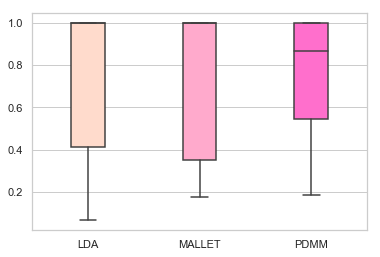

In [479]:
data = pd.DataFrame()
data['LDA'] = list(comb_df['LDA_coherence'])
data['MALLET'] = list(comb_df['MALLET_coherence'])
data['PDMM'] = list(comb_df['PDMM_coherence'])

import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(data=data,palette="Blues",width=0.3, dodge = False)
for patch in ax.artists:
    r, g,b,a = patch.get_facecolor()
    patch.set_facecolor((a, g, .8))

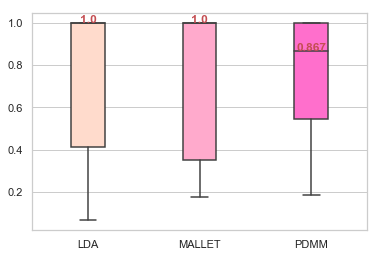

In [480]:
medians = [round(data['LDA'].median(), 3), round(data['MALLET'].median(), 3),round(data['PDMM'].median(), 3)]
median_labels = [str(s) for s in medians]

pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick], median_labels[tick], horizontalalignment='center', size='medium', color='r', weight='semibold')

ax.get_figure()

In [483]:
## mean
means = [round(data['LDA'].mean(), 3), round(data['MALLET'].mean(), 3),round(data['PDMM'].mean(), 3)]

In [484]:
means

[0.754, 0.746, 0.77]

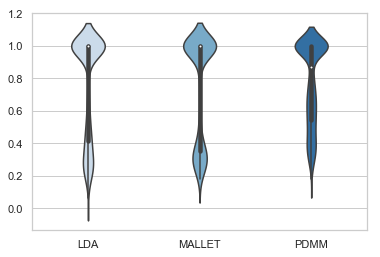

In [436]:
vx = sns.violinplot(data = data,palette="Blues",width=0.3, dodge = False)
for patch in vx.artists:
    r, g,b,a = patch.get_facecolor()
    patch.set_facecolor((a, g,r, .8))

In [481]:
comb_df.to_csv('3ModelsTable.csv')

### Combine final topics to show on the web

In [91]:
import ast

df = pd.read_csv('./output/3ModelsTable.csv')

all_topic = []
lda = df['LDA_topic']
mallet = df['MALLET_topic']
pdmm = pdmm_df['pdmm_topics']
sa2 = df['Unnamed: 0']

In [ ]:
for i in range(len(lda)):
    if type(pdmm[i]) == float:
        all_topic.append(ast.literal_eval(lda[i]) +ast.literal_eval(mallet[i]))
    else:
        all_topic.append(ast.literal_eval(lda[i]) +ast.literal_eval(mallet[i]) +ast.literal_eval(pdmm[i]))

In [118]:
## combine topics and set topics unique
topics = []
for i in all_topic:
    topics.append(list(set(i)))

In [197]:
## Add sa2 value to topics
topic_dic = {}
for i in range(len(sa2)):
    topic_dic[sa2[i]] = topics[i]

In [292]:
## sort topics by descending order
sorted_topic_dic = {}
for i in topic_dic:
    topic_fre = {}
    topic = {}
    for j in topic_dic[i]:
        topic_fre[j] = bow_by_loc[str(i)][j]
    sorted_topic_fre = sorted(topic_fre.items(), key = lambda item:item[1], reverse=True) 
    for k,v in sorted_topic_fre:
        topic[k] = v
    sorted_topic_dic[str(i)] = topic

In [296]:
sorted_topic_dic

{'117031331': {'photo': 11,
  'shenkin': 11,
  'drinking': 10,
  'time': 10,
  'cafe': 10,
  'wale': 8},
 '801111140': {'carrier': 520,
  'frequency': 520,
  'data': 518,
  'strength': 516,
  'signal': 516},
 '206041121': {'award': 4,
  'victoria': 4,
  'irish': 3,
  'quiet': 3,
  'left': 3,
  'lane': 3,
  'victraffic': 3,
  'traffic': 3,
  'work': 3,
  'blue': 3},
 '126011496': {'koala': 4, 'year': 3, 'love': 2, 'park': 2, 'sanctuary': 2},
 '111031229': {'newcastlensw': 26,
  'sport': 23,
  'newsouthwales': 21,
  'beach': 20,
  'award': 18},
 '701011004': {'beach': 6,
  'resort': 4,
  'museum': 4,
  'mindil': 4,
  'gallery': 3},
 '114011281': {'red_heart': 3,
  'dirtxseries': 2,
  'nowramotoplex': 2,
  'dirtx': 2,
  'dirt': 2,
  'round': 2,
  'myactionimages': 2},
 '206041126': {'victoria': 75,
  'south': 39,
  'exhibition': 39,
  'crown': 37,
  'great': 35,
  'wharf': 33},
 '503021038': {'strength': 6,
  'squat': 5,
  'heart_suit': 5,
  'exercise': 5,
  'two_hearts': 5},
 '206061137'

### Revised version combination 

In [109]:
topic = {}
for i in final_lda_topics:
    if i in final_pdmm_topics.keys():
        topic[i] = final_pdmm_topics[i]
    else:
        topic[i] = final_lda_topics[i]

In [110]:
sorted_topic = {}
for i in topic:
    topic_fre = {}
    word = {}
    for j in topic[i]:
        topic_fre[j] = bow_by_loc[str(i)][j]
    sorted_topic_fre = sorted(topic_fre.items(), key = lambda item:item[1], reverse=True) 
    for k,v in sorted_topic_fre:
        word[k] = v
    sorted_topic[str(i)] = word

In [111]:
sorted_topic

{'117031331': {'photo': 11,
  'shenkin': 11,
  'time': 10,
  'cafe': 10,
  'drinking': 10,
  'roast': 9,
  'chicken': 7,
  'spring': 4,
  'raising_hands': 3,
  'nuestra': 2,
  'glamourdance': 2},
 '801111140': {'carrier': 520,
  'frequency': 520,
  'data': 518,
  'strength': 516,
  'signal': 516,
  'turbo': 294,
  'orbiter': 153,
  'voyager': 85},
 '206041121': {'award': 4,
  'victoria': 4,
  'railway': 3,
  'irish': 3,
  'cloud': 3,
  'blue': 3,
  'traffic': 3,
  'quiet': 3,
  'left': 3,
  'alert': 3,
  'lane': 3,
  'time': 2,
  'choice': 2,
  'jacaranda': 1,
  'blooming': 1},
 '126011496': {'koala': 4,
  'year': 3,
  'sanctuary': 2,
  'love': 2,
  'park': 2,
  'sparkling_heart': 1,
  'sneaky': 1,
  'bookshop': 1,
  'hows': 1,
  'birthday': 1,
  'shot': 1,
  'happy': 1},
 '111031229': {'newcastlensw': 26,
  'sport': 23,
  'newsouthwales': 21,
  'beach': 20,
  'award': 18,
  'trophy': 17,
  'uonsportsawards': 15,
  'great': 11,
  'year': 10,
  'congratulation': 10,
  'love': 10,
  'lit

In [112]:
with open('sorted_topics.json', 'w') as f:
    data = json.dump(sorted_topic, f)

### Upload to couchDB

In [9]:
import couchdb
import requests
# Database Connection Configuration
IP = '45.113.234.131'
BASE_URL = 'http://45.113.234.131:5984'
USERNAME = 'admin'
PASSWORD = 'ck199451'
db = requests.Session()
db.auth = (USERNAME, PASSWORD)

In [10]:
couchserver = couchdb.Server(BASE_URL)
couchserver = couchdb.Server("http://%s:%s@%s:5984/" % (USERNAME, PASSWORD, IP))

In [322]:
db = couchserver.create('topic_model')

In [332]:
for i in sorted_topic_dic:
    db.save({'_id':i, 'topics': sorted_topic_dic[i]})

In [293]:
with open('topics_final.json', 'w') as f:
    data = json.dump(sorted_topic_dic, f)

In [11]:
db = couchserver['aurin_all_0109']

### draw pie chart

In [76]:
import matplotlib.style as style 
style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [77]:
style.use('ggplot')

In [148]:
sa2 = '206041126'

In [158]:
def draw_topics(sa2, topic):
    labels = list(topic[sa2]['biterm_topic'].keys())
    sizes =  list(topic[sa2]['biterm_topic'].values())
    colors = ['deeppink','rosybrown', 'gold', 'lightskyblue','salmon','orange','plum','teal','orchid','yellowgreen','crimson','forestgreen','hotpink']
    colors = ['#ffcc99','#ff6666', 'lightskyblue','#c2c2f0','#ffb3e6','#ff9999','#66b3ff','#99ff99','plum','deeppink','orchid','yellowgreen','salmon','orange','rosybrown', 'gold']
    explode = (0.3, 0, 0, 0,0,0)  # explode 1st slice
    plt.pie(sizes, labels=labels, colors = colors, autopct='%1.0f%%', shadow=True, startangle=90,labeldistance=1.1,pctdistance=0.7)
    patches, texts = plt.pie(sizes, colors = colors,shadow=True, startangle=90)
    fontP = matplotlib.font_manager.FontProperties()
    #fontP.set_size('small')
    plt.legend(patches, labels, prop=fontP,loc='upper left') 
    #plt.style.use('bmh')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

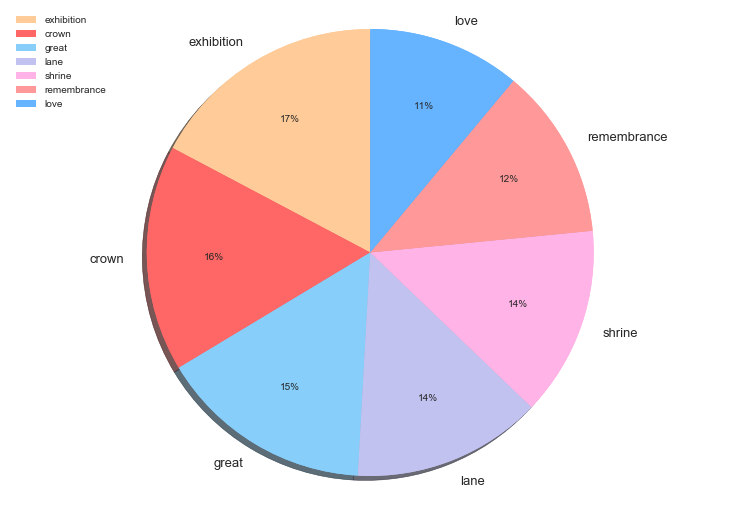

In [159]:
draw_topics(sa2, data)

In [2]:
with open('dash_sentiment_topic.json','r') as f:
    data = json.load(f)

In [6]:
data['206041124']['biterm_topic']

{'royal': 11,
 'university': 7,
 'animal': 5,
 'lane': 5,
 'park': 4,
 'love': 4,
 'zoological': 4,
 'sport': 4,
 'winter': 3}